In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ladyns as ldn
import ladyns.inference as inf

In [8]:
save_dir = "../temp/Section_3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1. simulate data

In [25]:
dims = [25, 25]
num_rtime = 500
num_trial = 1000

In [26]:
rec_time = [0, 500]

## cross precision

In [27]:
num_blobs = 3

In [44]:
f_beta = 18
ts_sig = [80, 200, 400]
ss_sig = [5000/4, 5000/4, 5000/4]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

In [45]:
lags = [[0, 30, 30],
        [30, 0, 0]]

## auto precision

In [46]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [47]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## latent direction

In [48]:
ctrs = [[(1, 1), (3, 3), (2, 2)],
        [(3, 3), (1, 1), (2, 2)]]

In [49]:
betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
          for ct in ctr]
         for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)] 

## simulation function

In [50]:
num_time = num_rtime // 10

In [51]:
def generate_sim(w):
    # generate white noise
    Ws = [np.sqrt(0.5 * psd)[:,None] * 
          np.random.multivariate_normal(np.zeros(d), cov, 
                size=(num_trial, num_rtime//2-1))
          for d, cov in zip(dims, covs_S)]
    RZs = [np.concatenate([
           np.random.multivariate_normal(np.zeros(d), cov, 
               size=(num_trial,1)), 
           W, 
           np.random.multivariate_normal(np.zeros(d), cov, 
               size=(num_trial,1)), 
           np.flip(W, axis=1)], axis=1)
           for d, W, cov in zip(dims, Ws, covs_S)]
    Ws = [np.sqrt(0.5 * psd)[:,None] * 
          np.random.multivariate_normal(np.zeros(d), cov, 
                size=(num_trial, num_rtime//2-1))
          for d, cov in zip(dims, covs_S)]
    IZs = [np.concatenate([
           np.zeros((num_trial,1,d)), 
           W, 
           np.zeros((num_trial,1,d)), 
           np.flip(W, axis=1)], axis=1)
           for W, cov, d in zip(Ws, covs_S, dims)]
    etas = [np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
            for RZ, IZ in zip(RZs, IZs)]
#     sys.stdout.write("noise generated \n")
#     sys.stdout.flush()
    
    # generate signals
    cwt_omega = 3
    cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
    filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)
    
    Ws = [np.random.normal(scale=pbt, size=(num_trial,num_rtime))
          for pbt in pbts]
    sigs =  [np.real(signal.convolve(W, filter_map[None,:]))
             for W in Ws]
#     sys.stdout.write("signal generated \n")
#     sys.stdout.flush()
    
    # generate data
    obss = [eta + w * beta[0] * sigs[0][:,num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1,None]
                + w * beta[1] * sigs[1][:,num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1,None]
                + w * beta[2] * sigs[2][:,num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1,None]
            for eta, beta, lag in zip(etas, betas, lags)]
#     sys.stdout.write("observation generated \n")
#     sys.stdout.flush()
    
    return obss

In [52]:
def preprocess(data_raw):
    cwt_omega = 3 
    cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
    filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)
    
    data = [np.zeros((num_time, d , num_trial)) for d in dims]
    
    for l, d in enumerate(dims):
        for i in np.arange(d):
#             sys.stdout.write("CWT on channel %d-%d \n"%(l, i))
#             sys.stdout.flush()
            data[l][:,i,:] = np.abs(signal.convolve(data_raw[l][:,:,i], 
                filter_map[None,:], mode='same')[:,::10]).T
            
    return data

## test

In [53]:
data_raw = generate_sim(0.08)

In [54]:
data = preprocess(data_raw)

In [55]:
offset_cross = 10
offset_auto = 10

In [60]:
lambda_cross, lambda_auto, lambda_diag = 0.1, 0.0, 20

In [61]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, 
            ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 404.105522, change: 0.235536, lapse: 0.107429
2-th iter, nll: 404.100342, change: 0.037023, lapse: 0.107270
3-th iter, nll: 404.096001, change: 0.034671, lapse: 0.107378
4-th iter, nll: 404.092024, change: 0.033841, lapse: 0.107262
5-th iter, nll: 404.088278, change: 0.031591, lapse: 0.107599
6-th iter, nll: 404.084741, change: 0.028390, lapse: 0.106658
7-th iter, nll: 404.081434, change: 0.025375, lapse: 0.107551
8-th iter, nll: 404.078379, change: 0.022367, lapse: 0.106719
9-th iter, nll: 404.075591, change: 0.019106, lapse: 0.107434
10-th iter, nll: 404.073070, change: 0.018171, lapse: 0.106856
11-th iter, nll: 404.070811, change: 0.018068, lapse: 0.107603
12-th iter, nll: 404.068801, change: 0.017556, lapse: 0.106742
13-th iter, nll: 404.067028, change: 0.017056, lapse: 0.107557
14-th iter, nll: 404.065478, change: 0.016130, lapse: 0.107188
15-th iter, nll: 404.064138, change: 0.014839, lapse: 0.107505
16-th iter, nll: 404.062993, change: 0.013288, lapse: 0.106789
1

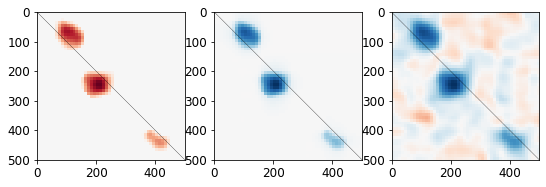

In [62]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True)
plt.subplot(1,3,2); ldn.imshow(linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.subplot(1,3,3); ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True)

# 2. simulation

## preliminary parameters

In [65]:
offset_cross = 10
offset_auto = 10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.full((11,), 0), ## lambdas_auto
    np.full((11,), 20)]) ## lambdas_diag

In [66]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [70]:
snrs = np.sqrt([0.003, 0.004, 0.005, 0.006, 0.007, 0.008])

## iterate simulation

In [68]:
num_cv = 10
num_sim = 200
num_bst = 200

In [69]:
for iter_sim in range(num_sim): 
    for iter_snr, snr in enumerate(snrs):   
        if os.path.exists("%s/result_sim_%.1d_%.3d.npz"%(save_dir, iter_snr, iter_sim)):
            continue

        start_sim = time.time()

        # data simulation
        obss = generate_sim(snr)
        sys.__stdout__.write("%d-%d-th data generation finished, lapse: %.3fsec.\n"
                             %(iter_snr+1, iter_sim+1, time.time()-start_sim))
        sys.__stdout__.flush()

        data = preprocess(obss)
        sys.__stdout__.write("%d-%d-th preprocess finished, lapse: %.3fsec.\n"
                             %(iter_snr+1, iter_sim+1, time.time()-start_sim))
        sys.__stdout__.flush()

        # choosing tuning parameter
        Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
        weights_cv = []
        for iter_cv in np.arange(num_cv):
            start_cv = time.time()

            # random sample
            trial_sample = np.random.choice(num_trial, num_trial, False)
            data_bst = [data[0], data[1][:,:,trial_sample]]

            # estimate for each parameter set
            for iter_lambda, (lambda_cross, lambda_auto, lambda_diag) \
            in enumerate(zip(*lambdas)): 
                if iter_cv > 0:
                    init_arg = {'Omega_init': Omegas_cv[0,iter_lambda],
                                'weight_init': weights_cv[iter_lambda]}
                elif iter_lambda > 0:
                    init_arg = {'Omega_init': Omegas_cv[0,iter_lambda-1],
                                'weight_init': weights_cv[iter_lambda-1]}
                else:
                    init_arg = dict()

                Omega_lambda, Sigma_lambda, latent_lambda, weight_lambda \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                           lambda_auto, offset_auto, 
                           ths_glasso=1e-6, ths_lasso=1e-6,
                           **init_arg)

                # save result
                Omegas_cv[iter_cv, iter_lambda] = Omega_lambda
                if iter_cv == 0:
                    weights_cv.append(weight_lambda)

            sys.__stdout__.write("%d-%d-%d-th cv finished, lapse: %.3fsec.\n"
                                 %(iter_snr+1, iter_sim+1, iter_cv+1, time.time()-start_cv))
            sys.__stdout__.flush()

        sys.__stdout__.write("%d-%d-th simulation cv finished, lapse:%.3fsec.\n"
                             %(iter_snr+1, iter_sim+1, time.time()-start_sim))
        sys.__stdout__.flush()

        # result tuning parameter
        fdrs_cv = np.sum(
            Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1)) \
            /np.sum(time_graph_cross)/num_cv
        np.argmax(fdrs_cv[fdrs_cv < 0.05])
        lambda_cross, lambda_auto, lambda_diag = lambdas.T[id_cv]

        # original estimation
        start_est = time.time()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
                    lambda_auto, offset_auto, 
                    ths_glasso=1e-6, ths_lasso=1e-6)

        sys.__stdout__.write("%d-%d-th estimation finished, lapse: %.3fsec.\n"
                             %(iter_snr+1, iter_sim+1, time.time()-start_est))
        sys.__stdout__.flush()

        # permutation test
        Omegas_bst = np.zeros([num_bst, 2*num_time, 2*num_time])
        Sigmas_bst = np.zeros([num_bst, 2*num_time, 2*num_time])

        init_arg = dict()
        for iter_bst in range(num_bst):
            start_bst = time.time()

            # random sample
            trial_sample = np.random.choice(num_trial, num_trial, False)
            data_bst = [data[0], data[1][:,:,trial_sample]]

            # bootstrap
            Omega_bst, Sigma_bst, latent_bst, weight_bst \
            = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                      lambda_auto, offset_auto, 
                      ths_glasso=1e-6, ths_lasso=1e-6,
                      **init_arg)
            
            init_arg = {'Omega_init': Omega_bst,
                        'weight_init': weight_bst}
            
            # save result
            Omegas_bst[iter_bst] = Omega_bst
            Sigmas_bst[iter_bst] = Sigma_bst

            sys.__stdout__.write("%d-%d-%d-th bootstrap finished, lapse: %.3fsec.\n"
                          %(iter_snr+1, iter_sim+1, iter_bst+1, time.time()-start_bst))
            sys.__stdout__.flush()

        np.savez("%s/result_sim_%.1d_%.3d"%(save_dir, iter_snr, iter_sim),
                 Omega_est=Omega_est, Sigma_est=Sigma_est,
                 Omegas_bst=Omegas_bst, Sigmas_bst=Sigmas_bst)

        sys.__stdout__.write("%d-%d-th simulation finished, lapse: %.3fsec.\n"
                      %(iter_snr+1, iter_sim+1, time.time()-start_sim))
        sys.__stdout__.flush()  

1-1-th data generation finished, lapse: 2.056sec.
1-1-th preprocess finished, lapse: 3.965sec.
1-1-th estimation finished, lapse: 9.810sec.
1-1-1-th bootstrap finished, lapse: 9.906sec.
1-1-2-th bootstrap finished, lapse: 0.235sec.
1-1-3-th bootstrap finished, lapse: 0.126sec.
1-1-4-th bootstrap finished, lapse: 0.127sec.
1-1-5-th bootstrap finished, lapse: 0.126sec.
1-1-6-th bootstrap finished, lapse: 0.232sec.
1-1-7-th bootstrap finished, lapse: 0.228sec.
1-1-8-th bootstrap finished, lapse: 0.232sec.
1-1-9-th bootstrap finished, lapse: 0.229sec.
1-1-10-th bootstrap finished, lapse: 0.127sec.
1-1-11-th bootstrap finished, lapse: 0.126sec.
1-1-12-th bootstrap finished, lapse: 0.126sec.
1-1-13-th bootstrap finished, lapse: 0.227sec.
1-1-14-th bootstrap finished, lapse: 0.229sec.
1-1-15-th bootstrap finished, lapse: 0.126sec.
1-1-16-th bootstrap finished, lapse: 0.229sec.
1-1-17-th bootstrap finished, lapse: 0.229sec.
1-1-18-th bootstrap finished, lapse: 0.126sec.
1-1-19-th bootstrap fin

1-1-172-th bootstrap finished, lapse: 0.230sec.
1-1-173-th bootstrap finished, lapse: 0.127sec.
1-1-174-th bootstrap finished, lapse: 0.233sec.
1-1-175-th bootstrap finished, lapse: 0.228sec.
1-1-176-th bootstrap finished, lapse: 0.126sec.
1-1-177-th bootstrap finished, lapse: 0.126sec.
1-1-178-th bootstrap finished, lapse: 0.126sec.
1-1-179-th bootstrap finished, lapse: 0.127sec.
1-1-180-th bootstrap finished, lapse: 0.135sec.
1-1-181-th bootstrap finished, lapse: 0.128sec.
1-1-182-th bootstrap finished, lapse: 0.127sec.
1-1-183-th bootstrap finished, lapse: 0.127sec.
1-1-184-th bootstrap finished, lapse: 0.230sec.
1-1-185-th bootstrap finished, lapse: 0.230sec.
1-1-186-th bootstrap finished, lapse: 0.230sec.
1-1-187-th bootstrap finished, lapse: 0.229sec.
1-1-188-th bootstrap finished, lapse: 0.232sec.
1-1-189-th bootstrap finished, lapse: 0.127sec.
1-1-190-th bootstrap finished, lapse: 0.230sec.
1-1-191-th bootstrap finished, lapse: 0.229sec.
1-1-192-th bootstrap finished, lapse: 0.

2-1-143-th bootstrap finished, lapse: 0.129sec.
2-1-144-th bootstrap finished, lapse: 0.228sec.
2-1-145-th bootstrap finished, lapse: 0.234sec.
2-1-146-th bootstrap finished, lapse: 0.228sec.
2-1-147-th bootstrap finished, lapse: 0.233sec.
2-1-148-th bootstrap finished, lapse: 0.125sec.
2-1-149-th bootstrap finished, lapse: 0.234sec.
2-1-150-th bootstrap finished, lapse: 0.229sec.
2-1-151-th bootstrap finished, lapse: 0.234sec.
2-1-152-th bootstrap finished, lapse: 0.229sec.
2-1-153-th bootstrap finished, lapse: 0.234sec.
2-1-154-th bootstrap finished, lapse: 0.230sec.
2-1-155-th bootstrap finished, lapse: 0.129sec.
2-1-156-th bootstrap finished, lapse: 0.126sec.
2-1-157-th bootstrap finished, lapse: 0.235sec.
2-1-158-th bootstrap finished, lapse: 0.229sec.
2-1-159-th bootstrap finished, lapse: 0.235sec.
2-1-160-th bootstrap finished, lapse: 0.126sec.
2-1-161-th bootstrap finished, lapse: 0.234sec.
2-1-162-th bootstrap finished, lapse: 0.239sec.
2-1-163-th bootstrap finished, lapse: 0.

3-1-114-th bootstrap finished, lapse: 0.122sec.
3-1-115-th bootstrap finished, lapse: 0.219sec.
3-1-116-th bootstrap finished, lapse: 0.217sec.
3-1-117-th bootstrap finished, lapse: 0.120sec.
3-1-118-th bootstrap finished, lapse: 0.120sec.
3-1-119-th bootstrap finished, lapse: 0.120sec.
3-1-120-th bootstrap finished, lapse: 0.217sec.
3-1-121-th bootstrap finished, lapse: 0.216sec.
3-1-122-th bootstrap finished, lapse: 0.124sec.
3-1-123-th bootstrap finished, lapse: 0.122sec.
3-1-124-th bootstrap finished, lapse: 0.120sec.
3-1-125-th bootstrap finished, lapse: 0.121sec.
3-1-126-th bootstrap finished, lapse: 0.120sec.
3-1-127-th bootstrap finished, lapse: 0.121sec.
3-1-128-th bootstrap finished, lapse: 0.121sec.
3-1-129-th bootstrap finished, lapse: 0.121sec.
3-1-130-th bootstrap finished, lapse: 0.120sec.
3-1-131-th bootstrap finished, lapse: 0.218sec.
3-1-132-th bootstrap finished, lapse: 0.217sec.
3-1-133-th bootstrap finished, lapse: 0.120sec.
3-1-134-th bootstrap finished, lapse: 0.

4-1-83-th bootstrap finished, lapse: 0.238sec.
4-1-84-th bootstrap finished, lapse: 0.127sec.
4-1-85-th bootstrap finished, lapse: 0.124sec.
4-1-86-th bootstrap finished, lapse: 0.119sec.
4-1-87-th bootstrap finished, lapse: 0.238sec.
4-1-88-th bootstrap finished, lapse: 0.231sec.
4-1-89-th bootstrap finished, lapse: 0.123sec.
4-1-90-th bootstrap finished, lapse: 0.216sec.
4-1-91-th bootstrap finished, lapse: 0.222sec.
4-1-92-th bootstrap finished, lapse: 0.119sec.
4-1-93-th bootstrap finished, lapse: 0.124sec.
4-1-94-th bootstrap finished, lapse: 0.120sec.
4-1-95-th bootstrap finished, lapse: 0.124sec.
4-1-96-th bootstrap finished, lapse: 0.215sec.
4-1-97-th bootstrap finished, lapse: 0.222sec.
4-1-98-th bootstrap finished, lapse: 0.119sec.
4-1-99-th bootstrap finished, lapse: 0.124sec.
4-1-100-th bootstrap finished, lapse: 0.119sec.
4-1-101-th bootstrap finished, lapse: 0.124sec.
4-1-102-th bootstrap finished, lapse: 0.120sec.
4-1-103-th bootstrap finished, lapse: 0.124sec.
4-1-104-t

5-1-79-th bootstrap finished, lapse: 0.135sec.
5-1-80-th bootstrap finished, lapse: 0.134sec.
5-1-81-th bootstrap finished, lapse: 0.134sec.
5-1-82-th bootstrap finished, lapse: 0.243sec.
5-1-83-th bootstrap finished, lapse: 0.244sec.
5-1-84-th bootstrap finished, lapse: 0.135sec.
5-1-85-th bootstrap finished, lapse: 0.134sec.
5-1-86-th bootstrap finished, lapse: 0.134sec.
5-1-87-th bootstrap finished, lapse: 0.134sec.
5-1-88-th bootstrap finished, lapse: 0.135sec.
5-1-89-th bootstrap finished, lapse: 0.134sec.
5-1-90-th bootstrap finished, lapse: 0.134sec.
5-1-91-th bootstrap finished, lapse: 0.243sec.
5-1-92-th bootstrap finished, lapse: 0.243sec.
5-1-93-th bootstrap finished, lapse: 0.126sec.
5-1-94-th bootstrap finished, lapse: 0.126sec.
5-1-95-th bootstrap finished, lapse: 0.126sec.
5-1-96-th bootstrap finished, lapse: 0.127sec.
5-1-97-th bootstrap finished, lapse: 0.226sec.
5-1-98-th bootstrap finished, lapse: 0.228sec.
5-1-99-th bootstrap finished, lapse: 0.227sec.
5-1-100-th bo

6-1-48-th bootstrap finished, lapse: 0.235sec.
6-1-49-th bootstrap finished, lapse: 0.234sec.
6-1-50-th bootstrap finished, lapse: 0.235sec.
6-1-51-th bootstrap finished, lapse: 0.234sec.
6-1-52-th bootstrap finished, lapse: 0.234sec.
6-1-53-th bootstrap finished, lapse: 0.235sec.
6-1-54-th bootstrap finished, lapse: 0.126sec.
6-1-55-th bootstrap finished, lapse: 0.127sec.
6-1-56-th bootstrap finished, lapse: 0.119sec.
6-1-57-th bootstrap finished, lapse: 0.119sec.
6-1-58-th bootstrap finished, lapse: 0.219sec.
6-1-59-th bootstrap finished, lapse: 0.219sec.
6-1-60-th bootstrap finished, lapse: 0.119sec.
6-1-61-th bootstrap finished, lapse: 0.119sec.
6-1-62-th bootstrap finished, lapse: 0.119sec.
6-1-63-th bootstrap finished, lapse: 0.119sec.
6-1-64-th bootstrap finished, lapse: 0.234sec.
6-1-65-th bootstrap finished, lapse: 0.227sec.
6-1-66-th bootstrap finished, lapse: 0.119sec.
6-1-67-th bootstrap finished, lapse: 0.119sec.
6-1-68-th bootstrap finished, lapse: 0.119sec.
6-1-69-th boo

1-2-18-th bootstrap finished, lapse: 0.132sec.
1-2-19-th bootstrap finished, lapse: 0.233sec.
1-2-20-th bootstrap finished, lapse: 0.239sec.
1-2-21-th bootstrap finished, lapse: 0.129sec.
1-2-22-th bootstrap finished, lapse: 0.238sec.
1-2-23-th bootstrap finished, lapse: 0.232sec.
1-2-24-th bootstrap finished, lapse: 0.132sec.
1-2-25-th bootstrap finished, lapse: 0.128sec.
1-2-26-th bootstrap finished, lapse: 0.131sec.
1-2-27-th bootstrap finished, lapse: 0.237sec.
1-2-28-th bootstrap finished, lapse: 0.239sec.
1-2-29-th bootstrap finished, lapse: 0.129sec.
1-2-30-th bootstrap finished, lapse: 0.132sec.
1-2-31-th bootstrap finished, lapse: 0.128sec.
1-2-32-th bootstrap finished, lapse: 0.238sec.
1-2-33-th bootstrap finished, lapse: 0.233sec.
1-2-34-th bootstrap finished, lapse: 0.239sec.
1-2-35-th bootstrap finished, lapse: 0.233sec.
1-2-36-th bootstrap finished, lapse: 0.238sec.
1-2-37-th bootstrap finished, lapse: 0.232sec.
1-2-38-th bootstrap finished, lapse: 0.238sec.
1-2-39-th boo

1-2-192-th bootstrap finished, lapse: 0.132sec.
1-2-193-th bootstrap finished, lapse: 0.128sec.
1-2-194-th bootstrap finished, lapse: 0.132sec.
1-2-195-th bootstrap finished, lapse: 0.128sec.
1-2-196-th bootstrap finished, lapse: 0.132sec.
1-2-197-th bootstrap finished, lapse: 0.233sec.
1-2-198-th bootstrap finished, lapse: 0.241sec.
1-2-199-th bootstrap finished, lapse: 0.127sec.
1-2-200-th bootstrap finished, lapse: 0.132sec.
1-2-th simulation finished, lapse: 62.268sec.
2-2-th data generation finished, lapse: 2.051sec.
2-2-th preprocess finished, lapse: 4.345sec.
2-2-th estimation finished, lapse: 10.788sec.
2-2-1-th bootstrap finished, lapse: 11.965sec.
2-2-2-th bootstrap finished, lapse: 0.254sec.
2-2-3-th bootstrap finished, lapse: 0.254sec.
2-2-4-th bootstrap finished, lapse: 0.254sec.
2-2-5-th bootstrap finished, lapse: 0.257sec.
2-2-6-th bootstrap finished, lapse: 0.143sec.
2-2-7-th bootstrap finished, lapse: 0.148sec.
2-2-8-th bootstrap finished, lapse: 0.261sec.
2-2-9-th boo

2-2-163-th bootstrap finished, lapse: 0.221sec.
2-2-164-th bootstrap finished, lapse: 0.220sec.
2-2-165-th bootstrap finished, lapse: 0.123sec.
2-2-166-th bootstrap finished, lapse: 0.123sec.
2-2-167-th bootstrap finished, lapse: 0.123sec.
2-2-168-th bootstrap finished, lapse: 0.123sec.
2-2-169-th bootstrap finished, lapse: 0.262sec.
2-2-170-th bootstrap finished, lapse: 0.229sec.
2-2-171-th bootstrap finished, lapse: 0.123sec.
2-2-172-th bootstrap finished, lapse: 0.123sec.
2-2-173-th bootstrap finished, lapse: 0.123sec.
2-2-174-th bootstrap finished, lapse: 0.123sec.
2-2-175-th bootstrap finished, lapse: 0.232sec.
2-2-176-th bootstrap finished, lapse: 0.223sec.
2-2-177-th bootstrap finished, lapse: 0.221sec.
2-2-178-th bootstrap finished, lapse: 0.123sec.
2-2-179-th bootstrap finished, lapse: 0.124sec.
2-2-180-th bootstrap finished, lapse: 0.123sec.
2-2-181-th bootstrap finished, lapse: 0.133sec.
2-2-182-th bootstrap finished, lapse: 0.126sec.
2-2-183-th bootstrap finished, lapse: 0.

3-2-133-th bootstrap finished, lapse: 0.125sec.
3-2-134-th bootstrap finished, lapse: 0.236sec.
3-2-135-th bootstrap finished, lapse: 0.234sec.
3-2-136-th bootstrap finished, lapse: 0.234sec.
3-2-137-th bootstrap finished, lapse: 0.224sec.
3-2-138-th bootstrap finished, lapse: 0.217sec.
3-2-139-th bootstrap finished, lapse: 0.225sec.
3-2-140-th bootstrap finished, lapse: 0.234sec.
3-2-141-th bootstrap finished, lapse: 0.225sec.
3-2-142-th bootstrap finished, lapse: 0.120sec.
3-2-143-th bootstrap finished, lapse: 0.125sec.
3-2-144-th bootstrap finished, lapse: 0.120sec.
3-2-145-th bootstrap finished, lapse: 0.125sec.
3-2-146-th bootstrap finished, lapse: 0.121sec.
3-2-147-th bootstrap finished, lapse: 0.126sec.
3-2-148-th bootstrap finished, lapse: 0.120sec.
3-2-149-th bootstrap finished, lapse: 0.240sec.
3-2-150-th bootstrap finished, lapse: 0.233sec.
3-2-151-th bootstrap finished, lapse: 0.241sec.
3-2-152-th bootstrap finished, lapse: 0.234sec.
3-2-153-th bootstrap finished, lapse: 0.

4-2-113-th bootstrap finished, lapse: 0.127sec.
4-2-114-th bootstrap finished, lapse: 0.121sec.
4-2-115-th bootstrap finished, lapse: 0.127sec.
4-2-116-th bootstrap finished, lapse: 0.235sec.
4-2-117-th bootstrap finished, lapse: 0.242sec.
4-2-118-th bootstrap finished, lapse: 0.129sec.
4-2-119-th bootstrap finished, lapse: 0.135sec.
4-2-120-th bootstrap finished, lapse: 0.121sec.
4-2-121-th bootstrap finished, lapse: 0.127sec.
4-2-122-th bootstrap finished, lapse: 0.122sec.
4-2-123-th bootstrap finished, lapse: 0.227sec.
4-2-124-th bootstrap finished, lapse: 0.219sec.
4-2-125-th bootstrap finished, lapse: 0.226sec.
4-2-126-th bootstrap finished, lapse: 0.220sec.
4-2-127-th bootstrap finished, lapse: 0.225sec.
4-2-128-th bootstrap finished, lapse: 0.122sec.
4-2-129-th bootstrap finished, lapse: 0.127sec.
4-2-130-th bootstrap finished, lapse: 0.219sec.
4-2-131-th bootstrap finished, lapse: 0.228sec.
4-2-132-th bootstrap finished, lapse: 0.219sec.
4-2-133-th bootstrap finished, lapse: 0.

5-2-83-th bootstrap finished, lapse: 0.125sec.
5-2-84-th bootstrap finished, lapse: 0.128sec.
5-2-85-th bootstrap finished, lapse: 0.124sec.
5-2-86-th bootstrap finished, lapse: 0.127sec.
5-2-87-th bootstrap finished, lapse: 0.124sec.
5-2-88-th bootstrap finished, lapse: 0.244sec.
5-2-89-th bootstrap finished, lapse: 0.238sec.
5-2-90-th bootstrap finished, lapse: 0.127sec.
5-2-91-th bootstrap finished, lapse: 0.230sec.
5-2-92-th bootstrap finished, lapse: 0.230sec.
5-2-93-th bootstrap finished, lapse: 0.123sec.
5-2-94-th bootstrap finished, lapse: 0.129sec.
5-2-95-th bootstrap finished, lapse: 0.124sec.
5-2-96-th bootstrap finished, lapse: 0.245sec.
5-2-97-th bootstrap finished, lapse: 0.223sec.
5-2-98-th bootstrap finished, lapse: 0.126sec.
5-2-99-th bootstrap finished, lapse: 0.124sec.
5-2-100-th bootstrap finished, lapse: 0.127sec.
5-2-101-th bootstrap finished, lapse: 0.125sec.
5-2-102-th bootstrap finished, lapse: 0.126sec.
5-2-103-th bootstrap finished, lapse: 0.125sec.
5-2-104-t

6-2-52-th bootstrap finished, lapse: 0.120sec.
6-2-53-th bootstrap finished, lapse: 0.119sec.
6-2-54-th bootstrap finished, lapse: 0.221sec.
6-2-55-th bootstrap finished, lapse: 0.221sec.
6-2-56-th bootstrap finished, lapse: 0.123sec.
6-2-57-th bootstrap finished, lapse: 0.121sec.
6-2-58-th bootstrap finished, lapse: 0.120sec.
6-2-59-th bootstrap finished, lapse: 0.120sec.
6-2-60-th bootstrap finished, lapse: 0.120sec.
6-2-61-th bootstrap finished, lapse: 0.229sec.
6-2-62-th bootstrap finished, lapse: 0.221sec.
6-2-63-th bootstrap finished, lapse: 0.221sec.
6-2-64-th bootstrap finished, lapse: 0.120sec.
6-2-65-th bootstrap finished, lapse: 0.230sec.
6-2-66-th bootstrap finished, lapse: 0.221sec.
6-2-67-th bootstrap finished, lapse: 0.229sec.
6-2-68-th bootstrap finished, lapse: 0.237sec.
6-2-69-th bootstrap finished, lapse: 0.238sec.
6-2-70-th bootstrap finished, lapse: 0.237sec.
6-2-71-th bootstrap finished, lapse: 0.236sec.
6-2-72-th bootstrap finished, lapse: 0.236sec.
6-2-73-th boo

1-3-21-th bootstrap finished, lapse: 6.270sec.
1-3-22-th bootstrap finished, lapse: 0.131sec.
1-3-23-th bootstrap finished, lapse: 0.244sec.
1-3-24-th bootstrap finished, lapse: 0.238sec.
1-3-25-th bootstrap finished, lapse: 0.135sec.
1-3-26-th bootstrap finished, lapse: 0.132sec.
1-3-27-th bootstrap finished, lapse: 0.244sec.
1-3-28-th bootstrap finished, lapse: 0.238sec.
1-3-29-th bootstrap finished, lapse: 0.250sec.
1-3-30-th bootstrap finished, lapse: 0.238sec.
1-3-31-th bootstrap finished, lapse: 0.136sec.
1-3-32-th bootstrap finished, lapse: 0.132sec.
1-3-33-th bootstrap finished, lapse: 0.135sec.
1-3-34-th bootstrap finished, lapse: 0.131sec.
1-3-35-th bootstrap finished, lapse: 0.134sec.
1-3-36-th bootstrap finished, lapse: 0.132sec.
1-3-37-th bootstrap finished, lapse: 0.135sec.
1-3-38-th bootstrap finished, lapse: 0.238sec.
1-3-39-th bootstrap finished, lapse: 0.250sec.
1-3-40-th bootstrap finished, lapse: 0.238sec.
1-3-41-th bootstrap finished, lapse: 0.245sec.
1-3-42-th boo

1-3-194-th bootstrap finished, lapse: 0.247sec.
1-3-195-th bootstrap finished, lapse: 0.254sec.
1-3-196-th bootstrap finished, lapse: 0.128sec.
1-3-197-th bootstrap finished, lapse: 0.131sec.
1-3-198-th bootstrap finished, lapse: 0.129sec.
1-3-199-th bootstrap finished, lapse: 0.132sec.
1-3-200-th bootstrap finished, lapse: 0.128sec.
1-3-th simulation finished, lapse: 68.313sec.
2-3-th data generation finished, lapse: 2.148sec.
2-3-th estimation finished, lapse: 5.026sec.
2-3-1-th bootstrap finished, lapse: 5.485sec.
2-3-2-th bootstrap finished, lapse: 0.237sec.
2-3-3-th bootstrap finished, lapse: 0.135sec.
2-3-4-th bootstrap finished, lapse: 0.135sec.
2-3-5-th bootstrap finished, lapse: 0.241sec.
2-3-6-th bootstrap finished, lapse: 0.243sec.
2-3-7-th bootstrap finished, lapse: 0.242sec.
2-3-8-th bootstrap finished, lapse: 0.242sec.
2-3-9-th bootstrap finished, lapse: 0.134sec.
2-3-10-th bootstrap finished, lapse: 0.133sec.
2-3-11-th bootstrap finished, lapse: 0.133sec.
2-3-12-th boots

2-3-165-th bootstrap finished, lapse: 0.124sec.
2-3-166-th bootstrap finished, lapse: 0.124sec.
2-3-167-th bootstrap finished, lapse: 0.224sec.
2-3-168-th bootstrap finished, lapse: 0.224sec.
2-3-169-th bootstrap finished, lapse: 0.124sec.
2-3-170-th bootstrap finished, lapse: 0.126sec.
2-3-171-th bootstrap finished, lapse: 0.124sec.
2-3-172-th bootstrap finished, lapse: 0.233sec.
2-3-173-th bootstrap finished, lapse: 0.233sec.
2-3-174-th bootstrap finished, lapse: 0.223sec.
2-3-175-th bootstrap finished, lapse: 0.124sec.
2-3-176-th bootstrap finished, lapse: 0.224sec.
2-3-177-th bootstrap finished, lapse: 0.224sec.
2-3-178-th bootstrap finished, lapse: 0.124sec.
2-3-179-th bootstrap finished, lapse: 0.125sec.
2-3-180-th bootstrap finished, lapse: 0.124sec.
2-3-181-th bootstrap finished, lapse: 0.125sec.
2-3-182-th bootstrap finished, lapse: 0.224sec.
2-3-183-th bootstrap finished, lapse: 0.225sec.
2-3-184-th bootstrap finished, lapse: 0.224sec.
2-3-185-th bootstrap finished, lapse: 0.

3-3-135-th bootstrap finished, lapse: 0.240sec.
3-3-136-th bootstrap finished, lapse: 0.240sec.
3-3-137-th bootstrap finished, lapse: 0.224sec.
3-3-138-th bootstrap finished, lapse: 0.224sec.
3-3-139-th bootstrap finished, lapse: 0.240sec.
3-3-140-th bootstrap finished, lapse: 0.240sec.
3-3-141-th bootstrap finished, lapse: 0.232sec.
3-3-142-th bootstrap finished, lapse: 0.225sec.
3-3-143-th bootstrap finished, lapse: 0.125sec.
3-3-144-th bootstrap finished, lapse: 0.240sec.
3-3-145-th bootstrap finished, lapse: 0.240sec.
3-3-146-th bootstrap finished, lapse: 0.241sec.
3-3-147-th bootstrap finished, lapse: 0.232sec.
3-3-148-th bootstrap finished, lapse: 0.125sec.
3-3-149-th bootstrap finished, lapse: 0.226sec.
3-3-150-th bootstrap finished, lapse: 0.224sec.
3-3-151-th bootstrap finished, lapse: 0.125sec.
3-3-152-th bootstrap finished, lapse: 0.125sec.
3-3-153-th bootstrap finished, lapse: 0.124sec.
3-3-154-th bootstrap finished, lapse: 0.125sec.
3-3-155-th bootstrap finished, lapse: 0.

4-3-105-th bootstrap finished, lapse: 0.131sec.
4-3-106-th bootstrap finished, lapse: 0.243sec.
4-3-107-th bootstrap finished, lapse: 0.239sec.
4-3-108-th bootstrap finished, lapse: 0.244sec.
4-3-109-th bootstrap finished, lapse: 0.237sec.
4-3-110-th bootstrap finished, lapse: 0.134sec.
4-3-111-th bootstrap finished, lapse: 0.131sec.
4-3-112-th bootstrap finished, lapse: 0.134sec.
4-3-113-th bootstrap finished, lapse: 0.237sec.
4-3-114-th bootstrap finished, lapse: 0.244sec.
4-3-115-th bootstrap finished, lapse: 0.131sec.
4-3-116-th bootstrap finished, lapse: 0.135sec.
4-3-117-th bootstrap finished, lapse: 0.131sec.
4-3-118-th bootstrap finished, lapse: 0.140sec.
4-3-119-th bootstrap finished, lapse: 0.132sec.
4-3-120-th bootstrap finished, lapse: 0.135sec.
4-3-121-th bootstrap finished, lapse: 0.131sec.
4-3-122-th bootstrap finished, lapse: 0.135sec.
4-3-123-th bootstrap finished, lapse: 0.237sec.
4-3-124-th bootstrap finished, lapse: 0.244sec.
4-3-125-th bootstrap finished, lapse: 0.

5-3-75-th bootstrap finished, lapse: 0.236sec.
5-3-76-th bootstrap finished, lapse: 0.244sec.
5-3-77-th bootstrap finished, lapse: 0.127sec.
5-3-78-th bootstrap finished, lapse: 0.127sec.
5-3-79-th bootstrap finished, lapse: 0.127sec.
5-3-80-th bootstrap finished, lapse: 0.228sec.
5-3-81-th bootstrap finished, lapse: 0.228sec.
5-3-82-th bootstrap finished, lapse: 0.127sec.
5-3-83-th bootstrap finished, lapse: 0.127sec.
5-3-84-th bootstrap finished, lapse: 0.128sec.
5-3-85-th bootstrap finished, lapse: 0.127sec.
5-3-86-th bootstrap finished, lapse: 0.127sec.
5-3-87-th bootstrap finished, lapse: 0.127sec.
5-3-88-th bootstrap finished, lapse: 0.127sec.
5-3-89-th bootstrap finished, lapse: 0.127sec.
5-3-90-th bootstrap finished, lapse: 0.127sec.
5-3-91-th bootstrap finished, lapse: 0.236sec.
5-3-92-th bootstrap finished, lapse: 0.244sec.
5-3-93-th bootstrap finished, lapse: 0.236sec.
5-3-94-th bootstrap finished, lapse: 0.228sec.
5-3-95-th bootstrap finished, lapse: 0.127sec.
5-3-96-th boo

6-3-44-th bootstrap finished, lapse: 0.241sec.
6-3-45-th bootstrap finished, lapse: 0.249sec.
6-3-46-th bootstrap finished, lapse: 0.241sec.
6-3-47-th bootstrap finished, lapse: 0.247sec.
6-3-48-th bootstrap finished, lapse: 0.348sec.
6-3-49-th bootstrap finished, lapse: 0.247sec.
6-3-50-th bootstrap finished, lapse: 0.134sec.
6-3-51-th bootstrap finished, lapse: 0.247sec.
6-3-52-th bootstrap finished, lapse: 0.242sec.
6-3-53-th bootstrap finished, lapse: 0.137sec.
6-3-54-th bootstrap finished, lapse: 0.133sec.
6-3-55-th bootstrap finished, lapse: 0.137sec.
6-3-56-th bootstrap finished, lapse: 0.241sec.
6-3-57-th bootstrap finished, lapse: 0.248sec.
6-3-58-th bootstrap finished, lapse: 0.249sec.
6-3-59-th bootstrap finished, lapse: 0.248sec.
6-3-60-th bootstrap finished, lapse: 0.241sec.
6-3-61-th bootstrap finished, lapse: 0.249sec.
6-3-62-th bootstrap finished, lapse: 0.242sec.
6-3-63-th bootstrap finished, lapse: 0.248sec.
6-3-64-th bootstrap finished, lapse: 0.241sec.
6-3-65-th boo

1-4-13-th bootstrap finished, lapse: 0.237sec.
1-4-14-th bootstrap finished, lapse: 0.128sec.
1-4-15-th bootstrap finished, lapse: 0.346sec.
1-4-16-th bootstrap finished, lapse: 0.236sec.
1-4-17-th bootstrap finished, lapse: 0.128sec.
1-4-18-th bootstrap finished, lapse: 0.128sec.
1-4-19-th bootstrap finished, lapse: 0.128sec.
1-4-20-th bootstrap finished, lapse: 0.128sec.
1-4-21-th bootstrap finished, lapse: 0.236sec.
1-4-22-th bootstrap finished, lapse: 0.236sec.
1-4-23-th bootstrap finished, lapse: 0.237sec.
1-4-24-th bootstrap finished, lapse: 0.236sec.
1-4-25-th bootstrap finished, lapse: 0.128sec.
1-4-26-th bootstrap finished, lapse: 0.128sec.
1-4-27-th bootstrap finished, lapse: 0.128sec.
1-4-28-th bootstrap finished, lapse: 0.128sec.
1-4-29-th bootstrap finished, lapse: 0.128sec.
1-4-30-th bootstrap finished, lapse: 0.127sec.
1-4-31-th bootstrap finished, lapse: 0.128sec.
1-4-32-th bootstrap finished, lapse: 0.131sec.
1-4-33-th bootstrap finished, lapse: 0.128sec.
1-4-34-th boo

1-4-186-th bootstrap finished, lapse: 0.220sec.
1-4-187-th bootstrap finished, lapse: 0.119sec.
1-4-188-th bootstrap finished, lapse: 0.120sec.
1-4-189-th bootstrap finished, lapse: 0.120sec.
1-4-190-th bootstrap finished, lapse: 0.119sec.
1-4-191-th bootstrap finished, lapse: 0.119sec.
1-4-192-th bootstrap finished, lapse: 0.119sec.
1-4-193-th bootstrap finished, lapse: 0.120sec.
1-4-194-th bootstrap finished, lapse: 0.120sec.
1-4-195-th bootstrap finished, lapse: 0.119sec.
1-4-196-th bootstrap finished, lapse: 0.220sec.
1-4-197-th bootstrap finished, lapse: 0.221sec.
1-4-198-th bootstrap finished, lapse: 0.120sec.
1-4-199-th bootstrap finished, lapse: 0.122sec.
1-4-200-th bootstrap finished, lapse: 0.119sec.
1-4-th simulation finished, lapse: 60.380sec.
2-4-th data generation finished, lapse: 2.063sec.
2-4-th preprocess finished, lapse: 3.758sec.
2-4-th estimation finished, lapse: 6.164sec.
2-4-1-th bootstrap finished, lapse: 6.818sec.
2-4-2-th bootstrap finished, lapse: 0.237sec.
2-

2-4-157-th bootstrap finished, lapse: 0.236sec.
2-4-158-th bootstrap finished, lapse: 0.237sec.
2-4-159-th bootstrap finished, lapse: 0.128sec.
2-4-160-th bootstrap finished, lapse: 0.128sec.
2-4-161-th bootstrap finished, lapse: 0.129sec.
2-4-162-th bootstrap finished, lapse: 0.128sec.
2-4-163-th bootstrap finished, lapse: 0.236sec.
2-4-164-th bootstrap finished, lapse: 0.237sec.
2-4-165-th bootstrap finished, lapse: 0.236sec.
2-4-166-th bootstrap finished, lapse: 0.236sec.
2-4-167-th bootstrap finished, lapse: 0.237sec.
2-4-168-th bootstrap finished, lapse: 0.237sec.
2-4-169-th bootstrap finished, lapse: 0.128sec.
2-4-170-th bootstrap finished, lapse: 0.236sec.
2-4-171-th bootstrap finished, lapse: 0.237sec.
2-4-172-th bootstrap finished, lapse: 0.128sec.
2-4-173-th bootstrap finished, lapse: 0.128sec.
2-4-174-th bootstrap finished, lapse: 0.128sec.
2-4-175-th bootstrap finished, lapse: 0.128sec.
2-4-176-th bootstrap finished, lapse: 0.127sec.
2-4-177-th bootstrap finished, lapse: 0.

3-4-127-th bootstrap finished, lapse: 0.238sec.
3-4-128-th bootstrap finished, lapse: 0.127sec.
3-4-129-th bootstrap finished, lapse: 0.128sec.
3-4-130-th bootstrap finished, lapse: 0.236sec.
3-4-131-th bootstrap finished, lapse: 0.230sec.
3-4-132-th bootstrap finished, lapse: 0.127sec.
3-4-133-th bootstrap finished, lapse: 0.127sec.
3-4-134-th bootstrap finished, lapse: 0.126sec.
3-4-135-th bootstrap finished, lapse: 0.127sec.
3-4-136-th bootstrap finished, lapse: 0.244sec.
3-4-137-th bootstrap finished, lapse: 0.236sec.
3-4-138-th bootstrap finished, lapse: 0.127sec.
3-4-139-th bootstrap finished, lapse: 0.127sec.
3-4-140-th bootstrap finished, lapse: 0.127sec.
3-4-141-th bootstrap finished, lapse: 0.127sec.
3-4-142-th bootstrap finished, lapse: 0.228sec.
3-4-143-th bootstrap finished, lapse: 0.236sec.
3-4-144-th bootstrap finished, lapse: 0.237sec.
3-4-145-th bootstrap finished, lapse: 0.229sec.
3-4-146-th bootstrap finished, lapse: 0.128sec.
3-4-147-th bootstrap finished, lapse: 0.

4-4-96-th bootstrap finished, lapse: 0.218sec.
4-4-97-th bootstrap finished, lapse: 0.118sec.
4-4-98-th bootstrap finished, lapse: 0.118sec.
4-4-99-th bootstrap finished, lapse: 0.118sec.
4-4-100-th bootstrap finished, lapse: 0.237sec.
4-4-101-th bootstrap finished, lapse: 0.233sec.
4-4-102-th bootstrap finished, lapse: 0.119sec.
4-4-103-th bootstrap finished, lapse: 0.118sec.
4-4-104-th bootstrap finished, lapse: 0.119sec.
4-4-105-th bootstrap finished, lapse: 0.119sec.
4-4-106-th bootstrap finished, lapse: 0.118sec.
4-4-107-th bootstrap finished, lapse: 0.118sec.
4-4-108-th bootstrap finished, lapse: 0.119sec.
4-4-109-th bootstrap finished, lapse: 0.227sec.
4-4-110-th bootstrap finished, lapse: 0.218sec.
4-4-111-th bootstrap finished, lapse: 0.218sec.
4-4-112-th bootstrap finished, lapse: 0.218sec.
4-4-113-th bootstrap finished, lapse: 0.118sec.
4-4-114-th bootstrap finished, lapse: 0.218sec.
4-4-115-th bootstrap finished, lapse: 0.234sec.
4-4-116-th bootstrap finished, lapse: 0.234s

5-4-66-th bootstrap finished, lapse: 0.134sec.
5-4-67-th bootstrap finished, lapse: 0.134sec.
5-4-68-th bootstrap finished, lapse: 0.134sec.
5-4-69-th bootstrap finished, lapse: 0.134sec.
5-4-70-th bootstrap finished, lapse: 0.242sec.
5-4-71-th bootstrap finished, lapse: 0.242sec.
5-4-72-th bootstrap finished, lapse: 0.243sec.
5-4-73-th bootstrap finished, lapse: 0.242sec.
5-4-74-th bootstrap finished, lapse: 0.245sec.
5-4-75-th bootstrap finished, lapse: 0.134sec.
5-4-76-th bootstrap finished, lapse: 0.135sec.
5-4-77-th bootstrap finished, lapse: 0.134sec.
5-4-78-th bootstrap finished, lapse: 0.243sec.
5-4-79-th bootstrap finished, lapse: 0.248sec.
5-4-80-th bootstrap finished, lapse: 0.258sec.
5-4-81-th bootstrap finished, lapse: 0.263sec.
5-4-82-th bootstrap finished, lapse: 0.255sec.
5-4-83-th bootstrap finished, lapse: 0.144sec.
5-4-84-th bootstrap finished, lapse: 0.259sec.
5-4-85-th bootstrap finished, lapse: 0.252sec.
5-4-86-th bootstrap finished, lapse: 0.137sec.
5-4-87-th boo

6-4-35-th bootstrap finished, lapse: 0.239sec.
6-4-36-th bootstrap finished, lapse: 0.128sec.
6-4-37-th bootstrap finished, lapse: 0.132sec.
6-4-38-th bootstrap finished, lapse: 0.128sec.
6-4-39-th bootstrap finished, lapse: 0.238sec.
6-4-40-th bootstrap finished, lapse: 0.233sec.
6-4-41-th bootstrap finished, lapse: 0.132sec.
6-4-42-th bootstrap finished, lapse: 0.129sec.
6-4-43-th bootstrap finished, lapse: 0.139sec.
6-4-44-th bootstrap finished, lapse: 0.129sec.
6-4-45-th bootstrap finished, lapse: 0.239sec.
6-4-46-th bootstrap finished, lapse: 0.233sec.
6-4-47-th bootstrap finished, lapse: 0.240sec.
6-4-48-th bootstrap finished, lapse: 0.233sec.
6-4-49-th bootstrap finished, lapse: 0.239sec.
6-4-50-th bootstrap finished, lapse: 0.234sec.
6-4-51-th bootstrap finished, lapse: 0.239sec.
6-4-52-th bootstrap finished, lapse: 0.231sec.
6-4-53-th bootstrap finished, lapse: 0.132sec.
6-4-54-th bootstrap finished, lapse: 0.128sec.
6-4-55-th bootstrap finished, lapse: 0.238sec.
6-4-56-th boo

1-5-5-th bootstrap finished, lapse: 0.134sec.
1-5-6-th bootstrap finished, lapse: 0.243sec.
1-5-7-th bootstrap finished, lapse: 0.241sec.
1-5-8-th bootstrap finished, lapse: 0.134sec.
1-5-9-th bootstrap finished, lapse: 0.135sec.
1-5-10-th bootstrap finished, lapse: 0.133sec.
1-5-11-th bootstrap finished, lapse: 0.134sec.
1-5-12-th bootstrap finished, lapse: 0.350sec.
1-5-13-th bootstrap finished, lapse: 0.242sec.
1-5-14-th bootstrap finished, lapse: 0.141sec.
1-5-15-th bootstrap finished, lapse: 0.134sec.
1-5-16-th bootstrap finished, lapse: 0.134sec.
1-5-17-th bootstrap finished, lapse: 0.134sec.
1-5-18-th bootstrap finished, lapse: 0.134sec.
1-5-19-th bootstrap finished, lapse: 0.241sec.
1-5-20-th bootstrap finished, lapse: 0.350sec.
1-5-21-th bootstrap finished, lapse: 0.242sec.
1-5-22-th bootstrap finished, lapse: 0.243sec.
1-5-23-th bootstrap finished, lapse: 0.242sec.
1-5-24-th bootstrap finished, lapse: 0.242sec.
1-5-25-th bootstrap finished, lapse: 0.242sec.
1-5-26-th bootstra

1-5-178-th bootstrap finished, lapse: 0.243sec.
1-5-179-th bootstrap finished, lapse: 0.242sec.
1-5-180-th bootstrap finished, lapse: 0.243sec.
1-5-181-th bootstrap finished, lapse: 0.242sec.
1-5-182-th bootstrap finished, lapse: 0.242sec.
1-5-183-th bootstrap finished, lapse: 0.241sec.
1-5-184-th bootstrap finished, lapse: 0.242sec.
1-5-185-th bootstrap finished, lapse: 0.243sec.
1-5-186-th bootstrap finished, lapse: 0.245sec.
1-5-187-th bootstrap finished, lapse: 0.243sec.
1-5-188-th bootstrap finished, lapse: 0.134sec.
1-5-189-th bootstrap finished, lapse: 0.134sec.
1-5-190-th bootstrap finished, lapse: 0.243sec.
1-5-191-th bootstrap finished, lapse: 0.241sec.
1-5-192-th bootstrap finished, lapse: 0.135sec.
1-5-193-th bootstrap finished, lapse: 0.135sec.
1-5-194-th bootstrap finished, lapse: 0.244sec.
1-5-195-th bootstrap finished, lapse: 0.243sec.
1-5-196-th bootstrap finished, lapse: 0.243sec.
1-5-197-th bootstrap finished, lapse: 0.242sec.
1-5-198-th bootstrap finished, lapse: 0.

2-5-149-th bootstrap finished, lapse: 0.130sec.
2-5-150-th bootstrap finished, lapse: 0.237sec.
2-5-151-th bootstrap finished, lapse: 0.237sec.
2-5-152-th bootstrap finished, lapse: 0.130sec.
2-5-153-th bootstrap finished, lapse: 0.130sec.
2-5-154-th bootstrap finished, lapse: 0.343sec.
2-5-155-th bootstrap finished, lapse: 0.237sec.
2-5-156-th bootstrap finished, lapse: 0.130sec.
2-5-157-th bootstrap finished, lapse: 0.130sec.
2-5-158-th bootstrap finished, lapse: 0.236sec.
2-5-159-th bootstrap finished, lapse: 0.237sec.
2-5-160-th bootstrap finished, lapse: 0.130sec.
2-5-161-th bootstrap finished, lapse: 0.131sec.
2-5-162-th bootstrap finished, lapse: 0.130sec.
2-5-163-th bootstrap finished, lapse: 0.130sec.
2-5-164-th bootstrap finished, lapse: 0.130sec.
2-5-165-th bootstrap finished, lapse: 0.236sec.
2-5-166-th bootstrap finished, lapse: 0.237sec.
2-5-167-th bootstrap finished, lapse: 0.237sec.
2-5-168-th bootstrap finished, lapse: 0.237sec.
2-5-169-th bootstrap finished, lapse: 0.

3-5-119-th bootstrap finished, lapse: 0.133sec.
3-5-120-th bootstrap finished, lapse: 0.131sec.
3-5-121-th bootstrap finished, lapse: 0.132sec.
3-5-122-th bootstrap finished, lapse: 0.131sec.
3-5-123-th bootstrap finished, lapse: 0.134sec.
3-5-124-th bootstrap finished, lapse: 0.131sec.
3-5-125-th bootstrap finished, lapse: 0.132sec.
3-5-126-th bootstrap finished, lapse: 0.131sec.
3-5-127-th bootstrap finished, lapse: 0.132sec.
3-5-128-th bootstrap finished, lapse: 0.131sec.
3-5-129-th bootstrap finished, lapse: 0.132sec.
3-5-130-th bootstrap finished, lapse: 0.131sec.
3-5-131-th bootstrap finished, lapse: 0.239sec.
3-5-132-th bootstrap finished, lapse: 0.238sec.
3-5-133-th bootstrap finished, lapse: 0.238sec.
3-5-134-th bootstrap finished, lapse: 0.247sec.
3-5-135-th bootstrap finished, lapse: 0.239sec.
3-5-136-th bootstrap finished, lapse: 0.238sec.
3-5-137-th bootstrap finished, lapse: 0.238sec.
3-5-138-th bootstrap finished, lapse: 0.238sec.
3-5-139-th bootstrap finished, lapse: 0.

4-5-89-th bootstrap finished, lapse: 0.232sec.
4-5-90-th bootstrap finished, lapse: 0.232sec.
4-5-91-th bootstrap finished, lapse: 0.216sec.
4-5-92-th bootstrap finished, lapse: 0.236sec.
4-5-93-th bootstrap finished, lapse: 0.234sec.
4-5-94-th bootstrap finished, lapse: 0.118sec.
4-5-95-th bootstrap finished, lapse: 0.118sec.
4-5-96-th bootstrap finished, lapse: 0.118sec.
4-5-97-th bootstrap finished, lapse: 0.118sec.
4-5-98-th bootstrap finished, lapse: 0.118sec.
4-5-99-th bootstrap finished, lapse: 0.118sec.
4-5-100-th bootstrap finished, lapse: 0.217sec.
4-5-101-th bootstrap finished, lapse: 0.216sec.
4-5-102-th bootstrap finished, lapse: 0.119sec.
4-5-103-th bootstrap finished, lapse: 0.118sec.
4-5-104-th bootstrap finished, lapse: 0.217sec.
4-5-105-th bootstrap finished, lapse: 0.217sec.
4-5-106-th bootstrap finished, lapse: 0.118sec.
4-5-107-th bootstrap finished, lapse: 0.216sec.
4-5-108-th bootstrap finished, lapse: 0.217sec.
4-5-109-th bootstrap finished, lapse: 0.118sec.
4-5

5-5-58-th bootstrap finished, lapse: 0.132sec.
5-5-59-th bootstrap finished, lapse: 0.132sec.
5-5-60-th bootstrap finished, lapse: 0.239sec.
5-5-61-th bootstrap finished, lapse: 0.242sec.
5-5-62-th bootstrap finished, lapse: 0.132sec.
5-5-63-th bootstrap finished, lapse: 0.132sec.
5-5-64-th bootstrap finished, lapse: 0.240sec.
5-5-65-th bootstrap finished, lapse: 0.239sec.
5-5-66-th bootstrap finished, lapse: 0.133sec.
5-5-67-th bootstrap finished, lapse: 0.133sec.
5-5-68-th bootstrap finished, lapse: 0.132sec.
5-5-69-th bootstrap finished, lapse: 0.132sec.
5-5-70-th bootstrap finished, lapse: 0.240sec.
5-5-71-th bootstrap finished, lapse: 0.239sec.
5-5-72-th bootstrap finished, lapse: 0.346sec.
5-5-73-th bootstrap finished, lapse: 0.238sec.
5-5-74-th bootstrap finished, lapse: 0.239sec.
5-5-75-th bootstrap finished, lapse: 0.239sec.
5-5-76-th bootstrap finished, lapse: 0.246sec.
5-5-77-th bootstrap finished, lapse: 0.131sec.
5-5-78-th bootstrap finished, lapse: 0.132sec.
5-5-79-th boo

6-5-27-th bootstrap finished, lapse: 0.239sec.
6-5-28-th bootstrap finished, lapse: 0.240sec.
6-5-29-th bootstrap finished, lapse: 0.239sec.
6-5-30-th bootstrap finished, lapse: 0.239sec.
6-5-31-th bootstrap finished, lapse: 0.241sec.
6-5-32-th bootstrap finished, lapse: 0.241sec.
6-5-33-th bootstrap finished, lapse: 0.239sec.
6-5-34-th bootstrap finished, lapse: 0.239sec.
6-5-35-th bootstrap finished, lapse: 0.239sec.
6-5-36-th bootstrap finished, lapse: 0.345sec.
6-5-37-th bootstrap finished, lapse: 0.239sec.
6-5-38-th bootstrap finished, lapse: 0.131sec.
6-5-39-th bootstrap finished, lapse: 0.238sec.
6-5-40-th bootstrap finished, lapse: 0.239sec.
6-5-41-th bootstrap finished, lapse: 0.240sec.
6-5-42-th bootstrap finished, lapse: 0.239sec.
6-5-43-th bootstrap finished, lapse: 0.132sec.
6-5-44-th bootstrap finished, lapse: 0.133sec.
6-5-45-th bootstrap finished, lapse: 0.132sec.
6-5-46-th bootstrap finished, lapse: 0.132sec.
6-5-47-th bootstrap finished, lapse: 0.132sec.
6-5-48-th boo

6-5-th simulation finished, lapse: 50.607sec.
1-6-th data generation finished, lapse: 2.041sec.
1-6-th preprocess finished, lapse: 3.741sec.
1-6-th estimation finished, lapse: 14.000sec.
1-6-1-th bootstrap finished, lapse: 16.508sec.
1-6-2-th bootstrap finished, lapse: 0.250sec.
1-6-3-th bootstrap finished, lapse: 0.248sec.
1-6-4-th bootstrap finished, lapse: 0.250sec.
1-6-5-th bootstrap finished, lapse: 0.134sec.
1-6-6-th bootstrap finished, lapse: 0.247sec.
1-6-7-th bootstrap finished, lapse: 0.252sec.
1-6-8-th bootstrap finished, lapse: 0.135sec.
1-6-9-th bootstrap finished, lapse: 0.135sec.
1-6-10-th bootstrap finished, lapse: 0.248sec.
1-6-11-th bootstrap finished, lapse: 0.248sec.
1-6-12-th bootstrap finished, lapse: 0.134sec.
1-6-13-th bootstrap finished, lapse: 0.134sec.
1-6-14-th bootstrap finished, lapse: 0.249sec.
1-6-15-th bootstrap finished, lapse: 0.247sec.
1-6-16-th bootstrap finished, lapse: 0.134sec.
1-6-17-th bootstrap finished, lapse: 0.247sec.
1-6-18-th bootstrap fi

1-6-171-th bootstrap finished, lapse: 0.232sec.
1-6-172-th bootstrap finished, lapse: 0.224sec.
1-6-173-th bootstrap finished, lapse: 0.216sec.
1-6-174-th bootstrap finished, lapse: 0.117sec.
1-6-175-th bootstrap finished, lapse: 0.216sec.
1-6-176-th bootstrap finished, lapse: 0.217sec.
1-6-177-th bootstrap finished, lapse: 0.216sec.
1-6-178-th bootstrap finished, lapse: 0.217sec.
1-6-179-th bootstrap finished, lapse: 0.117sec.
1-6-180-th bootstrap finished, lapse: 0.118sec.
1-6-181-th bootstrap finished, lapse: 0.117sec.
1-6-182-th bootstrap finished, lapse: 0.118sec.
1-6-183-th bootstrap finished, lapse: 0.117sec.
1-6-184-th bootstrap finished, lapse: 0.118sec.
1-6-185-th bootstrap finished, lapse: 0.232sec.
1-6-186-th bootstrap finished, lapse: 0.232sec.
1-6-187-th bootstrap finished, lapse: 0.232sec.
1-6-188-th bootstrap finished, lapse: 0.232sec.
1-6-189-th bootstrap finished, lapse: 0.224sec.
1-6-190-th bootstrap finished, lapse: 0.233sec.
1-6-191-th bootstrap finished, lapse: 0.

2-6-142-th bootstrap finished, lapse: 0.242sec.
2-6-143-th bootstrap finished, lapse: 0.242sec.
2-6-144-th bootstrap finished, lapse: 0.133sec.
2-6-145-th bootstrap finished, lapse: 0.242sec.
2-6-146-th bootstrap finished, lapse: 0.242sec.
2-6-147-th bootstrap finished, lapse: 0.133sec.
2-6-148-th bootstrap finished, lapse: 0.134sec.
2-6-149-th bootstrap finished, lapse: 0.133sec.
2-6-150-th bootstrap finished, lapse: 0.134sec.
2-6-151-th bootstrap finished, lapse: 0.133sec.
2-6-152-th bootstrap finished, lapse: 0.134sec.
2-6-153-th bootstrap finished, lapse: 0.133sec.
2-6-154-th bootstrap finished, lapse: 0.134sec.
2-6-155-th bootstrap finished, lapse: 0.134sec.
2-6-156-th bootstrap finished, lapse: 0.134sec.
2-6-157-th bootstrap finished, lapse: 0.133sec.
2-6-158-th bootstrap finished, lapse: 0.134sec.
2-6-159-th bootstrap finished, lapse: 0.133sec.
2-6-160-th bootstrap finished, lapse: 0.133sec.
2-6-161-th bootstrap finished, lapse: 0.242sec.
2-6-162-th bootstrap finished, lapse: 0.

3-6-112-th bootstrap finished, lapse: 0.253sec.
3-6-113-th bootstrap finished, lapse: 0.253sec.
3-6-114-th bootstrap finished, lapse: 0.238sec.
3-6-115-th bootstrap finished, lapse: 0.244sec.
3-6-116-th bootstrap finished, lapse: 0.245sec.
3-6-117-th bootstrap finished, lapse: 0.131sec.
3-6-118-th bootstrap finished, lapse: 0.238sec.
3-6-119-th bootstrap finished, lapse: 0.245sec.
3-6-120-th bootstrap finished, lapse: 0.238sec.
3-6-121-th bootstrap finished, lapse: 0.239sec.
3-6-122-th bootstrap finished, lapse: 0.244sec.
3-6-123-th bootstrap finished, lapse: 0.131sec.
3-6-124-th bootstrap finished, lapse: 0.252sec.
3-6-125-th bootstrap finished, lapse: 0.243sec.
3-6-126-th bootstrap finished, lapse: 0.130sec.
3-6-127-th bootstrap finished, lapse: 0.130sec.
3-6-128-th bootstrap finished, lapse: 0.131sec.
3-6-129-th bootstrap finished, lapse: 0.236sec.
3-6-130-th bootstrap finished, lapse: 0.253sec.
3-6-131-th bootstrap finished, lapse: 0.237sec.
3-6-132-th bootstrap finished, lapse: 0.

4-6-81-th bootstrap finished, lapse: 0.218sec.
4-6-82-th bootstrap finished, lapse: 0.220sec.
4-6-83-th bootstrap finished, lapse: 0.228sec.
4-6-84-th bootstrap finished, lapse: 0.234sec.
4-6-85-th bootstrap finished, lapse: 0.234sec.
4-6-86-th bootstrap finished, lapse: 0.118sec.
4-6-87-th bootstrap finished, lapse: 0.218sec.
4-6-88-th bootstrap finished, lapse: 0.223sec.
4-6-89-th bootstrap finished, lapse: 0.118sec.
4-6-90-th bootstrap finished, lapse: 0.119sec.
4-6-91-th bootstrap finished, lapse: 0.118sec.
4-6-92-th bootstrap finished, lapse: 0.119sec.
4-6-93-th bootstrap finished, lapse: 0.119sec.
4-6-94-th bootstrap finished, lapse: 0.120sec.
4-6-95-th bootstrap finished, lapse: 0.118sec.
4-6-96-th bootstrap finished, lapse: 0.218sec.
4-6-97-th bootstrap finished, lapse: 0.218sec.
4-6-98-th bootstrap finished, lapse: 0.119sec.
4-6-99-th bootstrap finished, lapse: 0.119sec.
4-6-100-th bootstrap finished, lapse: 0.235sec.
4-6-101-th bootstrap finished, lapse: 0.234sec.
4-6-102-th 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6-16-24-th bootstrap finished, lapse: 0.236sec.
6-16-25-th bootstrap finished, lapse: 0.135sec.
6-16-26-th bootstrap finished, lapse: 0.131sec.
6-16-27-th bootstrap finished, lapse: 0.135sec.
6-16-28-th bootstrap finished, lapse: 0.235sec.
6-16-29-th bootstrap finished, lapse: 0.243sec.
6-16-30-th bootstrap finished, lapse: 0.235sec.
6-16-31-th bootstrap finished, lapse: 0.136sec.
6-16-32-th bootstrap finished, lapse: 0.131sec.
6-16-33-th bootstrap finished, lapse: 0.134sec.
6-16-34-th bootstrap finished, lapse: 0.131sec.
6-16-35-th bootstrap finished, lapse: 0.243sec.
6-16-36-th bootstrap finished, lapse: 0.237sec.
6-16-37-th bootstrap finished, lapse: 0.135sec.
6-16-38-th bootstrap finished, lapse: 0.236sec.
6-16-39-th bootstrap finished, lapse: 0.242sec.
6-16-40-th bootstrap finished, lapse: 0.130sec.
6-16-41-th bootstrap finished, lapse: 0.135sec.
6-16-42-th bootstrap finished, lapse: 0.132sec.
6-16-43-th bootstrap finished, lapse: 0.138sec.
6-16-44-th bootstrap finished, lapse: 0.

6-16-193-th bootstrap finished, lapse: 0.135sec.
6-16-194-th bootstrap finished, lapse: 0.132sec.
6-16-195-th bootstrap finished, lapse: 0.134sec.
6-16-196-th bootstrap finished, lapse: 0.130sec.
6-16-197-th bootstrap finished, lapse: 0.135sec.
6-16-198-th bootstrap finished, lapse: 0.249sec.
6-16-199-th bootstrap finished, lapse: 0.249sec.
6-16-200-th bootstrap finished, lapse: 0.241sec.
6-16-th simulation finished, lapse: 58.065sec.
1-17-th data generation finished, lapse: 2.199sec.
1-17-th preprocess finished, lapse: 4.253sec.
1-17-th estimation finished, lapse: 7.492sec.
1-17-1-th bootstrap finished, lapse: 8.466sec.
1-17-2-th bootstrap finished, lapse: 0.125sec.
1-17-3-th bootstrap finished, lapse: 0.130sec.
1-17-4-th bootstrap finished, lapse: 0.126sec.
1-17-5-th bootstrap finished, lapse: 0.135sec.
1-17-6-th bootstrap finished, lapse: 0.232sec.
1-17-7-th bootstrap finished, lapse: 0.238sec.
1-17-8-th bootstrap finished, lapse: 0.129sec.
1-17-9-th bootstrap finished, lapse: 0.347

1-17-159-th bootstrap finished, lapse: 0.227sec.
1-17-160-th bootstrap finished, lapse: 0.121sec.
1-17-161-th bootstrap finished, lapse: 0.122sec.
1-17-162-th bootstrap finished, lapse: 0.125sec.
1-17-163-th bootstrap finished, lapse: 0.122sec.
1-17-164-th bootstrap finished, lapse: 0.122sec.
1-17-165-th bootstrap finished, lapse: 0.123sec.
1-17-166-th bootstrap finished, lapse: 0.121sec.
1-17-167-th bootstrap finished, lapse: 0.223sec.
1-17-168-th bootstrap finished, lapse: 0.223sec.
1-17-169-th bootstrap finished, lapse: 0.122sec.
1-17-170-th bootstrap finished, lapse: 0.122sec.
1-17-171-th bootstrap finished, lapse: 0.122sec.
1-17-172-th bootstrap finished, lapse: 0.122sec.
1-17-173-th bootstrap finished, lapse: 0.122sec.
1-17-174-th bootstrap finished, lapse: 0.122sec.
1-17-175-th bootstrap finished, lapse: 0.223sec.
1-17-176-th bootstrap finished, lapse: 0.222sec.
1-17-177-th bootstrap finished, lapse: 0.123sec.
1-17-178-th bootstrap finished, lapse: 0.222sec.
1-17-179-th bootstra

2-17-125-th bootstrap finished, lapse: 0.136sec.
2-17-126-th bootstrap finished, lapse: 0.134sec.
2-17-127-th bootstrap finished, lapse: 0.135sec.
2-17-128-th bootstrap finished, lapse: 0.135sec.
2-17-129-th bootstrap finished, lapse: 0.244sec.
2-17-130-th bootstrap finished, lapse: 0.243sec.
2-17-131-th bootstrap finished, lapse: 0.244sec.
2-17-132-th bootstrap finished, lapse: 0.243sec.
2-17-133-th bootstrap finished, lapse: 0.135sec.
2-17-134-th bootstrap finished, lapse: 0.135sec.
2-17-135-th bootstrap finished, lapse: 0.135sec.
2-17-136-th bootstrap finished, lapse: 0.135sec.
2-17-137-th bootstrap finished, lapse: 0.136sec.
2-17-138-th bootstrap finished, lapse: 0.135sec.
2-17-139-th bootstrap finished, lapse: 0.136sec.
2-17-140-th bootstrap finished, lapse: 0.135sec.
2-17-141-th bootstrap finished, lapse: 0.135sec.
2-17-142-th bootstrap finished, lapse: 0.135sec.
2-17-143-th bootstrap finished, lapse: 0.135sec.
2-17-144-th bootstrap finished, lapse: 0.244sec.
2-17-145-th bootstra

3-17-91-th bootstrap finished, lapse: 0.129sec.
3-17-92-th bootstrap finished, lapse: 0.133sec.
3-17-93-th bootstrap finished, lapse: 0.129sec.
3-17-94-th bootstrap finished, lapse: 0.134sec.
3-17-95-th bootstrap finished, lapse: 0.129sec.
3-17-96-th bootstrap finished, lapse: 0.134sec.
3-17-97-th bootstrap finished, lapse: 0.337sec.
3-17-98-th bootstrap finished, lapse: 0.241sec.
3-17-99-th bootstrap finished, lapse: 0.233sec.
3-17-100-th bootstrap finished, lapse: 0.241sec.
3-17-101-th bootstrap finished, lapse: 0.128sec.
3-17-102-th bootstrap finished, lapse: 0.133sec.
3-17-103-th bootstrap finished, lapse: 0.128sec.
3-17-104-th bootstrap finished, lapse: 0.135sec.
3-17-105-th bootstrap finished, lapse: 0.235sec.
3-17-106-th bootstrap finished, lapse: 0.242sec.
3-17-107-th bootstrap finished, lapse: 0.235sec.
3-17-108-th bootstrap finished, lapse: 0.243sec.
3-17-109-th bootstrap finished, lapse: 0.235sec.
3-17-110-th bootstrap finished, lapse: 0.350sec.
3-17-111-th bootstrap finishe

4-17-56-th bootstrap finished, lapse: 0.243sec.
4-17-57-th bootstrap finished, lapse: 0.243sec.
4-17-58-th bootstrap finished, lapse: 0.243sec.
4-17-59-th bootstrap finished, lapse: 0.243sec.
4-17-60-th bootstrap finished, lapse: 0.135sec.
4-17-61-th bootstrap finished, lapse: 0.243sec.
4-17-62-th bootstrap finished, lapse: 0.244sec.
4-17-63-th bootstrap finished, lapse: 0.135sec.
4-17-64-th bootstrap finished, lapse: 0.134sec.
4-17-65-th bootstrap finished, lapse: 0.134sec.
4-17-66-th bootstrap finished, lapse: 0.135sec.
4-17-67-th bootstrap finished, lapse: 0.242sec.
4-17-68-th bootstrap finished, lapse: 0.243sec.
4-17-69-th bootstrap finished, lapse: 0.242sec.
4-17-70-th bootstrap finished, lapse: 0.249sec.
4-17-71-th bootstrap finished, lapse: 0.244sec.
4-17-72-th bootstrap finished, lapse: 0.243sec.
4-17-73-th bootstrap finished, lapse: 0.244sec.
4-17-74-th bootstrap finished, lapse: 0.244sec.
4-17-75-th bootstrap finished, lapse: 0.244sec.
4-17-76-th bootstrap finished, lapse: 0.

5-17-21-th bootstrap finished, lapse: 0.240sec.
5-17-22-th bootstrap finished, lapse: 0.133sec.
5-17-23-th bootstrap finished, lapse: 0.133sec.
5-17-24-th bootstrap finished, lapse: 0.133sec.
5-17-25-th bootstrap finished, lapse: 0.133sec.
5-17-26-th bootstrap finished, lapse: 0.133sec.
5-17-27-th bootstrap finished, lapse: 0.240sec.
5-17-28-th bootstrap finished, lapse: 0.240sec.
5-17-29-th bootstrap finished, lapse: 0.132sec.
5-17-30-th bootstrap finished, lapse: 0.133sec.
5-17-31-th bootstrap finished, lapse: 0.133sec.
5-17-32-th bootstrap finished, lapse: 0.133sec.
5-17-33-th bootstrap finished, lapse: 0.133sec.
5-17-34-th bootstrap finished, lapse: 0.134sec.
5-17-35-th bootstrap finished, lapse: 0.132sec.
5-17-36-th bootstrap finished, lapse: 0.134sec.
5-17-37-th bootstrap finished, lapse: 0.133sec.
5-17-38-th bootstrap finished, lapse: 0.134sec.
5-17-39-th bootstrap finished, lapse: 0.133sec.
5-17-40-th bootstrap finished, lapse: 0.134sec.
5-17-41-th bootstrap finished, lapse: 0.

5-17-190-th bootstrap finished, lapse: 0.225sec.
5-17-191-th bootstrap finished, lapse: 0.125sec.
5-17-192-th bootstrap finished, lapse: 0.225sec.
5-17-193-th bootstrap finished, lapse: 0.224sec.
5-17-194-th bootstrap finished, lapse: 0.129sec.
5-17-195-th bootstrap finished, lapse: 0.232sec.
5-17-196-th bootstrap finished, lapse: 0.241sec.
5-17-197-th bootstrap finished, lapse: 0.240sec.
5-17-198-th bootstrap finished, lapse: 0.126sec.
5-17-199-th bootstrap finished, lapse: 0.126sec.
5-17-200-th bootstrap finished, lapse: 0.126sec.
5-17-th simulation finished, lapse: 49.318sec.
6-17-th data generation finished, lapse: 2.158sec.
6-17-th preprocess finished, lapse: 3.932sec.
6-17-th estimation finished, lapse: 3.860sec.
6-17-1-th bootstrap finished, lapse: 5.082sec.
6-17-2-th bootstrap finished, lapse: 0.130sec.
6-17-3-th bootstrap finished, lapse: 0.130sec.
6-17-4-th bootstrap finished, lapse: 0.129sec.
6-17-5-th bootstrap finished, lapse: 0.130sec.
6-17-6-th bootstrap finished, lapse:

6-17-156-th bootstrap finished, lapse: 0.121sec.
6-17-157-th bootstrap finished, lapse: 0.121sec.
6-17-158-th bootstrap finished, lapse: 0.121sec.
6-17-159-th bootstrap finished, lapse: 0.121sec.
6-17-160-th bootstrap finished, lapse: 0.121sec.
6-17-161-th bootstrap finished, lapse: 0.121sec.
6-17-162-th bootstrap finished, lapse: 0.121sec.
6-17-163-th bootstrap finished, lapse: 0.238sec.
6-17-164-th bootstrap finished, lapse: 0.237sec.
6-17-165-th bootstrap finished, lapse: 0.222sec.
6-17-166-th bootstrap finished, lapse: 0.221sec.
6-17-167-th bootstrap finished, lapse: 0.121sec.
6-17-168-th bootstrap finished, lapse: 0.123sec.
6-17-169-th bootstrap finished, lapse: 0.121sec.
6-17-170-th bootstrap finished, lapse: 0.121sec.
6-17-171-th bootstrap finished, lapse: 0.121sec.
6-17-172-th bootstrap finished, lapse: 0.238sec.
6-17-173-th bootstrap finished, lapse: 0.237sec.
6-17-174-th bootstrap finished, lapse: 0.121sec.
6-17-175-th bootstrap finished, lapse: 0.122sec.
6-17-176-th bootstra

1-18-123-th bootstrap finished, lapse: 0.154sec.
1-18-124-th bootstrap finished, lapse: 0.139sec.
1-18-125-th bootstrap finished, lapse: 0.244sec.
1-18-126-th bootstrap finished, lapse: 0.250sec.
1-18-127-th bootstrap finished, lapse: 0.136sec.
1-18-128-th bootstrap finished, lapse: 0.155sec.
1-18-129-th bootstrap finished, lapse: 0.136sec.
1-18-130-th bootstrap finished, lapse: 0.140sec.
1-18-131-th bootstrap finished, lapse: 0.137sec.
1-18-132-th bootstrap finished, lapse: 0.140sec.
1-18-133-th bootstrap finished, lapse: 0.136sec.
1-18-134-th bootstrap finished, lapse: 0.140sec.
1-18-135-th bootstrap finished, lapse: 0.136sec.
1-18-136-th bootstrap finished, lapse: 0.157sec.
1-18-137-th bootstrap finished, lapse: 0.243sec.
1-18-138-th bootstrap finished, lapse: 0.249sec.
1-18-139-th bootstrap finished, lapse: 0.136sec.
1-18-140-th bootstrap finished, lapse: 0.140sec.
1-18-141-th bootstrap finished, lapse: 0.146sec.
1-18-142-th bootstrap finished, lapse: 0.250sec.
1-18-143-th bootstra

2-18-90-th bootstrap finished, lapse: 0.140sec.
2-18-91-th bootstrap finished, lapse: 0.153sec.
2-18-92-th bootstrap finished, lapse: 0.141sec.
2-18-93-th bootstrap finished, lapse: 0.244sec.
2-18-94-th bootstrap finished, lapse: 0.251sec.
2-18-95-th bootstrap finished, lapse: 0.244sec.
2-18-96-th bootstrap finished, lapse: 0.261sec.
2-18-97-th bootstrap finished, lapse: 0.244sec.
2-18-98-th bootstrap finished, lapse: 0.140sec.
2-18-99-th bootstrap finished, lapse: 0.137sec.
2-18-100-th bootstrap finished, lapse: 0.251sec.
2-18-101-th bootstrap finished, lapse: 0.245sec.
2-18-102-th bootstrap finished, lapse: 0.251sec.
2-18-103-th bootstrap finished, lapse: 0.137sec.
2-18-104-th bootstrap finished, lapse: 0.249sec.
2-18-105-th bootstrap finished, lapse: 0.244sec.
2-18-106-th bootstrap finished, lapse: 0.251sec.
2-18-107-th bootstrap finished, lapse: 0.244sec.
2-18-108-th bootstrap finished, lapse: 0.251sec.
2-18-109-th bootstrap finished, lapse: 0.244sec.
2-18-110-th bootstrap finished

3-18-56-th bootstrap finished, lapse: 0.134sec.
3-18-57-th bootstrap finished, lapse: 0.130sec.
3-18-58-th bootstrap finished, lapse: 0.133sec.
3-18-59-th bootstrap finished, lapse: 0.129sec.
3-18-60-th bootstrap finished, lapse: 0.133sec.
3-18-61-th bootstrap finished, lapse: 0.128sec.
3-18-62-th bootstrap finished, lapse: 0.235sec.
3-18-63-th bootstrap finished, lapse: 0.228sec.
3-18-64-th bootstrap finished, lapse: 0.133sec.
3-18-65-th bootstrap finished, lapse: 0.129sec.
3-18-66-th bootstrap finished, lapse: 0.144sec.
3-18-67-th bootstrap finished, lapse: 0.129sec.
3-18-68-th bootstrap finished, lapse: 0.133sec.
3-18-69-th bootstrap finished, lapse: 0.242sec.
3-18-70-th bootstrap finished, lapse: 0.251sec.
3-18-71-th bootstrap finished, lapse: 0.234sec.
3-18-72-th bootstrap finished, lapse: 0.132sec.
3-18-73-th bootstrap finished, lapse: 0.128sec.
3-18-74-th bootstrap finished, lapse: 0.132sec.
3-18-75-th bootstrap finished, lapse: 0.226sec.
3-18-76-th bootstrap finished, lapse: 0.

4-18-22-th bootstrap finished, lapse: 0.138sec.
4-18-23-th bootstrap finished, lapse: 0.245sec.
4-18-24-th bootstrap finished, lapse: 0.265sec.
4-18-25-th bootstrap finished, lapse: 0.138sec.
4-18-26-th bootstrap finished, lapse: 0.139sec.
4-18-27-th bootstrap finished, lapse: 0.137sec.
4-18-28-th bootstrap finished, lapse: 0.139sec.
4-18-29-th bootstrap finished, lapse: 0.137sec.
4-18-30-th bootstrap finished, lapse: 0.265sec.
4-18-31-th bootstrap finished, lapse: 0.244sec.
4-18-32-th bootstrap finished, lapse: 0.139sec.
4-18-33-th bootstrap finished, lapse: 0.137sec.
4-18-34-th bootstrap finished, lapse: 0.137sec.
4-18-35-th bootstrap finished, lapse: 0.137sec.
4-18-36-th bootstrap finished, lapse: 0.471sec.
4-18-37-th bootstrap finished, lapse: 0.244sec.
4-18-38-th bootstrap finished, lapse: 0.138sec.
4-18-39-th bootstrap finished, lapse: 0.244sec.
4-18-40-th bootstrap finished, lapse: 0.263sec.
4-18-41-th bootstrap finished, lapse: 0.244sec.
4-18-42-th bootstrap finished, lapse: 0.

4-18-191-th bootstrap finished, lapse: 0.129sec.
4-18-192-th bootstrap finished, lapse: 0.245sec.
4-18-193-th bootstrap finished, lapse: 0.243sec.
4-18-194-th bootstrap finished, lapse: 0.245sec.
4-18-195-th bootstrap finished, lapse: 0.234sec.
4-18-196-th bootstrap finished, lapse: 0.352sec.
4-18-197-th bootstrap finished, lapse: 0.242sec.
4-18-198-th bootstrap finished, lapse: 0.137sec.
4-18-199-th bootstrap finished, lapse: 0.136sec.
4-18-200-th bootstrap finished, lapse: 0.237sec.
4-18-th simulation finished, lapse: 53.304sec.
5-18-th data generation finished, lapse: 2.346sec.
5-18-th preprocess finished, lapse: 4.458sec.
5-18-th estimation finished, lapse: 5.636sec.
5-18-1-th bootstrap finished, lapse: 5.859sec.
5-18-2-th bootstrap finished, lapse: 0.240sec.
5-18-3-th bootstrap finished, lapse: 0.129sec.
5-18-4-th bootstrap finished, lapse: 0.133sec.
5-18-5-th bootstrap finished, lapse: 0.129sec.
5-18-6-th bootstrap finished, lapse: 0.133sec.
5-18-7-th bootstrap finished, lapse: 0

5-18-157-th bootstrap finished, lapse: 0.218sec.
5-18-158-th bootstrap finished, lapse: 0.223sec.
5-18-159-th bootstrap finished, lapse: 0.122sec.
5-18-160-th bootstrap finished, lapse: 0.127sec.
5-18-161-th bootstrap finished, lapse: 0.121sec.
5-18-162-th bootstrap finished, lapse: 0.126sec.
5-18-163-th bootstrap finished, lapse: 0.339sec.
5-18-164-th bootstrap finished, lapse: 0.244sec.
5-18-165-th bootstrap finished, lapse: 0.129sec.
5-18-166-th bootstrap finished, lapse: 0.133sec.
5-18-167-th bootstrap finished, lapse: 0.226sec.
5-18-168-th bootstrap finished, lapse: 0.223sec.
5-18-169-th bootstrap finished, lapse: 0.122sec.
5-18-170-th bootstrap finished, lapse: 0.226sec.
5-18-171-th bootstrap finished, lapse: 0.234sec.
5-18-172-th bootstrap finished, lapse: 0.240sec.
5-18-173-th bootstrap finished, lapse: 0.226sec.
5-18-174-th bootstrap finished, lapse: 0.224sec.
5-18-175-th bootstrap finished, lapse: 0.122sec.
5-18-176-th bootstrap finished, lapse: 0.126sec.
5-18-177-th bootstra

6-18-124-th bootstrap finished, lapse: 0.126sec.
6-18-125-th bootstrap finished, lapse: 0.125sec.
6-18-126-th bootstrap finished, lapse: 0.239sec.
6-18-127-th bootstrap finished, lapse: 0.239sec.
6-18-128-th bootstrap finished, lapse: 0.132sec.
6-18-129-th bootstrap finished, lapse: 0.223sec.
6-18-130-th bootstrap finished, lapse: 0.227sec.
6-18-131-th bootstrap finished, lapse: 0.125sec.
6-18-132-th bootstrap finished, lapse: 0.125sec.
6-18-133-th bootstrap finished, lapse: 0.224sec.
6-18-134-th bootstrap finished, lapse: 0.223sec.
6-18-135-th bootstrap finished, lapse: 0.125sec.
6-18-136-th bootstrap finished, lapse: 0.231sec.
6-18-137-th bootstrap finished, lapse: 0.240sec.
6-18-138-th bootstrap finished, lapse: 0.231sec.
6-18-139-th bootstrap finished, lapse: 0.231sec.
6-18-140-th bootstrap finished, lapse: 0.224sec.
6-18-141-th bootstrap finished, lapse: 0.125sec.
6-18-142-th bootstrap finished, lapse: 0.125sec.
6-18-143-th bootstrap finished, lapse: 0.125sec.
6-18-144-th bootstra

1-19-90-th bootstrap finished, lapse: 0.247sec.
1-19-91-th bootstrap finished, lapse: 0.134sec.
1-19-92-th bootstrap finished, lapse: 0.140sec.
1-19-93-th bootstrap finished, lapse: 0.134sec.
1-19-94-th bootstrap finished, lapse: 0.248sec.
1-19-95-th bootstrap finished, lapse: 0.251sec.
1-19-96-th bootstrap finished, lapse: 0.137sec.
1-19-97-th bootstrap finished, lapse: 0.133sec.
1-19-98-th bootstrap finished, lapse: 0.138sec.
1-19-99-th bootstrap finished, lapse: 0.134sec.
1-19-100-th bootstrap finished, lapse: 0.249sec.
1-19-101-th bootstrap finished, lapse: 0.237sec.
1-19-102-th bootstrap finished, lapse: 0.135sec.
1-19-103-th bootstrap finished, lapse: 0.237sec.
1-19-104-th bootstrap finished, lapse: 0.358sec.
1-19-105-th bootstrap finished, lapse: 0.238sec.
1-19-106-th bootstrap finished, lapse: 0.243sec.
1-19-107-th bootstrap finished, lapse: 0.235sec.
1-19-108-th bootstrap finished, lapse: 0.135sec.
1-19-109-th bootstrap finished, lapse: 0.131sec.
1-19-110-th bootstrap finished

2-19-55-th bootstrap finished, lapse: 0.135sec.
2-19-56-th bootstrap finished, lapse: 0.245sec.
2-19-57-th bootstrap finished, lapse: 0.247sec.
2-19-58-th bootstrap finished, lapse: 0.245sec.
2-19-59-th bootstrap finished, lapse: 0.134sec.
2-19-60-th bootstrap finished, lapse: 0.135sec.
2-19-61-th bootstrap finished, lapse: 0.134sec.
2-19-62-th bootstrap finished, lapse: 0.244sec.
2-19-63-th bootstrap finished, lapse: 0.248sec.
2-19-64-th bootstrap finished, lapse: 0.244sec.
2-19-65-th bootstrap finished, lapse: 0.134sec.
2-19-66-th bootstrap finished, lapse: 0.134sec.
2-19-67-th bootstrap finished, lapse: 0.243sec.
2-19-68-th bootstrap finished, lapse: 0.243sec.
2-19-69-th bootstrap finished, lapse: 0.134sec.
2-19-70-th bootstrap finished, lapse: 0.135sec.
2-19-71-th bootstrap finished, lapse: 0.135sec.
2-19-72-th bootstrap finished, lapse: 0.135sec.
2-19-73-th bootstrap finished, lapse: 0.134sec.
2-19-74-th bootstrap finished, lapse: 0.136sec.
2-19-75-th bootstrap finished, lapse: 0.

3-19-20-th bootstrap finished, lapse: 0.356sec.
3-19-21-th bootstrap finished, lapse: 0.252sec.
3-19-22-th bootstrap finished, lapse: 0.250sec.
3-19-23-th bootstrap finished, lapse: 0.361sec.
3-19-24-th bootstrap finished, lapse: 0.246sec.
3-19-25-th bootstrap finished, lapse: 0.254sec.
3-19-26-th bootstrap finished, lapse: 0.135sec.
3-19-27-th bootstrap finished, lapse: 0.136sec.
3-19-28-th bootstrap finished, lapse: 0.135sec.
3-19-29-th bootstrap finished, lapse: 0.135sec.
3-19-30-th bootstrap finished, lapse: 0.135sec.
3-19-31-th bootstrap finished, lapse: 0.136sec.
3-19-32-th bootstrap finished, lapse: 0.135sec.
3-19-33-th bootstrap finished, lapse: 0.136sec.
3-19-34-th bootstrap finished, lapse: 0.135sec.
3-19-35-th bootstrap finished, lapse: 0.136sec.
3-19-36-th bootstrap finished, lapse: 0.135sec.
3-19-37-th bootstrap finished, lapse: 0.244sec.
3-19-38-th bootstrap finished, lapse: 0.244sec.
3-19-39-th bootstrap finished, lapse: 0.135sec.
3-19-40-th bootstrap finished, lapse: 0.

3-19-189-th bootstrap finished, lapse: 0.128sec.
3-19-190-th bootstrap finished, lapse: 0.128sec.
3-19-191-th bootstrap finished, lapse: 0.128sec.
3-19-192-th bootstrap finished, lapse: 0.127sec.
3-19-193-th bootstrap finished, lapse: 0.128sec.
3-19-194-th bootstrap finished, lapse: 0.131sec.
3-19-195-th bootstrap finished, lapse: 0.128sec.
3-19-196-th bootstrap finished, lapse: 0.127sec.
3-19-197-th bootstrap finished, lapse: 0.128sec.
3-19-198-th bootstrap finished, lapse: 0.127sec.
3-19-199-th bootstrap finished, lapse: 0.129sec.
3-19-200-th bootstrap finished, lapse: 0.127sec.
3-19-th simulation finished, lapse: 56.805sec.
4-19-th data generation finished, lapse: 2.209sec.
4-19-th preprocess finished, lapse: 4.255sec.
4-19-th estimation finished, lapse: 7.423sec.
4-19-1-th bootstrap finished, lapse: 9.243sec.
4-19-2-th bootstrap finished, lapse: 0.144sec.
4-19-3-th bootstrap finished, lapse: 0.142sec.
4-19-4-th bootstrap finished, lapse: 0.257sec.
4-19-5-th bootstrap finished, laps

4-19-155-th bootstrap finished, lapse: 0.129sec.
4-19-156-th bootstrap finished, lapse: 0.131sec.
4-19-157-th bootstrap finished, lapse: 0.129sec.
4-19-158-th bootstrap finished, lapse: 0.128sec.
4-19-159-th bootstrap finished, lapse: 0.128sec.
4-19-160-th bootstrap finished, lapse: 0.128sec.
4-19-161-th bootstrap finished, lapse: 0.230sec.
4-19-162-th bootstrap finished, lapse: 0.230sec.
4-19-163-th bootstrap finished, lapse: 0.230sec.
4-19-164-th bootstrap finished, lapse: 0.128sec.
4-19-165-th bootstrap finished, lapse: 0.129sec.
4-19-166-th bootstrap finished, lapse: 0.128sec.
4-19-167-th bootstrap finished, lapse: 0.128sec.
4-19-168-th bootstrap finished, lapse: 0.244sec.
4-19-169-th bootstrap finished, lapse: 0.249sec.
4-19-170-th bootstrap finished, lapse: 0.136sec.
4-19-171-th bootstrap finished, lapse: 0.128sec.
4-19-172-th bootstrap finished, lapse: 0.236sec.
4-19-173-th bootstrap finished, lapse: 0.229sec.
4-19-174-th bootstrap finished, lapse: 0.128sec.
4-19-175-th bootstra

5-19-122-th bootstrap finished, lapse: 0.137sec.
5-19-123-th bootstrap finished, lapse: 0.133sec.
5-19-124-th bootstrap finished, lapse: 0.138sec.
5-19-125-th bootstrap finished, lapse: 0.134sec.
5-19-126-th bootstrap finished, lapse: 0.135sec.
5-19-127-th bootstrap finished, lapse: 0.252sec.
5-19-128-th bootstrap finished, lapse: 0.248sec.
5-19-129-th bootstrap finished, lapse: 0.133sec.
5-19-130-th bootstrap finished, lapse: 0.138sec.
5-19-131-th bootstrap finished, lapse: 0.133sec.
5-19-132-th bootstrap finished, lapse: 0.134sec.
5-19-133-th bootstrap finished, lapse: 0.138sec.
5-19-134-th bootstrap finished, lapse: 0.135sec.
5-19-135-th bootstrap finished, lapse: 0.258sec.
5-19-136-th bootstrap finished, lapse: 0.259sec.
5-19-137-th bootstrap finished, lapse: 0.136sec.
5-19-138-th bootstrap finished, lapse: 0.249sec.
5-19-139-th bootstrap finished, lapse: 0.248sec.
5-19-140-th bootstrap finished, lapse: 0.134sec.
5-19-141-th bootstrap finished, lapse: 0.136sec.
5-19-142-th bootstra

6-19-89-th bootstrap finished, lapse: 0.126sec.
6-19-90-th bootstrap finished, lapse: 0.127sec.
6-19-91-th bootstrap finished, lapse: 0.242sec.
6-19-92-th bootstrap finished, lapse: 0.243sec.
6-19-93-th bootstrap finished, lapse: 0.126sec.
6-19-94-th bootstrap finished, lapse: 0.227sec.
6-19-95-th bootstrap finished, lapse: 0.227sec.
6-19-96-th bootstrap finished, lapse: 0.230sec.
6-19-97-th bootstrap finished, lapse: 0.127sec.
6-19-98-th bootstrap finished, lapse: 0.127sec.
6-19-99-th bootstrap finished, lapse: 0.126sec.
6-19-100-th bootstrap finished, lapse: 0.127sec.
6-19-101-th bootstrap finished, lapse: 0.126sec.
6-19-102-th bootstrap finished, lapse: 0.235sec.
6-19-103-th bootstrap finished, lapse: 0.227sec.
6-19-104-th bootstrap finished, lapse: 0.127sec.
6-19-105-th bootstrap finished, lapse: 0.127sec.
6-19-106-th bootstrap finished, lapse: 0.243sec.
6-19-107-th bootstrap finished, lapse: 0.243sec.
6-19-108-th bootstrap finished, lapse: 0.244sec.
6-19-109-th bootstrap finished,

1-20-54-th bootstrap finished, lapse: 0.240sec.
1-20-55-th bootstrap finished, lapse: 0.241sec.
1-20-56-th bootstrap finished, lapse: 0.240sec.
1-20-57-th bootstrap finished, lapse: 0.131sec.
1-20-58-th bootstrap finished, lapse: 0.132sec.
1-20-59-th bootstrap finished, lapse: 0.240sec.
1-20-60-th bootstrap finished, lapse: 0.239sec.
1-20-61-th bootstrap finished, lapse: 0.239sec.
1-20-62-th bootstrap finished, lapse: 0.240sec.
1-20-63-th bootstrap finished, lapse: 0.353sec.
1-20-64-th bootstrap finished, lapse: 0.240sec.
1-20-65-th bootstrap finished, lapse: 0.239sec.
1-20-66-th bootstrap finished, lapse: 0.131sec.
1-20-67-th bootstrap finished, lapse: 0.132sec.
1-20-68-th bootstrap finished, lapse: 0.131sec.
1-20-69-th bootstrap finished, lapse: 0.131sec.
1-20-70-th bootstrap finished, lapse: 0.131sec.
1-20-71-th bootstrap finished, lapse: 0.132sec.
1-20-72-th bootstrap finished, lapse: 0.132sec.
1-20-73-th bootstrap finished, lapse: 0.132sec.
1-20-74-th bootstrap finished, lapse: 0.

2-20-19-th bootstrap finished, lapse: 0.248sec.
2-20-20-th bootstrap finished, lapse: 0.248sec.
2-20-21-th bootstrap finished, lapse: 0.139sec.
2-20-22-th bootstrap finished, lapse: 0.139sec.
2-20-23-th bootstrap finished, lapse: 0.139sec.
2-20-24-th bootstrap finished, lapse: 0.140sec.
2-20-25-th bootstrap finished, lapse: 0.139sec.
2-20-26-th bootstrap finished, lapse: 0.140sec.
2-20-27-th bootstrap finished, lapse: 0.248sec.
2-20-28-th bootstrap finished, lapse: 0.250sec.
2-20-29-th bootstrap finished, lapse: 0.139sec.
2-20-30-th bootstrap finished, lapse: 0.254sec.
2-20-31-th bootstrap finished, lapse: 0.248sec.
2-20-32-th bootstrap finished, lapse: 0.139sec.
2-20-33-th bootstrap finished, lapse: 0.139sec.
2-20-34-th bootstrap finished, lapse: 0.139sec.
2-20-35-th bootstrap finished, lapse: 0.139sec.
2-20-36-th bootstrap finished, lapse: 0.248sec.
2-20-37-th bootstrap finished, lapse: 0.247sec.
2-20-38-th bootstrap finished, lapse: 0.139sec.
2-20-39-th bootstrap finished, lapse: 0.

2-20-189-th bootstrap finished, lapse: 0.144sec.
2-20-190-th bootstrap finished, lapse: 0.140sec.
2-20-191-th bootstrap finished, lapse: 0.141sec.
2-20-192-th bootstrap finished, lapse: 0.140sec.
2-20-193-th bootstrap finished, lapse: 0.142sec.
2-20-194-th bootstrap finished, lapse: 0.140sec.
2-20-195-th bootstrap finished, lapse: 0.143sec.
2-20-196-th bootstrap finished, lapse: 0.143sec.
2-20-197-th bootstrap finished, lapse: 0.141sec.
2-20-198-th bootstrap finished, lapse: 0.140sec.
2-20-199-th bootstrap finished, lapse: 0.141sec.
2-20-200-th bootstrap finished, lapse: 0.140sec.
2-20-th simulation finished, lapse: 54.204sec.
3-20-th data generation finished, lapse: 2.394sec.
3-20-th preprocess finished, lapse: 4.639sec.
3-20-th estimation finished, lapse: 6.639sec.
3-20-1-th bootstrap finished, lapse: 7.261sec.
3-20-2-th bootstrap finished, lapse: 0.139sec.
3-20-3-th bootstrap finished, lapse: 0.136sec.
3-20-4-th bootstrap finished, lapse: 0.139sec.
3-20-5-th bootstrap finished, laps

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2-30-189-th bootstrap finished, lapse: 0.245sec.
2-30-190-th bootstrap finished, lapse: 0.134sec.
2-30-191-th bootstrap finished, lapse: 0.243sec.
2-30-192-th bootstrap finished, lapse: 0.244sec.
2-30-193-th bootstrap finished, lapse: 0.135sec.
2-30-194-th bootstrap finished, lapse: 0.135sec.
2-30-195-th bootstrap finished, lapse: 0.134sec.
2-30-196-th bootstrap finished, lapse: 0.135sec.
2-30-197-th bootstrap finished, lapse: 0.135sec.
2-30-198-th bootstrap finished, lapse: 0.135sec.
2-30-199-th bootstrap finished, lapse: 0.135sec.
2-30-200-th bootstrap finished, lapse: 0.135sec.
2-30-th simulation finished, lapse: 55.452sec.
3-30-th data generation finished, lapse: 2.113sec.
3-30-th preprocess finished, lapse: 3.886sec.
3-30-th estimation finished, lapse: 6.969sec.
3-30-1-th bootstrap finished, lapse: 8.080sec.
3-30-2-th bootstrap finished, lapse: 0.131sec.
3-30-3-th bootstrap finished, lapse: 0.134sec.
3-30-4-th bootstrap finished, lapse: 0.129sec.
3-30-5-th bootstrap finished, laps

3-30-156-th bootstrap finished, lapse: 0.123sec.
3-30-157-th bootstrap finished, lapse: 0.224sec.
3-30-158-th bootstrap finished, lapse: 0.218sec.
3-30-159-th bootstrap finished, lapse: 0.126sec.
3-30-160-th bootstrap finished, lapse: 0.123sec.
3-30-161-th bootstrap finished, lapse: 0.125sec.
3-30-162-th bootstrap finished, lapse: 0.226sec.
3-30-163-th bootstrap finished, lapse: 0.223sec.
3-30-164-th bootstrap finished, lapse: 0.122sec.
3-30-165-th bootstrap finished, lapse: 0.127sec.
3-30-166-th bootstrap finished, lapse: 0.234sec.
3-30-167-th bootstrap finished, lapse: 0.240sec.
3-30-168-th bootstrap finished, lapse: 0.234sec.
3-30-169-th bootstrap finished, lapse: 0.233sec.
3-30-170-th bootstrap finished, lapse: 0.229sec.
3-30-171-th bootstrap finished, lapse: 0.224sec.
3-30-172-th bootstrap finished, lapse: 0.122sec.
3-30-173-th bootstrap finished, lapse: 0.126sec.
3-30-174-th bootstrap finished, lapse: 0.122sec.
3-30-175-th bootstrap finished, lapse: 0.127sec.
3-30-176-th bootstra

4-30-122-th bootstrap finished, lapse: 0.233sec.
4-30-123-th bootstrap finished, lapse: 0.241sec.
4-30-124-th bootstrap finished, lapse: 0.225sec.
4-30-125-th bootstrap finished, lapse: 0.239sec.
4-30-126-th bootstrap finished, lapse: 0.237sec.
4-30-127-th bootstrap finished, lapse: 0.240sec.
4-30-128-th bootstrap finished, lapse: 0.217sec.
4-30-129-th bootstrap finished, lapse: 0.224sec.
4-30-130-th bootstrap finished, lapse: 0.120sec.
4-30-131-th bootstrap finished, lapse: 0.239sec.
4-30-132-th bootstrap finished, lapse: 0.225sec.
4-30-133-th bootstrap finished, lapse: 0.126sec.
4-30-134-th bootstrap finished, lapse: 0.122sec.
4-30-135-th bootstrap finished, lapse: 0.126sec.
4-30-136-th bootstrap finished, lapse: 0.122sec.
4-30-137-th bootstrap finished, lapse: 0.126sec.
4-30-138-th bootstrap finished, lapse: 0.122sec.
4-30-139-th bootstrap finished, lapse: 0.127sec.
4-30-140-th bootstrap finished, lapse: 0.123sec.
4-30-141-th bootstrap finished, lapse: 0.226sec.
4-30-142-th bootstra

5-30-88-th bootstrap finished, lapse: 0.133sec.
5-30-89-th bootstrap finished, lapse: 0.128sec.
5-30-90-th bootstrap finished, lapse: 0.133sec.
5-30-91-th bootstrap finished, lapse: 0.232sec.
5-30-92-th bootstrap finished, lapse: 0.240sec.
5-30-93-th bootstrap finished, lapse: 0.131sec.
5-30-94-th bootstrap finished, lapse: 0.239sec.
5-30-95-th bootstrap finished, lapse: 0.232sec.
5-30-96-th bootstrap finished, lapse: 0.239sec.
5-30-97-th bootstrap finished, lapse: 0.129sec.
5-30-98-th bootstrap finished, lapse: 0.133sec.
5-30-99-th bootstrap finished, lapse: 0.128sec.
5-30-100-th bootstrap finished, lapse: 0.240sec.
5-30-101-th bootstrap finished, lapse: 0.232sec.
5-30-102-th bootstrap finished, lapse: 0.132sec.
5-30-103-th bootstrap finished, lapse: 0.128sec.
5-30-104-th bootstrap finished, lapse: 0.132sec.
5-30-105-th bootstrap finished, lapse: 0.128sec.
5-30-106-th bootstrap finished, lapse: 0.238sec.
5-30-107-th bootstrap finished, lapse: 0.232sec.
5-30-108-th bootstrap finished, 

6-30-53-th bootstrap finished, lapse: 0.242sec.
6-30-54-th bootstrap finished, lapse: 0.240sec.
6-30-55-th bootstrap finished, lapse: 0.133sec.
6-30-56-th bootstrap finished, lapse: 0.134sec.
6-30-57-th bootstrap finished, lapse: 0.134sec.
6-30-58-th bootstrap finished, lapse: 0.133sec.
6-30-59-th bootstrap finished, lapse: 0.133sec.
6-30-60-th bootstrap finished, lapse: 0.126sec.
6-30-61-th bootstrap finished, lapse: 0.126sec.
6-30-62-th bootstrap finished, lapse: 0.125sec.
6-30-63-th bootstrap finished, lapse: 0.226sec.
6-30-64-th bootstrap finished, lapse: 0.226sec.
6-30-65-th bootstrap finished, lapse: 0.234sec.
6-30-66-th bootstrap finished, lapse: 0.234sec.
6-30-67-th bootstrap finished, lapse: 0.126sec.
6-30-68-th bootstrap finished, lapse: 0.126sec.
6-30-69-th bootstrap finished, lapse: 0.126sec.
6-30-70-th bootstrap finished, lapse: 0.127sec.
6-30-71-th bootstrap finished, lapse: 0.125sec.
6-30-72-th bootstrap finished, lapse: 0.126sec.
6-30-73-th bootstrap finished, lapse: 0.

1-31-18-th bootstrap finished, lapse: 0.132sec.
1-31-19-th bootstrap finished, lapse: 0.132sec.
1-31-20-th bootstrap finished, lapse: 0.132sec.
1-31-21-th bootstrap finished, lapse: 0.132sec.
1-31-22-th bootstrap finished, lapse: 0.237sec.
1-31-23-th bootstrap finished, lapse: 0.238sec.
1-31-24-th bootstrap finished, lapse: 0.238sec.
1-31-25-th bootstrap finished, lapse: 0.238sec.
1-31-26-th bootstrap finished, lapse: 0.132sec.
1-31-27-th bootstrap finished, lapse: 0.132sec.
1-31-28-th bootstrap finished, lapse: 0.132sec.
1-31-29-th bootstrap finished, lapse: 0.132sec.
1-31-30-th bootstrap finished, lapse: 0.237sec.
1-31-31-th bootstrap finished, lapse: 0.239sec.
1-31-32-th bootstrap finished, lapse: 0.241sec.
1-31-33-th bootstrap finished, lapse: 0.242sec.
1-31-34-th bootstrap finished, lapse: 0.241sec.
1-31-35-th bootstrap finished, lapse: 0.242sec.
1-31-36-th bootstrap finished, lapse: 0.135sec.
1-31-37-th bootstrap finished, lapse: 0.133sec.
1-31-38-th bootstrap finished, lapse: 0.

1-31-187-th bootstrap finished, lapse: 0.135sec.
1-31-188-th bootstrap finished, lapse: 0.241sec.
1-31-189-th bootstrap finished, lapse: 0.242sec.
1-31-190-th bootstrap finished, lapse: 0.127sec.
1-31-191-th bootstrap finished, lapse: 0.225sec.
1-31-192-th bootstrap finished, lapse: 0.241sec.
1-31-193-th bootstrap finished, lapse: 0.245sec.
1-31-194-th bootstrap finished, lapse: 0.233sec.
1-31-195-th bootstrap finished, lapse: 0.125sec.
1-31-196-th bootstrap finished, lapse: 0.359sec.
1-31-197-th bootstrap finished, lapse: 0.242sec.
1-31-198-th bootstrap finished, lapse: 0.133sec.
1-31-199-th bootstrap finished, lapse: 0.135sec.
1-31-200-th bootstrap finished, lapse: 0.134sec.
1-31-th simulation finished, lapse: 51.140sec.
2-31-th data generation finished, lapse: 2.100sec.
2-31-th preprocess finished, lapse: 3.873sec.
2-31-th estimation finished, lapse: 11.211sec.
2-31-1-th bootstrap finished, lapse: 12.311sec.
2-31-2-th bootstrap finished, lapse: 0.134sec.
2-31-3-th bootstrap finished

2-31-153-th bootstrap finished, lapse: 0.125sec.
2-31-154-th bootstrap finished, lapse: 0.124sec.
2-31-155-th bootstrap finished, lapse: 0.125sec.
2-31-156-th bootstrap finished, lapse: 0.130sec.
2-31-157-th bootstrap finished, lapse: 0.239sec.
2-31-158-th bootstrap finished, lapse: 0.231sec.
2-31-159-th bootstrap finished, lapse: 0.223sec.
2-31-160-th bootstrap finished, lapse: 0.231sec.
2-31-161-th bootstrap finished, lapse: 0.123sec.
2-31-162-th bootstrap finished, lapse: 0.239sec.
2-31-163-th bootstrap finished, lapse: 0.240sec.
2-31-164-th bootstrap finished, lapse: 0.124sec.
2-31-165-th bootstrap finished, lapse: 0.125sec.
2-31-166-th bootstrap finished, lapse: 0.123sec.
2-31-167-th bootstrap finished, lapse: 0.125sec.
2-31-168-th bootstrap finished, lapse: 0.123sec.
2-31-169-th bootstrap finished, lapse: 0.127sec.
2-31-170-th bootstrap finished, lapse: 0.225sec.
2-31-171-th bootstrap finished, lapse: 0.225sec.
2-31-172-th bootstrap finished, lapse: 0.124sec.
2-31-173-th bootstra

3-31-119-th bootstrap finished, lapse: 0.224sec.
3-31-120-th bootstrap finished, lapse: 0.225sec.
3-31-121-th bootstrap finished, lapse: 0.225sec.
3-31-122-th bootstrap finished, lapse: 0.224sec.
3-31-123-th bootstrap finished, lapse: 0.225sec.
3-31-124-th bootstrap finished, lapse: 0.224sec.
3-31-125-th bootstrap finished, lapse: 0.125sec.
3-31-126-th bootstrap finished, lapse: 0.125sec.
3-31-127-th bootstrap finished, lapse: 0.224sec.
3-31-128-th bootstrap finished, lapse: 0.225sec.
3-31-129-th bootstrap finished, lapse: 0.125sec.
3-31-130-th bootstrap finished, lapse: 0.232sec.
3-31-131-th bootstrap finished, lapse: 0.224sec.
3-31-132-th bootstrap finished, lapse: 0.125sec.
3-31-133-th bootstrap finished, lapse: 0.125sec.
3-31-134-th bootstrap finished, lapse: 0.125sec.
3-31-135-th bootstrap finished, lapse: 0.126sec.
3-31-136-th bootstrap finished, lapse: 0.125sec.
3-31-137-th bootstrap finished, lapse: 0.125sec.
3-31-138-th bootstrap finished, lapse: 0.346sec.
3-31-139-th bootstra

4-31-86-th bootstrap finished, lapse: 0.135sec.
4-31-87-th bootstrap finished, lapse: 0.133sec.
4-31-88-th bootstrap finished, lapse: 0.133sec.
4-31-89-th bootstrap finished, lapse: 0.132sec.
4-31-90-th bootstrap finished, lapse: 0.134sec.
4-31-91-th bootstrap finished, lapse: 0.132sec.
4-31-92-th bootstrap finished, lapse: 0.240sec.
4-31-93-th bootstrap finished, lapse: 0.241sec.
4-31-94-th bootstrap finished, lapse: 0.240sec.
4-31-95-th bootstrap finished, lapse: 0.240sec.
4-31-96-th bootstrap finished, lapse: 0.133sec.
4-31-97-th bootstrap finished, lapse: 0.135sec.
4-31-98-th bootstrap finished, lapse: 0.347sec.
4-31-99-th bootstrap finished, lapse: 0.241sec.
4-31-100-th bootstrap finished, lapse: 0.133sec.
4-31-101-th bootstrap finished, lapse: 0.134sec.
4-31-102-th bootstrap finished, lapse: 0.133sec.
4-31-103-th bootstrap finished, lapse: 0.133sec.
4-31-104-th bootstrap finished, lapse: 0.133sec.
4-31-105-th bootstrap finished, lapse: 0.240sec.
4-31-106-th bootstrap finished, la

5-31-51-th bootstrap finished, lapse: 0.234sec.
5-31-52-th bootstrap finished, lapse: 0.241sec.
5-31-53-th bootstrap finished, lapse: 0.129sec.
5-31-54-th bootstrap finished, lapse: 0.134sec.
5-31-55-th bootstrap finished, lapse: 0.129sec.
5-31-56-th bootstrap finished, lapse: 0.134sec.
5-31-57-th bootstrap finished, lapse: 0.129sec.
5-31-58-th bootstrap finished, lapse: 0.241sec.
5-31-59-th bootstrap finished, lapse: 0.234sec.
5-31-60-th bootstrap finished, lapse: 0.133sec.
5-31-61-th bootstrap finished, lapse: 0.129sec.
5-31-62-th bootstrap finished, lapse: 0.134sec.
5-31-63-th bootstrap finished, lapse: 0.129sec.
5-31-64-th bootstrap finished, lapse: 0.134sec.
5-31-65-th bootstrap finished, lapse: 0.130sec.
5-31-66-th bootstrap finished, lapse: 0.134sec.
5-31-67-th bootstrap finished, lapse: 0.234sec.
5-31-68-th bootstrap finished, lapse: 0.241sec.
5-31-69-th bootstrap finished, lapse: 0.129sec.
5-31-70-th bootstrap finished, lapse: 0.141sec.
5-31-71-th bootstrap finished, lapse: 0.

6-31-16-th bootstrap finished, lapse: 0.239sec.
6-31-17-th bootstrap finished, lapse: 0.133sec.
6-31-18-th bootstrap finished, lapse: 0.132sec.
6-31-19-th bootstrap finished, lapse: 0.133sec.
6-31-20-th bootstrap finished, lapse: 0.132sec.
6-31-21-th bootstrap finished, lapse: 0.132sec.
6-31-22-th bootstrap finished, lapse: 0.132sec.
6-31-23-th bootstrap finished, lapse: 0.241sec.
6-31-24-th bootstrap finished, lapse: 0.239sec.
6-31-25-th bootstrap finished, lapse: 0.132sec.
6-31-26-th bootstrap finished, lapse: 0.132sec.
6-31-27-th bootstrap finished, lapse: 0.132sec.
6-31-28-th bootstrap finished, lapse: 0.239sec.
6-31-29-th bootstrap finished, lapse: 0.239sec.
6-31-30-th bootstrap finished, lapse: 0.239sec.
6-31-31-th bootstrap finished, lapse: 0.239sec.
6-31-32-th bootstrap finished, lapse: 0.240sec.
6-31-33-th bootstrap finished, lapse: 0.133sec.
6-31-34-th bootstrap finished, lapse: 0.133sec.
6-31-35-th bootstrap finished, lapse: 0.132sec.
6-31-36-th bootstrap finished, lapse: 0.

6-31-185-th bootstrap finished, lapse: 0.245sec.
6-31-186-th bootstrap finished, lapse: 0.239sec.
6-31-187-th bootstrap finished, lapse: 0.125sec.
6-31-188-th bootstrap finished, lapse: 0.125sec.
6-31-189-th bootstrap finished, lapse: 0.239sec.
6-31-190-th bootstrap finished, lapse: 0.232sec.
6-31-191-th bootstrap finished, lapse: 0.125sec.
6-31-192-th bootstrap finished, lapse: 0.231sec.
6-31-193-th bootstrap finished, lapse: 0.231sec.
6-31-194-th bootstrap finished, lapse: 0.223sec.
6-31-195-th bootstrap finished, lapse: 0.124sec.
6-31-196-th bootstrap finished, lapse: 0.223sec.
6-31-197-th bootstrap finished, lapse: 0.223sec.
6-31-198-th bootstrap finished, lapse: 0.125sec.
6-31-199-th bootstrap finished, lapse: 0.125sec.
6-31-200-th bootstrap finished, lapse: 0.124sec.
6-31-th simulation finished, lapse: 51.814sec.
1-32-th data generation finished, lapse: 2.099sec.
1-32-th preprocess finished, lapse: 4.050sec.
1-32-th estimation finished, lapse: 5.680sec.
1-32-1-th bootstrap finish

1-32-152-th bootstrap finished, lapse: 0.121sec.
1-32-153-th bootstrap finished, lapse: 0.231sec.
1-32-154-th bootstrap finished, lapse: 0.223sec.
1-32-155-th bootstrap finished, lapse: 0.125sec.
1-32-156-th bootstrap finished, lapse: 0.121sec.
1-32-157-th bootstrap finished, lapse: 0.125sec.
1-32-158-th bootstrap finished, lapse: 0.225sec.
1-32-159-th bootstrap finished, lapse: 0.233sec.
1-32-160-th bootstrap finished, lapse: 0.224sec.
1-32-161-th bootstrap finished, lapse: 0.125sec.
1-32-162-th bootstrap finished, lapse: 0.122sec.
1-32-163-th bootstrap finished, lapse: 0.125sec.
1-32-164-th bootstrap finished, lapse: 0.122sec.
1-32-165-th bootstrap finished, lapse: 0.125sec.
1-32-166-th bootstrap finished, lapse: 0.121sec.
1-32-167-th bootstrap finished, lapse: 0.124sec.
1-32-168-th bootstrap finished, lapse: 0.223sec.
1-32-169-th bootstrap finished, lapse: 0.232sec.
1-32-170-th bootstrap finished, lapse: 0.120sec.
1-32-171-th bootstrap finished, lapse: 0.126sec.
1-32-172-th bootstra

2-32-118-th bootstrap finished, lapse: 0.219sec.
2-32-119-th bootstrap finished, lapse: 0.212sec.
2-32-120-th bootstrap finished, lapse: 0.110sec.
2-32-121-th bootstrap finished, lapse: 0.204sec.
2-32-122-th bootstrap finished, lapse: 0.204sec.
2-32-123-th bootstrap finished, lapse: 0.110sec.
2-32-124-th bootstrap finished, lapse: 0.111sec.
2-32-125-th bootstrap finished, lapse: 0.110sec.
2-32-126-th bootstrap finished, lapse: 0.110sec.
2-32-127-th bootstrap finished, lapse: 0.110sec.
2-32-128-th bootstrap finished, lapse: 0.110sec.
2-32-129-th bootstrap finished, lapse: 0.220sec.
2-32-130-th bootstrap finished, lapse: 0.220sec.
2-32-131-th bootstrap finished, lapse: 0.220sec.
2-32-132-th bootstrap finished, lapse: 0.212sec.
2-32-133-th bootstrap finished, lapse: 0.219sec.
2-32-134-th bootstrap finished, lapse: 0.211sec.
2-32-135-th bootstrap finished, lapse: 0.204sec.
2-32-136-th bootstrap finished, lapse: 0.211sec.
2-32-137-th bootstrap finished, lapse: 0.211sec.
2-32-138-th bootstra

3-32-84-th bootstrap finished, lapse: 0.219sec.
3-32-85-th bootstrap finished, lapse: 0.121sec.
3-32-86-th bootstrap finished, lapse: 0.119sec.
3-32-87-th bootstrap finished, lapse: 0.119sec.
3-32-88-th bootstrap finished, lapse: 0.119sec.
3-32-89-th bootstrap finished, lapse: 0.119sec.
3-32-90-th bootstrap finished, lapse: 0.321sec.
3-32-91-th bootstrap finished, lapse: 0.220sec.
3-32-92-th bootstrap finished, lapse: 0.119sec.
3-32-93-th bootstrap finished, lapse: 0.119sec.
3-32-94-th bootstrap finished, lapse: 0.219sec.
3-32-95-th bootstrap finished, lapse: 0.221sec.
3-32-96-th bootstrap finished, lapse: 0.219sec.
3-32-97-th bootstrap finished, lapse: 0.221sec.
3-32-98-th bootstrap finished, lapse: 0.220sec.
3-32-99-th bootstrap finished, lapse: 0.221sec.
3-32-100-th bootstrap finished, lapse: 0.220sec.
3-32-101-th bootstrap finished, lapse: 0.221sec.
3-32-102-th bootstrap finished, lapse: 0.219sec.
3-32-103-th bootstrap finished, lapse: 0.221sec.
3-32-104-th bootstrap finished, laps

4-32-49-th bootstrap finished, lapse: 0.231sec.
4-32-50-th bootstrap finished, lapse: 0.226sec.
4-32-51-th bootstrap finished, lapse: 0.226sec.
4-32-52-th bootstrap finished, lapse: 0.127sec.
4-32-53-th bootstrap finished, lapse: 0.125sec.
4-32-54-th bootstrap finished, lapse: 0.127sec.
4-32-55-th bootstrap finished, lapse: 0.226sec.
4-32-56-th bootstrap finished, lapse: 0.226sec.
4-32-57-th bootstrap finished, lapse: 0.214sec.
4-32-58-th bootstrap finished, lapse: 0.217sec.
4-32-59-th bootstrap finished, lapse: 0.218sec.
4-32-60-th bootstrap finished, lapse: 0.223sec.
4-32-61-th bootstrap finished, lapse: 0.211sec.
4-32-62-th bootstrap finished, lapse: 0.214sec.
4-32-63-th bootstrap finished, lapse: 0.117sec.
4-32-64-th bootstrap finished, lapse: 0.119sec.
4-32-65-th bootstrap finished, lapse: 0.120sec.
4-32-66-th bootstrap finished, lapse: 0.118sec.
4-32-67-th bootstrap finished, lapse: 0.117sec.
4-32-68-th bootstrap finished, lapse: 0.223sec.
4-32-69-th bootstrap finished, lapse: 0.

5-32-14-th bootstrap finished, lapse: 0.220sec.
5-32-15-th bootstrap finished, lapse: 0.222sec.
5-32-16-th bootstrap finished, lapse: 0.119sec.
5-32-17-th bootstrap finished, lapse: 0.221sec.
5-32-18-th bootstrap finished, lapse: 0.222sec.
5-32-19-th bootstrap finished, lapse: 0.119sec.
5-32-20-th bootstrap finished, lapse: 0.119sec.
5-32-21-th bootstrap finished, lapse: 0.120sec.
5-32-22-th bootstrap finished, lapse: 0.120sec.
5-32-23-th bootstrap finished, lapse: 0.222sec.
5-32-24-th bootstrap finished, lapse: 0.223sec.
5-32-25-th bootstrap finished, lapse: 0.221sec.
5-32-26-th bootstrap finished, lapse: 0.120sec.
5-32-27-th bootstrap finished, lapse: 0.120sec.
5-32-28-th bootstrap finished, lapse: 0.119sec.
5-32-29-th bootstrap finished, lapse: 0.227sec.
5-32-30-th bootstrap finished, lapse: 0.225sec.
5-32-31-th bootstrap finished, lapse: 0.224sec.
5-32-32-th bootstrap finished, lapse: 0.222sec.
5-32-33-th bootstrap finished, lapse: 0.120sec.
5-32-34-th bootstrap finished, lapse: 0.

5-32-183-th bootstrap finished, lapse: 0.113sec.
5-32-184-th bootstrap finished, lapse: 0.223sec.
5-32-185-th bootstrap finished, lapse: 0.225sec.
5-32-186-th bootstrap finished, lapse: 0.224sec.
5-32-187-th bootstrap finished, lapse: 0.113sec.
5-32-188-th bootstrap finished, lapse: 0.113sec.
5-32-189-th bootstrap finished, lapse: 0.210sec.
5-32-190-th bootstrap finished, lapse: 0.210sec.
5-32-191-th bootstrap finished, lapse: 0.113sec.
5-32-192-th bootstrap finished, lapse: 0.113sec.
5-32-193-th bootstrap finished, lapse: 0.225sec.
5-32-194-th bootstrap finished, lapse: 0.226sec.
5-32-195-th bootstrap finished, lapse: 0.225sec.
5-32-196-th bootstrap finished, lapse: 0.225sec.
5-32-197-th bootstrap finished, lapse: 0.121sec.
5-32-198-th bootstrap finished, lapse: 0.113sec.
5-32-199-th bootstrap finished, lapse: 0.114sec.
5-32-200-th bootstrap finished, lapse: 0.224sec.
5-32-th simulation finished, lapse: 50.301sec.
6-32-th data generation finished, lapse: 2.116sec.
6-32-th preprocess f

6-32-149-th bootstrap finished, lapse: 0.112sec.
6-32-150-th bootstrap finished, lapse: 0.219sec.
6-32-151-th bootstrap finished, lapse: 0.211sec.
6-32-152-th bootstrap finished, lapse: 0.110sec.
6-32-153-th bootstrap finished, lapse: 0.111sec.
6-32-154-th bootstrap finished, lapse: 0.110sec.
6-32-155-th bootstrap finished, lapse: 0.220sec.
6-32-156-th bootstrap finished, lapse: 0.205sec.
6-32-157-th bootstrap finished, lapse: 0.220sec.
6-32-158-th bootstrap finished, lapse: 0.212sec.
6-32-159-th bootstrap finished, lapse: 0.117sec.
6-32-160-th bootstrap finished, lapse: 0.111sec.
6-32-161-th bootstrap finished, lapse: 0.110sec.
6-32-162-th bootstrap finished, lapse: 0.111sec.
6-32-163-th bootstrap finished, lapse: 0.110sec.
6-32-164-th bootstrap finished, lapse: 0.111sec.
6-32-165-th bootstrap finished, lapse: 0.110sec.
6-32-166-th bootstrap finished, lapse: 0.111sec.
6-32-167-th bootstrap finished, lapse: 0.205sec.
6-32-168-th bootstrap finished, lapse: 0.205sec.
6-32-169-th bootstra

1-33-115-th bootstrap finished, lapse: 0.127sec.
1-33-116-th bootstrap finished, lapse: 0.124sec.
1-33-117-th bootstrap finished, lapse: 0.229sec.
1-33-118-th bootstrap finished, lapse: 0.225sec.
1-33-119-th bootstrap finished, lapse: 0.126sec.
1-33-120-th bootstrap finished, lapse: 0.124sec.
1-33-121-th bootstrap finished, lapse: 0.228sec.
1-33-122-th bootstrap finished, lapse: 0.225sec.
1-33-123-th bootstrap finished, lapse: 0.126sec.
1-33-124-th bootstrap finished, lapse: 0.125sec.
1-33-125-th bootstrap finished, lapse: 0.230sec.
1-33-126-th bootstrap finished, lapse: 0.225sec.
1-33-127-th bootstrap finished, lapse: 0.126sec.
1-33-128-th bootstrap finished, lapse: 0.224sec.
1-33-129-th bootstrap finished, lapse: 0.228sec.
1-33-130-th bootstrap finished, lapse: 0.225sec.
1-33-131-th bootstrap finished, lapse: 0.228sec.
1-33-132-th bootstrap finished, lapse: 0.124sec.
1-33-133-th bootstrap finished, lapse: 0.228sec.
1-33-134-th bootstrap finished, lapse: 0.225sec.
1-33-135-th bootstra

2-33-82-th bootstrap finished, lapse: 0.120sec.
2-33-83-th bootstrap finished, lapse: 0.122sec.
2-33-84-th bootstrap finished, lapse: 0.222sec.
2-33-85-th bootstrap finished, lapse: 0.226sec.
2-33-86-th bootstrap finished, lapse: 0.119sec.
2-33-87-th bootstrap finished, lapse: 0.226sec.
2-33-88-th bootstrap finished, lapse: 0.324sec.
2-33-89-th bootstrap finished, lapse: 0.232sec.
2-33-90-th bootstrap finished, lapse: 0.223sec.
2-33-91-th bootstrap finished, lapse: 0.226sec.
2-33-92-th bootstrap finished, lapse: 0.222sec.
2-33-93-th bootstrap finished, lapse: 0.122sec.
2-33-94-th bootstrap finished, lapse: 0.121sec.
2-33-95-th bootstrap finished, lapse: 0.122sec.
2-33-96-th bootstrap finished, lapse: 0.323sec.
2-33-97-th bootstrap finished, lapse: 0.226sec.
2-33-98-th bootstrap finished, lapse: 0.119sec.
2-33-99-th bootstrap finished, lapse: 0.122sec.
2-33-100-th bootstrap finished, lapse: 0.222sec.
2-33-101-th bootstrap finished, lapse: 0.226sec.
2-33-102-th bootstrap finished, lapse:

3-33-47-th bootstrap finished, lapse: 0.221sec.
3-33-48-th bootstrap finished, lapse: 0.220sec.
3-33-49-th bootstrap finished, lapse: 0.118sec.
3-33-50-th bootstrap finished, lapse: 0.119sec.
3-33-51-th bootstrap finished, lapse: 0.118sec.
3-33-52-th bootstrap finished, lapse: 0.220sec.
3-33-53-th bootstrap finished, lapse: 0.220sec.
3-33-54-th bootstrap finished, lapse: 0.119sec.
3-33-55-th bootstrap finished, lapse: 0.220sec.
3-33-56-th bootstrap finished, lapse: 0.220sec.
3-33-57-th bootstrap finished, lapse: 0.119sec.
3-33-58-th bootstrap finished, lapse: 0.119sec.
3-33-59-th bootstrap finished, lapse: 0.220sec.
3-33-60-th bootstrap finished, lapse: 0.221sec.
3-33-61-th bootstrap finished, lapse: 0.119sec.
3-33-62-th bootstrap finished, lapse: 0.221sec.
3-33-63-th bootstrap finished, lapse: 0.220sec.
3-33-64-th bootstrap finished, lapse: 0.220sec.
3-33-65-th bootstrap finished, lapse: 0.220sec.
3-33-66-th bootstrap finished, lapse: 0.118sec.
3-33-67-th bootstrap finished, lapse: 0.

4-33-12-th bootstrap finished, lapse: 0.220sec.
4-33-13-th bootstrap finished, lapse: 0.218sec.
4-33-14-th bootstrap finished, lapse: 0.220sec.
4-33-15-th bootstrap finished, lapse: 0.220sec.
4-33-16-th bootstrap finished, lapse: 0.119sec.
4-33-17-th bootstrap finished, lapse: 0.119sec.
4-33-18-th bootstrap finished, lapse: 0.118sec.
4-33-19-th bootstrap finished, lapse: 0.119sec.
4-33-20-th bootstrap finished, lapse: 0.220sec.
4-33-21-th bootstrap finished, lapse: 0.220sec.
4-33-22-th bootstrap finished, lapse: 0.119sec.
4-33-23-th bootstrap finished, lapse: 0.119sec.
4-33-24-th bootstrap finished, lapse: 0.227sec.
4-33-25-th bootstrap finished, lapse: 0.219sec.
4-33-26-th bootstrap finished, lapse: 0.221sec.
4-33-27-th bootstrap finished, lapse: 0.118sec.
4-33-28-th bootstrap finished, lapse: 0.119sec.
4-33-29-th bootstrap finished, lapse: 0.118sec.
4-33-30-th bootstrap finished, lapse: 0.119sec.
4-33-31-th bootstrap finished, lapse: 0.219sec.
4-33-32-th bootstrap finished, lapse: 0.

4-33-181-th bootstrap finished, lapse: 0.220sec.
4-33-182-th bootstrap finished, lapse: 0.221sec.
4-33-183-th bootstrap finished, lapse: 0.221sec.
4-33-184-th bootstrap finished, lapse: 0.119sec.
4-33-185-th bootstrap finished, lapse: 0.119sec.
4-33-186-th bootstrap finished, lapse: 0.119sec.
4-33-187-th bootstrap finished, lapse: 0.119sec.
4-33-188-th bootstrap finished, lapse: 0.119sec.
4-33-189-th bootstrap finished, lapse: 0.220sec.
4-33-190-th bootstrap finished, lapse: 0.221sec.
4-33-191-th bootstrap finished, lapse: 0.118sec.
4-33-192-th bootstrap finished, lapse: 0.119sec.
4-33-193-th bootstrap finished, lapse: 0.118sec.
4-33-194-th bootstrap finished, lapse: 0.221sec.
4-33-195-th bootstrap finished, lapse: 0.220sec.
4-33-196-th bootstrap finished, lapse: 0.119sec.
4-33-197-th bootstrap finished, lapse: 0.119sec.
4-33-198-th bootstrap finished, lapse: 0.119sec.
4-33-199-th bootstrap finished, lapse: 0.119sec.
4-33-200-th bootstrap finished, lapse: 0.119sec.
4-33-th simulation f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5-44-138-th bootstrap finished, lapse: 0.110sec.
5-44-139-th bootstrap finished, lapse: 0.110sec.
5-44-140-th bootstrap finished, lapse: 0.210sec.
5-44-141-th bootstrap finished, lapse: 0.211sec.
5-44-142-th bootstrap finished, lapse: 0.110sec.
5-44-143-th bootstrap finished, lapse: 0.111sec.
5-44-144-th bootstrap finished, lapse: 0.109sec.
5-44-145-th bootstrap finished, lapse: 0.110sec.
5-44-146-th bootstrap finished, lapse: 0.109sec.
5-44-147-th bootstrap finished, lapse: 0.117sec.
5-44-148-th bootstrap finished, lapse: 0.103sec.
5-44-149-th bootstrap finished, lapse: 0.103sec.
5-44-150-th bootstrap finished, lapse: 0.102sec.
5-44-151-th bootstrap finished, lapse: 0.104sec.
5-44-152-th bootstrap finished, lapse: 0.102sec.
5-44-153-th bootstrap finished, lapse: 0.103sec.
5-44-154-th bootstrap finished, lapse: 0.102sec.
5-44-155-th bootstrap finished, lapse: 0.103sec.
5-44-156-th bootstrap finished, lapse: 0.202sec.
5-44-157-th bootstrap finished, lapse: 0.205sec.
5-44-158-th bootstra

6-44-105-th bootstrap finished, lapse: 0.112sec.
6-44-106-th bootstrap finished, lapse: 0.110sec.
6-44-107-th bootstrap finished, lapse: 0.112sec.
6-44-108-th bootstrap finished, lapse: 0.204sec.
6-44-109-th bootstrap finished, lapse: 0.208sec.
6-44-110-th bootstrap finished, lapse: 0.220sec.
6-44-111-th bootstrap finished, lapse: 0.215sec.
6-44-112-th bootstrap finished, lapse: 0.110sec.
6-44-113-th bootstrap finished, lapse: 0.113sec.
6-44-114-th bootstrap finished, lapse: 0.110sec.
6-44-115-th bootstrap finished, lapse: 0.120sec.
6-44-116-th bootstrap finished, lapse: 0.110sec.
6-44-117-th bootstrap finished, lapse: 0.112sec.
6-44-118-th bootstrap finished, lapse: 0.111sec.
6-44-119-th bootstrap finished, lapse: 0.207sec.
6-44-120-th bootstrap finished, lapse: 0.204sec.
6-44-121-th bootstrap finished, lapse: 0.208sec.
6-44-122-th bootstrap finished, lapse: 0.110sec.
6-44-123-th bootstrap finished, lapse: 0.113sec.
6-44-124-th bootstrap finished, lapse: 0.110sec.
6-44-125-th bootstra

1-45-70-th bootstrap finished, lapse: 0.220sec.
1-45-71-th bootstrap finished, lapse: 0.119sec.
1-45-72-th bootstrap finished, lapse: 0.119sec.
1-45-73-th bootstrap finished, lapse: 0.119sec.
1-45-74-th bootstrap finished, lapse: 0.221sec.
1-45-75-th bootstrap finished, lapse: 0.221sec.
1-45-76-th bootstrap finished, lapse: 0.220sec.
1-45-77-th bootstrap finished, lapse: 0.221sec.
1-45-78-th bootstrap finished, lapse: 0.221sec.
1-45-79-th bootstrap finished, lapse: 0.119sec.
1-45-80-th bootstrap finished, lapse: 0.119sec.
1-45-81-th bootstrap finished, lapse: 0.119sec.
1-45-82-th bootstrap finished, lapse: 0.119sec.
1-45-83-th bootstrap finished, lapse: 0.119sec.
1-45-84-th bootstrap finished, lapse: 0.119sec.
1-45-85-th bootstrap finished, lapse: 0.221sec.
1-45-86-th bootstrap finished, lapse: 0.220sec.
1-45-87-th bootstrap finished, lapse: 0.119sec.
1-45-88-th bootstrap finished, lapse: 0.119sec.
1-45-89-th bootstrap finished, lapse: 0.221sec.
1-45-90-th bootstrap finished, lapse: 0.

2-45-36-th bootstrap finished, lapse: 0.118sec.
2-45-37-th bootstrap finished, lapse: 0.118sec.
2-45-38-th bootstrap finished, lapse: 0.220sec.
2-45-39-th bootstrap finished, lapse: 0.219sec.
2-45-40-th bootstrap finished, lapse: 0.118sec.
2-45-41-th bootstrap finished, lapse: 0.219sec.
2-45-42-th bootstrap finished, lapse: 0.219sec.
2-45-43-th bootstrap finished, lapse: 0.118sec.
2-45-44-th bootstrap finished, lapse: 0.119sec.
2-45-45-th bootstrap finished, lapse: 0.118sec.
2-45-46-th bootstrap finished, lapse: 0.119sec.
2-45-47-th bootstrap finished, lapse: 0.219sec.
2-45-48-th bootstrap finished, lapse: 0.219sec.
2-45-49-th bootstrap finished, lapse: 0.218sec.
2-45-50-th bootstrap finished, lapse: 0.118sec.
2-45-51-th bootstrap finished, lapse: 0.118sec.
2-45-52-th bootstrap finished, lapse: 0.220sec.
2-45-53-th bootstrap finished, lapse: 0.218sec.
2-45-54-th bootstrap finished, lapse: 0.220sec.
2-45-55-th bootstrap finished, lapse: 0.219sec.
2-45-56-th bootstrap finished, lapse: 0.

3-45-1-th bootstrap finished, lapse: 5.634sec.
3-45-2-th bootstrap finished, lapse: 0.219sec.
3-45-3-th bootstrap finished, lapse: 0.118sec.
3-45-4-th bootstrap finished, lapse: 0.118sec.
3-45-5-th bootstrap finished, lapse: 0.118sec.
3-45-6-th bootstrap finished, lapse: 0.118sec.
3-45-7-th bootstrap finished, lapse: 0.118sec.
3-45-8-th bootstrap finished, lapse: 0.219sec.
3-45-9-th bootstrap finished, lapse: 0.219sec.
3-45-10-th bootstrap finished, lapse: 0.118sec.
3-45-11-th bootstrap finished, lapse: 0.119sec.
3-45-12-th bootstrap finished, lapse: 0.118sec.
3-45-13-th bootstrap finished, lapse: 0.219sec.
3-45-14-th bootstrap finished, lapse: 0.219sec.
3-45-15-th bootstrap finished, lapse: 0.118sec.
3-45-16-th bootstrap finished, lapse: 0.218sec.
3-45-17-th bootstrap finished, lapse: 0.321sec.
3-45-18-th bootstrap finished, lapse: 0.220sec.
3-45-19-th bootstrap finished, lapse: 0.118sec.
3-45-20-th bootstrap finished, lapse: 0.218sec.
3-45-21-th bootstrap finished, lapse: 0.220sec.
3

3-45-171-th bootstrap finished, lapse: 0.207sec.
3-45-172-th bootstrap finished, lapse: 0.110sec.
3-45-173-th bootstrap finished, lapse: 0.208sec.
3-45-174-th bootstrap finished, lapse: 0.208sec.
3-45-175-th bootstrap finished, lapse: 0.112sec.
3-45-176-th bootstrap finished, lapse: 0.208sec.
3-45-177-th bootstrap finished, lapse: 0.222sec.
3-45-178-th bootstrap finished, lapse: 0.214sec.
3-45-179-th bootstrap finished, lapse: 0.112sec.
3-45-180-th bootstrap finished, lapse: 0.112sec.
3-45-181-th bootstrap finished, lapse: 0.112sec.
3-45-182-th bootstrap finished, lapse: 0.112sec.
3-45-183-th bootstrap finished, lapse: 0.111sec.
3-45-184-th bootstrap finished, lapse: 0.112sec.
3-45-185-th bootstrap finished, lapse: 0.213sec.
3-45-186-th bootstrap finished, lapse: 0.330sec.
3-45-187-th bootstrap finished, lapse: 0.224sec.
3-45-188-th bootstrap finished, lapse: 0.120sec.
3-45-189-th bootstrap finished, lapse: 0.122sec.
3-45-190-th bootstrap finished, lapse: 0.114sec.
3-45-191-th bootstra

4-45-137-th bootstrap finished, lapse: 0.124sec.
4-45-138-th bootstrap finished, lapse: 0.224sec.
4-45-139-th bootstrap finished, lapse: 0.228sec.
4-45-140-th bootstrap finished, lapse: 0.122sec.
4-45-141-th bootstrap finished, lapse: 0.232sec.
4-45-142-th bootstrap finished, lapse: 0.223sec.
4-45-143-th bootstrap finished, lapse: 0.125sec.
4-45-144-th bootstrap finished, lapse: 0.224sec.
4-45-145-th bootstrap finished, lapse: 0.229sec.
4-45-146-th bootstrap finished, lapse: 0.222sec.
4-45-147-th bootstrap finished, lapse: 0.230sec.
4-45-148-th bootstrap finished, lapse: 0.225sec.
4-45-149-th bootstrap finished, lapse: 0.230sec.
4-45-150-th bootstrap finished, lapse: 0.226sec.
4-45-151-th bootstrap finished, lapse: 0.230sec.
4-45-152-th bootstrap finished, lapse: 0.120sec.
4-45-153-th bootstrap finished, lapse: 0.231sec.
4-45-154-th bootstrap finished, lapse: 0.225sec.
4-45-155-th bootstrap finished, lapse: 0.124sec.
4-45-156-th bootstrap finished, lapse: 0.121sec.
4-45-157-th bootstra

5-45-103-th bootstrap finished, lapse: 0.120sec.
5-45-104-th bootstrap finished, lapse: 0.119sec.
5-45-105-th bootstrap finished, lapse: 0.120sec.
5-45-106-th bootstrap finished, lapse: 0.221sec.
5-45-107-th bootstrap finished, lapse: 0.222sec.
5-45-108-th bootstrap finished, lapse: 0.221sec.
5-45-109-th bootstrap finished, lapse: 0.222sec.
5-45-110-th bootstrap finished, lapse: 0.222sec.
5-45-111-th bootstrap finished, lapse: 0.222sec.
5-45-112-th bootstrap finished, lapse: 0.119sec.
5-45-113-th bootstrap finished, lapse: 0.222sec.
5-45-114-th bootstrap finished, lapse: 0.221sec.
5-45-115-th bootstrap finished, lapse: 0.119sec.
5-45-116-th bootstrap finished, lapse: 0.120sec.
5-45-117-th bootstrap finished, lapse: 0.119sec.
5-45-118-th bootstrap finished, lapse: 0.120sec.
5-45-119-th bootstrap finished, lapse: 0.222sec.
5-45-120-th bootstrap finished, lapse: 0.221sec.
5-45-121-th bootstrap finished, lapse: 0.121sec.
5-45-122-th bootstrap finished, lapse: 0.120sec.
5-45-123-th bootstra

6-45-68-th bootstrap finished, lapse: 0.218sec.
6-45-69-th bootstrap finished, lapse: 0.218sec.
6-45-70-th bootstrap finished, lapse: 0.218sec.
6-45-71-th bootstrap finished, lapse: 0.219sec.
6-45-72-th bootstrap finished, lapse: 0.118sec.
6-45-73-th bootstrap finished, lapse: 0.219sec.
6-45-74-th bootstrap finished, lapse: 0.218sec.
6-45-75-th bootstrap finished, lapse: 0.218sec.
6-45-76-th bootstrap finished, lapse: 0.118sec.
6-45-77-th bootstrap finished, lapse: 0.118sec.
6-45-78-th bootstrap finished, lapse: 0.219sec.
6-45-79-th bootstrap finished, lapse: 0.218sec.
6-45-80-th bootstrap finished, lapse: 0.118sec.
6-45-81-th bootstrap finished, lapse: 0.118sec.
6-45-82-th bootstrap finished, lapse: 0.118sec.
6-45-83-th bootstrap finished, lapse: 0.118sec.
6-45-84-th bootstrap finished, lapse: 0.118sec.
6-45-85-th bootstrap finished, lapse: 0.117sec.
6-45-86-th bootstrap finished, lapse: 0.118sec.
6-45-87-th bootstrap finished, lapse: 0.120sec.
6-45-88-th bootstrap finished, lapse: 0.

1-46-33-th bootstrap finished, lapse: 0.224sec.
1-46-34-th bootstrap finished, lapse: 0.223sec.
1-46-35-th bootstrap finished, lapse: 0.226sec.
1-46-36-th bootstrap finished, lapse: 0.125sec.
1-46-37-th bootstrap finished, lapse: 0.125sec.
1-46-38-th bootstrap finished, lapse: 0.223sec.
1-46-39-th bootstrap finished, lapse: 0.226sec.
1-46-40-th bootstrap finished, lapse: 0.123sec.
1-46-41-th bootstrap finished, lapse: 0.125sec.
1-46-42-th bootstrap finished, lapse: 0.128sec.
1-46-43-th bootstrap finished, lapse: 0.226sec.
1-46-44-th bootstrap finished, lapse: 0.223sec.
1-46-45-th bootstrap finished, lapse: 0.124sec.
1-46-46-th bootstrap finished, lapse: 0.123sec.
1-46-47-th bootstrap finished, lapse: 0.124sec.
1-46-48-th bootstrap finished, lapse: 0.223sec.
1-46-49-th bootstrap finished, lapse: 0.225sec.
1-46-50-th bootstrap finished, lapse: 0.122sec.
1-46-51-th bootstrap finished, lapse: 0.124sec.
1-46-52-th bootstrap finished, lapse: 0.123sec.
1-46-53-th bootstrap finished, lapse: 0.

2-46-th data generation finished, lapse: 2.040sec.
2-46-th preprocess finished, lapse: 3.736sec.
2-46-th estimation finished, lapse: 9.133sec.
2-46-1-th bootstrap finished, lapse: 9.964sec.
2-46-2-th bootstrap finished, lapse: 0.121sec.
2-46-3-th bootstrap finished, lapse: 0.124sec.
2-46-4-th bootstrap finished, lapse: 0.119sec.
2-46-5-th bootstrap finished, lapse: 0.127sec.
2-46-6-th bootstrap finished, lapse: 0.120sec.
2-46-7-th bootstrap finished, lapse: 0.119sec.
2-46-8-th bootstrap finished, lapse: 0.118sec.
2-46-9-th bootstrap finished, lapse: 0.119sec.
2-46-10-th bootstrap finished, lapse: 0.119sec.
2-46-11-th bootstrap finished, lapse: 0.220sec.
2-46-12-th bootstrap finished, lapse: 0.224sec.
2-46-13-th bootstrap finished, lapse: 0.221sec.
2-46-14-th bootstrap finished, lapse: 0.222sec.
2-46-15-th bootstrap finished, lapse: 0.223sec.
2-46-16-th bootstrap finished, lapse: 0.223sec.
2-46-17-th bootstrap finished, lapse: 0.119sec.
2-46-18-th bootstrap finished, lapse: 0.220sec.
2-

2-46-169-th bootstrap finished, lapse: 0.216sec.
2-46-170-th bootstrap finished, lapse: 0.214sec.
2-46-171-th bootstrap finished, lapse: 0.214sec.
2-46-172-th bootstrap finished, lapse: 0.213sec.
2-46-173-th bootstrap finished, lapse: 0.222sec.
2-46-174-th bootstrap finished, lapse: 0.223sec.
2-46-175-th bootstrap finished, lapse: 0.119sec.
2-46-176-th bootstrap finished, lapse: 0.112sec.
2-46-177-th bootstrap finished, lapse: 0.111sec.
2-46-178-th bootstrap finished, lapse: 0.112sec.
2-46-179-th bootstrap finished, lapse: 0.223sec.
2-46-180-th bootstrap finished, lapse: 0.215sec.
2-46-181-th bootstrap finished, lapse: 0.112sec.
2-46-182-th bootstrap finished, lapse: 0.116sec.
2-46-183-th bootstrap finished, lapse: 0.111sec.
2-46-184-th bootstrap finished, lapse: 0.112sec.
2-46-185-th bootstrap finished, lapse: 0.112sec.
2-46-186-th bootstrap finished, lapse: 0.114sec.
2-46-187-th bootstrap finished, lapse: 0.221sec.
2-46-188-th bootstrap finished, lapse: 0.216sec.
2-46-189-th bootstra

3-46-136-th bootstrap finished, lapse: 0.217sec.
3-46-137-th bootstrap finished, lapse: 0.219sec.
3-46-138-th bootstrap finished, lapse: 0.117sec.
3-46-139-th bootstrap finished, lapse: 0.219sec.
3-46-140-th bootstrap finished, lapse: 0.217sec.
3-46-141-th bootstrap finished, lapse: 0.118sec.
3-46-142-th bootstrap finished, lapse: 0.217sec.
3-46-143-th bootstrap finished, lapse: 0.218sec.
3-46-144-th bootstrap finished, lapse: 0.217sec.
3-46-145-th bootstrap finished, lapse: 0.218sec.
3-46-146-th bootstrap finished, lapse: 0.217sec.
3-46-147-th bootstrap finished, lapse: 0.118sec.
3-46-148-th bootstrap finished, lapse: 0.117sec.
3-46-149-th bootstrap finished, lapse: 0.118sec.
3-46-150-th bootstrap finished, lapse: 0.217sec.
3-46-151-th bootstrap finished, lapse: 0.218sec.
3-46-152-th bootstrap finished, lapse: 0.117sec.
3-46-153-th bootstrap finished, lapse: 0.118sec.
3-46-154-th bootstrap finished, lapse: 0.117sec.
3-46-155-th bootstrap finished, lapse: 0.118sec.
3-46-156-th bootstra

4-46-102-th bootstrap finished, lapse: 0.111sec.
4-46-103-th bootstrap finished, lapse: 0.111sec.
4-46-104-th bootstrap finished, lapse: 0.111sec.
4-46-105-th bootstrap finished, lapse: 0.110sec.
4-46-106-th bootstrap finished, lapse: 0.111sec.
4-46-107-th bootstrap finished, lapse: 0.111sec.
4-46-108-th bootstrap finished, lapse: 0.111sec.
4-46-109-th bootstrap finished, lapse: 0.206sec.
4-46-110-th bootstrap finished, lapse: 0.212sec.
4-46-111-th bootstrap finished, lapse: 0.205sec.
4-46-112-th bootstrap finished, lapse: 0.111sec.
4-46-113-th bootstrap finished, lapse: 0.111sec.
4-46-114-th bootstrap finished, lapse: 0.110sec.
4-46-115-th bootstrap finished, lapse: 0.116sec.
4-46-116-th bootstrap finished, lapse: 0.110sec.
4-46-117-th bootstrap finished, lapse: 0.111sec.
4-46-118-th bootstrap finished, lapse: 0.111sec.
4-46-119-th bootstrap finished, lapse: 0.205sec.
4-46-120-th bootstrap finished, lapse: 0.221sec.
4-46-121-th bootstrap finished, lapse: 0.220sec.
4-46-122-th bootstra

5-46-67-th bootstrap finished, lapse: 0.117sec.
5-46-68-th bootstrap finished, lapse: 0.110sec.
5-46-69-th bootstrap finished, lapse: 0.219sec.
5-46-70-th bootstrap finished, lapse: 0.219sec.
5-46-71-th bootstrap finished, lapse: 0.110sec.
5-46-72-th bootstrap finished, lapse: 0.110sec.
5-46-73-th bootstrap finished, lapse: 0.109sec.
5-46-74-th bootstrap finished, lapse: 0.110sec.
5-46-75-th bootstrap finished, lapse: 0.210sec.
5-46-76-th bootstrap finished, lapse: 0.204sec.
5-46-77-th bootstrap finished, lapse: 0.202sec.
5-46-78-th bootstrap finished, lapse: 0.205sec.
5-46-79-th bootstrap finished, lapse: 0.111sec.
5-46-80-th bootstrap finished, lapse: 0.111sec.
5-46-81-th bootstrap finished, lapse: 0.110sec.
5-46-82-th bootstrap finished, lapse: 0.220sec.
5-46-83-th bootstrap finished, lapse: 0.201sec.
5-46-84-th bootstrap finished, lapse: 0.111sec.
5-46-85-th bootstrap finished, lapse: 0.217sec.
5-46-86-th bootstrap finished, lapse: 0.219sec.
5-46-87-th bootstrap finished, lapse: 0.

6-46-32-th bootstrap finished, lapse: 0.125sec.
6-46-33-th bootstrap finished, lapse: 0.123sec.
6-46-34-th bootstrap finished, lapse: 0.125sec.
6-46-35-th bootstrap finished, lapse: 0.123sec.
6-46-36-th bootstrap finished, lapse: 0.125sec.
6-46-37-th bootstrap finished, lapse: 0.224sec.
6-46-38-th bootstrap finished, lapse: 0.227sec.
6-46-39-th bootstrap finished, lapse: 0.123sec.
6-46-40-th bootstrap finished, lapse: 0.125sec.
6-46-41-th bootstrap finished, lapse: 0.224sec.
6-46-42-th bootstrap finished, lapse: 0.226sec.
6-46-43-th bootstrap finished, lapse: 0.124sec.
6-46-44-th bootstrap finished, lapse: 0.125sec.
6-46-45-th bootstrap finished, lapse: 0.123sec.
6-46-46-th bootstrap finished, lapse: 0.125sec.
6-46-47-th bootstrap finished, lapse: 0.123sec.
6-46-48-th bootstrap finished, lapse: 0.125sec.
6-46-49-th bootstrap finished, lapse: 0.124sec.
6-46-50-th bootstrap finished, lapse: 0.125sec.
6-46-51-th bootstrap finished, lapse: 0.123sec.
6-46-52-th bootstrap finished, lapse: 0.

6-46-th simulation finished, lapse: 51.485sec.
1-47-th data generation finished, lapse: 2.033sec.
1-47-th preprocess finished, lapse: 3.714sec.
1-47-th estimation finished, lapse: 7.633sec.
1-47-1-th bootstrap finished, lapse: 7.251sec.
1-47-2-th bootstrap finished, lapse: 0.220sec.
1-47-3-th bootstrap finished, lapse: 0.219sec.
1-47-4-th bootstrap finished, lapse: 0.218sec.
1-47-5-th bootstrap finished, lapse: 0.117sec.
1-47-6-th bootstrap finished, lapse: 0.317sec.
1-47-7-th bootstrap finished, lapse: 0.219sec.
1-47-8-th bootstrap finished, lapse: 0.218sec.
1-47-9-th bootstrap finished, lapse: 0.118sec.
1-47-10-th bootstrap finished, lapse: 0.118sec.
1-47-11-th bootstrap finished, lapse: 0.117sec.
1-47-12-th bootstrap finished, lapse: 0.124sec.
1-47-13-th bootstrap finished, lapse: 0.219sec.
1-47-14-th bootstrap finished, lapse: 0.217sec.
1-47-15-th bootstrap finished, lapse: 0.219sec.
1-47-16-th bootstrap finished, lapse: 0.218sec.
1-47-17-th bootstrap finished, lapse: 3.144sec.
1-4

1-47-168-th bootstrap finished, lapse: 0.220sec.
1-47-169-th bootstrap finished, lapse: 0.220sec.
1-47-170-th bootstrap finished, lapse: 0.117sec.
1-47-171-th bootstrap finished, lapse: 0.120sec.
1-47-172-th bootstrap finished, lapse: 0.219sec.
1-47-173-th bootstrap finished, lapse: 0.219sec.
1-47-174-th bootstrap finished, lapse: 0.220sec.
1-47-175-th bootstrap finished, lapse: 0.222sec.
1-47-176-th bootstrap finished, lapse: 0.219sec.
1-47-177-th bootstrap finished, lapse: 0.219sec.
1-47-178-th bootstrap finished, lapse: 0.219sec.
1-47-179-th bootstrap finished, lapse: 0.118sec.
1-47-180-th bootstrap finished, lapse: 0.118sec.
1-47-181-th bootstrap finished, lapse: 0.118sec.
1-47-182-th bootstrap finished, lapse: 0.420sec.
1-47-183-th bootstrap finished, lapse: 0.220sec.
1-47-184-th bootstrap finished, lapse: 0.219sec.
1-47-185-th bootstrap finished, lapse: 0.220sec.
1-47-186-th bootstrap finished, lapse: 0.220sec.
1-47-187-th bootstrap finished, lapse: 0.219sec.
1-47-188-th bootstra

2-47-135-th bootstrap finished, lapse: 0.118sec.
2-47-136-th bootstrap finished, lapse: 0.118sec.
2-47-137-th bootstrap finished, lapse: 0.220sec.
2-47-138-th bootstrap finished, lapse: 0.219sec.
2-47-139-th bootstrap finished, lapse: 0.118sec.
2-47-140-th bootstrap finished, lapse: 0.119sec.
2-47-141-th bootstrap finished, lapse: 0.118sec.
2-47-142-th bootstrap finished, lapse: 0.219sec.
2-47-143-th bootstrap finished, lapse: 0.220sec.
2-47-144-th bootstrap finished, lapse: 0.118sec.
2-47-145-th bootstrap finished, lapse: 0.119sec.
2-47-146-th bootstrap finished, lapse: 0.118sec.
2-47-147-th bootstrap finished, lapse: 0.118sec.
2-47-148-th bootstrap finished, lapse: 0.219sec.
2-47-149-th bootstrap finished, lapse: 0.218sec.
2-47-150-th bootstrap finished, lapse: 0.118sec.
2-47-151-th bootstrap finished, lapse: 0.118sec.
2-47-152-th bootstrap finished, lapse: 0.118sec.
2-47-153-th bootstrap finished, lapse: 0.118sec.
2-47-154-th bootstrap finished, lapse: 0.118sec.
2-47-155-th bootstra

3-47-101-th bootstrap finished, lapse: 0.124sec.
3-47-102-th bootstrap finished, lapse: 0.225sec.
3-47-103-th bootstrap finished, lapse: 0.230sec.
3-47-104-th bootstrap finished, lapse: 0.225sec.
3-47-105-th bootstrap finished, lapse: 0.124sec.
3-47-106-th bootstrap finished, lapse: 0.124sec.
3-47-107-th bootstrap finished, lapse: 0.124sec.
3-47-108-th bootstrap finished, lapse: 0.124sec.
3-47-109-th bootstrap finished, lapse: 0.124sec.
3-47-110-th bootstrap finished, lapse: 0.124sec.
3-47-111-th bootstrap finished, lapse: 0.124sec.
3-47-112-th bootstrap finished, lapse: 0.225sec.
3-47-113-th bootstrap finished, lapse: 0.226sec.
3-47-114-th bootstrap finished, lapse: 0.124sec.
3-47-115-th bootstrap finished, lapse: 0.125sec.
3-47-116-th bootstrap finished, lapse: 0.225sec.
3-47-117-th bootstrap finished, lapse: 0.226sec.
3-47-118-th bootstrap finished, lapse: 0.225sec.
3-47-119-th bootstrap finished, lapse: 0.226sec.
3-47-120-th bootstrap finished, lapse: 0.124sec.
3-47-121-th bootstra

4-47-66-th bootstrap finished, lapse: 0.223sec.
4-47-67-th bootstrap finished, lapse: 0.221sec.
4-47-68-th bootstrap finished, lapse: 0.120sec.
4-47-69-th bootstrap finished, lapse: 0.220sec.
4-47-70-th bootstrap finished, lapse: 0.222sec.
4-47-71-th bootstrap finished, lapse: 0.221sec.
4-47-72-th bootstrap finished, lapse: 0.222sec.
4-47-73-th bootstrap finished, lapse: 0.221sec.
4-47-74-th bootstrap finished, lapse: 0.222sec.
4-47-75-th bootstrap finished, lapse: 0.111sec.
4-47-76-th bootstrap finished, lapse: 0.112sec.
4-47-77-th bootstrap finished, lapse: 0.205sec.
4-47-78-th bootstrap finished, lapse: 0.206sec.
4-47-79-th bootstrap finished, lapse: 0.220sec.
4-47-80-th bootstrap finished, lapse: 0.223sec.
4-47-81-th bootstrap finished, lapse: 0.205sec.
4-47-82-th bootstrap finished, lapse: 0.206sec.
4-47-83-th bootstrap finished, lapse: 0.111sec.
4-47-84-th bootstrap finished, lapse: 0.205sec.
4-47-85-th bootstrap finished, lapse: 0.205sec.
4-47-86-th bootstrap finished, lapse: 0.

5-47-31-th bootstrap finished, lapse: 0.117sec.
5-47-32-th bootstrap finished, lapse: 0.117sec.
5-47-33-th bootstrap finished, lapse: 0.118sec.
5-47-34-th bootstrap finished, lapse: 0.118sec.
5-47-35-th bootstrap finished, lapse: 0.218sec.
5-47-36-th bootstrap finished, lapse: 0.218sec.
5-47-37-th bootstrap finished, lapse: 0.117sec.
5-47-38-th bootstrap finished, lapse: 0.117sec.
5-47-39-th bootstrap finished, lapse: 0.117sec.
5-47-40-th bootstrap finished, lapse: 0.118sec.
5-47-41-th bootstrap finished, lapse: 0.218sec.
5-47-42-th bootstrap finished, lapse: 0.219sec.
5-47-43-th bootstrap finished, lapse: 0.219sec.
5-47-44-th bootstrap finished, lapse: 0.218sec.
5-47-45-th bootstrap finished, lapse: 0.117sec.
5-47-46-th bootstrap finished, lapse: 0.218sec.
5-47-47-th bootstrap finished, lapse: 0.217sec.
5-47-48-th bootstrap finished, lapse: 0.220sec.
5-47-49-th bootstrap finished, lapse: 0.216sec.
5-47-50-th bootstrap finished, lapse: 0.117sec.
5-47-51-th bootstrap finished, lapse: 0.

5-47-200-th bootstrap finished, lapse: 0.111sec.
5-47-th simulation finished, lapse: 47.934sec.
6-47-th data generation finished, lapse: 2.043sec.
6-47-th preprocess finished, lapse: 3.934sec.
6-47-th estimation finished, lapse: 3.654sec.
6-47-1-th bootstrap finished, lapse: 4.915sec.
6-47-2-th bootstrap finished, lapse: 0.118sec.
6-47-3-th bootstrap finished, lapse: 0.117sec.
6-47-4-th bootstrap finished, lapse: 0.118sec.
6-47-5-th bootstrap finished, lapse: 0.218sec.
6-47-6-th bootstrap finished, lapse: 0.219sec.
6-47-7-th bootstrap finished, lapse: 0.117sec.
6-47-8-th bootstrap finished, lapse: 0.118sec.
6-47-9-th bootstrap finished, lapse: 0.117sec.
6-47-10-th bootstrap finished, lapse: 0.118sec.
6-47-11-th bootstrap finished, lapse: 0.117sec.
6-47-12-th bootstrap finished, lapse: 0.118sec.
6-47-13-th bootstrap finished, lapse: 0.118sec.
6-47-14-th bootstrap finished, lapse: 0.118sec.
6-47-15-th bootstrap finished, lapse: 0.117sec.
6-47-16-th bootstrap finished, lapse: 0.219sec.
6-

6-47-167-th bootstrap finished, lapse: 0.110sec.
6-47-168-th bootstrap finished, lapse: 0.113sec.
6-47-169-th bootstrap finished, lapse: 0.110sec.
6-47-170-th bootstrap finished, lapse: 0.211sec.
6-47-171-th bootstrap finished, lapse: 0.217sec.
6-47-172-th bootstrap finished, lapse: 0.218sec.
6-47-173-th bootstrap finished, lapse: 0.109sec.
6-47-174-th bootstrap finished, lapse: 0.221sec.
6-47-175-th bootstrap finished, lapse: 0.210sec.
6-47-176-th bootstrap finished, lapse: 0.220sec.
6-47-177-th bootstrap finished, lapse: 0.201sec.
6-47-178-th bootstrap finished, lapse: 0.110sec.
6-47-179-th bootstrap finished, lapse: 0.109sec.
6-47-180-th bootstrap finished, lapse: 0.218sec.
6-47-181-th bootstrap finished, lapse: 0.209sec.
6-47-182-th bootstrap finished, lapse: 0.109sec.
6-47-183-th bootstrap finished, lapse: 0.110sec.
6-47-184-th bootstrap finished, lapse: 0.109sec.
6-47-185-th bootstrap finished, lapse: 0.109sec.
6-47-186-th bootstrap finished, lapse: 0.110sec.
6-47-187-th bootstra

1-48-133-th bootstrap finished, lapse: 0.219sec.
1-48-134-th bootstrap finished, lapse: 0.518sec.
1-48-135-th bootstrap finished, lapse: 0.219sec.
1-48-136-th bootstrap finished, lapse: 0.117sec.
1-48-137-th bootstrap finished, lapse: 0.217sec.
1-48-138-th bootstrap finished, lapse: 0.217sec.
1-48-139-th bootstrap finished, lapse: 0.219sec.
1-48-140-th bootstrap finished, lapse: 0.218sec.
1-48-141-th bootstrap finished, lapse: 0.117sec.
1-48-142-th bootstrap finished, lapse: 0.118sec.
1-48-143-th bootstrap finished, lapse: 0.117sec.
1-48-144-th bootstrap finished, lapse: 0.117sec.
1-48-145-th bootstrap finished, lapse: 0.219sec.
1-48-146-th bootstrap finished, lapse: 0.218sec.
1-48-147-th bootstrap finished, lapse: 0.117sec.
1-48-148-th bootstrap finished, lapse: 0.218sec.
1-48-149-th bootstrap finished, lapse: 0.219sec.
1-48-150-th bootstrap finished, lapse: 0.117sec.
1-48-151-th bootstrap finished, lapse: 0.118sec.
1-48-152-th bootstrap finished, lapse: 0.217sec.
1-48-153-th bootstra

2-48-99-th bootstrap finished, lapse: 0.110sec.
2-48-100-th bootstrap finished, lapse: 0.211sec.
2-48-101-th bootstrap finished, lapse: 0.212sec.
2-48-102-th bootstrap finished, lapse: 0.204sec.
2-48-103-th bootstrap finished, lapse: 0.218sec.
2-48-104-th bootstrap finished, lapse: 0.203sec.
2-48-105-th bootstrap finished, lapse: 0.109sec.
2-48-106-th bootstrap finished, lapse: 0.111sec.
2-48-107-th bootstrap finished, lapse: 0.110sec.
2-48-108-th bootstrap finished, lapse: 0.219sec.
2-48-109-th bootstrap finished, lapse: 0.211sec.
2-48-110-th bootstrap finished, lapse: 0.110sec.
2-48-111-th bootstrap finished, lapse: 0.110sec.
2-48-112-th bootstrap finished, lapse: 0.110sec.
2-48-113-th bootstrap finished, lapse: 0.317sec.
2-48-114-th bootstrap finished, lapse: 0.217sec.
2-48-115-th bootstrap finished, lapse: 0.217sec.
2-48-116-th bootstrap finished, lapse: 0.217sec.
2-48-117-th bootstrap finished, lapse: 0.217sec.
2-48-118-th bootstrap finished, lapse: 0.109sec.
2-48-119-th bootstrap

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2-57-16-th bootstrap finished, lapse: 0.120sec.
2-57-17-th bootstrap finished, lapse: 0.224sec.
2-57-18-th bootstrap finished, lapse: 0.223sec.
2-57-19-th bootstrap finished, lapse: 0.121sec.
2-57-20-th bootstrap finished, lapse: 0.123sec.
2-57-21-th bootstrap finished, lapse: 0.118sec.
2-57-22-th bootstrap finished, lapse: 0.222sec.
2-57-23-th bootstrap finished, lapse: 0.227sec.
2-57-24-th bootstrap finished, lapse: 0.119sec.
2-57-25-th bootstrap finished, lapse: 0.120sec.
2-57-26-th bootstrap finished, lapse: 0.119sec.
2-57-27-th bootstrap finished, lapse: 0.220sec.
2-57-28-th bootstrap finished, lapse: 0.224sec.
2-57-29-th bootstrap finished, lapse: 0.119sec.
2-57-30-th bootstrap finished, lapse: 0.121sec.
2-57-31-th bootstrap finished, lapse: 0.118sec.
2-57-32-th bootstrap finished, lapse: 0.119sec.
2-57-33-th bootstrap finished, lapse: 0.324sec.
2-57-34-th bootstrap finished, lapse: 0.221sec.
2-57-35-th bootstrap finished, lapse: 0.119sec.
2-57-36-th bootstrap finished, lapse: 0.

2-57-185-th bootstrap finished, lapse: 0.205sec.
2-57-186-th bootstrap finished, lapse: 0.205sec.
2-57-187-th bootstrap finished, lapse: 0.111sec.
2-57-188-th bootstrap finished, lapse: 0.111sec.
2-57-189-th bootstrap finished, lapse: 0.110sec.
2-57-190-th bootstrap finished, lapse: 0.112sec.
2-57-191-th bootstrap finished, lapse: 0.110sec.
2-57-192-th bootstrap finished, lapse: 0.111sec.
2-57-193-th bootstrap finished, lapse: 0.111sec.
2-57-194-th bootstrap finished, lapse: 0.112sec.
2-57-195-th bootstrap finished, lapse: 0.205sec.
2-57-196-th bootstrap finished, lapse: 0.205sec.
2-57-197-th bootstrap finished, lapse: 0.111sec.
2-57-198-th bootstrap finished, lapse: 0.111sec.
2-57-199-th bootstrap finished, lapse: 0.206sec.
2-57-200-th bootstrap finished, lapse: 0.330sec.
2-57-th simulation finished, lapse: 63.536sec.
3-57-th data generation finished, lapse: 2.043sec.
3-57-th preprocess finished, lapse: 3.933sec.
3-57-th estimation finished, lapse: 5.499sec.
3-57-1-th bootstrap finish

3-57-152-th bootstrap finished, lapse: 0.111sec.
3-57-153-th bootstrap finished, lapse: 0.110sec.
3-57-154-th bootstrap finished, lapse: 0.205sec.
3-57-155-th bootstrap finished, lapse: 0.204sec.
3-57-156-th bootstrap finished, lapse: 0.205sec.
3-57-157-th bootstrap finished, lapse: 0.203sec.
3-57-158-th bootstrap finished, lapse: 0.206sec.
3-57-159-th bootstrap finished, lapse: 0.110sec.
3-57-160-th bootstrap finished, lapse: 0.111sec.
3-57-161-th bootstrap finished, lapse: 0.110sec.
3-57-162-th bootstrap finished, lapse: 0.112sec.
3-57-163-th bootstrap finished, lapse: 0.110sec.
3-57-164-th bootstrap finished, lapse: 0.206sec.
3-57-165-th bootstrap finished, lapse: 0.219sec.
3-57-166-th bootstrap finished, lapse: 0.205sec.
3-57-167-th bootstrap finished, lapse: 0.219sec.
3-57-168-th bootstrap finished, lapse: 0.212sec.
3-57-169-th bootstrap finished, lapse: 0.110sec.
3-57-170-th bootstrap finished, lapse: 0.112sec.
3-57-171-th bootstrap finished, lapse: 0.110sec.
3-57-172-th bootstra

4-57-119-th bootstrap finished, lapse: 0.111sec.
4-57-120-th bootstrap finished, lapse: 0.205sec.
4-57-121-th bootstrap finished, lapse: 0.205sec.
4-57-122-th bootstrap finished, lapse: 0.110sec.
4-57-123-th bootstrap finished, lapse: 0.205sec.
4-57-124-th bootstrap finished, lapse: 0.205sec.
4-57-125-th bootstrap finished, lapse: 0.111sec.
4-57-126-th bootstrap finished, lapse: 0.111sec.
4-57-127-th bootstrap finished, lapse: 0.111sec.
4-57-128-th bootstrap finished, lapse: 0.204sec.
4-57-129-th bootstrap finished, lapse: 0.221sec.
4-57-130-th bootstrap finished, lapse: 0.225sec.
4-57-131-th bootstrap finished, lapse: 0.119sec.
4-57-132-th bootstrap finished, lapse: 0.111sec.
4-57-133-th bootstrap finished, lapse: 0.111sec.
4-57-134-th bootstrap finished, lapse: 0.220sec.
4-57-135-th bootstrap finished, lapse: 0.214sec.
4-57-136-th bootstrap finished, lapse: 0.204sec.
4-57-137-th bootstrap finished, lapse: 0.205sec.
4-57-138-th bootstrap finished, lapse: 0.220sec.
4-57-139-th bootstra

5-57-85-th bootstrap finished, lapse: 0.218sec.
5-57-86-th bootstrap finished, lapse: 0.109sec.
5-57-87-th bootstrap finished, lapse: 0.110sec.
5-57-88-th bootstrap finished, lapse: 0.326sec.
5-57-89-th bootstrap finished, lapse: 0.218sec.
5-57-90-th bootstrap finished, lapse: 0.117sec.
5-57-91-th bootstrap finished, lapse: 0.118sec.
5-57-92-th bootstrap finished, lapse: 0.109sec.
5-57-93-th bootstrap finished, lapse: 0.110sec.
5-57-94-th bootstrap finished, lapse: 0.109sec.
5-57-95-th bootstrap finished, lapse: 0.201sec.
5-57-96-th bootstrap finished, lapse: 0.204sec.
5-57-97-th bootstrap finished, lapse: 0.109sec.
5-57-98-th bootstrap finished, lapse: 0.110sec.
5-57-99-th bootstrap finished, lapse: 0.109sec.
5-57-100-th bootstrap finished, lapse: 0.110sec.
5-57-101-th bootstrap finished, lapse: 0.109sec.
5-57-102-th bootstrap finished, lapse: 0.109sec.
5-57-103-th bootstrap finished, lapse: 0.217sec.
5-57-104-th bootstrap finished, lapse: 0.217sec.
5-57-105-th bootstrap finished, lap

6-57-51-th bootstrap finished, lapse: 0.217sec.
6-57-52-th bootstrap finished, lapse: 0.218sec.
6-57-53-th bootstrap finished, lapse: 0.218sec.
6-57-54-th bootstrap finished, lapse: 0.218sec.
6-57-55-th bootstrap finished, lapse: 0.217sec.
6-57-56-th bootstrap finished, lapse: 0.218sec.
6-57-57-th bootstrap finished, lapse: 0.117sec.
6-57-58-th bootstrap finished, lapse: 0.217sec.
6-57-59-th bootstrap finished, lapse: 0.217sec.
6-57-60-th bootstrap finished, lapse: 0.218sec.
6-57-61-th bootstrap finished, lapse: 0.117sec.
6-57-62-th bootstrap finished, lapse: 0.117sec.
6-57-63-th bootstrap finished, lapse: 0.118sec.
6-57-64-th bootstrap finished, lapse: 0.219sec.
6-57-65-th bootstrap finished, lapse: 0.218sec.
6-57-66-th bootstrap finished, lapse: 0.204sec.
6-57-67-th bootstrap finished, lapse: 0.109sec.
6-57-68-th bootstrap finished, lapse: 0.110sec.
6-57-69-th bootstrap finished, lapse: 0.110sec.
6-57-70-th bootstrap finished, lapse: 0.110sec.
6-57-71-th bootstrap finished, lapse: 0.

1-58-17-th bootstrap finished, lapse: 0.219sec.
1-58-18-th bootstrap finished, lapse: 0.219sec.
1-58-19-th bootstrap finished, lapse: 0.220sec.
1-58-20-th bootstrap finished, lapse: 0.118sec.
1-58-21-th bootstrap finished, lapse: 0.118sec.
1-58-22-th bootstrap finished, lapse: 0.218sec.
1-58-23-th bootstrap finished, lapse: 0.220sec.
1-58-24-th bootstrap finished, lapse: 0.118sec.
1-58-25-th bootstrap finished, lapse: 0.118sec.
1-58-26-th bootstrap finished, lapse: 0.117sec.
1-58-27-th bootstrap finished, lapse: 0.119sec.
1-58-28-th bootstrap finished, lapse: 0.118sec.
1-58-29-th bootstrap finished, lapse: 0.118sec.
1-58-30-th bootstrap finished, lapse: 0.219sec.
1-58-31-th bootstrap finished, lapse: 0.219sec.
1-58-32-th bootstrap finished, lapse: 0.218sec.
1-58-33-th bootstrap finished, lapse: 0.219sec.
1-58-34-th bootstrap finished, lapse: 0.219sec.
1-58-35-th bootstrap finished, lapse: 0.219sec.
1-58-36-th bootstrap finished, lapse: 0.118sec.
1-58-37-th bootstrap finished, lapse: 0.

1-58-186-th bootstrap finished, lapse: 0.209sec.
1-58-187-th bootstrap finished, lapse: 0.219sec.
1-58-188-th bootstrap finished, lapse: 0.219sec.
1-58-189-th bootstrap finished, lapse: 0.118sec.
1-58-190-th bootstrap finished, lapse: 0.109sec.
1-58-191-th bootstrap finished, lapse: 0.109sec.
1-58-192-th bootstrap finished, lapse: 0.109sec.
1-58-193-th bootstrap finished, lapse: 0.218sec.
1-58-194-th bootstrap finished, lapse: 0.217sec.
1-58-195-th bootstrap finished, lapse: 0.319sec.
1-58-196-th bootstrap finished, lapse: 0.217sec.
1-58-197-th bootstrap finished, lapse: 0.219sec.
1-58-198-th bootstrap finished, lapse: 0.220sec.
1-58-199-th bootstrap finished, lapse: 0.111sec.
1-58-200-th bootstrap finished, lapse: 0.110sec.
1-58-th simulation finished, lapse: 50.509sec.
2-58-th data generation finished, lapse: 2.047sec.
2-58-th preprocess finished, lapse: 3.933sec.
2-58-th estimation finished, lapse: 13.079sec.
2-58-1-th bootstrap finished, lapse: 14.249sec.
2-58-2-th bootstrap finish

2-58-152-th bootstrap finished, lapse: 0.213sec.
2-58-153-th bootstrap finished, lapse: 0.209sec.
2-58-154-th bootstrap finished, lapse: 0.116sec.
2-58-155-th bootstrap finished, lapse: 0.114sec.
2-58-156-th bootstrap finished, lapse: 0.117sec.
2-58-157-th bootstrap finished, lapse: 0.114sec.
2-58-158-th bootstrap finished, lapse: 0.213sec.
2-58-159-th bootstrap finished, lapse: 0.227sec.
2-58-160-th bootstrap finished, lapse: 0.229sec.
2-58-161-th bootstrap finished, lapse: 0.219sec.
2-58-162-th bootstrap finished, lapse: 0.115sec.
2-58-163-th bootstrap finished, lapse: 0.114sec.
2-58-164-th bootstrap finished, lapse: 0.213sec.
2-58-165-th bootstrap finished, lapse: 0.210sec.
2-58-166-th bootstrap finished, lapse: 0.213sec.
2-58-167-th bootstrap finished, lapse: 0.226sec.
2-58-168-th bootstrap finished, lapse: 0.213sec.
2-58-169-th bootstrap finished, lapse: 0.114sec.
2-58-170-th bootstrap finished, lapse: 0.214sec.
2-58-171-th bootstrap finished, lapse: 0.208sec.
2-58-172-th bootstra

3-58-118-th bootstrap finished, lapse: 0.226sec.
3-58-119-th bootstrap finished, lapse: 0.211sec.
3-58-120-th bootstrap finished, lapse: 0.226sec.
3-58-121-th bootstrap finished, lapse: 0.212sec.
3-58-122-th bootstrap finished, lapse: 0.330sec.
3-58-123-th bootstrap finished, lapse: 0.219sec.
3-58-124-th bootstrap finished, lapse: 0.122sec.
3-58-125-th bootstrap finished, lapse: 0.118sec.
3-58-126-th bootstrap finished, lapse: 0.122sec.
3-58-127-th bootstrap finished, lapse: 0.110sec.
3-58-128-th bootstrap finished, lapse: 0.226sec.
3-58-129-th bootstrap finished, lapse: 0.211sec.
3-58-130-th bootstrap finished, lapse: 0.210sec.
3-58-131-th bootstrap finished, lapse: 0.110sec.
3-58-132-th bootstrap finished, lapse: 0.227sec.
3-58-133-th bootstrap finished, lapse: 0.211sec.
3-58-134-th bootstrap finished, lapse: 0.211sec.
3-58-135-th bootstrap finished, lapse: 0.204sec.
3-58-136-th bootstrap finished, lapse: 0.211sec.
3-58-137-th bootstrap finished, lapse: 0.110sec.
3-58-138-th bootstra

4-58-84-th bootstrap finished, lapse: 0.118sec.
4-58-85-th bootstrap finished, lapse: 0.117sec.
4-58-86-th bootstrap finished, lapse: 0.117sec.
4-58-87-th bootstrap finished, lapse: 0.118sec.
4-58-88-th bootstrap finished, lapse: 0.118sec.
4-58-89-th bootstrap finished, lapse: 0.118sec.
4-58-90-th bootstrap finished, lapse: 0.117sec.
4-58-91-th bootstrap finished, lapse: 0.219sec.
4-58-92-th bootstrap finished, lapse: 0.218sec.
4-58-93-th bootstrap finished, lapse: 0.218sec.
4-58-94-th bootstrap finished, lapse: 0.319sec.
4-58-95-th bootstrap finished, lapse: 0.219sec.
4-58-96-th bootstrap finished, lapse: 0.117sec.
4-58-97-th bootstrap finished, lapse: 0.119sec.
4-58-98-th bootstrap finished, lapse: 0.218sec.
4-58-99-th bootstrap finished, lapse: 0.218sec.
4-58-100-th bootstrap finished, lapse: 0.117sec.
4-58-101-th bootstrap finished, lapse: 0.118sec.
4-58-102-th bootstrap finished, lapse: 0.220sec.
4-58-103-th bootstrap finished, lapse: 0.219sec.
4-58-104-th bootstrap finished, laps

5-58-49-th bootstrap finished, lapse: 0.118sec.
5-58-50-th bootstrap finished, lapse: 0.118sec.
5-58-51-th bootstrap finished, lapse: 0.118sec.
5-58-52-th bootstrap finished, lapse: 0.118sec.
5-58-53-th bootstrap finished, lapse: 0.218sec.
5-58-54-th bootstrap finished, lapse: 0.218sec.
5-58-55-th bootstrap finished, lapse: 0.117sec.
5-58-56-th bootstrap finished, lapse: 0.218sec.
5-58-57-th bootstrap finished, lapse: 0.218sec.
5-58-58-th bootstrap finished, lapse: 0.118sec.
5-58-59-th bootstrap finished, lapse: 0.119sec.
5-58-60-th bootstrap finished, lapse: 0.119sec.
5-58-61-th bootstrap finished, lapse: 0.210sec.
5-58-62-th bootstrap finished, lapse: 0.204sec.
5-58-63-th bootstrap finished, lapse: 0.202sec.
5-58-64-th bootstrap finished, lapse: 0.111sec.
5-58-65-th bootstrap finished, lapse: 0.110sec.
5-58-66-th bootstrap finished, lapse: 0.204sec.
5-58-67-th bootstrap finished, lapse: 0.218sec.
5-58-68-th bootstrap finished, lapse: 0.219sec.
5-58-69-th bootstrap finished, lapse: 0.

6-58-14-th bootstrap finished, lapse: 0.119sec.
6-58-15-th bootstrap finished, lapse: 0.121sec.
6-58-16-th bootstrap finished, lapse: 0.119sec.
6-58-17-th bootstrap finished, lapse: 0.121sec.
6-58-18-th bootstrap finished, lapse: 0.321sec.
6-58-19-th bootstrap finished, lapse: 0.225sec.
6-58-20-th bootstrap finished, lapse: 0.219sec.
6-58-21-th bootstrap finished, lapse: 0.225sec.
6-58-22-th bootstrap finished, lapse: 0.118sec.
6-58-23-th bootstrap finished, lapse: 0.122sec.
6-58-24-th bootstrap finished, lapse: 0.118sec.
6-58-25-th bootstrap finished, lapse: 0.122sec.
6-58-26-th bootstrap finished, lapse: 0.118sec.
6-58-27-th bootstrap finished, lapse: 0.122sec.
6-58-28-th bootstrap finished, lapse: 0.118sec.
6-58-29-th bootstrap finished, lapse: 0.122sec.
6-58-30-th bootstrap finished, lapse: 0.219sec.
6-58-31-th bootstrap finished, lapse: 0.226sec.
6-58-32-th bootstrap finished, lapse: 0.219sec.
6-58-33-th bootstrap finished, lapse: 0.226sec.
6-58-34-th bootstrap finished, lapse: 0.

6-58-183-th bootstrap finished, lapse: 0.113sec.
6-58-184-th bootstrap finished, lapse: 0.109sec.
6-58-185-th bootstrap finished, lapse: 0.208sec.
6-58-186-th bootstrap finished, lapse: 0.204sec.
6-58-187-th bootstrap finished, lapse: 0.105sec.
6-58-188-th bootstrap finished, lapse: 0.102sec.
6-58-189-th bootstrap finished, lapse: 0.208sec.
6-58-190-th bootstrap finished, lapse: 0.202sec.
6-58-191-th bootstrap finished, lapse: 0.224sec.
6-58-192-th bootstrap finished, lapse: 0.218sec.
6-58-193-th bootstrap finished, lapse: 0.224sec.
6-58-194-th bootstrap finished, lapse: 0.117sec.
6-58-195-th bootstrap finished, lapse: 0.113sec.
6-58-196-th bootstrap finished, lapse: 0.109sec.
6-58-197-th bootstrap finished, lapse: 0.113sec.
6-58-198-th bootstrap finished, lapse: 0.218sec.
6-58-199-th bootstrap finished, lapse: 0.208sec.
6-58-200-th bootstrap finished, lapse: 0.202sec.
6-58-th simulation finished, lapse: 44.916sec.
1-59-th data generation finished, lapse: 2.084sec.
1-59-th preprocess f

1-59-149-th bootstrap finished, lapse: 0.221sec.
1-59-150-th bootstrap finished, lapse: 0.222sec.
1-59-151-th bootstrap finished, lapse: 0.119sec.
1-59-152-th bootstrap finished, lapse: 0.222sec.
1-59-153-th bootstrap finished, lapse: 0.223sec.
1-59-154-th bootstrap finished, lapse: 0.222sec.
1-59-155-th bootstrap finished, lapse: 0.220sec.
1-59-156-th bootstrap finished, lapse: 0.119sec.
1-59-157-th bootstrap finished, lapse: 0.328sec.
1-59-158-th bootstrap finished, lapse: 0.328sec.
1-59-159-th bootstrap finished, lapse: 0.221sec.
1-59-160-th bootstrap finished, lapse: 0.120sec.
1-59-161-th bootstrap finished, lapse: 0.120sec.
1-59-162-th bootstrap finished, lapse: 0.221sec.
1-59-163-th bootstrap finished, lapse: 0.221sec.
1-59-164-th bootstrap finished, lapse: 0.322sec.
1-59-165-th bootstrap finished, lapse: 0.220sec.
1-59-166-th bootstrap finished, lapse: 0.119sec.
1-59-167-th bootstrap finished, lapse: 0.120sec.
1-59-168-th bootstrap finished, lapse: 0.120sec.
1-59-169-th bootstra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6-59-125-th bootstrap finished, lapse: 0.202sec.
6-59-126-th bootstrap finished, lapse: 0.111sec.
6-59-127-th bootstrap finished, lapse: 0.202sec.
6-59-128-th bootstrap finished, lapse: 0.205sec.
6-59-129-th bootstrap finished, lapse: 0.110sec.
6-59-130-th bootstrap finished, lapse: 0.111sec.
6-59-131-th bootstrap finished, lapse: 0.110sec.
6-59-132-th bootstrap finished, lapse: 0.111sec.
6-59-133-th bootstrap finished, lapse: 0.102sec.
6-59-134-th bootstrap finished, lapse: 0.220sec.
6-59-135-th bootstrap finished, lapse: 0.210sec.
6-59-136-th bootstrap finished, lapse: 0.220sec.
6-59-137-th bootstrap finished, lapse: 0.211sec.
6-59-138-th bootstrap finished, lapse: 0.111sec.
6-59-139-th bootstrap finished, lapse: 0.317sec.
6-59-140-th bootstrap finished, lapse: 0.220sec.
6-59-141-th bootstrap finished, lapse: 0.218sec.
6-59-142-th bootstrap finished, lapse: 0.205sec.
6-59-143-th bootstrap finished, lapse: 0.110sec.
6-59-144-th bootstrap finished, lapse: 0.111sec.
6-59-145-th bootstra

1-60-91-th bootstrap finished, lapse: 0.118sec.
1-60-92-th bootstrap finished, lapse: 0.118sec.
1-60-93-th bootstrap finished, lapse: 0.119sec.
1-60-94-th bootstrap finished, lapse: 0.219sec.
1-60-95-th bootstrap finished, lapse: 0.219sec.
1-60-96-th bootstrap finished, lapse: 0.219sec.
1-60-97-th bootstrap finished, lapse: 0.219sec.
1-60-98-th bootstrap finished, lapse: 0.118sec.
1-60-99-th bootstrap finished, lapse: 0.219sec.
1-60-100-th bootstrap finished, lapse: 0.219sec.
1-60-101-th bootstrap finished, lapse: 0.118sec.
1-60-102-th bootstrap finished, lapse: 0.118sec.
1-60-103-th bootstrap finished, lapse: 0.220sec.
1-60-104-th bootstrap finished, lapse: 0.219sec.
1-60-105-th bootstrap finished, lapse: 0.117sec.
1-60-106-th bootstrap finished, lapse: 0.219sec.
1-60-107-th bootstrap finished, lapse: 0.320sec.
1-60-108-th bootstrap finished, lapse: 0.219sec.
1-60-109-th bootstrap finished, lapse: 0.219sec.
1-60-110-th bootstrap finished, lapse: 0.219sec.
1-60-111-th bootstrap finishe

2-60-56-th bootstrap finished, lapse: 0.226sec.
2-60-57-th bootstrap finished, lapse: 0.224sec.
2-60-58-th bootstrap finished, lapse: 0.227sec.
2-60-59-th bootstrap finished, lapse: 0.224sec.
2-60-60-th bootstrap finished, lapse: 0.227sec.
2-60-61-th bootstrap finished, lapse: 0.123sec.
2-60-62-th bootstrap finished, lapse: 0.125sec.
2-60-63-th bootstrap finished, lapse: 0.123sec.
2-60-64-th bootstrap finished, lapse: 0.227sec.
2-60-65-th bootstrap finished, lapse: 0.224sec.
2-60-66-th bootstrap finished, lapse: 0.329sec.
2-60-67-th bootstrap finished, lapse: 0.225sec.
2-60-68-th bootstrap finished, lapse: 0.227sec.
2-60-69-th bootstrap finished, lapse: 0.224sec.
2-60-70-th bootstrap finished, lapse: 0.125sec.
2-60-71-th bootstrap finished, lapse: 0.123sec.
2-60-72-th bootstrap finished, lapse: 0.125sec.
2-60-73-th bootstrap finished, lapse: 0.224sec.
2-60-74-th bootstrap finished, lapse: 0.227sec.
2-60-75-th bootstrap finished, lapse: 0.231sec.
2-60-76-th bootstrap finished, lapse: 0.

3-60-21-th bootstrap finished, lapse: 0.217sec.
3-60-22-th bootstrap finished, lapse: 0.119sec.
3-60-23-th bootstrap finished, lapse: 0.117sec.
3-60-24-th bootstrap finished, lapse: 0.221sec.
3-60-25-th bootstrap finished, lapse: 0.218sec.
3-60-26-th bootstrap finished, lapse: 0.221sec.
3-60-27-th bootstrap finished, lapse: 0.217sec.
3-60-28-th bootstrap finished, lapse: 0.221sec.
3-60-29-th bootstrap finished, lapse: 0.217sec.
3-60-30-th bootstrap finished, lapse: 0.221sec.
3-60-31-th bootstrap finished, lapse: 0.217sec.
3-60-32-th bootstrap finished, lapse: 0.221sec.
3-60-33-th bootstrap finished, lapse: 0.218sec.
3-60-34-th bootstrap finished, lapse: 0.221sec.
3-60-35-th bootstrap finished, lapse: 0.217sec.
3-60-36-th bootstrap finished, lapse: 0.221sec.
3-60-37-th bootstrap finished, lapse: 0.217sec.
3-60-38-th bootstrap finished, lapse: 0.119sec.
3-60-39-th bootstrap finished, lapse: 0.117sec.
3-60-40-th bootstrap finished, lapse: 0.119sec.
3-60-41-th bootstrap finished, lapse: 0.

3-60-190-th bootstrap finished, lapse: 0.221sec.
3-60-191-th bootstrap finished, lapse: 0.217sec.
3-60-192-th bootstrap finished, lapse: 0.111sec.
3-60-193-th bootstrap finished, lapse: 0.109sec.
3-60-194-th bootstrap finished, lapse: 0.111sec.
3-60-195-th bootstrap finished, lapse: 0.109sec.
3-60-196-th bootstrap finished, lapse: 0.111sec.
3-60-197-th bootstrap finished, lapse: 0.210sec.
3-60-198-th bootstrap finished, lapse: 0.205sec.
3-60-199-th bootstrap finished, lapse: 0.217sec.
3-60-200-th bootstrap finished, lapse: 0.206sec.
3-60-th simulation finished, lapse: 67.244sec.
4-60-th data generation finished, lapse: 2.047sec.
4-60-th preprocess finished, lapse: 3.725sec.
4-60-th estimation finished, lapse: 4.432sec.
4-60-1-th bootstrap finished, lapse: 4.823sec.
4-60-2-th bootstrap finished, lapse: 0.219sec.
4-60-3-th bootstrap finished, lapse: 0.218sec.
4-60-4-th bootstrap finished, lapse: 0.118sec.
4-60-5-th bootstrap finished, lapse: 0.219sec.
4-60-6-th bootstrap finished, lapse:

4-60-157-th bootstrap finished, lapse: 0.110sec.
4-60-158-th bootstrap finished, lapse: 0.110sec.
4-60-159-th bootstrap finished, lapse: 0.111sec.
4-60-160-th bootstrap finished, lapse: 0.211sec.
4-60-161-th bootstrap finished, lapse: 0.203sec.
4-60-162-th bootstrap finished, lapse: 0.205sec.
4-60-163-th bootstrap finished, lapse: 0.202sec.
4-60-164-th bootstrap finished, lapse: 0.110sec.
4-60-165-th bootstrap finished, lapse: 0.110sec.
4-60-166-th bootstrap finished, lapse: 0.110sec.
4-60-167-th bootstrap finished, lapse: 0.110sec.
4-60-168-th bootstrap finished, lapse: 0.204sec.
4-60-169-th bootstrap finished, lapse: 0.204sec.
4-60-170-th bootstrap finished, lapse: 0.204sec.
4-60-171-th bootstrap finished, lapse: 0.202sec.
4-60-172-th bootstrap finished, lapse: 0.110sec.
4-60-173-th bootstrap finished, lapse: 0.210sec.
4-60-174-th bootstrap finished, lapse: 0.205sec.
4-60-175-th bootstrap finished, lapse: 0.110sec.
4-60-176-th bootstrap finished, lapse: 0.212sec.
4-60-177-th bootstra

5-60-123-th bootstrap finished, lapse: 0.214sec.
5-60-124-th bootstrap finished, lapse: 0.113sec.
5-60-125-th bootstrap finished, lapse: 0.113sec.
5-60-126-th bootstrap finished, lapse: 0.112sec.
5-60-127-th bootstrap finished, lapse: 0.222sec.
5-60-128-th bootstrap finished, lapse: 0.224sec.
5-60-129-th bootstrap finished, lapse: 0.112sec.
5-60-130-th bootstrap finished, lapse: 0.113sec.
5-60-131-th bootstrap finished, lapse: 0.113sec.
5-60-132-th bootstrap finished, lapse: 0.223sec.
5-60-133-th bootstrap finished, lapse: 0.223sec.
5-60-134-th bootstrap finished, lapse: 0.112sec.
5-60-135-th bootstrap finished, lapse: 0.206sec.
5-60-136-th bootstrap finished, lapse: 0.208sec.
5-60-137-th bootstrap finished, lapse: 0.112sec.
5-60-138-th bootstrap finished, lapse: 0.223sec.
5-60-139-th bootstrap finished, lapse: 0.326sec.
5-60-140-th bootstrap finished, lapse: 0.223sec.
5-60-141-th bootstrap finished, lapse: 0.223sec.
5-60-142-th bootstrap finished, lapse: 0.207sec.
5-60-143-th bootstra

6-60-89-th bootstrap finished, lapse: 0.110sec.
6-60-90-th bootstrap finished, lapse: 0.109sec.
6-60-91-th bootstrap finished, lapse: 0.111sec.
6-60-92-th bootstrap finished, lapse: 0.109sec.
6-60-93-th bootstrap finished, lapse: 0.204sec.
6-60-94-th bootstrap finished, lapse: 0.204sec.
6-60-95-th bootstrap finished, lapse: 0.205sec.
6-60-96-th bootstrap finished, lapse: 0.109sec.
6-60-97-th bootstrap finished, lapse: 0.329sec.
6-60-98-th bootstrap finished, lapse: 0.218sec.
6-60-99-th bootstrap finished, lapse: 0.219sec.
6-60-100-th bootstrap finished, lapse: 0.218sec.
6-60-101-th bootstrap finished, lapse: 0.118sec.
6-60-102-th bootstrap finished, lapse: 0.110sec.
6-60-103-th bootstrap finished, lapse: 0.208sec.
6-60-104-th bootstrap finished, lapse: 0.205sec.
6-60-105-th bootstrap finished, lapse: 0.220sec.
6-60-106-th bootstrap finished, lapse: 0.221sec.
6-60-107-th bootstrap finished, lapse: 0.215sec.
6-60-108-th bootstrap finished, lapse: 0.205sec.
6-60-109-th bootstrap finished,

1-61-54-th bootstrap finished, lapse: 0.218sec.
1-61-55-th bootstrap finished, lapse: 0.219sec.
1-61-56-th bootstrap finished, lapse: 0.118sec.
1-61-57-th bootstrap finished, lapse: 0.219sec.
1-61-58-th bootstrap finished, lapse: 0.218sec.
1-61-59-th bootstrap finished, lapse: 0.118sec.
1-61-60-th bootstrap finished, lapse: 0.117sec.
1-61-61-th bootstrap finished, lapse: 0.118sec.
1-61-62-th bootstrap finished, lapse: 0.118sec.
1-61-63-th bootstrap finished, lapse: 0.118sec.
1-61-64-th bootstrap finished, lapse: 0.118sec.
1-61-65-th bootstrap finished, lapse: 0.118sec.
1-61-66-th bootstrap finished, lapse: 0.220sec.
1-61-67-th bootstrap finished, lapse: 0.219sec.
1-61-68-th bootstrap finished, lapse: 0.218sec.
1-61-69-th bootstrap finished, lapse: 0.219sec.
1-61-70-th bootstrap finished, lapse: 0.218sec.
1-61-71-th bootstrap finished, lapse: 0.219sec.
1-61-72-th bootstrap finished, lapse: 0.117sec.
1-61-73-th bootstrap finished, lapse: 0.118sec.
1-61-74-th bootstrap finished, lapse: 0.

2-61-20-th bootstrap finished, lapse: 0.124sec.
2-61-21-th bootstrap finished, lapse: 0.124sec.
2-61-22-th bootstrap finished, lapse: 0.224sec.
2-61-23-th bootstrap finished, lapse: 0.224sec.
2-61-24-th bootstrap finished, lapse: 0.123sec.
2-61-25-th bootstrap finished, lapse: 0.224sec.
2-61-26-th bootstrap finished, lapse: 0.225sec.
2-61-27-th bootstrap finished, lapse: 0.123sec.
2-61-28-th bootstrap finished, lapse: 0.123sec.
2-61-29-th bootstrap finished, lapse: 0.123sec.
2-61-30-th bootstrap finished, lapse: 0.224sec.
2-61-31-th bootstrap finished, lapse: 0.225sec.
2-61-32-th bootstrap finished, lapse: 0.131sec.
2-61-33-th bootstrap finished, lapse: 0.124sec.
2-61-34-th bootstrap finished, lapse: 0.123sec.
2-61-35-th bootstrap finished, lapse: 0.124sec.
2-61-36-th bootstrap finished, lapse: 0.123sec.
2-61-37-th bootstrap finished, lapse: 0.123sec.
2-61-38-th bootstrap finished, lapse: 0.123sec.
2-61-39-th bootstrap finished, lapse: 0.124sec.
2-61-40-th bootstrap finished, lapse: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2-70-3-th bootstrap finished, lapse: 0.223sec.
2-70-4-th bootstrap finished, lapse: 0.119sec.
2-70-5-th bootstrap finished, lapse: 0.224sec.
2-70-6-th bootstrap finished, lapse: 0.221sec.
2-70-7-th bootstrap finished, lapse: 0.121sec.
2-70-8-th bootstrap finished, lapse: 0.225sec.
2-70-9-th bootstrap finished, lapse: 0.224sec.
2-70-10-th bootstrap finished, lapse: 0.119sec.
2-70-11-th bootstrap finished, lapse: 0.121sec.
2-70-12-th bootstrap finished, lapse: 0.220sec.
2-70-13-th bootstrap finished, lapse: 0.224sec.
2-70-14-th bootstrap finished, lapse: 0.221sec.
2-70-15-th bootstrap finished, lapse: 0.224sec.
2-70-16-th bootstrap finished, lapse: 0.220sec.
2-70-17-th bootstrap finished, lapse: 0.224sec.
2-70-18-th bootstrap finished, lapse: 0.119sec.
2-70-19-th bootstrap finished, lapse: 0.121sec.
2-70-20-th bootstrap finished, lapse: 0.119sec.
2-70-21-th bootstrap finished, lapse: 0.224sec.
2-70-22-th bootstrap finished, lapse: 0.221sec.
2-70-23-th bootstrap finished, lapse: 0.224sec.

2-70-173-th bootstrap finished, lapse: 0.225sec.
2-70-174-th bootstrap finished, lapse: 0.222sec.
2-70-175-th bootstrap finished, lapse: 0.121sec.
2-70-176-th bootstrap finished, lapse: 0.120sec.
2-70-177-th bootstrap finished, lapse: 0.225sec.
2-70-178-th bootstrap finished, lapse: 0.222sec.
2-70-179-th bootstrap finished, lapse: 0.121sec.
2-70-180-th bootstrap finished, lapse: 0.221sec.
2-70-181-th bootstrap finished, lapse: 0.228sec.
2-70-182-th bootstrap finished, lapse: 0.221sec.
2-70-183-th bootstrap finished, lapse: 0.226sec.
2-70-184-th bootstrap finished, lapse: 0.221sec.
2-70-185-th bootstrap finished, lapse: 0.225sec.
2-70-186-th bootstrap finished, lapse: 0.425sec.
2-70-187-th bootstrap finished, lapse: 0.225sec.
2-70-188-th bootstrap finished, lapse: 0.119sec.
2-70-189-th bootstrap finished, lapse: 0.225sec.
2-70-190-th bootstrap finished, lapse: 0.221sec.
2-70-191-th bootstrap finished, lapse: 0.225sec.
2-70-192-th bootstrap finished, lapse: 0.220sec.
2-70-193-th bootstra

3-70-139-th bootstrap finished, lapse: 0.207sec.
3-70-140-th bootstrap finished, lapse: 0.213sec.
3-70-141-th bootstrap finished, lapse: 0.216sec.
3-70-142-th bootstrap finished, lapse: 0.111sec.
3-70-143-th bootstrap finished, lapse: 0.112sec.
3-70-144-th bootstrap finished, lapse: 0.111sec.
3-70-145-th bootstrap finished, lapse: 0.112sec.
3-70-146-th bootstrap finished, lapse: 0.112sec.
3-70-147-th bootstrap finished, lapse: 0.111sec.
3-70-148-th bootstrap finished, lapse: 0.116sec.
3-70-149-th bootstrap finished, lapse: 0.111sec.
3-70-150-th bootstrap finished, lapse: 0.222sec.
3-70-151-th bootstrap finished, lapse: 0.223sec.
3-70-152-th bootstrap finished, lapse: 0.207sec.
3-70-153-th bootstrap finished, lapse: 0.206sec.
3-70-154-th bootstrap finished, lapse: 0.112sec.
3-70-155-th bootstrap finished, lapse: 0.213sec.
3-70-156-th bootstrap finished, lapse: 0.207sec.
3-70-157-th bootstrap finished, lapse: 0.205sec.
3-70-158-th bootstrap finished, lapse: 0.208sec.
3-70-159-th bootstra

4-70-105-th bootstrap finished, lapse: 0.120sec.
4-70-106-th bootstrap finished, lapse: 0.223sec.
4-70-107-th bootstrap finished, lapse: 0.222sec.
4-70-108-th bootstrap finished, lapse: 0.119sec.
4-70-109-th bootstrap finished, lapse: 0.120sec.
4-70-110-th bootstrap finished, lapse: 0.120sec.
4-70-111-th bootstrap finished, lapse: 0.120sec.
4-70-112-th bootstrap finished, lapse: 0.324sec.
4-70-113-th bootstrap finished, lapse: 0.223sec.
4-70-114-th bootstrap finished, lapse: 0.225sec.
4-70-115-th bootstrap finished, lapse: 0.326sec.
4-70-116-th bootstrap finished, lapse: 0.222sec.
4-70-117-th bootstrap finished, lapse: 0.226sec.
4-70-118-th bootstrap finished, lapse: 0.223sec.
4-70-119-th bootstrap finished, lapse: 0.119sec.
4-70-120-th bootstrap finished, lapse: 0.120sec.
4-70-121-th bootstrap finished, lapse: 0.223sec.
4-70-122-th bootstrap finished, lapse: 0.223sec.
4-70-123-th bootstrap finished, lapse: 0.121sec.
4-70-124-th bootstrap finished, lapse: 0.120sec.
4-70-125-th bootstra

5-70-70-th bootstrap finished, lapse: 0.219sec.
5-70-71-th bootstrap finished, lapse: 0.220sec.
5-70-72-th bootstrap finished, lapse: 0.118sec.
5-70-73-th bootstrap finished, lapse: 0.119sec.
5-70-74-th bootstrap finished, lapse: 0.118sec.
5-70-75-th bootstrap finished, lapse: 0.119sec.
5-70-76-th bootstrap finished, lapse: 0.118sec.
5-70-77-th bootstrap finished, lapse: 0.119sec.
5-70-78-th bootstrap finished, lapse: 0.220sec.
5-70-79-th bootstrap finished, lapse: 0.220sec.
5-70-80-th bootstrap finished, lapse: 0.220sec.
5-70-81-th bootstrap finished, lapse: 0.220sec.
5-70-82-th bootstrap finished, lapse: 0.119sec.
5-70-83-th bootstrap finished, lapse: 0.220sec.
5-70-84-th bootstrap finished, lapse: 0.219sec.
5-70-85-th bootstrap finished, lapse: 0.118sec.
5-70-86-th bootstrap finished, lapse: 0.118sec.
5-70-87-th bootstrap finished, lapse: 0.119sec.
5-70-88-th bootstrap finished, lapse: 0.118sec.
5-70-89-th bootstrap finished, lapse: 0.220sec.
5-70-90-th bootstrap finished, lapse: 0.

6-70-35-th bootstrap finished, lapse: 0.223sec.
6-70-36-th bootstrap finished, lapse: 0.231sec.
6-70-37-th bootstrap finished, lapse: 0.224sec.
6-70-38-th bootstrap finished, lapse: 0.124sec.
6-70-39-th bootstrap finished, lapse: 0.124sec.
6-70-40-th bootstrap finished, lapse: 0.224sec.
6-70-41-th bootstrap finished, lapse: 0.225sec.
6-70-42-th bootstrap finished, lapse: 0.224sec.
6-70-43-th bootstrap finished, lapse: 0.224sec.
6-70-44-th bootstrap finished, lapse: 0.124sec.
6-70-45-th bootstrap finished, lapse: 0.128sec.
6-70-46-th bootstrap finished, lapse: 0.124sec.
6-70-47-th bootstrap finished, lapse: 0.224sec.
6-70-48-th bootstrap finished, lapse: 0.225sec.
6-70-49-th bootstrap finished, lapse: 0.224sec.
6-70-50-th bootstrap finished, lapse: 0.227sec.
6-70-51-th bootstrap finished, lapse: 0.229sec.
6-70-52-th bootstrap finished, lapse: 0.123sec.
6-70-53-th bootstrap finished, lapse: 0.123sec.
6-70-54-th bootstrap finished, lapse: 0.224sec.
6-70-55-th bootstrap finished, lapse: 0.

1-71-th estimation finished, lapse: 7.106sec.
1-71-1-th bootstrap finished, lapse: 7.476sec.
1-71-2-th bootstrap finished, lapse: 0.219sec.
1-71-3-th bootstrap finished, lapse: 0.218sec.
1-71-4-th bootstrap finished, lapse: 0.320sec.
1-71-5-th bootstrap finished, lapse: 0.218sec.
1-71-6-th bootstrap finished, lapse: 0.117sec.
1-71-7-th bootstrap finished, lapse: 0.118sec.
1-71-8-th bootstrap finished, lapse: 0.218sec.
1-71-9-th bootstrap finished, lapse: 0.218sec.
1-71-10-th bootstrap finished, lapse: 0.218sec.
1-71-11-th bootstrap finished, lapse: 0.117sec.
1-71-12-th bootstrap finished, lapse: 0.218sec.
1-71-13-th bootstrap finished, lapse: 0.218sec.
1-71-14-th bootstrap finished, lapse: 0.219sec.
1-71-15-th bootstrap finished, lapse: 0.117sec.
1-71-16-th bootstrap finished, lapse: 0.118sec.
1-71-17-th bootstrap finished, lapse: 0.118sec.
1-71-18-th bootstrap finished, lapse: 0.217sec.
1-71-19-th bootstrap finished, lapse: 0.217sec.
1-71-20-th bootstrap finished, lapse: 0.218sec.
1-7

1-71-170-th bootstrap finished, lapse: 0.218sec.
1-71-171-th bootstrap finished, lapse: 0.217sec.
1-71-172-th bootstrap finished, lapse: 0.218sec.
1-71-173-th bootstrap finished, lapse: 0.217sec.
1-71-174-th bootstrap finished, lapse: 0.218sec.
1-71-175-th bootstrap finished, lapse: 0.117sec.
1-71-176-th bootstrap finished, lapse: 0.118sec.
1-71-177-th bootstrap finished, lapse: 0.117sec.
1-71-178-th bootstrap finished, lapse: 0.117sec.
1-71-179-th bootstrap finished, lapse: 0.117sec.
1-71-180-th bootstrap finished, lapse: 0.117sec.
1-71-181-th bootstrap finished, lapse: 0.116sec.
1-71-182-th bootstrap finished, lapse: 0.118sec.
1-71-183-th bootstrap finished, lapse: 0.117sec.
1-71-184-th bootstrap finished, lapse: 0.217sec.
1-71-185-th bootstrap finished, lapse: 0.218sec.
1-71-186-th bootstrap finished, lapse: 0.218sec.
1-71-187-th bootstrap finished, lapse: 0.218sec.
1-71-188-th bootstrap finished, lapse: 0.117sec.
1-71-189-th bootstrap finished, lapse: 0.117sec.
1-71-190-th bootstra

2-71-136-th bootstrap finished, lapse: 0.202sec.
2-71-137-th bootstrap finished, lapse: 0.109sec.
2-71-138-th bootstrap finished, lapse: 0.217sec.
2-71-139-th bootstrap finished, lapse: 0.217sec.
2-71-140-th bootstrap finished, lapse: 0.202sec.
2-71-141-th bootstrap finished, lapse: 0.110sec.
2-71-142-th bootstrap finished, lapse: 0.110sec.
2-71-143-th bootstrap finished, lapse: 0.109sec.
2-71-144-th bootstrap finished, lapse: 0.110sec.
2-71-145-th bootstrap finished, lapse: 0.109sec.
2-71-146-th bootstrap finished, lapse: 0.110sec.
2-71-147-th bootstrap finished, lapse: 0.202sec.
2-71-148-th bootstrap finished, lapse: 0.218sec.
2-71-149-th bootstrap finished, lapse: 0.209sec.
2-71-150-th bootstrap finished, lapse: 0.109sec.
2-71-151-th bootstrap finished, lapse: 0.217sec.
2-71-152-th bootstrap finished, lapse: 0.209sec.
2-71-153-th bootstrap finished, lapse: 0.210sec.
2-71-154-th bootstrap finished, lapse: 0.202sec.
2-71-155-th bootstrap finished, lapse: 0.109sec.
2-71-156-th bootstra

3-71-102-th bootstrap finished, lapse: 0.231sec.
3-71-103-th bootstrap finished, lapse: 0.225sec.
3-71-104-th bootstrap finished, lapse: 0.228sec.
3-71-105-th bootstrap finished, lapse: 0.123sec.
3-71-106-th bootstrap finished, lapse: 0.126sec.
3-71-107-th bootstrap finished, lapse: 0.225sec.
3-71-108-th bootstrap finished, lapse: 0.227sec.
3-71-109-th bootstrap finished, lapse: 0.123sec.
3-71-110-th bootstrap finished, lapse: 0.126sec.
3-71-111-th bootstrap finished, lapse: 0.123sec.
3-71-112-th bootstrap finished, lapse: 0.126sec.
3-71-113-th bootstrap finished, lapse: 0.123sec.
3-71-114-th bootstrap finished, lapse: 0.227sec.
3-71-115-th bootstrap finished, lapse: 0.224sec.
3-71-116-th bootstrap finished, lapse: 0.125sec.
3-71-117-th bootstrap finished, lapse: 0.123sec.
3-71-118-th bootstrap finished, lapse: 0.125sec.
3-71-119-th bootstrap finished, lapse: 0.224sec.
3-71-120-th bootstrap finished, lapse: 0.226sec.
3-71-121-th bootstrap finished, lapse: 0.226sec.
3-71-122-th bootstra

4-71-68-th bootstrap finished, lapse: 0.120sec.
4-71-69-th bootstrap finished, lapse: 0.118sec.
4-71-70-th bootstrap finished, lapse: 0.120sec.
4-71-71-th bootstrap finished, lapse: 0.117sec.
4-71-72-th bootstrap finished, lapse: 0.120sec.
4-71-73-th bootstrap finished, lapse: 0.203sec.
4-71-74-th bootstrap finished, lapse: 0.224sec.
4-71-75-th bootstrap finished, lapse: 0.219sec.
4-71-76-th bootstrap finished, lapse: 0.215sec.
4-71-77-th bootstrap finished, lapse: 0.219sec.
4-71-78-th bootstrap finished, lapse: 0.214sec.
4-71-79-th bootstrap finished, lapse: 0.110sec.
4-71-80-th bootstrap finished, lapse: 0.112sec.
4-71-81-th bootstrap finished, lapse: 0.109sec.
4-71-82-th bootstrap finished, lapse: 0.112sec.
4-71-83-th bootstrap finished, lapse: 0.110sec.
4-71-84-th bootstrap finished, lapse: 0.112sec.
4-71-85-th bootstrap finished, lapse: 0.110sec.
4-71-86-th bootstrap finished, lapse: 0.222sec.
4-71-87-th bootstrap finished, lapse: 0.211sec.
4-71-88-th bootstrap finished, lapse: 0.

5-71-33-th bootstrap finished, lapse: 0.217sec.
5-71-34-th bootstrap finished, lapse: 0.217sec.
5-71-35-th bootstrap finished, lapse: 0.117sec.
5-71-36-th bootstrap finished, lapse: 0.118sec.
5-71-37-th bootstrap finished, lapse: 0.117sec.
5-71-38-th bootstrap finished, lapse: 0.118sec.
5-71-39-th bootstrap finished, lapse: 0.118sec.
5-71-40-th bootstrap finished, lapse: 0.118sec.
5-71-41-th bootstrap finished, lapse: 0.218sec.
5-71-42-th bootstrap finished, lapse: 0.217sec.
5-71-43-th bootstrap finished, lapse: 0.117sec.
5-71-44-th bootstrap finished, lapse: 0.117sec.
5-71-45-th bootstrap finished, lapse: 0.117sec.
5-71-46-th bootstrap finished, lapse: 0.119sec.
5-71-47-th bootstrap finished, lapse: 0.117sec.
5-71-48-th bootstrap finished, lapse: 0.117sec.
5-71-49-th bootstrap finished, lapse: 0.117sec.
5-71-50-th bootstrap finished, lapse: 0.219sec.
5-71-51-th bootstrap finished, lapse: 0.217sec.
5-71-52-th bootstrap finished, lapse: 0.218sec.
5-71-53-th bootstrap finished, lapse: 0.

6-71-th data generation finished, lapse: 2.042sec.
6-71-th preprocess finished, lapse: 3.929sec.
6-71-th estimation finished, lapse: 3.474sec.
6-71-1-th bootstrap finished, lapse: 3.824sec.
6-71-2-th bootstrap finished, lapse: 0.118sec.
6-71-3-th bootstrap finished, lapse: 0.123sec.
6-71-4-th bootstrap finished, lapse: 0.118sec.
6-71-5-th bootstrap finished, lapse: 0.122sec.
6-71-6-th bootstrap finished, lapse: 0.119sec.
6-71-7-th bootstrap finished, lapse: 0.125sec.
6-71-8-th bootstrap finished, lapse: 0.118sec.
6-71-9-th bootstrap finished, lapse: 0.226sec.
6-71-10-th bootstrap finished, lapse: 0.219sec.
6-71-11-th bootstrap finished, lapse: 0.122sec.
6-71-12-th bootstrap finished, lapse: 0.119sec.
6-71-13-th bootstrap finished, lapse: 0.122sec.
6-71-14-th bootstrap finished, lapse: 0.119sec.
6-71-15-th bootstrap finished, lapse: 0.122sec.
6-71-16-th bootstrap finished, lapse: 0.119sec.
6-71-17-th bootstrap finished, lapse: 0.122sec.
6-71-18-th bootstrap finished, lapse: 0.218sec.
6-

6-71-168-th bootstrap finished, lapse: 0.218sec.
6-71-169-th bootstrap finished, lapse: 0.122sec.
6-71-170-th bootstrap finished, lapse: 0.218sec.
6-71-171-th bootstrap finished, lapse: 0.225sec.
6-71-172-th bootstrap finished, lapse: 0.119sec.
6-71-173-th bootstrap finished, lapse: 0.227sec.
6-71-174-th bootstrap finished, lapse: 0.319sec.
6-71-175-th bootstrap finished, lapse: 0.226sec.
6-71-176-th bootstrap finished, lapse: 0.226sec.
6-71-177-th bootstrap finished, lapse: 0.226sec.
6-71-178-th bootstrap finished, lapse: 0.218sec.
6-71-179-th bootstrap finished, lapse: 0.226sec.
6-71-180-th bootstrap finished, lapse: 0.319sec.
6-71-181-th bootstrap finished, lapse: 0.226sec.
6-71-182-th bootstrap finished, lapse: 0.218sec.
6-71-183-th bootstrap finished, lapse: 0.226sec.
6-71-184-th bootstrap finished, lapse: 0.218sec.
6-71-185-th bootstrap finished, lapse: 0.226sec.
6-71-186-th bootstrap finished, lapse: 0.219sec.
6-71-187-th bootstrap finished, lapse: 0.226sec.
6-71-188-th bootstra

1-72-135-th bootstrap finished, lapse: 0.118sec.
1-72-136-th bootstrap finished, lapse: 0.118sec.
1-72-137-th bootstrap finished, lapse: 0.118sec.
1-72-138-th bootstrap finished, lapse: 0.118sec.
1-72-139-th bootstrap finished, lapse: 0.118sec.
1-72-140-th bootstrap finished, lapse: 0.118sec.
1-72-141-th bootstrap finished, lapse: 0.218sec.
1-72-142-th bootstrap finished, lapse: 0.220sec.
1-72-143-th bootstrap finished, lapse: 0.218sec.
1-72-144-th bootstrap finished, lapse: 0.220sec.
1-72-145-th bootstrap finished, lapse: 0.117sec.
1-72-146-th bootstrap finished, lapse: 0.219sec.
1-72-147-th bootstrap finished, lapse: 0.218sec.
1-72-148-th bootstrap finished, lapse: 0.220sec.
1-72-149-th bootstrap finished, lapse: 0.218sec.
1-72-150-th bootstrap finished, lapse: 0.118sec.
1-72-151-th bootstrap finished, lapse: 0.118sec.
1-72-152-th bootstrap finished, lapse: 0.218sec.
1-72-153-th bootstrap finished, lapse: 0.218sec.
1-72-154-th bootstrap finished, lapse: 0.118sec.
1-72-155-th bootstra

2-72-101-th bootstrap finished, lapse: 0.225sec.
2-72-102-th bootstrap finished, lapse: 0.219sec.
2-72-103-th bootstrap finished, lapse: 0.226sec.
2-72-104-th bootstrap finished, lapse: 0.118sec.
2-72-105-th bootstrap finished, lapse: 0.121sec.
2-72-106-th bootstrap finished, lapse: 0.118sec.
2-72-107-th bootstrap finished, lapse: 0.121sec.
2-72-108-th bootstrap finished, lapse: 0.118sec.
2-72-109-th bootstrap finished, lapse: 0.121sec.
2-72-110-th bootstrap finished, lapse: 0.219sec.
2-72-111-th bootstrap finished, lapse: 0.225sec.
2-72-112-th bootstrap finished, lapse: 0.117sec.
2-72-113-th bootstrap finished, lapse: 0.226sec.
2-72-114-th bootstrap finished, lapse: 0.220sec.
2-72-115-th bootstrap finished, lapse: 0.226sec.
2-72-116-th bootstrap finished, lapse: 0.117sec.
2-72-117-th bootstrap finished, lapse: 0.122sec.
2-72-118-th bootstrap finished, lapse: 0.117sec.
2-72-119-th bootstrap finished, lapse: 0.122sec.
2-72-120-th bootstrap finished, lapse: 0.117sec.
2-72-121-th bootstra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3-73-106-th bootstrap finished, lapse: 0.209sec.
3-73-107-th bootstrap finished, lapse: 0.209sec.
3-73-108-th bootstrap finished, lapse: 0.115sec.
3-73-109-th bootstrap finished, lapse: 0.209sec.
3-73-110-th bootstrap finished, lapse: 0.209sec.
3-73-111-th bootstrap finished, lapse: 0.224sec.
3-73-112-th bootstrap finished, lapse: 0.217sec.
3-73-113-th bootstrap finished, lapse: 0.208sec.
3-73-114-th bootstrap finished, lapse: 0.116sec.
3-73-115-th bootstrap finished, lapse: 0.116sec.
3-73-116-th bootstrap finished, lapse: 0.209sec.
3-73-117-th bootstrap finished, lapse: 0.209sec.
3-73-118-th bootstrap finished, lapse: 0.225sec.
3-73-119-th bootstrap finished, lapse: 0.216sec.
3-73-120-th bootstrap finished, lapse: 0.116sec.
3-73-121-th bootstrap finished, lapse: 0.115sec.
3-73-122-th bootstrap finished, lapse: 0.115sec.
3-73-123-th bootstrap finished, lapse: 0.208sec.
3-73-124-th bootstrap finished, lapse: 0.209sec.
3-73-125-th bootstrap finished, lapse: 0.115sec.
3-73-126-th bootstra

4-73-71-th bootstrap finished, lapse: 0.218sec.
4-73-72-th bootstrap finished, lapse: 0.118sec.
4-73-73-th bootstrap finished, lapse: 0.118sec.
4-73-74-th bootstrap finished, lapse: 0.118sec.
4-73-75-th bootstrap finished, lapse: 0.117sec.
4-73-76-th bootstrap finished, lapse: 0.219sec.
4-73-77-th bootstrap finished, lapse: 0.218sec.
4-73-78-th bootstrap finished, lapse: 0.219sec.
4-73-79-th bootstrap finished, lapse: 0.218sec.
4-73-80-th bootstrap finished, lapse: 0.118sec.
4-73-81-th bootstrap finished, lapse: 0.118sec.
4-73-82-th bootstrap finished, lapse: 0.219sec.
4-73-83-th bootstrap finished, lapse: 0.218sec.
4-73-84-th bootstrap finished, lapse: 0.220sec.
4-73-85-th bootstrap finished, lapse: 0.218sec.
4-73-86-th bootstrap finished, lapse: 0.219sec.
4-73-87-th bootstrap finished, lapse: 0.218sec.
4-73-88-th bootstrap finished, lapse: 0.118sec.
4-73-89-th bootstrap finished, lapse: 0.118sec.
4-73-90-th bootstrap finished, lapse: 0.219sec.
4-73-91-th bootstrap finished, lapse: 0.

5-73-36-th bootstrap finished, lapse: 0.127sec.
5-73-37-th bootstrap finished, lapse: 0.125sec.
5-73-38-th bootstrap finished, lapse: 0.231sec.
5-73-39-th bootstrap finished, lapse: 0.228sec.
5-73-40-th bootstrap finished, lapse: 0.127sec.
5-73-41-th bootstrap finished, lapse: 0.125sec.
5-73-42-th bootstrap finished, lapse: 0.127sec.
5-73-43-th bootstrap finished, lapse: 0.226sec.
5-73-44-th bootstrap finished, lapse: 0.230sec.
5-73-45-th bootstrap finished, lapse: 0.228sec.
5-73-46-th bootstrap finished, lapse: 0.232sec.
5-73-47-th bootstrap finished, lapse: 0.227sec.
5-73-48-th bootstrap finished, lapse: 0.231sec.
5-73-49-th bootstrap finished, lapse: 0.231sec.
5-73-50-th bootstrap finished, lapse: 0.128sec.
5-73-51-th bootstrap finished, lapse: 0.124sec.
5-73-52-th bootstrap finished, lapse: 0.126sec.
5-73-53-th bootstrap finished, lapse: 0.226sec.
5-73-54-th bootstrap finished, lapse: 0.231sec.
5-73-55-th bootstrap finished, lapse: 0.124sec.
5-73-56-th bootstrap finished, lapse: 0.

6-73-1-th bootstrap finished, lapse: 4.247sec.
6-73-2-th bootstrap finished, lapse: 0.118sec.
6-73-3-th bootstrap finished, lapse: 0.218sec.
6-73-4-th bootstrap finished, lapse: 0.219sec.
6-73-5-th bootstrap finished, lapse: 0.118sec.
6-73-6-th bootstrap finished, lapse: 0.118sec.
6-73-7-th bootstrap finished, lapse: 0.117sec.
6-73-8-th bootstrap finished, lapse: 0.218sec.
6-73-9-th bootstrap finished, lapse: 0.219sec.
6-73-10-th bootstrap finished, lapse: 0.219sec.
6-73-11-th bootstrap finished, lapse: 0.219sec.
6-73-12-th bootstrap finished, lapse: 0.218sec.
6-73-13-th bootstrap finished, lapse: 0.219sec.
6-73-14-th bootstrap finished, lapse: 0.117sec.
6-73-15-th bootstrap finished, lapse: 0.118sec.
6-73-16-th bootstrap finished, lapse: 0.219sec.
6-73-17-th bootstrap finished, lapse: 0.220sec.
6-73-18-th bootstrap finished, lapse: 0.117sec.
6-73-19-th bootstrap finished, lapse: 0.119sec.
6-73-20-th bootstrap finished, lapse: 0.218sec.
6-73-21-th bootstrap finished, lapse: 0.219sec.
6

6-73-171-th bootstrap finished, lapse: 0.214sec.
6-73-172-th bootstrap finished, lapse: 0.111sec.
6-73-173-th bootstrap finished, lapse: 0.221sec.
6-73-174-th bootstrap finished, lapse: 0.224sec.
6-73-175-th bootstrap finished, lapse: 0.112sec.
6-73-176-th bootstrap finished, lapse: 0.212sec.
6-73-177-th bootstrap finished, lapse: 0.206sec.
6-73-178-th bootstrap finished, lapse: 0.222sec.
6-73-179-th bootstrap finished, lapse: 0.215sec.
6-73-180-th bootstrap finished, lapse: 0.111sec.
6-73-181-th bootstrap finished, lapse: 0.112sec.
6-73-182-th bootstrap finished, lapse: 0.111sec.
6-73-183-th bootstrap finished, lapse: 0.112sec.
6-73-184-th bootstrap finished, lapse: 0.111sec.
6-73-185-th bootstrap finished, lapse: 0.112sec.
6-73-186-th bootstrap finished, lapse: 0.221sec.
6-73-187-th bootstrap finished, lapse: 0.222sec.
6-73-188-th bootstrap finished, lapse: 0.119sec.
6-73-189-th bootstrap finished, lapse: 0.214sec.
6-73-190-th bootstrap finished, lapse: 0.208sec.
6-73-191-th bootstra

1-74-137-th bootstrap finished, lapse: 0.218sec.
1-74-138-th bootstrap finished, lapse: 0.217sec.
1-74-139-th bootstrap finished, lapse: 0.118sec.
1-74-140-th bootstrap finished, lapse: 0.218sec.
1-74-141-th bootstrap finished, lapse: 0.218sec.
1-74-142-th bootstrap finished, lapse: 0.117sec.
1-74-143-th bootstrap finished, lapse: 0.118sec.
1-74-144-th bootstrap finished, lapse: 0.117sec.
1-74-145-th bootstrap finished, lapse: 0.118sec.
1-74-146-th bootstrap finished, lapse: 0.117sec.
1-74-147-th bootstrap finished, lapse: 0.118sec.
1-74-148-th bootstrap finished, lapse: 0.218sec.
1-74-149-th bootstrap finished, lapse: 0.219sec.
1-74-150-th bootstrap finished, lapse: 0.218sec.
1-74-151-th bootstrap finished, lapse: 0.218sec.
1-74-152-th bootstrap finished, lapse: 0.218sec.
1-74-153-th bootstrap finished, lapse: 0.219sec.
1-74-154-th bootstrap finished, lapse: 0.118sec.
1-74-155-th bootstrap finished, lapse: 0.118sec.
1-74-156-th bootstrap finished, lapse: 0.117sec.
1-74-157-th bootstra

2-74-103-th bootstrap finished, lapse: 0.211sec.
2-74-104-th bootstrap finished, lapse: 0.211sec.
2-74-105-th bootstrap finished, lapse: 0.218sec.
2-74-106-th bootstrap finished, lapse: 0.219sec.
2-74-107-th bootstrap finished, lapse: 0.218sec.
2-74-108-th bootstrap finished, lapse: 0.110sec.
2-74-109-th bootstrap finished, lapse: 0.110sec.
2-74-110-th bootstrap finished, lapse: 0.110sec.
2-74-111-th bootstrap finished, lapse: 0.110sec.
2-74-112-th bootstrap finished, lapse: 0.220sec.
2-74-113-th bootstrap finished, lapse: 0.203sec.
2-74-114-th bootstrap finished, lapse: 0.110sec.
2-74-115-th bootstrap finished, lapse: 0.110sec.
2-74-116-th bootstrap finished, lapse: 0.110sec.
2-74-117-th bootstrap finished, lapse: 0.110sec.
2-74-118-th bootstrap finished, lapse: 0.204sec.
2-74-119-th bootstrap finished, lapse: 0.203sec.
2-74-120-th bootstrap finished, lapse: 0.109sec.
2-74-121-th bootstrap finished, lapse: 0.109sec.
2-74-122-th bootstrap finished, lapse: 0.109sec.
2-74-123-th bootstra

3-74-68-th bootstrap finished, lapse: 0.219sec.
3-74-69-th bootstrap finished, lapse: 0.218sec.
3-74-70-th bootstrap finished, lapse: 0.217sec.
3-74-71-th bootstrap finished, lapse: 0.117sec.
3-74-72-th bootstrap finished, lapse: 0.218sec.
3-74-73-th bootstrap finished, lapse: 0.219sec.
3-74-74-th bootstrap finished, lapse: 0.118sec.
3-74-75-th bootstrap finished, lapse: 0.217sec.
3-74-76-th bootstrap finished, lapse: 4.765sec.
3-74-77-th bootstrap finished, lapse: 0.217sec.
3-74-78-th bootstrap finished, lapse: 0.219sec.
3-74-79-th bootstrap finished, lapse: 0.218sec.
3-74-80-th bootstrap finished, lapse: 0.218sec.
3-74-81-th bootstrap finished, lapse: 0.218sec.
3-74-82-th bootstrap finished, lapse: 0.218sec.
3-74-83-th bootstrap finished, lapse: 0.118sec.
3-74-84-th bootstrap finished, lapse: 0.119sec.
3-74-85-th bootstrap finished, lapse: 0.321sec.
3-74-86-th bootstrap finished, lapse: 0.218sec.
3-74-87-th bootstrap finished, lapse: 0.220sec.
3-74-88-th bootstrap finished, lapse: 0.

4-74-33-th bootstrap finished, lapse: 0.118sec.
4-74-34-th bootstrap finished, lapse: 0.118sec.
4-74-35-th bootstrap finished, lapse: 0.117sec.
4-74-36-th bootstrap finished, lapse: 0.118sec.
4-74-37-th bootstrap finished, lapse: 0.523sec.
4-74-38-th bootstrap finished, lapse: 0.219sec.
4-74-39-th bootstrap finished, lapse: 0.118sec.
4-74-40-th bootstrap finished, lapse: 0.219sec.
4-74-41-th bootstrap finished, lapse: 0.218sec.
4-74-42-th bootstrap finished, lapse: 0.219sec.
4-74-43-th bootstrap finished, lapse: 0.218sec.
4-74-44-th bootstrap finished, lapse: 0.218sec.
4-74-45-th bootstrap finished, lapse: 0.219sec.
4-74-46-th bootstrap finished, lapse: 0.219sec.
4-74-47-th bootstrap finished, lapse: 0.219sec.
4-74-48-th bootstrap finished, lapse: 0.118sec.
4-74-49-th bootstrap finished, lapse: 0.118sec.
4-74-50-th bootstrap finished, lapse: 0.220sec.
4-74-51-th bootstrap finished, lapse: 0.218sec.
4-74-52-th bootstrap finished, lapse: 0.219sec.
4-74-53-th bootstrap finished, lapse: 0.

5-74-th data generation finished, lapse: 2.056sec.
5-74-th preprocess finished, lapse: 3.960sec.
5-74-th estimation finished, lapse: 9.321sec.
5-74-1-th bootstrap finished, lapse: 10.845sec.
5-74-2-th bootstrap finished, lapse: 0.230sec.
5-74-3-th bootstrap finished, lapse: 0.329sec.
5-74-4-th bootstrap finished, lapse: 0.229sec.
5-74-5-th bootstrap finished, lapse: 0.227sec.
5-74-6-th bootstrap finished, lapse: 0.230sec.
5-74-7-th bootstrap finished, lapse: 0.125sec.
5-74-8-th bootstrap finished, lapse: 0.126sec.
5-74-9-th bootstrap finished, lapse: 0.226sec.
5-74-10-th bootstrap finished, lapse: 0.229sec.
5-74-11-th bootstrap finished, lapse: 0.227sec.
5-74-12-th bootstrap finished, lapse: 0.230sec.
5-74-13-th bootstrap finished, lapse: 0.228sec.
5-74-14-th bootstrap finished, lapse: 0.230sec.
5-74-15-th bootstrap finished, lapse: 0.226sec.
5-74-16-th bootstrap finished, lapse: 0.126sec.
5-74-17-th bootstrap finished, lapse: 0.226sec.
5-74-18-th bootstrap finished, lapse: 0.228sec.
5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3-82-129-th bootstrap finished, lapse: 0.218sec.
3-82-130-th bootstrap finished, lapse: 0.225sec.
3-82-131-th bootstrap finished, lapse: 0.218sec.
3-82-132-th bootstrap finished, lapse: 0.221sec.
3-82-133-th bootstrap finished, lapse: 0.219sec.
3-82-134-th bootstrap finished, lapse: 0.221sec.
3-82-135-th bootstrap finished, lapse: 0.220sec.
3-82-136-th bootstrap finished, lapse: 0.119sec.
3-82-137-th bootstrap finished, lapse: 0.118sec.
3-82-138-th bootstrap finished, lapse: 0.220sec.
3-82-139-th bootstrap finished, lapse: 0.218sec.
3-82-140-th bootstrap finished, lapse: 0.220sec.
3-82-141-th bootstrap finished, lapse: 0.219sec.
3-82-142-th bootstrap finished, lapse: 0.119sec.
3-82-143-th bootstrap finished, lapse: 0.218sec.
3-82-144-th bootstrap finished, lapse: 0.221sec.
3-82-145-th bootstrap finished, lapse: 0.219sec.
3-82-146-th bootstrap finished, lapse: 0.221sec.
3-82-147-th bootstrap finished, lapse: 0.220sec.
3-82-148-th bootstrap finished, lapse: 0.119sec.
3-82-149-th bootstra

4-82-95-th bootstrap finished, lapse: 0.204sec.
4-82-96-th bootstrap finished, lapse: 0.203sec.
4-82-97-th bootstrap finished, lapse: 0.110sec.
4-82-98-th bootstrap finished, lapse: 0.110sec.
4-82-99-th bootstrap finished, lapse: 0.110sec.
4-82-100-th bootstrap finished, lapse: 0.110sec.
4-82-101-th bootstrap finished, lapse: 0.110sec.
4-82-102-th bootstrap finished, lapse: 0.202sec.
4-82-103-th bootstrap finished, lapse: 0.205sec.
4-82-104-th bootstrap finished, lapse: 0.109sec.
4-82-105-th bootstrap finished, lapse: 0.110sec.
4-82-106-th bootstrap finished, lapse: 0.109sec.
4-82-107-th bootstrap finished, lapse: 0.110sec.
4-82-108-th bootstrap finished, lapse: 0.110sec.
4-82-109-th bootstrap finished, lapse: 0.111sec.
4-82-110-th bootstrap finished, lapse: 0.110sec.
4-82-111-th bootstrap finished, lapse: 0.111sec.
4-82-112-th bootstrap finished, lapse: 0.204sec.
4-82-113-th bootstrap finished, lapse: 0.204sec.
4-82-114-th bootstrap finished, lapse: 0.109sec.
4-82-115-th bootstrap fin

5-82-61-th bootstrap finished, lapse: 0.117sec.
5-82-62-th bootstrap finished, lapse: 0.117sec.
5-82-63-th bootstrap finished, lapse: 0.118sec.
5-82-64-th bootstrap finished, lapse: 0.217sec.
5-82-65-th bootstrap finished, lapse: 0.218sec.
5-82-66-th bootstrap finished, lapse: 0.218sec.
5-82-67-th bootstrap finished, lapse: 0.218sec.
5-82-68-th bootstrap finished, lapse: 0.218sec.
5-82-69-th bootstrap finished, lapse: 0.217sec.
5-82-70-th bootstrap finished, lapse: 0.217sec.
5-82-71-th bootstrap finished, lapse: 0.218sec.
5-82-72-th bootstrap finished, lapse: 0.117sec.
5-82-73-th bootstrap finished, lapse: 0.218sec.
5-82-74-th bootstrap finished, lapse: 0.217sec.
5-82-75-th bootstrap finished, lapse: 0.218sec.
5-82-76-th bootstrap finished, lapse: 0.117sec.
5-82-77-th bootstrap finished, lapse: 0.318sec.
5-82-78-th bootstrap finished, lapse: 0.219sec.
5-82-79-th bootstrap finished, lapse: 0.217sec.
5-82-80-th bootstrap finished, lapse: 0.217sec.
5-82-81-th bootstrap finished, lapse: 0.

6-82-26-th bootstrap finished, lapse: 0.221sec.
6-82-27-th bootstrap finished, lapse: 0.221sec.
6-82-28-th bootstrap finished, lapse: 0.119sec.
6-82-29-th bootstrap finished, lapse: 0.119sec.
6-82-30-th bootstrap finished, lapse: 0.119sec.
6-82-31-th bootstrap finished, lapse: 0.120sec.
6-82-32-th bootstrap finished, lapse: 0.119sec.
6-82-33-th bootstrap finished, lapse: 0.120sec.
6-82-34-th bootstrap finished, lapse: 0.221sec.
6-82-35-th bootstrap finished, lapse: 0.220sec.
6-82-36-th bootstrap finished, lapse: 0.221sec.
6-82-37-th bootstrap finished, lapse: 0.119sec.
6-82-38-th bootstrap finished, lapse: 0.222sec.
6-82-39-th bootstrap finished, lapse: 0.221sec.
6-82-40-th bootstrap finished, lapse: 0.119sec.
6-82-41-th bootstrap finished, lapse: 0.119sec.
6-82-42-th bootstrap finished, lapse: 0.221sec.
6-82-43-th bootstrap finished, lapse: 0.221sec.
6-82-44-th bootstrap finished, lapse: 0.120sec.
6-82-45-th bootstrap finished, lapse: 0.119sec.
6-82-46-th bootstrap finished, lapse: 0.

6-82-195-th bootstrap finished, lapse: 0.220sec.
6-82-196-th bootstrap finished, lapse: 0.214sec.
6-82-197-th bootstrap finished, lapse: 0.205sec.
6-82-198-th bootstrap finished, lapse: 0.206sec.
6-82-199-th bootstrap finished, lapse: 0.111sec.
6-82-200-th bootstrap finished, lapse: 0.112sec.
6-82-th simulation finished, lapse: 43.815sec.
1-83-th data generation finished, lapse: 2.056sec.
1-83-th preprocess finished, lapse: 3.965sec.
1-83-th estimation finished, lapse: 13.219sec.
1-83-1-th bootstrap finished, lapse: 14.406sec.
1-83-2-th bootstrap finished, lapse: 0.123sec.
1-83-3-th bootstrap finished, lapse: 0.222sec.
1-83-4-th bootstrap finished, lapse: 0.223sec.
1-83-5-th bootstrap finished, lapse: 0.223sec.
1-83-6-th bootstrap finished, lapse: 0.223sec.
1-83-7-th bootstrap finished, lapse: 0.223sec.
1-83-8-th bootstrap finished, lapse: 0.123sec.
1-83-9-th bootstrap finished, lapse: 0.224sec.
1-83-10-th bootstrap finished, lapse: 0.223sec.
1-83-11-th bootstrap finished, lapse: 0.223

1-83-162-th bootstrap finished, lapse: 0.207sec.
1-83-163-th bootstrap finished, lapse: 0.216sec.
1-83-164-th bootstrap finished, lapse: 0.215sec.
1-83-165-th bootstrap finished, lapse: 0.208sec.
1-83-166-th bootstrap finished, lapse: 0.114sec.
1-83-167-th bootstrap finished, lapse: 0.115sec.
1-83-168-th bootstrap finished, lapse: 0.114sec.
1-83-169-th bootstrap finished, lapse: 0.115sec.
1-83-170-th bootstrap finished, lapse: 0.114sec.
1-83-171-th bootstrap finished, lapse: 0.115sec.
1-83-172-th bootstrap finished, lapse: 0.114sec.
1-83-173-th bootstrap finished, lapse: 0.115sec.
1-83-174-th bootstrap finished, lapse: 0.114sec.
1-83-175-th bootstrap finished, lapse: 0.115sec.
1-83-176-th bootstrap finished, lapse: 0.115sec.
1-83-177-th bootstrap finished, lapse: 0.207sec.
1-83-178-th bootstrap finished, lapse: 0.207sec.
1-83-179-th bootstrap finished, lapse: 0.115sec.
1-83-180-th bootstrap finished, lapse: 0.115sec.
1-83-181-th bootstrap finished, lapse: 0.115sec.
1-83-182-th bootstra

2-83-128-th bootstrap finished, lapse: 0.110sec.
2-83-129-th bootstrap finished, lapse: 0.202sec.
2-83-130-th bootstrap finished, lapse: 0.202sec.
2-83-131-th bootstrap finished, lapse: 0.203sec.
2-83-132-th bootstrap finished, lapse: 0.211sec.
2-83-133-th bootstrap finished, lapse: 0.210sec.
2-83-134-th bootstrap finished, lapse: 0.218sec.
2-83-135-th bootstrap finished, lapse: 0.202sec.
2-83-136-th bootstrap finished, lapse: 0.203sec.
2-83-137-th bootstrap finished, lapse: 0.111sec.
2-83-138-th bootstrap finished, lapse: 0.110sec.
2-83-139-th bootstrap finished, lapse: 0.110sec.
2-83-140-th bootstrap finished, lapse: 0.110sec.
2-83-141-th bootstrap finished, lapse: 0.202sec.
2-83-142-th bootstrap finished, lapse: 0.203sec.
2-83-143-th bootstrap finished, lapse: 0.110sec.
2-83-144-th bootstrap finished, lapse: 0.218sec.
2-83-145-th bootstrap finished, lapse: 0.219sec.
2-83-146-th bootstrap finished, lapse: 0.110sec.
2-83-147-th bootstrap finished, lapse: 0.110sec.
2-83-148-th bootstra

3-83-94-th bootstrap finished, lapse: 0.218sec.
3-83-95-th bootstrap finished, lapse: 0.219sec.
3-83-96-th bootstrap finished, lapse: 0.218sec.
3-83-97-th bootstrap finished, lapse: 0.118sec.
3-83-98-th bootstrap finished, lapse: 0.219sec.
3-83-99-th bootstrap finished, lapse: 0.219sec.
3-83-100-th bootstrap finished, lapse: 0.117sec.
3-83-101-th bootstrap finished, lapse: 0.118sec.
3-83-102-th bootstrap finished, lapse: 0.117sec.
3-83-103-th bootstrap finished, lapse: 0.118sec.
3-83-104-th bootstrap finished, lapse: 0.218sec.
3-83-105-th bootstrap finished, lapse: 0.219sec.
3-83-106-th bootstrap finished, lapse: 0.117sec.
3-83-107-th bootstrap finished, lapse: 0.217sec.
3-83-108-th bootstrap finished, lapse: 0.218sec.
3-83-109-th bootstrap finished, lapse: 0.218sec.
3-83-110-th bootstrap finished, lapse: 0.219sec.
3-83-111-th bootstrap finished, lapse: 0.218sec.
3-83-112-th bootstrap finished, lapse: 0.219sec.
3-83-113-th bootstrap finished, lapse: 0.218sec.
3-83-114-th bootstrap fini

4-83-59-th bootstrap finished, lapse: 0.220sec.
4-83-60-th bootstrap finished, lapse: 0.221sec.
4-83-61-th bootstrap finished, lapse: 0.221sec.
4-83-62-th bootstrap finished, lapse: 0.218sec.
4-83-63-th bootstrap finished, lapse: 0.219sec.
4-83-64-th bootstrap finished, lapse: 0.225sec.
4-83-65-th bootstrap finished, lapse: 0.221sec.
4-83-66-th bootstrap finished, lapse: 0.222sec.
4-83-67-th bootstrap finished, lapse: 0.122sec.
4-83-68-th bootstrap finished, lapse: 0.122sec.
4-83-69-th bootstrap finished, lapse: 0.121sec.
4-83-70-th bootstrap finished, lapse: 0.128sec.
4-83-71-th bootstrap finished, lapse: 0.121sec.
4-83-72-th bootstrap finished, lapse: 0.122sec.
4-83-73-th bootstrap finished, lapse: 0.120sec.
4-83-74-th bootstrap finished, lapse: 0.122sec.
4-83-75-th bootstrap finished, lapse: 0.122sec.
4-83-76-th bootstrap finished, lapse: 0.224sec.
4-83-77-th bootstrap finished, lapse: 0.222sec.
4-83-78-th bootstrap finished, lapse: 0.120sec.
4-83-79-th bootstrap finished, lapse: 0.

5-83-24-th bootstrap finished, lapse: 0.119sec.
5-83-25-th bootstrap finished, lapse: 0.118sec.
5-83-26-th bootstrap finished, lapse: 0.119sec.
5-83-27-th bootstrap finished, lapse: 0.118sec.
5-83-28-th bootstrap finished, lapse: 0.119sec.
5-83-29-th bootstrap finished, lapse: 0.219sec.
5-83-30-th bootstrap finished, lapse: 0.221sec.
5-83-31-th bootstrap finished, lapse: 0.219sec.
5-83-32-th bootstrap finished, lapse: 0.119sec.
5-83-33-th bootstrap finished, lapse: 0.219sec.
5-83-34-th bootstrap finished, lapse: 0.220sec.
5-83-35-th bootstrap finished, lapse: 0.204sec.
5-83-36-th bootstrap finished, lapse: 0.221sec.
5-83-37-th bootstrap finished, lapse: 0.219sec.
5-83-38-th bootstrap finished, lapse: 0.221sec.
5-83-39-th bootstrap finished, lapse: 0.211sec.
5-83-40-th bootstrap finished, lapse: 0.111sec.
5-83-41-th bootstrap finished, lapse: 0.111sec.
5-83-42-th bootstrap finished, lapse: 0.111sec.
5-83-43-th bootstrap finished, lapse: 0.110sec.
5-83-44-th bootstrap finished, lapse: 0.

5-83-194-th bootstrap finished, lapse: 0.103sec.
5-83-195-th bootstrap finished, lapse: 0.102sec.
5-83-196-th bootstrap finished, lapse: 0.104sec.
5-83-197-th bootstrap finished, lapse: 0.102sec.
5-83-198-th bootstrap finished, lapse: 0.206sec.
5-83-199-th bootstrap finished, lapse: 0.204sec.
5-83-200-th bootstrap finished, lapse: 0.205sec.
5-83-th simulation finished, lapse: 49.474sec.
6-83-th data generation finished, lapse: 2.039sec.
6-83-th preprocess finished, lapse: 3.925sec.
6-83-th estimation finished, lapse: 4.612sec.
6-83-1-th bootstrap finished, lapse: 5.222sec.
6-83-2-th bootstrap finished, lapse: 0.243sec.
6-83-3-th bootstrap finished, lapse: 0.240sec.
6-83-4-th bootstrap finished, lapse: 0.235sec.
6-83-5-th bootstrap finished, lapse: 0.224sec.
6-83-6-th bootstrap finished, lapse: 0.227sec.
6-83-7-th bootstrap finished, lapse: 0.123sec.
6-83-8-th bootstrap finished, lapse: 0.227sec.
6-83-9-th bootstrap finished, lapse: 0.224sec.
6-83-10-th bootstrap finished, lapse: 0.125s

6-83-160-th bootstrap finished, lapse: 0.219sec.
6-83-161-th bootstrap finished, lapse: 0.207sec.
6-83-162-th bootstrap finished, lapse: 0.227sec.
6-83-163-th bootstrap finished, lapse: 0.228sec.
6-83-164-th bootstrap finished, lapse: 0.125sec.
6-83-165-th bootstrap finished, lapse: 0.116sec.
6-83-166-th bootstrap finished, lapse: 0.212sec.
6-83-167-th bootstrap finished, lapse: 0.209sec.
6-83-168-th bootstrap finished, lapse: 0.211sec.
6-83-169-th bootstrap finished, lapse: 0.209sec.
6-83-170-th bootstrap finished, lapse: 0.117sec.
6-83-171-th bootstrap finished, lapse: 0.223sec.
6-83-172-th bootstrap finished, lapse: 0.219sec.
6-83-173-th bootstrap finished, lapse: 0.230sec.
6-83-174-th bootstrap finished, lapse: 0.212sec.
6-83-175-th bootstrap finished, lapse: 0.208sec.
6-83-176-th bootstrap finished, lapse: 0.212sec.
6-83-177-th bootstrap finished, lapse: 0.210sec.
6-83-178-th bootstrap finished, lapse: 0.236sec.
6-83-179-th bootstrap finished, lapse: 0.219sec.
6-83-180-th bootstra

1-84-126-th bootstrap finished, lapse: 0.211sec.
1-84-127-th bootstrap finished, lapse: 0.203sec.
1-84-128-th bootstrap finished, lapse: 0.219sec.
1-84-129-th bootstrap finished, lapse: 0.219sec.
1-84-130-th bootstrap finished, lapse: 0.118sec.
1-84-131-th bootstrap finished, lapse: 0.218sec.
1-84-132-th bootstrap finished, lapse: 0.211sec.
1-84-133-th bootstrap finished, lapse: 0.110sec.
1-84-134-th bootstrap finished, lapse: 0.109sec.
1-84-135-th bootstrap finished, lapse: 0.110sec.
1-84-136-th bootstrap finished, lapse: 0.110sec.
1-84-137-th bootstrap finished, lapse: 0.110sec.
1-84-138-th bootstrap finished, lapse: 0.109sec.
1-84-139-th bootstrap finished, lapse: 0.204sec.
1-84-140-th bootstrap finished, lapse: 0.202sec.
1-84-141-th bootstrap finished, lapse: 0.110sec.
1-84-142-th bootstrap finished, lapse: 0.202sec.
1-84-143-th bootstrap finished, lapse: 0.204sec.
1-84-144-th bootstrap finished, lapse: 0.109sec.
1-84-145-th bootstrap finished, lapse: 0.205sec.
1-84-146-th bootstra

2-84-93-th bootstrap finished, lapse: 0.118sec.
2-84-94-th bootstrap finished, lapse: 0.118sec.
2-84-95-th bootstrap finished, lapse: 0.117sec.
2-84-96-th bootstrap finished, lapse: 0.118sec.
2-84-97-th bootstrap finished, lapse: 0.219sec.
2-84-98-th bootstrap finished, lapse: 0.219sec.
2-84-99-th bootstrap finished, lapse: 0.218sec.
2-84-100-th bootstrap finished, lapse: 0.219sec.
2-84-101-th bootstrap finished, lapse: 0.218sec.
2-84-102-th bootstrap finished, lapse: 0.219sec.
2-84-103-th bootstrap finished, lapse: 0.218sec.
2-84-104-th bootstrap finished, lapse: 0.118sec.
2-84-105-th bootstrap finished, lapse: 0.118sec.
2-84-106-th bootstrap finished, lapse: 0.119sec.
2-84-107-th bootstrap finished, lapse: 0.125sec.
2-84-108-th bootstrap finished, lapse: 0.118sec.
2-84-109-th bootstrap finished, lapse: 0.118sec.
2-84-110-th bootstrap finished, lapse: 0.118sec.
2-84-111-th bootstrap finished, lapse: 0.219sec.
2-84-112-th bootstrap finished, lapse: 0.220sec.
2-84-113-th bootstrap finis

3-84-58-th bootstrap finished, lapse: 0.220sec.
3-84-59-th bootstrap finished, lapse: 0.220sec.
3-84-60-th bootstrap finished, lapse: 0.119sec.
3-84-61-th bootstrap finished, lapse: 0.219sec.
3-84-62-th bootstrap finished, lapse: 0.220sec.
3-84-63-th bootstrap finished, lapse: 0.219sec.
3-84-64-th bootstrap finished, lapse: 0.220sec.
3-84-65-th bootstrap finished, lapse: 0.219sec.
3-84-66-th bootstrap finished, lapse: 0.220sec.
3-84-67-th bootstrap finished, lapse: 0.220sec.
3-84-68-th bootstrap finished, lapse: 0.220sec.
3-84-69-th bootstrap finished, lapse: 0.220sec.
3-84-70-th bootstrap finished, lapse: 0.119sec.
3-84-71-th bootstrap finished, lapse: 0.220sec.
3-84-72-th bootstrap finished, lapse: 0.221sec.
3-84-73-th bootstrap finished, lapse: 0.221sec.
3-84-74-th bootstrap finished, lapse: 0.221sec.
3-84-75-th bootstrap finished, lapse: 0.220sec.
3-84-76-th bootstrap finished, lapse: 0.221sec.
3-84-77-th bootstrap finished, lapse: 0.220sec.
3-84-78-th bootstrap finished, lapse: 0.

4-84-24-th bootstrap finished, lapse: 0.119sec.
4-84-25-th bootstrap finished, lapse: 0.218sec.
4-84-26-th bootstrap finished, lapse: 0.219sec.
4-84-27-th bootstrap finished, lapse: 0.118sec.
4-84-28-th bootstrap finished, lapse: 0.118sec.
4-84-29-th bootstrap finished, lapse: 0.118sec.
4-84-30-th bootstrap finished, lapse: 0.119sec.
4-84-31-th bootstrap finished, lapse: 0.118sec.
4-84-32-th bootstrap finished, lapse: 0.118sec.
4-84-33-th bootstrap finished, lapse: 0.118sec.
4-84-34-th bootstrap finished, lapse: 0.318sec.
4-84-35-th bootstrap finished, lapse: 0.220sec.
4-84-36-th bootstrap finished, lapse: 0.118sec.
4-84-37-th bootstrap finished, lapse: 0.119sec.
4-84-38-th bootstrap finished, lapse: 0.118sec.
4-84-39-th bootstrap finished, lapse: 0.219sec.
4-84-40-th bootstrap finished, lapse: 0.219sec.
4-84-41-th bootstrap finished, lapse: 0.219sec.
4-84-42-th bootstrap finished, lapse: 0.218sec.
4-84-43-th bootstrap finished, lapse: 0.219sec.
4-84-44-th bootstrap finished, lapse: 0.

4-84-194-th bootstrap finished, lapse: 0.226sec.
4-84-195-th bootstrap finished, lapse: 0.219sec.
4-84-196-th bootstrap finished, lapse: 0.219sec.
4-84-197-th bootstrap finished, lapse: 0.219sec.
4-84-198-th bootstrap finished, lapse: 0.219sec.
4-84-199-th bootstrap finished, lapse: 0.219sec.
4-84-200-th bootstrap finished, lapse: 0.219sec.
4-84-th simulation finished, lapse: 52.938sec.
5-84-th data generation finished, lapse: 2.055sec.
5-84-th preprocess finished, lapse: 3.741sec.
5-84-th estimation finished, lapse: 6.514sec.
5-84-1-th bootstrap finished, lapse: 7.077sec.
5-84-2-th bootstrap finished, lapse: 0.219sec.
5-84-3-th bootstrap finished, lapse: 0.218sec.
5-84-4-th bootstrap finished, lapse: 0.220sec.
5-84-5-th bootstrap finished, lapse: 0.218sec.
5-84-6-th bootstrap finished, lapse: 0.321sec.
5-84-7-th bootstrap finished, lapse: 0.218sec.
5-84-8-th bootstrap finished, lapse: 0.219sec.
5-84-9-th bootstrap finished, lapse: 0.118sec.
5-84-10-th bootstrap finished, lapse: 0.119s

5-84-160-th bootstrap finished, lapse: 0.221sec.
5-84-161-th bootstrap finished, lapse: 0.218sec.
5-84-162-th bootstrap finished, lapse: 0.219sec.
5-84-163-th bootstrap finished, lapse: 0.118sec.
5-84-164-th bootstrap finished, lapse: 0.220sec.
5-84-165-th bootstrap finished, lapse: 0.220sec.
5-84-166-th bootstrap finished, lapse: 0.220sec.
5-84-167-th bootstrap finished, lapse: 0.219sec.
5-84-168-th bootstrap finished, lapse: 0.219sec.
5-84-169-th bootstrap finished, lapse: 0.118sec.
5-84-170-th bootstrap finished, lapse: 0.204sec.
5-84-171-th bootstrap finished, lapse: 0.204sec.
5-84-172-th bootstrap finished, lapse: 0.110sec.
5-84-173-th bootstrap finished, lapse: 0.110sec.
5-84-174-th bootstrap finished, lapse: 0.420sec.
5-84-175-th bootstrap finished, lapse: 0.220sec.
5-84-176-th bootstrap finished, lapse: 0.118sec.
5-84-177-th bootstrap finished, lapse: 0.119sec.
5-84-178-th bootstrap finished, lapse: 0.118sec.
5-84-179-th bootstrap finished, lapse: 0.118sec.
5-84-180-th bootstra

6-84-126-th bootstrap finished, lapse: 0.123sec.
6-84-127-th bootstrap finished, lapse: 0.222sec.
6-84-128-th bootstrap finished, lapse: 0.223sec.
6-84-129-th bootstrap finished, lapse: 0.121sec.
6-84-130-th bootstrap finished, lapse: 0.229sec.
6-84-131-th bootstrap finished, lapse: 0.221sec.
6-84-132-th bootstrap finished, lapse: 0.122sec.
6-84-133-th bootstrap finished, lapse: 0.223sec.
6-84-134-th bootstrap finished, lapse: 0.222sec.
6-84-135-th bootstrap finished, lapse: 0.122sec.
6-84-136-th bootstrap finished, lapse: 0.123sec.
6-84-137-th bootstrap finished, lapse: 0.122sec.
6-84-138-th bootstrap finished, lapse: 0.123sec.
6-84-139-th bootstrap finished, lapse: 0.223sec.
6-84-140-th bootstrap finished, lapse: 0.222sec.
6-84-141-th bootstrap finished, lapse: 0.122sec.
6-84-142-th bootstrap finished, lapse: 0.123sec.
6-84-143-th bootstrap finished, lapse: 0.122sec.
6-84-144-th bootstrap finished, lapse: 0.123sec.
6-84-145-th bootstrap finished, lapse: 0.122sec.
6-84-146-th bootstra

1-85-92-th bootstrap finished, lapse: 0.118sec.
1-85-93-th bootstrap finished, lapse: 0.217sec.
1-85-94-th bootstrap finished, lapse: 0.217sec.
1-85-95-th bootstrap finished, lapse: 0.217sec.
1-85-96-th bootstrap finished, lapse: 0.217sec.
1-85-97-th bootstrap finished, lapse: 0.117sec.
1-85-98-th bootstrap finished, lapse: 0.218sec.
1-85-99-th bootstrap finished, lapse: 0.217sec.
1-85-100-th bootstrap finished, lapse: 0.219sec.
1-85-101-th bootstrap finished, lapse: 0.218sec.
1-85-102-th bootstrap finished, lapse: 0.118sec.
1-85-103-th bootstrap finished, lapse: 0.118sec.
1-85-104-th bootstrap finished, lapse: 0.218sec.
1-85-105-th bootstrap finished, lapse: 0.219sec.
1-85-106-th bootstrap finished, lapse: 0.218sec.
1-85-107-th bootstrap finished, lapse: 0.218sec.
1-85-108-th bootstrap finished, lapse: 0.117sec.
1-85-109-th bootstrap finished, lapse: 0.117sec.
1-85-110-th bootstrap finished, lapse: 0.117sec.
1-85-111-th bootstrap finished, lapse: 0.117sec.
1-85-112-th bootstrap finish

2-85-58-th bootstrap finished, lapse: 0.118sec.
2-85-59-th bootstrap finished, lapse: 0.118sec.
2-85-60-th bootstrap finished, lapse: 0.118sec.
2-85-61-th bootstrap finished, lapse: 0.218sec.
2-85-62-th bootstrap finished, lapse: 0.219sec.
2-85-63-th bootstrap finished, lapse: 0.218sec.
2-85-64-th bootstrap finished, lapse: 0.218sec.
2-85-65-th bootstrap finished, lapse: 0.117sec.
2-85-66-th bootstrap finished, lapse: 0.119sec.
2-85-67-th bootstrap finished, lapse: 0.119sec.
2-85-68-th bootstrap finished, lapse: 0.118sec.
2-85-69-th bootstrap finished, lapse: 0.218sec.
2-85-70-th bootstrap finished, lapse: 0.220sec.
2-85-71-th bootstrap finished, lapse: 0.219sec.
2-85-72-th bootstrap finished, lapse: 0.219sec.
2-85-73-th bootstrap finished, lapse: 0.217sec.
2-85-74-th bootstrap finished, lapse: 0.219sec.
2-85-75-th bootstrap finished, lapse: 0.219sec.
2-85-76-th bootstrap finished, lapse: 0.118sec.
2-85-77-th bootstrap finished, lapse: 0.118sec.
2-85-78-th bootstrap finished, lapse: 0.

3-85-24-th bootstrap finished, lapse: 0.125sec.
3-85-25-th bootstrap finished, lapse: 0.227sec.
3-85-26-th bootstrap finished, lapse: 0.226sec.
3-85-27-th bootstrap finished, lapse: 0.225sec.
3-85-28-th bootstrap finished, lapse: 0.124sec.
3-85-29-th bootstrap finished, lapse: 0.126sec.
3-85-30-th bootstrap finished, lapse: 0.227sec.
3-85-31-th bootstrap finished, lapse: 0.226sec.
3-85-32-th bootstrap finished, lapse: 0.124sec.
3-85-33-th bootstrap finished, lapse: 0.225sec.
3-85-34-th bootstrap finished, lapse: 0.226sec.
3-85-35-th bootstrap finished, lapse: 0.124sec.
3-85-36-th bootstrap finished, lapse: 0.226sec.
3-85-37-th bootstrap finished, lapse: 0.225sec.
3-85-38-th bootstrap finished, lapse: 0.228sec.
3-85-39-th bootstrap finished, lapse: 0.227sec.
3-85-40-th bootstrap finished, lapse: 0.229sec.
3-85-41-th bootstrap finished, lapse: 0.125sec.
3-85-42-th bootstrap finished, lapse: 0.229sec.
3-85-43-th bootstrap finished, lapse: 0.228sec.
3-85-44-th bootstrap finished, lapse: 0.

3-85-193-th bootstrap finished, lapse: 0.116sec.
3-85-194-th bootstrap finished, lapse: 0.116sec.
3-85-195-th bootstrap finished, lapse: 0.116sec.
3-85-196-th bootstrap finished, lapse: 0.437sec.
3-85-197-th bootstrap finished, lapse: 0.225sec.
3-85-198-th bootstrap finished, lapse: 0.124sec.
3-85-199-th bootstrap finished, lapse: 0.124sec.
3-85-200-th bootstrap finished, lapse: 0.124sec.
3-85-th simulation finished, lapse: 49.131sec.
4-85-th data generation finished, lapse: 2.038sec.
4-85-th preprocess finished, lapse: 3.908sec.
4-85-th estimation finished, lapse: 5.089sec.
4-85-1-th bootstrap finished, lapse: 5.888sec.
4-85-2-th bootstrap finished, lapse: 0.117sec.
4-85-3-th bootstrap finished, lapse: 0.222sec.
4-85-4-th bootstrap finished, lapse: 0.217sec.
4-85-5-th bootstrap finished, lapse: 0.220sec.
4-85-6-th bootstrap finished, lapse: 0.218sec.
4-85-7-th bootstrap finished, lapse: 0.220sec.
4-85-8-th bootstrap finished, lapse: 0.218sec.
4-85-9-th bootstrap finished, lapse: 0.222

4-85-159-th bootstrap finished, lapse: 0.112sec.
4-85-160-th bootstrap finished, lapse: 0.109sec.
4-85-161-th bootstrap finished, lapse: 0.111sec.
4-85-162-th bootstrap finished, lapse: 0.110sec.
4-85-163-th bootstrap finished, lapse: 0.112sec.
4-85-164-th bootstrap finished, lapse: 0.109sec.
4-85-165-th bootstrap finished, lapse: 0.112sec.
4-85-166-th bootstrap finished, lapse: 0.110sec.
4-85-167-th bootstrap finished, lapse: 0.112sec.
4-85-168-th bootstrap finished, lapse: 0.109sec.
4-85-169-th bootstrap finished, lapse: 0.113sec.
4-85-170-th bootstrap finished, lapse: 0.110sec.
4-85-171-th bootstrap finished, lapse: 0.111sec.
4-85-172-th bootstrap finished, lapse: 0.110sec.
4-85-173-th bootstrap finished, lapse: 0.112sec.
4-85-174-th bootstrap finished, lapse: 0.110sec.
4-85-175-th bootstrap finished, lapse: 0.111sec.
4-85-176-th bootstrap finished, lapse: 0.218sec.
4-85-177-th bootstrap finished, lapse: 0.213sec.
4-85-178-th bootstrap finished, lapse: 0.204sec.
4-85-179-th bootstra

5-85-125-th bootstrap finished, lapse: 0.222sec.
5-85-126-th bootstrap finished, lapse: 0.121sec.
5-85-127-th bootstrap finished, lapse: 0.121sec.
5-85-128-th bootstrap finished, lapse: 0.121sec.
5-85-129-th bootstrap finished, lapse: 0.121sec.
5-85-130-th bootstrap finished, lapse: 0.324sec.
5-85-131-th bootstrap finished, lapse: 0.222sec.
5-85-132-th bootstrap finished, lapse: 0.223sec.
5-85-133-th bootstrap finished, lapse: 0.222sec.
5-85-134-th bootstrap finished, lapse: 0.223sec.
5-85-135-th bootstrap finished, lapse: 0.121sec.
5-85-136-th bootstrap finished, lapse: 0.223sec.
5-85-137-th bootstrap finished, lapse: 0.223sec.
5-85-138-th bootstrap finished, lapse: 0.223sec.
5-85-139-th bootstrap finished, lapse: 0.121sec.
5-85-140-th bootstrap finished, lapse: 0.123sec.
5-85-141-th bootstrap finished, lapse: 0.120sec.
5-85-142-th bootstrap finished, lapse: 0.121sec.
5-85-143-th bootstrap finished, lapse: 0.121sec.
5-85-144-th bootstrap finished, lapse: 0.122sec.
5-85-145-th bootstra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2-96-160-th bootstrap finished, lapse: 0.119sec.
2-96-161-th bootstrap finished, lapse: 0.117sec.
2-96-162-th bootstrap finished, lapse: 0.219sec.
2-96-163-th bootstrap finished, lapse: 0.219sec.
2-96-164-th bootstrap finished, lapse: 0.118sec.
2-96-165-th bootstrap finished, lapse: 0.119sec.
2-96-166-th bootstrap finished, lapse: 0.219sec.
2-96-167-th bootstrap finished, lapse: 0.218sec.
2-96-168-th bootstrap finished, lapse: 0.220sec.
2-96-169-th bootstrap finished, lapse: 0.218sec.
2-96-170-th bootstrap finished, lapse: 0.119sec.
2-96-171-th bootstrap finished, lapse: 0.219sec.
2-96-172-th bootstrap finished, lapse: 0.220sec.
2-96-173-th bootstrap finished, lapse: 0.118sec.
2-96-174-th bootstrap finished, lapse: 0.118sec.
2-96-175-th bootstrap finished, lapse: 0.219sec.
2-96-176-th bootstrap finished, lapse: 0.221sec.
2-96-177-th bootstrap finished, lapse: 0.218sec.
2-96-178-th bootstrap finished, lapse: 0.220sec.
2-96-179-th bootstrap finished, lapse: 0.219sec.
2-96-180-th bootstra

3-96-127-th bootstrap finished, lapse: 0.117sec.
3-96-128-th bootstrap finished, lapse: 0.116sec.
3-96-129-th bootstrap finished, lapse: 0.116sec.
3-96-130-th bootstrap finished, lapse: 0.116sec.
3-96-131-th bootstrap finished, lapse: 0.116sec.
3-96-132-th bootstrap finished, lapse: 0.116sec.
3-96-133-th bootstrap finished, lapse: 0.209sec.
3-96-134-th bootstrap finished, lapse: 0.217sec.
3-96-135-th bootstrap finished, lapse: 0.209sec.
3-96-136-th bootstrap finished, lapse: 0.210sec.
3-96-137-th bootstrap finished, lapse: 0.224sec.
3-96-138-th bootstrap finished, lapse: 0.209sec.
3-96-139-th bootstrap finished, lapse: 0.209sec.
3-96-140-th bootstrap finished, lapse: 0.210sec.
3-96-141-th bootstrap finished, lapse: 0.435sec.
3-96-142-th bootstrap finished, lapse: 0.226sec.
3-96-143-th bootstrap finished, lapse: 0.123sec.
3-96-144-th bootstrap finished, lapse: 0.125sec.
3-96-145-th bootstrap finished, lapse: 0.225sec.
3-96-146-th bootstrap finished, lapse: 0.226sec.
3-96-147-th bootstra

4-96-94-th bootstrap finished, lapse: 0.219sec.
4-96-95-th bootstrap finished, lapse: 0.221sec.
4-96-96-th bootstrap finished, lapse: 0.118sec.
4-96-97-th bootstrap finished, lapse: 0.120sec.
4-96-98-th bootstrap finished, lapse: 0.118sec.
4-96-99-th bootstrap finished, lapse: 0.119sec.
4-96-100-th bootstrap finished, lapse: 0.219sec.
4-96-101-th bootstrap finished, lapse: 0.220sec.
4-96-102-th bootstrap finished, lapse: 0.118sec.
4-96-103-th bootstrap finished, lapse: 0.220sec.
4-96-104-th bootstrap finished, lapse: 0.219sec.
4-96-105-th bootstrap finished, lapse: 0.220sec.
4-96-106-th bootstrap finished, lapse: 0.118sec.
4-96-107-th bootstrap finished, lapse: 0.220sec.
4-96-108-th bootstrap finished, lapse: 0.219sec.
4-96-109-th bootstrap finished, lapse: 0.119sec.
4-96-110-th bootstrap finished, lapse: 0.219sec.
4-96-111-th bootstrap finished, lapse: 0.221sec.
4-96-112-th bootstrap finished, lapse: 0.118sec.
4-96-113-th bootstrap finished, lapse: 0.119sec.
4-96-114-th bootstrap fini

5-96-59-th bootstrap finished, lapse: 0.223sec.
5-96-60-th bootstrap finished, lapse: 0.219sec.
5-96-61-th bootstrap finished, lapse: 0.223sec.
5-96-62-th bootstrap finished, lapse: 0.110sec.
5-96-63-th bootstrap finished, lapse: 0.112sec.
5-96-64-th bootstrap finished, lapse: 0.110sec.
5-96-65-th bootstrap finished, lapse: 0.112sec.
5-96-66-th bootstrap finished, lapse: 0.219sec.
5-96-67-th bootstrap finished, lapse: 0.223sec.
5-96-68-th bootstrap finished, lapse: 0.111sec.
5-96-69-th bootstrap finished, lapse: 0.112sec.
5-96-70-th bootstrap finished, lapse: 0.111sec.
5-96-71-th bootstrap finished, lapse: 0.113sec.
5-96-72-th bootstrap finished, lapse: 0.110sec.
5-96-73-th bootstrap finished, lapse: 0.113sec.
5-96-74-th bootstrap finished, lapse: 0.220sec.
5-96-75-th bootstrap finished, lapse: 0.223sec.
5-96-76-th bootstrap finished, lapse: 0.110sec.
5-96-77-th bootstrap finished, lapse: 0.209sec.
5-96-78-th bootstrap finished, lapse: 0.221sec.
5-96-79-th bootstrap finished, lapse: 0.

6-96-25-th bootstrap finished, lapse: 0.218sec.
6-96-26-th bootstrap finished, lapse: 0.217sec.
6-96-27-th bootstrap finished, lapse: 0.218sec.
6-96-28-th bootstrap finished, lapse: 0.116sec.
6-96-29-th bootstrap finished, lapse: 0.118sec.
6-96-30-th bootstrap finished, lapse: 0.116sec.
6-96-31-th bootstrap finished, lapse: 0.117sec.
6-96-32-th bootstrap finished, lapse: 0.116sec.
6-96-33-th bootstrap finished, lapse: 0.118sec.
6-96-34-th bootstrap finished, lapse: 0.116sec.
6-96-35-th bootstrap finished, lapse: 0.118sec.
6-96-36-th bootstrap finished, lapse: 0.116sec.
6-96-37-th bootstrap finished, lapse: 0.117sec.
6-96-38-th bootstrap finished, lapse: 0.117sec.
6-96-39-th bootstrap finished, lapse: 0.118sec.
6-96-40-th bootstrap finished, lapse: 0.116sec.
6-96-41-th bootstrap finished, lapse: 0.118sec.
6-96-42-th bootstrap finished, lapse: 0.116sec.
6-96-43-th bootstrap finished, lapse: 0.218sec.
6-96-44-th bootstrap finished, lapse: 0.217sec.
6-96-45-th bootstrap finished, lapse: 0.

6-96-194-th bootstrap finished, lapse: 0.218sec.
6-96-195-th bootstrap finished, lapse: 0.219sec.
6-96-196-th bootstrap finished, lapse: 0.217sec.
6-96-197-th bootstrap finished, lapse: 0.219sec.
6-96-198-th bootstrap finished, lapse: 0.217sec.
6-96-199-th bootstrap finished, lapse: 0.110sec.
6-96-200-th bootstrap finished, lapse: 0.109sec.
6-96-th simulation finished, lapse: 45.820sec.
1-97-th data generation finished, lapse: 2.041sec.
1-97-th preprocess finished, lapse: 3.909sec.
1-97-th estimation finished, lapse: 10.240sec.
1-97-1-th bootstrap finished, lapse: 10.450sec.
1-97-2-th bootstrap finished, lapse: 0.224sec.
1-97-3-th bootstrap finished, lapse: 0.217sec.
1-97-4-th bootstrap finished, lapse: 0.122sec.
1-97-5-th bootstrap finished, lapse: 0.117sec.
1-97-6-th bootstrap finished, lapse: 0.121sec.
1-97-7-th bootstrap finished, lapse: 0.117sec.
1-97-8-th bootstrap finished, lapse: 0.121sec.
1-97-9-th bootstrap finished, lapse: 0.217sec.
1-97-10-th bootstrap finished, lapse: 0.22

1-97-161-th bootstrap finished, lapse: 0.117sec.
1-97-162-th bootstrap finished, lapse: 0.121sec.
1-97-163-th bootstrap finished, lapse: 0.117sec.
1-97-164-th bootstrap finished, lapse: 0.121sec.
1-97-165-th bootstrap finished, lapse: 0.117sec.
1-97-166-th bootstrap finished, lapse: 0.225sec.
1-97-167-th bootstrap finished, lapse: 0.217sec.
1-97-168-th bootstrap finished, lapse: 0.121sec.
1-97-169-th bootstrap finished, lapse: 0.117sec.
1-97-170-th bootstrap finished, lapse: 0.121sec.
1-97-171-th bootstrap finished, lapse: 0.117sec.
1-97-172-th bootstrap finished, lapse: 0.121sec.
1-97-173-th bootstrap finished, lapse: 0.117sec.
1-97-174-th bootstrap finished, lapse: 0.121sec.
1-97-175-th bootstrap finished, lapse: 0.217sec.
1-97-176-th bootstrap finished, lapse: 0.224sec.
1-97-177-th bootstrap finished, lapse: 0.117sec.
1-97-178-th bootstrap finished, lapse: 0.224sec.
1-97-179-th bootstrap finished, lapse: 0.217sec.
1-97-180-th bootstrap finished, lapse: 0.121sec.
1-97-181-th bootstra

2-97-127-th bootstrap finished, lapse: 0.218sec.
2-97-128-th bootstrap finished, lapse: 0.218sec.
2-97-129-th bootstrap finished, lapse: 0.218sec.
2-97-130-th bootstrap finished, lapse: 0.219sec.
2-97-131-th bootstrap finished, lapse: 0.117sec.
2-97-132-th bootstrap finished, lapse: 0.117sec.
2-97-133-th bootstrap finished, lapse: 0.218sec.
2-97-134-th bootstrap finished, lapse: 0.218sec.
2-97-135-th bootstrap finished, lapse: 0.218sec.
2-97-136-th bootstrap finished, lapse: 0.117sec.
2-97-137-th bootstrap finished, lapse: 0.118sec.
2-97-138-th bootstrap finished, lapse: 0.117sec.
2-97-139-th bootstrap finished, lapse: 0.118sec.
2-97-140-th bootstrap finished, lapse: 0.118sec.
2-97-141-th bootstrap finished, lapse: 0.118sec.
2-97-142-th bootstrap finished, lapse: 0.117sec.
2-97-143-th bootstrap finished, lapse: 0.218sec.
2-97-144-th bootstrap finished, lapse: 0.218sec.
2-97-145-th bootstrap finished, lapse: 0.117sec.
2-97-146-th bootstrap finished, lapse: 0.118sec.
2-97-147-th bootstra

3-97-93-th bootstrap finished, lapse: 0.117sec.
3-97-94-th bootstrap finished, lapse: 0.118sec.
3-97-95-th bootstrap finished, lapse: 0.217sec.
3-97-96-th bootstrap finished, lapse: 0.219sec.
3-97-97-th bootstrap finished, lapse: 0.117sec.
3-97-98-th bootstrap finished, lapse: 0.219sec.
3-97-99-th bootstrap finished, lapse: 0.217sec.
3-97-100-th bootstrap finished, lapse: 0.219sec.
3-97-101-th bootstrap finished, lapse: 0.218sec.
3-97-102-th bootstrap finished, lapse: 0.118sec.
3-97-103-th bootstrap finished, lapse: 0.118sec.
3-97-104-th bootstrap finished, lapse: 0.118sec.
3-97-105-th bootstrap finished, lapse: 0.117sec.
3-97-106-th bootstrap finished, lapse: 0.117sec.
3-97-107-th bootstrap finished, lapse: 0.117sec.
3-97-108-th bootstrap finished, lapse: 0.219sec.
3-97-109-th bootstrap finished, lapse: 0.219sec.
3-97-110-th bootstrap finished, lapse: 0.118sec.
3-97-111-th bootstrap finished, lapse: 0.209sec.
3-97-112-th bootstrap finished, lapse: 0.211sec.
3-97-113-th bootstrap finis

4-97-58-th bootstrap finished, lapse: 0.111sec.
4-97-59-th bootstrap finished, lapse: 0.114sec.
4-97-60-th bootstrap finished, lapse: 0.112sec.
4-97-61-th bootstrap finished, lapse: 0.114sec.
4-97-62-th bootstrap finished, lapse: 0.111sec.
4-97-63-th bootstrap finished, lapse: 0.114sec.
4-97-64-th bootstrap finished, lapse: 0.213sec.
4-97-65-th bootstrap finished, lapse: 0.218sec.
4-97-66-th bootstrap finished, lapse: 0.111sec.
4-97-67-th bootstrap finished, lapse: 0.115sec.
4-97-68-th bootstrap finished, lapse: 0.111sec.
4-97-69-th bootstrap finished, lapse: 0.114sec.
4-97-70-th bootstrap finished, lapse: 0.110sec.
4-97-71-th bootstrap finished, lapse: 0.115sec.
4-97-72-th bootstrap finished, lapse: 0.213sec.
4-97-73-th bootstrap finished, lapse: 0.218sec.
4-97-74-th bootstrap finished, lapse: 0.111sec.
4-97-75-th bootstrap finished, lapse: 0.114sec.
4-97-76-th bootstrap finished, lapse: 0.111sec.
4-97-77-th bootstrap finished, lapse: 0.114sec.
4-97-78-th bootstrap finished, lapse: 0.

5-97-23-th bootstrap finished, lapse: 0.218sec.
5-97-24-th bootstrap finished, lapse: 0.119sec.
5-97-25-th bootstrap finished, lapse: 0.220sec.
5-97-26-th bootstrap finished, lapse: 0.223sec.
5-97-27-th bootstrap finished, lapse: 0.121sec.
5-97-28-th bootstrap finished, lapse: 0.225sec.
5-97-29-th bootstrap finished, lapse: 0.226sec.
5-97-30-th bootstrap finished, lapse: 0.230sec.
5-97-31-th bootstrap finished, lapse: 0.229sec.
5-97-32-th bootstrap finished, lapse: 0.124sec.
5-97-33-th bootstrap finished, lapse: 0.123sec.
5-97-34-th bootstrap finished, lapse: 0.122sec.
5-97-35-th bootstrap finished, lapse: 0.124sec.
5-97-36-th bootstrap finished, lapse: 0.124sec.
5-97-37-th bootstrap finished, lapse: 0.229sec.
5-97-38-th bootstrap finished, lapse: 0.229sec.
5-97-39-th bootstrap finished, lapse: 0.123sec.
5-97-40-th bootstrap finished, lapse: 0.123sec.
5-97-41-th bootstrap finished, lapse: 0.124sec.
5-97-42-th bootstrap finished, lapse: 0.124sec.
5-97-43-th bootstrap finished, lapse: 0.

5-97-192-th bootstrap finished, lapse: 0.226sec.
5-97-193-th bootstrap finished, lapse: 0.225sec.
5-97-194-th bootstrap finished, lapse: 0.113sec.
5-97-195-th bootstrap finished, lapse: 0.218sec.
5-97-196-th bootstrap finished, lapse: 0.210sec.
5-97-197-th bootstrap finished, lapse: 0.113sec.
5-97-198-th bootstrap finished, lapse: 0.111sec.
5-97-199-th bootstrap finished, lapse: 0.111sec.
5-97-200-th bootstrap finished, lapse: 0.113sec.
5-97-th simulation finished, lapse: 44.545sec.
6-97-th data generation finished, lapse: 2.053sec.
6-97-th preprocess finished, lapse: 3.790sec.
6-97-th estimation finished, lapse: 4.463sec.
6-97-1-th bootstrap finished, lapse: 4.711sec.
6-97-2-th bootstrap finished, lapse: 0.225sec.
6-97-3-th bootstrap finished, lapse: 0.330sec.
6-97-4-th bootstrap finished, lapse: 0.224sec.
6-97-5-th bootstrap finished, lapse: 0.227sec.
6-97-6-th bootstrap finished, lapse: 0.224sec.
6-97-7-th bootstrap finished, lapse: 0.227sec.
6-97-8-th bootstrap finished, lapse: 0.2

6-97-158-th bootstrap finished, lapse: 0.218sec.
6-97-159-th bootstrap finished, lapse: 0.221sec.
6-97-160-th bootstrap finished, lapse: 0.203sec.
6-97-161-th bootstrap finished, lapse: 0.110sec.
6-97-162-th bootstrap finished, lapse: 0.110sec.
6-97-163-th bootstrap finished, lapse: 0.219sec.
6-97-164-th bootstrap finished, lapse: 0.205sec.
6-97-165-th bootstrap finished, lapse: 0.110sec.
6-97-166-th bootstrap finished, lapse: 0.111sec.
6-97-167-th bootstrap finished, lapse: 0.328sec.
6-97-168-th bootstrap finished, lapse: 0.221sec.
6-97-169-th bootstrap finished, lapse: 0.118sec.
6-97-170-th bootstrap finished, lapse: 0.119sec.
6-97-171-th bootstrap finished, lapse: 0.118sec.
6-97-172-th bootstrap finished, lapse: 0.110sec.
6-97-173-th bootstrap finished, lapse: 0.111sec.
6-97-174-th bootstrap finished, lapse: 0.110sec.
6-97-175-th bootstrap finished, lapse: 0.111sec.
6-97-176-th bootstrap finished, lapse: 0.110sec.
6-97-177-th bootstrap finished, lapse: 0.111sec.
6-97-178-th bootstra

1-98-124-th bootstrap finished, lapse: 0.223sec.
1-98-125-th bootstrap finished, lapse: 0.123sec.
1-98-126-th bootstrap finished, lapse: 0.123sec.
1-98-127-th bootstrap finished, lapse: 0.225sec.
1-98-128-th bootstrap finished, lapse: 0.223sec.
1-98-129-th bootstrap finished, lapse: 0.123sec.
1-98-130-th bootstrap finished, lapse: 0.223sec.
1-98-131-th bootstrap finished, lapse: 0.224sec.
1-98-132-th bootstrap finished, lapse: 0.123sec.
1-98-133-th bootstrap finished, lapse: 0.223sec.
1-98-134-th bootstrap finished, lapse: 0.223sec.
1-98-135-th bootstrap finished, lapse: 0.324sec.
1-98-136-th bootstrap finished, lapse: 0.223sec.
1-98-137-th bootstrap finished, lapse: 0.224sec.
1-98-138-th bootstrap finished, lapse: 0.123sec.
1-98-139-th bootstrap finished, lapse: 0.123sec.
1-98-140-th bootstrap finished, lapse: 0.122sec.
1-98-141-th bootstrap finished, lapse: 0.224sec.
1-98-142-th bootstrap finished, lapse: 0.223sec.
1-98-143-th bootstrap finished, lapse: 0.223sec.
1-98-144-th bootstra

2-98-90-th bootstrap finished, lapse: 0.110sec.
2-98-91-th bootstrap finished, lapse: 0.109sec.
2-98-92-th bootstrap finished, lapse: 0.218sec.
2-98-93-th bootstrap finished, lapse: 0.210sec.
2-98-94-th bootstrap finished, lapse: 0.211sec.
2-98-95-th bootstrap finished, lapse: 0.109sec.
2-98-96-th bootstrap finished, lapse: 0.202sec.
2-98-97-th bootstrap finished, lapse: 0.202sec.
2-98-98-th bootstrap finished, lapse: 0.109sec.
2-98-99-th bootstrap finished, lapse: 0.110sec.
2-98-100-th bootstrap finished, lapse: 0.203sec.
2-98-101-th bootstrap finished, lapse: 0.202sec.
2-98-102-th bootstrap finished, lapse: 0.110sec.
2-98-103-th bootstrap finished, lapse: 0.318sec.
2-98-104-th bootstrap finished, lapse: 0.218sec.
2-98-105-th bootstrap finished, lapse: 0.217sec.
2-98-106-th bootstrap finished, lapse: 0.522sec.
2-98-107-th bootstrap finished, lapse: 0.218sec.
2-98-108-th bootstrap finished, lapse: 0.117sec.
2-98-109-th bootstrap finished, lapse: 0.118sec.
2-98-110-th bootstrap finished

3-98-55-th bootstrap finished, lapse: 0.118sec.
3-98-56-th bootstrap finished, lapse: 0.119sec.
3-98-57-th bootstrap finished, lapse: 0.118sec.
3-98-58-th bootstrap finished, lapse: 0.119sec.
3-98-59-th bootstrap finished, lapse: 0.119sec.
3-98-60-th bootstrap finished, lapse: 0.119sec.
3-98-61-th bootstrap finished, lapse: 0.220sec.
3-98-62-th bootstrap finished, lapse: 0.221sec.
3-98-63-th bootstrap finished, lapse: 0.119sec.
3-98-64-th bootstrap finished, lapse: 0.220sec.
3-98-65-th bootstrap finished, lapse: 0.219sec.
3-98-66-th bootstrap finished, lapse: 0.221sec.
3-98-67-th bootstrap finished, lapse: 0.219sec.
3-98-68-th bootstrap finished, lapse: 0.221sec.
3-98-69-th bootstrap finished, lapse: 0.220sec.
3-98-70-th bootstrap finished, lapse: 0.119sec.
3-98-71-th bootstrap finished, lapse: 0.118sec.
3-98-72-th bootstrap finished, lapse: 0.218sec.
3-98-73-th bootstrap finished, lapse: 0.216sec.
3-98-74-th bootstrap finished, lapse: 0.218sec.
3-98-75-th bootstrap finished, lapse: 0.

4-98-20-th bootstrap finished, lapse: 0.218sec.
4-98-21-th bootstrap finished, lapse: 0.217sec.
4-98-22-th bootstrap finished, lapse: 0.217sec.
4-98-23-th bootstrap finished, lapse: 0.116sec.
4-98-24-th bootstrap finished, lapse: 0.217sec.
4-98-25-th bootstrap finished, lapse: 0.216sec.
4-98-26-th bootstrap finished, lapse: 0.117sec.
4-98-27-th bootstrap finished, lapse: 0.217sec.
4-98-28-th bootstrap finished, lapse: 0.217sec.
4-98-29-th bootstrap finished, lapse: 0.116sec.
4-98-30-th bootstrap finished, lapse: 0.217sec.
4-98-31-th bootstrap finished, lapse: 0.216sec.
4-98-32-th bootstrap finished, lapse: 0.217sec.
4-98-33-th bootstrap finished, lapse: 0.116sec.
4-98-34-th bootstrap finished, lapse: 0.117sec.
4-98-35-th bootstrap finished, lapse: 0.216sec.
4-98-36-th bootstrap finished, lapse: 0.217sec.
4-98-37-th bootstrap finished, lapse: 0.116sec.
4-98-38-th bootstrap finished, lapse: 0.117sec.
4-98-39-th bootstrap finished, lapse: 0.116sec.
4-98-40-th bootstrap finished, lapse: 0.

4-98-189-th bootstrap finished, lapse: 0.217sec.
4-98-190-th bootstrap finished, lapse: 0.117sec.
4-98-191-th bootstrap finished, lapse: 0.217sec.
4-98-192-th bootstrap finished, lapse: 0.217sec.
4-98-193-th bootstrap finished, lapse: 0.209sec.
4-98-194-th bootstrap finished, lapse: 0.202sec.
4-98-195-th bootstrap finished, lapse: 0.200sec.
4-98-196-th bootstrap finished, lapse: 0.201sec.
4-98-197-th bootstrap finished, lapse: 0.108sec.
4-98-198-th bootstrap finished, lapse: 0.202sec.
4-98-199-th bootstrap finished, lapse: 0.216sec.
4-98-200-th bootstrap finished, lapse: 0.217sec.
4-98-th simulation finished, lapse: 51.228sec.
5-98-th data generation finished, lapse: 2.060sec.
5-98-th preprocess finished, lapse: 3.758sec.
5-98-th estimation finished, lapse: 4.371sec.
5-98-1-th bootstrap finished, lapse: 4.818sec.
5-98-2-th bootstrap finished, lapse: 0.118sec.
5-98-3-th bootstrap finished, lapse: 0.119sec.
5-98-4-th bootstrap finished, lapse: 0.119sec.
5-98-5-th bootstrap finished, laps

5-98-156-th bootstrap finished, lapse: 0.118sec.
5-98-157-th bootstrap finished, lapse: 0.117sec.
5-98-158-th bootstrap finished, lapse: 0.118sec.
5-98-159-th bootstrap finished, lapse: 0.117sec.
5-98-160-th bootstrap finished, lapse: 0.219sec.
5-98-161-th bootstrap finished, lapse: 0.218sec.
5-98-162-th bootstrap finished, lapse: 0.219sec.
5-98-163-th bootstrap finished, lapse: 0.218sec.
5-98-164-th bootstrap finished, lapse: 0.118sec.
5-98-165-th bootstrap finished, lapse: 0.217sec.
5-98-166-th bootstrap finished, lapse: 0.220sec.
5-98-167-th bootstrap finished, lapse: 0.217sec.
5-98-168-th bootstrap finished, lapse: 0.219sec.
5-98-169-th bootstrap finished, lapse: 0.218sec.
5-98-170-th bootstrap finished, lapse: 0.219sec.
5-98-171-th bootstrap finished, lapse: 0.219sec.
5-98-172-th bootstrap finished, lapse: 0.118sec.
5-98-173-th bootstrap finished, lapse: 0.117sec.
5-98-174-th bootstrap finished, lapse: 0.219sec.
5-98-175-th bootstrap finished, lapse: 0.219sec.
5-98-176-th bootstra

6-98-122-th bootstrap finished, lapse: 0.332sec.
6-98-123-th bootstrap finished, lapse: 0.227sec.
6-98-124-th bootstrap finished, lapse: 0.126sec.
6-98-125-th bootstrap finished, lapse: 0.228sec.
6-98-126-th bootstrap finished, lapse: 0.222sec.
6-98-127-th bootstrap finished, lapse: 0.117sec.
6-98-128-th bootstrap finished, lapse: 0.118sec.
6-98-129-th bootstrap finished, lapse: 0.117sec.
6-98-130-th bootstrap finished, lapse: 0.118sec.
6-98-131-th bootstrap finished, lapse: 0.118sec.
6-98-132-th bootstrap finished, lapse: 0.213sec.
6-98-133-th bootstrap finished, lapse: 0.213sec.
6-98-134-th bootstrap finished, lapse: 0.229sec.
6-98-135-th bootstrap finished, lapse: 0.228sec.
6-98-136-th bootstrap finished, lapse: 0.229sec.
6-98-137-th bootstrap finished, lapse: 0.212sec.
6-98-138-th bootstrap finished, lapse: 0.213sec.
6-98-139-th bootstrap finished, lapse: 0.117sec.
6-98-140-th bootstrap finished, lapse: 0.118sec.
6-98-141-th bootstrap finished, lapse: 0.118sec.
6-98-142-th bootstra

1-99-88-th bootstrap finished, lapse: 0.111sec.
1-99-89-th bootstrap finished, lapse: 0.112sec.
1-99-90-th bootstrap finished, lapse: 0.111sec.
1-99-91-th bootstrap finished, lapse: 0.112sec.
1-99-92-th bootstrap finished, lapse: 0.111sec.
1-99-93-th bootstrap finished, lapse: 0.112sec.
1-99-94-th bootstrap finished, lapse: 0.111sec.
1-99-95-th bootstrap finished, lapse: 0.112sec.
1-99-96-th bootstrap finished, lapse: 0.532sec.
1-99-97-th bootstrap finished, lapse: 0.223sec.
1-99-98-th bootstrap finished, lapse: 0.118sec.
1-99-99-th bootstrap finished, lapse: 0.120sec.
1-99-100-th bootstrap finished, lapse: 0.220sec.
1-99-101-th bootstrap finished, lapse: 0.222sec.
1-99-102-th bootstrap finished, lapse: 0.111sec.
1-99-103-th bootstrap finished, lapse: 0.223sec.
1-99-104-th bootstrap finished, lapse: 0.220sec.
1-99-105-th bootstrap finished, lapse: 0.113sec.
1-99-106-th bootstrap finished, lapse: 0.111sec.
1-99-107-th bootstrap finished, lapse: 0.112sec.
1-99-108-th bootstrap finished, 

2-99-53-th bootstrap finished, lapse: 0.220sec.
2-99-54-th bootstrap finished, lapse: 0.222sec.
2-99-55-th bootstrap finished, lapse: 0.118sec.
2-99-56-th bootstrap finished, lapse: 0.120sec.
2-99-57-th bootstrap finished, lapse: 0.220sec.
2-99-58-th bootstrap finished, lapse: 0.222sec.
2-99-59-th bootstrap finished, lapse: 0.119sec.
2-99-60-th bootstrap finished, lapse: 0.223sec.
2-99-61-th bootstrap finished, lapse: 0.222sec.
2-99-62-th bootstrap finished, lapse: 0.220sec.
2-99-63-th bootstrap finished, lapse: 0.221sec.
2-99-64-th bootstrap finished, lapse: 0.221sec.
2-99-65-th bootstrap finished, lapse: 0.221sec.
2-99-66-th bootstrap finished, lapse: 0.119sec.
2-99-67-th bootstrap finished, lapse: 0.120sec.
2-99-68-th bootstrap finished, lapse: 0.119sec.
2-99-69-th bootstrap finished, lapse: 0.120sec.
2-99-70-th bootstrap finished, lapse: 0.119sec.
2-99-71-th bootstrap finished, lapse: 0.120sec.
2-99-72-th bootstrap finished, lapse: 0.119sec.
2-99-73-th bootstrap finished, lapse: 0.

3-99-18-th bootstrap finished, lapse: 0.119sec.
3-99-19-th bootstrap finished, lapse: 0.118sec.
3-99-20-th bootstrap finished, lapse: 0.222sec.
3-99-21-th bootstrap finished, lapse: 0.220sec.
3-99-22-th bootstrap finished, lapse: 0.221sec.
3-99-23-th bootstrap finished, lapse: 0.219sec.
3-99-24-th bootstrap finished, lapse: 0.223sec.
3-99-25-th bootstrap finished, lapse: 0.119sec.
3-99-26-th bootstrap finished, lapse: 0.222sec.
3-99-27-th bootstrap finished, lapse: 0.220sec.
3-99-28-th bootstrap finished, lapse: 0.119sec.
3-99-29-th bootstrap finished, lapse: 0.118sec.
3-99-30-th bootstrap finished, lapse: 0.221sec.
3-99-31-th bootstrap finished, lapse: 0.219sec.
3-99-32-th bootstrap finished, lapse: 0.120sec.
3-99-33-th bootstrap finished, lapse: 0.119sec.
3-99-34-th bootstrap finished, lapse: 0.119sec.
3-99-35-th bootstrap finished, lapse: 0.118sec.
3-99-36-th bootstrap finished, lapse: 0.118sec.
3-99-37-th bootstrap finished, lapse: 0.118sec.
3-99-38-th bootstrap finished, lapse: 0.

3-99-187-th bootstrap finished, lapse: 0.204sec.
3-99-188-th bootstrap finished, lapse: 0.111sec.
3-99-189-th bootstrap finished, lapse: 0.203sec.
3-99-190-th bootstrap finished, lapse: 0.205sec.
3-99-191-th bootstrap finished, lapse: 0.111sec.
3-99-192-th bootstrap finished, lapse: 0.112sec.
3-99-193-th bootstrap finished, lapse: 0.110sec.
3-99-194-th bootstrap finished, lapse: 0.112sec.
3-99-195-th bootstrap finished, lapse: 0.205sec.
3-99-196-th bootstrap finished, lapse: 0.205sec.
3-99-197-th bootstrap finished, lapse: 0.319sec.
3-99-198-th bootstrap finished, lapse: 0.219sec.
3-99-199-th bootstrap finished, lapse: 0.217sec.
3-99-200-th bootstrap finished, lapse: 0.211sec.
3-99-th simulation finished, lapse: 54.103sec.
4-99-th data generation finished, lapse: 2.042sec.
4-99-th preprocess finished, lapse: 3.722sec.
4-99-th estimation finished, lapse: 4.928sec.
4-99-1-th bootstrap finished, lapse: 5.851sec.
4-99-2-th bootstrap finished, lapse: 0.118sec.
4-99-3-th bootstrap finished, 

4-99-153-th bootstrap finished, lapse: 0.327sec.
4-99-154-th bootstrap finished, lapse: 0.178sec.
4-99-155-th bootstrap finished, lapse: 0.197sec.
4-99-156-th bootstrap finished, lapse: 0.192sec.
4-99-157-th bootstrap finished, lapse: 0.110sec.
4-99-158-th bootstrap finished, lapse: 0.112sec.
4-99-159-th bootstrap finished, lapse: 0.109sec.
4-99-160-th bootstrap finished, lapse: 0.114sec.
4-99-161-th bootstrap finished, lapse: 0.160sec.
4-99-162-th bootstrap finished, lapse: 0.111sec.
4-99-163-th bootstrap finished, lapse: 0.111sec.
4-99-164-th bootstrap finished, lapse: 0.222sec.
4-99-165-th bootstrap finished, lapse: 0.220sec.
4-99-166-th bootstrap finished, lapse: 0.205sec.
4-99-167-th bootstrap finished, lapse: 0.200sec.
4-99-168-th bootstrap finished, lapse: 0.109sec.
4-99-169-th bootstrap finished, lapse: 0.216sec.
4-99-170-th bootstrap finished, lapse: 0.210sec.
4-99-171-th bootstrap finished, lapse: 0.109sec.
4-99-172-th bootstrap finished, lapse: 0.110sec.
4-99-173-th bootstra

5-99-119-th bootstrap finished, lapse: 0.220sec.
5-99-120-th bootstrap finished, lapse: 0.209sec.
5-99-121-th bootstrap finished, lapse: 0.203sec.
5-99-122-th bootstrap finished, lapse: 0.200sec.
5-99-123-th bootstrap finished, lapse: 0.109sec.
5-99-124-th bootstrap finished, lapse: 0.109sec.
5-99-125-th bootstrap finished, lapse: 0.317sec.
5-99-126-th bootstrap finished, lapse: 0.217sec.
5-99-127-th bootstrap finished, lapse: 0.119sec.
5-99-128-th bootstrap finished, lapse: 0.117sec.
5-99-129-th bootstrap finished, lapse: 0.119sec.
5-99-130-th bootstrap finished, lapse: 0.129sec.
5-99-131-th bootstrap finished, lapse: 0.122sec.
5-99-132-th bootstrap finished, lapse: 0.228sec.
5-99-133-th bootstrap finished, lapse: 0.219sec.
5-99-134-th bootstrap finished, lapse: 0.130sec.
5-99-135-th bootstrap finished, lapse: 0.219sec.
5-99-136-th bootstrap finished, lapse: 0.218sec.
5-99-137-th bootstrap finished, lapse: 0.110sec.
5-99-138-th bootstrap finished, lapse: 0.129sec.
5-99-139-th bootstra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6-99-24-th bootstrap finished, lapse: 0.138sec.
6-99-25-th bootstrap finished, lapse: 0.155sec.
6-99-26-th bootstrap finished, lapse: 0.247sec.
6-99-27-th bootstrap finished, lapse: 0.226sec.
6-99-28-th bootstrap finished, lapse: 0.123sec.
6-99-29-th bootstrap finished, lapse: 0.125sec.
6-99-30-th bootstrap finished, lapse: 0.123sec.
6-99-31-th bootstrap finished, lapse: 0.226sec.
6-99-32-th bootstrap finished, lapse: 0.224sec.
6-99-33-th bootstrap finished, lapse: 0.226sec.
6-99-34-th bootstrap finished, lapse: 0.224sec.
6-99-35-th bootstrap finished, lapse: 0.228sec.
6-99-36-th bootstrap finished, lapse: 0.123sec.
6-99-37-th bootstrap finished, lapse: 0.125sec.
6-99-38-th bootstrap finished, lapse: 0.123sec.
6-99-39-th bootstrap finished, lapse: 0.118sec.
6-99-40-th bootstrap finished, lapse: 0.115sec.
6-99-41-th bootstrap finished, lapse: 0.226sec.
6-99-42-th bootstrap finished, lapse: 0.225sec.
6-99-43-th bootstrap finished, lapse: 0.117sec.
6-99-44-th bootstrap finished, lapse: 0.

6-99-193-th bootstrap finished, lapse: 0.108sec.
6-99-194-th bootstrap finished, lapse: 0.107sec.
6-99-195-th bootstrap finished, lapse: 0.110sec.
6-99-196-th bootstrap finished, lapse: 0.223sec.
6-99-197-th bootstrap finished, lapse: 0.225sec.
6-99-198-th bootstrap finished, lapse: 0.216sec.
6-99-199-th bootstrap finished, lapse: 0.209sec.
6-99-200-th bootstrap finished, lapse: 0.224sec.
6-99-th simulation finished, lapse: 51.690sec.
1-100-th data generation finished, lapse: 2.047sec.
1-100-th preprocess finished, lapse: 3.742sec.
1-100-th estimation finished, lapse: 10.715sec.
1-100-1-th bootstrap finished, lapse: 12.076sec.
1-100-2-th bootstrap finished, lapse: 0.117sec.
1-100-3-th bootstrap finished, lapse: 0.119sec.
1-100-4-th bootstrap finished, lapse: 0.123sec.
1-100-5-th bootstrap finished, lapse: 0.123sec.
1-100-6-th bootstrap finished, lapse: 0.127sec.
1-100-7-th bootstrap finished, lapse: 0.123sec.
1-100-8-th bootstrap finished, lapse: 0.118sec.
1-100-9-th bootstrap finished

1-100-156-th bootstrap finished, lapse: 0.119sec.
1-100-157-th bootstrap finished, lapse: 0.118sec.
1-100-158-th bootstrap finished, lapse: 0.219sec.
1-100-159-th bootstrap finished, lapse: 0.221sec.
1-100-160-th bootstrap finished, lapse: 0.125sec.
1-100-161-th bootstrap finished, lapse: 0.122sec.
1-100-162-th bootstrap finished, lapse: 0.120sec.
1-100-163-th bootstrap finished, lapse: 0.119sec.
1-100-164-th bootstrap finished, lapse: 0.117sec.
1-100-165-th bootstrap finished, lapse: 0.119sec.
1-100-166-th bootstrap finished, lapse: 0.117sec.
1-100-167-th bootstrap finished, lapse: 0.221sec.
1-100-168-th bootstrap finished, lapse: 0.219sec.
1-100-169-th bootstrap finished, lapse: 0.220sec.
1-100-170-th bootstrap finished, lapse: 0.220sec.
1-100-171-th bootstrap finished, lapse: 0.422sec.
1-100-172-th bootstrap finished, lapse: 0.219sec.
1-100-173-th bootstrap finished, lapse: 0.221sec.
1-100-174-th bootstrap finished, lapse: 0.219sec.
1-100-175-th bootstrap finished, lapse: 0.220sec.


2-100-119-th bootstrap finished, lapse: 0.214sec.
2-100-120-th bootstrap finished, lapse: 0.247sec.
2-100-121-th bootstrap finished, lapse: 0.232sec.
2-100-122-th bootstrap finished, lapse: 0.213sec.
2-100-123-th bootstrap finished, lapse: 0.111sec.
2-100-124-th bootstrap finished, lapse: 0.115sec.
2-100-125-th bootstrap finished, lapse: 0.206sec.
2-100-126-th bootstrap finished, lapse: 0.212sec.
2-100-127-th bootstrap finished, lapse: 0.226sec.
2-100-128-th bootstrap finished, lapse: 0.212sec.
2-100-129-th bootstrap finished, lapse: 0.112sec.
2-100-130-th bootstrap finished, lapse: 0.116sec.
2-100-131-th bootstrap finished, lapse: 0.111sec.
2-100-132-th bootstrap finished, lapse: 0.116sec.
2-100-133-th bootstrap finished, lapse: 0.241sec.
2-100-134-th bootstrap finished, lapse: 0.211sec.
2-100-135-th bootstrap finished, lapse: 0.220sec.
2-100-136-th bootstrap finished, lapse: 0.227sec.
2-100-137-th bootstrap finished, lapse: 0.111sec.
2-100-138-th bootstrap finished, lapse: 0.115sec.


3-100-82-th bootstrap finished, lapse: 0.117sec.
3-100-83-th bootstrap finished, lapse: 0.117sec.
3-100-84-th bootstrap finished, lapse: 0.218sec.
3-100-85-th bootstrap finished, lapse: 0.216sec.
3-100-86-th bootstrap finished, lapse: 0.217sec.
3-100-87-th bootstrap finished, lapse: 0.216sec.
3-100-88-th bootstrap finished, lapse: 0.117sec.
3-100-89-th bootstrap finished, lapse: 0.117sec.
3-100-90-th bootstrap finished, lapse: 0.117sec.
3-100-91-th bootstrap finished, lapse: 0.117sec.
3-100-92-th bootstrap finished, lapse: 0.116sec.
3-100-93-th bootstrap finished, lapse: 0.117sec.
3-100-94-th bootstrap finished, lapse: 0.116sec.
3-100-95-th bootstrap finished, lapse: 0.117sec.
3-100-96-th bootstrap finished, lapse: 0.117sec.
3-100-97-th bootstrap finished, lapse: 0.117sec.
3-100-98-th bootstrap finished, lapse: 0.117sec.
3-100-99-th bootstrap finished, lapse: 0.117sec.
3-100-100-th bootstrap finished, lapse: 0.117sec.
3-100-101-th bootstrap finished, lapse: 0.217sec.
3-100-102-th boots

4-100-45-th bootstrap finished, lapse: 0.118sec.
4-100-46-th bootstrap finished, lapse: 0.119sec.
4-100-47-th bootstrap finished, lapse: 0.118sec.
4-100-48-th bootstrap finished, lapse: 0.119sec.
4-100-49-th bootstrap finished, lapse: 0.119sec.
4-100-50-th bootstrap finished, lapse: 0.118sec.
4-100-51-th bootstrap finished, lapse: 0.118sec.
4-100-52-th bootstrap finished, lapse: 0.119sec.
4-100-53-th bootstrap finished, lapse: 0.118sec.
4-100-54-th bootstrap finished, lapse: 0.119sec.
4-100-55-th bootstrap finished, lapse: 0.119sec.
4-100-56-th bootstrap finished, lapse: 0.121sec.
4-100-57-th bootstrap finished, lapse: 0.119sec.
4-100-58-th bootstrap finished, lapse: 0.119sec.
4-100-59-th bootstrap finished, lapse: 0.221sec.
4-100-60-th bootstrap finished, lapse: 0.223sec.
4-100-61-th bootstrap finished, lapse: 0.219sec.
4-100-62-th bootstrap finished, lapse: 0.222sec.
4-100-63-th bootstrap finished, lapse: 0.218sec.
4-100-64-th bootstrap finished, lapse: 0.221sec.
4-100-65-th bootstra

5-100-7-th bootstrap finished, lapse: 0.122sec.
5-100-8-th bootstrap finished, lapse: 0.219sec.
5-100-9-th bootstrap finished, lapse: 0.227sec.
5-100-10-th bootstrap finished, lapse: 0.221sec.
5-100-11-th bootstrap finished, lapse: 0.225sec.
5-100-12-th bootstrap finished, lapse: 0.120sec.
5-100-13-th bootstrap finished, lapse: 0.226sec.
5-100-14-th bootstrap finished, lapse: 0.220sec.
5-100-15-th bootstrap finished, lapse: 0.122sec.
5-100-16-th bootstrap finished, lapse: 0.119sec.
5-100-17-th bootstrap finished, lapse: 0.226sec.
5-100-18-th bootstrap finished, lapse: 0.220sec.
5-100-19-th bootstrap finished, lapse: 0.122sec.
5-100-20-th bootstrap finished, lapse: 0.121sec.
5-100-21-th bootstrap finished, lapse: 0.122sec.
5-100-22-th bootstrap finished, lapse: 0.119sec.
5-100-23-th bootstrap finished, lapse: 0.227sec.
5-100-24-th bootstrap finished, lapse: 0.219sec.
5-100-25-th bootstrap finished, lapse: 0.228sec.
5-100-26-th bootstrap finished, lapse: 0.119sec.
5-100-27-th bootstrap f

5-100-174-th bootstrap finished, lapse: 0.110sec.
5-100-175-th bootstrap finished, lapse: 0.113sec.
5-100-176-th bootstrap finished, lapse: 0.110sec.
5-100-177-th bootstrap finished, lapse: 0.112sec.
5-100-178-th bootstrap finished, lapse: 0.110sec.
5-100-179-th bootstrap finished, lapse: 0.121sec.
5-100-180-th bootstrap finished, lapse: 0.110sec.
5-100-181-th bootstrap finished, lapse: 0.113sec.
5-100-182-th bootstrap finished, lapse: 0.109sec.
5-100-183-th bootstrap finished, lapse: 0.113sec.
5-100-184-th bootstrap finished, lapse: 0.110sec.
5-100-185-th bootstrap finished, lapse: 0.208sec.
5-100-186-th bootstrap finished, lapse: 0.203sec.
5-100-187-th bootstrap finished, lapse: 0.112sec.
5-100-188-th bootstrap finished, lapse: 0.110sec.
5-100-189-th bootstrap finished, lapse: 0.112sec.
5-100-190-th bootstrap finished, lapse: 0.111sec.
5-100-191-th bootstrap finished, lapse: 0.115sec.
5-100-192-th bootstrap finished, lapse: 0.112sec.
5-100-193-th bootstrap finished, lapse: 0.211sec.


6-100-137-th bootstrap finished, lapse: 0.220sec.
6-100-138-th bootstrap finished, lapse: 0.220sec.
6-100-139-th bootstrap finished, lapse: 0.220sec.
6-100-140-th bootstrap finished, lapse: 0.211sec.
6-100-141-th bootstrap finished, lapse: 0.111sec.
6-100-142-th bootstrap finished, lapse: 0.111sec.
6-100-143-th bootstrap finished, lapse: 0.111sec.
6-100-144-th bootstrap finished, lapse: 0.219sec.
6-100-145-th bootstrap finished, lapse: 0.220sec.
6-100-146-th bootstrap finished, lapse: 0.319sec.
6-100-147-th bootstrap finished, lapse: 0.220sec.
6-100-148-th bootstrap finished, lapse: 0.218sec.
6-100-149-th bootstrap finished, lapse: 0.118sec.
6-100-150-th bootstrap finished, lapse: 0.209sec.
6-100-151-th bootstrap finished, lapse: 0.230sec.
6-100-152-th bootstrap finished, lapse: 0.205sec.
6-100-153-th bootstrap finished, lapse: 0.110sec.
6-100-154-th bootstrap finished, lapse: 0.111sec.
6-100-155-th bootstrap finished, lapse: 0.110sec.
6-100-156-th bootstrap finished, lapse: 0.111sec.


1-101-100-th bootstrap finished, lapse: 0.219sec.
1-101-101-th bootstrap finished, lapse: 0.221sec.
1-101-102-th bootstrap finished, lapse: 0.118sec.
1-101-103-th bootstrap finished, lapse: 0.220sec.
1-101-104-th bootstrap finished, lapse: 0.219sec.
1-101-105-th bootstrap finished, lapse: 0.220sec.
1-101-106-th bootstrap finished, lapse: 0.219sec.
1-101-107-th bootstrap finished, lapse: 0.221sec.
1-101-108-th bootstrap finished, lapse: 0.220sec.
1-101-109-th bootstrap finished, lapse: 0.221sec.
1-101-110-th bootstrap finished, lapse: 0.219sec.
1-101-111-th bootstrap finished, lapse: 0.118sec.
1-101-112-th bootstrap finished, lapse: 0.118sec.
1-101-113-th bootstrap finished, lapse: 0.220sec.
1-101-114-th bootstrap finished, lapse: 0.218sec.
1-101-115-th bootstrap finished, lapse: 0.118sec.
1-101-116-th bootstrap finished, lapse: 0.118sec.
1-101-117-th bootstrap finished, lapse: 0.118sec.
1-101-118-th bootstrap finished, lapse: 0.118sec.
1-101-119-th bootstrap finished, lapse: 0.220sec.


2-101-63-th bootstrap finished, lapse: 0.124sec.
2-101-64-th bootstrap finished, lapse: 0.224sec.
2-101-65-th bootstrap finished, lapse: 0.223sec.
2-101-66-th bootstrap finished, lapse: 0.224sec.
2-101-67-th bootstrap finished, lapse: 0.223sec.
2-101-68-th bootstrap finished, lapse: 0.224sec.
2-101-69-th bootstrap finished, lapse: 0.124sec.
2-101-70-th bootstrap finished, lapse: 0.124sec.
2-101-71-th bootstrap finished, lapse: 0.123sec.
2-101-72-th bootstrap finished, lapse: 0.225sec.
2-101-73-th bootstrap finished, lapse: 0.223sec.
2-101-74-th bootstrap finished, lapse: 0.225sec.
2-101-75-th bootstrap finished, lapse: 0.223sec.
2-101-76-th bootstrap finished, lapse: 0.124sec.
2-101-77-th bootstrap finished, lapse: 0.223sec.
2-101-78-th bootstrap finished, lapse: 0.224sec.
2-101-79-th bootstrap finished, lapse: 0.225sec.
2-101-80-th bootstrap finished, lapse: 0.228sec.
2-101-81-th bootstrap finished, lapse: 0.125sec.
2-101-82-th bootstrap finished, lapse: 0.123sec.
2-101-83-th bootstra

3-101-25-th bootstrap finished, lapse: 0.217sec.
3-101-26-th bootstrap finished, lapse: 0.117sec.
3-101-27-th bootstrap finished, lapse: 0.217sec.
3-101-28-th bootstrap finished, lapse: 0.219sec.
3-101-29-th bootstrap finished, lapse: 0.117sec.
3-101-30-th bootstrap finished, lapse: 0.118sec.
3-101-31-th bootstrap finished, lapse: 0.117sec.
3-101-32-th bootstrap finished, lapse: 0.118sec.
3-101-33-th bootstrap finished, lapse: 0.116sec.
3-101-34-th bootstrap finished, lapse: 0.118sec.
3-101-35-th bootstrap finished, lapse: 0.117sec.
3-101-36-th bootstrap finished, lapse: 0.118sec.
3-101-37-th bootstrap finished, lapse: 0.217sec.
3-101-38-th bootstrap finished, lapse: 0.219sec.
3-101-39-th bootstrap finished, lapse: 0.218sec.
3-101-40-th bootstrap finished, lapse: 0.118sec.
3-101-41-th bootstrap finished, lapse: 0.117sec.
3-101-42-th bootstrap finished, lapse: 0.118sec.
3-101-43-th bootstrap finished, lapse: 0.117sec.
3-101-44-th bootstrap finished, lapse: 0.118sec.
3-101-45-th bootstra

3-101-192-th bootstrap finished, lapse: 0.118sec.
3-101-193-th bootstrap finished, lapse: 0.218sec.
3-101-194-th bootstrap finished, lapse: 0.219sec.
3-101-195-th bootstrap finished, lapse: 0.117sec.
3-101-196-th bootstrap finished, lapse: 0.118sec.
3-101-197-th bootstrap finished, lapse: 0.117sec.
3-101-198-th bootstrap finished, lapse: 0.118sec.
3-101-199-th bootstrap finished, lapse: 0.117sec.
3-101-200-th bootstrap finished, lapse: 0.119sec.
3-101-th simulation finished, lapse: 49.672sec.
4-101-th data generation finished, lapse: 2.042sec.
4-101-th preprocess finished, lapse: 3.932sec.
4-101-th estimation finished, lapse: 4.433sec.
4-101-1-th bootstrap finished, lapse: 5.267sec.
4-101-2-th bootstrap finished, lapse: 0.220sec.
4-101-3-th bootstrap finished, lapse: 0.219sec.
4-101-4-th bootstrap finished, lapse: 0.219sec.
4-101-5-th bootstrap finished, lapse: 0.219sec.
4-101-6-th bootstrap finished, lapse: 0.222sec.
4-101-7-th bootstrap finished, lapse: 0.231sec.
4-101-8-th bootstrap

4-101-155-th bootstrap finished, lapse: 0.218sec.
4-101-156-th bootstrap finished, lapse: 0.220sec.
4-101-157-th bootstrap finished, lapse: 0.110sec.
4-101-158-th bootstrap finished, lapse: 0.111sec.
4-101-159-th bootstrap finished, lapse: 0.203sec.
4-101-160-th bootstrap finished, lapse: 0.212sec.
4-101-161-th bootstrap finished, lapse: 0.204sec.
4-101-162-th bootstrap finished, lapse: 0.206sec.
4-101-163-th bootstrap finished, lapse: 0.203sec.
4-101-164-th bootstrap finished, lapse: 0.110sec.
4-101-165-th bootstrap finished, lapse: 0.116sec.
4-101-166-th bootstrap finished, lapse: 0.110sec.
4-101-167-th bootstrap finished, lapse: 0.110sec.
4-101-168-th bootstrap finished, lapse: 0.110sec.
4-101-169-th bootstrap finished, lapse: 0.110sec.
4-101-170-th bootstrap finished, lapse: 0.110sec.
4-101-171-th bootstrap finished, lapse: 0.110sec.
4-101-172-th bootstrap finished, lapse: 0.110sec.
4-101-173-th bootstrap finished, lapse: 0.203sec.
4-101-174-th bootstrap finished, lapse: 0.205sec.


5-101-118-th bootstrap finished, lapse: 0.218sec.
5-101-119-th bootstrap finished, lapse: 0.218sec.
5-101-120-th bootstrap finished, lapse: 0.117sec.
5-101-121-th bootstrap finished, lapse: 0.118sec.
5-101-122-th bootstrap finished, lapse: 0.117sec.
5-101-123-th bootstrap finished, lapse: 0.118sec.
5-101-124-th bootstrap finished, lapse: 0.218sec.
5-101-125-th bootstrap finished, lapse: 0.218sec.
5-101-126-th bootstrap finished, lapse: 0.218sec.
5-101-127-th bootstrap finished, lapse: 0.218sec.
5-101-128-th bootstrap finished, lapse: 0.218sec.
5-101-129-th bootstrap finished, lapse: 0.221sec.
5-101-130-th bootstrap finished, lapse: 0.118sec.
5-101-131-th bootstrap finished, lapse: 0.120sec.
5-101-132-th bootstrap finished, lapse: 0.120sec.
5-101-133-th bootstrap finished, lapse: 0.119sec.
5-101-134-th bootstrap finished, lapse: 0.119sec.
5-101-135-th bootstrap finished, lapse: 0.119sec.
5-101-136-th bootstrap finished, lapse: 0.119sec.
5-101-137-th bootstrap finished, lapse: 0.119sec.


6-101-80-th bootstrap finished, lapse: 0.209sec.
6-101-81-th bootstrap finished, lapse: 0.109sec.
6-101-82-th bootstrap finished, lapse: 0.201sec.
6-101-83-th bootstrap finished, lapse: 0.200sec.
6-101-84-th bootstrap finished, lapse: 0.109sec.
6-101-85-th bootstrap finished, lapse: 0.216sec.
6-101-86-th bootstrap finished, lapse: 0.216sec.
6-101-87-th bootstrap finished, lapse: 0.117sec.
6-101-88-th bootstrap finished, lapse: 0.109sec.
6-101-89-th bootstrap finished, lapse: 0.108sec.
6-101-90-th bootstrap finished, lapse: 0.109sec.
6-101-91-th bootstrap finished, lapse: 0.108sec.
6-101-92-th bootstrap finished, lapse: 0.109sec.
6-101-93-th bootstrap finished, lapse: 0.216sec.
6-101-94-th bootstrap finished, lapse: 0.217sec.
6-101-95-th bootstrap finished, lapse: 0.208sec.
6-101-96-th bootstrap finished, lapse: 0.201sec.
6-101-97-th bootstrap finished, lapse: 0.200sec.
6-101-98-th bootstrap finished, lapse: 0.108sec.
6-101-99-th bootstrap finished, lapse: 0.108sec.
6-101-100-th bootstr

1-102-42-th bootstrap finished, lapse: 0.129sec.
1-102-43-th bootstrap finished, lapse: 0.124sec.
1-102-44-th bootstrap finished, lapse: 0.126sec.
1-102-45-th bootstrap finished, lapse: 0.226sec.
1-102-46-th bootstrap finished, lapse: 0.230sec.
1-102-47-th bootstrap finished, lapse: 0.126sec.
1-102-48-th bootstrap finished, lapse: 0.126sec.
1-102-49-th bootstrap finished, lapse: 0.124sec.
1-102-50-th bootstrap finished, lapse: 0.126sec.
1-102-51-th bootstrap finished, lapse: 0.124sec.
1-102-52-th bootstrap finished, lapse: 0.126sec.
1-102-53-th bootstrap finished, lapse: 0.226sec.
1-102-54-th bootstrap finished, lapse: 0.225sec.
1-102-55-th bootstrap finished, lapse: 0.223sec.
1-102-56-th bootstrap finished, lapse: 0.226sec.
1-102-57-th bootstrap finished, lapse: 0.223sec.
1-102-58-th bootstrap finished, lapse: 0.226sec.
1-102-59-th bootstrap finished, lapse: 0.229sec.
1-102-60-th bootstrap finished, lapse: 0.128sec.
1-102-61-th bootstrap finished, lapse: 0.133sec.
1-102-62-th bootstra

2-102-5-th bootstrap finished, lapse: 0.118sec.
2-102-6-th bootstrap finished, lapse: 0.118sec.
2-102-7-th bootstrap finished, lapse: 0.118sec.
2-102-8-th bootstrap finished, lapse: 0.118sec.
2-102-9-th bootstrap finished, lapse: 0.118sec.
2-102-10-th bootstrap finished, lapse: 0.118sec.
2-102-11-th bootstrap finished, lapse: 0.118sec.
2-102-12-th bootstrap finished, lapse: 0.118sec.
2-102-13-th bootstrap finished, lapse: 0.118sec.
2-102-14-th bootstrap finished, lapse: 0.222sec.
2-102-15-th bootstrap finished, lapse: 0.219sec.
2-102-16-th bootstrap finished, lapse: 0.221sec.
2-102-17-th bootstrap finished, lapse: 0.219sec.
2-102-18-th bootstrap finished, lapse: 0.221sec.
2-102-19-th bootstrap finished, lapse: 0.118sec.
2-102-20-th bootstrap finished, lapse: 0.119sec.
2-102-21-th bootstrap finished, lapse: 0.118sec.
2-102-22-th bootstrap finished, lapse: 0.119sec.
2-102-23-th bootstrap finished, lapse: 0.118sec.
2-102-24-th bootstrap finished, lapse: 0.119sec.
2-102-25-th bootstrap fin

2-102-171-th bootstrap finished, lapse: 0.218sec.
2-102-172-th bootstrap finished, lapse: 0.221sec.
2-102-173-th bootstrap finished, lapse: 0.109sec.
2-102-174-th bootstrap finished, lapse: 0.111sec.
2-102-175-th bootstrap finished, lapse: 0.110sec.
2-102-176-th bootstrap finished, lapse: 0.111sec.
2-102-177-th bootstrap finished, lapse: 0.110sec.
2-102-178-th bootstrap finished, lapse: 0.110sec.
2-102-179-th bootstrap finished, lapse: 0.110sec.
2-102-180-th bootstrap finished, lapse: 0.220sec.
2-102-181-th bootstrap finished, lapse: 0.218sec.
2-102-182-th bootstrap finished, lapse: 0.111sec.
2-102-183-th bootstrap finished, lapse: 0.202sec.
2-102-184-th bootstrap finished, lapse: 0.206sec.
2-102-185-th bootstrap finished, lapse: 0.110sec.
2-102-186-th bootstrap finished, lapse: 0.111sec.
2-102-187-th bootstrap finished, lapse: 0.110sec.
2-102-188-th bootstrap finished, lapse: 0.220sec.
2-102-189-th bootstrap finished, lapse: 0.219sec.
2-102-190-th bootstrap finished, lapse: 0.212sec.


3-102-135-th bootstrap finished, lapse: 0.109sec.
3-102-136-th bootstrap finished, lapse: 0.111sec.
3-102-137-th bootstrap finished, lapse: 0.324sec.
3-102-138-th bootstrap finished, lapse: 0.218sec.
3-102-139-th bootstrap finished, lapse: 0.117sec.
3-102-140-th bootstrap finished, lapse: 0.117sec.
3-102-141-th bootstrap finished, lapse: 0.109sec.
3-102-142-th bootstrap finished, lapse: 0.202sec.
3-102-143-th bootstrap finished, lapse: 0.201sec.
3-102-144-th bootstrap finished, lapse: 0.109sec.
3-102-145-th bootstrap finished, lapse: 0.201sec.
3-102-146-th bootstrap finished, lapse: 0.210sec.
3-102-147-th bootstrap finished, lapse: 0.109sec.
3-102-148-th bootstrap finished, lapse: 0.202sec.
3-102-149-th bootstrap finished, lapse: 0.217sec.
3-102-150-th bootstrap finished, lapse: 0.218sec.
3-102-151-th bootstrap finished, lapse: 0.219sec.
3-102-152-th bootstrap finished, lapse: 0.211sec.
3-102-153-th bootstrap finished, lapse: 0.217sec.
3-102-154-th bootstrap finished, lapse: 0.218sec.


4-102-98-th bootstrap finished, lapse: 0.218sec.
4-102-99-th bootstrap finished, lapse: 0.216sec.
4-102-100-th bootstrap finished, lapse: 0.218sec.
4-102-101-th bootstrap finished, lapse: 0.200sec.
4-102-102-th bootstrap finished, lapse: 0.110sec.
4-102-103-th bootstrap finished, lapse: 0.200sec.
4-102-104-th bootstrap finished, lapse: 0.202sec.
4-102-105-th bootstrap finished, lapse: 0.200sec.
4-102-106-th bootstrap finished, lapse: 0.109sec.
4-102-107-th bootstrap finished, lapse: 0.108sec.
4-102-108-th bootstrap finished, lapse: 0.131sec.
4-102-109-th bootstrap finished, lapse: 0.219sec.
4-102-110-th bootstrap finished, lapse: 0.202sec.
4-102-111-th bootstrap finished, lapse: 0.216sec.
4-102-112-th bootstrap finished, lapse: 0.210sec.
4-102-113-th bootstrap finished, lapse: 0.109sec.
4-102-114-th bootstrap finished, lapse: 0.110sec.
4-102-115-th bootstrap finished, lapse: 0.109sec.
4-102-116-th bootstrap finished, lapse: 0.217sec.
4-102-117-th bootstrap finished, lapse: 0.218sec.
4-

5-102-60-th bootstrap finished, lapse: 0.209sec.
5-102-61-th bootstrap finished, lapse: 0.202sec.
5-102-62-th bootstrap finished, lapse: 0.108sec.
5-102-63-th bootstrap finished, lapse: 0.109sec.
5-102-64-th bootstrap finished, lapse: 0.209sec.
5-102-65-th bootstrap finished, lapse: 0.201sec.
5-102-66-th bootstrap finished, lapse: 0.200sec.
5-102-67-th bootstrap finished, lapse: 0.109sec.
5-102-68-th bootstrap finished, lapse: 0.108sec.
5-102-69-th bootstrap finished, lapse: 0.109sec.
5-102-70-th bootstrap finished, lapse: 0.108sec.
5-102-71-th bootstrap finished, lapse: 0.201sec.
5-102-72-th bootstrap finished, lapse: 0.200sec.
5-102-73-th bootstrap finished, lapse: 0.209sec.
5-102-74-th bootstrap finished, lapse: 0.199sec.
5-102-75-th bootstrap finished, lapse: 0.109sec.
5-102-76-th bootstrap finished, lapse: 0.108sec.
5-102-77-th bootstrap finished, lapse: 0.110sec.
5-102-78-th bootstrap finished, lapse: 0.109sec.
5-102-79-th bootstrap finished, lapse: 0.109sec.
5-102-80-th bootstra

6-102-22-th bootstrap finished, lapse: 0.219sec.
6-102-23-th bootstrap finished, lapse: 0.118sec.
6-102-24-th bootstrap finished, lapse: 0.118sec.
6-102-25-th bootstrap finished, lapse: 0.118sec.
6-102-26-th bootstrap finished, lapse: 0.219sec.
6-102-27-th bootstrap finished, lapse: 0.220sec.
6-102-28-th bootstrap finished, lapse: 0.218sec.
6-102-29-th bootstrap finished, lapse: 0.117sec.
6-102-30-th bootstrap finished, lapse: 0.218sec.
6-102-31-th bootstrap finished, lapse: 0.219sec.
6-102-32-th bootstrap finished, lapse: 0.119sec.
6-102-33-th bootstrap finished, lapse: 0.119sec.
6-102-34-th bootstrap finished, lapse: 0.117sec.
6-102-35-th bootstrap finished, lapse: 0.118sec.
6-102-36-th bootstrap finished, lapse: 0.219sec.
6-102-37-th bootstrap finished, lapse: 0.219sec.
6-102-38-th bootstrap finished, lapse: 0.219sec.
6-102-39-th bootstrap finished, lapse: 0.219sec.
6-102-40-th bootstrap finished, lapse: 0.117sec.
6-102-41-th bootstrap finished, lapse: 0.118sec.
6-102-42-th bootstra

6-102-188-th bootstrap finished, lapse: 0.110sec.
6-102-189-th bootstrap finished, lapse: 0.110sec.
6-102-190-th bootstrap finished, lapse: 0.203sec.
6-102-191-th bootstrap finished, lapse: 0.218sec.
6-102-192-th bootstrap finished, lapse: 0.219sec.
6-102-193-th bootstrap finished, lapse: 0.218sec.
6-102-194-th bootstrap finished, lapse: 0.110sec.
6-102-195-th bootstrap finished, lapse: 0.110sec.
6-102-196-th bootstrap finished, lapse: 0.110sec.
6-102-197-th bootstrap finished, lapse: 0.218sec.
6-102-198-th bootstrap finished, lapse: 0.219sec.
6-102-199-th bootstrap finished, lapse: 0.218sec.
6-102-200-th bootstrap finished, lapse: 0.211sec.
6-102-th simulation finished, lapse: 43.774sec.
1-103-th data generation finished, lapse: 2.043sec.
1-103-th preprocess finished, lapse: 3.746sec.
1-103-th estimation finished, lapse: 11.129sec.
1-103-1-th bootstrap finished, lapse: 12.059sec.
1-103-2-th bootstrap finished, lapse: 0.218sec.
1-103-3-th bootstrap finished, lapse: 0.223sec.
1-103-4-th

1-103-151-th bootstrap finished, lapse: 0.239sec.
1-103-152-th bootstrap finished, lapse: 0.246sec.
1-103-153-th bootstrap finished, lapse: 0.129sec.
1-103-154-th bootstrap finished, lapse: 0.118sec.
1-103-155-th bootstrap finished, lapse: 0.269sec.
1-103-156-th bootstrap finished, lapse: 0.222sec.
1-103-157-th bootstrap finished, lapse: 0.118sec.
1-103-158-th bootstrap finished, lapse: 0.120sec.
1-103-159-th bootstrap finished, lapse: 0.118sec.
1-103-160-th bootstrap finished, lapse: 0.118sec.
1-103-161-th bootstrap finished, lapse: 0.124sec.
1-103-162-th bootstrap finished, lapse: 0.121sec.
1-103-163-th bootstrap finished, lapse: 0.219sec.
1-103-164-th bootstrap finished, lapse: 0.220sec.
1-103-165-th bootstrap finished, lapse: 0.218sec.
1-103-166-th bootstrap finished, lapse: 0.219sec.
1-103-167-th bootstrap finished, lapse: 0.219sec.
1-103-168-th bootstrap finished, lapse: 0.220sec.
1-103-169-th bootstrap finished, lapse: 0.118sec.
1-103-170-th bootstrap finished, lapse: 0.118sec.


2-103-114-th bootstrap finished, lapse: 0.212sec.
2-103-115-th bootstrap finished, lapse: 0.223sec.
2-103-116-th bootstrap finished, lapse: 0.221sec.
2-103-117-th bootstrap finished, lapse: 0.120sec.
2-103-118-th bootstrap finished, lapse: 0.117sec.
2-103-119-th bootstrap finished, lapse: 0.110sec.
2-103-120-th bootstrap finished, lapse: 0.114sec.
2-103-121-th bootstrap finished, lapse: 0.112sec.
2-103-122-th bootstrap finished, lapse: 0.208sec.
2-103-123-th bootstrap finished, lapse: 0.208sec.
2-103-124-th bootstrap finished, lapse: 0.112sec.
2-103-125-th bootstrap finished, lapse: 0.111sec.
2-103-126-th bootstrap finished, lapse: 0.221sec.
2-103-127-th bootstrap finished, lapse: 0.221sec.
2-103-128-th bootstrap finished, lapse: 0.211sec.
2-103-129-th bootstrap finished, lapse: 0.126sec.
2-103-130-th bootstrap finished, lapse: 0.211sec.
2-103-131-th bootstrap finished, lapse: 0.218sec.
2-103-132-th bootstrap finished, lapse: 0.221sec.
2-103-133-th bootstrap finished, lapse: 0.111sec.


3-103-76-th bootstrap finished, lapse: 0.228sec.
3-103-77-th bootstrap finished, lapse: 0.118sec.
3-103-78-th bootstrap finished, lapse: 0.118sec.
3-103-79-th bootstrap finished, lapse: 0.118sec.
3-103-80-th bootstrap finished, lapse: 0.219sec.
3-103-81-th bootstrap finished, lapse: 0.223sec.
3-103-82-th bootstrap finished, lapse: 0.127sec.
3-103-83-th bootstrap finished, lapse: 0.237sec.
3-103-84-th bootstrap finished, lapse: 0.225sec.
3-103-85-th bootstrap finished, lapse: 0.233sec.
3-103-86-th bootstrap finished, lapse: 0.118sec.
3-103-87-th bootstrap finished, lapse: 0.118sec.
3-103-88-th bootstrap finished, lapse: 0.118sec.
3-103-89-th bootstrap finished, lapse: 0.119sec.
3-103-90-th bootstrap finished, lapse: 0.229sec.
3-103-91-th bootstrap finished, lapse: 0.230sec.
3-103-92-th bootstrap finished, lapse: 0.247sec.
3-103-93-th bootstrap finished, lapse: 0.239sec.
3-103-94-th bootstrap finished, lapse: 0.222sec.
3-103-95-th bootstrap finished, lapse: 0.119sec.
3-103-96-th bootstra

4-103-38-th bootstrap finished, lapse: 0.453sec.
4-103-39-th bootstrap finished, lapse: 0.446sec.
4-103-40-th bootstrap finished, lapse: 0.246sec.
4-103-41-th bootstrap finished, lapse: 0.243sec.
4-103-42-th bootstrap finished, lapse: 0.243sec.
4-103-43-th bootstrap finished, lapse: 0.249sec.
4-103-44-th bootstrap finished, lapse: 0.244sec.
4-103-45-th bootstrap finished, lapse: 0.453sec.
4-103-46-th bootstrap finished, lapse: 0.460sec.
4-103-47-th bootstrap finished, lapse: 0.243sec.
4-103-48-th bootstrap finished, lapse: 9.807sec.
4-103-49-th bootstrap finished, lapse: 0.243sec.
4-103-50-th bootstrap finished, lapse: 0.245sec.
4-103-51-th bootstrap finished, lapse: 0.248sec.
4-103-52-th bootstrap finished, lapse: 0.244sec.
4-103-53-th bootstrap finished, lapse: 0.241sec.
4-103-54-th bootstrap finished, lapse: 0.243sec.
4-103-55-th bootstrap finished, lapse: 0.242sec.
4-103-56-th bootstrap finished, lapse: 0.245sec.
4-103-57-th bootstrap finished, lapse: 0.447sec.
4-103-58-th bootstra

5-103-th estimation finished, lapse: 10.123sec.
5-103-1-th bootstrap finished, lapse: 12.047sec.
5-103-2-th bootstrap finished, lapse: 0.382sec.
5-103-3-th bootstrap finished, lapse: 0.417sec.
5-103-4-th bootstrap finished, lapse: 0.404sec.
5-103-5-th bootstrap finished, lapse: 0.410sec.
5-103-6-th bootstrap finished, lapse: 0.200sec.
5-103-7-th bootstrap finished, lapse: 0.203sec.
5-103-8-th bootstrap finished, lapse: 0.408sec.
5-103-9-th bootstrap finished, lapse: 0.417sec.
5-103-10-th bootstrap finished, lapse: 0.422sec.
5-103-11-th bootstrap finished, lapse: 0.383sec.
5-103-12-th bootstrap finished, lapse: 0.421sec.
5-103-13-th bootstrap finished, lapse: 0.246sec.
5-103-14-th bootstrap finished, lapse: 0.123sec.
5-103-15-th bootstrap finished, lapse: 0.230sec.
5-103-16-th bootstrap finished, lapse: 0.351sec.
5-103-17-th bootstrap finished, lapse: 0.197sec.
5-103-18-th bootstrap finished, lapse: 0.245sec.
5-103-19-th bootstrap finished, lapse: 0.194sec.
5-103-20-th bootstrap finishe

5-103-167-th bootstrap finished, lapse: 0.263sec.
5-103-168-th bootstrap finished, lapse: 0.382sec.
5-103-169-th bootstrap finished, lapse: 0.110sec.
5-103-170-th bootstrap finished, lapse: 0.110sec.
5-103-171-th bootstrap finished, lapse: 0.202sec.
5-103-172-th bootstrap finished, lapse: 0.218sec.
5-103-173-th bootstrap finished, lapse: 0.212sec.
5-103-174-th bootstrap finished, lapse: 0.263sec.
5-103-175-th bootstrap finished, lapse: 0.219sec.
5-103-176-th bootstrap finished, lapse: 0.204sec.
5-103-177-th bootstrap finished, lapse: 0.243sec.
5-103-178-th bootstrap finished, lapse: 0.136sec.
5-103-179-th bootstrap finished, lapse: 0.137sec.
5-103-180-th bootstrap finished, lapse: 0.111sec.
5-103-181-th bootstrap finished, lapse: 0.110sec.
5-103-182-th bootstrap finished, lapse: 0.110sec.
5-103-183-th bootstrap finished, lapse: 0.220sec.
5-103-184-th bootstrap finished, lapse: 0.206sec.
5-103-185-th bootstrap finished, lapse: 0.219sec.
5-103-186-th bootstrap finished, lapse: 0.218sec.


6-103-131-th bootstrap finished, lapse: 0.114sec.
6-103-132-th bootstrap finished, lapse: 0.205sec.
6-103-133-th bootstrap finished, lapse: 0.244sec.
6-103-134-th bootstrap finished, lapse: 0.212sec.
6-103-135-th bootstrap finished, lapse: 0.114sec.
6-103-136-th bootstrap finished, lapse: 0.111sec.
6-103-137-th bootstrap finished, lapse: 0.129sec.
6-103-138-th bootstrap finished, lapse: 0.111sec.
6-103-139-th bootstrap finished, lapse: 0.211sec.
6-103-140-th bootstrap finished, lapse: 0.206sec.
6-103-141-th bootstrap finished, lapse: 0.114sec.
6-103-142-th bootstrap finished, lapse: 0.132sec.
6-103-143-th bootstrap finished, lapse: 0.130sec.
6-103-144-th bootstrap finished, lapse: 0.111sec.
6-103-145-th bootstrap finished, lapse: 0.114sec.
6-103-146-th bootstrap finished, lapse: 0.204sec.
6-103-147-th bootstrap finished, lapse: 0.212sec.
6-103-148-th bootstrap finished, lapse: 0.205sec.
6-103-149-th bootstrap finished, lapse: 0.115sec.
6-103-150-th bootstrap finished, lapse: 0.151sec.


1-104-93-th bootstrap finished, lapse: 0.234sec.
1-104-94-th bootstrap finished, lapse: 0.234sec.
1-104-95-th bootstrap finished, lapse: 0.236sec.
1-104-96-th bootstrap finished, lapse: 0.250sec.
1-104-97-th bootstrap finished, lapse: 0.443sec.
1-104-98-th bootstrap finished, lapse: 0.429sec.
1-104-99-th bootstrap finished, lapse: 0.247sec.
1-104-100-th bootstrap finished, lapse: 0.248sec.
1-104-101-th bootstrap finished, lapse: 0.439sec.
1-104-102-th bootstrap finished, lapse: 0.441sec.
1-104-103-th bootstrap finished, lapse: 0.257sec.
1-104-104-th bootstrap finished, lapse: 0.233sec.
1-104-105-th bootstrap finished, lapse: 0.453sec.
1-104-106-th bootstrap finished, lapse: 0.429sec.
1-104-107-th bootstrap finished, lapse: 0.455sec.
1-104-108-th bootstrap finished, lapse: 0.237sec.
1-104-109-th bootstrap finished, lapse: 0.475sec.
1-104-110-th bootstrap finished, lapse: 0.444sec.
1-104-111-th bootstrap finished, lapse: 0.461sec.
1-104-112-th bootstrap finished, lapse: 0.460sec.
1-104-1

2-104-55-th bootstrap finished, lapse: 0.265sec.
2-104-56-th bootstrap finished, lapse: 0.154sec.
2-104-57-th bootstrap finished, lapse: 0.128sec.
2-104-58-th bootstrap finished, lapse: 0.134sec.
2-104-59-th bootstrap finished, lapse: 0.129sec.
2-104-60-th bootstrap finished, lapse: 0.244sec.
2-104-61-th bootstrap finished, lapse: 0.332sec.
2-104-62-th bootstrap finished, lapse: 0.493sec.
2-104-63-th bootstrap finished, lapse: 0.485sec.
2-104-64-th bootstrap finished, lapse: 0.476sec.
2-104-65-th bootstrap finished, lapse: 0.270sec.
2-104-66-th bootstrap finished, lapse: 0.260sec.
2-104-67-th bootstrap finished, lapse: 0.251sec.
2-104-68-th bootstrap finished, lapse: 0.251sec.
2-104-69-th bootstrap finished, lapse: 0.477sec.
2-104-70-th bootstrap finished, lapse: 0.490sec.
2-104-71-th bootstrap finished, lapse: 0.249sec.
2-104-72-th bootstrap finished, lapse: 0.376sec.
2-104-73-th bootstrap finished, lapse: 0.303sec.
2-104-74-th bootstrap finished, lapse: 0.265sec.
2-104-75-th bootstra

3-104-18-th bootstrap finished, lapse: 0.225sec.
3-104-19-th bootstrap finished, lapse: 0.227sec.
3-104-20-th bootstrap finished, lapse: 0.267sec.
3-104-21-th bootstrap finished, lapse: 0.131sec.
3-104-22-th bootstrap finished, lapse: 0.119sec.
3-104-23-th bootstrap finished, lapse: 0.121sec.
3-104-24-th bootstrap finished, lapse: 0.123sec.
3-104-25-th bootstrap finished, lapse: 0.153sec.
3-104-26-th bootstrap finished, lapse: 0.512sec.
3-104-27-th bootstrap finished, lapse: 0.453sec.
3-104-28-th bootstrap finished, lapse: 0.453sec.
3-104-29-th bootstrap finished, lapse: 0.452sec.
3-104-30-th bootstrap finished, lapse: 0.455sec.
3-104-31-th bootstrap finished, lapse: 0.472sec.
3-104-32-th bootstrap finished, lapse: 0.358sec.
3-104-33-th bootstrap finished, lapse: 0.242sec.
3-104-34-th bootstrap finished, lapse: 0.241sec.
3-104-35-th bootstrap finished, lapse: 0.449sec.
3-104-36-th bootstrap finished, lapse: 0.453sec.
3-104-37-th bootstrap finished, lapse: 0.877sec.
3-104-38-th bootstra

3-104-184-th bootstrap finished, lapse: 0.229sec.
3-104-185-th bootstrap finished, lapse: 0.420sec.
3-104-186-th bootstrap finished, lapse: 0.424sec.
3-104-187-th bootstrap finished, lapse: 0.226sec.
3-104-188-th bootstrap finished, lapse: 0.453sec.
3-104-189-th bootstrap finished, lapse: 0.434sec.
3-104-190-th bootstrap finished, lapse: 0.457sec.
3-104-191-th bootstrap finished, lapse: 0.435sec.
3-104-192-th bootstrap finished, lapse: 0.438sec.
3-104-193-th bootstrap finished, lapse: 0.451sec.
3-104-194-th bootstrap finished, lapse: 0.438sec.
3-104-195-th bootstrap finished, lapse: 0.226sec.
3-104-196-th bootstrap finished, lapse: 0.115sec.
3-104-197-th bootstrap finished, lapse: 0.114sec.
3-104-198-th bootstrap finished, lapse: 0.116sec.
3-104-199-th bootstrap finished, lapse: 0.271sec.
3-104-200-th bootstrap finished, lapse: 0.211sec.
3-104-th simulation finished, lapse: 84.756sec.
4-104-th data generation finished, lapse: 2.481sec.
4-104-th preprocess finished, lapse: 4.453sec.
4-1

4-104-148-th bootstrap finished, lapse: 0.209sec.
4-104-149-th bootstrap finished, lapse: 0.215sec.
4-104-150-th bootstrap finished, lapse: 0.224sec.
4-104-151-th bootstrap finished, lapse: 0.223sec.
4-104-152-th bootstrap finished, lapse: 0.216sec.
4-104-153-th bootstrap finished, lapse: 0.122sec.
4-104-154-th bootstrap finished, lapse: 0.116sec.
4-104-155-th bootstrap finished, lapse: 0.114sec.
4-104-156-th bootstrap finished, lapse: 0.209sec.
4-104-157-th bootstrap finished, lapse: 0.223sec.
4-104-158-th bootstrap finished, lapse: 0.225sec.
4-104-159-th bootstrap finished, lapse: 0.223sec.
4-104-160-th bootstrap finished, lapse: 0.123sec.
4-104-161-th bootstrap finished, lapse: 0.114sec.
4-104-162-th bootstrap finished, lapse: 0.115sec.
4-104-163-th bootstrap finished, lapse: 0.115sec.
4-104-164-th bootstrap finished, lapse: 0.325sec.
4-104-165-th bootstrap finished, lapse: 0.223sec.
4-104-166-th bootstrap finished, lapse: 0.224sec.
4-104-167-th bootstrap finished, lapse: 0.114sec.


5-104-112-th bootstrap finished, lapse: 0.110sec.
5-104-113-th bootstrap finished, lapse: 0.220sec.
5-104-114-th bootstrap finished, lapse: 0.219sec.
5-104-115-th bootstrap finished, lapse: 0.213sec.
5-104-116-th bootstrap finished, lapse: 0.211sec.
5-104-117-th bootstrap finished, lapse: 0.111sec.
5-104-118-th bootstrap finished, lapse: 0.203sec.
5-104-119-th bootstrap finished, lapse: 0.206sec.
5-104-120-th bootstrap finished, lapse: 0.320sec.
5-104-121-th bootstrap finished, lapse: 0.221sec.
5-104-122-th bootstrap finished, lapse: 0.118sec.
5-104-123-th bootstrap finished, lapse: 0.119sec.
5-104-124-th bootstrap finished, lapse: 0.221sec.
5-104-125-th bootstrap finished, lapse: 0.213sec.
5-104-126-th bootstrap finished, lapse: 0.110sec.
5-104-127-th bootstrap finished, lapse: 0.112sec.
5-104-128-th bootstrap finished, lapse: 0.110sec.
5-104-129-th bootstrap finished, lapse: 0.204sec.
5-104-130-th bootstrap finished, lapse: 0.205sec.
5-104-131-th bootstrap finished, lapse: 0.111sec.


6-104-74-th bootstrap finished, lapse: 0.110sec.
6-104-75-th bootstrap finished, lapse: 0.110sec.
6-104-76-th bootstrap finished, lapse: 0.109sec.
6-104-77-th bootstrap finished, lapse: 0.110sec.
6-104-78-th bootstrap finished, lapse: 0.219sec.
6-104-79-th bootstrap finished, lapse: 0.211sec.
6-104-80-th bootstrap finished, lapse: 0.202sec.
6-104-81-th bootstrap finished, lapse: 0.110sec.
6-104-82-th bootstrap finished, lapse: 0.110sec.
6-104-83-th bootstrap finished, lapse: 0.219sec.
6-104-84-th bootstrap finished, lapse: 0.217sec.
6-104-85-th bootstrap finished, lapse: 0.110sec.
6-104-86-th bootstrap finished, lapse: 0.110sec.
6-104-87-th bootstrap finished, lapse: 0.203sec.
6-104-88-th bootstrap finished, lapse: 0.204sec.
6-104-89-th bootstrap finished, lapse: 0.211sec.
6-104-90-th bootstrap finished, lapse: 0.202sec.
6-104-91-th bootstrap finished, lapse: 0.206sec.
6-104-92-th bootstrap finished, lapse: 0.201sec.
6-104-93-th bootstrap finished, lapse: 0.211sec.
6-104-94-th bootstra

1-105-36-th bootstrap finished, lapse: 0.218sec.
1-105-37-th bootstrap finished, lapse: 0.216sec.
1-105-38-th bootstrap finished, lapse: 0.117sec.
1-105-39-th bootstrap finished, lapse: 0.117sec.
1-105-40-th bootstrap finished, lapse: 0.117sec.
1-105-41-th bootstrap finished, lapse: 0.117sec.
1-105-42-th bootstrap finished, lapse: 0.118sec.
1-105-43-th bootstrap finished, lapse: 0.217sec.
1-105-44-th bootstrap finished, lapse: 0.219sec.
1-105-45-th bootstrap finished, lapse: 0.117sec.
1-105-46-th bootstrap finished, lapse: 0.218sec.
1-105-47-th bootstrap finished, lapse: 0.217sec.
1-105-48-th bootstrap finished, lapse: 0.117sec.
1-105-49-th bootstrap finished, lapse: 0.117sec.
1-105-50-th bootstrap finished, lapse: 0.218sec.
1-105-51-th bootstrap finished, lapse: 0.216sec.
1-105-52-th bootstrap finished, lapse: 0.219sec.
1-105-53-th bootstrap finished, lapse: 0.217sec.
1-105-54-th bootstrap finished, lapse: 0.118sec.
1-105-55-th bootstrap finished, lapse: 0.117sec.
1-105-56-th bootstra

2-105-th data generation finished, lapse: 2.038sec.
2-105-th preprocess finished, lapse: 3.921sec.
2-105-th estimation finished, lapse: 9.129sec.
2-105-1-th bootstrap finished, lapse: 9.071sec.
2-105-2-th bootstrap finished, lapse: 0.117sec.
2-105-3-th bootstrap finished, lapse: 0.120sec.
2-105-4-th bootstrap finished, lapse: 0.217sec.
2-105-5-th bootstrap finished, lapse: 0.223sec.
2-105-6-th bootstrap finished, lapse: 0.216sec.
2-105-7-th bootstrap finished, lapse: 0.223sec.
2-105-8-th bootstrap finished, lapse: 0.216sec.
2-105-9-th bootstrap finished, lapse: 0.120sec.
2-105-10-th bootstrap finished, lapse: 0.117sec.
2-105-11-th bootstrap finished, lapse: 0.120sec.
2-105-12-th bootstrap finished, lapse: 0.116sec.
2-105-13-th bootstrap finished, lapse: 0.223sec.
2-105-14-th bootstrap finished, lapse: 0.217sec.
2-105-15-th bootstrap finished, lapse: 0.224sec.
2-105-16-th bootstrap finished, lapse: 0.117sec.
2-105-17-th bootstrap finished, lapse: 0.121sec.
2-105-18-th bootstrap finished

2-105-165-th bootstrap finished, lapse: 0.226sec.
2-105-166-th bootstrap finished, lapse: 0.110sec.
2-105-167-th bootstrap finished, lapse: 0.225sec.
2-105-168-th bootstrap finished, lapse: 0.218sec.
2-105-169-th bootstrap finished, lapse: 0.210sec.
2-105-170-th bootstrap finished, lapse: 0.202sec.
2-105-171-th bootstrap finished, lapse: 0.113sec.
2-105-172-th bootstrap finished, lapse: 0.110sec.
2-105-173-th bootstrap finished, lapse: 0.113sec.
2-105-174-th bootstrap finished, lapse: 0.110sec.
2-105-175-th bootstrap finished, lapse: 0.209sec.
2-105-176-th bootstrap finished, lapse: 0.318sec.
2-105-177-th bootstrap finished, lapse: 0.233sec.
2-105-178-th bootstrap finished, lapse: 0.118sec.
2-105-179-th bootstrap finished, lapse: 0.121sec.
2-105-180-th bootstrap finished, lapse: 0.110sec.
2-105-181-th bootstrap finished, lapse: 0.114sec.
2-105-182-th bootstrap finished, lapse: 0.110sec.
2-105-183-th bootstrap finished, lapse: 0.114sec.
2-105-184-th bootstrap finished, lapse: 0.109sec.


3-105-128-th bootstrap finished, lapse: 0.111sec.
3-105-129-th bootstrap finished, lapse: 0.111sec.
3-105-130-th bootstrap finished, lapse: 0.112sec.
3-105-131-th bootstrap finished, lapse: 0.112sec.
3-105-132-th bootstrap finished, lapse: 0.111sec.
3-105-133-th bootstrap finished, lapse: 0.112sec.
3-105-134-th bootstrap finished, lapse: 0.112sec.
3-105-135-th bootstrap finished, lapse: 0.112sec.
3-105-136-th bootstrap finished, lapse: 0.111sec.
3-105-137-th bootstrap finished, lapse: 0.111sec.
3-105-138-th bootstrap finished, lapse: 0.205sec.
3-105-139-th bootstrap finished, lapse: 0.206sec.
3-105-140-th bootstrap finished, lapse: 0.206sec.
3-105-141-th bootstrap finished, lapse: 0.112sec.
3-105-142-th bootstrap finished, lapse: 0.112sec.
3-105-143-th bootstrap finished, lapse: 0.206sec.
3-105-144-th bootstrap finished, lapse: 0.206sec.
3-105-145-th bootstrap finished, lapse: 0.112sec.
3-105-146-th bootstrap finished, lapse: 0.112sec.
3-105-147-th bootstrap finished, lapse: 0.222sec.


4-105-90-th bootstrap finished, lapse: 0.220sec.
4-105-91-th bootstrap finished, lapse: 0.119sec.
4-105-92-th bootstrap finished, lapse: 0.119sec.
4-105-93-th bootstrap finished, lapse: 0.119sec.
4-105-94-th bootstrap finished, lapse: 0.118sec.
4-105-95-th bootstrap finished, lapse: 0.221sec.
4-105-96-th bootstrap finished, lapse: 0.220sec.
4-105-97-th bootstrap finished, lapse: 0.119sec.
4-105-98-th bootstrap finished, lapse: 0.119sec.
4-105-99-th bootstrap finished, lapse: 0.221sec.
4-105-100-th bootstrap finished, lapse: 0.220sec.
4-105-101-th bootstrap finished, lapse: 0.220sec.
4-105-102-th bootstrap finished, lapse: 0.118sec.
4-105-103-th bootstrap finished, lapse: 0.119sec.
4-105-104-th bootstrap finished, lapse: 0.220sec.
4-105-105-th bootstrap finished, lapse: 0.221sec.
4-105-106-th bootstrap finished, lapse: 0.219sec.
4-105-107-th bootstrap finished, lapse: 0.220sec.
4-105-108-th bootstrap finished, lapse: 0.220sec.
4-105-109-th bootstrap finished, lapse: 0.118sec.
4-105-110-

5-105-52-th bootstrap finished, lapse: 0.224sec.
5-105-53-th bootstrap finished, lapse: 0.123sec.
5-105-54-th bootstrap finished, lapse: 0.225sec.
5-105-55-th bootstrap finished, lapse: 0.223sec.
5-105-56-th bootstrap finished, lapse: 0.122sec.
5-105-57-th bootstrap finished, lapse: 0.122sec.
5-105-58-th bootstrap finished, lapse: 0.122sec.
5-105-59-th bootstrap finished, lapse: 0.123sec.
5-105-60-th bootstrap finished, lapse: 0.223sec.
5-105-61-th bootstrap finished, lapse: 0.222sec.
5-105-62-th bootstrap finished, lapse: 0.122sec.
5-105-63-th bootstrap finished, lapse: 0.123sec.
5-105-64-th bootstrap finished, lapse: 0.224sec.
5-105-65-th bootstrap finished, lapse: 0.224sec.
5-105-66-th bootstrap finished, lapse: 0.223sec.
5-105-67-th bootstrap finished, lapse: 0.223sec.
5-105-68-th bootstrap finished, lapse: 0.224sec.
5-105-69-th bootstrap finished, lapse: 0.122sec.
5-105-70-th bootstrap finished, lapse: 0.123sec.
5-105-71-th bootstrap finished, lapse: 0.224sec.
5-105-72-th bootstra

6-105-14-th bootstrap finished, lapse: 0.118sec.
6-105-15-th bootstrap finished, lapse: 0.118sec.
6-105-16-th bootstrap finished, lapse: 0.118sec.
6-105-17-th bootstrap finished, lapse: 0.117sec.
6-105-18-th bootstrap finished, lapse: 0.118sec.
6-105-19-th bootstrap finished, lapse: 0.116sec.
6-105-20-th bootstrap finished, lapse: 0.220sec.
6-105-21-th bootstrap finished, lapse: 0.219sec.
6-105-22-th bootstrap finished, lapse: 0.118sec.
6-105-23-th bootstrap finished, lapse: 0.218sec.
6-105-24-th bootstrap finished, lapse: 0.219sec.
6-105-25-th bootstrap finished, lapse: 0.118sec.
6-105-26-th bootstrap finished, lapse: 0.118sec.
6-105-27-th bootstrap finished, lapse: 0.117sec.
6-105-28-th bootstrap finished, lapse: 0.118sec.
6-105-29-th bootstrap finished, lapse: 0.117sec.
6-105-30-th bootstrap finished, lapse: 0.118sec.
6-105-31-th bootstrap finished, lapse: 0.118sec.
6-105-32-th bootstrap finished, lapse: 0.219sec.
6-105-33-th bootstrap finished, lapse: 0.218sec.
6-105-34-th bootstra

6-105-180-th bootstrap finished, lapse: 0.217sec.
6-105-181-th bootstrap finished, lapse: 0.211sec.
6-105-182-th bootstrap finished, lapse: 0.109sec.
6-105-183-th bootstrap finished, lapse: 0.201sec.
6-105-184-th bootstrap finished, lapse: 0.202sec.
6-105-185-th bootstrap finished, lapse: 0.109sec.
6-105-186-th bootstrap finished, lapse: 0.110sec.
6-105-187-th bootstrap finished, lapse: 0.109sec.
6-105-188-th bootstrap finished, lapse: 0.110sec.
6-105-189-th bootstrap finished, lapse: 0.109sec.
6-105-190-th bootstrap finished, lapse: 0.110sec.
6-105-191-th bootstrap finished, lapse: 0.109sec.
6-105-192-th bootstrap finished, lapse: 0.211sec.
6-105-193-th bootstrap finished, lapse: 0.202sec.
6-105-194-th bootstrap finished, lapse: 0.109sec.
6-105-195-th bootstrap finished, lapse: 0.109sec.
6-105-196-th bootstrap finished, lapse: 0.204sec.
6-105-197-th bootstrap finished, lapse: 0.201sec.
6-105-198-th bootstrap finished, lapse: 0.110sec.
6-105-199-th bootstrap finished, lapse: 0.109sec.


1-106-144-th bootstrap finished, lapse: 0.118sec.
1-106-145-th bootstrap finished, lapse: 0.118sec.
1-106-146-th bootstrap finished, lapse: 0.118sec.
1-106-147-th bootstrap finished, lapse: 0.118sec.
1-106-148-th bootstrap finished, lapse: 0.219sec.
1-106-149-th bootstrap finished, lapse: 0.218sec.
1-106-150-th bootstrap finished, lapse: 0.118sec.
1-106-151-th bootstrap finished, lapse: 0.118sec.
1-106-152-th bootstrap finished, lapse: 0.117sec.
1-106-153-th bootstrap finished, lapse: 0.118sec.
1-106-154-th bootstrap finished, lapse: 0.218sec.
1-106-155-th bootstrap finished, lapse: 0.220sec.
1-106-156-th bootstrap finished, lapse: 0.118sec.
1-106-157-th bootstrap finished, lapse: 0.118sec.
1-106-158-th bootstrap finished, lapse: 0.218sec.
1-106-159-th bootstrap finished, lapse: 0.219sec.
1-106-160-th bootstrap finished, lapse: 0.117sec.
1-106-161-th bootstrap finished, lapse: 0.119sec.
1-106-162-th bootstrap finished, lapse: 0.118sec.
1-106-163-th bootstrap finished, lapse: 0.221sec.


2-106-107-th bootstrap finished, lapse: 0.119sec.
2-106-108-th bootstrap finished, lapse: 0.220sec.
2-106-109-th bootstrap finished, lapse: 0.219sec.
2-106-110-th bootstrap finished, lapse: 0.119sec.
2-106-111-th bootstrap finished, lapse: 0.219sec.
2-106-112-th bootstrap finished, lapse: 0.221sec.
2-106-113-th bootstrap finished, lapse: 0.223sec.
2-106-114-th bootstrap finished, lapse: 0.220sec.
2-106-115-th bootstrap finished, lapse: 0.119sec.
2-106-116-th bootstrap finished, lapse: 0.220sec.
2-106-117-th bootstrap finished, lapse: 0.219sec.
2-106-118-th bootstrap finished, lapse: 0.219sec.
2-106-119-th bootstrap finished, lapse: 0.118sec.
2-106-120-th bootstrap finished, lapse: 0.219sec.
2-106-121-th bootstrap finished, lapse: 0.218sec.
2-106-122-th bootstrap finished, lapse: 0.118sec.
2-106-123-th bootstrap finished, lapse: 0.111sec.
2-106-124-th bootstrap finished, lapse: 0.110sec.
2-106-125-th bootstrap finished, lapse: 0.110sec.
2-106-126-th bootstrap finished, lapse: 0.430sec.


3-106-69-th bootstrap finished, lapse: 0.119sec.
3-106-70-th bootstrap finished, lapse: 0.119sec.
3-106-71-th bootstrap finished, lapse: 0.119sec.
3-106-72-th bootstrap finished, lapse: 0.119sec.
3-106-73-th bootstrap finished, lapse: 0.119sec.
3-106-74-th bootstrap finished, lapse: 0.118sec.
3-106-75-th bootstrap finished, lapse: 0.119sec.
3-106-76-th bootstrap finished, lapse: 0.220sec.
3-106-77-th bootstrap finished, lapse: 0.221sec.
3-106-78-th bootstrap finished, lapse: 0.119sec.
3-106-79-th bootstrap finished, lapse: 0.229sec.
3-106-80-th bootstrap finished, lapse: 0.220sec.
3-106-81-th bootstrap finished, lapse: 0.119sec.
3-106-82-th bootstrap finished, lapse: 0.220sec.
3-106-83-th bootstrap finished, lapse: 0.220sec.
3-106-84-th bootstrap finished, lapse: 0.220sec.
3-106-85-th bootstrap finished, lapse: 0.220sec.
3-106-86-th bootstrap finished, lapse: 0.118sec.
3-106-87-th bootstrap finished, lapse: 0.119sec.
3-106-88-th bootstrap finished, lapse: 0.118sec.
3-106-89-th bootstra

4-106-31-th bootstrap finished, lapse: 0.119sec.
4-106-32-th bootstrap finished, lapse: 0.220sec.
4-106-33-th bootstrap finished, lapse: 0.219sec.
4-106-34-th bootstrap finished, lapse: 0.119sec.
4-106-35-th bootstrap finished, lapse: 0.118sec.
4-106-36-th bootstrap finished, lapse: 0.119sec.
4-106-37-th bootstrap finished, lapse: 0.131sec.
4-106-38-th bootstrap finished, lapse: 0.119sec.
4-106-39-th bootstrap finished, lapse: 0.118sec.
4-106-40-th bootstrap finished, lapse: 0.220sec.
4-106-41-th bootstrap finished, lapse: 0.220sec.
4-106-42-th bootstrap finished, lapse: 0.220sec.
4-106-43-th bootstrap finished, lapse: 0.220sec.
4-106-44-th bootstrap finished, lapse: 0.219sec.
4-106-45-th bootstrap finished, lapse: 0.221sec.
4-106-46-th bootstrap finished, lapse: 0.220sec.
4-106-47-th bootstrap finished, lapse: 0.118sec.
4-106-48-th bootstrap finished, lapse: 0.119sec.
4-106-49-th bootstrap finished, lapse: 0.321sec.
4-106-50-th bootstrap finished, lapse: 0.220sec.
4-106-51-th bootstra

4-106-197-th bootstrap finished, lapse: 0.110sec.
4-106-198-th bootstrap finished, lapse: 0.109sec.
4-106-199-th bootstrap finished, lapse: 0.110sec.
4-106-200-th bootstrap finished, lapse: 0.109sec.
4-106-th simulation finished, lapse: 45.271sec.
5-106-th data generation finished, lapse: 2.053sec.
5-106-th preprocess finished, lapse: 3.750sec.
5-106-th estimation finished, lapse: 9.209sec.
5-106-1-th bootstrap finished, lapse: 5.141sec.
5-106-2-th bootstrap finished, lapse: 0.117sec.
5-106-3-th bootstrap finished, lapse: 0.217sec.
5-106-4-th bootstrap finished, lapse: 0.217sec.
5-106-5-th bootstrap finished, lapse: 0.217sec.
5-106-6-th bootstrap finished, lapse: 0.216sec.
5-106-7-th bootstrap finished, lapse: 0.218sec.
5-106-8-th bootstrap finished, lapse: 0.117sec.
5-106-9-th bootstrap finished, lapse: 0.218sec.
5-106-10-th bootstrap finished, lapse: 0.218sec.
5-106-11-th bootstrap finished, lapse: 0.117sec.
5-106-12-th bootstrap finished, lapse: 0.118sec.
5-106-13-th bootstrap finis

5-106-160-th bootstrap finished, lapse: 0.220sec.
5-106-161-th bootstrap finished, lapse: 0.217sec.
5-106-162-th bootstrap finished, lapse: 0.109sec.
5-106-163-th bootstrap finished, lapse: 0.109sec.
5-106-164-th bootstrap finished, lapse: 0.109sec.
5-106-165-th bootstrap finished, lapse: 0.217sec.
5-106-166-th bootstrap finished, lapse: 0.216sec.
5-106-167-th bootstrap finished, lapse: 0.218sec.
5-106-168-th bootstrap finished, lapse: 0.210sec.
5-106-169-th bootstrap finished, lapse: 0.201sec.
5-106-170-th bootstrap finished, lapse: 0.201sec.
5-106-171-th bootstrap finished, lapse: 0.109sec.
5-106-172-th bootstrap finished, lapse: 0.108sec.
5-106-173-th bootstrap finished, lapse: 0.110sec.
5-106-174-th bootstrap finished, lapse: 0.108sec.
5-106-175-th bootstrap finished, lapse: 0.110sec.
5-106-176-th bootstrap finished, lapse: 0.109sec.
5-106-177-th bootstrap finished, lapse: 0.217sec.
5-106-178-th bootstrap finished, lapse: 0.218sec.
5-106-179-th bootstrap finished, lapse: 0.113sec.


6-106-123-th bootstrap finished, lapse: 0.114sec.
6-106-124-th bootstrap finished, lapse: 0.224sec.
6-106-125-th bootstrap finished, lapse: 0.208sec.
6-106-126-th bootstrap finished, lapse: 0.114sec.
6-106-127-th bootstrap finished, lapse: 0.206sec.
6-106-128-th bootstrap finished, lapse: 0.207sec.
6-106-129-th bootstrap finished, lapse: 0.113sec.
6-106-130-th bootstrap finished, lapse: 0.114sec.
6-106-131-th bootstrap finished, lapse: 0.113sec.
6-106-132-th bootstrap finished, lapse: 0.115sec.
6-106-133-th bootstrap finished, lapse: 0.213sec.
6-106-134-th bootstrap finished, lapse: 0.207sec.
6-106-135-th bootstrap finished, lapse: 0.113sec.
6-106-136-th bootstrap finished, lapse: 0.114sec.
6-106-137-th bootstrap finished, lapse: 0.113sec.
6-106-138-th bootstrap finished, lapse: 0.114sec.
6-106-139-th bootstrap finished, lapse: 0.114sec.
6-106-140-th bootstrap finished, lapse: 0.207sec.
6-106-141-th bootstrap finished, lapse: 0.206sec.
6-106-142-th bootstrap finished, lapse: 0.114sec.


1-107-86-th bootstrap finished, lapse: 0.119sec.
1-107-87-th bootstrap finished, lapse: 0.118sec.
1-107-88-th bootstrap finished, lapse: 0.219sec.
1-107-89-th bootstrap finished, lapse: 0.221sec.
1-107-90-th bootstrap finished, lapse: 0.118sec.
1-107-91-th bootstrap finished, lapse: 0.118sec.
1-107-92-th bootstrap finished, lapse: 0.118sec.
1-107-93-th bootstrap finished, lapse: 0.118sec.
1-107-94-th bootstrap finished, lapse: 0.118sec.
1-107-95-th bootstrap finished, lapse: 0.119sec.
1-107-96-th bootstrap finished, lapse: 0.118sec.
1-107-97-th bootstrap finished, lapse: 0.220sec.
1-107-98-th bootstrap finished, lapse: 0.220sec.
1-107-99-th bootstrap finished, lapse: 0.121sec.
1-107-100-th bootstrap finished, lapse: 0.119sec.
1-107-101-th bootstrap finished, lapse: 0.221sec.
1-107-102-th bootstrap finished, lapse: 0.221sec.
1-107-103-th bootstrap finished, lapse: 0.118sec.
1-107-104-th bootstrap finished, lapse: 0.119sec.
1-107-105-th bootstrap finished, lapse: 0.118sec.
1-107-106-th b

2-107-48-th bootstrap finished, lapse: 0.119sec.
2-107-49-th bootstrap finished, lapse: 0.119sec.
2-107-50-th bootstrap finished, lapse: 0.119sec.
2-107-51-th bootstrap finished, lapse: 0.119sec.
2-107-52-th bootstrap finished, lapse: 0.221sec.
2-107-53-th bootstrap finished, lapse: 0.220sec.
2-107-54-th bootstrap finished, lapse: 0.119sec.
2-107-55-th bootstrap finished, lapse: 0.119sec.
2-107-56-th bootstrap finished, lapse: 0.221sec.
2-107-57-th bootstrap finished, lapse: 0.221sec.
2-107-58-th bootstrap finished, lapse: 0.118sec.
2-107-59-th bootstrap finished, lapse: 0.120sec.
2-107-60-th bootstrap finished, lapse: 0.119sec.
2-107-61-th bootstrap finished, lapse: 0.119sec.
2-107-62-th bootstrap finished, lapse: 0.119sec.
2-107-63-th bootstrap finished, lapse: 0.221sec.
2-107-64-th bootstrap finished, lapse: 0.220sec.
2-107-65-th bootstrap finished, lapse: 0.119sec.
2-107-66-th bootstrap finished, lapse: 0.119sec.
2-107-67-th bootstrap finished, lapse: 0.118sec.
2-107-68-th bootstra

3-107-10-th bootstrap finished, lapse: 0.122sec.
3-107-11-th bootstrap finished, lapse: 0.118sec.
3-107-12-th bootstrap finished, lapse: 0.122sec.
3-107-13-th bootstrap finished, lapse: 0.219sec.
3-107-14-th bootstrap finished, lapse: 0.225sec.
3-107-15-th bootstrap finished, lapse: 0.219sec.
3-107-16-th bootstrap finished, lapse: 0.225sec.
3-107-17-th bootstrap finished, lapse: 0.118sec.
3-107-18-th bootstrap finished, lapse: 0.225sec.
3-107-19-th bootstrap finished, lapse: 0.218sec.
3-107-20-th bootstrap finished, lapse: 0.226sec.
3-107-21-th bootstrap finished, lapse: 0.219sec.
3-107-22-th bootstrap finished, lapse: 0.122sec.
3-107-23-th bootstrap finished, lapse: 0.219sec.
3-107-24-th bootstrap finished, lapse: 0.226sec.
3-107-25-th bootstrap finished, lapse: 0.219sec.
3-107-26-th bootstrap finished, lapse: 0.226sec.
3-107-27-th bootstrap finished, lapse: 0.219sec.
3-107-28-th bootstrap finished, lapse: 0.122sec.
3-107-29-th bootstrap finished, lapse: 0.118sec.
3-107-30-th bootstra

3-107-176-th bootstrap finished, lapse: 0.224sec.
3-107-177-th bootstrap finished, lapse: 0.117sec.
3-107-178-th bootstrap finished, lapse: 0.121sec.
3-107-179-th bootstrap finished, lapse: 0.117sec.
3-107-180-th bootstrap finished, lapse: 0.224sec.
3-107-181-th bootstrap finished, lapse: 0.217sec.
3-107-182-th bootstrap finished, lapse: 0.224sec.
3-107-183-th bootstrap finished, lapse: 0.217sec.
3-107-184-th bootstrap finished, lapse: 0.121sec.
3-107-185-th bootstrap finished, lapse: 0.117sec.
3-107-186-th bootstrap finished, lapse: 0.121sec.
3-107-187-th bootstrap finished, lapse: 0.117sec.
3-107-188-th bootstrap finished, lapse: 0.123sec.
3-107-189-th bootstrap finished, lapse: 0.117sec.
3-107-190-th bootstrap finished, lapse: 0.121sec.
3-107-191-th bootstrap finished, lapse: 0.117sec.
3-107-192-th bootstrap finished, lapse: 0.120sec.
3-107-193-th bootstrap finished, lapse: 0.217sec.
3-107-194-th bootstrap finished, lapse: 0.224sec.
3-107-195-th bootstrap finished, lapse: 0.117sec.


4-107-139-th bootstrap finished, lapse: 0.116sec.
4-107-140-th bootstrap finished, lapse: 0.115sec.
4-107-141-th bootstrap finished, lapse: 0.116sec.
4-107-142-th bootstrap finished, lapse: 0.210sec.
4-107-143-th bootstrap finished, lapse: 0.211sec.
4-107-144-th bootstrap finished, lapse: 0.116sec.
4-107-145-th bootstrap finished, lapse: 0.116sec.
4-107-146-th bootstrap finished, lapse: 0.209sec.
4-107-147-th bootstrap finished, lapse: 0.210sec.
4-107-148-th bootstrap finished, lapse: 0.115sec.
4-107-149-th bootstrap finished, lapse: 0.226sec.
4-107-150-th bootstrap finished, lapse: 0.217sec.
4-107-151-th bootstrap finished, lapse: 0.115sec.
4-107-152-th bootstrap finished, lapse: 0.217sec.
4-107-153-th bootstrap finished, lapse: 0.210sec.
4-107-154-th bootstrap finished, lapse: 0.115sec.
4-107-155-th bootstrap finished, lapse: 0.116sec.
4-107-156-th bootstrap finished, lapse: 0.225sec.
4-107-157-th bootstrap finished, lapse: 0.218sec.
4-107-158-th bootstrap finished, lapse: 0.210sec.


5-107-102-th bootstrap finished, lapse: 0.206sec.
5-107-103-th bootstrap finished, lapse: 0.321sec.
5-107-104-th bootstrap finished, lapse: 0.221sec.
5-107-105-th bootstrap finished, lapse: 0.119sec.
5-107-106-th bootstrap finished, lapse: 0.118sec.
5-107-107-th bootstrap finished, lapse: 0.110sec.
5-107-108-th bootstrap finished, lapse: 0.111sec.
5-107-109-th bootstrap finished, lapse: 0.110sec.
5-107-110-th bootstrap finished, lapse: 0.111sec.
5-107-111-th bootstrap finished, lapse: 0.110sec.
5-107-112-th bootstrap finished, lapse: 0.111sec.
5-107-113-th bootstrap finished, lapse: 0.211sec.
5-107-114-th bootstrap finished, lapse: 0.205sec.
5-107-115-th bootstrap finished, lapse: 0.110sec.
5-107-116-th bootstrap finished, lapse: 0.111sec.
5-107-117-th bootstrap finished, lapse: 0.206sec.
5-107-118-th bootstrap finished, lapse: 0.205sec.
5-107-119-th bootstrap finished, lapse: 0.110sec.
5-107-120-th bootstrap finished, lapse: 0.112sec.
5-107-121-th bootstrap finished, lapse: 0.111sec.


6-107-64-th bootstrap finished, lapse: 0.202sec.
6-107-65-th bootstrap finished, lapse: 0.109sec.
6-107-66-th bootstrap finished, lapse: 0.109sec.
6-107-67-th bootstrap finished, lapse: 0.109sec.
6-107-68-th bootstrap finished, lapse: 0.218sec.
6-107-69-th bootstrap finished, lapse: 0.210sec.
6-107-70-th bootstrap finished, lapse: 0.109sec.
6-107-71-th bootstrap finished, lapse: 0.109sec.
6-107-72-th bootstrap finished, lapse: 0.109sec.
6-107-73-th bootstrap finished, lapse: 0.110sec.
6-107-74-th bootstrap finished, lapse: 0.202sec.
6-107-75-th bootstrap finished, lapse: 0.202sec.
6-107-76-th bootstrap finished, lapse: 0.110sec.
6-107-77-th bootstrap finished, lapse: 0.110sec.
6-107-78-th bootstrap finished, lapse: 0.109sec.
6-107-79-th bootstrap finished, lapse: 0.202sec.
6-107-80-th bootstrap finished, lapse: 0.202sec.
6-107-81-th bootstrap finished, lapse: 0.110sec.
6-107-82-th bootstrap finished, lapse: 0.110sec.
6-107-83-th bootstrap finished, lapse: 0.211sec.
6-107-84-th bootstra

1-108-27-th bootstrap finished, lapse: 0.120sec.
1-108-28-th bootstrap finished, lapse: 0.218sec.
1-108-29-th bootstrap finished, lapse: 0.220sec.
1-108-30-th bootstrap finished, lapse: 0.218sec.
1-108-31-th bootstrap finished, lapse: 0.220sec.
1-108-32-th bootstrap finished, lapse: 0.218sec.
1-108-33-th bootstrap finished, lapse: 0.118sec.
1-108-34-th bootstrap finished, lapse: 0.218sec.
1-108-35-th bootstrap finished, lapse: 0.220sec.
1-108-36-th bootstrap finished, lapse: 0.218sec.
1-108-37-th bootstrap finished, lapse: 0.219sec.
1-108-38-th bootstrap finished, lapse: 0.117sec.
1-108-39-th bootstrap finished, lapse: 0.118sec.
1-108-40-th bootstrap finished, lapse: 0.117sec.
1-108-41-th bootstrap finished, lapse: 0.118sec.
1-108-42-th bootstrap finished, lapse: 0.117sec.
1-108-43-th bootstrap finished, lapse: 0.118sec.
1-108-44-th bootstrap finished, lapse: 0.117sec.
1-108-45-th bootstrap finished, lapse: 0.219sec.
1-108-46-th bootstrap finished, lapse: 0.218sec.
1-108-47-th bootstra

1-108-193-th bootstrap finished, lapse: 0.118sec.
1-108-194-th bootstrap finished, lapse: 0.117sec.
1-108-195-th bootstrap finished, lapse: 0.118sec.
1-108-196-th bootstrap finished, lapse: 0.217sec.
1-108-197-th bootstrap finished, lapse: 0.221sec.
1-108-198-th bootstrap finished, lapse: 0.218sec.
1-108-199-th bootstrap finished, lapse: 0.118sec.
1-108-200-th bootstrap finished, lapse: 0.118sec.
1-108-th simulation finished, lapse: 58.542sec.
2-108-th data generation finished, lapse: 2.039sec.
2-108-th preprocess finished, lapse: 3.919sec.
2-108-th estimation finished, lapse: 17.251sec.
2-108-1-th bootstrap finished, lapse: 18.345sec.
2-108-2-th bootstrap finished, lapse: 0.118sec.
2-108-3-th bootstrap finished, lapse: 0.227sec.
2-108-4-th bootstrap finished, lapse: 0.218sec.
2-108-5-th bootstrap finished, lapse: 0.226sec.
2-108-6-th bootstrap finished, lapse: 0.118sec.
2-108-7-th bootstrap finished, lapse: 0.123sec.
2-108-8-th bootstrap finished, lapse: 0.117sec.
2-108-9-th bootstrap

2-108-156-th bootstrap finished, lapse: 0.110sec.
2-108-157-th bootstrap finished, lapse: 0.113sec.
2-108-158-th bootstrap finished, lapse: 0.110sec.
2-108-159-th bootstrap finished, lapse: 0.114sec.
2-108-160-th bootstrap finished, lapse: 0.110sec.
2-108-161-th bootstrap finished, lapse: 0.114sec.
2-108-162-th bootstrap finished, lapse: 0.111sec.
2-108-163-th bootstrap finished, lapse: 0.209sec.
2-108-164-th bootstrap finished, lapse: 0.205sec.
2-108-165-th bootstrap finished, lapse: 0.113sec.
2-108-166-th bootstrap finished, lapse: 0.111sec.
2-108-167-th bootstrap finished, lapse: 0.114sec.
2-108-168-th bootstrap finished, lapse: 0.205sec.
2-108-169-th bootstrap finished, lapse: 0.210sec.
2-108-170-th bootstrap finished, lapse: 0.110sec.
2-108-171-th bootstrap finished, lapse: 0.114sec.
2-108-172-th bootstrap finished, lapse: 0.110sec.
2-108-173-th bootstrap finished, lapse: 0.210sec.
2-108-174-th bootstrap finished, lapse: 0.205sec.
2-108-175-th bootstrap finished, lapse: 0.114sec.


3-108-120-th bootstrap finished, lapse: 0.111sec.
3-108-121-th bootstrap finished, lapse: 0.205sec.
3-108-122-th bootstrap finished, lapse: 0.206sec.
3-108-123-th bootstrap finished, lapse: 0.111sec.
3-108-124-th bootstrap finished, lapse: 0.111sec.
3-108-125-th bootstrap finished, lapse: 0.226sec.
3-108-126-th bootstrap finished, lapse: 0.206sec.
3-108-127-th bootstrap finished, lapse: 0.112sec.
3-108-128-th bootstrap finished, lapse: 0.112sec.
3-108-129-th bootstrap finished, lapse: 0.118sec.
3-108-130-th bootstrap finished, lapse: 0.204sec.
3-108-131-th bootstrap finished, lapse: 0.207sec.
3-108-132-th bootstrap finished, lapse: 0.111sec.
3-108-133-th bootstrap finished, lapse: 0.111sec.
3-108-134-th bootstrap finished, lapse: 0.213sec.
3-108-135-th bootstrap finished, lapse: 0.207sec.
3-108-136-th bootstrap finished, lapse: 0.219sec.
3-108-137-th bootstrap finished, lapse: 0.220sec.
3-108-138-th bootstrap finished, lapse: 0.119sec.
3-108-139-th bootstrap finished, lapse: 0.111sec.


4-108-83-th bootstrap finished, lapse: 0.119sec.
4-108-84-th bootstrap finished, lapse: 0.119sec.
4-108-85-th bootstrap finished, lapse: 0.119sec.
4-108-86-th bootstrap finished, lapse: 0.119sec.
4-108-87-th bootstrap finished, lapse: 0.221sec.
4-108-88-th bootstrap finished, lapse: 0.222sec.
4-108-89-th bootstrap finished, lapse: 0.120sec.
4-108-90-th bootstrap finished, lapse: 0.324sec.
4-108-91-th bootstrap finished, lapse: 0.223sec.
4-108-92-th bootstrap finished, lapse: 0.221sec.
4-108-93-th bootstrap finished, lapse: 0.221sec.
4-108-94-th bootstrap finished, lapse: 0.224sec.
4-108-95-th bootstrap finished, lapse: 0.221sec.
4-108-96-th bootstrap finished, lapse: 0.120sec.
4-108-97-th bootstrap finished, lapse: 0.221sec.
4-108-98-th bootstrap finished, lapse: 0.224sec.
4-108-99-th bootstrap finished, lapse: 0.119sec.
4-108-100-th bootstrap finished, lapse: 0.120sec.
4-108-101-th bootstrap finished, lapse: 0.119sec.
4-108-102-th bootstrap finished, lapse: 0.120sec.
4-108-103-th boot

5-108-46-th bootstrap finished, lapse: 0.123sec.
5-108-47-th bootstrap finished, lapse: 0.123sec.
5-108-48-th bootstrap finished, lapse: 0.124sec.
5-108-49-th bootstrap finished, lapse: 0.123sec.
5-108-50-th bootstrap finished, lapse: 0.124sec.
5-108-51-th bootstrap finished, lapse: 0.122sec.
5-108-52-th bootstrap finished, lapse: 0.224sec.
5-108-53-th bootstrap finished, lapse: 0.225sec.
5-108-54-th bootstrap finished, lapse: 0.123sec.
5-108-55-th bootstrap finished, lapse: 0.123sec.
5-108-56-th bootstrap finished, lapse: 0.122sec.
5-108-57-th bootstrap finished, lapse: 0.325sec.
5-108-58-th bootstrap finished, lapse: 0.223sec.
5-108-59-th bootstrap finished, lapse: 0.123sec.
5-108-60-th bootstrap finished, lapse: 0.123sec.
5-108-61-th bootstrap finished, lapse: 0.123sec.
5-108-62-th bootstrap finished, lapse: 0.224sec.
5-108-63-th bootstrap finished, lapse: 0.225sec.
5-108-64-th bootstrap finished, lapse: 0.223sec.
5-108-65-th bootstrap finished, lapse: 0.224sec.
5-108-66-th bootstra

6-108-9-th bootstrap finished, lapse: 0.118sec.
6-108-10-th bootstrap finished, lapse: 0.117sec.
6-108-11-th bootstrap finished, lapse: 0.118sec.
6-108-12-th bootstrap finished, lapse: 0.217sec.
6-108-13-th bootstrap finished, lapse: 0.223sec.
6-108-14-th bootstrap finished, lapse: 0.118sec.
6-108-15-th bootstrap finished, lapse: 0.118sec.
6-108-16-th bootstrap finished, lapse: 0.117sec.
6-108-17-th bootstrap finished, lapse: 0.219sec.
6-108-18-th bootstrap finished, lapse: 0.219sec.
6-108-19-th bootstrap finished, lapse: 0.219sec.
6-108-20-th bootstrap finished, lapse: 0.218sec.
6-108-21-th bootstrap finished, lapse: 0.118sec.
6-108-22-th bootstrap finished, lapse: 0.118sec.
6-108-23-th bootstrap finished, lapse: 0.220sec.
6-108-24-th bootstrap finished, lapse: 0.218sec.
6-108-25-th bootstrap finished, lapse: 0.220sec.
6-108-26-th bootstrap finished, lapse: 0.220sec.
6-108-27-th bootstrap finished, lapse: 0.219sec.
6-108-28-th bootstrap finished, lapse: 0.118sec.
6-108-29-th bootstrap

6-108-175-th bootstrap finished, lapse: 0.220sec.
6-108-176-th bootstrap finished, lapse: 0.110sec.
6-108-177-th bootstrap finished, lapse: 0.218sec.
6-108-178-th bootstrap finished, lapse: 0.219sec.
6-108-179-th bootstrap finished, lapse: 0.211sec.
6-108-180-th bootstrap finished, lapse: 0.111sec.
6-108-181-th bootstrap finished, lapse: 0.204sec.
6-108-182-th bootstrap finished, lapse: 0.203sec.
6-108-183-th bootstrap finished, lapse: 0.111sec.
6-108-184-th bootstrap finished, lapse: 0.110sec.
6-108-185-th bootstrap finished, lapse: 0.211sec.
6-108-186-th bootstrap finished, lapse: 0.219sec.
6-108-187-th bootstrap finished, lapse: 0.219sec.
6-108-188-th bootstrap finished, lapse: 0.110sec.
6-108-189-th bootstrap finished, lapse: 0.112sec.
6-108-190-th bootstrap finished, lapse: 0.110sec.
6-108-191-th bootstrap finished, lapse: 0.111sec.
6-108-192-th bootstrap finished, lapse: 0.110sec.
6-108-193-th bootstrap finished, lapse: 0.111sec.
6-108-194-th bootstrap finished, lapse: 0.204sec.


1-109-138-th bootstrap finished, lapse: 0.218sec.
1-109-139-th bootstrap finished, lapse: 0.118sec.
1-109-140-th bootstrap finished, lapse: 0.118sec.
1-109-141-th bootstrap finished, lapse: 0.118sec.
1-109-142-th bootstrap finished, lapse: 0.117sec.
1-109-143-th bootstrap finished, lapse: 0.320sec.
1-109-144-th bootstrap finished, lapse: 0.217sec.
1-109-145-th bootstrap finished, lapse: 0.219sec.
1-109-146-th bootstrap finished, lapse: 0.217sec.
1-109-147-th bootstrap finished, lapse: 0.219sec.
1-109-148-th bootstrap finished, lapse: 0.217sec.
1-109-149-th bootstrap finished, lapse: 0.118sec.
1-109-150-th bootstrap finished, lapse: 0.117sec.
1-109-151-th bootstrap finished, lapse: 0.118sec.
1-109-152-th bootstrap finished, lapse: 0.217sec.
1-109-153-th bootstrap finished, lapse: 0.218sec.
1-109-154-th bootstrap finished, lapse: 0.117sec.
1-109-155-th bootstrap finished, lapse: 0.118sec.
1-109-156-th bootstrap finished, lapse: 0.117sec.
1-109-157-th bootstrap finished, lapse: 0.118sec.


2-109-101-th bootstrap finished, lapse: 0.220sec.
2-109-102-th bootstrap finished, lapse: 0.118sec.
2-109-103-th bootstrap finished, lapse: 0.222sec.
2-109-104-th bootstrap finished, lapse: 0.219sec.
2-109-105-th bootstrap finished, lapse: 0.221sec.
2-109-106-th bootstrap finished, lapse: 0.119sec.
2-109-107-th bootstrap finished, lapse: 0.119sec.
2-109-108-th bootstrap finished, lapse: 0.321sec.
2-109-109-th bootstrap finished, lapse: 0.330sec.
2-109-110-th bootstrap finished, lapse: 0.221sec.
2-109-111-th bootstrap finished, lapse: 0.119sec.
2-109-112-th bootstrap finished, lapse: 0.220sec.
2-109-113-th bootstrap finished, lapse: 0.220sec.
2-109-114-th bootstrap finished, lapse: 0.117sec.
2-109-115-th bootstrap finished, lapse: 0.117sec.
2-109-116-th bootstrap finished, lapse: 0.116sec.
2-109-117-th bootstrap finished, lapse: 0.118sec.
2-109-118-th bootstrap finished, lapse: 0.117sec.
2-109-119-th bootstrap finished, lapse: 0.117sec.
2-109-120-th bootstrap finished, lapse: 0.117sec.


3-109-64-th bootstrap finished, lapse: 0.118sec.
3-109-65-th bootstrap finished, lapse: 0.117sec.
3-109-66-th bootstrap finished, lapse: 0.219sec.
3-109-67-th bootstrap finished, lapse: 0.218sec.
3-109-68-th bootstrap finished, lapse: 0.219sec.
3-109-69-th bootstrap finished, lapse: 0.217sec.
3-109-70-th bootstrap finished, lapse: 0.220sec.
3-109-71-th bootstrap finished, lapse: 0.117sec.
3-109-72-th bootstrap finished, lapse: 0.219sec.
3-109-73-th bootstrap finished, lapse: 0.217sec.
3-109-74-th bootstrap finished, lapse: 0.118sec.
3-109-75-th bootstrap finished, lapse: 0.117sec.
3-109-76-th bootstrap finished, lapse: 0.119sec.
3-109-77-th bootstrap finished, lapse: 0.117sec.
3-109-78-th bootstrap finished, lapse: 0.118sec.
3-109-79-th bootstrap finished, lapse: 0.117sec.
3-109-80-th bootstrap finished, lapse: 0.219sec.
3-109-81-th bootstrap finished, lapse: 0.217sec.
3-109-82-th bootstrap finished, lapse: 0.218sec.
3-109-83-th bootstrap finished, lapse: 0.218sec.
3-109-84-th bootstra

4-109-27-th bootstrap finished, lapse: 0.225sec.
4-109-28-th bootstrap finished, lapse: 0.225sec.
4-109-29-th bootstrap finished, lapse: 0.224sec.
4-109-30-th bootstrap finished, lapse: 0.124sec.
4-109-31-th bootstrap finished, lapse: 0.224sec.
4-109-32-th bootstrap finished, lapse: 0.226sec.
4-109-33-th bootstrap finished, lapse: 0.123sec.
4-109-34-th bootstrap finished, lapse: 0.124sec.
4-109-35-th bootstrap finished, lapse: 0.224sec.
4-109-36-th bootstrap finished, lapse: 0.226sec.
4-109-37-th bootstrap finished, lapse: 0.124sec.
4-109-38-th bootstrap finished, lapse: 0.124sec.
4-109-39-th bootstrap finished, lapse: 0.225sec.
4-109-40-th bootstrap finished, lapse: 0.226sec.
4-109-41-th bootstrap finished, lapse: 0.123sec.
4-109-42-th bootstrap finished, lapse: 0.226sec.
4-109-43-th bootstrap finished, lapse: 0.225sec.
4-109-44-th bootstrap finished, lapse: 0.124sec.
4-109-45-th bootstrap finished, lapse: 0.123sec.
4-109-46-th bootstrap finished, lapse: 0.124sec.
4-109-47-th bootstra

4-109-194-th bootstrap finished, lapse: 0.116sec.
4-109-195-th bootstrap finished, lapse: 0.115sec.
4-109-196-th bootstrap finished, lapse: 0.116sec.
4-109-197-th bootstrap finished, lapse: 0.115sec.
4-109-198-th bootstrap finished, lapse: 0.226sec.
4-109-199-th bootstrap finished, lapse: 0.217sec.
4-109-200-th bootstrap finished, lapse: 0.116sec.
4-109-th simulation finished, lapse: 49.083sec.
5-109-th data generation finished, lapse: 2.054sec.
5-109-th preprocess finished, lapse: 3.761sec.
5-109-th estimation finished, lapse: 5.217sec.
5-109-1-th bootstrap finished, lapse: 5.698sec.
5-109-2-th bootstrap finished, lapse: 0.118sec.
5-109-3-th bootstrap finished, lapse: 0.119sec.
5-109-4-th bootstrap finished, lapse: 0.216sec.
5-109-5-th bootstrap finished, lapse: 0.217sec.
5-109-6-th bootstrap finished, lapse: 0.116sec.
5-109-7-th bootstrap finished, lapse: 0.117sec.
5-109-8-th bootstrap finished, lapse: 0.217sec.
5-109-9-th bootstrap finished, lapse: 0.217sec.
5-109-10-th bootstrap fi

5-109-157-th bootstrap finished, lapse: 0.218sec.
5-109-158-th bootstrap finished, lapse: 0.116sec.
5-109-159-th bootstrap finished, lapse: 0.217sec.
5-109-160-th bootstrap finished, lapse: 0.216sec.
5-109-161-th bootstrap finished, lapse: 0.117sec.
5-109-162-th bootstrap finished, lapse: 0.217sec.
5-109-163-th bootstrap finished, lapse: 0.217sec.
5-109-164-th bootstrap finished, lapse: 0.217sec.
5-109-165-th bootstrap finished, lapse: 0.210sec.
5-109-166-th bootstrap finished, lapse: 0.108sec.
5-109-167-th bootstrap finished, lapse: 0.110sec.
5-109-168-th bootstrap finished, lapse: 0.217sec.
5-109-169-th bootstrap finished, lapse: 0.210sec.
5-109-170-th bootstrap finished, lapse: 0.108sec.
5-109-171-th bootstrap finished, lapse: 0.202sec.
5-109-172-th bootstrap finished, lapse: 0.200sec.
5-109-173-th bootstrap finished, lapse: 0.109sec.
5-109-174-th bootstrap finished, lapse: 0.109sec.
5-109-175-th bootstrap finished, lapse: 0.109sec.
5-109-176-th bootstrap finished, lapse: 0.108sec.


6-109-121-th bootstrap finished, lapse: 0.109sec.
6-109-122-th bootstrap finished, lapse: 0.108sec.
6-109-123-th bootstrap finished, lapse: 0.101sec.
6-109-124-th bootstrap finished, lapse: 0.101sec.
6-109-125-th bootstrap finished, lapse: 0.101sec.
6-109-126-th bootstrap finished, lapse: 0.101sec.
6-109-127-th bootstrap finished, lapse: 0.109sec.
6-109-128-th bootstrap finished, lapse: 0.108sec.
6-109-129-th bootstrap finished, lapse: 0.218sec.
6-109-130-th bootstrap finished, lapse: 0.202sec.
6-109-131-th bootstrap finished, lapse: 0.109sec.
6-109-132-th bootstrap finished, lapse: 0.109sec.
6-109-133-th bootstrap finished, lapse: 0.110sec.
6-109-134-th bootstrap finished, lapse: 0.109sec.
6-109-135-th bootstrap finished, lapse: 0.109sec.
6-109-136-th bootstrap finished, lapse: 0.110sec.
6-109-137-th bootstrap finished, lapse: 0.318sec.
6-109-138-th bootstrap finished, lapse: 0.218sec.
6-109-139-th bootstrap finished, lapse: 0.216sec.
6-109-140-th bootstrap finished, lapse: 0.203sec.


1-110-83-th bootstrap finished, lapse: 0.123sec.
1-110-84-th bootstrap finished, lapse: 0.123sec.
1-110-85-th bootstrap finished, lapse: 0.123sec.
1-110-86-th bootstrap finished, lapse: 0.224sec.
1-110-87-th bootstrap finished, lapse: 0.223sec.
1-110-88-th bootstrap finished, lapse: 0.123sec.
1-110-89-th bootstrap finished, lapse: 0.224sec.
1-110-90-th bootstrap finished, lapse: 0.225sec.
1-110-91-th bootstrap finished, lapse: 0.122sec.
1-110-92-th bootstrap finished, lapse: 0.230sec.
1-110-93-th bootstrap finished, lapse: 0.223sec.
1-110-94-th bootstrap finished, lapse: 0.123sec.
1-110-95-th bootstrap finished, lapse: 0.224sec.
1-110-96-th bootstrap finished, lapse: 0.224sec.
1-110-97-th bootstrap finished, lapse: 0.122sec.
1-110-98-th bootstrap finished, lapse: 0.225sec.
1-110-99-th bootstrap finished, lapse: 0.223sec.
1-110-100-th bootstrap finished, lapse: 0.123sec.
1-110-101-th bootstrap finished, lapse: 0.124sec.
1-110-102-th bootstrap finished, lapse: 0.123sec.
1-110-103-th boot

2-110-45-th bootstrap finished, lapse: 0.220sec.
2-110-46-th bootstrap finished, lapse: 0.222sec.
2-110-47-th bootstrap finished, lapse: 0.220sec.
2-110-48-th bootstrap finished, lapse: 0.223sec.
2-110-49-th bootstrap finished, lapse: 0.119sec.
2-110-50-th bootstrap finished, lapse: 0.223sec.
2-110-51-th bootstrap finished, lapse: 0.220sec.
2-110-52-th bootstrap finished, lapse: 0.120sec.
2-110-53-th bootstrap finished, lapse: 0.119sec.
2-110-54-th bootstrap finished, lapse: 0.120sec.
2-110-55-th bootstrap finished, lapse: 0.119sec.
2-110-56-th bootstrap finished, lapse: 0.120sec.
2-110-57-th bootstrap finished, lapse: 0.221sec.
2-110-58-th bootstrap finished, lapse: 0.223sec.
2-110-59-th bootstrap finished, lapse: 0.220sec.
2-110-60-th bootstrap finished, lapse: 0.223sec.
2-110-61-th bootstrap finished, lapse: 0.118sec.
2-110-62-th bootstrap finished, lapse: 0.120sec.
2-110-63-th bootstrap finished, lapse: 0.118sec.
2-110-64-th bootstrap finished, lapse: 0.120sec.
2-110-65-th bootstra

3-110-7-th bootstrap finished, lapse: 0.224sec.
3-110-8-th bootstrap finished, lapse: 0.119sec.
3-110-9-th bootstrap finished, lapse: 0.222sec.
3-110-10-th bootstrap finished, lapse: 0.225sec.
3-110-11-th bootstrap finished, lapse: 0.119sec.
3-110-12-th bootstrap finished, lapse: 0.224sec.
3-110-13-th bootstrap finished, lapse: 0.229sec.
3-110-14-th bootstrap finished, lapse: 0.223sec.
3-110-15-th bootstrap finished, lapse: 0.326sec.
3-110-16-th bootstrap finished, lapse: 0.224sec.
3-110-17-th bootstrap finished, lapse: 0.224sec.
3-110-18-th bootstrap finished, lapse: 0.224sec.
3-110-19-th bootstrap finished, lapse: 0.223sec.
3-110-20-th bootstrap finished, lapse: 0.119sec.
3-110-21-th bootstrap finished, lapse: 0.121sec.
3-110-22-th bootstrap finished, lapse: 0.223sec.
3-110-23-th bootstrap finished, lapse: 0.223sec.
3-110-24-th bootstrap finished, lapse: 0.223sec.
3-110-25-th bootstrap finished, lapse: 0.223sec.
3-110-26-th bootstrap finished, lapse: 0.222sec.
3-110-27-th bootstrap f

3-110-174-th bootstrap finished, lapse: 0.214sec.
3-110-175-th bootstrap finished, lapse: 0.224sec.
3-110-176-th bootstrap finished, lapse: 0.208sec.
3-110-177-th bootstrap finished, lapse: 0.111sec.
3-110-178-th bootstrap finished, lapse: 0.113sec.
3-110-179-th bootstrap finished, lapse: 0.113sec.
3-110-180-th bootstrap finished, lapse: 0.114sec.
3-110-181-th bootstrap finished, lapse: 0.112sec.
3-110-182-th bootstrap finished, lapse: 0.114sec.
3-110-183-th bootstrap finished, lapse: 0.110sec.
3-110-184-th bootstrap finished, lapse: 0.224sec.
3-110-185-th bootstrap finished, lapse: 0.216sec.
3-110-186-th bootstrap finished, lapse: 0.112sec.
3-110-187-th bootstrap finished, lapse: 0.113sec.
3-110-188-th bootstrap finished, lapse: 0.224sec.
3-110-189-th bootstrap finished, lapse: 0.222sec.
3-110-190-th bootstrap finished, lapse: 0.207sec.
3-110-191-th bootstrap finished, lapse: 0.207sec.
3-110-192-th bootstrap finished, lapse: 0.214sec.
3-110-193-th bootstrap finished, lapse: 0.223sec.


4-110-137-th bootstrap finished, lapse: 0.216sec.
4-110-138-th bootstrap finished, lapse: 0.210sec.
4-110-139-th bootstrap finished, lapse: 0.200sec.
4-110-140-th bootstrap finished, lapse: 0.210sec.
4-110-141-th bootstrap finished, lapse: 0.212sec.
4-110-142-th bootstrap finished, lapse: 0.204sec.
4-110-143-th bootstrap finished, lapse: 0.217sec.
4-110-144-th bootstrap finished, lapse: 0.218sec.
4-110-145-th bootstrap finished, lapse: 0.108sec.
4-110-146-th bootstrap finished, lapse: 0.110sec.
4-110-147-th bootstrap finished, lapse: 0.108sec.
4-110-148-th bootstrap finished, lapse: 0.110sec.
4-110-149-th bootstrap finished, lapse: 0.200sec.
4-110-150-th bootstrap finished, lapse: 0.217sec.
4-110-151-th bootstrap finished, lapse: 0.216sec.
4-110-152-th bootstrap finished, lapse: 0.202sec.
4-110-153-th bootstrap finished, lapse: 0.110sec.
4-110-154-th bootstrap finished, lapse: 0.110sec.
4-110-155-th bootstrap finished, lapse: 0.108sec.
4-110-156-th bootstrap finished, lapse: 0.202sec.


5-110-100-th bootstrap finished, lapse: 0.218sec.
5-110-101-th bootstrap finished, lapse: 0.118sec.
5-110-102-th bootstrap finished, lapse: 0.118sec.
5-110-103-th bootstrap finished, lapse: 0.117sec.
5-110-104-th bootstrap finished, lapse: 0.118sec.
5-110-105-th bootstrap finished, lapse: 0.117sec.
5-110-106-th bootstrap finished, lapse: 0.118sec.
5-110-107-th bootstrap finished, lapse: 0.118sec.
5-110-108-th bootstrap finished, lapse: 0.218sec.
5-110-109-th bootstrap finished, lapse: 0.218sec.
5-110-110-th bootstrap finished, lapse: 0.117sec.
5-110-111-th bootstrap finished, lapse: 0.118sec.
5-110-112-th bootstrap finished, lapse: 0.117sec.
5-110-113-th bootstrap finished, lapse: 0.118sec.
5-110-114-th bootstrap finished, lapse: 0.117sec.
5-110-115-th bootstrap finished, lapse: 0.118sec.
5-110-116-th bootstrap finished, lapse: 0.117sec.
5-110-117-th bootstrap finished, lapse: 0.118sec.
5-110-118-th bootstrap finished, lapse: 0.218sec.
5-110-119-th bootstrap finished, lapse: 0.218sec.


6-110-62-th bootstrap finished, lapse: 0.219sec.
6-110-63-th bootstrap finished, lapse: 0.218sec.
6-110-64-th bootstrap finished, lapse: 0.218sec.
6-110-65-th bootstrap finished, lapse: 0.109sec.
6-110-66-th bootstrap finished, lapse: 0.202sec.
6-110-67-th bootstrap finished, lapse: 0.202sec.
6-110-68-th bootstrap finished, lapse: 0.110sec.
6-110-69-th bootstrap finished, lapse: 0.110sec.
6-110-70-th bootstrap finished, lapse: 0.110sec.
6-110-71-th bootstrap finished, lapse: 0.110sec.
6-110-72-th bootstrap finished, lapse: 0.109sec.
6-110-73-th bootstrap finished, lapse: 0.210sec.
6-110-74-th bootstrap finished, lapse: 0.210sec.
6-110-75-th bootstrap finished, lapse: 0.109sec.
6-110-76-th bootstrap finished, lapse: 0.110sec.
6-110-77-th bootstrap finished, lapse: 0.109sec.
6-110-78-th bootstrap finished, lapse: 0.110sec.
6-110-79-th bootstrap finished, lapse: 0.210sec.
6-110-80-th bootstrap finished, lapse: 0.203sec.
6-110-81-th bootstrap finished, lapse: 0.218sec.
6-110-82-th bootstra

1-111-25-th bootstrap finished, lapse: 0.117sec.
1-111-26-th bootstrap finished, lapse: 0.219sec.
1-111-27-th bootstrap finished, lapse: 0.218sec.
1-111-28-th bootstrap finished, lapse: 0.117sec.
1-111-29-th bootstrap finished, lapse: 0.118sec.
1-111-30-th bootstrap finished, lapse: 0.118sec.
1-111-31-th bootstrap finished, lapse: 0.118sec.
1-111-32-th bootstrap finished, lapse: 0.117sec.
1-111-33-th bootstrap finished, lapse: 0.217sec.
1-111-34-th bootstrap finished, lapse: 0.218sec.
1-111-35-th bootstrap finished, lapse: 0.218sec.
1-111-36-th bootstrap finished, lapse: 0.218sec.
1-111-37-th bootstrap finished, lapse: 0.218sec.
1-111-38-th bootstrap finished, lapse: 0.218sec.
1-111-39-th bootstrap finished, lapse: 0.117sec.
1-111-40-th bootstrap finished, lapse: 0.118sec.
1-111-41-th bootstrap finished, lapse: 0.117sec.
1-111-42-th bootstrap finished, lapse: 0.219sec.
1-111-43-th bootstrap finished, lapse: 0.217sec.
1-111-44-th bootstrap finished, lapse: 0.117sec.
1-111-45-th bootstra

1-111-192-th bootstrap finished, lapse: 0.118sec.
1-111-193-th bootstrap finished, lapse: 0.117sec.
1-111-194-th bootstrap finished, lapse: 0.117sec.
1-111-195-th bootstrap finished, lapse: 0.117sec.
1-111-196-th bootstrap finished, lapse: 0.118sec.
1-111-197-th bootstrap finished, lapse: 0.117sec.
1-111-198-th bootstrap finished, lapse: 0.117sec.
1-111-199-th bootstrap finished, lapse: 0.117sec.
1-111-200-th bootstrap finished, lapse: 0.118sec.
1-111-th simulation finished, lapse: 56.957sec.
2-111-th data generation finished, lapse: 2.034sec.
2-111-th preprocess finished, lapse: 3.722sec.
2-111-th estimation finished, lapse: 10.927sec.
2-111-1-th bootstrap finished, lapse: 11.696sec.
2-111-2-th bootstrap finished, lapse: 0.218sec.
2-111-3-th bootstrap finished, lapse: 0.218sec.
2-111-4-th bootstrap finished, lapse: 0.217sec.
2-111-5-th bootstrap finished, lapse: 0.117sec.
2-111-6-th bootstrap finished, lapse: 0.118sec.
2-111-7-th bootstrap finished, lapse: 0.116sec.
2-111-8-th bootstr

2-111-156-th bootstrap finished, lapse: 0.110sec.
2-111-157-th bootstrap finished, lapse: 0.109sec.
2-111-158-th bootstrap finished, lapse: 0.110sec.
2-111-159-th bootstrap finished, lapse: 0.220sec.
2-111-160-th bootstrap finished, lapse: 0.219sec.
2-111-161-th bootstrap finished, lapse: 0.209sec.
2-111-162-th bootstrap finished, lapse: 0.110sec.
2-111-163-th bootstrap finished, lapse: 0.109sec.
2-111-164-th bootstrap finished, lapse: 0.110sec.
2-111-165-th bootstrap finished, lapse: 0.110sec.
2-111-166-th bootstrap finished, lapse: 0.219sec.
2-111-167-th bootstrap finished, lapse: 0.218sec.
2-111-168-th bootstrap finished, lapse: 0.219sec.
2-111-169-th bootstrap finished, lapse: 0.217sec.
2-111-170-th bootstrap finished, lapse: 0.219sec.
2-111-171-th bootstrap finished, lapse: 0.210sec.
2-111-172-th bootstrap finished, lapse: 0.110sec.
2-111-173-th bootstrap finished, lapse: 0.109sec.
2-111-174-th bootstrap finished, lapse: 0.205sec.
2-111-175-th bootstrap finished, lapse: 0.202sec.


3-111-119-th bootstrap finished, lapse: 0.225sec.
3-111-120-th bootstrap finished, lapse: 0.225sec.
3-111-121-th bootstrap finished, lapse: 0.226sec.
3-111-122-th bootstrap finished, lapse: 0.225sec.
3-111-123-th bootstrap finished, lapse: 0.226sec.
3-111-124-th bootstrap finished, lapse: 0.116sec.
3-111-125-th bootstrap finished, lapse: 0.209sec.
3-111-126-th bootstrap finished, lapse: 0.210sec.
3-111-127-th bootstrap finished, lapse: 0.116sec.
3-111-128-th bootstrap finished, lapse: 0.209sec.
3-111-129-th bootstrap finished, lapse: 0.210sec.
3-111-130-th bootstrap finished, lapse: 0.116sec.
3-111-131-th bootstrap finished, lapse: 0.210sec.
3-111-132-th bootstrap finished, lapse: 0.210sec.
3-111-133-th bootstrap finished, lapse: 0.115sec.
3-111-134-th bootstrap finished, lapse: 0.116sec.
3-111-135-th bootstrap finished, lapse: 0.225sec.
3-111-136-th bootstrap finished, lapse: 0.327sec.
3-111-137-th bootstrap finished, lapse: 0.226sec.
3-111-138-th bootstrap finished, lapse: 0.123sec.


4-111-81-th bootstrap finished, lapse: 0.224sec.
4-111-82-th bootstrap finished, lapse: 0.221sec.
4-111-83-th bootstrap finished, lapse: 0.119sec.
4-111-84-th bootstrap finished, lapse: 0.222sec.
4-111-85-th bootstrap finished, lapse: 0.224sec.
4-111-86-th bootstrap finished, lapse: 0.119sec.
4-111-87-th bootstrap finished, lapse: 0.222sec.
4-111-88-th bootstrap finished, lapse: 0.220sec.
4-111-89-th bootstrap finished, lapse: 0.221sec.
4-111-90-th bootstrap finished, lapse: 0.221sec.
4-111-91-th bootstrap finished, lapse: 0.119sec.
4-111-92-th bootstrap finished, lapse: 0.120sec.
4-111-93-th bootstrap finished, lapse: 0.119sec.
4-111-94-th bootstrap finished, lapse: 0.221sec.
4-111-95-th bootstrap finished, lapse: 0.221sec.
4-111-96-th bootstrap finished, lapse: 0.221sec.
4-111-97-th bootstrap finished, lapse: 0.119sec.
4-111-98-th bootstrap finished, lapse: 0.120sec.
4-111-99-th bootstrap finished, lapse: 0.221sec.
4-111-100-th bootstrap finished, lapse: 0.220sec.
4-111-101-th bootst

5-111-43-th bootstrap finished, lapse: 0.221sec.
5-111-44-th bootstrap finished, lapse: 0.119sec.
5-111-45-th bootstrap finished, lapse: 0.221sec.
5-111-46-th bootstrap finished, lapse: 0.221sec.
5-111-47-th bootstrap finished, lapse: 0.223sec.
5-111-48-th bootstrap finished, lapse: 0.221sec.
5-111-49-th bootstrap finished, lapse: 0.221sec.
5-111-50-th bootstrap finished, lapse: 0.221sec.
5-111-51-th bootstrap finished, lapse: 0.223sec.
5-111-52-th bootstrap finished, lapse: 0.225sec.
5-111-53-th bootstrap finished, lapse: 0.226sec.
5-111-54-th bootstrap finished, lapse: 0.224sec.
5-111-55-th bootstrap finished, lapse: 0.227sec.
5-111-56-th bootstrap finished, lapse: 0.228sec.
5-111-57-th bootstrap finished, lapse: 0.120sec.
5-111-58-th bootstrap finished, lapse: 0.119sec.
5-111-59-th bootstrap finished, lapse: 0.222sec.
5-111-60-th bootstrap finished, lapse: 0.222sec.
5-111-61-th bootstrap finished, lapse: 0.227sec.
5-111-62-th bootstrap finished, lapse: 0.119sec.
5-111-63-th bootstra

6-111-5-th bootstrap finished, lapse: 0.227sec.
6-111-6-th bootstrap finished, lapse: 0.224sec.
6-111-7-th bootstrap finished, lapse: 0.124sec.
6-111-8-th bootstrap finished, lapse: 0.225sec.
6-111-9-th bootstrap finished, lapse: 0.226sec.
6-111-10-th bootstrap finished, lapse: 0.123sec.
6-111-11-th bootstrap finished, lapse: 0.125sec.
6-111-12-th bootstrap finished, lapse: 0.224sec.
6-111-13-th bootstrap finished, lapse: 0.225sec.
6-111-14-th bootstrap finished, lapse: 0.124sec.
6-111-15-th bootstrap finished, lapse: 0.124sec.
6-111-16-th bootstrap finished, lapse: 0.123sec.
6-111-17-th bootstrap finished, lapse: 0.123sec.
6-111-18-th bootstrap finished, lapse: 0.224sec.
6-111-19-th bootstrap finished, lapse: 0.225sec.
6-111-20-th bootstrap finished, lapse: 0.225sec.
6-111-21-th bootstrap finished, lapse: 0.124sec.
6-111-22-th bootstrap finished, lapse: 0.224sec.
6-111-23-th bootstrap finished, lapse: 0.226sec.
6-111-24-th bootstrap finished, lapse: 0.225sec.
6-111-25-th bootstrap fin

6-111-171-th bootstrap finished, lapse: 0.106sec.
6-111-172-th bootstrap finished, lapse: 0.106sec.
6-111-173-th bootstrap finished, lapse: 0.107sec.
6-111-174-th bootstrap finished, lapse: 0.106sec.
6-111-175-th bootstrap finished, lapse: 0.215sec.
6-111-176-th bootstrap finished, lapse: 0.207sec.
6-111-177-th bootstrap finished, lapse: 0.207sec.
6-111-178-th bootstrap finished, lapse: 0.114sec.
6-111-179-th bootstrap finished, lapse: 0.115sec.
6-111-180-th bootstrap finished, lapse: 0.114sec.
6-111-181-th bootstrap finished, lapse: 0.107sec.
6-111-182-th bootstrap finished, lapse: 0.223sec.
6-111-183-th bootstrap finished, lapse: 0.222sec.
6-111-184-th bootstrap finished, lapse: 0.122sec.
6-111-185-th bootstrap finished, lapse: 0.115sec.
6-111-186-th bootstrap finished, lapse: 0.114sec.
6-111-187-th bootstrap finished, lapse: 0.115sec.
6-111-188-th bootstrap finished, lapse: 0.114sec.
6-111-189-th bootstrap finished, lapse: 0.115sec.
6-111-190-th bootstrap finished, lapse: 0.114sec.


1-112-134-th bootstrap finished, lapse: 0.217sec.
1-112-135-th bootstrap finished, lapse: 0.216sec.
1-112-136-th bootstrap finished, lapse: 0.217sec.
1-112-137-th bootstrap finished, lapse: 0.216sec.
1-112-138-th bootstrap finished, lapse: 0.217sec.
1-112-139-th bootstrap finished, lapse: 0.216sec.
1-112-140-th bootstrap finished, lapse: 0.217sec.
1-112-141-th bootstrap finished, lapse: 0.217sec.
1-112-142-th bootstrap finished, lapse: 0.217sec.
1-112-143-th bootstrap finished, lapse: 0.216sec.
1-112-144-th bootstrap finished, lapse: 0.117sec.
1-112-145-th bootstrap finished, lapse: 0.117sec.
1-112-146-th bootstrap finished, lapse: 0.218sec.
1-112-147-th bootstrap finished, lapse: 0.216sec.
1-112-148-th bootstrap finished, lapse: 0.218sec.
1-112-149-th bootstrap finished, lapse: 0.217sec.
1-112-150-th bootstrap finished, lapse: 0.216sec.
1-112-151-th bootstrap finished, lapse: 0.217sec.
1-112-152-th bootstrap finished, lapse: 0.216sec.
1-112-153-th bootstrap finished, lapse: 0.217sec.


2-112-97-th bootstrap finished, lapse: 0.221sec.
2-112-98-th bootstrap finished, lapse: 0.224sec.
2-112-99-th bootstrap finished, lapse: 0.225sec.
2-112-100-th bootstrap finished, lapse: 0.220sec.
2-112-101-th bootstrap finished, lapse: 0.221sec.
2-112-102-th bootstrap finished, lapse: 0.220sec.
2-112-103-th bootstrap finished, lapse: 0.119sec.
2-112-104-th bootstrap finished, lapse: 0.322sec.
2-112-105-th bootstrap finished, lapse: 0.221sec.
2-112-106-th bootstrap finished, lapse: 0.220sec.
2-112-107-th bootstrap finished, lapse: 0.220sec.
2-112-108-th bootstrap finished, lapse: 0.118sec.
2-112-109-th bootstrap finished, lapse: 0.220sec.
2-112-110-th bootstrap finished, lapse: 0.222sec.
2-112-111-th bootstrap finished, lapse: 0.220sec.
2-112-112-th bootstrap finished, lapse: 0.221sec.
2-112-113-th bootstrap finished, lapse: 0.119sec.
2-112-114-th bootstrap finished, lapse: 0.119sec.
2-112-115-th bootstrap finished, lapse: 0.220sec.
2-112-116-th bootstrap finished, lapse: 0.221sec.
2-1

3-112-59-th bootstrap finished, lapse: 0.225sec.
3-112-60-th bootstrap finished, lapse: 0.227sec.
3-112-61-th bootstrap finished, lapse: 0.123sec.
3-112-62-th bootstrap finished, lapse: 0.124sec.
3-112-63-th bootstrap finished, lapse: 0.226sec.
3-112-64-th bootstrap finished, lapse: 0.227sec.
3-112-65-th bootstrap finished, lapse: 0.226sec.
3-112-66-th bootstrap finished, lapse: 0.227sec.
3-112-67-th bootstrap finished, lapse: 0.123sec.
3-112-68-th bootstrap finished, lapse: 0.124sec.
3-112-69-th bootstrap finished, lapse: 0.130sec.
3-112-70-th bootstrap finished, lapse: 0.124sec.
3-112-71-th bootstrap finished, lapse: 1.140sec.
3-112-72-th bootstrap finished, lapse: 0.227sec.
3-112-73-th bootstrap finished, lapse: 0.124sec.
3-112-74-th bootstrap finished, lapse: 0.124sec.
3-112-75-th bootstrap finished, lapse: 0.123sec.
3-112-76-th bootstrap finished, lapse: 0.125sec.
3-112-77-th bootstrap finished, lapse: 0.123sec.
3-112-78-th bootstrap finished, lapse: 0.125sec.
3-112-79-th bootstra

4-112-22-th bootstrap finished, lapse: 0.120sec.
4-112-23-th bootstrap finished, lapse: 0.119sec.
4-112-24-th bootstrap finished, lapse: 0.119sec.
4-112-25-th bootstrap finished, lapse: 0.119sec.
4-112-26-th bootstrap finished, lapse: 0.223sec.
4-112-27-th bootstrap finished, lapse: 0.221sec.
4-112-28-th bootstrap finished, lapse: 0.223sec.
4-112-29-th bootstrap finished, lapse: 0.221sec.
4-112-30-th bootstrap finished, lapse: 0.120sec.
4-112-31-th bootstrap finished, lapse: 0.119sec.
4-112-32-th bootstrap finished, lapse: 0.120sec.
4-112-33-th bootstrap finished, lapse: 0.221sec.
4-112-34-th bootstrap finished, lapse: 0.222sec.
4-112-35-th bootstrap finished, lapse: 0.221sec.
4-112-36-th bootstrap finished, lapse: 0.120sec.
4-112-37-th bootstrap finished, lapse: 0.119sec.
4-112-38-th bootstrap finished, lapse: 0.120sec.
4-112-39-th bootstrap finished, lapse: 0.119sec.
4-112-40-th bootstrap finished, lapse: 0.222sec.
4-112-41-th bootstrap finished, lapse: 0.220sec.
4-112-42-th bootstra

4-112-188-th bootstrap finished, lapse: 0.213sec.
4-112-189-th bootstrap finished, lapse: 0.204sec.
4-112-190-th bootstrap finished, lapse: 0.111sec.
4-112-191-th bootstrap finished, lapse: 0.110sec.
4-112-192-th bootstrap finished, lapse: 0.206sec.
4-112-193-th bootstrap finished, lapse: 0.205sec.
4-112-194-th bootstrap finished, lapse: 0.213sec.
4-112-195-th bootstrap finished, lapse: 0.211sec.
4-112-196-th bootstrap finished, lapse: 0.206sec.
4-112-197-th bootstrap finished, lapse: 0.204sec.
4-112-198-th bootstrap finished, lapse: 0.206sec.
4-112-199-th bootstrap finished, lapse: 0.110sec.
4-112-200-th bootstrap finished, lapse: 0.112sec.
4-112-th simulation finished, lapse: 55.939sec.
5-112-th data generation finished, lapse: 2.058sec.
5-112-th preprocess finished, lapse: 3.758sec.
5-112-th estimation finished, lapse: 4.650sec.
5-112-1-th bootstrap finished, lapse: 5.687sec.
5-112-2-th bootstrap finished, lapse: 0.119sec.
5-112-3-th bootstrap finished, lapse: 0.119sec.
5-112-4-th b

5-112-151-th bootstrap finished, lapse: 0.213sec.
5-112-152-th bootstrap finished, lapse: 0.206sec.
5-112-153-th bootstrap finished, lapse: 0.111sec.
5-112-154-th bootstrap finished, lapse: 0.112sec.
5-112-155-th bootstrap finished, lapse: 0.221sec.
5-112-156-th bootstrap finished, lapse: 0.213sec.
5-112-157-th bootstrap finished, lapse: 0.321sec.
5-112-158-th bootstrap finished, lapse: 0.221sec.
5-112-159-th bootstrap finished, lapse: 0.119sec.
5-112-160-th bootstrap finished, lapse: 0.221sec.
5-112-161-th bootstrap finished, lapse: 0.220sec.
5-112-162-th bootstrap finished, lapse: 0.213sec.
5-112-163-th bootstrap finished, lapse: 0.111sec.
5-112-164-th bootstrap finished, lapse: 0.112sec.
5-112-165-th bootstrap finished, lapse: 0.111sec.
5-112-166-th bootstrap finished, lapse: 0.112sec.
5-112-167-th bootstrap finished, lapse: 0.111sec.
5-112-168-th bootstrap finished, lapse: 0.112sec.
5-112-169-th bootstrap finished, lapse: 0.111sec.
5-112-170-th bootstrap finished, lapse: 0.112sec.


6-112-114-th bootstrap finished, lapse: 0.206sec.
6-112-115-th bootstrap finished, lapse: 0.217sec.
6-112-116-th bootstrap finished, lapse: 0.218sec.
6-112-117-th bootstrap finished, lapse: 0.109sec.
6-112-118-th bootstrap finished, lapse: 0.217sec.
6-112-119-th bootstrap finished, lapse: 0.208sec.
6-112-120-th bootstrap finished, lapse: 0.204sec.
6-112-121-th bootstrap finished, lapse: 0.109sec.
6-112-122-th bootstrap finished, lapse: 0.110sec.
6-112-123-th bootstrap finished, lapse: 0.109sec.
6-112-124-th bootstrap finished, lapse: 0.110sec.
6-112-125-th bootstrap finished, lapse: 0.109sec.
6-112-126-th bootstrap finished, lapse: 0.110sec.
6-112-127-th bootstrap finished, lapse: 0.213sec.
6-112-128-th bootstrap finished, lapse: 0.202sec.
6-112-129-th bootstrap finished, lapse: 0.108sec.
6-112-130-th bootstrap finished, lapse: 0.110sec.
6-112-131-th bootstrap finished, lapse: 0.200sec.
6-112-132-th bootstrap finished, lapse: 0.201sec.
6-112-133-th bootstrap finished, lapse: 0.209sec.


1-113-76-th bootstrap finished, lapse: 0.220sec.
1-113-77-th bootstrap finished, lapse: 0.119sec.
1-113-78-th bootstrap finished, lapse: 0.119sec.
1-113-79-th bootstrap finished, lapse: 0.119sec.
1-113-80-th bootstrap finished, lapse: 0.119sec.
1-113-81-th bootstrap finished, lapse: 0.227sec.
1-113-82-th bootstrap finished, lapse: 0.220sec.
1-113-83-th bootstrap finished, lapse: 0.119sec.
1-113-84-th bootstrap finished, lapse: 0.119sec.
1-113-85-th bootstrap finished, lapse: 0.221sec.
1-113-86-th bootstrap finished, lapse: 0.220sec.
1-113-87-th bootstrap finished, lapse: 0.119sec.
1-113-88-th bootstrap finished, lapse: 0.119sec.
1-113-89-th bootstrap finished, lapse: 0.119sec.
1-113-90-th bootstrap finished, lapse: 0.119sec.
1-113-91-th bootstrap finished, lapse: 0.119sec.
1-113-92-th bootstrap finished, lapse: 0.220sec.
1-113-93-th bootstrap finished, lapse: 0.220sec.
1-113-94-th bootstrap finished, lapse: 0.220sec.
1-113-95-th bootstrap finished, lapse: 0.220sec.
1-113-96-th bootstra

2-113-38-th bootstrap finished, lapse: 0.119sec.
2-113-39-th bootstrap finished, lapse: 0.118sec.
2-113-40-th bootstrap finished, lapse: 0.219sec.
2-113-41-th bootstrap finished, lapse: 0.220sec.
2-113-42-th bootstrap finished, lapse: 0.219sec.
2-113-43-th bootstrap finished, lapse: 0.219sec.
2-113-44-th bootstrap finished, lapse: 0.118sec.
2-113-45-th bootstrap finished, lapse: 0.322sec.
2-113-46-th bootstrap finished, lapse: 0.255sec.
2-113-47-th bootstrap finished, lapse: 0.221sec.
2-113-48-th bootstrap finished, lapse: 0.221sec.
2-113-49-th bootstrap finished, lapse: 0.221sec.
2-113-50-th bootstrap finished, lapse: 0.120sec.
2-113-51-th bootstrap finished, lapse: 0.120sec.
2-113-52-th bootstrap finished, lapse: 0.119sec.
2-113-53-th bootstrap finished, lapse: 0.119sec.
2-113-54-th bootstrap finished, lapse: 0.119sec.
2-113-55-th bootstrap finished, lapse: 0.119sec.
2-113-56-th bootstrap finished, lapse: 0.118sec.
2-113-57-th bootstrap finished, lapse: 0.118sec.
2-113-58-th bootstra

3-113-th estimation finished, lapse: 7.716sec.
3-113-1-th bootstrap finished, lapse: 10.769sec.
3-113-2-th bootstrap finished, lapse: 0.222sec.
3-113-3-th bootstrap finished, lapse: 0.221sec.
3-113-4-th bootstrap finished, lapse: 0.119sec.
3-113-5-th bootstrap finished, lapse: 0.223sec.
3-113-6-th bootstrap finished, lapse: 0.222sec.
3-113-7-th bootstrap finished, lapse: 0.120sec.
3-113-8-th bootstrap finished, lapse: 0.119sec.
3-113-9-th bootstrap finished, lapse: 0.121sec.
3-113-10-th bootstrap finished, lapse: 0.327sec.
3-113-11-th bootstrap finished, lapse: 0.222sec.
3-113-12-th bootstrap finished, lapse: 0.120sec.
3-113-13-th bootstrap finished, lapse: 0.223sec.
3-113-14-th bootstrap finished, lapse: 0.220sec.
3-113-15-th bootstrap finished, lapse: 0.223sec.
3-113-16-th bootstrap finished, lapse: 0.224sec.
3-113-17-th bootstrap finished, lapse: 0.224sec.
3-113-18-th bootstrap finished, lapse: 0.222sec.
3-113-19-th bootstrap finished, lapse: 0.222sec.
3-113-20-th bootstrap finished

3-113-168-th bootstrap finished, lapse: 0.111sec.
3-113-169-th bootstrap finished, lapse: 0.218sec.
3-113-170-th bootstrap finished, lapse: 0.205sec.
3-113-171-th bootstrap finished, lapse: 0.202sec.
3-113-172-th bootstrap finished, lapse: 0.110sec.
3-113-173-th bootstrap finished, lapse: 0.203sec.
3-113-174-th bootstrap finished, lapse: 0.203sec.
3-113-175-th bootstrap finished, lapse: 0.109sec.
3-113-176-th bootstrap finished, lapse: 0.110sec.
3-113-177-th bootstrap finished, lapse: 0.202sec.
3-113-178-th bootstrap finished, lapse: 0.205sec.
3-113-179-th bootstrap finished, lapse: 0.110sec.
3-113-180-th bootstrap finished, lapse: 0.110sec.
3-113-181-th bootstrap finished, lapse: 0.202sec.
3-113-182-th bootstrap finished, lapse: 0.203sec.
3-113-183-th bootstrap finished, lapse: 0.109sec.
3-113-184-th bootstrap finished, lapse: 0.221sec.
3-113-185-th bootstrap finished, lapse: 0.221sec.
3-113-186-th bootstrap finished, lapse: 0.111sec.
3-113-187-th bootstrap finished, lapse: 0.110sec.


4-113-131-th bootstrap finished, lapse: 0.220sec.
4-113-132-th bootstrap finished, lapse: 0.221sec.
4-113-133-th bootstrap finished, lapse: 0.220sec.
4-113-134-th bootstrap finished, lapse: 0.220sec.
4-113-135-th bootstrap finished, lapse: 0.219sec.
4-113-136-th bootstrap finished, lapse: 0.119sec.
4-113-137-th bootstrap finished, lapse: 0.119sec.
4-113-138-th bootstrap finished, lapse: 0.220sec.
4-113-139-th bootstrap finished, lapse: 0.322sec.
4-113-140-th bootstrap finished, lapse: 0.220sec.
4-113-141-th bootstrap finished, lapse: 0.212sec.
4-113-142-th bootstrap finished, lapse: 0.213sec.
4-113-143-th bootstrap finished, lapse: 0.212sec.
4-113-144-th bootstrap finished, lapse: 0.111sec.
4-113-145-th bootstrap finished, lapse: 0.110sec.
4-113-146-th bootstrap finished, lapse: 0.111sec.
4-113-147-th bootstrap finished, lapse: 0.205sec.
4-113-148-th bootstrap finished, lapse: 0.206sec.
4-113-149-th bootstrap finished, lapse: 0.110sec.
4-113-150-th bootstrap finished, lapse: 0.111sec.


5-113-93-th bootstrap finished, lapse: 0.113sec.
5-113-94-th bootstrap finished, lapse: 0.113sec.
5-113-95-th bootstrap finished, lapse: 0.115sec.
5-113-96-th bootstrap finished, lapse: 0.217sec.
5-113-97-th bootstrap finished, lapse: 0.225sec.
5-113-98-th bootstrap finished, lapse: 0.225sec.
5-113-99-th bootstrap finished, lapse: 0.221sec.
5-113-100-th bootstrap finished, lapse: 0.218sec.
5-113-101-th bootstrap finished, lapse: 0.209sec.
5-113-102-th bootstrap finished, lapse: 0.208sec.
5-113-103-th bootstrap finished, lapse: 0.210sec.
5-113-104-th bootstrap finished, lapse: 0.112sec.
5-113-105-th bootstrap finished, lapse: 0.113sec.
5-113-106-th bootstrap finished, lapse: 0.114sec.
5-113-107-th bootstrap finished, lapse: 0.113sec.
5-113-108-th bootstrap finished, lapse: 0.115sec.
5-113-109-th bootstrap finished, lapse: 0.114sec.
5-113-110-th bootstrap finished, lapse: 0.114sec.
5-113-111-th bootstrap finished, lapse: 0.113sec.
5-113-112-th bootstrap finished, lapse: 0.217sec.
5-113-1

6-113-55-th bootstrap finished, lapse: 0.118sec.
6-113-56-th bootstrap finished, lapse: 0.119sec.
6-113-57-th bootstrap finished, lapse: 0.118sec.
6-113-58-th bootstrap finished, lapse: 0.221sec.
6-113-59-th bootstrap finished, lapse: 0.219sec.
6-113-60-th bootstrap finished, lapse: 0.120sec.
6-113-61-th bootstrap finished, lapse: 0.119sec.
6-113-62-th bootstrap finished, lapse: 0.222sec.
6-113-63-th bootstrap finished, lapse: 0.219sec.
6-113-64-th bootstrap finished, lapse: 0.119sec.
6-113-65-th bootstrap finished, lapse: 0.118sec.
6-113-66-th bootstrap finished, lapse: 0.119sec.
6-113-67-th bootstrap finished, lapse: 0.219sec.
6-113-68-th bootstrap finished, lapse: 0.222sec.
6-113-69-th bootstrap finished, lapse: 0.118sec.
6-113-70-th bootstrap finished, lapse: 0.221sec.
6-113-71-th bootstrap finished, lapse: 0.219sec.
6-113-72-th bootstrap finished, lapse: 0.119sec.
6-113-73-th bootstrap finished, lapse: 0.429sec.
6-113-74-th bootstrap finished, lapse: 0.222sec.
6-113-75-th bootstra

1-114-17-th bootstrap finished, lapse: 0.119sec.
1-114-18-th bootstrap finished, lapse: 0.118sec.
1-114-19-th bootstrap finished, lapse: 0.119sec.
1-114-20-th bootstrap finished, lapse: 0.118sec.
1-114-21-th bootstrap finished, lapse: 0.119sec.
1-114-22-th bootstrap finished, lapse: 0.118sec.
1-114-23-th bootstrap finished, lapse: 0.220sec.
1-114-24-th bootstrap finished, lapse: 0.220sec.
1-114-25-th bootstrap finished, lapse: 0.224sec.
1-114-26-th bootstrap finished, lapse: 0.232sec.
1-114-27-th bootstrap finished, lapse: 0.221sec.
1-114-28-th bootstrap finished, lapse: 0.118sec.
1-114-29-th bootstrap finished, lapse: 0.220sec.
1-114-30-th bootstrap finished, lapse: 0.219sec.
1-114-31-th bootstrap finished, lapse: 0.118sec.
1-114-32-th bootstrap finished, lapse: 0.119sec.
1-114-33-th bootstrap finished, lapse: 0.220sec.
1-114-34-th bootstrap finished, lapse: 0.220sec.
1-114-35-th bootstrap finished, lapse: 0.219sec.
1-114-36-th bootstrap finished, lapse: 0.220sec.
1-114-37-th bootstra

1-114-183-th bootstrap finished, lapse: 0.119sec.
1-114-184-th bootstrap finished, lapse: 0.220sec.
1-114-185-th bootstrap finished, lapse: 0.220sec.
1-114-186-th bootstrap finished, lapse: 0.118sec.
1-114-187-th bootstrap finished, lapse: 0.119sec.
1-114-188-th bootstrap finished, lapse: 0.118sec.
1-114-189-th bootstrap finished, lapse: 0.118sec.
1-114-190-th bootstrap finished, lapse: 0.118sec.
1-114-191-th bootstrap finished, lapse: 0.119sec.
1-114-192-th bootstrap finished, lapse: 0.118sec.
1-114-193-th bootstrap finished, lapse: 0.126sec.
1-114-194-th bootstrap finished, lapse: 0.219sec.
1-114-195-th bootstrap finished, lapse: 0.220sec.
1-114-196-th bootstrap finished, lapse: 0.219sec.
1-114-197-th bootstrap finished, lapse: 0.220sec.
1-114-198-th bootstrap finished, lapse: 0.118sec.
1-114-199-th bootstrap finished, lapse: 0.220sec.
1-114-200-th bootstrap finished, lapse: 0.219sec.
1-114-th simulation finished, lapse: 56.202sec.
2-114-th data generation finished, lapse: 2.050sec.


2-114-146-th bootstrap finished, lapse: 0.220sec.
2-114-147-th bootstrap finished, lapse: 0.117sec.
2-114-148-th bootstrap finished, lapse: 0.119sec.
2-114-149-th bootstrap finished, lapse: 0.118sec.
2-114-150-th bootstrap finished, lapse: 0.119sec.
2-114-151-th bootstrap finished, lapse: 0.117sec.
2-114-152-th bootstrap finished, lapse: 0.119sec.
2-114-153-th bootstrap finished, lapse: 0.219sec.
2-114-154-th bootstrap finished, lapse: 0.220sec.
2-114-155-th bootstrap finished, lapse: 0.219sec.
2-114-156-th bootstrap finished, lapse: 0.119sec.
2-114-157-th bootstrap finished, lapse: 0.119sec.
2-114-158-th bootstrap finished, lapse: 0.118sec.
2-114-159-th bootstrap finished, lapse: 0.220sec.
2-114-160-th bootstrap finished, lapse: 0.220sec.
2-114-161-th bootstrap finished, lapse: 0.219sec.
2-114-162-th bootstrap finished, lapse: 0.119sec.
2-114-163-th bootstrap finished, lapse: 0.219sec.
2-114-164-th bootstrap finished, lapse: 0.220sec.
2-114-165-th bootstrap finished, lapse: 0.218sec.


5-114-129-th bootstrap finished, lapse: 0.110sec.
5-114-130-th bootstrap finished, lapse: 0.115sec.
5-114-131-th bootstrap finished, lapse: 0.110sec.
5-114-132-th bootstrap finished, lapse: 0.110sec.
5-114-133-th bootstrap finished, lapse: 0.110sec.
5-114-134-th bootstrap finished, lapse: 0.109sec.
5-114-135-th bootstrap finished, lapse: 0.110sec.
5-114-136-th bootstrap finished, lapse: 0.110sec.
5-114-137-th bootstrap finished, lapse: 0.203sec.
5-114-138-th bootstrap finished, lapse: 0.202sec.
5-114-139-th bootstrap finished, lapse: 0.204sec.
5-114-140-th bootstrap finished, lapse: 0.110sec.
5-114-141-th bootstrap finished, lapse: 0.110sec.
5-114-142-th bootstrap finished, lapse: 0.110sec.
5-114-143-th bootstrap finished, lapse: 0.110sec.
5-114-144-th bootstrap finished, lapse: 0.110sec.
5-114-145-th bootstrap finished, lapse: 0.110sec.
5-114-146-th bootstrap finished, lapse: 0.110sec.
5-114-147-th bootstrap finished, lapse: 0.103sec.
5-114-148-th bootstrap finished, lapse: 0.102sec.


6-114-91-th bootstrap finished, lapse: 0.208sec.
6-114-92-th bootstrap finished, lapse: 0.207sec.
6-114-93-th bootstrap finished, lapse: 0.115sec.
6-114-94-th bootstrap finished, lapse: 0.115sec.
6-114-95-th bootstrap finished, lapse: 0.114sec.
6-114-96-th bootstrap finished, lapse: 0.208sec.
6-114-97-th bootstrap finished, lapse: 0.208sec.
6-114-98-th bootstrap finished, lapse: 0.115sec.
6-114-99-th bootstrap finished, lapse: 0.107sec.
6-114-100-th bootstrap finished, lapse: 0.106sec.
6-114-101-th bootstrap finished, lapse: 0.106sec.
6-114-102-th bootstrap finished, lapse: 0.209sec.
6-114-103-th bootstrap finished, lapse: 0.209sec.
6-114-104-th bootstrap finished, lapse: 0.228sec.
6-114-105-th bootstrap finished, lapse: 0.208sec.
6-114-106-th bootstrap finished, lapse: 0.207sec.
6-114-107-th bootstrap finished, lapse: 0.208sec.
6-114-108-th bootstrap finished, lapse: 0.113sec.
6-114-109-th bootstrap finished, lapse: 0.209sec.
6-114-110-th bootstrap finished, lapse: 0.206sec.
6-114-111

1-115-54-th bootstrap finished, lapse: 0.219sec.
1-115-55-th bootstrap finished, lapse: 0.219sec.
1-115-56-th bootstrap finished, lapse: 0.118sec.
1-115-57-th bootstrap finished, lapse: 0.118sec.
1-115-58-th bootstrap finished, lapse: 0.119sec.
1-115-59-th bootstrap finished, lapse: 0.218sec.
1-115-60-th bootstrap finished, lapse: 0.220sec.
1-115-61-th bootstrap finished, lapse: 0.118sec.
1-115-62-th bootstrap finished, lapse: 0.119sec.
1-115-63-th bootstrap finished, lapse: 0.118sec.
1-115-64-th bootstrap finished, lapse: 0.221sec.
1-115-65-th bootstrap finished, lapse: 0.218sec.
1-115-66-th bootstrap finished, lapse: 0.119sec.
1-115-67-th bootstrap finished, lapse: 0.118sec.
1-115-68-th bootstrap finished, lapse: 0.118sec.
1-115-69-th bootstrap finished, lapse: 0.118sec.
1-115-70-th bootstrap finished, lapse: 0.220sec.
1-115-71-th bootstrap finished, lapse: 0.220sec.
1-115-72-th bootstrap finished, lapse: 0.118sec.
1-115-73-th bootstrap finished, lapse: 0.118sec.
1-115-74-th bootstra

2-115-17-th bootstrap finished, lapse: 0.221sec.
2-115-18-th bootstrap finished, lapse: 0.222sec.
2-115-19-th bootstrap finished, lapse: 0.118sec.
2-115-20-th bootstrap finished, lapse: 0.120sec.
2-115-21-th bootstrap finished, lapse: 0.220sec.
2-115-22-th bootstrap finished, lapse: 0.221sec.
2-115-23-th bootstrap finished, lapse: 0.119sec.
2-115-24-th bootstrap finished, lapse: 0.125sec.
2-115-25-th bootstrap finished, lapse: 0.119sec.
2-115-26-th bootstrap finished, lapse: 0.120sec.
2-115-27-th bootstrap finished, lapse: 0.221sec.
2-115-28-th bootstrap finished, lapse: 0.221sec.
2-115-29-th bootstrap finished, lapse: 0.221sec.
2-115-30-th bootstrap finished, lapse: 0.221sec.
2-115-31-th bootstrap finished, lapse: 0.119sec.
2-115-32-th bootstrap finished, lapse: 0.221sec.
2-115-33-th bootstrap finished, lapse: 0.222sec.
2-115-34-th bootstrap finished, lapse: 0.119sec.
2-115-35-th bootstrap finished, lapse: 0.119sec.
2-115-36-th bootstrap finished, lapse: 0.221sec.
2-115-37-th bootstra

2-115-184-th bootstrap finished, lapse: 0.118sec.
2-115-185-th bootstrap finished, lapse: 0.117sec.
2-115-186-th bootstrap finished, lapse: 0.218sec.
2-115-187-th bootstrap finished, lapse: 0.219sec.
2-115-188-th bootstrap finished, lapse: 0.117sec.
2-115-189-th bootstrap finished, lapse: 0.117sec.
2-115-190-th bootstrap finished, lapse: 0.118sec.
2-115-191-th bootstrap finished, lapse: 0.118sec.
2-115-192-th bootstrap finished, lapse: 0.119sec.
2-115-193-th bootstrap finished, lapse: 0.118sec.
2-115-194-th bootstrap finished, lapse: 0.218sec.
2-115-195-th bootstrap finished, lapse: 0.217sec.
2-115-196-th bootstrap finished, lapse: 0.118sec.
2-115-197-th bootstrap finished, lapse: 0.117sec.
2-115-198-th bootstrap finished, lapse: 0.221sec.
2-115-199-th bootstrap finished, lapse: 0.218sec.
2-115-200-th bootstrap finished, lapse: 0.218sec.
2-115-th simulation finished, lapse: 50.563sec.
3-115-th data generation finished, lapse: 2.027sec.
3-115-th preprocess finished, lapse: 3.703sec.
3-1

3-115-148-th bootstrap finished, lapse: 0.120sec.
3-115-149-th bootstrap finished, lapse: 0.121sec.
3-115-150-th bootstrap finished, lapse: 0.119sec.
3-115-151-th bootstrap finished, lapse: 0.121sec.
3-115-152-th bootstrap finished, lapse: 0.224sec.
3-115-153-th bootstrap finished, lapse: 0.220sec.
3-115-154-th bootstrap finished, lapse: 0.221sec.
3-115-155-th bootstrap finished, lapse: 0.221sec.
3-115-156-th bootstrap finished, lapse: 0.119sec.
3-115-157-th bootstrap finished, lapse: 0.120sec.
3-115-158-th bootstrap finished, lapse: 0.119sec.
3-115-159-th bootstrap finished, lapse: 0.119sec.
3-115-160-th bootstrap finished, lapse: 0.221sec.
3-115-161-th bootstrap finished, lapse: 0.220sec.
3-115-162-th bootstrap finished, lapse: 0.221sec.
3-115-163-th bootstrap finished, lapse: 0.119sec.
3-115-164-th bootstrap finished, lapse: 0.221sec.
3-115-165-th bootstrap finished, lapse: 0.221sec.
3-115-166-th bootstrap finished, lapse: 0.220sec.
3-115-167-th bootstrap finished, lapse: 0.118sec.


4-115-111-th bootstrap finished, lapse: 0.217sec.
4-115-112-th bootstrap finished, lapse: 0.318sec.
4-115-113-th bootstrap finished, lapse: 0.217sec.
4-115-114-th bootstrap finished, lapse: 0.117sec.
4-115-115-th bootstrap finished, lapse: 0.117sec.
4-115-116-th bootstrap finished, lapse: 0.217sec.
4-115-117-th bootstrap finished, lapse: 0.218sec.
4-115-118-th bootstrap finished, lapse: 0.117sec.
4-115-119-th bootstrap finished, lapse: 0.117sec.
4-115-120-th bootstrap finished, lapse: 0.117sec.
4-115-121-th bootstrap finished, lapse: 0.210sec.
4-115-122-th bootstrap finished, lapse: 0.200sec.
4-115-123-th bootstrap finished, lapse: 0.109sec.
4-115-124-th bootstrap finished, lapse: 0.108sec.
4-115-125-th bootstrap finished, lapse: 0.109sec.
4-115-126-th bootstrap finished, lapse: 0.109sec.
4-115-127-th bootstrap finished, lapse: 0.109sec.
4-115-128-th bootstrap finished, lapse: 0.109sec.
4-115-129-th bootstrap finished, lapse: 0.109sec.
4-115-130-th bootstrap finished, lapse: 0.109sec.


5-115-73-th bootstrap finished, lapse: 0.116sec.
5-115-74-th bootstrap finished, lapse: 0.218sec.
5-115-75-th bootstrap finished, lapse: 0.217sec.
5-115-76-th bootstrap finished, lapse: 0.211sec.
5-115-77-th bootstrap finished, lapse: 0.209sec.
5-115-78-th bootstrap finished, lapse: 0.210sec.
5-115-79-th bootstrap finished, lapse: 0.114sec.
5-115-80-th bootstrap finished, lapse: 0.117sec.
5-115-81-th bootstrap finished, lapse: 0.115sec.
5-115-82-th bootstrap finished, lapse: 0.209sec.
5-115-83-th bootstrap finished, lapse: 0.226sec.
5-115-84-th bootstrap finished, lapse: 0.227sec.
5-115-85-th bootstrap finished, lapse: 0.124sec.
5-115-86-th bootstrap finished, lapse: 0.211sec.
5-115-87-th bootstrap finished, lapse: 0.209sec.
5-115-88-th bootstrap finished, lapse: 0.210sec.
5-115-89-th bootstrap finished, lapse: 0.211sec.
5-115-90-th bootstrap finished, lapse: 0.210sec.
5-115-91-th bootstrap finished, lapse: 0.208sec.
5-115-92-th bootstrap finished, lapse: 0.116sec.
5-115-93-th bootstra

6-115-35-th bootstrap finished, lapse: 0.221sec.
6-115-36-th bootstrap finished, lapse: 0.220sec.
6-115-37-th bootstrap finished, lapse: 0.120sec.
6-115-38-th bootstrap finished, lapse: 0.119sec.
6-115-39-th bootstrap finished, lapse: 0.119sec.
6-115-40-th bootstrap finished, lapse: 0.119sec.
6-115-41-th bootstrap finished, lapse: 0.323sec.
6-115-42-th bootstrap finished, lapse: 0.219sec.
6-115-43-th bootstrap finished, lapse: 0.120sec.
6-115-44-th bootstrap finished, lapse: 0.118sec.
6-115-45-th bootstrap finished, lapse: 0.222sec.
6-115-46-th bootstrap finished, lapse: 0.219sec.
6-115-47-th bootstrap finished, lapse: 0.222sec.
6-115-48-th bootstrap finished, lapse: 0.322sec.
6-115-49-th bootstrap finished, lapse: 0.222sec.
6-115-50-th bootstrap finished, lapse: 0.119sec.
6-115-51-th bootstrap finished, lapse: 0.119sec.
6-115-52-th bootstrap finished, lapse: 0.118sec.
6-115-53-th bootstrap finished, lapse: 0.120sec.
6-115-54-th bootstrap finished, lapse: 0.118sec.
6-115-55-th bootstra

6-115-th simulation finished, lapse: 46.614sec.
1-116-th data generation finished, lapse: 2.046sec.
1-116-th preprocess finished, lapse: 3.783sec.
1-116-th estimation finished, lapse: 6.849sec.
1-116-1-th bootstrap finished, lapse: 7.153sec.
1-116-2-th bootstrap finished, lapse: 0.220sec.
1-116-3-th bootstrap finished, lapse: 0.218sec.
1-116-4-th bootstrap finished, lapse: 0.219sec.
1-116-5-th bootstrap finished, lapse: 0.218sec.
1-116-6-th bootstrap finished, lapse: 0.219sec.
1-116-7-th bootstrap finished, lapse: 0.218sec.
1-116-8-th bootstrap finished, lapse: 0.220sec.
1-116-9-th bootstrap finished, lapse: 0.218sec.
1-116-10-th bootstrap finished, lapse: 0.219sec.
1-116-11-th bootstrap finished, lapse: 0.218sec.
1-116-12-th bootstrap finished, lapse: 0.219sec.
1-116-13-th bootstrap finished, lapse: 0.218sec.
1-116-14-th bootstrap finished, lapse: 0.118sec.
1-116-15-th bootstrap finished, lapse: 0.218sec.
1-116-16-th bootstrap finished, lapse: 0.220sec.
1-116-17-th bootstrap finished,

1-116-165-th bootstrap finished, lapse: 0.111sec.
1-116-166-th bootstrap finished, lapse: 0.110sec.
1-116-167-th bootstrap finished, lapse: 0.112sec.
1-116-168-th bootstrap finished, lapse: 0.219sec.
1-116-169-th bootstrap finished, lapse: 0.219sec.
1-116-170-th bootstrap finished, lapse: 0.212sec.
1-116-171-th bootstrap finished, lapse: 0.110sec.
1-116-172-th bootstrap finished, lapse: 0.110sec.
1-116-173-th bootstrap finished, lapse: 0.218sec.
1-116-174-th bootstrap finished, lapse: 0.219sec.
1-116-175-th bootstrap finished, lapse: 0.211sec.
1-116-176-th bootstrap finished, lapse: 0.204sec.
1-116-177-th bootstrap finished, lapse: 0.110sec.
1-116-178-th bootstrap finished, lapse: 0.220sec.
1-116-179-th bootstrap finished, lapse: 0.219sec.
1-116-180-th bootstrap finished, lapse: 0.110sec.
1-116-181-th bootstrap finished, lapse: 0.110sec.
1-116-182-th bootstrap finished, lapse: 0.110sec.
1-116-183-th bootstrap finished, lapse: 0.110sec.
1-116-184-th bootstrap finished, lapse: 0.110sec.


2-116-129-th bootstrap finished, lapse: 0.219sec.
2-116-130-th bootstrap finished, lapse: 0.220sec.
2-116-131-th bootstrap finished, lapse: 0.219sec.
2-116-132-th bootstrap finished, lapse: 0.221sec.
2-116-133-th bootstrap finished, lapse: 0.118sec.
2-116-134-th bootstrap finished, lapse: 0.119sec.
2-116-135-th bootstrap finished, lapse: 0.218sec.
2-116-136-th bootstrap finished, lapse: 0.221sec.
2-116-137-th bootstrap finished, lapse: 0.219sec.
2-116-138-th bootstrap finished, lapse: 0.220sec.
2-116-139-th bootstrap finished, lapse: 0.219sec.
2-116-140-th bootstrap finished, lapse: 0.220sec.
2-116-141-th bootstrap finished, lapse: 0.219sec.
2-116-142-th bootstrap finished, lapse: 0.119sec.
2-116-143-th bootstrap finished, lapse: 0.219sec.
2-116-144-th bootstrap finished, lapse: 0.221sec.
2-116-145-th bootstrap finished, lapse: 0.118sec.
2-116-146-th bootstrap finished, lapse: 0.119sec.
2-116-147-th bootstrap finished, lapse: 0.117sec.
2-116-148-th bootstrap finished, lapse: 0.119sec.


3-116-91-th bootstrap finished, lapse: 0.122sec.
3-116-92-th bootstrap finished, lapse: 0.118sec.
3-116-93-th bootstrap finished, lapse: 0.122sec.
3-116-94-th bootstrap finished, lapse: 0.118sec.
3-116-95-th bootstrap finished, lapse: 0.122sec.
3-116-96-th bootstrap finished, lapse: 0.118sec.
3-116-97-th bootstrap finished, lapse: 0.122sec.
3-116-98-th bootstrap finished, lapse: 0.220sec.
3-116-99-th bootstrap finished, lapse: 0.226sec.
3-116-100-th bootstrap finished, lapse: 0.118sec.
3-116-101-th bootstrap finished, lapse: 0.122sec.
3-116-102-th bootstrap finished, lapse: 0.118sec.
3-116-103-th bootstrap finished, lapse: 0.335sec.
3-116-104-th bootstrap finished, lapse: 0.220sec.
3-116-105-th bootstrap finished, lapse: 0.122sec.
3-116-106-th bootstrap finished, lapse: 0.119sec.
3-116-107-th bootstrap finished, lapse: 0.122sec.
3-116-108-th bootstrap finished, lapse: 0.118sec.
3-116-109-th bootstrap finished, lapse: 0.122sec.
3-116-110-th bootstrap finished, lapse: 0.119sec.
3-116-111

4-116-53-th bootstrap finished, lapse: 0.326sec.
4-116-54-th bootstrap finished, lapse: 0.219sec.
4-116-55-th bootstrap finished, lapse: 0.117sec.
4-116-56-th bootstrap finished, lapse: 0.118sec.
4-116-57-th bootstrap finished, lapse: 0.117sec.
4-116-58-th bootstrap finished, lapse: 0.117sec.
4-116-59-th bootstrap finished, lapse: 0.217sec.
4-116-60-th bootstrap finished, lapse: 0.218sec.
4-116-61-th bootstrap finished, lapse: 0.117sec.
4-116-62-th bootstrap finished, lapse: 0.217sec.
4-116-63-th bootstrap finished, lapse: 0.218sec.
4-116-64-th bootstrap finished, lapse: 0.117sec.
4-116-65-th bootstrap finished, lapse: 0.118sec.
4-116-66-th bootstrap finished, lapse: 0.117sec.
4-116-67-th bootstrap finished, lapse: 0.118sec.
4-116-68-th bootstrap finished, lapse: 0.218sec.
4-116-69-th bootstrap finished, lapse: 0.319sec.
4-116-70-th bootstrap finished, lapse: 0.217sec.
4-116-71-th bootstrap finished, lapse: 0.117sec.
4-116-72-th bootstrap finished, lapse: 0.117sec.
4-116-73-th bootstra

5-116-16-th bootstrap finished, lapse: 0.218sec.
5-116-17-th bootstrap finished, lapse: 0.219sec.
5-116-18-th bootstrap finished, lapse: 0.219sec.
5-116-19-th bootstrap finished, lapse: 0.218sec.
5-116-20-th bootstrap finished, lapse: 0.218sec.
5-116-21-th bootstrap finished, lapse: 0.217sec.
5-116-22-th bootstrap finished, lapse: 0.219sec.
5-116-23-th bootstrap finished, lapse: 0.319sec.
5-116-24-th bootstrap finished, lapse: 0.219sec.
5-116-25-th bootstrap finished, lapse: 0.221sec.
5-116-26-th bootstrap finished, lapse: 0.319sec.
5-116-27-th bootstrap finished, lapse: 0.219sec.
5-116-28-th bootstrap finished, lapse: 0.117sec.
5-116-29-th bootstrap finished, lapse: 0.117sec.
5-116-30-th bootstrap finished, lapse: 0.217sec.
5-116-31-th bootstrap finished, lapse: 0.218sec.
5-116-32-th bootstrap finished, lapse: 0.218sec.
5-116-33-th bootstrap finished, lapse: 0.117sec.
5-116-34-th bootstrap finished, lapse: 0.219sec.
5-116-35-th bootstrap finished, lapse: 0.218sec.
5-116-36-th bootstra

5-116-182-th bootstrap finished, lapse: 0.110sec.
5-116-183-th bootstrap finished, lapse: 0.111sec.
5-116-184-th bootstrap finished, lapse: 0.111sec.
5-116-185-th bootstrap finished, lapse: 0.110sec.
5-116-186-th bootstrap finished, lapse: 0.203sec.
5-116-187-th bootstrap finished, lapse: 0.204sec.
5-116-188-th bootstrap finished, lapse: 0.218sec.
5-116-189-th bootstrap finished, lapse: 0.219sec.
5-116-190-th bootstrap finished, lapse: 0.219sec.
5-116-191-th bootstrap finished, lapse: 0.204sec.
5-116-192-th bootstrap finished, lapse: 0.204sec.
5-116-193-th bootstrap finished, lapse: 0.203sec.
5-116-194-th bootstrap finished, lapse: 0.219sec.
5-116-195-th bootstrap finished, lapse: 0.219sec.
5-116-196-th bootstrap finished, lapse: 0.218sec.
5-116-197-th bootstrap finished, lapse: 0.218sec.
5-116-198-th bootstrap finished, lapse: 0.219sec.
5-116-199-th bootstrap finished, lapse: 0.223sec.
5-116-200-th bootstrap finished, lapse: 0.211sec.
5-116-th simulation finished, lapse: 45.822sec.
6-

6-116-146-th bootstrap finished, lapse: 0.122sec.
6-116-147-th bootstrap finished, lapse: 0.122sec.
6-116-148-th bootstrap finished, lapse: 0.123sec.
6-116-149-th bootstrap finished, lapse: 0.122sec.
6-116-150-th bootstrap finished, lapse: 0.224sec.
6-116-151-th bootstrap finished, lapse: 0.225sec.
6-116-152-th bootstrap finished, lapse: 0.223sec.
6-116-153-th bootstrap finished, lapse: 0.222sec.
6-116-154-th bootstrap finished, lapse: 0.223sec.
6-116-155-th bootstrap finished, lapse: 0.122sec.
6-116-156-th bootstrap finished, lapse: 0.122sec.
6-116-157-th bootstrap finished, lapse: 0.121sec.
6-116-158-th bootstrap finished, lapse: 0.223sec.
6-116-159-th bootstrap finished, lapse: 0.222sec.
6-116-160-th bootstrap finished, lapse: 0.122sec.
6-116-161-th bootstrap finished, lapse: 0.123sec.
6-116-162-th bootstrap finished, lapse: 0.222sec.
6-116-163-th bootstrap finished, lapse: 0.222sec.
6-116-164-th bootstrap finished, lapse: 0.222sec.
6-116-165-th bootstrap finished, lapse: 0.222sec.


1-117-109-th bootstrap finished, lapse: 0.119sec.
1-117-110-th bootstrap finished, lapse: 0.119sec.
1-117-111-th bootstrap finished, lapse: 0.119sec.
1-117-112-th bootstrap finished, lapse: 0.119sec.
1-117-113-th bootstrap finished, lapse: 0.120sec.
1-117-114-th bootstrap finished, lapse: 0.119sec.
1-117-115-th bootstrap finished, lapse: 0.119sec.
1-117-116-th bootstrap finished, lapse: 0.119sec.
1-117-117-th bootstrap finished, lapse: 0.221sec.
1-117-118-th bootstrap finished, lapse: 0.221sec.
1-117-119-th bootstrap finished, lapse: 0.224sec.
1-117-120-th bootstrap finished, lapse: 0.222sec.
1-117-121-th bootstrap finished, lapse: 0.223sec.
1-117-122-th bootstrap finished, lapse: 0.222sec.
1-117-123-th bootstrap finished, lapse: 0.221sec.
1-117-124-th bootstrap finished, lapse: 0.222sec.
1-117-125-th bootstrap finished, lapse: 0.119sec.
1-117-126-th bootstrap finished, lapse: 0.120sec.
1-117-127-th bootstrap finished, lapse: 0.120sec.
1-117-128-th bootstrap finished, lapse: 0.119sec.


2-117-72-th bootstrap finished, lapse: 0.117sec.
2-117-73-th bootstrap finished, lapse: 0.119sec.
2-117-74-th bootstrap finished, lapse: 0.117sec.
2-117-75-th bootstrap finished, lapse: 0.118sec.
2-117-76-th bootstrap finished, lapse: 0.218sec.
2-117-77-th bootstrap finished, lapse: 0.222sec.
2-117-78-th bootstrap finished, lapse: 0.117sec.
2-117-79-th bootstrap finished, lapse: 0.119sec.
2-117-80-th bootstrap finished, lapse: 0.117sec.
2-117-81-th bootstrap finished, lapse: 0.221sec.
2-117-82-th bootstrap finished, lapse: 0.218sec.
2-117-83-th bootstrap finished, lapse: 0.118sec.
2-117-84-th bootstrap finished, lapse: 0.118sec.
2-117-85-th bootstrap finished, lapse: 0.119sec.
2-117-86-th bootstrap finished, lapse: 0.117sec.
2-117-87-th bootstrap finished, lapse: 0.220sec.
2-117-88-th bootstrap finished, lapse: 0.219sec.
2-117-89-th bootstrap finished, lapse: 0.119sec.
2-117-90-th bootstrap finished, lapse: 0.117sec.
2-117-91-th bootstrap finished, lapse: 0.120sec.
2-117-92-th bootstra

3-117-34-th bootstrap finished, lapse: 0.119sec.
3-117-35-th bootstrap finished, lapse: 0.120sec.
3-117-36-th bootstrap finished, lapse: 0.120sec.
3-117-37-th bootstrap finished, lapse: 0.120sec.
3-117-38-th bootstrap finished, lapse: 0.120sec.
3-117-39-th bootstrap finished, lapse: 0.222sec.
3-117-40-th bootstrap finished, lapse: 0.220sec.
3-117-41-th bootstrap finished, lapse: 0.119sec.
3-117-42-th bootstrap finished, lapse: 0.119sec.
3-117-43-th bootstrap finished, lapse: 0.119sec.
3-117-44-th bootstrap finished, lapse: 0.119sec.
3-117-45-th bootstrap finished, lapse: 0.120sec.
3-117-46-th bootstrap finished, lapse: 0.119sec.
3-117-47-th bootstrap finished, lapse: 0.222sec.
3-117-48-th bootstrap finished, lapse: 0.220sec.
3-117-49-th bootstrap finished, lapse: 0.221sec.
3-117-50-th bootstrap finished, lapse: 0.220sec.
3-117-51-th bootstrap finished, lapse: 0.222sec.
3-117-52-th bootstrap finished, lapse: 0.220sec.
3-117-53-th bootstrap finished, lapse: 0.222sec.
3-117-54-th bootstra

3-117-200-th bootstrap finished, lapse: 0.111sec.
3-117-th simulation finished, lapse: 49.370sec.
4-117-th data generation finished, lapse: 2.042sec.
4-117-th preprocess finished, lapse: 3.758sec.
4-117-th estimation finished, lapse: 5.984sec.
4-117-1-th bootstrap finished, lapse: 7.351sec.
4-117-2-th bootstrap finished, lapse: 0.223sec.
4-117-3-th bootstrap finished, lapse: 0.224sec.
4-117-4-th bootstrap finished, lapse: 0.224sec.
4-117-5-th bootstrap finished, lapse: 0.224sec.
4-117-6-th bootstrap finished, lapse: 0.223sec.
4-117-7-th bootstrap finished, lapse: 0.224sec.
4-117-8-th bootstrap finished, lapse: 0.224sec.
4-117-9-th bootstrap finished, lapse: 0.123sec.
4-117-10-th bootstrap finished, lapse: 0.123sec.
4-117-11-th bootstrap finished, lapse: 0.123sec.
4-117-12-th bootstrap finished, lapse: 0.224sec.
4-117-13-th bootstrap finished, lapse: 0.225sec.
4-117-14-th bootstrap finished, lapse: 0.123sec.
4-117-15-th bootstrap finished, lapse: 0.224sec.
4-117-16-th bootstrap finished

4-117-163-th bootstrap finished, lapse: 0.217sec.
4-117-164-th bootstrap finished, lapse: 0.208sec.
4-117-165-th bootstrap finished, lapse: 0.115sec.
4-117-166-th bootstrap finished, lapse: 0.216sec.
4-117-167-th bootstrap finished, lapse: 0.216sec.
4-117-168-th bootstrap finished, lapse: 0.115sec.
4-117-169-th bootstrap finished, lapse: 0.116sec.
4-117-170-th bootstrap finished, lapse: 0.207sec.
4-117-171-th bootstrap finished, lapse: 0.208sec.
4-117-172-th bootstrap finished, lapse: 0.115sec.
4-117-173-th bootstrap finished, lapse: 0.125sec.
4-117-174-th bootstrap finished, lapse: 0.214sec.
4-117-175-th bootstrap finished, lapse: 0.215sec.
4-117-176-th bootstrap finished, lapse: 0.114sec.
4-117-177-th bootstrap finished, lapse: 0.114sec.
4-117-178-th bootstrap finished, lapse: 0.114sec.
4-117-179-th bootstrap finished, lapse: 0.223sec.
4-117-180-th bootstrap finished, lapse: 0.222sec.
4-117-181-th bootstrap finished, lapse: 0.224sec.
4-117-182-th bootstrap finished, lapse: 0.224sec.


5-117-126-th bootstrap finished, lapse: 0.218sec.
5-117-127-th bootstrap finished, lapse: 0.210sec.
5-117-128-th bootstrap finished, lapse: 0.202sec.
5-117-129-th bootstrap finished, lapse: 0.109sec.
5-117-130-th bootstrap finished, lapse: 0.202sec.
5-117-131-th bootstrap finished, lapse: 0.202sec.
5-117-132-th bootstrap finished, lapse: 0.109sec.
5-117-133-th bootstrap finished, lapse: 0.110sec.
5-117-134-th bootstrap finished, lapse: 0.109sec.
5-117-135-th bootstrap finished, lapse: 0.110sec.
5-117-136-th bootstrap finished, lapse: 0.202sec.
5-117-137-th bootstrap finished, lapse: 0.217sec.
5-117-138-th bootstrap finished, lapse: 0.210sec.
5-117-139-th bootstrap finished, lapse: 0.201sec.
5-117-140-th bootstrap finished, lapse: 0.202sec.
5-117-141-th bootstrap finished, lapse: 0.202sec.
5-117-142-th bootstrap finished, lapse: 0.218sec.
5-117-143-th bootstrap finished, lapse: 0.210sec.
5-117-144-th bootstrap finished, lapse: 0.203sec.
5-117-145-th bootstrap finished, lapse: 0.202sec.


6-117-88-th bootstrap finished, lapse: 0.223sec.
6-117-89-th bootstrap finished, lapse: 0.231sec.
6-117-90-th bootstrap finished, lapse: 0.114sec.
6-117-91-th bootstrap finished, lapse: 0.116sec.
6-117-92-th bootstrap finished, lapse: 0.114sec.
6-117-93-th bootstrap finished, lapse: 0.118sec.
6-117-94-th bootstrap finished, lapse: 0.114sec.
6-117-95-th bootstrap finished, lapse: 0.116sec.
6-117-96-th bootstrap finished, lapse: 0.114sec.
6-117-97-th bootstrap finished, lapse: 0.116sec.
6-117-98-th bootstrap finished, lapse: 0.114sec.
6-117-99-th bootstrap finished, lapse: 0.211sec.
6-117-100-th bootstrap finished, lapse: 0.207sec.
6-117-101-th bootstrap finished, lapse: 0.116sec.
6-117-102-th bootstrap finished, lapse: 0.207sec.
6-117-103-th bootstrap finished, lapse: 0.212sec.
6-117-104-th bootstrap finished, lapse: 0.115sec.
6-117-105-th bootstrap finished, lapse: 0.117sec.
6-117-106-th bootstrap finished, lapse: 0.114sec.
6-117-107-th bootstrap finished, lapse: 0.117sec.
6-117-108-th

1-118-50-th bootstrap finished, lapse: 0.220sec.
1-118-51-th bootstrap finished, lapse: 0.117sec.
1-118-52-th bootstrap finished, lapse: 0.118sec.
1-118-53-th bootstrap finished, lapse: 0.118sec.
1-118-54-th bootstrap finished, lapse: 0.118sec.
1-118-55-th bootstrap finished, lapse: 0.218sec.
1-118-56-th bootstrap finished, lapse: 0.221sec.
1-118-57-th bootstrap finished, lapse: 0.122sec.
1-118-58-th bootstrap finished, lapse: 0.118sec.
1-118-59-th bootstrap finished, lapse: 0.117sec.
1-118-60-th bootstrap finished, lapse: 0.119sec.
1-118-61-th bootstrap finished, lapse: 0.117sec.
1-118-62-th bootstrap finished, lapse: 0.219sec.
1-118-63-th bootstrap finished, lapse: 0.218sec.
1-118-64-th bootstrap finished, lapse: 0.219sec.
1-118-65-th bootstrap finished, lapse: 0.117sec.
1-118-66-th bootstrap finished, lapse: 0.118sec.
1-118-67-th bootstrap finished, lapse: 0.117sec.
1-118-68-th bootstrap finished, lapse: 0.118sec.
1-118-69-th bootstrap finished, lapse: 0.117sec.
1-118-70-th bootstra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3-119-195-th bootstrap finished, lapse: 0.221sec.
3-119-196-th bootstrap finished, lapse: 0.118sec.
3-119-197-th bootstrap finished, lapse: 0.119sec.
3-119-198-th bootstrap finished, lapse: 0.118sec.
3-119-199-th bootstrap finished, lapse: 0.119sec.
3-119-200-th bootstrap finished, lapse: 0.118sec.
3-119-th simulation finished, lapse: 57.117sec.
4-119-th data generation finished, lapse: 2.063sec.
4-119-th preprocess finished, lapse: 3.968sec.
4-119-th estimation finished, lapse: 7.167sec.
4-119-1-th bootstrap finished, lapse: 9.206sec.
4-119-2-th bootstrap finished, lapse: 0.119sec.
4-119-3-th bootstrap finished, lapse: 0.226sec.
4-119-4-th bootstrap finished, lapse: 0.221sec.
4-119-5-th bootstrap finished, lapse: 0.226sec.
4-119-6-th bootstrap finished, lapse: 0.221sec.
4-119-7-th bootstrap finished, lapse: 0.121sec.
4-119-8-th bootstrap finished, lapse: 0.220sec.
4-119-9-th bootstrap finished, lapse: 0.227sec.
4-119-10-th bootstrap finished, lapse: 0.119sec.
4-119-11-th bootstrap fin

4-119-159-th bootstrap finished, lapse: 0.122sec.
4-119-160-th bootstrap finished, lapse: 0.118sec.
4-119-161-th bootstrap finished, lapse: 0.122sec.
4-119-162-th bootstrap finished, lapse: 0.118sec.
4-119-163-th bootstrap finished, lapse: 0.122sec.
4-119-164-th bootstrap finished, lapse: 0.118sec.
4-119-165-th bootstrap finished, lapse: 0.122sec.
4-119-166-th bootstrap finished, lapse: 0.118sec.
4-119-167-th bootstrap finished, lapse: 0.226sec.
4-119-168-th bootstrap finished, lapse: 0.220sec.
4-119-169-th bootstrap finished, lapse: 0.226sec.
4-119-170-th bootstrap finished, lapse: 0.220sec.
4-119-171-th bootstrap finished, lapse: 0.226sec.
4-119-172-th bootstrap finished, lapse: 0.118sec.
4-119-173-th bootstrap finished, lapse: 0.123sec.
4-119-174-th bootstrap finished, lapse: 0.220sec.
4-119-175-th bootstrap finished, lapse: 0.226sec.
4-119-176-th bootstrap finished, lapse: 0.220sec.
4-119-177-th bootstrap finished, lapse: 0.226sec.
4-119-178-th bootstrap finished, lapse: 0.118sec.


5-119-123-th bootstrap finished, lapse: 0.204sec.
5-119-124-th bootstrap finished, lapse: 0.206sec.
5-119-125-th bootstrap finished, lapse: 0.110sec.
5-119-126-th bootstrap finished, lapse: 0.112sec.
5-119-127-th bootstrap finished, lapse: 0.111sec.
5-119-128-th bootstrap finished, lapse: 0.213sec.
5-119-129-th bootstrap finished, lapse: 0.217sec.
5-119-130-th bootstrap finished, lapse: 0.112sec.
5-119-131-th bootstrap finished, lapse: 0.114sec.
5-119-132-th bootstrap finished, lapse: 0.113sec.
5-119-133-th bootstrap finished, lapse: 0.112sec.
5-119-134-th bootstrap finished, lapse: 0.112sec.
5-119-135-th bootstrap finished, lapse: 0.221sec.
5-119-136-th bootstrap finished, lapse: 0.215sec.
5-119-137-th bootstrap finished, lapse: 0.111sec.
5-119-138-th bootstrap finished, lapse: 0.215sec.
5-119-139-th bootstrap finished, lapse: 0.214sec.
5-119-140-th bootstrap finished, lapse: 0.223sec.
5-119-141-th bootstrap finished, lapse: 0.214sec.
5-119-142-th bootstrap finished, lapse: 0.115sec.


6-119-86-th bootstrap finished, lapse: 0.115sec.
6-119-87-th bootstrap finished, lapse: 0.113sec.
6-119-88-th bootstrap finished, lapse: 0.226sec.
6-119-89-th bootstrap finished, lapse: 0.223sec.
6-119-90-th bootstrap finished, lapse: 0.121sec.
6-119-91-th bootstrap finished, lapse: 0.114sec.
6-119-92-th bootstrap finished, lapse: 0.113sec.
6-119-93-th bootstrap finished, lapse: 0.112sec.
6-119-94-th bootstrap finished, lapse: 0.208sec.
6-119-95-th bootstrap finished, lapse: 0.207sec.
6-119-96-th bootstrap finished, lapse: 0.113sec.
6-119-97-th bootstrap finished, lapse: 0.113sec.
6-119-98-th bootstrap finished, lapse: 0.208sec.
6-119-99-th bootstrap finished, lapse: 0.222sec.
6-119-100-th bootstrap finished, lapse: 0.224sec.
6-119-101-th bootstrap finished, lapse: 0.120sec.
6-119-102-th bootstrap finished, lapse: 0.113sec.
6-119-103-th bootstrap finished, lapse: 0.215sec.
6-119-104-th bootstrap finished, lapse: 0.217sec.
6-119-105-th bootstrap finished, lapse: 0.113sec.
6-119-106-th b

1-120-48-th bootstrap finished, lapse: 0.228sec.
1-120-49-th bootstrap finished, lapse: 0.231sec.
1-120-50-th bootstrap finished, lapse: 0.227sec.
1-120-51-th bootstrap finished, lapse: 0.230sec.
1-120-52-th bootstrap finished, lapse: 0.125sec.
1-120-53-th bootstrap finished, lapse: 0.228sec.
1-120-54-th bootstrap finished, lapse: 0.227sec.
1-120-55-th bootstrap finished, lapse: 0.125sec.
1-120-56-th bootstrap finished, lapse: 0.126sec.
1-120-57-th bootstrap finished, lapse: 0.126sec.
1-120-58-th bootstrap finished, lapse: 0.229sec.
1-120-59-th bootstrap finished, lapse: 0.230sec.
1-120-60-th bootstrap finished, lapse: 0.225sec.
1-120-61-th bootstrap finished, lapse: 0.228sec.
1-120-62-th bootstrap finished, lapse: 0.229sec.
1-120-63-th bootstrap finished, lapse: 0.125sec.
1-120-64-th bootstrap finished, lapse: 0.124sec.
1-120-65-th bootstrap finished, lapse: 0.124sec.
1-120-66-th bootstrap finished, lapse: 0.124sec.
1-120-67-th bootstrap finished, lapse: 0.125sec.
1-120-68-th bootstra

2-120-10-th bootstrap finished, lapse: 0.222sec.
2-120-11-th bootstrap finished, lapse: 0.221sec.
2-120-12-th bootstrap finished, lapse: 0.221sec.
2-120-13-th bootstrap finished, lapse: 0.221sec.
2-120-14-th bootstrap finished, lapse: 0.119sec.
2-120-15-th bootstrap finished, lapse: 0.120sec.
2-120-16-th bootstrap finished, lapse: 0.220sec.
2-120-17-th bootstrap finished, lapse: 0.220sec.
2-120-18-th bootstrap finished, lapse: 0.222sec.
2-120-19-th bootstrap finished, lapse: 0.222sec.
2-120-20-th bootstrap finished, lapse: 0.119sec.
2-120-21-th bootstrap finished, lapse: 0.224sec.
2-120-22-th bootstrap finished, lapse: 0.224sec.
2-120-23-th bootstrap finished, lapse: 0.220sec.
2-120-24-th bootstrap finished, lapse: 0.221sec.
2-120-25-th bootstrap finished, lapse: 0.222sec.
2-120-26-th bootstrap finished, lapse: 0.220sec.
2-120-27-th bootstrap finished, lapse: 0.223sec.
2-120-28-th bootstrap finished, lapse: 0.222sec.
2-120-29-th bootstrap finished, lapse: 0.221sec.
2-120-30-th bootstra

2-120-176-th bootstrap finished, lapse: 0.224sec.
2-120-177-th bootstrap finished, lapse: 0.120sec.
2-120-178-th bootstrap finished, lapse: 0.122sec.
2-120-179-th bootstrap finished, lapse: 0.222sec.
2-120-180-th bootstrap finished, lapse: 0.224sec.
2-120-181-th bootstrap finished, lapse: 0.121sec.
2-120-182-th bootstrap finished, lapse: 0.112sec.
2-120-183-th bootstrap finished, lapse: 0.113sec.
2-120-184-th bootstrap finished, lapse: 0.113sec.
2-120-185-th bootstrap finished, lapse: 0.112sec.
2-120-186-th bootstrap finished, lapse: 0.113sec.
2-120-187-th bootstrap finished, lapse: 0.209sec.
2-120-188-th bootstrap finished, lapse: 0.206sec.
2-120-189-th bootstrap finished, lapse: 0.216sec.
2-120-190-th bootstrap finished, lapse: 0.206sec.
2-120-191-th bootstrap finished, lapse: 0.216sec.
2-120-192-th bootstrap finished, lapse: 0.216sec.
2-120-193-th bootstrap finished, lapse: 0.112sec.
2-120-194-th bootstrap finished, lapse: 0.112sec.
2-120-195-th bootstrap finished, lapse: 0.112sec.


3-120-140-th bootstrap finished, lapse: 0.204sec.
3-120-141-th bootstrap finished, lapse: 0.214sec.
3-120-142-th bootstrap finished, lapse: 0.213sec.
3-120-143-th bootstrap finished, lapse: 0.225sec.
3-120-144-th bootstrap finished, lapse: 0.219sec.
3-120-145-th bootstrap finished, lapse: 0.221sec.
3-120-146-th bootstrap finished, lapse: 0.205sec.
3-120-147-th bootstrap finished, lapse: 0.206sec.
3-120-148-th bootstrap finished, lapse: 0.205sec.
3-120-149-th bootstrap finished, lapse: 0.111sec.
3-120-150-th bootstrap finished, lapse: 0.220sec.
3-120-151-th bootstrap finished, lapse: 0.222sec.
3-120-152-th bootstrap finished, lapse: 0.118sec.
3-120-153-th bootstrap finished, lapse: 0.113sec.
3-120-154-th bootstrap finished, lapse: 0.111sec.
3-120-155-th bootstrap finished, lapse: 0.206sec.
3-120-156-th bootstrap finished, lapse: 0.205sec.
3-120-157-th bootstrap finished, lapse: 0.111sec.
3-120-158-th bootstrap finished, lapse: 0.111sec.
3-120-159-th bootstrap finished, lapse: 0.111sec.


4-120-104-th bootstrap finished, lapse: 0.119sec.
4-120-105-th bootstrap finished, lapse: 0.119sec.
4-120-106-th bootstrap finished, lapse: 0.220sec.
4-120-107-th bootstrap finished, lapse: 0.220sec.
4-120-108-th bootstrap finished, lapse: 0.220sec.
4-120-109-th bootstrap finished, lapse: 0.119sec.
4-120-110-th bootstrap finished, lapse: 0.119sec.
4-120-111-th bootstrap finished, lapse: 0.119sec.
4-120-112-th bootstrap finished, lapse: 0.119sec.
4-120-113-th bootstrap finished, lapse: 0.119sec.
4-120-114-th bootstrap finished, lapse: 0.119sec.
4-120-115-th bootstrap finished, lapse: 0.220sec.
4-120-116-th bootstrap finished, lapse: 0.221sec.
4-120-117-th bootstrap finished, lapse: 0.220sec.
4-120-118-th bootstrap finished, lapse: 0.220sec.
4-120-119-th bootstrap finished, lapse: 0.221sec.
4-120-120-th bootstrap finished, lapse: 0.119sec.
4-120-121-th bootstrap finished, lapse: 0.121sec.
4-120-122-th bootstrap finished, lapse: 0.119sec.
4-120-123-th bootstrap finished, lapse: 0.120sec.


5-120-67-th bootstrap finished, lapse: 0.117sec.
5-120-68-th bootstrap finished, lapse: 0.117sec.
5-120-69-th bootstrap finished, lapse: 0.215sec.
5-120-70-th bootstrap finished, lapse: 0.218sec.
5-120-71-th bootstrap finished, lapse: 0.116sec.
5-120-72-th bootstrap finished, lapse: 0.117sec.
5-120-73-th bootstrap finished, lapse: 0.217sec.
5-120-74-th bootstrap finished, lapse: 0.218sec.
5-120-75-th bootstrap finished, lapse: 0.218sec.
5-120-76-th bootstrap finished, lapse: 0.219sec.
5-120-77-th bootstrap finished, lapse: 0.117sec.
5-120-78-th bootstrap finished, lapse: 0.118sec.
5-120-79-th bootstrap finished, lapse: 0.117sec.
5-120-80-th bootstrap finished, lapse: 0.118sec.
5-120-81-th bootstrap finished, lapse: 0.117sec.
5-120-82-th bootstrap finished, lapse: 0.218sec.
5-120-83-th bootstrap finished, lapse: 0.217sec.
5-120-84-th bootstrap finished, lapse: 0.118sec.
5-120-85-th bootstrap finished, lapse: 0.217sec.
5-120-86-th bootstrap finished, lapse: 0.219sec.
5-120-87-th bootstra

6-120-30-th bootstrap finished, lapse: 0.124sec.
6-120-31-th bootstrap finished, lapse: 0.222sec.
6-120-32-th bootstrap finished, lapse: 0.224sec.
6-120-33-th bootstrap finished, lapse: 0.122sec.
6-120-34-th bootstrap finished, lapse: 0.123sec.
6-120-35-th bootstrap finished, lapse: 0.122sec.
6-120-36-th bootstrap finished, lapse: 0.123sec.
6-120-37-th bootstrap finished, lapse: 0.223sec.
6-120-38-th bootstrap finished, lapse: 0.225sec.
6-120-39-th bootstrap finished, lapse: 0.223sec.
6-120-40-th bootstrap finished, lapse: 0.224sec.
6-120-41-th bootstrap finished, lapse: 0.121sec.
6-120-42-th bootstrap finished, lapse: 0.124sec.
6-120-43-th bootstrap finished, lapse: 0.323sec.
6-120-44-th bootstrap finished, lapse: 0.224sec.
6-120-45-th bootstrap finished, lapse: 0.123sec.
6-120-46-th bootstrap finished, lapse: 0.123sec.
6-120-47-th bootstrap finished, lapse: 0.122sec.
6-120-48-th bootstrap finished, lapse: 0.225sec.
6-120-49-th bootstrap finished, lapse: 0.223sec.
6-120-50-th bootstra

6-120-196-th bootstrap finished, lapse: 0.115sec.
6-120-197-th bootstrap finished, lapse: 0.113sec.
6-120-198-th bootstrap finished, lapse: 0.116sec.
6-120-199-th bootstrap finished, lapse: 0.105sec.
6-120-200-th bootstrap finished, lapse: 0.108sec.
6-120-th simulation finished, lapse: 44.317sec.
1-121-th data generation finished, lapse: 2.042sec.
1-121-th preprocess finished, lapse: 3.968sec.
1-121-th estimation finished, lapse: 10.081sec.
1-121-1-th bootstrap finished, lapse: 10.380sec.
1-121-2-th bootstrap finished, lapse: 0.220sec.
1-121-3-th bootstrap finished, lapse: 0.118sec.
1-121-4-th bootstrap finished, lapse: 0.118sec.
1-121-5-th bootstrap finished, lapse: 0.118sec.
1-121-6-th bootstrap finished, lapse: 0.119sec.
1-121-7-th bootstrap finished, lapse: 0.117sec.
1-121-8-th bootstrap finished, lapse: 0.228sec.
1-121-9-th bootstrap finished, lapse: 0.218sec.
1-121-10-th bootstrap finished, lapse: 0.219sec.
1-121-11-th bootstrap finished, lapse: 0.217sec.
1-121-12-th bootstrap fi

1-121-159-th bootstrap finished, lapse: 0.217sec.
1-121-160-th bootstrap finished, lapse: 0.219sec.
1-121-161-th bootstrap finished, lapse: 0.117sec.
1-121-162-th bootstrap finished, lapse: 0.219sec.
1-121-163-th bootstrap finished, lapse: 0.218sec.
1-121-164-th bootstrap finished, lapse: 0.118sec.
1-121-165-th bootstrap finished, lapse: 0.117sec.
1-121-166-th bootstrap finished, lapse: 0.118sec.
1-121-167-th bootstrap finished, lapse: 0.117sec.
1-121-168-th bootstrap finished, lapse: 0.118sec.
1-121-169-th bootstrap finished, lapse: 0.217sec.
1-121-170-th bootstrap finished, lapse: 0.219sec.
1-121-171-th bootstrap finished, lapse: 0.117sec.
1-121-172-th bootstrap finished, lapse: 0.118sec.
1-121-173-th bootstrap finished, lapse: 0.116sec.
1-121-174-th bootstrap finished, lapse: 0.118sec.
1-121-175-th bootstrap finished, lapse: 0.117sec.
1-121-176-th bootstrap finished, lapse: 0.118sec.
1-121-177-th bootstrap finished, lapse: 0.117sec.
1-121-178-th bootstrap finished, lapse: 0.220sec.


2-121-122-th bootstrap finished, lapse: 0.213sec.
2-121-123-th bootstrap finished, lapse: 0.208sec.
2-121-124-th bootstrap finished, lapse: 0.205sec.
2-121-125-th bootstrap finished, lapse: 0.205sec.
2-121-126-th bootstrap finished, lapse: 0.110sec.
2-121-127-th bootstrap finished, lapse: 0.212sec.
2-121-128-th bootstrap finished, lapse: 0.212sec.
2-121-129-th bootstrap finished, lapse: 0.110sec.
2-121-130-th bootstrap finished, lapse: 0.111sec.
2-121-131-th bootstrap finished, lapse: 0.109sec.
2-121-132-th bootstrap finished, lapse: 0.202sec.
2-121-133-th bootstrap finished, lapse: 0.200sec.
2-121-134-th bootstrap finished, lapse: 0.110sec.
2-121-135-th bootstrap finished, lapse: 0.109sec.
2-121-136-th bootstrap finished, lapse: 0.109sec.
2-121-137-th bootstrap finished, lapse: 0.109sec.
2-121-138-th bootstrap finished, lapse: 0.109sec.
2-121-139-th bootstrap finished, lapse: 0.109sec.
2-121-140-th bootstrap finished, lapse: 0.109sec.
2-121-141-th bootstrap finished, lapse: 0.210sec.


3-121-85-th bootstrap finished, lapse: 0.118sec.
3-121-86-th bootstrap finished, lapse: 0.118sec.
3-121-87-th bootstrap finished, lapse: 0.118sec.
3-121-88-th bootstrap finished, lapse: 0.119sec.
3-121-89-th bootstrap finished, lapse: 0.219sec.
3-121-90-th bootstrap finished, lapse: 0.219sec.
3-121-91-th bootstrap finished, lapse: 0.218sec.
3-121-92-th bootstrap finished, lapse: 0.222sec.
3-121-93-th bootstrap finished, lapse: 0.224sec.
3-121-94-th bootstrap finished, lapse: 0.219sec.
3-121-95-th bootstrap finished, lapse: 0.218sec.
3-121-96-th bootstrap finished, lapse: 0.223sec.
3-121-97-th bootstrap finished, lapse: 0.117sec.
3-121-98-th bootstrap finished, lapse: 0.119sec.
3-121-99-th bootstrap finished, lapse: 0.119sec.
3-121-100-th bootstrap finished, lapse: 0.222sec.
3-121-101-th bootstrap finished, lapse: 0.219sec.
3-121-102-th bootstrap finished, lapse: 0.119sec.
3-121-103-th bootstrap finished, lapse: 0.320sec.
3-121-104-th bootstrap finished, lapse: 0.222sec.
3-121-105-th bo

4-121-48-th bootstrap finished, lapse: 0.219sec.
4-121-49-th bootstrap finished, lapse: 0.220sec.
4-121-50-th bootstrap finished, lapse: 0.220sec.
4-121-51-th bootstrap finished, lapse: 0.119sec.
4-121-52-th bootstrap finished, lapse: 0.220sec.
4-121-53-th bootstrap finished, lapse: 0.221sec.
4-121-54-th bootstrap finished, lapse: 0.117sec.
4-121-55-th bootstrap finished, lapse: 0.119sec.
4-121-56-th bootstrap finished, lapse: 0.117sec.
4-121-57-th bootstrap finished, lapse: 0.119sec.
4-121-58-th bootstrap finished, lapse: 0.217sec.
4-121-59-th bootstrap finished, lapse: 0.220sec.
4-121-60-th bootstrap finished, lapse: 0.219sec.
4-121-61-th bootstrap finished, lapse: 0.119sec.
4-121-62-th bootstrap finished, lapse: 0.118sec.
4-121-63-th bootstrap finished, lapse: 0.220sec.
4-121-64-th bootstrap finished, lapse: 0.219sec.
4-121-65-th bootstrap finished, lapse: 0.119sec.
4-121-66-th bootstrap finished, lapse: 0.118sec.
4-121-67-th bootstrap finished, lapse: 0.119sec.
4-121-68-th bootstra

5-121-10-th bootstrap finished, lapse: 0.229sec.
5-121-11-th bootstrap finished, lapse: 0.226sec.
5-121-12-th bootstrap finished, lapse: 0.227sec.
5-121-13-th bootstrap finished, lapse: 0.227sec.
5-121-14-th bootstrap finished, lapse: 0.223sec.
5-121-15-th bootstrap finished, lapse: 0.224sec.
5-121-16-th bootstrap finished, lapse: 0.121sec.
5-121-17-th bootstrap finished, lapse: 0.123sec.
5-121-18-th bootstrap finished, lapse: 0.228sec.
5-121-19-th bootstrap finished, lapse: 0.228sec.
5-121-20-th bootstrap finished, lapse: 0.226sec.
5-121-21-th bootstrap finished, lapse: 0.224sec.
5-121-22-th bootstrap finished, lapse: 0.121sec.
5-121-23-th bootstrap finished, lapse: 0.124sec.
5-121-24-th bootstrap finished, lapse: 0.122sec.
5-121-25-th bootstrap finished, lapse: 0.122sec.
5-121-26-th bootstrap finished, lapse: 0.226sec.
5-121-27-th bootstrap finished, lapse: 0.226sec.
5-121-28-th bootstrap finished, lapse: 0.223sec.
5-121-29-th bootstrap finished, lapse: 0.227sec.
5-121-30-th bootstra

5-121-177-th bootstrap finished, lapse: 0.124sec.
5-121-178-th bootstrap finished, lapse: 0.229sec.
5-121-179-th bootstrap finished, lapse: 0.227sec.
5-121-180-th bootstrap finished, lapse: 0.121sec.
5-121-181-th bootstrap finished, lapse: 0.125sec.
5-121-182-th bootstrap finished, lapse: 0.229sec.
5-121-183-th bootstrap finished, lapse: 0.225sec.
5-121-184-th bootstrap finished, lapse: 0.122sec.
5-121-185-th bootstrap finished, lapse: 0.126sec.
5-121-186-th bootstrap finished, lapse: 0.123sec.
5-121-187-th bootstrap finished, lapse: 0.123sec.
5-121-188-th bootstrap finished, lapse: 0.224sec.
5-121-189-th bootstrap finished, lapse: 0.224sec.
5-121-190-th bootstrap finished, lapse: 0.228sec.
5-121-191-th bootstrap finished, lapse: 0.122sec.
5-121-192-th bootstrap finished, lapse: 0.120sec.
5-121-193-th bootstrap finished, lapse: 0.119sec.
5-121-194-th bootstrap finished, lapse: 0.122sec.
5-121-195-th bootstrap finished, lapse: 0.120sec.
5-121-196-th bootstrap finished, lapse: 0.125sec.


6-121-140-th bootstrap finished, lapse: 0.228sec.
6-121-141-th bootstrap finished, lapse: 0.217sec.
6-121-142-th bootstrap finished, lapse: 0.216sec.
6-121-143-th bootstrap finished, lapse: 0.213sec.
6-121-144-th bootstrap finished, lapse: 0.118sec.
6-121-145-th bootstrap finished, lapse: 0.119sec.
6-121-146-th bootstrap finished, lapse: 0.119sec.
6-121-147-th bootstrap finished, lapse: 0.118sec.
6-121-148-th bootstrap finished, lapse: 0.116sec.
6-121-149-th bootstrap finished, lapse: 0.118sec.
6-121-150-th bootstrap finished, lapse: 0.229sec.
6-121-151-th bootstrap finished, lapse: 0.230sec.
6-121-152-th bootstrap finished, lapse: 0.120sec.
6-121-153-th bootstrap finished, lapse: 0.119sec.
6-121-154-th bootstrap finished, lapse: 0.117sec.
6-121-155-th bootstrap finished, lapse: 0.214sec.
6-121-156-th bootstrap finished, lapse: 0.223sec.
6-121-157-th bootstrap finished, lapse: 0.217sec.
6-121-158-th bootstrap finished, lapse: 0.218sec.
6-121-159-th bootstrap finished, lapse: 0.232sec.


1-122-103-th bootstrap finished, lapse: 0.116sec.
1-122-104-th bootstrap finished, lapse: 0.112sec.
1-122-105-th bootstrap finished, lapse: 0.115sec.
1-122-106-th bootstrap finished, lapse: 0.117sec.
1-122-107-th bootstrap finished, lapse: 0.115sec.
1-122-108-th bootstrap finished, lapse: 0.211sec.
1-122-109-th bootstrap finished, lapse: 0.212sec.
1-122-110-th bootstrap finished, lapse: 0.114sec.
1-122-111-th bootstrap finished, lapse: 0.225sec.
1-122-112-th bootstrap finished, lapse: 0.219sec.
1-122-113-th bootstrap finished, lapse: 0.226sec.
1-122-114-th bootstrap finished, lapse: 0.217sec.
1-122-115-th bootstrap finished, lapse: 0.111sec.
1-122-116-th bootstrap finished, lapse: 0.115sec.
1-122-117-th bootstrap finished, lapse: 0.113sec.
1-122-118-th bootstrap finished, lapse: 0.116sec.
1-122-119-th bootstrap finished, lapse: 0.113sec.
1-122-120-th bootstrap finished, lapse: 0.115sec.
1-122-121-th bootstrap finished, lapse: 0.114sec.
1-122-122-th bootstrap finished, lapse: 0.114sec.


2-122-65-th bootstrap finished, lapse: 0.220sec.
2-122-66-th bootstrap finished, lapse: 0.219sec.
2-122-67-th bootstrap finished, lapse: 0.221sec.
2-122-68-th bootstrap finished, lapse: 0.220sec.
2-122-69-th bootstrap finished, lapse: 0.220sec.
2-122-70-th bootstrap finished, lapse: 0.226sec.
2-122-71-th bootstrap finished, lapse: 0.220sec.
2-122-72-th bootstrap finished, lapse: 0.219sec.
2-122-73-th bootstrap finished, lapse: 0.220sec.
2-122-74-th bootstrap finished, lapse: 0.118sec.
2-122-75-th bootstrap finished, lapse: 0.119sec.
2-122-76-th bootstrap finished, lapse: 0.118sec.
2-122-77-th bootstrap finished, lapse: 0.118sec.
2-122-78-th bootstrap finished, lapse: 0.118sec.
2-122-79-th bootstrap finished, lapse: 0.118sec.
2-122-80-th bootstrap finished, lapse: 0.118sec.
2-122-81-th bootstrap finished, lapse: 0.219sec.
2-122-82-th bootstrap finished, lapse: 0.219sec.
2-122-83-th bootstrap finished, lapse: 0.118sec.
2-122-84-th bootstrap finished, lapse: 0.118sec.
2-122-85-th bootstra

3-122-28-th bootstrap finished, lapse: 0.218sec.
3-122-29-th bootstrap finished, lapse: 0.217sec.
3-122-30-th bootstrap finished, lapse: 0.119sec.
3-122-31-th bootstrap finished, lapse: 0.117sec.
3-122-32-th bootstrap finished, lapse: 0.118sec.
3-122-33-th bootstrap finished, lapse: 0.217sec.
3-122-34-th bootstrap finished, lapse: 0.218sec.
3-122-35-th bootstrap finished, lapse: 0.117sec.
3-122-36-th bootstrap finished, lapse: 0.221sec.
3-122-37-th bootstrap finished, lapse: 0.218sec.
3-122-38-th bootstrap finished, lapse: 0.125sec.
3-122-39-th bootstrap finished, lapse: 0.126sec.
3-122-40-th bootstrap finished, lapse: 0.126sec.
3-122-41-th bootstrap finished, lapse: 0.127sec.
3-122-42-th bootstrap finished, lapse: 0.125sec.
3-122-43-th bootstrap finished, lapse: 0.127sec.
3-122-44-th bootstrap finished, lapse: 0.126sec.
3-122-45-th bootstrap finished, lapse: 0.234sec.
3-122-46-th bootstrap finished, lapse: 0.235sec.
3-122-47-th bootstrap finished, lapse: 0.126sec.
3-122-48-th bootstra

3-122-194-th bootstrap finished, lapse: 0.220sec.
3-122-195-th bootstrap finished, lapse: 0.109sec.
3-122-196-th bootstrap finished, lapse: 0.110sec.
3-122-197-th bootstrap finished, lapse: 0.109sec.
3-122-198-th bootstrap finished, lapse: 0.111sec.
3-122-199-th bootstrap finished, lapse: 0.109sec.
3-122-200-th bootstrap finished, lapse: 0.110sec.
3-122-th simulation finished, lapse: 61.050sec.
4-122-th data generation finished, lapse: 2.045sec.
4-122-th preprocess finished, lapse: 3.730sec.
4-122-th estimation finished, lapse: 5.852sec.
4-122-1-th bootstrap finished, lapse: 6.017sec.
4-122-2-th bootstrap finished, lapse: 0.218sec.
4-122-3-th bootstrap finished, lapse: 0.218sec.
4-122-4-th bootstrap finished, lapse: 0.116sec.
4-122-5-th bootstrap finished, lapse: 0.117sec.
4-122-6-th bootstrap finished, lapse: 0.117sec.
4-122-7-th bootstrap finished, lapse: 0.117sec.
4-122-8-th bootstrap finished, lapse: 0.117sec.
4-122-9-th bootstrap finished, lapse: 0.117sec.
4-122-10-th bootstrap fi

4-122-157-th bootstrap finished, lapse: 0.117sec.
4-122-158-th bootstrap finished, lapse: 0.118sec.
4-122-159-th bootstrap finished, lapse: 0.118sec.
4-122-160-th bootstrap finished, lapse: 0.118sec.
4-122-161-th bootstrap finished, lapse: 0.117sec.
4-122-162-th bootstrap finished, lapse: 0.118sec.
4-122-163-th bootstrap finished, lapse: 0.118sec.
4-122-164-th bootstrap finished, lapse: 0.118sec.
4-122-165-th bootstrap finished, lapse: 0.117sec.
4-122-166-th bootstrap finished, lapse: 0.118sec.
4-122-167-th bootstrap finished, lapse: 0.217sec.
4-122-168-th bootstrap finished, lapse: 0.219sec.
4-122-169-th bootstrap finished, lapse: 0.117sec.
4-122-170-th bootstrap finished, lapse: 0.118sec.
4-122-171-th bootstrap finished, lapse: 0.117sec.
4-122-172-th bootstrap finished, lapse: 0.118sec.
4-122-173-th bootstrap finished, lapse: 0.117sec.
4-122-174-th bootstrap finished, lapse: 0.118sec.
4-122-175-th bootstrap finished, lapse: 0.117sec.
4-122-176-th bootstrap finished, lapse: 0.119sec.


5-122-121-th bootstrap finished, lapse: 0.115sec.
5-122-122-th bootstrap finished, lapse: 0.219sec.
5-122-123-th bootstrap finished, lapse: 0.217sec.
5-122-124-th bootstrap finished, lapse: 0.211sec.
5-122-125-th bootstrap finished, lapse: 0.208sec.
5-122-126-th bootstrap finished, lapse: 0.116sec.
5-122-127-th bootstrap finished, lapse: 0.225sec.
5-122-128-th bootstrap finished, lapse: 0.218sec.
5-122-129-th bootstrap finished, lapse: 0.115sec.
5-122-130-th bootstrap finished, lapse: 0.116sec.
5-122-131-th bootstrap finished, lapse: 0.115sec.
5-122-132-th bootstrap finished, lapse: 0.117sec.
5-122-133-th bootstrap finished, lapse: 0.214sec.
5-122-134-th bootstrap finished, lapse: 0.211sec.
5-122-135-th bootstrap finished, lapse: 0.115sec.
5-122-136-th bootstrap finished, lapse: 0.117sec.
5-122-137-th bootstrap finished, lapse: 0.209sec.
5-122-138-th bootstrap finished, lapse: 0.227sec.
5-122-139-th bootstrap finished, lapse: 0.217sec.
5-122-140-th bootstrap finished, lapse: 0.116sec.


6-122-83-th bootstrap finished, lapse: 0.110sec.
6-122-84-th bootstrap finished, lapse: 0.109sec.
6-122-85-th bootstrap finished, lapse: 0.110sec.
6-122-86-th bootstrap finished, lapse: 0.109sec.
6-122-87-th bootstrap finished, lapse: 0.111sec.
6-122-88-th bootstrap finished, lapse: 0.109sec.
6-122-89-th bootstrap finished, lapse: 0.203sec.
6-122-90-th bootstrap finished, lapse: 0.202sec.
6-122-91-th bootstrap finished, lapse: 0.110sec.
6-122-92-th bootstrap finished, lapse: 0.109sec.
6-122-93-th bootstrap finished, lapse: 0.110sec.
6-122-94-th bootstrap finished, lapse: 0.110sec.
6-122-95-th bootstrap finished, lapse: 0.219sec.
6-122-96-th bootstrap finished, lapse: 0.218sec.
6-122-97-th bootstrap finished, lapse: 0.219sec.
6-122-98-th bootstrap finished, lapse: 0.117sec.
6-122-99-th bootstrap finished, lapse: 0.110sec.
6-122-100-th bootstrap finished, lapse: 0.109sec.
6-122-101-th bootstrap finished, lapse: 0.110sec.
6-122-102-th bootstrap finished, lapse: 0.109sec.
6-122-103-th boot

1-123-45-th bootstrap finished, lapse: 0.218sec.
1-123-46-th bootstrap finished, lapse: 0.218sec.
1-123-47-th bootstrap finished, lapse: 0.218sec.
1-123-48-th bootstrap finished, lapse: 0.216sec.
1-123-49-th bootstrap finished, lapse: 0.118sec.
1-123-50-th bootstrap finished, lapse: 0.117sec.
1-123-51-th bootstrap finished, lapse: 0.117sec.
1-123-52-th bootstrap finished, lapse: 0.217sec.
1-123-53-th bootstrap finished, lapse: 0.217sec.
1-123-54-th bootstrap finished, lapse: 0.218sec.
1-123-55-th bootstrap finished, lapse: 0.218sec.
1-123-56-th bootstrap finished, lapse: 0.218sec.
1-123-57-th bootstrap finished, lapse: 0.217sec.
1-123-58-th bootstrap finished, lapse: 0.117sec.
1-123-59-th bootstrap finished, lapse: 0.118sec.
1-123-60-th bootstrap finished, lapse: 0.218sec.
1-123-61-th bootstrap finished, lapse: 0.217sec.
1-123-62-th bootstrap finished, lapse: 0.118sec.
1-123-63-th bootstrap finished, lapse: 0.117sec.
1-123-64-th bootstrap finished, lapse: 0.116sec.
1-123-65-th bootstra

2-123-7-th bootstrap finished, lapse: 0.117sec.
2-123-8-th bootstrap finished, lapse: 0.117sec.
2-123-9-th bootstrap finished, lapse: 0.217sec.
2-123-10-th bootstrap finished, lapse: 0.218sec.
2-123-11-th bootstrap finished, lapse: 0.119sec.
2-123-12-th bootstrap finished, lapse: 0.218sec.
2-123-13-th bootstrap finished, lapse: 0.217sec.
2-123-14-th bootstrap finished, lapse: 0.117sec.
2-123-15-th bootstrap finished, lapse: 0.217sec.
2-123-16-th bootstrap finished, lapse: 0.218sec.
2-123-17-th bootstrap finished, lapse: 0.116sec.
2-123-18-th bootstrap finished, lapse: 0.117sec.
2-123-19-th bootstrap finished, lapse: 0.216sec.
2-123-20-th bootstrap finished, lapse: 0.218sec.
2-123-21-th bootstrap finished, lapse: 0.217sec.
2-123-22-th bootstrap finished, lapse: 0.218sec.
2-123-23-th bootstrap finished, lapse: 0.217sec.
2-123-24-th bootstrap finished, lapse: 0.218sec.
2-123-25-th bootstrap finished, lapse: 0.116sec.
2-123-26-th bootstrap finished, lapse: 0.218sec.
2-123-27-th bootstrap f

2-123-174-th bootstrap finished, lapse: 0.117sec.
2-123-175-th bootstrap finished, lapse: 0.116sec.
2-123-176-th bootstrap finished, lapse: 0.218sec.
2-123-177-th bootstrap finished, lapse: 0.217sec.
2-123-178-th bootstrap finished, lapse: 0.117sec.
2-123-179-th bootstrap finished, lapse: 0.117sec.
2-123-180-th bootstrap finished, lapse: 0.117sec.
2-123-181-th bootstrap finished, lapse: 0.117sec.
2-123-182-th bootstrap finished, lapse: 0.318sec.
2-123-183-th bootstrap finished, lapse: 0.217sec.
2-123-184-th bootstrap finished, lapse: 0.117sec.
2-123-185-th bootstrap finished, lapse: 0.117sec.
2-123-186-th bootstrap finished, lapse: 0.117sec.
2-123-187-th bootstrap finished, lapse: 0.216sec.
2-123-188-th bootstrap finished, lapse: 0.219sec.
2-123-189-th bootstrap finished, lapse: 0.216sec.
2-123-190-th bootstrap finished, lapse: 0.118sec.
2-123-191-th bootstrap finished, lapse: 0.118sec.
2-123-192-th bootstrap finished, lapse: 0.117sec.
2-123-193-th bootstrap finished, lapse: 0.117sec.


3-123-137-th bootstrap finished, lapse: 0.118sec.
3-123-138-th bootstrap finished, lapse: 0.118sec.
3-123-139-th bootstrap finished, lapse: 0.220sec.
3-123-140-th bootstrap finished, lapse: 0.220sec.
3-123-141-th bootstrap finished, lapse: 0.219sec.
3-123-142-th bootstrap finished, lapse: 0.118sec.
3-123-143-th bootstrap finished, lapse: 0.119sec.
3-123-144-th bootstrap finished, lapse: 0.118sec.
3-123-145-th bootstrap finished, lapse: 0.220sec.
3-123-146-th bootstrap finished, lapse: 0.219sec.
3-123-147-th bootstrap finished, lapse: 0.218sec.
3-123-148-th bootstrap finished, lapse: 0.117sec.
3-123-149-th bootstrap finished, lapse: 0.218sec.
3-123-150-th bootstrap finished, lapse: 0.218sec.
3-123-151-th bootstrap finished, lapse: 0.218sec.
3-123-152-th bootstrap finished, lapse: 0.217sec.
3-123-153-th bootstrap finished, lapse: 0.117sec.
3-123-154-th bootstrap finished, lapse: 0.118sec.
3-123-155-th bootstrap finished, lapse: 0.117sec.
3-123-156-th bootstrap finished, lapse: 0.117sec.


4-123-100-th bootstrap finished, lapse: 0.204sec.
4-123-101-th bootstrap finished, lapse: 0.212sec.
4-123-102-th bootstrap finished, lapse: 0.210sec.
4-123-103-th bootstrap finished, lapse: 0.205sec.
4-123-104-th bootstrap finished, lapse: 0.205sec.
4-123-105-th bootstrap finished, lapse: 0.111sec.
4-123-106-th bootstrap finished, lapse: 0.202sec.
4-123-107-th bootstrap finished, lapse: 0.204sec.
4-123-108-th bootstrap finished, lapse: 0.204sec.
4-123-109-th bootstrap finished, lapse: 0.204sec.
4-123-110-th bootstrap finished, lapse: 0.110sec.
4-123-111-th bootstrap finished, lapse: 0.110sec.
4-123-112-th bootstrap finished, lapse: 0.202sec.
4-123-113-th bootstrap finished, lapse: 0.205sec.
4-123-114-th bootstrap finished, lapse: 0.110sec.
4-123-115-th bootstrap finished, lapse: 0.203sec.
4-123-116-th bootstrap finished, lapse: 0.204sec.
4-123-117-th bootstrap finished, lapse: 0.205sec.
4-123-118-th bootstrap finished, lapse: 0.203sec.
4-123-119-th bootstrap finished, lapse: 0.219sec.


5-123-62-th bootstrap finished, lapse: 0.224sec.
5-123-63-th bootstrap finished, lapse: 0.122sec.
5-123-64-th bootstrap finished, lapse: 0.223sec.
5-123-65-th bootstrap finished, lapse: 0.223sec.
5-123-66-th bootstrap finished, lapse: 0.223sec.
5-123-67-th bootstrap finished, lapse: 0.225sec.
5-123-68-th bootstrap finished, lapse: 0.207sec.
5-123-69-th bootstrap finished, lapse: 0.207sec.
5-123-70-th bootstrap finished, lapse: 0.207sec.
5-123-71-th bootstrap finished, lapse: 0.114sec.
5-123-72-th bootstrap finished, lapse: 0.115sec.
5-123-73-th bootstrap finished, lapse: 0.114sec.
5-123-74-th bootstrap finished, lapse: 0.115sec.
5-123-75-th bootstrap finished, lapse: 0.114sec.
5-123-76-th bootstrap finished, lapse: 0.114sec.
5-123-77-th bootstrap finished, lapse: 0.115sec.
5-123-78-th bootstrap finished, lapse: 0.114sec.
5-123-79-th bootstrap finished, lapse: 0.114sec.
5-123-80-th bootstrap finished, lapse: 0.114sec.
5-123-81-th bootstrap finished, lapse: 0.115sec.
5-123-82-th bootstra

6-123-24-th bootstrap finished, lapse: 0.220sec.
6-123-25-th bootstrap finished, lapse: 0.118sec.
6-123-26-th bootstrap finished, lapse: 0.119sec.
6-123-27-th bootstrap finished, lapse: 0.118sec.
6-123-28-th bootstrap finished, lapse: 0.119sec.
6-123-29-th bootstrap finished, lapse: 0.118sec.
6-123-30-th bootstrap finished, lapse: 0.119sec.
6-123-31-th bootstrap finished, lapse: 0.220sec.
6-123-32-th bootstrap finished, lapse: 0.221sec.
6-123-33-th bootstrap finished, lapse: 0.118sec.
6-123-34-th bootstrap finished, lapse: 0.119sec.
6-123-35-th bootstrap finished, lapse: 0.118sec.
6-123-36-th bootstrap finished, lapse: 0.221sec.
6-123-37-th bootstrap finished, lapse: 0.220sec.
6-123-38-th bootstrap finished, lapse: 0.220sec.
6-123-39-th bootstrap finished, lapse: 0.219sec.
6-123-40-th bootstrap finished, lapse: 0.118sec.
6-123-41-th bootstrap finished, lapse: 0.119sec.
6-123-42-th bootstrap finished, lapse: 0.120sec.
6-123-43-th bootstrap finished, lapse: 0.118sec.
6-123-44-th bootstra

6-123-190-th bootstrap finished, lapse: 0.111sec.
6-123-191-th bootstrap finished, lapse: 0.108sec.
6-123-192-th bootstrap finished, lapse: 0.209sec.
6-123-193-th bootstrap finished, lapse: 0.217sec.
6-123-194-th bootstrap finished, lapse: 0.210sec.
6-123-195-th bootstrap finished, lapse: 0.109sec.
6-123-196-th bootstrap finished, lapse: 0.110sec.
6-123-197-th bootstrap finished, lapse: 0.202sec.
6-123-198-th bootstrap finished, lapse: 0.216sec.
6-123-199-th bootstrap finished, lapse: 0.217sec.
6-123-200-th bootstrap finished, lapse: 0.202sec.
6-123-th simulation finished, lapse: 48.279sec.
1-124-th data generation finished, lapse: 2.055sec.
1-124-th preprocess finished, lapse: 3.955sec.
1-124-th estimation finished, lapse: 11.232sec.
1-124-1-th bootstrap finished, lapse: 11.631sec.
1-124-2-th bootstrap finished, lapse: 0.221sec.
1-124-3-th bootstrap finished, lapse: 0.118sec.
1-124-4-th bootstrap finished, lapse: 0.119sec.
1-124-5-th bootstrap finished, lapse: 0.119sec.
1-124-6-th boo

1-124-153-th bootstrap finished, lapse: 0.230sec.
1-124-154-th bootstrap finished, lapse: 0.228sec.
1-124-155-th bootstrap finished, lapse: 0.121sec.
1-124-156-th bootstrap finished, lapse: 0.227sec.
1-124-157-th bootstrap finished, lapse: 0.224sec.
1-124-158-th bootstrap finished, lapse: 0.228sec.
1-124-159-th bootstrap finished, lapse: 0.226sec.
1-124-160-th bootstrap finished, lapse: 0.223sec.
1-124-161-th bootstrap finished, lapse: 0.121sec.
1-124-162-th bootstrap finished, lapse: 0.121sec.
1-124-163-th bootstrap finished, lapse: 0.121sec.
1-124-164-th bootstrap finished, lapse: 0.120sec.
1-124-165-th bootstrap finished, lapse: 0.120sec.
1-124-166-th bootstrap finished, lapse: 0.220sec.
1-124-167-th bootstrap finished, lapse: 0.226sec.
1-124-168-th bootstrap finished, lapse: 0.118sec.
1-124-169-th bootstrap finished, lapse: 0.119sec.
1-124-170-th bootstrap finished, lapse: 0.220sec.
1-124-171-th bootstrap finished, lapse: 0.221sec.
1-124-172-th bootstrap finished, lapse: 0.222sec.


2-124-116-th bootstrap finished, lapse: 0.125sec.
2-124-117-th bootstrap finished, lapse: 0.225sec.
2-124-118-th bootstrap finished, lapse: 0.228sec.
2-124-119-th bootstrap finished, lapse: 0.225sec.
2-124-120-th bootstrap finished, lapse: 0.228sec.
2-124-121-th bootstrap finished, lapse: 0.123sec.
2-124-122-th bootstrap finished, lapse: 0.124sec.
2-124-123-th bootstrap finished, lapse: 0.125sec.
2-124-124-th bootstrap finished, lapse: 0.226sec.
2-124-125-th bootstrap finished, lapse: 0.226sec.
2-124-126-th bootstrap finished, lapse: 0.228sec.
2-124-127-th bootstrap finished, lapse: 0.226sec.
2-124-128-th bootstrap finished, lapse: 0.227sec.
2-124-129-th bootstrap finished, lapse: 0.124sec.
2-124-130-th bootstrap finished, lapse: 0.124sec.
2-124-131-th bootstrap finished, lapse: 0.227sec.
2-124-132-th bootstrap finished, lapse: 0.228sec.
2-124-133-th bootstrap finished, lapse: 0.124sec.
2-124-134-th bootstrap finished, lapse: 0.126sec.
2-124-135-th bootstrap finished, lapse: 0.227sec.


3-124-79-th bootstrap finished, lapse: 0.117sec.
3-124-80-th bootstrap finished, lapse: 0.118sec.
3-124-81-th bootstrap finished, lapse: 0.117sec.
3-124-82-th bootstrap finished, lapse: 0.221sec.
3-124-83-th bootstrap finished, lapse: 0.219sec.
3-124-84-th bootstrap finished, lapse: 0.118sec.
3-124-85-th bootstrap finished, lapse: 0.118sec.
3-124-86-th bootstrap finished, lapse: 0.119sec.
3-124-87-th bootstrap finished, lapse: 0.118sec.
3-124-88-th bootstrap finished, lapse: 0.118sec.
3-124-89-th bootstrap finished, lapse: 0.118sec.
3-124-90-th bootstrap finished, lapse: 0.118sec.
3-124-91-th bootstrap finished, lapse: 0.117sec.
3-124-92-th bootstrap finished, lapse: 0.119sec.
3-124-93-th bootstrap finished, lapse: 0.117sec.
3-124-94-th bootstrap finished, lapse: 0.219sec.
3-124-95-th bootstrap finished, lapse: 0.217sec.
3-124-96-th bootstrap finished, lapse: 0.213sec.
3-124-97-th bootstrap finished, lapse: 0.201sec.
3-124-98-th bootstrap finished, lapse: 0.219sec.
3-124-99-th bootstra

4-124-41-th bootstrap finished, lapse: 0.118sec.
4-124-42-th bootstrap finished, lapse: 0.117sec.
4-124-43-th bootstrap finished, lapse: 0.118sec.
4-124-44-th bootstrap finished, lapse: 0.218sec.
4-124-45-th bootstrap finished, lapse: 0.219sec.
4-124-46-th bootstrap finished, lapse: 0.117sec.
4-124-47-th bootstrap finished, lapse: 0.118sec.
4-124-48-th bootstrap finished, lapse: 0.118sec.
4-124-49-th bootstrap finished, lapse: 0.218sec.
4-124-50-th bootstrap finished, lapse: 0.219sec.
4-124-51-th bootstrap finished, lapse: 0.218sec.
4-124-52-th bootstrap finished, lapse: 0.220sec.
4-124-53-th bootstrap finished, lapse: 0.118sec.
4-124-54-th bootstrap finished, lapse: 0.118sec.
4-124-55-th bootstrap finished, lapse: 0.117sec.
4-124-56-th bootstrap finished, lapse: 0.118sec.
4-124-57-th bootstrap finished, lapse: 0.117sec.
4-124-58-th bootstrap finished, lapse: 0.117sec.
4-124-59-th bootstrap finished, lapse: 0.217sec.
4-124-60-th bootstrap finished, lapse: 0.220sec.
4-124-61-th bootstra

5-124-3-th bootstrap finished, lapse: 0.220sec.
5-124-4-th bootstrap finished, lapse: 0.119sec.
5-124-5-th bootstrap finished, lapse: 0.219sec.
5-124-6-th bootstrap finished, lapse: 0.222sec.
5-124-7-th bootstrap finished, lapse: 0.219sec.
5-124-8-th bootstrap finished, lapse: 0.220sec.
5-124-9-th bootstrap finished, lapse: 0.321sec.
5-124-10-th bootstrap finished, lapse: 0.323sec.
5-124-11-th bootstrap finished, lapse: 0.219sec.
5-124-12-th bootstrap finished, lapse: 0.119sec.
5-124-13-th bootstrap finished, lapse: 0.119sec.
5-124-14-th bootstrap finished, lapse: 0.119sec.
5-124-15-th bootstrap finished, lapse: 0.119sec.
5-124-16-th bootstrap finished, lapse: 0.119sec.
5-124-17-th bootstrap finished, lapse: 0.120sec.
5-124-18-th bootstrap finished, lapse: 0.120sec.
5-124-19-th bootstrap finished, lapse: 0.119sec.
5-124-20-th bootstrap finished, lapse: 0.119sec.
5-124-21-th bootstrap finished, lapse: 0.119sec.
5-124-22-th bootstrap finished, lapse: 0.221sec.
5-124-23-th bootstrap finis

5-124-169-th bootstrap finished, lapse: 0.114sec.
5-124-170-th bootstrap finished, lapse: 0.114sec.
5-124-171-th bootstrap finished, lapse: 0.113sec.
5-124-172-th bootstrap finished, lapse: 0.114sec.
5-124-173-th bootstrap finished, lapse: 0.113sec.
5-124-174-th bootstrap finished, lapse: 0.113sec.
5-124-175-th bootstrap finished, lapse: 0.113sec.
5-124-176-th bootstrap finished, lapse: 0.113sec.
5-124-177-th bootstrap finished, lapse: 0.112sec.
5-124-178-th bootstrap finished, lapse: 0.106sec.
5-124-179-th bootstrap finished, lapse: 0.106sec.
5-124-180-th bootstrap finished, lapse: 0.106sec.
5-124-181-th bootstrap finished, lapse: 0.225sec.
5-124-182-th bootstrap finished, lapse: 0.211sec.
5-124-183-th bootstrap finished, lapse: 0.209sec.
5-124-184-th bootstrap finished, lapse: 0.212sec.
5-124-185-th bootstrap finished, lapse: 0.113sec.
5-124-186-th bootstrap finished, lapse: 0.211sec.
5-124-187-th bootstrap finished, lapse: 0.211sec.
5-124-188-th bootstrap finished, lapse: 0.115sec.


6-124-132-th bootstrap finished, lapse: 0.223sec.
6-124-133-th bootstrap finished, lapse: 0.213sec.
6-124-134-th bootstrap finished, lapse: 0.115sec.
6-124-135-th bootstrap finished, lapse: 0.230sec.
6-124-136-th bootstrap finished, lapse: 0.228sec.
6-124-137-th bootstrap finished, lapse: 0.123sec.
6-124-138-th bootstrap finished, lapse: 0.117sec.
6-124-139-th bootstrap finished, lapse: 0.117sec.
6-124-140-th bootstrap finished, lapse: 0.115sec.
6-124-141-th bootstrap finished, lapse: 0.115sec.
6-124-142-th bootstrap finished, lapse: 0.439sec.
6-124-143-th bootstrap finished, lapse: 0.229sec.
6-124-144-th bootstrap finished, lapse: 0.229sec.
6-124-145-th bootstrap finished, lapse: 0.124sec.
6-124-146-th bootstrap finished, lapse: 0.125sec.
6-124-147-th bootstrap finished, lapse: 0.125sec.
6-124-148-th bootstrap finished, lapse: 0.231sec.
6-124-149-th bootstrap finished, lapse: 0.229sec.
6-124-150-th bootstrap finished, lapse: 0.125sec.
6-124-151-th bootstrap finished, lapse: 0.144sec.


1-125-95-th bootstrap finished, lapse: 0.117sec.
1-125-96-th bootstrap finished, lapse: 0.218sec.
1-125-97-th bootstrap finished, lapse: 0.217sec.
1-125-98-th bootstrap finished, lapse: 0.117sec.
1-125-99-th bootstrap finished, lapse: 0.218sec.
1-125-100-th bootstrap finished, lapse: 0.218sec.
1-125-101-th bootstrap finished, lapse: 0.218sec.
1-125-102-th bootstrap finished, lapse: 0.217sec.
1-125-103-th bootstrap finished, lapse: 0.117sec.
1-125-104-th bootstrap finished, lapse: 0.217sec.
1-125-105-th bootstrap finished, lapse: 0.217sec.
1-125-106-th bootstrap finished, lapse: 0.218sec.
1-125-107-th bootstrap finished, lapse: 0.217sec.
1-125-108-th bootstrap finished, lapse: 0.218sec.
1-125-109-th bootstrap finished, lapse: 0.218sec.
1-125-110-th bootstrap finished, lapse: 0.218sec.
1-125-111-th bootstrap finished, lapse: 0.217sec.
1-125-112-th bootstrap finished, lapse: 0.117sec.
1-125-113-th bootstrap finished, lapse: 0.218sec.
1-125-114-th bootstrap finished, lapse: 0.218sec.
1-125

2-125-57-th bootstrap finished, lapse: 0.118sec.
2-125-58-th bootstrap finished, lapse: 0.321sec.
2-125-59-th bootstrap finished, lapse: 0.221sec.
2-125-60-th bootstrap finished, lapse: 0.120sec.
2-125-61-th bootstrap finished, lapse: 0.120sec.
2-125-62-th bootstrap finished, lapse: 0.120sec.
2-125-63-th bootstrap finished, lapse: 0.118sec.
2-125-64-th bootstrap finished, lapse: 0.119sec.
2-125-65-th bootstrap finished, lapse: 0.118sec.
2-125-66-th bootstrap finished, lapse: 0.220sec.
2-125-67-th bootstrap finished, lapse: 4.802sec.
2-125-68-th bootstrap finished, lapse: 0.220sec.
2-125-69-th bootstrap finished, lapse: 0.219sec.
2-125-70-th bootstrap finished, lapse: 0.325sec.
2-125-71-th bootstrap finished, lapse: 0.221sec.
2-125-72-th bootstrap finished, lapse: 0.120sec.
2-125-73-th bootstrap finished, lapse: 0.118sec.
2-125-74-th bootstrap finished, lapse: 0.220sec.
2-125-75-th bootstrap finished, lapse: 0.220sec.
2-125-76-th bootstrap finished, lapse: 0.220sec.
2-125-77-th bootstra

3-125-20-th bootstrap finished, lapse: 0.117sec.
3-125-21-th bootstrap finished, lapse: 0.117sec.
3-125-22-th bootstrap finished, lapse: 0.117sec.
3-125-23-th bootstrap finished, lapse: 0.219sec.
3-125-24-th bootstrap finished, lapse: 0.218sec.
3-125-25-th bootstrap finished, lapse: 0.218sec.
3-125-26-th bootstrap finished, lapse: 0.218sec.
3-125-27-th bootstrap finished, lapse: 0.117sec.
3-125-28-th bootstrap finished, lapse: 0.117sec.
3-125-29-th bootstrap finished, lapse: 0.118sec.
3-125-30-th bootstrap finished, lapse: 0.117sec.
3-125-31-th bootstrap finished, lapse: 0.219sec.
3-125-32-th bootstrap finished, lapse: 0.218sec.
3-125-33-th bootstrap finished, lapse: 0.218sec.
3-125-34-th bootstrap finished, lapse: 0.217sec.
3-125-35-th bootstrap finished, lapse: 0.219sec.
3-125-36-th bootstrap finished, lapse: 0.117sec.
3-125-37-th bootstrap finished, lapse: 0.218sec.
3-125-38-th bootstrap finished, lapse: 0.217sec.
3-125-39-th bootstrap finished, lapse: 0.219sec.
3-125-40-th bootstra

3-125-186-th bootstrap finished, lapse: 0.341sec.
3-125-187-th bootstrap finished, lapse: 0.240sec.
3-125-188-th bootstrap finished, lapse: 0.261sec.
3-125-189-th bootstrap finished, lapse: 0.265sec.
3-125-190-th bootstrap finished, lapse: 0.137sec.
3-125-191-th bootstrap finished, lapse: 0.145sec.
3-125-192-th bootstrap finished, lapse: 0.143sec.
3-125-193-th bootstrap finished, lapse: 0.270sec.
3-125-194-th bootstrap finished, lapse: 0.263sec.
3-125-195-th bootstrap finished, lapse: 0.252sec.
3-125-196-th bootstrap finished, lapse: 0.257sec.
3-125-197-th bootstrap finished, lapse: 0.268sec.
3-125-198-th bootstrap finished, lapse: 0.267sec.
3-125-199-th bootstrap finished, lapse: 0.142sec.
3-125-200-th bootstrap finished, lapse: 0.392sec.
3-125-th simulation finished, lapse: 50.496sec.
4-125-th data generation finished, lapse: 2.183sec.
4-125-th preprocess finished, lapse: 4.196sec.
4-125-th estimation finished, lapse: 12.276sec.
4-125-1-th bootstrap finished, lapse: 15.515sec.
4-125-

4-125-149-th bootstrap finished, lapse: 0.131sec.
4-125-150-th bootstrap finished, lapse: 0.284sec.
4-125-151-th bootstrap finished, lapse: 0.238sec.
4-125-152-th bootstrap finished, lapse: 0.236sec.
4-125-153-th bootstrap finished, lapse: 0.120sec.
4-125-154-th bootstrap finished, lapse: 0.225sec.
4-125-155-th bootstrap finished, lapse: 0.221sec.
4-125-156-th bootstrap finished, lapse: 0.120sec.
4-125-157-th bootstrap finished, lapse: 0.236sec.
4-125-158-th bootstrap finished, lapse: 0.239sec.
4-125-159-th bootstrap finished, lapse: 0.234sec.
4-125-160-th bootstrap finished, lapse: 0.253sec.
4-125-161-th bootstrap finished, lapse: 0.231sec.
4-125-162-th bootstrap finished, lapse: 0.128sec.
4-125-163-th bootstrap finished, lapse: 0.223sec.
4-125-164-th bootstrap finished, lapse: 0.236sec.
4-125-165-th bootstrap finished, lapse: 0.222sec.
4-125-166-th bootstrap finished, lapse: 0.244sec.
4-125-167-th bootstrap finished, lapse: 0.240sec.
4-125-168-th bootstrap finished, lapse: 0.129sec.


5-125-113-th bootstrap finished, lapse: 0.208sec.
5-125-114-th bootstrap finished, lapse: 0.213sec.
5-125-115-th bootstrap finished, lapse: 0.112sec.
5-125-116-th bootstrap finished, lapse: 0.115sec.
5-125-117-th bootstrap finished, lapse: 0.224sec.
5-125-118-th bootstrap finished, lapse: 0.226sec.
5-125-119-th bootstrap finished, lapse: 0.206sec.
5-125-120-th bootstrap finished, lapse: 0.237sec.
5-125-121-th bootstrap finished, lapse: 0.216sec.
5-125-122-th bootstrap finished, lapse: 0.114sec.
5-125-123-th bootstrap finished, lapse: 0.221sec.
5-125-124-th bootstrap finished, lapse: 0.229sec.
5-125-125-th bootstrap finished, lapse: 0.220sec.
5-125-126-th bootstrap finished, lapse: 0.218sec.
5-125-127-th bootstrap finished, lapse: 0.208sec.
5-125-128-th bootstrap finished, lapse: 0.113sec.
5-125-129-th bootstrap finished, lapse: 0.212sec.
5-125-130-th bootstrap finished, lapse: 0.220sec.
5-125-131-th bootstrap finished, lapse: 0.207sec.
5-125-132-th bootstrap finished, lapse: 0.210sec.


6-125-75-th bootstrap finished, lapse: 0.122sec.
6-125-76-th bootstrap finished, lapse: 0.120sec.
6-125-77-th bootstrap finished, lapse: 0.121sec.
6-125-78-th bootstrap finished, lapse: 0.120sec.
6-125-79-th bootstrap finished, lapse: 0.121sec.
6-125-80-th bootstrap finished, lapse: 0.223sec.
6-125-81-th bootstrap finished, lapse: 0.223sec.
6-125-82-th bootstrap finished, lapse: 0.119sec.
6-125-83-th bootstrap finished, lapse: 0.216sec.
6-125-84-th bootstrap finished, lapse: 0.223sec.
6-125-85-th bootstrap finished, lapse: 0.223sec.
6-125-86-th bootstrap finished, lapse: 0.222sec.
6-125-87-th bootstrap finished, lapse: 0.122sec.
6-125-88-th bootstrap finished, lapse: 0.129sec.
6-125-89-th bootstrap finished, lapse: 0.120sec.
6-125-90-th bootstrap finished, lapse: 0.120sec.
6-125-91-th bootstrap finished, lapse: 0.113sec.
6-125-92-th bootstrap finished, lapse: 0.115sec.
6-125-93-th bootstrap finished, lapse: 0.113sec.
6-125-94-th bootstrap finished, lapse: 0.112sec.
6-125-95-th bootstra

1-126-37-th bootstrap finished, lapse: 0.224sec.
1-126-38-th bootstrap finished, lapse: 0.121sec.
1-126-39-th bootstrap finished, lapse: 0.121sec.
1-126-40-th bootstrap finished, lapse: 0.229sec.
1-126-41-th bootstrap finished, lapse: 0.223sec.
1-126-42-th bootstrap finished, lapse: 0.121sec.
1-126-43-th bootstrap finished, lapse: 0.123sec.
1-126-44-th bootstrap finished, lapse: 0.123sec.
1-126-45-th bootstrap finished, lapse: 0.226sec.
1-126-46-th bootstrap finished, lapse: 0.224sec.
1-126-47-th bootstrap finished, lapse: 0.225sec.
1-126-48-th bootstrap finished, lapse: 0.228sec.
1-126-49-th bootstrap finished, lapse: 0.223sec.
1-126-50-th bootstrap finished, lapse: 0.121sec.
1-126-51-th bootstrap finished, lapse: 0.122sec.
1-126-52-th bootstrap finished, lapse: 0.228sec.
1-126-53-th bootstrap finished, lapse: 0.223sec.
1-126-54-th bootstrap finished, lapse: 0.120sec.
1-126-55-th bootstrap finished, lapse: 0.122sec.
1-126-56-th bootstrap finished, lapse: 0.125sec.
1-126-57-th bootstra

2-126-th preprocess finished, lapse: 3.994sec.
2-126-th estimation finished, lapse: 7.189sec.
2-126-1-th bootstrap finished, lapse: 7.678sec.
2-126-2-th bootstrap finished, lapse: 0.122sec.
2-126-3-th bootstrap finished, lapse: 0.128sec.
2-126-4-th bootstrap finished, lapse: 0.123sec.
2-126-5-th bootstrap finished, lapse: 0.236sec.
2-126-6-th bootstrap finished, lapse: 0.228sec.
2-126-7-th bootstrap finished, lapse: 0.125sec.
2-126-8-th bootstrap finished, lapse: 0.227sec.
2-126-9-th bootstrap finished, lapse: 0.231sec.
2-126-10-th bootstrap finished, lapse: 0.228sec.
2-126-11-th bootstrap finished, lapse: 0.233sec.
2-126-12-th bootstrap finished, lapse: 0.121sec.
2-126-13-th bootstrap finished, lapse: 0.232sec.
2-126-14-th bootstrap finished, lapse: 0.227sec.
2-126-15-th bootstrap finished, lapse: 0.128sec.
2-126-16-th bootstrap finished, lapse: 0.122sec.
2-126-17-th bootstrap finished, lapse: 0.124sec.
2-126-18-th bootstrap finished, lapse: 0.123sec.
2-126-19-th bootstrap finished, l

2-126-166-th bootstrap finished, lapse: 0.225sec.
2-126-167-th bootstrap finished, lapse: 0.213sec.
2-126-168-th bootstrap finished, lapse: 0.225sec.
2-126-169-th bootstrap finished, lapse: 0.230sec.
2-126-170-th bootstrap finished, lapse: 0.114sec.
2-126-171-th bootstrap finished, lapse: 0.117sec.
2-126-172-th bootstrap finished, lapse: 0.114sec.
2-126-173-th bootstrap finished, lapse: 0.118sec.
2-126-174-th bootstrap finished, lapse: 0.216sec.
2-126-175-th bootstrap finished, lapse: 0.224sec.
2-126-176-th bootstrap finished, lapse: 0.113sec.
2-126-177-th bootstrap finished, lapse: 0.118sec.
2-126-178-th bootstrap finished, lapse: 0.113sec.
2-126-179-th bootstrap finished, lapse: 0.115sec.
2-126-180-th bootstrap finished, lapse: 0.112sec.
2-126-181-th bootstrap finished, lapse: 0.116sec.
2-126-182-th bootstrap finished, lapse: 0.112sec.
2-126-183-th bootstrap finished, lapse: 0.119sec.
2-126-184-th bootstrap finished, lapse: 0.113sec.
2-126-185-th bootstrap finished, lapse: 0.118sec.


3-126-129-th bootstrap finished, lapse: 0.123sec.
3-126-130-th bootstrap finished, lapse: 0.224sec.
3-126-131-th bootstrap finished, lapse: 0.228sec.
3-126-132-th bootstrap finished, lapse: 0.226sec.
3-126-133-th bootstrap finished, lapse: 0.225sec.
3-126-134-th bootstrap finished, lapse: 0.226sec.
3-126-135-th bootstrap finished, lapse: 0.228sec.
3-126-136-th bootstrap finished, lapse: 0.122sec.
3-126-137-th bootstrap finished, lapse: 0.124sec.
3-126-138-th bootstrap finished, lapse: 0.122sec.
3-126-139-th bootstrap finished, lapse: 0.228sec.
3-126-140-th bootstrap finished, lapse: 0.225sec.
3-126-141-th bootstrap finished, lapse: 0.122sec.
3-126-142-th bootstrap finished, lapse: 0.229sec.
3-126-143-th bootstrap finished, lapse: 7.063sec.
3-126-144-th bootstrap finished, lapse: 0.122sec.
3-126-145-th bootstrap finished, lapse: 0.124sec.
3-126-146-th bootstrap finished, lapse: 0.121sec.
3-126-147-th bootstrap finished, lapse: 0.125sec.
3-126-148-th bootstrap finished, lapse: 0.124sec.


4-126-92-th bootstrap finished, lapse: 0.114sec.
4-126-93-th bootstrap finished, lapse: 0.114sec.
4-126-94-th bootstrap finished, lapse: 0.115sec.
4-126-95-th bootstrap finished, lapse: 0.114sec.
4-126-96-th bootstrap finished, lapse: 0.113sec.
4-126-97-th bootstrap finished, lapse: 0.213sec.
4-126-98-th bootstrap finished, lapse: 0.225sec.
4-126-99-th bootstrap finished, lapse: 0.217sec.
4-126-100-th bootstrap finished, lapse: 0.208sec.
4-126-101-th bootstrap finished, lapse: 0.115sec.
4-126-102-th bootstrap finished, lapse: 0.114sec.
4-126-103-th bootstrap finished, lapse: 0.210sec.
4-126-104-th bootstrap finished, lapse: 0.208sec.
4-126-105-th bootstrap finished, lapse: 0.113sec.
4-126-106-th bootstrap finished, lapse: 0.114sec.
4-126-107-th bootstrap finished, lapse: 0.228sec.
4-126-108-th bootstrap finished, lapse: 0.224sec.
4-126-109-th bootstrap finished, lapse: 0.217sec.
4-126-110-th bootstrap finished, lapse: 0.210sec.
4-126-111-th bootstrap finished, lapse: 0.113sec.
4-126-11

5-126-55-th bootstrap finished, lapse: 0.127sec.
5-126-56-th bootstrap finished, lapse: 0.126sec.
5-126-57-th bootstrap finished, lapse: 0.127sec.
5-126-58-th bootstrap finished, lapse: 0.128sec.
5-126-59-th bootstrap finished, lapse: 0.127sec.
5-126-60-th bootstrap finished, lapse: 0.126sec.
5-126-61-th bootstrap finished, lapse: 0.233sec.
5-126-62-th bootstrap finished, lapse: 0.230sec.
5-126-63-th bootstrap finished, lapse: 0.126sec.
5-126-64-th bootstrap finished, lapse: 0.126sec.
5-126-65-th bootstrap finished, lapse: 0.127sec.
5-126-66-th bootstrap finished, lapse: 0.128sec.
5-126-67-th bootstrap finished, lapse: 0.127sec.
5-126-68-th bootstrap finished, lapse: 0.127sec.
5-126-69-th bootstrap finished, lapse: 0.126sec.
5-126-70-th bootstrap finished, lapse: 0.231sec.
5-126-71-th bootstrap finished, lapse: 0.232sec.
5-126-72-th bootstrap finished, lapse: 0.125sec.
5-126-73-th bootstrap finished, lapse: 0.127sec.
5-126-74-th bootstrap finished, lapse: 0.126sec.
5-126-75-th bootstra

6-126-18-th bootstrap finished, lapse: 0.123sec.
6-126-19-th bootstrap finished, lapse: 0.229sec.
6-126-20-th bootstrap finished, lapse: 0.225sec.
6-126-21-th bootstrap finished, lapse: 0.122sec.
6-126-22-th bootstrap finished, lapse: 0.123sec.
6-126-23-th bootstrap finished, lapse: 0.124sec.
6-126-24-th bootstrap finished, lapse: 0.123sec.
6-126-25-th bootstrap finished, lapse: 0.121sec.
6-126-26-th bootstrap finished, lapse: 0.124sec.
6-126-27-th bootstrap finished, lapse: 0.122sec.
6-126-28-th bootstrap finished, lapse: 0.125sec.
6-126-29-th bootstrap finished, lapse: 0.124sec.
6-126-30-th bootstrap finished, lapse: 0.226sec.
6-126-31-th bootstrap finished, lapse: 0.226sec.
6-126-32-th bootstrap finished, lapse: 0.227sec.
6-126-33-th bootstrap finished, lapse: 0.225sec.
6-126-34-th bootstrap finished, lapse: 0.123sec.
6-126-35-th bootstrap finished, lapse: 0.123sec.
6-126-36-th bootstrap finished, lapse: 0.124sec.
6-126-37-th bootstrap finished, lapse: 0.229sec.
6-126-38-th bootstra

6-126-184-th bootstrap finished, lapse: 0.224sec.
6-126-185-th bootstrap finished, lapse: 0.113sec.
6-126-186-th bootstrap finished, lapse: 0.225sec.
6-126-187-th bootstrap finished, lapse: 0.218sec.
6-126-188-th bootstrap finished, lapse: 0.113sec.
6-126-189-th bootstrap finished, lapse: 0.113sec.
6-126-190-th bootstrap finished, lapse: 0.113sec.
6-126-191-th bootstrap finished, lapse: 0.207sec.
6-126-192-th bootstrap finished, lapse: 0.211sec.
6-126-193-th bootstrap finished, lapse: 0.113sec.
6-126-194-th bootstrap finished, lapse: 0.206sec.
6-126-195-th bootstrap finished, lapse: 0.222sec.
6-126-196-th bootstrap finished, lapse: 0.220sec.
6-126-197-th bootstrap finished, lapse: 0.114sec.
6-126-198-th bootstrap finished, lapse: 0.210sec.
6-126-199-th bootstrap finished, lapse: 0.213sec.
6-126-200-th bootstrap finished, lapse: 0.115sec.
6-126-th simulation finished, lapse: 48.182sec.
1-127-th data generation finished, lapse: 2.096sec.
1-127-th preprocess finished, lapse: 4.007sec.
1-1

1-127-147-th bootstrap finished, lapse: 0.223sec.
1-127-148-th bootstrap finished, lapse: 0.224sec.
1-127-149-th bootstrap finished, lapse: 0.225sec.
1-127-150-th bootstrap finished, lapse: 0.122sec.
1-127-151-th bootstrap finished, lapse: 0.131sec.
1-127-152-th bootstrap finished, lapse: 0.140sec.
1-127-153-th bootstrap finished, lapse: 0.124sec.
1-127-154-th bootstrap finished, lapse: 0.225sec.
1-127-155-th bootstrap finished, lapse: 0.223sec.
1-127-156-th bootstrap finished, lapse: 0.223sec.
1-127-157-th bootstrap finished, lapse: 0.223sec.
1-127-158-th bootstrap finished, lapse: 0.224sec.
1-127-159-th bootstrap finished, lapse: 0.223sec.
1-127-160-th bootstrap finished, lapse: 0.225sec.
1-127-161-th bootstrap finished, lapse: 0.120sec.
1-127-162-th bootstrap finished, lapse: 0.223sec.
1-127-163-th bootstrap finished, lapse: 0.224sec.
1-127-164-th bootstrap finished, lapse: 0.226sec.
1-127-165-th bootstrap finished, lapse: 0.222sec.
1-127-166-th bootstrap finished, lapse: 0.223sec.


2-127-111-th bootstrap finished, lapse: 0.122sec.
2-127-112-th bootstrap finished, lapse: 0.328sec.
2-127-113-th bootstrap finished, lapse: 0.224sec.
2-127-114-th bootstrap finished, lapse: 0.121sec.
2-127-115-th bootstrap finished, lapse: 0.125sec.
2-127-116-th bootstrap finished, lapse: 0.121sec.
2-127-117-th bootstrap finished, lapse: 0.226sec.
2-127-118-th bootstrap finished, lapse: 0.225sec.
2-127-119-th bootstrap finished, lapse: 0.123sec.
2-127-120-th bootstrap finished, lapse: 0.122sec.
2-127-121-th bootstrap finished, lapse: 0.224sec.
2-127-122-th bootstrap finished, lapse: 0.224sec.
2-127-123-th bootstrap finished, lapse: 0.123sec.
2-127-124-th bootstrap finished, lapse: 0.226sec.
2-127-125-th bootstrap finished, lapse: 0.225sec.
2-127-126-th bootstrap finished, lapse: 0.121sec.
2-127-127-th bootstrap finished, lapse: 0.125sec.
2-127-128-th bootstrap finished, lapse: 0.224sec.
2-127-129-th bootstrap finished, lapse: 0.225sec.
2-127-130-th bootstrap finished, lapse: 0.121sec.


3-127-73-th bootstrap finished, lapse: 0.230sec.
3-127-74-th bootstrap finished, lapse: 0.233sec.
3-127-75-th bootstrap finished, lapse: 0.228sec.
3-127-76-th bootstrap finished, lapse: 0.228sec.
3-127-77-th bootstrap finished, lapse: 0.235sec.
3-127-78-th bootstrap finished, lapse: 0.226sec.
3-127-79-th bootstrap finished, lapse: 0.123sec.
3-127-80-th bootstrap finished, lapse: 0.126sec.
3-127-81-th bootstrap finished, lapse: 0.229sec.
3-127-82-th bootstrap finished, lapse: 0.231sec.
3-127-83-th bootstrap finished, lapse: 0.231sec.
3-127-84-th bootstrap finished, lapse: 0.235sec.
3-127-85-th bootstrap finished, lapse: 0.229sec.
3-127-86-th bootstrap finished, lapse: 0.233sec.
3-127-87-th bootstrap finished, lapse: 0.125sec.
3-127-88-th bootstrap finished, lapse: 0.234sec.
3-127-89-th bootstrap finished, lapse: 0.231sec.
3-127-90-th bootstrap finished, lapse: 0.122sec.
3-127-91-th bootstrap finished, lapse: 0.126sec.
3-127-92-th bootstrap finished, lapse: 0.126sec.
3-127-93-th bootstra

4-127-35-th bootstrap finished, lapse: 0.127sec.
4-127-36-th bootstrap finished, lapse: 0.121sec.
4-127-37-th bootstrap finished, lapse: 0.225sec.
4-127-38-th bootstrap finished, lapse: 0.226sec.
4-127-39-th bootstrap finished, lapse: 0.223sec.
4-127-40-th bootstrap finished, lapse: 0.227sec.
4-127-41-th bootstrap finished, lapse: 0.225sec.
4-127-42-th bootstrap finished, lapse: 0.122sec.
4-127-43-th bootstrap finished, lapse: 0.122sec.
4-127-44-th bootstrap finished, lapse: 0.123sec.
4-127-45-th bootstrap finished, lapse: 0.227sec.
4-127-46-th bootstrap finished, lapse: 0.227sec.
4-127-47-th bootstrap finished, lapse: 0.226sec.
4-127-48-th bootstrap finished, lapse: 0.230sec.
4-127-49-th bootstrap finished, lapse: 0.121sec.
4-127-50-th bootstrap finished, lapse: 0.124sec.
4-127-51-th bootstrap finished, lapse: 0.225sec.
4-127-52-th bootstrap finished, lapse: 0.228sec.
4-127-53-th bootstrap finished, lapse: 0.224sec.
4-127-54-th bootstrap finished, lapse: 0.225sec.
4-127-55-th bootstra

4-127-th simulation finished, lapse: 53.347sec.
5-127-th data generation finished, lapse: 2.132sec.
5-127-th preprocess finished, lapse: 4.031sec.
5-127-th estimation finished, lapse: 4.348sec.
5-127-1-th bootstrap finished, lapse: 4.361sec.
5-127-2-th bootstrap finished, lapse: 0.225sec.
5-127-3-th bootstrap finished, lapse: 0.225sec.
5-127-4-th bootstrap finished, lapse: 0.224sec.
5-127-5-th bootstrap finished, lapse: 0.121sec.
5-127-6-th bootstrap finished, lapse: 0.231sec.
5-127-7-th bootstrap finished, lapse: 0.220sec.
5-127-8-th bootstrap finished, lapse: 0.119sec.
5-127-9-th bootstrap finished, lapse: 0.120sec.
5-127-10-th bootstrap finished, lapse: 0.121sec.
5-127-11-th bootstrap finished, lapse: 0.121sec.
5-127-12-th bootstrap finished, lapse: 0.221sec.
5-127-13-th bootstrap finished, lapse: 0.221sec.
5-127-14-th bootstrap finished, lapse: 0.223sec.
5-127-15-th bootstrap finished, lapse: 0.221sec.
5-127-16-th bootstrap finished, lapse: 0.119sec.
5-127-17-th bootstrap finished,

5-127-164-th bootstrap finished, lapse: 0.112sec.
5-127-165-th bootstrap finished, lapse: 0.111sec.
5-127-166-th bootstrap finished, lapse: 0.208sec.
5-127-167-th bootstrap finished, lapse: 0.206sec.
5-127-168-th bootstrap finished, lapse: 0.111sec.
5-127-169-th bootstrap finished, lapse: 0.222sec.
5-127-170-th bootstrap finished, lapse: 0.215sec.
5-127-171-th bootstrap finished, lapse: 0.111sec.
5-127-172-th bootstrap finished, lapse: 0.112sec.
5-127-173-th bootstrap finished, lapse: 0.113sec.
5-127-174-th bootstrap finished, lapse: 0.113sec.
5-127-175-th bootstrap finished, lapse: 0.113sec.
5-127-176-th bootstrap finished, lapse: 0.112sec.
5-127-177-th bootstrap finished, lapse: 0.111sec.
5-127-178-th bootstrap finished, lapse: 0.112sec.
5-127-179-th bootstrap finished, lapse: 0.112sec.
5-127-180-th bootstrap finished, lapse: 0.112sec.
5-127-181-th bootstrap finished, lapse: 0.112sec.
5-127-182-th bootstrap finished, lapse: 0.112sec.
5-127-183-th bootstrap finished, lapse: 0.112sec.


6-127-128-th bootstrap finished, lapse: 0.118sec.
6-127-129-th bootstrap finished, lapse: 0.117sec.
6-127-130-th bootstrap finished, lapse: 0.119sec.
6-127-131-th bootstrap finished, lapse: 0.228sec.
6-127-132-th bootstrap finished, lapse: 0.227sec.
6-127-133-th bootstrap finished, lapse: 0.125sec.
6-127-134-th bootstrap finished, lapse: 0.121sec.
6-127-135-th bootstrap finished, lapse: 0.119sec.
6-127-136-th bootstrap finished, lapse: 0.212sec.
6-127-137-th bootstrap finished, lapse: 0.211sec.
6-127-138-th bootstrap finished, lapse: 0.214sec.
6-127-139-th bootstrap finished, lapse: 0.226sec.
6-127-140-th bootstrap finished, lapse: 0.229sec.
6-127-141-th bootstrap finished, lapse: 0.118sec.
6-127-142-th bootstrap finished, lapse: 0.214sec.
6-127-143-th bootstrap finished, lapse: 0.212sec.
6-127-144-th bootstrap finished, lapse: 0.118sec.
6-127-145-th bootstrap finished, lapse: 0.213sec.
6-127-146-th bootstrap finished, lapse: 0.213sec.
6-127-147-th bootstrap finished, lapse: 0.116sec.


1-128-90-th bootstrap finished, lapse: 0.226sec.
1-128-91-th bootstrap finished, lapse: 0.121sec.
1-128-92-th bootstrap finished, lapse: 0.223sec.
1-128-93-th bootstrap finished, lapse: 0.226sec.
1-128-94-th bootstrap finished, lapse: 0.122sec.
1-128-95-th bootstrap finished, lapse: 0.125sec.
1-128-96-th bootstrap finished, lapse: 0.229sec.
1-128-97-th bootstrap finished, lapse: 0.226sec.
1-128-98-th bootstrap finished, lapse: 0.226sec.
1-128-99-th bootstrap finished, lapse: 0.121sec.
1-128-100-th bootstrap finished, lapse: 0.122sec.
1-128-101-th bootstrap finished, lapse: 0.226sec.
1-128-102-th bootstrap finished, lapse: 0.226sec.
1-128-103-th bootstrap finished, lapse: 0.226sec.
1-128-104-th bootstrap finished, lapse: 0.228sec.
1-128-105-th bootstrap finished, lapse: 0.123sec.
1-128-106-th bootstrap finished, lapse: 0.123sec.
1-128-107-th bootstrap finished, lapse: 0.226sec.
1-128-108-th bootstrap finished, lapse: 0.225sec.
1-128-109-th bootstrap finished, lapse: 0.123sec.
1-128-110-

2-128-53-th bootstrap finished, lapse: 0.120sec.
2-128-54-th bootstrap finished, lapse: 0.119sec.
2-128-55-th bootstrap finished, lapse: 0.120sec.
2-128-56-th bootstrap finished, lapse: 0.119sec.
2-128-57-th bootstrap finished, lapse: 0.120sec.
2-128-58-th bootstrap finished, lapse: 0.120sec.
2-128-59-th bootstrap finished, lapse: 0.120sec.
2-128-60-th bootstrap finished, lapse: 0.120sec.
2-128-61-th bootstrap finished, lapse: 0.222sec.
2-128-62-th bootstrap finished, lapse: 0.220sec.
2-128-63-th bootstrap finished, lapse: 0.120sec.
2-128-64-th bootstrap finished, lapse: 0.119sec.
2-128-65-th bootstrap finished, lapse: 0.119sec.
2-128-66-th bootstrap finished, lapse: 0.119sec.
2-128-67-th bootstrap finished, lapse: 0.120sec.
2-128-68-th bootstrap finished, lapse: 0.119sec.
2-128-69-th bootstrap finished, lapse: 0.222sec.
2-128-70-th bootstrap finished, lapse: 0.221sec.
2-128-71-th bootstrap finished, lapse: 0.120sec.
2-128-72-th bootstrap finished, lapse: 0.119sec.
2-128-73-th bootstra

3-128-15-th bootstrap finished, lapse: 0.221sec.
3-128-16-th bootstrap finished, lapse: 0.120sec.
3-128-17-th bootstrap finished, lapse: 0.220sec.
3-128-18-th bootstrap finished, lapse: 0.223sec.
3-128-19-th bootstrap finished, lapse: 0.119sec.
3-128-20-th bootstrap finished, lapse: 0.120sec.
3-128-21-th bootstrap finished, lapse: 0.119sec.
3-128-22-th bootstrap finished, lapse: 0.221sec.
3-128-23-th bootstrap finished, lapse: 0.223sec.
3-128-24-th bootstrap finished, lapse: 0.121sec.
3-128-25-th bootstrap finished, lapse: 0.120sec.
3-128-26-th bootstrap finished, lapse: 0.119sec.
3-128-27-th bootstrap finished, lapse: 0.120sec.
3-128-28-th bootstrap finished, lapse: 0.120sec.
3-128-29-th bootstrap finished, lapse: 0.120sec.
3-128-30-th bootstrap finished, lapse: 0.222sec.
3-128-31-th bootstrap finished, lapse: 0.220sec.
3-128-32-th bootstrap finished, lapse: 0.119sec.
3-128-33-th bootstrap finished, lapse: 0.119sec.
3-128-34-th bootstrap finished, lapse: 0.119sec.
3-128-35-th bootstra

3-128-181-th bootstrap finished, lapse: 0.233sec.
3-128-182-th bootstrap finished, lapse: 0.122sec.
3-128-183-th bootstrap finished, lapse: 0.333sec.
3-128-184-th bootstrap finished, lapse: 0.227sec.
3-128-185-th bootstrap finished, lapse: 0.125sec.
3-128-186-th bootstrap finished, lapse: 0.229sec.
3-128-187-th bootstrap finished, lapse: 0.228sec.
3-128-188-th bootstrap finished, lapse: 0.123sec.
3-128-189-th bootstrap finished, lapse: 0.227sec.
3-128-190-th bootstrap finished, lapse: 0.227sec.
3-128-191-th bootstrap finished, lapse: 0.225sec.
3-128-192-th bootstrap finished, lapse: 0.122sec.
3-128-193-th bootstrap finished, lapse: 0.226sec.
3-128-194-th bootstrap finished, lapse: 0.227sec.
3-128-195-th bootstrap finished, lapse: 0.120sec.
3-128-196-th bootstrap finished, lapse: 0.121sec.
3-128-197-th bootstrap finished, lapse: 0.121sec.
3-128-198-th bootstrap finished, lapse: 0.124sec.
3-128-199-th bootstrap finished, lapse: 0.121sec.
3-128-200-th bootstrap finished, lapse: 0.225sec.


4-128-145-th bootstrap finished, lapse: 0.124sec.
4-128-146-th bootstrap finished, lapse: 0.124sec.
4-128-147-th bootstrap finished, lapse: 0.124sec.
4-128-148-th bootstrap finished, lapse: 0.124sec.
4-128-149-th bootstrap finished, lapse: 0.225sec.
4-128-150-th bootstrap finished, lapse: 0.226sec.
4-128-151-th bootstrap finished, lapse: 0.225sec.
4-128-152-th bootstrap finished, lapse: 0.226sec.
4-128-153-th bootstrap finished, lapse: 0.225sec.
4-128-154-th bootstrap finished, lapse: 0.226sec.
4-128-155-th bootstrap finished, lapse: 0.226sec.
4-128-156-th bootstrap finished, lapse: 0.232sec.
4-128-157-th bootstrap finished, lapse: 0.133sec.
4-128-158-th bootstrap finished, lapse: 0.128sec.
4-128-159-th bootstrap finished, lapse: 0.128sec.
4-128-160-th bootstrap finished, lapse: 0.126sec.
4-128-161-th bootstrap finished, lapse: 0.229sec.
4-128-162-th bootstrap finished, lapse: 0.230sec.
4-128-163-th bootstrap finished, lapse: 0.229sec.
4-128-164-th bootstrap finished, lapse: 0.234sec.


5-128-108-th bootstrap finished, lapse: 0.223sec.
5-128-109-th bootstrap finished, lapse: 0.223sec.
5-128-110-th bootstrap finished, lapse: 0.216sec.
5-128-111-th bootstrap finished, lapse: 0.224sec.
5-128-112-th bootstrap finished, lapse: 0.224sec.
5-128-113-th bootstrap finished, lapse: 0.214sec.
5-128-114-th bootstrap finished, lapse: 0.207sec.
5-128-115-th bootstrap finished, lapse: 0.112sec.
5-128-116-th bootstrap finished, lapse: 0.113sec.
5-128-117-th bootstrap finished, lapse: 0.113sec.
5-128-118-th bootstrap finished, lapse: 0.113sec.
5-128-119-th bootstrap finished, lapse: 0.223sec.
5-128-120-th bootstrap finished, lapse: 0.223sec.
5-128-121-th bootstrap finished, lapse: 0.206sec.
5-128-122-th bootstrap finished, lapse: 0.217sec.
5-128-123-th bootstrap finished, lapse: 0.217sec.
5-128-124-th bootstrap finished, lapse: 0.112sec.
5-128-125-th bootstrap finished, lapse: 0.208sec.
5-128-126-th bootstrap finished, lapse: 0.333sec.
5-128-127-th bootstrap finished, lapse: 0.225sec.


6-128-70-th bootstrap finished, lapse: 0.221sec.
6-128-71-th bootstrap finished, lapse: 0.220sec.
6-128-72-th bootstrap finished, lapse: 0.221sec.
6-128-73-th bootstrap finished, lapse: 0.205sec.
6-128-74-th bootstrap finished, lapse: 0.206sec.
6-128-75-th bootstrap finished, lapse: 0.118sec.
6-128-76-th bootstrap finished, lapse: 0.112sec.
6-128-77-th bootstrap finished, lapse: 0.111sec.
6-128-78-th bootstrap finished, lapse: 0.112sec.
6-128-79-th bootstrap finished, lapse: 0.111sec.
6-128-80-th bootstrap finished, lapse: 0.222sec.
6-128-81-th bootstrap finished, lapse: 0.213sec.
6-128-82-th bootstrap finished, lapse: 0.111sec.
6-128-83-th bootstrap finished, lapse: 0.222sec.
6-128-84-th bootstrap finished, lapse: 0.213sec.
6-128-85-th bootstrap finished, lapse: 0.213sec.
6-128-86-th bootstrap finished, lapse: 0.221sec.
6-128-87-th bootstrap finished, lapse: 0.220sec.
6-128-88-th bootstrap finished, lapse: 0.206sec.
6-128-89-th bootstrap finished, lapse: 0.206sec.
6-128-90-th bootstra

1-129-32-th bootstrap finished, lapse: 0.230sec.
1-129-33-th bootstrap finished, lapse: 0.230sec.
1-129-34-th bootstrap finished, lapse: 0.126sec.
1-129-35-th bootstrap finished, lapse: 0.126sec.
1-129-36-th bootstrap finished, lapse: 0.126sec.
1-129-37-th bootstrap finished, lapse: 0.127sec.
1-129-38-th bootstrap finished, lapse: 0.126sec.
1-129-39-th bootstrap finished, lapse: 0.229sec.
1-129-40-th bootstrap finished, lapse: 0.231sec.
1-129-41-th bootstrap finished, lapse: 0.228sec.
1-129-42-th bootstrap finished, lapse: 0.233sec.
1-129-43-th bootstrap finished, lapse: 0.232sec.
1-129-44-th bootstrap finished, lapse: 0.232sec.
1-129-45-th bootstrap finished, lapse: 0.126sec.
1-129-46-th bootstrap finished, lapse: 0.127sec.
1-129-47-th bootstrap finished, lapse: 0.126sec.
1-129-48-th bootstrap finished, lapse: 0.127sec.
1-129-49-th bootstrap finished, lapse: 0.239sec.
1-129-50-th bootstrap finished, lapse: 0.230sec.
1-129-51-th bootstrap finished, lapse: 0.128sec.
1-129-52-th bootstra

1-129-198-th bootstrap finished, lapse: 0.234sec.
1-129-199-th bootstrap finished, lapse: 0.231sec.
1-129-200-th bootstrap finished, lapse: 0.231sec.
1-129-th simulation finished, lapse: 73.942sec.
2-129-th data generation finished, lapse: 2.064sec.
2-129-th preprocess finished, lapse: 3.934sec.
2-129-th estimation finished, lapse: 9.074sec.
2-129-1-th bootstrap finished, lapse: 9.785sec.
2-129-2-th bootstrap finished, lapse: 0.221sec.
2-129-3-th bootstrap finished, lapse: 0.225sec.
2-129-4-th bootstrap finished, lapse: 0.119sec.
2-129-5-th bootstrap finished, lapse: 0.120sec.
2-129-6-th bootstrap finished, lapse: 0.119sec.
2-129-7-th bootstrap finished, lapse: 0.121sec.
2-129-8-th bootstrap finished, lapse: 0.120sec.
2-129-9-th bootstrap finished, lapse: 0.222sec.
2-129-10-th bootstrap finished, lapse: 0.221sec.
2-129-11-th bootstrap finished, lapse: 0.120sec.
2-129-12-th bootstrap finished, lapse: 0.120sec.
2-129-13-th bootstrap finished, lapse: 0.120sec.
2-129-14-th bootstrap finish

2-129-161-th bootstrap finished, lapse: 0.224sec.
2-129-162-th bootstrap finished, lapse: 0.120sec.
2-129-163-th bootstrap finished, lapse: 0.114sec.
2-129-164-th bootstrap finished, lapse: 0.206sec.
2-129-165-th bootstrap finished, lapse: 0.209sec.
2-129-166-th bootstrap finished, lapse: 0.112sec.
2-129-167-th bootstrap finished, lapse: 0.114sec.
2-129-168-th bootstrap finished, lapse: 0.113sec.
2-129-169-th bootstrap finished, lapse: 0.113sec.
2-129-170-th bootstrap finished, lapse: 0.112sec.
2-129-171-th bootstrap finished, lapse: 0.114sec.
2-129-172-th bootstrap finished, lapse: 0.213sec.
2-129-173-th bootstrap finished, lapse: 0.209sec.
2-129-174-th bootstrap finished, lapse: 0.112sec.
2-129-175-th bootstrap finished, lapse: 0.114sec.
2-129-176-th bootstrap finished, lapse: 0.206sec.
2-129-177-th bootstrap finished, lapse: 0.210sec.
2-129-178-th bootstrap finished, lapse: 0.207sec.
2-129-179-th bootstrap finished, lapse: 0.207sec.
2-129-180-th bootstrap finished, lapse: 0.112sec.


3-129-124-th bootstrap finished, lapse: 0.225sec.
3-129-125-th bootstrap finished, lapse: 0.224sec.
3-129-126-th bootstrap finished, lapse: 0.122sec.
3-129-127-th bootstrap finished, lapse: 0.124sec.
3-129-128-th bootstrap finished, lapse: 0.121sec.
3-129-129-th bootstrap finished, lapse: 0.124sec.
3-129-130-th bootstrap finished, lapse: 0.122sec.
3-129-131-th bootstrap finished, lapse: 0.123sec.
3-129-132-th bootstrap finished, lapse: 0.122sec.
3-129-133-th bootstrap finished, lapse: 0.227sec.
3-129-134-th bootstrap finished, lapse: 0.226sec.
3-129-135-th bootstrap finished, lapse: 0.225sec.
3-129-136-th bootstrap finished, lapse: 0.226sec.
3-129-137-th bootstrap finished, lapse: 0.121sec.
3-129-138-th bootstrap finished, lapse: 0.124sec.
3-129-139-th bootstrap finished, lapse: 0.121sec.
3-129-140-th bootstrap finished, lapse: 0.130sec.
3-129-141-th bootstrap finished, lapse: 0.121sec.
3-129-142-th bootstrap finished, lapse: 0.226sec.
3-129-143-th bootstrap finished, lapse: 0.226sec.


4-129-86-th bootstrap finished, lapse: 0.228sec.
4-129-87-th bootstrap finished, lapse: 0.224sec.
4-129-88-th bootstrap finished, lapse: 0.115sec.
4-129-89-th bootstrap finished, lapse: 0.113sec.
4-129-90-th bootstrap finished, lapse: 0.213sec.
4-129-91-th bootstrap finished, lapse: 0.209sec.
4-129-92-th bootstrap finished, lapse: 0.211sec.
4-129-93-th bootstrap finished, lapse: 0.209sec.
4-129-94-th bootstrap finished, lapse: 0.220sec.
4-129-95-th bootstrap finished, lapse: 0.219sec.
4-129-96-th bootstrap finished, lapse: 0.115sec.
4-129-97-th bootstrap finished, lapse: 0.208sec.
4-129-98-th bootstrap finished, lapse: 0.219sec.
4-129-99-th bootstrap finished, lapse: 0.114sec.
4-129-100-th bootstrap finished, lapse: 0.116sec.
4-129-101-th bootstrap finished, lapse: 0.113sec.
4-129-102-th bootstrap finished, lapse: 0.221sec.
4-129-103-th bootstrap finished, lapse: 0.212sec.
4-129-104-th bootstrap finished, lapse: 0.114sec.
4-129-105-th bootstrap finished, lapse: 0.209sec.
4-129-106-th b

5-129-48-th bootstrap finished, lapse: 0.121sec.
5-129-49-th bootstrap finished, lapse: 0.119sec.
5-129-50-th bootstrap finished, lapse: 0.122sec.
5-129-51-th bootstrap finished, lapse: 0.225sec.
5-129-52-th bootstrap finished, lapse: 0.224sec.
5-129-53-th bootstrap finished, lapse: 0.221sec.
5-129-54-th bootstrap finished, lapse: 0.224sec.
5-129-55-th bootstrap finished, lapse: 0.223sec.
5-129-56-th bootstrap finished, lapse: 0.224sec.
5-129-57-th bootstrap finished, lapse: 0.221sec.
5-129-58-th bootstrap finished, lapse: 0.120sec.
5-129-59-th bootstrap finished, lapse: 0.222sec.
5-129-60-th bootstrap finished, lapse: 0.223sec.
5-129-61-th bootstrap finished, lapse: 0.221sec.
5-129-62-th bootstrap finished, lapse: 0.224sec.
5-129-63-th bootstrap finished, lapse: 0.119sec.
5-129-64-th bootstrap finished, lapse: 0.121sec.
5-129-65-th bootstrap finished, lapse: 0.119sec.
5-129-66-th bootstrap finished, lapse: 0.331sec.
5-129-67-th bootstrap finished, lapse: 0.221sec.
5-129-68-th bootstra

6-129-10-th bootstrap finished, lapse: 0.223sec.
6-129-11-th bootstrap finished, lapse: 0.121sec.
6-129-12-th bootstrap finished, lapse: 0.120sec.
6-129-13-th bootstrap finished, lapse: 0.121sec.
6-129-14-th bootstrap finished, lapse: 0.120sec.
6-129-15-th bootstrap finished, lapse: 0.121sec.
6-129-16-th bootstrap finished, lapse: 0.120sec.
6-129-17-th bootstrap finished, lapse: 0.223sec.
6-129-18-th bootstrap finished, lapse: 0.221sec.
6-129-19-th bootstrap finished, lapse: 0.225sec.
6-129-20-th bootstrap finished, lapse: 0.121sec.
6-129-21-th bootstrap finished, lapse: 0.122sec.
6-129-22-th bootstrap finished, lapse: 0.120sec.
6-129-23-th bootstrap finished, lapse: 0.121sec.
6-129-24-th bootstrap finished, lapse: 0.222sec.
6-129-25-th bootstrap finished, lapse: 0.231sec.
6-129-26-th bootstrap finished, lapse: 0.221sec.
6-129-27-th bootstrap finished, lapse: 0.229sec.
6-129-28-th bootstrap finished, lapse: 0.222sec.
6-129-29-th bootstrap finished, lapse: 0.225sec.
6-129-30-th bootstra

6-129-176-th bootstrap finished, lapse: 0.206sec.
6-129-177-th bootstrap finished, lapse: 0.112sec.
6-129-178-th bootstrap finished, lapse: 0.112sec.
6-129-179-th bootstrap finished, lapse: 0.216sec.
6-129-180-th bootstrap finished, lapse: 0.214sec.
6-129-181-th bootstrap finished, lapse: 0.112sec.
6-129-182-th bootstrap finished, lapse: 0.113sec.
6-129-183-th bootstrap finished, lapse: 0.112sec.
6-129-184-th bootstrap finished, lapse: 0.206sec.
6-129-185-th bootstrap finished, lapse: 0.208sec.
6-129-186-th bootstrap finished, lapse: 0.111sec.
6-129-187-th bootstrap finished, lapse: 0.113sec.
6-129-188-th bootstrap finished, lapse: 0.111sec.
6-129-189-th bootstrap finished, lapse: 0.113sec.
6-129-190-th bootstrap finished, lapse: 0.206sec.
6-129-191-th bootstrap finished, lapse: 0.215sec.
6-129-192-th bootstrap finished, lapse: 0.112sec.
6-129-193-th bootstrap finished, lapse: 0.113sec.
6-129-194-th bootstrap finished, lapse: 0.112sec.
6-129-195-th bootstrap finished, lapse: 0.113sec.


1-130-139-th bootstrap finished, lapse: 0.126sec.
1-130-140-th bootstrap finished, lapse: 0.125sec.
1-130-141-th bootstrap finished, lapse: 0.127sec.
1-130-142-th bootstrap finished, lapse: 0.125sec.
1-130-143-th bootstrap finished, lapse: 0.126sec.
1-130-144-th bootstrap finished, lapse: 0.126sec.
1-130-145-th bootstrap finished, lapse: 0.127sec.
1-130-146-th bootstrap finished, lapse: 0.228sec.
1-130-147-th bootstrap finished, lapse: 0.229sec.
1-130-148-th bootstrap finished, lapse: 0.228sec.
1-130-149-th bootstrap finished, lapse: 0.126sec.
1-130-150-th bootstrap finished, lapse: 0.126sec.
1-130-151-th bootstrap finished, lapse: 0.126sec.
1-130-152-th bootstrap finished, lapse: 0.126sec.
1-130-153-th bootstrap finished, lapse: 0.229sec.
1-130-154-th bootstrap finished, lapse: 0.228sec.
1-130-155-th bootstrap finished, lapse: 0.230sec.
1-130-156-th bootstrap finished, lapse: 0.229sec.
1-130-157-th bootstrap finished, lapse: 0.126sec.
1-130-158-th bootstrap finished, lapse: 0.125sec.


2-130-102-th bootstrap finished, lapse: 0.125sec.
2-130-103-th bootstrap finished, lapse: 0.123sec.
2-130-104-th bootstrap finished, lapse: 0.126sec.
2-130-105-th bootstrap finished, lapse: 0.122sec.
2-130-106-th bootstrap finished, lapse: 0.125sec.
2-130-107-th bootstrap finished, lapse: 0.227sec.
2-130-108-th bootstrap finished, lapse: 0.233sec.
2-130-109-th bootstrap finished, lapse: 0.229sec.
2-130-110-th bootstrap finished, lapse: 0.230sec.
2-130-111-th bootstrap finished, lapse: 0.226sec.
2-130-112-th bootstrap finished, lapse: 0.230sec.
2-130-113-th bootstrap finished, lapse: 0.125sec.
2-130-114-th bootstrap finished, lapse: 0.125sec.
2-130-115-th bootstrap finished, lapse: 0.123sec.
2-130-116-th bootstrap finished, lapse: 0.125sec.
2-130-117-th bootstrap finished, lapse: 0.122sec.
2-130-118-th bootstrap finished, lapse: 0.230sec.
2-130-119-th bootstrap finished, lapse: 0.235sec.
2-130-120-th bootstrap finished, lapse: 0.124sec.
2-130-121-th bootstrap finished, lapse: 0.229sec.


3-130-64-th bootstrap finished, lapse: 0.325sec.
3-130-65-th bootstrap finished, lapse: 0.224sec.
3-130-66-th bootstrap finished, lapse: 0.120sec.
3-130-67-th bootstrap finished, lapse: 0.121sec.
3-130-68-th bootstrap finished, lapse: 0.120sec.
3-130-69-th bootstrap finished, lapse: 0.121sec.
3-130-70-th bootstrap finished, lapse: 0.223sec.
3-130-71-th bootstrap finished, lapse: 0.224sec.
3-130-72-th bootstrap finished, lapse: 0.223sec.
3-130-73-th bootstrap finished, lapse: 0.224sec.
3-130-74-th bootstrap finished, lapse: 0.223sec.
3-130-75-th bootstrap finished, lapse: 0.121sec.
3-130-76-th bootstrap finished, lapse: 0.121sec.
3-130-77-th bootstrap finished, lapse: 0.120sec.
3-130-78-th bootstrap finished, lapse: 0.121sec.
3-130-79-th bootstrap finished, lapse: 0.121sec.
3-130-80-th bootstrap finished, lapse: 0.121sec.
3-130-81-th bootstrap finished, lapse: 0.120sec.
3-130-82-th bootstrap finished, lapse: 0.215sec.
3-130-83-th bootstrap finished, lapse: 0.209sec.
3-130-84-th bootstra

4-130-27-th bootstrap finished, lapse: 0.124sec.
4-130-28-th bootstrap finished, lapse: 0.124sec.
4-130-29-th bootstrap finished, lapse: 0.124sec.
4-130-30-th bootstrap finished, lapse: 0.228sec.
4-130-31-th bootstrap finished, lapse: 0.231sec.
4-130-32-th bootstrap finished, lapse: 0.127sec.
4-130-33-th bootstrap finished, lapse: 0.132sec.
4-130-34-th bootstrap finished, lapse: 0.231sec.
4-130-35-th bootstrap finished, lapse: 0.231sec.
4-130-36-th bootstrap finished, lapse: 0.235sec.
4-130-37-th bootstrap finished, lapse: 0.232sec.
4-130-38-th bootstrap finished, lapse: 0.128sec.
4-130-39-th bootstrap finished, lapse: 0.232sec.
4-130-40-th bootstrap finished, lapse: 0.231sec.
4-130-41-th bootstrap finished, lapse: 0.231sec.
4-130-42-th bootstrap finished, lapse: 0.231sec.
4-130-43-th bootstrap finished, lapse: 0.231sec.
4-130-44-th bootstrap finished, lapse: 0.127sec.
4-130-45-th bootstrap finished, lapse: 0.231sec.
4-130-46-th bootstrap finished, lapse: 0.232sec.
4-130-47-th bootstra

4-130-193-th bootstrap finished, lapse: 0.117sec.
4-130-194-th bootstrap finished, lapse: 0.213sec.
4-130-195-th bootstrap finished, lapse: 0.213sec.
4-130-196-th bootstrap finished, lapse: 0.212sec.
4-130-197-th bootstrap finished, lapse: 0.117sec.
4-130-198-th bootstrap finished, lapse: 0.212sec.
4-130-199-th bootstrap finished, lapse: 0.212sec.
4-130-200-th bootstrap finished, lapse: 0.117sec.
4-130-th simulation finished, lapse: 45.734sec.
5-130-th data generation finished, lapse: 2.058sec.
5-130-th preprocess finished, lapse: 3.731sec.
5-130-th estimation finished, lapse: 4.036sec.
5-130-1-th bootstrap finished, lapse: 4.893sec.
5-130-2-th bootstrap finished, lapse: 0.226sec.
5-130-3-th bootstrap finished, lapse: 0.223sec.
5-130-4-th bootstrap finished, lapse: 0.121sec.
5-130-5-th bootstrap finished, lapse: 0.121sec.
5-130-6-th bootstrap finished, lapse: 0.227sec.
5-130-7-th bootstrap finished, lapse: 0.225sec.
5-130-8-th bootstrap finished, lapse: 0.122sec.
5-130-9-th bootstrap f

5-130-156-th bootstrap finished, lapse: 0.226sec.
5-130-157-th bootstrap finished, lapse: 0.222sec.
5-130-158-th bootstrap finished, lapse: 0.209sec.
5-130-159-th bootstrap finished, lapse: 0.112sec.
5-130-160-th bootstrap finished, lapse: 0.114sec.
5-130-161-th bootstrap finished, lapse: 0.223sec.
5-130-162-th bootstrap finished, lapse: 0.226sec.
5-130-163-th bootstrap finished, lapse: 0.223sec.
5-130-164-th bootstrap finished, lapse: 0.208sec.
5-130-165-th bootstrap finished, lapse: 0.208sec.
5-130-166-th bootstrap finished, lapse: 0.209sec.
5-130-167-th bootstrap finished, lapse: 0.224sec.
5-130-168-th bootstrap finished, lapse: 0.225sec.
5-130-169-th bootstrap finished, lapse: 0.207sec.
5-130-170-th bootstrap finished, lapse: 0.114sec.
5-130-171-th bootstrap finished, lapse: 0.112sec.
5-130-172-th bootstrap finished, lapse: 0.113sec.
5-130-173-th bootstrap finished, lapse: 0.112sec.
5-130-174-th bootstrap finished, lapse: 0.114sec.
5-130-175-th bootstrap finished, lapse: 0.223sec.


6-130-119-th bootstrap finished, lapse: 0.113sec.
6-130-120-th bootstrap finished, lapse: 0.113sec.
6-130-121-th bootstrap finished, lapse: 0.223sec.
6-130-122-th bootstrap finished, lapse: 0.226sec.
6-130-123-th bootstrap finished, lapse: 0.216sec.
6-130-124-th bootstrap finished, lapse: 0.113sec.
6-130-125-th bootstrap finished, lapse: 0.113sec.
6-130-126-th bootstrap finished, lapse: 0.114sec.
6-130-127-th bootstrap finished, lapse: 0.113sec.
6-130-128-th bootstrap finished, lapse: 0.226sec.
6-130-129-th bootstrap finished, lapse: 0.214sec.
6-130-130-th bootstrap finished, lapse: 0.114sec.
6-130-131-th bootstrap finished, lapse: 0.207sec.
6-130-132-th bootstrap finished, lapse: 0.210sec.
6-130-133-th bootstrap finished, lapse: 0.208sec.
6-130-134-th bootstrap finished, lapse: 0.114sec.
6-130-135-th bootstrap finished, lapse: 0.113sec.
6-130-136-th bootstrap finished, lapse: 0.113sec.
6-130-137-th bootstrap finished, lapse: 0.112sec.
6-130-138-th bootstrap finished, lapse: 0.113sec.


1-131-81-th bootstrap finished, lapse: 0.296sec.
1-131-82-th bootstrap finished, lapse: 0.230sec.
1-131-83-th bootstrap finished, lapse: 0.124sec.
1-131-84-th bootstrap finished, lapse: 0.125sec.
1-131-85-th bootstrap finished, lapse: 0.124sec.
1-131-86-th bootstrap finished, lapse: 0.125sec.
1-131-87-th bootstrap finished, lapse: 0.226sec.
1-131-88-th bootstrap finished, lapse: 0.227sec.
1-131-89-th bootstrap finished, lapse: 0.124sec.
1-131-90-th bootstrap finished, lapse: 0.125sec.
1-131-91-th bootstrap finished, lapse: 0.228sec.
1-131-92-th bootstrap finished, lapse: 0.227sec.
1-131-93-th bootstrap finished, lapse: 0.142sec.
1-131-94-th bootstrap finished, lapse: 0.179sec.
1-131-95-th bootstrap finished, lapse: 0.278sec.
1-131-96-th bootstrap finished, lapse: 0.170sec.
1-131-97-th bootstrap finished, lapse: 0.126sec.
1-131-98-th bootstrap finished, lapse: 0.171sec.
1-131-99-th bootstrap finished, lapse: 0.222sec.
1-131-100-th bootstrap finished, lapse: 0.227sec.
1-131-101-th bootst

2-131-43-th bootstrap finished, lapse: 0.456sec.
2-131-44-th bootstrap finished, lapse: 0.454sec.
2-131-45-th bootstrap finished, lapse: 0.455sec.
2-131-46-th bootstrap finished, lapse: 0.454sec.
2-131-47-th bootstrap finished, lapse: 0.462sec.
2-131-48-th bootstrap finished, lapse: 0.454sec.
2-131-49-th bootstrap finished, lapse: 0.463sec.
2-131-50-th bootstrap finished, lapse: 0.457sec.
2-131-51-th bootstrap finished, lapse: 0.246sec.
2-131-52-th bootstrap finished, lapse: 0.247sec.
2-131-53-th bootstrap finished, lapse: 0.245sec.
2-131-54-th bootstrap finished, lapse: 0.246sec.
2-131-55-th bootstrap finished, lapse: 0.456sec.
2-131-56-th bootstrap finished, lapse: 0.455sec.
2-131-57-th bootstrap finished, lapse: 0.245sec.
2-131-58-th bootstrap finished, lapse: 0.246sec.
2-131-59-th bootstrap finished, lapse: 0.465sec.
2-131-60-th bootstrap finished, lapse: 0.463sec.
2-131-61-th bootstrap finished, lapse: 0.458sec.
2-131-62-th bootstrap finished, lapse: 0.461sec.
2-131-63-th bootstra

3-131-5-th bootstrap finished, lapse: 0.387sec.
3-131-6-th bootstrap finished, lapse: 0.211sec.
3-131-7-th bootstrap finished, lapse: 0.229sec.
3-131-8-th bootstrap finished, lapse: 0.178sec.
3-131-9-th bootstrap finished, lapse: 0.405sec.
3-131-10-th bootstrap finished, lapse: 0.392sec.
3-131-11-th bootstrap finished, lapse: 0.191sec.
3-131-12-th bootstrap finished, lapse: 0.214sec.
3-131-13-th bootstrap finished, lapse: 0.200sec.
3-131-14-th bootstrap finished, lapse: 0.198sec.
3-131-15-th bootstrap finished, lapse: 0.228sec.
3-131-16-th bootstrap finished, lapse: 0.359sec.
3-131-17-th bootstrap finished, lapse: 0.370sec.
3-131-18-th bootstrap finished, lapse: 0.232sec.
3-131-19-th bootstrap finished, lapse: 0.357sec.
3-131-20-th bootstrap finished, lapse: 0.380sec.
3-131-21-th bootstrap finished, lapse: 0.230sec.
3-131-22-th bootstrap finished, lapse: 0.181sec.
3-131-23-th bootstrap finished, lapse: 0.190sec.
3-131-24-th bootstrap finished, lapse: 0.240sec.
3-131-25-th bootstrap fin

3-131-171-th bootstrap finished, lapse: 0.407sec.
3-131-172-th bootstrap finished, lapse: 0.399sec.
3-131-173-th bootstrap finished, lapse: 0.185sec.
3-131-174-th bootstrap finished, lapse: 0.404sec.
3-131-175-th bootstrap finished, lapse: 0.407sec.
3-131-176-th bootstrap finished, lapse: 0.203sec.
3-131-177-th bootstrap finished, lapse: 0.212sec.
3-131-178-th bootstrap finished, lapse: 0.194sec.
3-131-179-th bootstrap finished, lapse: 0.395sec.
3-131-180-th bootstrap finished, lapse: 0.381sec.
3-131-181-th bootstrap finished, lapse: 0.355sec.
3-131-182-th bootstrap finished, lapse: 0.212sec.
3-131-183-th bootstrap finished, lapse: 0.180sec.
3-131-184-th bootstrap finished, lapse: 0.229sec.
3-131-185-th bootstrap finished, lapse: 0.376sec.
3-131-186-th bootstrap finished, lapse: 0.358sec.
3-131-187-th bootstrap finished, lapse: 0.232sec.
3-131-188-th bootstrap finished, lapse: 0.188sec.
3-131-189-th bootstrap finished, lapse: 0.398sec.
3-131-190-th bootstrap finished, lapse: 0.407sec.


4-131-134-th bootstrap finished, lapse: 0.273sec.
4-131-135-th bootstrap finished, lapse: 0.225sec.
4-131-136-th bootstrap finished, lapse: 0.228sec.
4-131-137-th bootstrap finished, lapse: 0.147sec.
4-131-138-th bootstrap finished, lapse: 0.112sec.
4-131-139-th bootstrap finished, lapse: 0.113sec.
4-131-140-th bootstrap finished, lapse: 0.113sec.
4-131-141-th bootstrap finished, lapse: 0.112sec.
4-131-142-th bootstrap finished, lapse: 0.112sec.
4-131-143-th bootstrap finished, lapse: 0.113sec.
4-131-144-th bootstrap finished, lapse: 0.308sec.
4-131-145-th bootstrap finished, lapse: 0.255sec.
4-131-146-th bootstrap finished, lapse: 0.122sec.
4-131-147-th bootstrap finished, lapse: 0.227sec.
4-131-148-th bootstrap finished, lapse: 0.225sec.
4-131-149-th bootstrap finished, lapse: 0.209sec.
4-131-150-th bootstrap finished, lapse: 0.128sec.
4-131-151-th bootstrap finished, lapse: 0.225sec.
4-131-152-th bootstrap finished, lapse: 0.211sec.
4-131-153-th bootstrap finished, lapse: 0.268sec.


5-131-98-th bootstrap finished, lapse: 0.117sec.
5-131-99-th bootstrap finished, lapse: 0.117sec.
5-131-100-th bootstrap finished, lapse: 0.121sec.
5-131-101-th bootstrap finished, lapse: 0.113sec.
5-131-102-th bootstrap finished, lapse: 0.113sec.
5-131-103-th bootstrap finished, lapse: 0.112sec.
5-131-104-th bootstrap finished, lapse: 0.113sec.
5-131-105-th bootstrap finished, lapse: 0.120sec.
5-131-106-th bootstrap finished, lapse: 0.207sec.
5-131-107-th bootstrap finished, lapse: 0.239sec.
5-131-108-th bootstrap finished, lapse: 0.333sec.
5-131-109-th bootstrap finished, lapse: 0.120sec.
5-131-110-th bootstrap finished, lapse: 0.113sec.
5-131-111-th bootstrap finished, lapse: 0.217sec.
5-131-112-th bootstrap finished, lapse: 0.236sec.
5-131-113-th bootstrap finished, lapse: 0.230sec.
5-131-114-th bootstrap finished, lapse: 0.215sec.
5-131-115-th bootstrap finished, lapse: 0.112sec.
5-131-116-th bootstrap finished, lapse: 0.113sec.
5-131-117-th bootstrap finished, lapse: 0.224sec.
5-

6-131-60-th bootstrap finished, lapse: 0.130sec.
6-131-61-th bootstrap finished, lapse: 0.263sec.
6-131-62-th bootstrap finished, lapse: 0.305sec.
6-131-63-th bootstrap finished, lapse: 0.262sec.
6-131-64-th bootstrap finished, lapse: 0.265sec.
6-131-65-th bootstrap finished, lapse: 0.260sec.
6-131-66-th bootstrap finished, lapse: 0.266sec.
6-131-67-th bootstrap finished, lapse: 0.258sec.
6-131-68-th bootstrap finished, lapse: 0.478sec.
6-131-69-th bootstrap finished, lapse: 0.595sec.
6-131-70-th bootstrap finished, lapse: 0.264sec.
6-131-71-th bootstrap finished, lapse: 0.244sec.
6-131-72-th bootstrap finished, lapse: 0.527sec.
6-131-73-th bootstrap finished, lapse: 0.552sec.
6-131-74-th bootstrap finished, lapse: 0.249sec.
6-131-75-th bootstrap finished, lapse: 0.270sec.
6-131-76-th bootstrap finished, lapse: 0.378sec.
6-131-77-th bootstrap finished, lapse: 0.266sec.
6-131-78-th bootstrap finished, lapse: 0.241sec.
6-131-79-th bootstrap finished, lapse: 0.240sec.
6-131-80-th bootstra

1-132-22-th bootstrap finished, lapse: 0.251sec.
1-132-23-th bootstrap finished, lapse: 0.256sec.
1-132-24-th bootstrap finished, lapse: 0.249sec.
1-132-25-th bootstrap finished, lapse: 0.255sec.
1-132-26-th bootstrap finished, lapse: 0.468sec.
1-132-27-th bootstrap finished, lapse: 0.466sec.
1-132-28-th bootstrap finished, lapse: 0.468sec.
1-132-29-th bootstrap finished, lapse: 0.466sec.
1-132-30-th bootstrap finished, lapse: 0.467sec.
1-132-31-th bootstrap finished, lapse: 0.254sec.
1-132-32-th bootstrap finished, lapse: 0.253sec.
1-132-33-th bootstrap finished, lapse: 0.253sec.
1-132-34-th bootstrap finished, lapse: 0.472sec.
1-132-35-th bootstrap finished, lapse: 0.463sec.
1-132-36-th bootstrap finished, lapse: 0.249sec.
1-132-37-th bootstrap finished, lapse: 0.252sec.
1-132-38-th bootstrap finished, lapse: 0.253sec.
1-132-39-th bootstrap finished, lapse: 0.462sec.
1-132-40-th bootstrap finished, lapse: 0.463sec.
1-132-41-th bootstrap finished, lapse: 0.248sec.
1-132-42-th bootstra

1-132-188-th bootstrap finished, lapse: 0.460sec.
1-132-189-th bootstrap finished, lapse: 0.501sec.
1-132-190-th bootstrap finished, lapse: 0.467sec.
1-132-191-th bootstrap finished, lapse: 0.484sec.
1-132-192-th bootstrap finished, lapse: 0.263sec.
1-132-193-th bootstrap finished, lapse: 0.249sec.
1-132-194-th bootstrap finished, lapse: 0.254sec.
1-132-195-th bootstrap finished, lapse: 0.247sec.
1-132-196-th bootstrap finished, lapse: 0.285sec.
1-132-197-th bootstrap finished, lapse: 0.330sec.
1-132-198-th bootstrap finished, lapse: 0.250sec.
1-132-199-th bootstrap finished, lapse: 0.472sec.
1-132-200-th bootstrap finished, lapse: 0.470sec.
1-132-th simulation finished, lapse: 109.042sec.
2-132-th data generation finished, lapse: 2.645sec.
2-132-th preprocess finished, lapse: 4.577sec.
2-132-th estimation finished, lapse: 12.674sec.
2-132-1-th bootstrap finished, lapse: 12.376sec.
2-132-2-th bootstrap finished, lapse: 0.465sec.
2-132-3-th bootstrap finished, lapse: 0.259sec.
2-132-4-t

2-132-151-th bootstrap finished, lapse: 0.229sec.
2-132-152-th bootstrap finished, lapse: 0.231sec.
2-132-153-th bootstrap finished, lapse: 0.443sec.
2-132-154-th bootstrap finished, lapse: 0.455sec.
2-132-155-th bootstrap finished, lapse: 0.440sec.
2-132-156-th bootstrap finished, lapse: 0.231sec.
2-132-157-th bootstrap finished, lapse: 0.436sec.
2-132-158-th bootstrap finished, lapse: 0.422sec.
2-132-159-th bootstrap finished, lapse: 0.455sec.
2-132-160-th bootstrap finished, lapse: 0.439sec.
2-132-161-th bootstrap finished, lapse: 0.229sec.
2-132-162-th bootstrap finished, lapse: 0.668sec.
2-132-163-th bootstrap finished, lapse: 0.456sec.
2-132-164-th bootstrap finished, lapse: 0.466sec.
2-132-165-th bootstrap finished, lapse: 0.461sec.
2-132-166-th bootstrap finished, lapse: 0.425sec.
2-132-167-th bootstrap finished, lapse: 0.424sec.
2-132-168-th bootstrap finished, lapse: 0.432sec.
2-132-169-th bootstrap finished, lapse: 0.431sec.
2-132-170-th bootstrap finished, lapse: 0.477sec.


3-132-114-th bootstrap finished, lapse: 0.423sec.
3-132-115-th bootstrap finished, lapse: 0.423sec.
3-132-116-th bootstrap finished, lapse: 0.229sec.
3-132-117-th bootstrap finished, lapse: 0.231sec.
3-132-118-th bootstrap finished, lapse: 0.447sec.
3-132-119-th bootstrap finished, lapse: 0.425sec.
3-132-120-th bootstrap finished, lapse: 0.231sec.
3-132-121-th bootstrap finished, lapse: 0.229sec.
3-132-122-th bootstrap finished, lapse: 0.231sec.
3-132-123-th bootstrap finished, lapse: 0.232sec.
3-132-124-th bootstrap finished, lapse: 0.231sec.
3-132-125-th bootstrap finished, lapse: 0.230sec.
3-132-126-th bootstrap finished, lapse: 0.231sec.
3-132-127-th bootstrap finished, lapse: 0.231sec.
3-132-128-th bootstrap finished, lapse: 0.231sec.
3-132-129-th bootstrap finished, lapse: 0.237sec.
3-132-130-th bootstrap finished, lapse: 0.441sec.
3-132-131-th bootstrap finished, lapse: 0.424sec.
3-132-132-th bootstrap finished, lapse: 0.230sec.
3-132-133-th bootstrap finished, lapse: 0.426sec.


4-132-76-th bootstrap finished, lapse: 0.220sec.
4-132-77-th bootstrap finished, lapse: 0.119sec.
4-132-78-th bootstrap finished, lapse: 0.214sec.
4-132-79-th bootstrap finished, lapse: 0.206sec.
4-132-80-th bootstrap finished, lapse: 0.110sec.
4-132-81-th bootstrap finished, lapse: 0.111sec.
4-132-82-th bootstrap finished, lapse: 0.110sec.
4-132-83-th bootstrap finished, lapse: 0.220sec.
4-132-84-th bootstrap finished, lapse: 0.221sec.
4-132-85-th bootstrap finished, lapse: 0.205sec.
4-132-86-th bootstrap finished, lapse: 0.220sec.
4-132-87-th bootstrap finished, lapse: 0.220sec.
4-132-88-th bootstrap finished, lapse: 0.111sec.
4-132-89-th bootstrap finished, lapse: 0.111sec.
4-132-90-th bootstrap finished, lapse: 0.111sec.
4-132-91-th bootstrap finished, lapse: 0.220sec.
4-132-92-th bootstrap finished, lapse: 0.220sec.
4-132-93-th bootstrap finished, lapse: 0.111sec.
4-132-94-th bootstrap finished, lapse: 0.111sec.
4-132-95-th bootstrap finished, lapse: 0.206sec.
4-132-96-th bootstra

5-132-38-th bootstrap finished, lapse: 0.238sec.
5-132-39-th bootstrap finished, lapse: 0.237sec.
5-132-40-th bootstrap finished, lapse: 0.125sec.
5-132-41-th bootstrap finished, lapse: 0.125sec.
5-132-42-th bootstrap finished, lapse: 0.232sec.
5-132-43-th bootstrap finished, lapse: 0.231sec.
5-132-44-th bootstrap finished, lapse: 0.232sec.
5-132-45-th bootstrap finished, lapse: 0.124sec.
5-132-46-th bootstrap finished, lapse: 0.124sec.
5-132-47-th bootstrap finished, lapse: 0.124sec.
5-132-48-th bootstrap finished, lapse: 0.336sec.
5-132-49-th bootstrap finished, lapse: 0.231sec.
5-132-50-th bootstrap finished, lapse: 0.231sec.
5-132-51-th bootstrap finished, lapse: 0.230sec.
5-132-52-th bootstrap finished, lapse: 0.123sec.
5-132-53-th bootstrap finished, lapse: 0.125sec.
5-132-54-th bootstrap finished, lapse: 0.127sec.
5-132-55-th bootstrap finished, lapse: 0.127sec.
5-132-56-th bootstrap finished, lapse: 0.127sec.
5-132-57-th bootstrap finished, lapse: 0.125sec.
5-132-58-th bootstra

6-132-th estimation finished, lapse: 4.068sec.
6-132-1-th bootstrap finished, lapse: 5.001sec.
6-132-2-th bootstrap finished, lapse: 0.126sec.
6-132-3-th bootstrap finished, lapse: 0.125sec.
6-132-4-th bootstrap finished, lapse: 0.127sec.
6-132-5-th bootstrap finished, lapse: 0.127sec.
6-132-6-th bootstrap finished, lapse: 0.127sec.
6-132-7-th bootstrap finished, lapse: 0.126sec.
6-132-8-th bootstrap finished, lapse: 0.126sec.
6-132-9-th bootstrap finished, lapse: 0.230sec.
6-132-10-th bootstrap finished, lapse: 0.232sec.
6-132-11-th bootstrap finished, lapse: 0.228sec.
6-132-12-th bootstrap finished, lapse: 0.229sec.
6-132-13-th bootstrap finished, lapse: 0.227sec.
6-132-14-th bootstrap finished, lapse: 0.230sec.
6-132-15-th bootstrap finished, lapse: 0.229sec.
6-132-16-th bootstrap finished, lapse: 0.125sec.
6-132-17-th bootstrap finished, lapse: 0.229sec.
6-132-18-th bootstrap finished, lapse: 0.230sec.
6-132-19-th bootstrap finished, lapse: 0.126sec.
6-132-20-th bootstrap finished,

6-132-167-th bootstrap finished, lapse: 0.118sec.
6-132-168-th bootstrap finished, lapse: 0.226sec.
6-132-169-th bootstrap finished, lapse: 0.217sec.
6-132-170-th bootstrap finished, lapse: 0.117sec.
6-132-171-th bootstrap finished, lapse: 0.117sec.
6-132-172-th bootstrap finished, lapse: 0.116sec.
6-132-173-th bootstrap finished, lapse: 0.227sec.
6-132-174-th bootstrap finished, lapse: 0.226sec.
6-132-175-th bootstrap finished, lapse: 0.209sec.
6-132-176-th bootstrap finished, lapse: 0.209sec.
6-132-177-th bootstrap finished, lapse: 0.116sec.
6-132-178-th bootstrap finished, lapse: 0.117sec.
6-132-179-th bootstrap finished, lapse: 0.122sec.
6-132-180-th bootstrap finished, lapse: 0.219sec.
6-132-181-th bootstrap finished, lapse: 0.219sec.
6-132-182-th bootstrap finished, lapse: 0.211sec.
6-132-183-th bootstrap finished, lapse: 0.209sec.
6-132-184-th bootstrap finished, lapse: 0.210sec.
6-132-185-th bootstrap finished, lapse: 0.211sec.
6-132-186-th bootstrap finished, lapse: 0.115sec.


1-133-130-th bootstrap finished, lapse: 0.222sec.
1-133-131-th bootstrap finished, lapse: 0.223sec.
1-133-132-th bootstrap finished, lapse: 0.120sec.
1-133-133-th bootstrap finished, lapse: 0.220sec.
1-133-134-th bootstrap finished, lapse: 0.222sec.
1-133-135-th bootstrap finished, lapse: 0.222sec.
1-133-136-th bootstrap finished, lapse: 0.223sec.
1-133-137-th bootstrap finished, lapse: 0.119sec.
1-133-138-th bootstrap finished, lapse: 0.221sec.
1-133-139-th bootstrap finished, lapse: 0.220sec.
1-133-140-th bootstrap finished, lapse: 0.119sec.
1-133-141-th bootstrap finished, lapse: 0.119sec.
1-133-142-th bootstrap finished, lapse: 0.119sec.
1-133-143-th bootstrap finished, lapse: 0.120sec.
1-133-144-th bootstrap finished, lapse: 0.119sec.
1-133-145-th bootstrap finished, lapse: 0.119sec.
1-133-146-th bootstrap finished, lapse: 0.221sec.
1-133-147-th bootstrap finished, lapse: 0.220sec.
1-133-148-th bootstrap finished, lapse: 0.119sec.
1-133-149-th bootstrap finished, lapse: 0.119sec.


2-133-92-th bootstrap finished, lapse: 0.222sec.
2-133-93-th bootstrap finished, lapse: 0.222sec.
2-133-94-th bootstrap finished, lapse: 0.222sec.
2-133-95-th bootstrap finished, lapse: 0.222sec.
2-133-96-th bootstrap finished, lapse: 0.222sec.
2-133-97-th bootstrap finished, lapse: 0.120sec.
2-133-98-th bootstrap finished, lapse: 0.121sec.
2-133-99-th bootstrap finished, lapse: 0.120sec.
2-133-100-th bootstrap finished, lapse: 0.120sec.
2-133-101-th bootstrap finished, lapse: 0.222sec.
2-133-102-th bootstrap finished, lapse: 0.222sec.
2-133-103-th bootstrap finished, lapse: 0.120sec.
2-133-104-th bootstrap finished, lapse: 0.121sec.
2-133-105-th bootstrap finished, lapse: 0.122sec.
2-133-106-th bootstrap finished, lapse: 0.223sec.
2-133-107-th bootstrap finished, lapse: 0.221sec.
2-133-108-th bootstrap finished, lapse: 0.225sec.
2-133-109-th bootstrap finished, lapse: 0.222sec.
2-133-110-th bootstrap finished, lapse: 0.120sec.
2-133-111-th bootstrap finished, lapse: 0.120sec.
2-133-11

3-133-54-th bootstrap finished, lapse: 0.127sec.
3-133-55-th bootstrap finished, lapse: 0.125sec.
3-133-56-th bootstrap finished, lapse: 0.127sec.
3-133-57-th bootstrap finished, lapse: 0.125sec.
3-133-58-th bootstrap finished, lapse: 0.127sec.
3-133-59-th bootstrap finished, lapse: 0.126sec.
3-133-60-th bootstrap finished, lapse: 0.230sec.
3-133-61-th bootstrap finished, lapse: 0.230sec.
3-133-62-th bootstrap finished, lapse: 0.230sec.
3-133-63-th bootstrap finished, lapse: 0.229sec.
3-133-64-th bootstrap finished, lapse: 0.126sec.
3-133-65-th bootstrap finished, lapse: 0.230sec.
3-133-66-th bootstrap finished, lapse: 0.230sec.
3-133-67-th bootstrap finished, lapse: 0.126sec.
3-133-68-th bootstrap finished, lapse: 0.126sec.
3-133-69-th bootstrap finished, lapse: 0.229sec.
3-133-70-th bootstrap finished, lapse: 0.230sec.
3-133-71-th bootstrap finished, lapse: 0.125sec.
3-133-72-th bootstrap finished, lapse: 0.126sec.
3-133-73-th bootstrap finished, lapse: 0.229sec.
3-133-74-th bootstra

4-133-16-th bootstrap finished, lapse: 0.122sec.
4-133-17-th bootstrap finished, lapse: 0.120sec.
4-133-18-th bootstrap finished, lapse: 0.327sec.
4-133-19-th bootstrap finished, lapse: 0.222sec.
4-133-20-th bootstrap finished, lapse: 0.121sec.
4-133-21-th bootstrap finished, lapse: 0.222sec.
4-133-22-th bootstrap finished, lapse: 0.225sec.
4-133-23-th bootstrap finished, lapse: 0.222sec.
4-133-24-th bootstrap finished, lapse: 0.225sec.
4-133-25-th bootstrap finished, lapse: 0.120sec.
4-133-26-th bootstrap finished, lapse: 0.225sec.
4-133-27-th bootstrap finished, lapse: 0.222sec.
4-133-28-th bootstrap finished, lapse: 0.121sec.
4-133-29-th bootstrap finished, lapse: 0.122sec.
4-133-30-th bootstrap finished, lapse: 0.225sec.
4-133-31-th bootstrap finished, lapse: 0.221sec.
4-133-32-th bootstrap finished, lapse: 0.122sec.
4-133-33-th bootstrap finished, lapse: 0.120sec.
4-133-34-th bootstrap finished, lapse: 0.121sec.
4-133-35-th bootstrap finished, lapse: 0.223sec.
4-133-36-th bootstra

4-133-182-th bootstrap finished, lapse: 0.124sec.
4-133-183-th bootstrap finished, lapse: 0.208sec.
4-133-184-th bootstrap finished, lapse: 0.220sec.
4-133-185-th bootstrap finished, lapse: 0.217sec.
4-133-186-th bootstrap finished, lapse: 0.113sec.
4-133-187-th bootstrap finished, lapse: 0.115sec.
4-133-188-th bootstrap finished, lapse: 0.113sec.
4-133-189-th bootstrap finished, lapse: 0.114sec.
4-133-190-th bootstrap finished, lapse: 0.113sec.
4-133-191-th bootstrap finished, lapse: 0.114sec.
4-133-192-th bootstrap finished, lapse: 0.227sec.
4-133-193-th bootstrap finished, lapse: 0.216sec.
4-133-194-th bootstrap finished, lapse: 0.211sec.
4-133-195-th bootstrap finished, lapse: 0.207sec.
4-133-196-th bootstrap finished, lapse: 0.113sec.
4-133-197-th bootstrap finished, lapse: 0.224sec.
4-133-198-th bootstrap finished, lapse: 0.219sec.
4-133-199-th bootstrap finished, lapse: 0.112sec.
4-133-200-th bootstrap finished, lapse: 0.229sec.
4-133-th simulation finished, lapse: 55.802sec.
5-

5-133-145-th bootstrap finished, lapse: 0.210sec.
5-133-146-th bootstrap finished, lapse: 0.112sec.
5-133-147-th bootstrap finished, lapse: 0.207sec.
5-133-148-th bootstrap finished, lapse: 0.206sec.
5-133-149-th bootstrap finished, lapse: 0.112sec.
5-133-150-th bootstrap finished, lapse: 0.113sec.
5-133-151-th bootstrap finished, lapse: 0.215sec.
5-133-152-th bootstrap finished, lapse: 0.216sec.
5-133-153-th bootstrap finished, lapse: 0.112sec.
5-133-154-th bootstrap finished, lapse: 0.113sec.
5-133-155-th bootstrap finished, lapse: 0.111sec.
5-133-156-th bootstrap finished, lapse: 0.113sec.
5-133-157-th bootstrap finished, lapse: 0.111sec.
5-133-158-th bootstrap finished, lapse: 0.113sec.
5-133-159-th bootstrap finished, lapse: 0.206sec.
5-133-160-th bootstrap finished, lapse: 0.208sec.
5-133-161-th bootstrap finished, lapse: 0.112sec.
5-133-162-th bootstrap finished, lapse: 0.224sec.
5-133-163-th bootstrap finished, lapse: 0.216sec.
5-133-164-th bootstrap finished, lapse: 0.113sec.


6-133-108-th bootstrap finished, lapse: 0.209sec.
6-133-109-th bootstrap finished, lapse: 0.113sec.
6-133-110-th bootstrap finished, lapse: 0.113sec.
6-133-111-th bootstrap finished, lapse: 0.113sec.
6-133-112-th bootstrap finished, lapse: 0.225sec.
6-133-113-th bootstrap finished, lapse: 0.216sec.
6-133-114-th bootstrap finished, lapse: 0.113sec.
6-133-115-th bootstrap finished, lapse: 0.114sec.
6-133-116-th bootstrap finished, lapse: 0.113sec.
6-133-117-th bootstrap finished, lapse: 0.113sec.
6-133-118-th bootstrap finished, lapse: 0.113sec.
6-133-119-th bootstrap finished, lapse: 0.113sec.
6-133-120-th bootstrap finished, lapse: 0.113sec.
6-133-121-th bootstrap finished, lapse: 0.208sec.
6-133-122-th bootstrap finished, lapse: 0.224sec.
6-133-123-th bootstrap finished, lapse: 0.224sec.
6-133-124-th bootstrap finished, lapse: 0.209sec.
6-133-125-th bootstrap finished, lapse: 0.325sec.
6-133-126-th bootstrap finished, lapse: 0.225sec.
6-133-127-th bootstrap finished, lapse: 0.120sec.


1-134-71-th bootstrap finished, lapse: 0.121sec.
1-134-72-th bootstrap finished, lapse: 0.223sec.
1-134-73-th bootstrap finished, lapse: 0.224sec.
1-134-74-th bootstrap finished, lapse: 0.120sec.
1-134-75-th bootstrap finished, lapse: 0.121sec.
1-134-76-th bootstrap finished, lapse: 0.120sec.
1-134-77-th bootstrap finished, lapse: 0.121sec.
1-134-78-th bootstrap finished, lapse: 0.121sec.
1-134-79-th bootstrap finished, lapse: 0.121sec.
1-134-80-th bootstrap finished, lapse: 0.120sec.
1-134-81-th bootstrap finished, lapse: 0.122sec.
1-134-82-th bootstrap finished, lapse: 0.223sec.
1-134-83-th bootstrap finished, lapse: 0.225sec.
1-134-84-th bootstrap finished, lapse: 0.121sec.
1-134-85-th bootstrap finished, lapse: 0.121sec.
1-134-86-th bootstrap finished, lapse: 0.120sec.
1-134-87-th bootstrap finished, lapse: 0.121sec.
1-134-88-th bootstrap finished, lapse: 0.120sec.
1-134-89-th bootstrap finished, lapse: 0.121sec.
1-134-90-th bootstrap finished, lapse: 0.120sec.
1-134-91-th bootstra

2-134-33-th bootstrap finished, lapse: 0.120sec.
2-134-34-th bootstrap finished, lapse: 0.222sec.
2-134-35-th bootstrap finished, lapse: 0.224sec.
2-134-36-th bootstrap finished, lapse: 0.120sec.
2-134-37-th bootstrap finished, lapse: 0.120sec.
2-134-38-th bootstrap finished, lapse: 0.120sec.
2-134-39-th bootstrap finished, lapse: 0.120sec.
2-134-40-th bootstrap finished, lapse: 0.119sec.
2-134-41-th bootstrap finished, lapse: 0.120sec.
2-134-42-th bootstrap finished, lapse: 0.222sec.
2-134-43-th bootstrap finished, lapse: 0.223sec.
2-134-44-th bootstrap finished, lapse: 0.120sec.
2-134-45-th bootstrap finished, lapse: 0.120sec.
2-134-46-th bootstrap finished, lapse: 0.120sec.
2-134-47-th bootstrap finished, lapse: 0.120sec.
2-134-48-th bootstrap finished, lapse: 0.120sec.
2-134-49-th bootstrap finished, lapse: 0.120sec.
2-134-50-th bootstrap finished, lapse: 0.120sec.
2-134-51-th bootstrap finished, lapse: 0.222sec.
2-134-52-th bootstrap finished, lapse: 0.222sec.
2-134-53-th bootstra

2-134-199-th bootstrap finished, lapse: 0.223sec.
2-134-200-th bootstrap finished, lapse: 0.120sec.
2-134-th simulation finished, lapse: 59.963sec.
3-134-th data generation finished, lapse: 2.037sec.
3-134-th preprocess finished, lapse: 3.723sec.
3-134-th estimation finished, lapse: 6.848sec.
3-134-1-th bootstrap finished, lapse: 7.313sec.
3-134-2-th bootstrap finished, lapse: 0.224sec.
3-134-3-th bootstrap finished, lapse: 0.222sec.
3-134-4-th bootstrap finished, lapse: 0.121sec.
3-134-5-th bootstrap finished, lapse: 0.120sec.
3-134-6-th bootstrap finished, lapse: 0.327sec.
3-134-7-th bootstrap finished, lapse: 0.222sec.
3-134-8-th bootstrap finished, lapse: 0.224sec.
3-134-9-th bootstrap finished, lapse: 0.222sec.
3-134-10-th bootstrap finished, lapse: 0.224sec.
3-134-11-th bootstrap finished, lapse: 0.221sec.
3-134-12-th bootstrap finished, lapse: 0.224sec.
3-134-13-th bootstrap finished, lapse: 0.119sec.
3-134-14-th bootstrap finished, lapse: 0.122sec.
3-134-15-th bootstrap finishe

3-134-162-th bootstrap finished, lapse: 0.209sec.
3-134-163-th bootstrap finished, lapse: 0.113sec.
3-134-164-th bootstrap finished, lapse: 0.114sec.
3-134-165-th bootstrap finished, lapse: 0.112sec.
3-134-166-th bootstrap finished, lapse: 0.114sec.
3-134-167-th bootstrap finished, lapse: 0.112sec.
3-134-168-th bootstrap finished, lapse: 0.114sec.
3-134-169-th bootstrap finished, lapse: 0.112sec.
3-134-170-th bootstrap finished, lapse: 0.113sec.
3-134-171-th bootstrap finished, lapse: 0.112sec.
3-134-172-th bootstrap finished, lapse: 0.113sec.
3-134-173-th bootstrap finished, lapse: 0.214sec.
3-134-174-th bootstrap finished, lapse: 0.217sec.
3-134-175-th bootstrap finished, lapse: 0.222sec.
3-134-176-th bootstrap finished, lapse: 0.224sec.
3-134-177-th bootstrap finished, lapse: 0.207sec.
3-134-178-th bootstrap finished, lapse: 0.209sec.
3-134-179-th bootstrap finished, lapse: 0.209sec.
3-134-180-th bootstrap finished, lapse: 0.209sec.
3-134-181-th bootstrap finished, lapse: 0.333sec.


4-134-126-th bootstrap finished, lapse: 0.113sec.
4-134-127-th bootstrap finished, lapse: 0.222sec.
4-134-128-th bootstrap finished, lapse: 0.215sec.
4-134-129-th bootstrap finished, lapse: 0.217sec.
4-134-130-th bootstrap finished, lapse: 0.206sec.
4-134-131-th bootstrap finished, lapse: 0.112sec.
4-134-132-th bootstrap finished, lapse: 0.112sec.
4-134-133-th bootstrap finished, lapse: 0.113sec.
4-134-134-th bootstrap finished, lapse: 0.113sec.
4-134-135-th bootstrap finished, lapse: 0.112sec.
4-134-136-th bootstrap finished, lapse: 0.207sec.
4-134-137-th bootstrap finished, lapse: 0.207sec.
4-134-138-th bootstrap finished, lapse: 0.113sec.
4-134-139-th bootstrap finished, lapse: 0.216sec.
4-134-140-th bootstrap finished, lapse: 0.214sec.
4-134-141-th bootstrap finished, lapse: 0.112sec.
4-134-142-th bootstrap finished, lapse: 0.113sec.
4-134-143-th bootstrap finished, lapse: 0.209sec.
4-134-144-th bootstrap finished, lapse: 0.223sec.
4-134-145-th bootstrap finished, lapse: 0.214sec.


5-134-88-th bootstrap finished, lapse: 0.225sec.
5-134-89-th bootstrap finished, lapse: 0.224sec.
5-134-90-th bootstrap finished, lapse: 0.209sec.
5-134-91-th bootstrap finished, lapse: 0.210sec.
5-134-92-th bootstrap finished, lapse: 0.217sec.
5-134-93-th bootstrap finished, lapse: 0.217sec.
5-134-94-th bootstrap finished, lapse: 0.113sec.
5-134-95-th bootstrap finished, lapse: 0.216sec.
5-134-96-th bootstrap finished, lapse: 0.209sec.
5-134-97-th bootstrap finished, lapse: 0.113sec.
5-134-98-th bootstrap finished, lapse: 0.113sec.
5-134-99-th bootstrap finished, lapse: 0.113sec.
5-134-100-th bootstrap finished, lapse: 0.114sec.
5-134-101-th bootstrap finished, lapse: 0.113sec.
5-134-102-th bootstrap finished, lapse: 0.208sec.
5-134-103-th bootstrap finished, lapse: 0.209sec.
5-134-104-th bootstrap finished, lapse: 0.113sec.
5-134-105-th bootstrap finished, lapse: 0.209sec.
5-134-106-th bootstrap finished, lapse: 0.209sec.
5-134-107-th bootstrap finished, lapse: 0.209sec.
5-134-108-th

6-134-50-th bootstrap finished, lapse: 0.120sec.
6-134-51-th bootstrap finished, lapse: 0.120sec.
6-134-52-th bootstrap finished, lapse: 0.222sec.
6-134-53-th bootstrap finished, lapse: 0.222sec.
6-134-54-th bootstrap finished, lapse: 0.120sec.
6-134-55-th bootstrap finished, lapse: 0.121sec.
6-134-56-th bootstrap finished, lapse: 0.120sec.
6-134-57-th bootstrap finished, lapse: 0.120sec.
6-134-58-th bootstrap finished, lapse: 0.120sec.
6-134-59-th bootstrap finished, lapse: 0.120sec.
6-134-60-th bootstrap finished, lapse: 0.120sec.
6-134-61-th bootstrap finished, lapse: 0.121sec.
6-134-62-th bootstrap finished, lapse: 0.120sec.
6-134-63-th bootstrap finished, lapse: 0.223sec.
6-134-64-th bootstrap finished, lapse: 0.223sec.
6-134-65-th bootstrap finished, lapse: 0.122sec.
6-134-66-th bootstrap finished, lapse: 0.121sec.
6-134-67-th bootstrap finished, lapse: 0.223sec.
6-134-68-th bootstrap finished, lapse: 0.222sec.
6-134-69-th bootstrap finished, lapse: 0.223sec.
6-134-70-th bootstra

1-135-12-th bootstrap finished, lapse: 0.120sec.
1-135-13-th bootstrap finished, lapse: 0.119sec.
1-135-14-th bootstrap finished, lapse: 0.322sec.
1-135-15-th bootstrap finished, lapse: 0.221sec.
1-135-16-th bootstrap finished, lapse: 0.230sec.
1-135-17-th bootstrap finished, lapse: 0.119sec.
1-135-18-th bootstrap finished, lapse: 0.119sec.
1-135-19-th bootstrap finished, lapse: 0.120sec.
1-135-20-th bootstrap finished, lapse: 0.120sec.
1-135-21-th bootstrap finished, lapse: 0.119sec.
1-135-22-th bootstrap finished, lapse: 0.119sec.
1-135-23-th bootstrap finished, lapse: 0.119sec.
1-135-24-th bootstrap finished, lapse: 0.221sec.
1-135-25-th bootstrap finished, lapse: 0.223sec.
1-135-26-th bootstrap finished, lapse: 0.221sec.
1-135-27-th bootstrap finished, lapse: 0.222sec.
1-135-28-th bootstrap finished, lapse: 0.120sec.
1-135-29-th bootstrap finished, lapse: 0.120sec.
1-135-30-th bootstrap finished, lapse: 0.119sec.
1-135-31-th bootstrap finished, lapse: 0.223sec.
1-135-32-th bootstra

1-135-179-th bootstrap finished, lapse: 0.120sec.
1-135-180-th bootstrap finished, lapse: 0.223sec.
1-135-181-th bootstrap finished, lapse: 0.223sec.
1-135-182-th bootstrap finished, lapse: 0.127sec.
1-135-183-th bootstrap finished, lapse: 0.121sec.
1-135-184-th bootstrap finished, lapse: 0.120sec.
1-135-185-th bootstrap finished, lapse: 0.121sec.
1-135-186-th bootstrap finished, lapse: 0.120sec.
1-135-187-th bootstrap finished, lapse: 0.120sec.
1-135-188-th bootstrap finished, lapse: 0.120sec.
1-135-189-th bootstrap finished, lapse: 0.121sec.
1-135-190-th bootstrap finished, lapse: 0.120sec.
1-135-191-th bootstrap finished, lapse: 0.121sec.
1-135-192-th bootstrap finished, lapse: 0.222sec.
1-135-193-th bootstrap finished, lapse: 0.224sec.
1-135-194-th bootstrap finished, lapse: 0.120sec.
1-135-195-th bootstrap finished, lapse: 0.222sec.
1-135-196-th bootstrap finished, lapse: 0.222sec.
1-135-197-th bootstrap finished, lapse: 0.222sec.
1-135-198-th bootstrap finished, lapse: 0.119sec.


2-135-143-th bootstrap finished, lapse: 0.243sec.
2-135-144-th bootstrap finished, lapse: 0.245sec.
2-135-145-th bootstrap finished, lapse: 0.241sec.
2-135-146-th bootstrap finished, lapse: 0.134sec.
2-135-147-th bootstrap finished, lapse: 0.131sec.
2-135-148-th bootstrap finished, lapse: 0.131sec.
2-135-149-th bootstrap finished, lapse: 0.240sec.
2-135-150-th bootstrap finished, lapse: 0.243sec.
2-135-151-th bootstrap finished, lapse: 0.131sec.
2-135-152-th bootstrap finished, lapse: 0.132sec.
2-135-153-th bootstrap finished, lapse: 0.131sec.
2-135-154-th bootstrap finished, lapse: 0.132sec.
2-135-155-th bootstrap finished, lapse: 0.140sec.
2-135-156-th bootstrap finished, lapse: 0.132sec.
2-135-157-th bootstrap finished, lapse: 0.131sec.
2-135-158-th bootstrap finished, lapse: 0.133sec.
2-135-159-th bootstrap finished, lapse: 0.241sec.
2-135-160-th bootstrap finished, lapse: 0.240sec.
2-135-161-th bootstrap finished, lapse: 0.240sec.
2-135-162-th bootstrap finished, lapse: 0.234sec.


3-135-106-th bootstrap finished, lapse: 0.124sec.
3-135-107-th bootstrap finished, lapse: 0.121sec.
3-135-108-th bootstrap finished, lapse: 0.122sec.
3-135-109-th bootstrap finished, lapse: 0.121sec.
3-135-110-th bootstrap finished, lapse: 0.124sec.
3-135-111-th bootstrap finished, lapse: 0.121sec.
3-135-112-th bootstrap finished, lapse: 0.123sec.
3-135-113-th bootstrap finished, lapse: 0.121sec.
3-135-114-th bootstrap finished, lapse: 0.122sec.
3-135-115-th bootstrap finished, lapse: 0.121sec.
3-135-116-th bootstrap finished, lapse: 0.122sec.
3-135-117-th bootstrap finished, lapse: 0.121sec.
3-135-118-th bootstrap finished, lapse: 0.124sec.
3-135-119-th bootstrap finished, lapse: 0.121sec.
3-135-120-th bootstrap finished, lapse: 0.123sec.
3-135-121-th bootstrap finished, lapse: 0.121sec.
3-135-122-th bootstrap finished, lapse: 0.226sec.
3-135-123-th bootstrap finished, lapse: 0.226sec.
3-135-124-th bootstrap finished, lapse: 0.236sec.
3-135-125-th bootstrap finished, lapse: 0.121sec.


4-135-69-th bootstrap finished, lapse: 0.213sec.
4-135-70-th bootstrap finished, lapse: 0.222sec.
4-135-71-th bootstrap finished, lapse: 0.110sec.
4-135-72-th bootstrap finished, lapse: 0.112sec.
4-135-73-th bootstrap finished, lapse: 0.111sec.
4-135-74-th bootstrap finished, lapse: 0.112sec.
4-135-75-th bootstrap finished, lapse: 0.119sec.
4-135-76-th bootstrap finished, lapse: 0.112sec.
4-135-77-th bootstrap finished, lapse: 0.206sec.
4-135-78-th bootstrap finished, lapse: 0.206sec.
4-135-79-th bootstrap finished, lapse: 0.206sec.
4-135-80-th bootstrap finished, lapse: 0.111sec.
4-135-81-th bootstrap finished, lapse: 0.213sec.
4-135-82-th bootstrap finished, lapse: 0.213sec.
4-135-83-th bootstrap finished, lapse: 0.221sec.
4-135-84-th bootstrap finished, lapse: 0.214sec.
4-135-85-th bootstrap finished, lapse: 0.111sec.
4-135-86-th bootstrap finished, lapse: 0.112sec.
4-135-87-th bootstrap finished, lapse: 0.220sec.
4-135-88-th bootstrap finished, lapse: 0.222sec.
4-135-89-th bootstra

5-135-31-th bootstrap finished, lapse: 0.221sec.
5-135-32-th bootstrap finished, lapse: 0.223sec.
5-135-33-th bootstrap finished, lapse: 0.119sec.
5-135-34-th bootstrap finished, lapse: 0.222sec.
5-135-35-th bootstrap finished, lapse: 0.221sec.
5-135-36-th bootstrap finished, lapse: 0.121sec.
5-135-37-th bootstrap finished, lapse: 0.120sec.
5-135-38-th bootstrap finished, lapse: 0.120sec.
5-135-39-th bootstrap finished, lapse: 0.220sec.
5-135-40-th bootstrap finished, lapse: 0.223sec.
5-135-41-th bootstrap finished, lapse: 0.120sec.
5-135-42-th bootstrap finished, lapse: 0.121sec.
5-135-43-th bootstrap finished, lapse: 0.119sec.
5-135-44-th bootstrap finished, lapse: 0.120sec.
5-135-45-th bootstrap finished, lapse: 0.119sec.
5-135-46-th bootstrap finished, lapse: 0.121sec.
5-135-47-th bootstrap finished, lapse: 0.119sec.
5-135-48-th bootstrap finished, lapse: 0.120sec.
5-135-49-th bootstrap finished, lapse: 0.119sec.
5-135-50-th bootstrap finished, lapse: 0.120sec.
5-135-51-th bootstra

5-135-197-th bootstrap finished, lapse: 0.213sec.
5-135-198-th bootstrap finished, lapse: 0.207sec.
5-135-199-th bootstrap finished, lapse: 0.206sec.
5-135-200-th bootstrap finished, lapse: 0.207sec.
5-135-th simulation finished, lapse: 45.711sec.
6-135-th data generation finished, lapse: 2.031sec.
6-135-th preprocess finished, lapse: 3.699sec.
6-135-th estimation finished, lapse: 5.981sec.
6-135-1-th bootstrap finished, lapse: 5.506sec.
6-135-2-th bootstrap finished, lapse: 0.119sec.
6-135-3-th bootstrap finished, lapse: 0.120sec.
6-135-4-th bootstrap finished, lapse: 0.119sec.
6-135-5-th bootstrap finished, lapse: 0.120sec.
6-135-6-th bootstrap finished, lapse: 0.222sec.
6-135-7-th bootstrap finished, lapse: 0.221sec.
6-135-8-th bootstrap finished, lapse: 0.222sec.
6-135-9-th bootstrap finished, lapse: 0.222sec.
6-135-10-th bootstrap finished, lapse: 0.119sec.
6-135-11-th bootstrap finished, lapse: 0.120sec.
6-135-12-th bootstrap finished, lapse: 0.221sec.
6-135-13-th bootstrap finis

6-135-160-th bootstrap finished, lapse: 0.223sec.
6-135-161-th bootstrap finished, lapse: 0.214sec.
6-135-162-th bootstrap finished, lapse: 0.214sec.
6-135-163-th bootstrap finished, lapse: 0.206sec.
6-135-164-th bootstrap finished, lapse: 0.112sec.
6-135-165-th bootstrap finished, lapse: 0.112sec.
6-135-166-th bootstrap finished, lapse: 0.206sec.
6-135-167-th bootstrap finished, lapse: 0.222sec.
6-135-168-th bootstrap finished, lapse: 0.215sec.
6-135-169-th bootstrap finished, lapse: 0.112sec.
6-135-170-th bootstrap finished, lapse: 0.112sec.
6-135-171-th bootstrap finished, lapse: 0.112sec.
6-135-172-th bootstrap finished, lapse: 0.115sec.
6-135-173-th bootstrap finished, lapse: 0.112sec.
6-135-174-th bootstrap finished, lapse: 0.214sec.
6-135-175-th bootstrap finished, lapse: 0.214sec.
6-135-176-th bootstrap finished, lapse: 0.112sec.
6-135-177-th bootstrap finished, lapse: 0.222sec.
6-135-178-th bootstrap finished, lapse: 0.222sec.
6-135-179-th bootstrap finished, lapse: 0.206sec.


1-136-123-th bootstrap finished, lapse: 0.123sec.
1-136-124-th bootstrap finished, lapse: 0.331sec.
1-136-125-th bootstrap finished, lapse: 0.225sec.
1-136-126-th bootstrap finished, lapse: 0.227sec.
1-136-127-th bootstrap finished, lapse: 0.225sec.
1-136-128-th bootstrap finished, lapse: 0.122sec.
1-136-129-th bootstrap finished, lapse: 0.123sec.
1-136-130-th bootstrap finished, lapse: 0.122sec.
1-136-131-th bootstrap finished, lapse: 0.123sec.
1-136-132-th bootstrap finished, lapse: 0.122sec.
1-136-133-th bootstrap finished, lapse: 0.226sec.
1-136-134-th bootstrap finished, lapse: 0.228sec.
1-136-135-th bootstrap finished, lapse: 0.331sec.
1-136-136-th bootstrap finished, lapse: 0.228sec.
1-136-137-th bootstrap finished, lapse: 0.122sec.
1-136-138-th bootstrap finished, lapse: 0.231sec.
1-136-139-th bootstrap finished, lapse: 0.226sec.
1-136-140-th bootstrap finished, lapse: 0.122sec.
1-136-141-th bootstrap finished, lapse: 0.228sec.
1-136-142-th bootstrap finished, lapse: 0.227sec.


2-136-86-th bootstrap finished, lapse: 0.121sec.
2-136-87-th bootstrap finished, lapse: 0.120sec.
2-136-88-th bootstrap finished, lapse: 0.224sec.
2-136-89-th bootstrap finished, lapse: 0.223sec.
2-136-90-th bootstrap finished, lapse: 0.224sec.
2-136-91-th bootstrap finished, lapse: 0.222sec.
2-136-92-th bootstrap finished, lapse: 0.121sec.
2-136-93-th bootstrap finished, lapse: 0.120sec.
2-136-94-th bootstrap finished, lapse: 0.120sec.
2-136-95-th bootstrap finished, lapse: 0.120sec.
2-136-96-th bootstrap finished, lapse: 0.121sec.
2-136-97-th bootstrap finished, lapse: 0.121sec.
2-136-98-th bootstrap finished, lapse: 0.120sec.
2-136-99-th bootstrap finished, lapse: 0.120sec.
2-136-100-th bootstrap finished, lapse: 0.224sec.
2-136-101-th bootstrap finished, lapse: 0.223sec.
2-136-102-th bootstrap finished, lapse: 0.120sec.
2-136-103-th bootstrap finished, lapse: 0.120sec.
2-136-104-th bootstrap finished, lapse: 0.121sec.
2-136-105-th bootstrap finished, lapse: 0.121sec.
2-136-106-th b

3-136-48-th bootstrap finished, lapse: 0.254sec.
3-136-49-th bootstrap finished, lapse: 0.131sec.
3-136-50-th bootstrap finished, lapse: 0.134sec.
3-136-51-th bootstrap finished, lapse: 0.131sec.
3-136-52-th bootstrap finished, lapse: 0.132sec.
3-136-53-th bootstrap finished, lapse: 0.131sec.
3-136-54-th bootstrap finished, lapse: 0.244sec.
3-136-55-th bootstrap finished, lapse: 0.242sec.
3-136-56-th bootstrap finished, lapse: 0.242sec.
3-136-57-th bootstrap finished, lapse: 0.244sec.
3-136-58-th bootstrap finished, lapse: 0.244sec.
3-136-59-th bootstrap finished, lapse: 0.138sec.
3-136-60-th bootstrap finished, lapse: 0.243sec.
3-136-61-th bootstrap finished, lapse: 0.358sec.
3-136-62-th bootstrap finished, lapse: 0.246sec.
3-136-63-th bootstrap finished, lapse: 0.243sec.
3-136-64-th bootstrap finished, lapse: 0.243sec.
3-136-65-th bootstrap finished, lapse: 0.130sec.
3-136-66-th bootstrap finished, lapse: 0.244sec.
3-136-67-th bootstrap finished, lapse: 0.245sec.
3-136-68-th bootstra

4-136-10-th bootstrap finished, lapse: 0.124sec.
4-136-11-th bootstrap finished, lapse: 0.122sec.
4-136-12-th bootstrap finished, lapse: 0.125sec.
4-136-13-th bootstrap finished, lapse: 0.121sec.
4-136-14-th bootstrap finished, lapse: 0.124sec.
4-136-15-th bootstrap finished, lapse: 0.225sec.
4-136-16-th bootstrap finished, lapse: 0.227sec.
4-136-17-th bootstrap finished, lapse: 0.121sec.
4-136-18-th bootstrap finished, lapse: 0.123sec.
4-136-19-th bootstrap finished, lapse: 0.121sec.
4-136-20-th bootstrap finished, lapse: 0.124sec.
4-136-21-th bootstrap finished, lapse: 0.121sec.
4-136-22-th bootstrap finished, lapse: 0.123sec.
4-136-23-th bootstrap finished, lapse: 0.121sec.
4-136-24-th bootstrap finished, lapse: 0.125sec.
4-136-25-th bootstrap finished, lapse: 0.122sec.
4-136-26-th bootstrap finished, lapse: 0.230sec.
4-136-27-th bootstrap finished, lapse: 0.225sec.
4-136-28-th bootstrap finished, lapse: 0.228sec.
4-136-29-th bootstrap finished, lapse: 0.121sec.
4-136-30-th bootstra

4-136-176-th bootstrap finished, lapse: 0.221sec.
4-136-177-th bootstrap finished, lapse: 0.114sec.
4-136-178-th bootstrap finished, lapse: 0.220sec.
4-136-179-th bootstrap finished, lapse: 0.219sec.
4-136-180-th bootstrap finished, lapse: 0.116sec.
4-136-181-th bootstrap finished, lapse: 0.115sec.
4-136-182-th bootstrap finished, lapse: 0.115sec.
4-136-183-th bootstrap finished, lapse: 0.211sec.
4-136-184-th bootstrap finished, lapse: 0.213sec.
4-136-185-th bootstrap finished, lapse: 0.114sec.
4-136-186-th bootstrap finished, lapse: 0.116sec.
4-136-187-th bootstrap finished, lapse: 0.227sec.
4-136-188-th bootstrap finished, lapse: 0.229sec.
4-136-189-th bootstrap finished, lapse: 0.219sec.
4-136-190-th bootstrap finished, lapse: 0.220sec.
4-136-191-th bootstrap finished, lapse: 0.211sec.
4-136-192-th bootstrap finished, lapse: 0.213sec.
4-136-193-th bootstrap finished, lapse: 0.114sec.
4-136-194-th bootstrap finished, lapse: 0.116sec.
4-136-195-th bootstrap finished, lapse: 0.114sec.


5-136-139-th bootstrap finished, lapse: 0.114sec.
5-136-140-th bootstrap finished, lapse: 0.116sec.
5-136-141-th bootstrap finished, lapse: 0.114sec.
5-136-142-th bootstrap finished, lapse: 0.227sec.
5-136-143-th bootstrap finished, lapse: 0.224sec.
5-136-144-th bootstrap finished, lapse: 0.123sec.
5-136-145-th bootstrap finished, lapse: 0.112sec.
5-136-146-th bootstrap finished, lapse: 0.212sec.
5-136-147-th bootstrap finished, lapse: 0.209sec.
5-136-148-th bootstrap finished, lapse: 0.115sec.
5-136-149-th bootstrap finished, lapse: 0.112sec.
5-136-150-th bootstrap finished, lapse: 0.115sec.
5-136-151-th bootstrap finished, lapse: 0.112sec.
5-136-152-th bootstrap finished, lapse: 0.115sec.
5-136-153-th bootstrap finished, lapse: 0.112sec.
5-136-154-th bootstrap finished, lapse: 0.115sec.
5-136-155-th bootstrap finished, lapse: 0.112sec.
5-136-156-th bootstrap finished, lapse: 0.115sec.
5-136-157-th bootstrap finished, lapse: 0.222sec.
5-136-158-th bootstrap finished, lapse: 0.228sec.


6-136-102-th bootstrap finished, lapse: 0.213sec.
6-136-103-th bootstrap finished, lapse: 0.210sec.
6-136-104-th bootstrap finished, lapse: 0.215sec.
6-136-105-th bootstrap finished, lapse: 0.212sec.
6-136-106-th bootstrap finished, lapse: 0.112sec.
6-136-107-th bootstrap finished, lapse: 0.212sec.
6-136-108-th bootstrap finished, lapse: 0.207sec.
6-136-109-th bootstrap finished, lapse: 0.212sec.
6-136-110-th bootstrap finished, lapse: 0.112sec.
6-136-111-th bootstrap finished, lapse: 0.115sec.
6-136-112-th bootstrap finished, lapse: 0.112sec.
6-136-113-th bootstrap finished, lapse: 0.117sec.
6-136-114-th bootstrap finished, lapse: 0.113sec.
6-136-115-th bootstrap finished, lapse: 0.115sec.
6-136-116-th bootstrap finished, lapse: 0.116sec.
6-136-117-th bootstrap finished, lapse: 0.115sec.
6-136-118-th bootstrap finished, lapse: 0.112sec.
6-136-119-th bootstrap finished, lapse: 0.116sec.
6-136-120-th bootstrap finished, lapse: 0.112sec.
6-136-121-th bootstrap finished, lapse: 0.212sec.


1-137-64-th bootstrap finished, lapse: 0.228sec.
1-137-65-th bootstrap finished, lapse: 0.225sec.
1-137-66-th bootstrap finished, lapse: 0.227sec.
1-137-67-th bootstrap finished, lapse: 0.225sec.
1-137-68-th bootstrap finished, lapse: 0.124sec.
1-137-69-th bootstrap finished, lapse: 0.124sec.
1-137-70-th bootstrap finished, lapse: 0.124sec.
1-137-71-th bootstrap finished, lapse: 0.225sec.
1-137-72-th bootstrap finished, lapse: 0.227sec.
1-137-73-th bootstrap finished, lapse: 0.123sec.
1-137-74-th bootstrap finished, lapse: 0.227sec.
1-137-75-th bootstrap finished, lapse: 0.225sec.
1-137-76-th bootstrap finished, lapse: 0.228sec.
1-137-77-th bootstrap finished, lapse: 0.225sec.
1-137-78-th bootstrap finished, lapse: 0.228sec.
1-137-79-th bootstrap finished, lapse: 0.225sec.
1-137-80-th bootstrap finished, lapse: 0.227sec.
1-137-81-th bootstrap finished, lapse: 0.327sec.
1-137-82-th bootstrap finished, lapse: 0.227sec.
1-137-83-th bootstrap finished, lapse: 0.123sec.
1-137-84-th bootstra

2-137-26-th bootstrap finished, lapse: 0.223sec.
2-137-27-th bootstrap finished, lapse: 0.224sec.
2-137-28-th bootstrap finished, lapse: 0.220sec.
2-137-29-th bootstrap finished, lapse: 0.223sec.
2-137-30-th bootstrap finished, lapse: 0.220sec.
2-137-31-th bootstrap finished, lapse: 0.224sec.
2-137-32-th bootstrap finished, lapse: 0.219sec.
2-137-33-th bootstrap finished, lapse: 0.224sec.
2-137-34-th bootstrap finished, lapse: 0.119sec.
2-137-35-th bootstrap finished, lapse: 0.223sec.
2-137-36-th bootstrap finished, lapse: 0.220sec.
2-137-37-th bootstrap finished, lapse: 0.120sec.
2-137-38-th bootstrap finished, lapse: 0.221sec.
2-137-39-th bootstrap finished, lapse: 0.223sec.
2-137-40-th bootstrap finished, lapse: 0.220sec.
2-137-41-th bootstrap finished, lapse: 0.224sec.
2-137-42-th bootstrap finished, lapse: 0.119sec.
2-137-43-th bootstrap finished, lapse: 0.223sec.
2-137-44-th bootstrap finished, lapse: 0.220sec.
2-137-45-th bootstrap finished, lapse: 0.223sec.
2-137-46-th bootstra

2-137-192-th bootstrap finished, lapse: 0.220sec.
2-137-193-th bootstrap finished, lapse: 0.224sec.
2-137-194-th bootstrap finished, lapse: 0.119sec.
2-137-195-th bootstrap finished, lapse: 0.121sec.
2-137-196-th bootstrap finished, lapse: 0.222sec.
2-137-197-th bootstrap finished, lapse: 0.224sec.
2-137-198-th bootstrap finished, lapse: 0.221sec.
2-137-199-th bootstrap finished, lapse: 0.224sec.
2-137-200-th bootstrap finished, lapse: 0.119sec.
2-137-th simulation finished, lapse: 52.329sec.
3-137-th data generation finished, lapse: 2.041sec.
3-137-th preprocess finished, lapse: 3.764sec.
3-137-th estimation finished, lapse: 6.180sec.
3-137-1-th bootstrap finished, lapse: 5.983sec.
3-137-2-th bootstrap finished, lapse: 0.120sec.
3-137-3-th bootstrap finished, lapse: 0.120sec.
3-137-4-th bootstrap finished, lapse: 0.119sec.
3-137-5-th bootstrap finished, lapse: 0.252sec.
3-137-6-th bootstrap finished, lapse: 0.247sec.
3-137-7-th bootstrap finished, lapse: 0.223sec.
3-137-8-th bootstrap

3-137-156-th bootstrap finished, lapse: 0.114sec.
3-137-157-th bootstrap finished, lapse: 0.226sec.
3-137-158-th bootstrap finished, lapse: 0.226sec.
3-137-159-th bootstrap finished, lapse: 0.113sec.
3-137-160-th bootstrap finished, lapse: 0.113sec.
3-137-161-th bootstrap finished, lapse: 0.113sec.
3-137-162-th bootstrap finished, lapse: 0.114sec.
3-137-163-th bootstrap finished, lapse: 0.114sec.
3-137-164-th bootstrap finished, lapse: 0.113sec.
3-137-165-th bootstrap finished, lapse: 0.113sec.
3-137-166-th bootstrap finished, lapse: 0.113sec.
3-137-167-th bootstrap finished, lapse: 0.114sec.
3-137-168-th bootstrap finished, lapse: 0.114sec.
3-137-169-th bootstrap finished, lapse: 0.216sec.
3-137-170-th bootstrap finished, lapse: 0.208sec.
3-137-171-th bootstrap finished, lapse: 0.113sec.
3-137-172-th bootstrap finished, lapse: 0.114sec.
3-137-173-th bootstrap finished, lapse: 0.210sec.
3-137-174-th bootstrap finished, lapse: 0.224sec.
3-137-175-th bootstrap finished, lapse: 0.224sec.


4-137-119-th bootstrap finished, lapse: 0.112sec.
4-137-120-th bootstrap finished, lapse: 0.112sec.
4-137-121-th bootstrap finished, lapse: 0.222sec.
4-137-122-th bootstrap finished, lapse: 0.213sec.
4-137-123-th bootstrap finished, lapse: 0.119sec.
4-137-124-th bootstrap finished, lapse: 0.206sec.
4-137-125-th bootstrap finished, lapse: 0.207sec.
4-137-126-th bootstrap finished, lapse: 0.206sec.
4-137-127-th bootstrap finished, lapse: 0.206sec.
4-137-128-th bootstrap finished, lapse: 0.111sec.
4-137-129-th bootstrap finished, lapse: 0.222sec.
4-137-130-th bootstrap finished, lapse: 0.219sec.
4-137-131-th bootstrap finished, lapse: 0.113sec.
4-137-132-th bootstrap finished, lapse: 0.112sec.
4-137-133-th bootstrap finished, lapse: 0.112sec.
4-137-134-th bootstrap finished, lapse: 0.112sec.
4-137-135-th bootstrap finished, lapse: 0.222sec.
4-137-136-th bootstrap finished, lapse: 0.213sec.
4-137-137-th bootstrap finished, lapse: 0.112sec.
4-137-138-th bootstrap finished, lapse: 0.215sec.


5-137-81-th bootstrap finished, lapse: 0.227sec.
5-137-82-th bootstrap finished, lapse: 0.124sec.
5-137-83-th bootstrap finished, lapse: 0.125sec.
5-137-84-th bootstrap finished, lapse: 0.126sec.
5-137-85-th bootstrap finished, lapse: 0.124sec.
5-137-86-th bootstrap finished, lapse: 0.229sec.
5-137-87-th bootstrap finished, lapse: 0.229sec.
5-137-88-th bootstrap finished, lapse: 0.124sec.
5-137-89-th bootstrap finished, lapse: 0.125sec.
5-137-90-th bootstrap finished, lapse: 0.125sec.
5-137-91-th bootstrap finished, lapse: 0.128sec.
5-137-92-th bootstrap finished, lapse: 0.229sec.
5-137-93-th bootstrap finished, lapse: 0.229sec.
5-137-94-th bootstrap finished, lapse: 0.125sec.
5-137-95-th bootstrap finished, lapse: 0.126sec.
5-137-96-th bootstrap finished, lapse: 0.126sec.
5-137-97-th bootstrap finished, lapse: 0.125sec.
5-137-98-th bootstrap finished, lapse: 0.126sec.
5-137-99-th bootstrap finished, lapse: 0.229sec.
5-137-100-th bootstrap finished, lapse: 0.229sec.
5-137-101-th bootst

6-137-43-th bootstrap finished, lapse: 0.225sec.
6-137-44-th bootstrap finished, lapse: 0.227sec.
6-137-45-th bootstrap finished, lapse: 0.225sec.
6-137-46-th bootstrap finished, lapse: 0.122sec.
6-137-47-th bootstrap finished, lapse: 0.226sec.
6-137-48-th bootstrap finished, lapse: 0.226sec.
6-137-49-th bootstrap finished, lapse: 0.122sec.
6-137-50-th bootstrap finished, lapse: 0.123sec.
6-137-51-th bootstrap finished, lapse: 0.121sec.
6-137-52-th bootstrap finished, lapse: 0.124sec.
6-137-53-th bootstrap finished, lapse: 0.121sec.
6-137-54-th bootstrap finished, lapse: 0.227sec.
6-137-55-th bootstrap finished, lapse: 0.225sec.
6-137-56-th bootstrap finished, lapse: 0.227sec.
6-137-57-th bootstrap finished, lapse: 0.225sec.
6-137-58-th bootstrap finished, lapse: 0.225sec.
6-137-59-th bootstrap finished, lapse: 0.224sec.
6-137-60-th bootstrap finished, lapse: 0.226sec.
6-137-61-th bootstrap finished, lapse: 0.225sec.
6-137-62-th bootstrap finished, lapse: 0.122sec.
6-137-63-th bootstra

1-138-6-th bootstrap finished, lapse: 0.129sec.
1-138-7-th bootstrap finished, lapse: 0.128sec.
1-138-8-th bootstrap finished, lapse: 0.240sec.
1-138-9-th bootstrap finished, lapse: 0.239sec.
1-138-10-th bootstrap finished, lapse: 0.239sec.
1-138-11-th bootstrap finished, lapse: 0.237sec.
1-138-12-th bootstrap finished, lapse: 0.128sec.
1-138-13-th bootstrap finished, lapse: 0.238sec.
1-138-14-th bootstrap finished, lapse: 0.236sec.
1-138-15-th bootstrap finished, lapse: 0.129sec.
1-138-16-th bootstrap finished, lapse: 0.329sec.
1-138-17-th bootstrap finished, lapse: 0.366sec.
1-138-18-th bootstrap finished, lapse: 0.369sec.
1-138-19-th bootstrap finished, lapse: 0.366sec.
1-138-20-th bootstrap finished, lapse: 0.368sec.
1-138-21-th bootstrap finished, lapse: 0.345sec.
1-138-22-th bootstrap finished, lapse: 0.194sec.
1-138-23-th bootstrap finished, lapse: 0.357sec.
1-138-24-th bootstrap finished, lapse: 0.360sec.
1-138-25-th bootstrap finished, lapse: 0.195sec.
1-138-26-th bootstrap fi

1-138-173-th bootstrap finished, lapse: 0.223sec.
1-138-174-th bootstrap finished, lapse: 0.224sec.
1-138-175-th bootstrap finished, lapse: 0.223sec.
1-138-176-th bootstrap finished, lapse: 0.121sec.
1-138-177-th bootstrap finished, lapse: 0.121sec.
1-138-178-th bootstrap finished, lapse: 0.120sec.
1-138-179-th bootstrap finished, lapse: 0.122sec.
1-138-180-th bootstrap finished, lapse: 0.223sec.
1-138-181-th bootstrap finished, lapse: 0.225sec.
1-138-182-th bootstrap finished, lapse: 0.224sec.
1-138-183-th bootstrap finished, lapse: 0.121sec.
1-138-184-th bootstrap finished, lapse: 0.216sec.
1-138-185-th bootstrap finished, lapse: 0.216sec.
1-138-186-th bootstrap finished, lapse: 0.113sec.
1-138-187-th bootstrap finished, lapse: 0.113sec.
1-138-188-th bootstrap finished, lapse: 0.213sec.
1-138-189-th bootstrap finished, lapse: 0.208sec.
1-138-190-th bootstrap finished, lapse: 0.209sec.
1-138-191-th bootstrap finished, lapse: 0.208sec.
1-138-192-th bootstrap finished, lapse: 0.215sec.


2-138-136-th bootstrap finished, lapse: 0.223sec.
2-138-137-th bootstrap finished, lapse: 0.224sec.
2-138-138-th bootstrap finished, lapse: 0.112sec.
2-138-139-th bootstrap finished, lapse: 0.113sec.
2-138-140-th bootstrap finished, lapse: 0.112sec.
2-138-141-th bootstrap finished, lapse: 0.113sec.
2-138-142-th bootstrap finished, lapse: 0.112sec.
2-138-143-th bootstrap finished, lapse: 0.223sec.
2-138-144-th bootstrap finished, lapse: 0.222sec.
2-138-145-th bootstrap finished, lapse: 0.216sec.
2-138-146-th bootstrap finished, lapse: 0.215sec.
2-138-147-th bootstrap finished, lapse: 0.113sec.
2-138-148-th bootstrap finished, lapse: 0.112sec.
2-138-149-th bootstrap finished, lapse: 0.113sec.
2-138-150-th bootstrap finished, lapse: 0.112sec.
2-138-151-th bootstrap finished, lapse: 0.326sec.
2-138-152-th bootstrap finished, lapse: 0.222sec.
2-138-153-th bootstrap finished, lapse: 0.120sec.
2-138-154-th bootstrap finished, lapse: 0.120sec.
2-138-155-th bootstrap finished, lapse: 0.120sec.


3-138-99-th bootstrap finished, lapse: 0.120sec.
3-138-100-th bootstrap finished, lapse: 0.120sec.
3-138-101-th bootstrap finished, lapse: 0.120sec.
3-138-102-th bootstrap finished, lapse: 0.223sec.
3-138-103-th bootstrap finished, lapse: 0.221sec.
3-138-104-th bootstrap finished, lapse: 0.120sec.
3-138-105-th bootstrap finished, lapse: 0.120sec.
3-138-106-th bootstrap finished, lapse: 0.222sec.
3-138-107-th bootstrap finished, lapse: 0.222sec.
3-138-108-th bootstrap finished, lapse: 0.223sec.
3-138-109-th bootstrap finished, lapse: 0.222sec.
3-138-110-th bootstrap finished, lapse: 0.223sec.
3-138-111-th bootstrap finished, lapse: 0.222sec.
3-138-112-th bootstrap finished, lapse: 0.223sec.
3-138-113-th bootstrap finished, lapse: 0.222sec.
3-138-114-th bootstrap finished, lapse: 0.223sec.
3-138-115-th bootstrap finished, lapse: 0.222sec.
3-138-116-th bootstrap finished, lapse: 0.124sec.
3-138-117-th bootstrap finished, lapse: 0.121sec.
3-138-118-th bootstrap finished, lapse: 0.120sec.
3

4-138-62-th bootstrap finished, lapse: 0.121sec.
4-138-63-th bootstrap finished, lapse: 0.224sec.
4-138-64-th bootstrap finished, lapse: 0.225sec.
4-138-65-th bootstrap finished, lapse: 0.223sec.
4-138-66-th bootstrap finished, lapse: 0.224sec.
4-138-67-th bootstrap finished, lapse: 0.223sec.
4-138-68-th bootstrap finished, lapse: 0.224sec.
4-138-69-th bootstrap finished, lapse: 0.121sec.
4-138-70-th bootstrap finished, lapse: 0.215sec.
4-138-71-th bootstrap finished, lapse: 0.208sec.
4-138-72-th bootstrap finished, lapse: 0.208sec.
4-138-73-th bootstrap finished, lapse: 0.207sec.
4-138-74-th bootstrap finished, lapse: 0.224sec.
4-138-75-th bootstrap finished, lapse: 0.207sec.
4-138-76-th bootstrap finished, lapse: 0.209sec.
4-138-77-th bootstrap finished, lapse: 0.113sec.
4-138-78-th bootstrap finished, lapse: 0.113sec.
4-138-79-th bootstrap finished, lapse: 0.208sec.
4-138-80-th bootstrap finished, lapse: 0.208sec.
4-138-81-th bootstrap finished, lapse: 0.113sec.
4-138-82-th bootstra

5-138-24-th bootstrap finished, lapse: 0.223sec.
5-138-25-th bootstrap finished, lapse: 0.224sec.
5-138-26-th bootstrap finished, lapse: 0.222sec.
5-138-27-th bootstrap finished, lapse: 0.121sec.
5-138-28-th bootstrap finished, lapse: 0.120sec.
5-138-29-th bootstrap finished, lapse: 0.121sec.
5-138-30-th bootstrap finished, lapse: 0.120sec.
5-138-31-th bootstrap finished, lapse: 0.224sec.
5-138-32-th bootstrap finished, lapse: 0.225sec.
5-138-33-th bootstrap finished, lapse: 0.224sec.
5-138-34-th bootstrap finished, lapse: 0.223sec.
5-138-35-th bootstrap finished, lapse: 0.224sec.
5-138-36-th bootstrap finished, lapse: 0.223sec.
5-138-37-th bootstrap finished, lapse: 0.223sec.
5-138-38-th bootstrap finished, lapse: 0.223sec.
5-138-39-th bootstrap finished, lapse: 0.121sec.
5-138-40-th bootstrap finished, lapse: 0.120sec.
5-138-41-th bootstrap finished, lapse: 0.121sec.
5-138-42-th bootstrap finished, lapse: 0.120sec.
5-138-43-th bootstrap finished, lapse: 0.327sec.
5-138-44-th bootstra

5-138-190-th bootstrap finished, lapse: 0.208sec.
5-138-191-th bootstrap finished, lapse: 0.210sec.
5-138-192-th bootstrap finished, lapse: 0.113sec.
5-138-193-th bootstrap finished, lapse: 0.116sec.
5-138-194-th bootstrap finished, lapse: 0.113sec.
5-138-195-th bootstrap finished, lapse: 0.115sec.
5-138-196-th bootstrap finished, lapse: 0.114sec.
5-138-197-th bootstrap finished, lapse: 0.227sec.
5-138-198-th bootstrap finished, lapse: 0.226sec.
5-138-199-th bootstrap finished, lapse: 0.113sec.
5-138-200-th bootstrap finished, lapse: 0.222sec.
5-138-th simulation finished, lapse: 58.211sec.
6-138-th data generation finished, lapse: 2.054sec.
6-138-th preprocess finished, lapse: 3.928sec.
6-138-th estimation finished, lapse: 3.980sec.
6-138-1-th bootstrap finished, lapse: 5.055sec.
6-138-2-th bootstrap finished, lapse: 0.120sec.
6-138-3-th bootstrap finished, lapse: 0.119sec.
6-138-4-th bootstrap finished, lapse: 0.119sec.
6-138-5-th bootstrap finished, lapse: 0.120sec.
6-138-6-th boots

6-138-153-th bootstrap finished, lapse: 0.114sec.
6-138-154-th bootstrap finished, lapse: 0.226sec.
6-138-155-th bootstrap finished, lapse: 0.217sec.
6-138-156-th bootstrap finished, lapse: 0.114sec.
6-138-157-th bootstrap finished, lapse: 0.224sec.
6-138-158-th bootstrap finished, lapse: 0.224sec.
6-138-159-th bootstrap finished, lapse: 0.227sec.
6-138-160-th bootstrap finished, lapse: 0.218sec.
6-138-161-th bootstrap finished, lapse: 0.115sec.
6-138-162-th bootstrap finished, lapse: 0.114sec.
6-138-163-th bootstrap finished, lapse: 0.115sec.
6-138-164-th bootstrap finished, lapse: 0.115sec.
6-138-165-th bootstrap finished, lapse: 0.226sec.
6-138-166-th bootstrap finished, lapse: 0.225sec.
6-138-167-th bootstrap finished, lapse: 0.122sec.
6-138-168-th bootstrap finished, lapse: 0.114sec.
6-138-169-th bootstrap finished, lapse: 0.210sec.
6-138-170-th bootstrap finished, lapse: 0.226sec.
6-138-171-th bootstrap finished, lapse: 0.226sec.
6-138-172-th bootstrap finished, lapse: 0.225sec.


1-139-117-th bootstrap finished, lapse: 0.118sec.
1-139-118-th bootstrap finished, lapse: 0.232sec.
1-139-119-th bootstrap finished, lapse: 0.226sec.
1-139-120-th bootstrap finished, lapse: 0.216sec.
1-139-121-th bootstrap finished, lapse: 0.218sec.
1-139-122-th bootstrap finished, lapse: 0.117sec.
1-139-123-th bootstrap finished, lapse: 0.232sec.
1-139-124-th bootstrap finished, lapse: 0.218sec.
1-139-125-th bootstrap finished, lapse: 0.117sec.
1-139-126-th bootstrap finished, lapse: 0.223sec.
1-139-127-th bootstrap finished, lapse: 0.218sec.
1-139-128-th bootstrap finished, lapse: 0.117sec.
1-139-129-th bootstrap finished, lapse: 0.118sec.
1-139-130-th bootstrap finished, lapse: 0.217sec.
1-139-131-th bootstrap finished, lapse: 0.216sec.
1-139-132-th bootstrap finished, lapse: 0.117sec.
1-139-133-th bootstrap finished, lapse: 0.210sec.
1-139-134-th bootstrap finished, lapse: 0.222sec.
1-139-135-th bootstrap finished, lapse: 0.223sec.
1-139-136-th bootstrap finished, lapse: 0.120sec.


2-139-80-th bootstrap finished, lapse: 0.121sec.
2-139-81-th bootstrap finished, lapse: 0.223sec.
2-139-82-th bootstrap finished, lapse: 0.223sec.
2-139-83-th bootstrap finished, lapse: 0.223sec.
2-139-84-th bootstrap finished, lapse: 0.223sec.
2-139-85-th bootstrap finished, lapse: 0.223sec.
2-139-86-th bootstrap finished, lapse: 0.119sec.
2-139-87-th bootstrap finished, lapse: 0.121sec.
2-139-88-th bootstrap finished, lapse: 0.120sec.
2-139-89-th bootstrap finished, lapse: 0.223sec.
2-139-90-th bootstrap finished, lapse: 0.222sec.
2-139-91-th bootstrap finished, lapse: 0.223sec.
2-139-92-th bootstrap finished, lapse: 0.245sec.
2-139-93-th bootstrap finished, lapse: 0.287sec.
2-139-94-th bootstrap finished, lapse: 0.251sec.
2-139-95-th bootstrap finished, lapse: 0.327sec.
2-139-96-th bootstrap finished, lapse: 0.223sec.
2-139-97-th bootstrap finished, lapse: 0.223sec.
2-139-98-th bootstrap finished, lapse: 0.225sec.
2-139-99-th bootstrap finished, lapse: 0.121sec.
2-139-100-th bootstr

3-139-42-th bootstrap finished, lapse: 0.230sec.
3-139-43-th bootstrap finished, lapse: 0.227sec.
3-139-44-th bootstrap finished, lapse: 0.230sec.
3-139-45-th bootstrap finished, lapse: 0.125sec.
3-139-46-th bootstrap finished, lapse: 0.126sec.
3-139-47-th bootstrap finished, lapse: 0.227sec.
3-139-48-th bootstrap finished, lapse: 0.230sec.
3-139-49-th bootstrap finished, lapse: 0.125sec.
3-139-50-th bootstrap finished, lapse: 0.229sec.
3-139-51-th bootstrap finished, lapse: 0.229sec.
3-139-52-th bootstrap finished, lapse: 0.230sec.
3-139-53-th bootstrap finished, lapse: 0.228sec.
3-139-54-th bootstrap finished, lapse: 0.128sec.
3-139-55-th bootstrap finished, lapse: 0.126sec.
3-139-56-th bootstrap finished, lapse: 0.229sec.
3-139-57-th bootstrap finished, lapse: 0.228sec.
3-139-58-th bootstrap finished, lapse: 0.230sec.
3-139-59-th bootstrap finished, lapse: 0.228sec.
3-139-60-th bootstrap finished, lapse: 0.230sec.
3-139-61-th bootstrap finished, lapse: 0.126sec.
3-139-62-th bootstra

4-139-4-th bootstrap finished, lapse: 0.226sec.
4-139-5-th bootstrap finished, lapse: 0.225sec.
4-139-6-th bootstrap finished, lapse: 0.122sec.
4-139-7-th bootstrap finished, lapse: 0.226sec.
4-139-8-th bootstrap finished, lapse: 0.227sec.
4-139-9-th bootstrap finished, lapse: 0.122sec.
4-139-10-th bootstrap finished, lapse: 0.124sec.
4-139-11-th bootstrap finished, lapse: 0.121sec.
4-139-12-th bootstrap finished, lapse: 0.329sec.
4-139-13-th bootstrap finished, lapse: 0.224sec.
4-139-14-th bootstrap finished, lapse: 0.122sec.
4-139-15-th bootstrap finished, lapse: 0.124sec.
4-139-16-th bootstrap finished, lapse: 0.123sec.
4-139-17-th bootstrap finished, lapse: 0.226sec.
4-139-18-th bootstrap finished, lapse: 0.339sec.
4-139-19-th bootstrap finished, lapse: 0.225sec.
4-139-20-th bootstrap finished, lapse: 0.122sec.
4-139-21-th bootstrap finished, lapse: 0.328sec.
4-139-22-th bootstrap finished, lapse: 0.226sec.
4-139-23-th bootstrap finished, lapse: 0.121sec.
4-139-24-th bootstrap fini

4-139-170-th bootstrap finished, lapse: 0.115sec.
4-139-171-th bootstrap finished, lapse: 0.209sec.
4-139-172-th bootstrap finished, lapse: 0.211sec.
4-139-173-th bootstrap finished, lapse: 0.224sec.
4-139-174-th bootstrap finished, lapse: 0.218sec.
4-139-175-th bootstrap finished, lapse: 0.113sec.
4-139-176-th bootstrap finished, lapse: 0.114sec.
4-139-177-th bootstrap finished, lapse: 0.113sec.
4-139-178-th bootstrap finished, lapse: 0.211sec.
4-139-179-th bootstrap finished, lapse: 0.209sec.
4-139-180-th bootstrap finished, lapse: 0.114sec.
4-139-181-th bootstrap finished, lapse: 0.113sec.
4-139-182-th bootstrap finished, lapse: 0.114sec.
4-139-183-th bootstrap finished, lapse: 0.115sec.
4-139-184-th bootstrap finished, lapse: 0.116sec.
4-139-185-th bootstrap finished, lapse: 0.228sec.
4-139-186-th bootstrap finished, lapse: 0.226sec.
4-139-187-th bootstrap finished, lapse: 0.121sec.
4-139-188-th bootstrap finished, lapse: 0.330sec.
4-139-189-th bootstrap finished, lapse: 0.226sec.


5-139-134-th bootstrap finished, lapse: 0.323sec.
5-139-135-th bootstrap finished, lapse: 0.222sec.
5-139-136-th bootstrap finished, lapse: 0.119sec.
5-139-137-th bootstrap finished, lapse: 0.120sec.
5-139-138-th bootstrap finished, lapse: 0.119sec.
5-139-139-th bootstrap finished, lapse: 0.221sec.
5-139-140-th bootstrap finished, lapse: 0.222sec.
5-139-141-th bootstrap finished, lapse: 0.222sec.
5-139-142-th bootstrap finished, lapse: 0.222sec.
5-139-143-th bootstrap finished, lapse: 0.222sec.
5-139-144-th bootstrap finished, lapse: 0.222sec.
5-139-145-th bootstrap finished, lapse: 0.222sec.
5-139-146-th bootstrap finished, lapse: 0.221sec.
5-139-147-th bootstrap finished, lapse: 0.222sec.
5-139-148-th bootstrap finished, lapse: 0.119sec.
5-139-149-th bootstrap finished, lapse: 0.120sec.
5-139-150-th bootstrap finished, lapse: 0.119sec.
5-139-151-th bootstrap finished, lapse: 0.120sec.
5-139-152-th bootstrap finished, lapse: 0.119sec.
5-139-153-th bootstrap finished, lapse: 0.222sec.


6-139-97-th bootstrap finished, lapse: 0.217sec.
6-139-98-th bootstrap finished, lapse: 0.214sec.
6-139-99-th bootstrap finished, lapse: 0.114sec.
6-139-100-th bootstrap finished, lapse: 0.118sec.
6-139-101-th bootstrap finished, lapse: 0.114sec.
6-139-102-th bootstrap finished, lapse: 0.118sec.
6-139-103-th bootstrap finished, lapse: 0.112sec.
6-139-104-th bootstrap finished, lapse: 0.116sec.
6-139-105-th bootstrap finished, lapse: 0.113sec.
6-139-106-th bootstrap finished, lapse: 0.214sec.
6-139-107-th bootstrap finished, lapse: 0.211sec.
6-139-108-th bootstrap finished, lapse: 0.118sec.
6-139-109-th bootstrap finished, lapse: 0.114sec.
6-139-110-th bootstrap finished, lapse: 0.214sec.
6-139-111-th bootstrap finished, lapse: 0.208sec.
6-139-112-th bootstrap finished, lapse: 0.116sec.
6-139-113-th bootstrap finished, lapse: 0.106sec.
6-139-114-th bootstrap finished, lapse: 0.108sec.
6-139-115-th bootstrap finished, lapse: 0.107sec.
6-139-116-th bootstrap finished, lapse: 0.109sec.
6-1

1-140-59-th bootstrap finished, lapse: 0.225sec.
1-140-60-th bootstrap finished, lapse: 0.220sec.
1-140-61-th bootstrap finished, lapse: 0.225sec.
1-140-62-th bootstrap finished, lapse: 0.120sec.
1-140-63-th bootstrap finished, lapse: 0.122sec.
1-140-64-th bootstrap finished, lapse: 0.128sec.
1-140-65-th bootstrap finished, lapse: 0.122sec.
1-140-66-th bootstrap finished, lapse: 0.220sec.
1-140-67-th bootstrap finished, lapse: 0.225sec.
1-140-68-th bootstrap finished, lapse: 0.119sec.
1-140-69-th bootstrap finished, lapse: 0.121sec.
1-140-70-th bootstrap finished, lapse: 0.220sec.
1-140-71-th bootstrap finished, lapse: 0.224sec.
1-140-72-th bootstrap finished, lapse: 0.120sec.
1-140-73-th bootstrap finished, lapse: 0.121sec.
1-140-74-th bootstrap finished, lapse: 0.119sec.
1-140-75-th bootstrap finished, lapse: 0.121sec.
1-140-76-th bootstrap finished, lapse: 0.119sec.
1-140-77-th bootstrap finished, lapse: 0.223sec.
1-140-78-th bootstrap finished, lapse: 0.220sec.
1-140-79-th bootstra

2-140-21-th bootstrap finished, lapse: 0.119sec.
2-140-22-th bootstrap finished, lapse: 0.221sec.
2-140-23-th bootstrap finished, lapse: 0.229sec.
2-140-24-th bootstrap finished, lapse: 0.221sec.
2-140-25-th bootstrap finished, lapse: 0.119sec.
2-140-26-th bootstrap finished, lapse: 0.120sec.
2-140-27-th bootstrap finished, lapse: 0.221sec.
2-140-28-th bootstrap finished, lapse: 0.221sec.
2-140-29-th bootstrap finished, lapse: 0.119sec.
2-140-30-th bootstrap finished, lapse: 0.120sec.
2-140-31-th bootstrap finished, lapse: 0.221sec.
2-140-32-th bootstrap finished, lapse: 0.224sec.
2-140-33-th bootstrap finished, lapse: 0.119sec.
2-140-34-th bootstrap finished, lapse: 0.120sec.
2-140-35-th bootstrap finished, lapse: 0.119sec.
2-140-36-th bootstrap finished, lapse: 0.120sec.
2-140-37-th bootstrap finished, lapse: 0.119sec.
2-140-38-th bootstrap finished, lapse: 0.222sec.
2-140-39-th bootstrap finished, lapse: 0.221sec.
2-140-40-th bootstrap finished, lapse: 0.119sec.
2-140-41-th bootstra

2-140-188-th bootstrap finished, lapse: 0.112sec.
2-140-189-th bootstrap finished, lapse: 0.111sec.
2-140-190-th bootstrap finished, lapse: 0.112sec.
2-140-191-th bootstrap finished, lapse: 0.206sec.
2-140-192-th bootstrap finished, lapse: 0.206sec.
2-140-193-th bootstrap finished, lapse: 0.206sec.
2-140-194-th bootstrap finished, lapse: 0.221sec.
2-140-195-th bootstrap finished, lapse: 0.206sec.
2-140-196-th bootstrap finished, lapse: 0.111sec.
2-140-197-th bootstrap finished, lapse: 0.213sec.
2-140-198-th bootstrap finished, lapse: 0.206sec.
2-140-199-th bootstrap finished, lapse: 0.111sec.
2-140-200-th bootstrap finished, lapse: 0.112sec.
2-140-th simulation finished, lapse: 55.506sec.
3-140-th data generation finished, lapse: 2.045sec.
3-140-th preprocess finished, lapse: 3.988sec.
3-140-th estimation finished, lapse: 5.143sec.
3-140-1-th bootstrap finished, lapse: 5.898sec.
3-140-2-th bootstrap finished, lapse: 0.127sec.
3-140-3-th bootstrap finished, lapse: 0.230sec.
3-140-4-th b

3-140-151-th bootstrap finished, lapse: 0.222sec.
3-140-152-th bootstrap finished, lapse: 0.223sec.
3-140-153-th bootstrap finished, lapse: 0.119sec.
3-140-154-th bootstrap finished, lapse: 0.120sec.
3-140-155-th bootstrap finished, lapse: 0.221sec.
3-140-156-th bootstrap finished, lapse: 0.215sec.
3-140-157-th bootstrap finished, lapse: 0.118sec.
3-140-158-th bootstrap finished, lapse: 0.119sec.
3-140-159-th bootstrap finished, lapse: 0.215sec.
3-140-160-th bootstrap finished, lapse: 0.215sec.
3-140-161-th bootstrap finished, lapse: 0.118sec.
3-140-162-th bootstrap finished, lapse: 0.119sec.
3-140-163-th bootstrap finished, lapse: 0.119sec.
3-140-164-th bootstrap finished, lapse: 0.119sec.
3-140-165-th bootstrap finished, lapse: 0.119sec.
3-140-166-th bootstrap finished, lapse: 0.119sec.
3-140-167-th bootstrap finished, lapse: 0.215sec.
3-140-168-th bootstrap finished, lapse: 0.215sec.
3-140-169-th bootstrap finished, lapse: 0.231sec.
3-140-170-th bootstrap finished, lapse: 0.232sec.


5-140-116-th bootstrap finished, lapse: 0.327sec.
5-140-117-th bootstrap finished, lapse: 0.278sec.
5-140-118-th bootstrap finished, lapse: 0.223sec.
5-140-119-th bootstrap finished, lapse: 0.214sec.
5-140-120-th bootstrap finished, lapse: 0.112sec.
5-140-121-th bootstrap finished, lapse: 0.112sec.
5-140-122-th bootstrap finished, lapse: 0.217sec.
5-140-123-th bootstrap finished, lapse: 0.206sec.
5-140-124-th bootstrap finished, lapse: 0.213sec.
5-140-125-th bootstrap finished, lapse: 0.210sec.
5-140-126-th bootstrap finished, lapse: 0.112sec.
5-140-127-th bootstrap finished, lapse: 0.157sec.
5-140-128-th bootstrap finished, lapse: 0.223sec.
5-140-129-th bootstrap finished, lapse: 0.231sec.
5-140-130-th bootstrap finished, lapse: 0.121sec.
5-140-131-th bootstrap finished, lapse: 0.112sec.
5-140-132-th bootstrap finished, lapse: 0.125sec.
5-140-133-th bootstrap finished, lapse: 0.222sec.
5-140-134-th bootstrap finished, lapse: 0.223sec.
5-140-135-th bootstrap finished, lapse: 0.118sec.


6-140-78-th bootstrap finished, lapse: 0.116sec.
6-140-79-th bootstrap finished, lapse: 0.115sec.
6-140-80-th bootstrap finished, lapse: 0.116sec.
6-140-81-th bootstrap finished, lapse: 0.121sec.
6-140-82-th bootstrap finished, lapse: 0.116sec.
6-140-83-th bootstrap finished, lapse: 0.115sec.
6-140-84-th bootstrap finished, lapse: 0.227sec.
6-140-85-th bootstrap finished, lapse: 0.219sec.
6-140-86-th bootstrap finished, lapse: 0.116sec.
6-140-87-th bootstrap finished, lapse: 0.116sec.
6-140-88-th bootstrap finished, lapse: 0.115sec.
6-140-89-th bootstrap finished, lapse: 0.115sec.
6-140-90-th bootstrap finished, lapse: 0.115sec.
6-140-91-th bootstrap finished, lapse: 0.115sec.
6-140-92-th bootstrap finished, lapse: 0.219sec.
6-140-93-th bootstrap finished, lapse: 0.211sec.
6-140-94-th bootstrap finished, lapse: 0.115sec.
6-140-95-th bootstrap finished, lapse: 0.219sec.
6-140-96-th bootstrap finished, lapse: 0.211sec.
6-140-97-th bootstrap finished, lapse: 0.115sec.
6-140-98-th bootstra

1-141-99-th bootstrap finished, lapse: 0.225sec.
1-141-100-th bootstrap finished, lapse: 0.121sec.
1-141-101-th bootstrap finished, lapse: 0.122sec.
1-141-102-th bootstrap finished, lapse: 0.121sec.
1-141-103-th bootstrap finished, lapse: 0.122sec.
1-141-104-th bootstrap finished, lapse: 0.122sec.
1-141-105-th bootstrap finished, lapse: 0.122sec.
1-141-106-th bootstrap finished, lapse: 0.121sec.
1-141-107-th bootstrap finished, lapse: 0.122sec.
1-141-108-th bootstrap finished, lapse: 0.225sec.
1-141-109-th bootstrap finished, lapse: 0.225sec.
1-141-110-th bootstrap finished, lapse: 0.329sec.
1-141-111-th bootstrap finished, lapse: 0.225sec.
1-141-112-th bootstrap finished, lapse: 0.225sec.
1-141-113-th bootstrap finished, lapse: 0.225sec.
1-141-114-th bootstrap finished, lapse: 0.226sec.
1-141-115-th bootstrap finished, lapse: 0.225sec.
1-141-116-th bootstrap finished, lapse: 0.225sec.
1-141-117-th bootstrap finished, lapse: 0.121sec.
1-141-118-th bootstrap finished, lapse: 0.123sec.
1

2-141-61-th bootstrap finished, lapse: 0.223sec.
2-141-62-th bootstrap finished, lapse: 0.222sec.
2-141-63-th bootstrap finished, lapse: 0.224sec.
2-141-64-th bootstrap finished, lapse: 0.120sec.
2-141-65-th bootstrap finished, lapse: 0.224sec.
2-141-66-th bootstrap finished, lapse: 0.223sec.
2-141-67-th bootstrap finished, lapse: 0.120sec.
2-141-68-th bootstrap finished, lapse: 0.121sec.
2-141-69-th bootstrap finished, lapse: 0.121sec.
2-141-70-th bootstrap finished, lapse: 0.121sec.
2-141-71-th bootstrap finished, lapse: 0.223sec.
2-141-72-th bootstrap finished, lapse: 0.224sec.
2-141-73-th bootstrap finished, lapse: 0.223sec.
2-141-74-th bootstrap finished, lapse: 0.224sec.
2-141-75-th bootstrap finished, lapse: 0.120sec.
2-141-76-th bootstrap finished, lapse: 0.121sec.
2-141-77-th bootstrap finished, lapse: 0.120sec.
2-141-78-th bootstrap finished, lapse: 0.121sec.
2-141-79-th bootstrap finished, lapse: 0.223sec.
2-141-80-th bootstrap finished, lapse: 0.223sec.
2-141-81-th bootstra

3-141-23-th bootstrap finished, lapse: 0.227sec.
3-141-24-th bootstrap finished, lapse: 0.230sec.
3-141-25-th bootstrap finished, lapse: 0.226sec.
3-141-26-th bootstrap finished, lapse: 0.122sec.
3-141-27-th bootstrap finished, lapse: 0.124sec.
3-141-28-th bootstrap finished, lapse: 0.122sec.
3-141-29-th bootstrap finished, lapse: 0.124sec.
3-141-30-th bootstrap finished, lapse: 0.122sec.
3-141-31-th bootstrap finished, lapse: 0.125sec.
3-141-32-th bootstrap finished, lapse: 0.122sec.
3-141-33-th bootstrap finished, lapse: 0.124sec.
3-141-34-th bootstrap finished, lapse: 0.122sec.
3-141-35-th bootstrap finished, lapse: 0.227sec.
3-141-36-th bootstrap finished, lapse: 0.226sec.
3-141-37-th bootstrap finished, lapse: 0.123sec.
3-141-38-th bootstrap finished, lapse: 0.124sec.
3-141-39-th bootstrap finished, lapse: 0.123sec.
3-141-40-th bootstrap finished, lapse: 0.124sec.
3-141-41-th bootstrap finished, lapse: 0.123sec.
3-141-42-th bootstrap finished, lapse: 0.124sec.
3-141-43-th bootstra

3-141-189-th bootstrap finished, lapse: 0.123sec.
3-141-190-th bootstrap finished, lapse: 0.225sec.
3-141-191-th bootstrap finished, lapse: 0.225sec.
3-141-192-th bootstrap finished, lapse: 0.121sec.
3-141-193-th bootstrap finished, lapse: 0.227sec.
3-141-194-th bootstrap finished, lapse: 0.225sec.
3-141-195-th bootstrap finished, lapse: 0.224sec.
3-141-196-th bootstrap finished, lapse: 0.226sec.
3-141-197-th bootstrap finished, lapse: 0.226sec.
3-141-198-th bootstrap finished, lapse: 0.225sec.
3-141-199-th bootstrap finished, lapse: 0.122sec.
3-141-200-th bootstrap finished, lapse: 0.226sec.
3-141-th simulation finished, lapse: 59.518sec.
4-141-th data generation finished, lapse: 2.059sec.
4-141-th preprocess finished, lapse: 3.730sec.
4-141-th estimation finished, lapse: 9.025sec.
4-141-1-th bootstrap finished, lapse: 7.811sec.
4-141-2-th bootstrap finished, lapse: 0.127sec.
4-141-3-th bootstrap finished, lapse: 0.119sec.
4-141-4-th bootstrap finished, lapse: 0.119sec.
4-141-5-th boo

4-141-152-th bootstrap finished, lapse: 0.206sec.
4-141-153-th bootstrap finished, lapse: 0.214sec.
4-141-154-th bootstrap finished, lapse: 0.213sec.
4-141-155-th bootstrap finished, lapse: 0.111sec.
4-141-156-th bootstrap finished, lapse: 0.112sec.
4-141-157-th bootstrap finished, lapse: 0.111sec.
4-141-158-th bootstrap finished, lapse: 0.112sec.
4-141-159-th bootstrap finished, lapse: 0.112sec.
4-141-160-th bootstrap finished, lapse: 0.112sec.
4-141-161-th bootstrap finished, lapse: 0.112sec.
4-141-162-th bootstrap finished, lapse: 0.112sec.
4-141-163-th bootstrap finished, lapse: 0.206sec.
4-141-164-th bootstrap finished, lapse: 0.206sec.
4-141-165-th bootstrap finished, lapse: 0.222sec.
4-141-166-th bootstrap finished, lapse: 0.206sec.
4-141-167-th bootstrap finished, lapse: 0.206sec.
4-141-168-th bootstrap finished, lapse: 0.214sec.
4-141-169-th bootstrap finished, lapse: 0.213sec.
4-141-170-th bootstrap finished, lapse: 0.111sec.
4-141-171-th bootstrap finished, lapse: 0.214sec.


5-141-116-th bootstrap finished, lapse: 0.112sec.
5-141-117-th bootstrap finished, lapse: 0.208sec.
5-141-118-th bootstrap finished, lapse: 0.206sec.
5-141-119-th bootstrap finished, lapse: 0.112sec.
5-141-120-th bootstrap finished, lapse: 0.112sec.
5-141-121-th bootstrap finished, lapse: 0.112sec.
5-141-122-th bootstrap finished, lapse: 0.112sec.
5-141-123-th bootstrap finished, lapse: 0.113sec.
5-141-124-th bootstrap finished, lapse: 0.213sec.
5-141-125-th bootstrap finished, lapse: 0.208sec.
5-141-126-th bootstrap finished, lapse: 0.114sec.
5-141-127-th bootstrap finished, lapse: 0.121sec.
5-141-128-th bootstrap finished, lapse: 0.127sec.
5-141-129-th bootstrap finished, lapse: 0.113sec.
5-141-130-th bootstrap finished, lapse: 0.111sec.
5-141-131-th bootstrap finished, lapse: 0.105sec.
5-141-132-th bootstrap finished, lapse: 0.113sec.
5-141-133-th bootstrap finished, lapse: 0.113sec.
5-141-134-th bootstrap finished, lapse: 0.112sec.
5-141-135-th bootstrap finished, lapse: 0.105sec.


6-141-78-th bootstrap finished, lapse: 0.208sec.
6-141-79-th bootstrap finished, lapse: 0.112sec.
6-141-80-th bootstrap finished, lapse: 0.208sec.
6-141-81-th bootstrap finished, lapse: 0.208sec.
6-141-82-th bootstrap finished, lapse: 0.211sec.
6-141-83-th bootstrap finished, lapse: 0.224sec.
6-141-84-th bootstrap finished, lapse: 0.216sec.
6-141-85-th bootstrap finished, lapse: 0.113sec.
6-141-86-th bootstrap finished, lapse: 0.224sec.
6-141-87-th bootstrap finished, lapse: 0.215sec.
6-141-88-th bootstrap finished, lapse: 0.224sec.
6-141-89-th bootstrap finished, lapse: 0.215sec.
6-141-90-th bootstrap finished, lapse: 0.112sec.
6-141-91-th bootstrap finished, lapse: 0.113sec.
6-141-92-th bootstrap finished, lapse: 0.113sec.
6-141-93-th bootstrap finished, lapse: 0.113sec.
6-141-94-th bootstrap finished, lapse: 0.113sec.
6-141-95-th bootstrap finished, lapse: 0.208sec.
6-141-96-th bootstrap finished, lapse: 0.208sec.
6-141-97-th bootstrap finished, lapse: 0.112sec.
6-141-98-th bootstra

1-142-40-th bootstrap finished, lapse: 0.121sec.
1-142-41-th bootstrap finished, lapse: 0.120sec.
1-142-42-th bootstrap finished, lapse: 0.121sec.
1-142-43-th bootstrap finished, lapse: 0.120sec.
1-142-44-th bootstrap finished, lapse: 0.121sec.
1-142-45-th bootstrap finished, lapse: 0.120sec.
1-142-46-th bootstrap finished, lapse: 0.121sec.
1-142-47-th bootstrap finished, lapse: 0.120sec.
1-142-48-th bootstrap finished, lapse: 0.121sec.
1-142-49-th bootstrap finished, lapse: 0.119sec.
1-142-50-th bootstrap finished, lapse: 0.121sec.
1-142-51-th bootstrap finished, lapse: 0.120sec.
1-142-52-th bootstrap finished, lapse: 0.121sec.
1-142-53-th bootstrap finished, lapse: 0.119sec.
1-142-54-th bootstrap finished, lapse: 0.223sec.
1-142-55-th bootstrap finished, lapse: 0.220sec.
1-142-56-th bootstrap finished, lapse: 0.223sec.
1-142-57-th bootstrap finished, lapse: 0.222sec.
1-142-58-th bootstrap finished, lapse: 0.120sec.
1-142-59-th bootstrap finished, lapse: 0.120sec.
1-142-60-th bootstra

2-142-3-th bootstrap finished, lapse: 0.223sec.
2-142-4-th bootstrap finished, lapse: 0.222sec.
2-142-5-th bootstrap finished, lapse: 0.119sec.
2-142-6-th bootstrap finished, lapse: 0.120sec.
2-142-7-th bootstrap finished, lapse: 0.119sec.
2-142-8-th bootstrap finished, lapse: 0.120sec.
2-142-9-th bootstrap finished, lapse: 0.118sec.
2-142-10-th bootstrap finished, lapse: 0.222sec.
2-142-11-th bootstrap finished, lapse: 0.220sec.
2-142-12-th bootstrap finished, lapse: 0.222sec.
2-142-13-th bootstrap finished, lapse: 0.119sec.
2-142-14-th bootstrap finished, lapse: 0.120sec.
2-142-15-th bootstrap finished, lapse: 0.119sec.
2-142-16-th bootstrap finished, lapse: 0.221sec.
2-142-17-th bootstrap finished, lapse: 0.221sec.
2-142-18-th bootstrap finished, lapse: 0.120sec.
2-142-19-th bootstrap finished, lapse: 0.119sec.
2-142-20-th bootstrap finished, lapse: 0.222sec.
2-142-21-th bootstrap finished, lapse: 0.221sec.
2-142-22-th bootstrap finished, lapse: 0.221sec.
2-142-23-th bootstrap finis

2-142-169-th bootstrap finished, lapse: 0.206sec.
2-142-170-th bootstrap finished, lapse: 0.112sec.
2-142-171-th bootstrap finished, lapse: 0.112sec.
2-142-172-th bootstrap finished, lapse: 0.207sec.
2-142-173-th bootstrap finished, lapse: 0.206sec.
2-142-174-th bootstrap finished, lapse: 0.112sec.
2-142-175-th bootstrap finished, lapse: 0.112sec.
2-142-176-th bootstrap finished, lapse: 0.206sec.
2-142-177-th bootstrap finished, lapse: 0.206sec.
2-142-178-th bootstrap finished, lapse: 0.112sec.
2-142-179-th bootstrap finished, lapse: 0.112sec.
2-142-180-th bootstrap finished, lapse: 0.324sec.
2-142-181-th bootstrap finished, lapse: 0.222sec.
2-142-182-th bootstrap finished, lapse: 0.214sec.
2-142-183-th bootstrap finished, lapse: 0.112sec.
2-142-184-th bootstrap finished, lapse: 0.206sec.
2-142-185-th bootstrap finished, lapse: 0.206sec.
2-142-186-th bootstrap finished, lapse: 0.206sec.
2-142-187-th bootstrap finished, lapse: 0.206sec.
2-142-188-th bootstrap finished, lapse: 0.112sec.


3-142-133-th bootstrap finished, lapse: 0.331sec.
3-142-134-th bootstrap finished, lapse: 0.228sec.
3-142-135-th bootstrap finished, lapse: 0.221sec.
3-142-136-th bootstrap finished, lapse: 0.115sec.
3-142-137-th bootstrap finished, lapse: 0.116sec.
3-142-138-th bootstrap finished, lapse: 0.115sec.
3-142-139-th bootstrap finished, lapse: 0.114sec.
3-142-140-th bootstrap finished, lapse: 0.113sec.
3-142-141-th bootstrap finished, lapse: 0.226sec.
3-142-142-th bootstrap finished, lapse: 0.219sec.
3-142-143-th bootstrap finished, lapse: 0.114sec.
3-142-144-th bootstrap finished, lapse: 0.228sec.
3-142-145-th bootstrap finished, lapse: 0.225sec.
3-142-146-th bootstrap finished, lapse: 0.114sec.
3-142-147-th bootstrap finished, lapse: 0.114sec.
3-142-148-th bootstrap finished, lapse: 0.115sec.
3-142-149-th bootstrap finished, lapse: 0.113sec.
3-142-150-th bootstrap finished, lapse: 0.114sec.
3-142-151-th bootstrap finished, lapse: 0.114sec.
3-142-152-th bootstrap finished, lapse: 0.115sec.


4-142-96-th bootstrap finished, lapse: 0.210sec.
4-142-97-th bootstrap finished, lapse: 0.215sec.
4-142-98-th bootstrap finished, lapse: 0.116sec.
4-142-99-th bootstrap finished, lapse: 0.117sec.
4-142-100-th bootstrap finished, lapse: 0.115sec.
4-142-101-th bootstrap finished, lapse: 0.212sec.
4-142-102-th bootstrap finished, lapse: 0.211sec.
4-142-103-th bootstrap finished, lapse: 0.213sec.
4-142-104-th bootstrap finished, lapse: 0.117sec.
4-142-105-th bootstrap finished, lapse: 0.115sec.
4-142-106-th bootstrap finished, lapse: 0.115sec.
4-142-107-th bootstrap finished, lapse: 0.116sec.
4-142-108-th bootstrap finished, lapse: 0.114sec.
4-142-109-th bootstrap finished, lapse: 0.116sec.
4-142-110-th bootstrap finished, lapse: 0.212sec.
4-142-111-th bootstrap finished, lapse: 0.206sec.
4-142-112-th bootstrap finished, lapse: 0.220sec.
4-142-113-th bootstrap finished, lapse: 0.222sec.
4-142-114-th bootstrap finished, lapse: 0.120sec.
4-142-115-th bootstrap finished, lapse: 0.206sec.
4-14

5-142-59-th bootstrap finished, lapse: 0.119sec.
5-142-60-th bootstrap finished, lapse: 0.122sec.
5-142-61-th bootstrap finished, lapse: 0.120sec.
5-142-62-th bootstrap finished, lapse: 0.122sec.
5-142-63-th bootstrap finished, lapse: 0.224sec.
5-142-64-th bootstrap finished, lapse: 0.227sec.
5-142-65-th bootstrap finished, lapse: 0.121sec.
5-142-66-th bootstrap finished, lapse: 0.225sec.
5-142-67-th bootstrap finished, lapse: 0.222sec.
5-142-68-th bootstrap finished, lapse: 0.225sec.
5-142-69-th bootstrap finished, lapse: 0.223sec.
5-142-70-th bootstrap finished, lapse: 0.229sec.
5-142-71-th bootstrap finished, lapse: 0.120sec.
5-142-72-th bootstrap finished, lapse: 0.122sec.
5-142-73-th bootstrap finished, lapse: 0.120sec.
5-142-74-th bootstrap finished, lapse: 0.122sec.
5-142-75-th bootstrap finished, lapse: 0.435sec.
5-142-76-th bootstrap finished, lapse: 0.226sec.
5-142-77-th bootstrap finished, lapse: 0.120sec.
5-142-78-th bootstrap finished, lapse: 0.121sec.
5-142-79-th bootstra

6-142-21-th bootstrap finished, lapse: 0.223sec.
6-142-22-th bootstrap finished, lapse: 0.227sec.
6-142-23-th bootstrap finished, lapse: 0.222sec.
6-142-24-th bootstrap finished, lapse: 0.123sec.
6-142-25-th bootstrap finished, lapse: 0.224sec.
6-142-26-th bootstrap finished, lapse: 0.227sec.
6-142-27-th bootstrap finished, lapse: 0.222sec.
6-142-28-th bootstrap finished, lapse: 0.228sec.
6-142-29-th bootstrap finished, lapse: 0.223sec.
6-142-30-th bootstrap finished, lapse: 0.123sec.
6-142-31-th bootstrap finished, lapse: 0.223sec.
6-142-32-th bootstrap finished, lapse: 0.227sec.
6-142-33-th bootstrap finished, lapse: 0.222sec.
6-142-34-th bootstrap finished, lapse: 0.227sec.
6-142-35-th bootstrap finished, lapse: 0.120sec.
6-142-36-th bootstrap finished, lapse: 0.123sec.
6-142-37-th bootstrap finished, lapse: 0.119sec.
6-142-38-th bootstrap finished, lapse: 0.115sec.
6-142-39-th bootstrap finished, lapse: 0.206sec.
6-142-40-th bootstrap finished, lapse: 0.211sec.
6-142-41-th bootstra

6-142-187-th bootstrap finished, lapse: 0.104sec.
6-142-188-th bootstrap finished, lapse: 0.336sec.
6-142-189-th bootstrap finished, lapse: 0.222sec.
6-142-190-th bootstrap finished, lapse: 0.124sec.
6-142-191-th bootstrap finished, lapse: 0.113sec.
6-142-192-th bootstrap finished, lapse: 0.115sec.
6-142-193-th bootstrap finished, lapse: 0.113sec.
6-142-194-th bootstrap finished, lapse: 0.116sec.
6-142-195-th bootstrap finished, lapse: 0.112sec.
6-142-196-th bootstrap finished, lapse: 0.116sec.
6-142-197-th bootstrap finished, lapse: 0.112sec.
6-142-198-th bootstrap finished, lapse: 0.116sec.
6-142-199-th bootstrap finished, lapse: 0.113sec.
6-142-200-th bootstrap finished, lapse: 0.116sec.
6-142-th simulation finished, lapse: 43.871sec.
1-143-th data generation finished, lapse: 2.046sec.
1-143-th preprocess finished, lapse: 3.774sec.
1-143-th estimation finished, lapse: 6.811sec.
1-143-1-th bootstrap finished, lapse: 7.644sec.
1-143-2-th bootstrap finished, lapse: 0.120sec.
1-143-3-th

1-143-150-th bootstrap finished, lapse: 0.221sec.
1-143-151-th bootstrap finished, lapse: 0.222sec.
1-143-152-th bootstrap finished, lapse: 0.220sec.
1-143-153-th bootstrap finished, lapse: 0.222sec.
1-143-154-th bootstrap finished, lapse: 0.222sec.
1-143-155-th bootstrap finished, lapse: 0.119sec.
1-143-156-th bootstrap finished, lapse: 0.120sec.
1-143-157-th bootstrap finished, lapse: 0.119sec.
1-143-158-th bootstrap finished, lapse: 0.120sec.
1-143-159-th bootstrap finished, lapse: 0.119sec.
1-143-160-th bootstrap finished, lapse: 0.120sec.
1-143-161-th bootstrap finished, lapse: 0.119sec.
1-143-162-th bootstrap finished, lapse: 0.120sec.
1-143-163-th bootstrap finished, lapse: 0.120sec.
1-143-164-th bootstrap finished, lapse: 0.221sec.
1-143-165-th bootstrap finished, lapse: 0.222sec.
1-143-166-th bootstrap finished, lapse: 0.120sec.
1-143-167-th bootstrap finished, lapse: 0.120sec.
1-143-168-th bootstrap finished, lapse: 0.119sec.
1-143-169-th bootstrap finished, lapse: 0.120sec.


2-143-113-th bootstrap finished, lapse: 0.221sec.
2-143-114-th bootstrap finished, lapse: 0.215sec.
2-143-115-th bootstrap finished, lapse: 0.112sec.
2-143-116-th bootstrap finished, lapse: 0.208sec.
2-143-117-th bootstrap finished, lapse: 0.206sec.
2-143-118-th bootstrap finished, lapse: 0.112sec.
2-143-119-th bootstrap finished, lapse: 0.112sec.
2-143-120-th bootstrap finished, lapse: 0.114sec.
2-143-121-th bootstrap finished, lapse: 0.112sec.
2-143-122-th bootstrap finished, lapse: 0.112sec.
2-143-123-th bootstrap finished, lapse: 0.113sec.
2-143-124-th bootstrap finished, lapse: 0.112sec.
2-143-125-th bootstrap finished, lapse: 0.112sec.
2-143-126-th bootstrap finished, lapse: 0.112sec.
2-143-127-th bootstrap finished, lapse: 0.207sec.
2-143-128-th bootstrap finished, lapse: 0.207sec.
2-143-129-th bootstrap finished, lapse: 0.112sec.
2-143-130-th bootstrap finished, lapse: 0.206sec.
2-143-131-th bootstrap finished, lapse: 0.209sec.
2-143-132-th bootstrap finished, lapse: 0.206sec.


3-143-76-th bootstrap finished, lapse: 0.122sec.
3-143-77-th bootstrap finished, lapse: 0.230sec.
3-143-78-th bootstrap finished, lapse: 0.223sec.
3-143-79-th bootstrap finished, lapse: 0.230sec.
3-143-80-th bootstrap finished, lapse: 0.120sec.
3-143-81-th bootstrap finished, lapse: 0.125sec.
3-143-82-th bootstrap finished, lapse: 0.120sec.
3-143-83-th bootstrap finished, lapse: 0.125sec.
3-143-84-th bootstrap finished, lapse: 0.124sec.
3-143-85-th bootstrap finished, lapse: 0.125sec.
3-143-86-th bootstrap finished, lapse: 0.223sec.
3-143-87-th bootstrap finished, lapse: 0.230sec.
3-143-88-th bootstrap finished, lapse: 0.223sec.
3-143-89-th bootstrap finished, lapse: 0.230sec.
3-143-90-th bootstrap finished, lapse: 0.121sec.
3-143-91-th bootstrap finished, lapse: 0.230sec.
3-143-92-th bootstrap finished, lapse: 0.223sec.
3-143-93-th bootstrap finished, lapse: 0.231sec.
3-143-94-th bootstrap finished, lapse: 0.224sec.
3-143-95-th bootstrap finished, lapse: 0.125sec.
3-143-96-th bootstra

4-143-39-th bootstrap finished, lapse: 0.227sec.
4-143-40-th bootstrap finished, lapse: 0.225sec.
4-143-41-th bootstrap finished, lapse: 0.122sec.
4-143-42-th bootstrap finished, lapse: 0.123sec.
4-143-43-th bootstrap finished, lapse: 0.122sec.
4-143-44-th bootstrap finished, lapse: 0.123sec.
4-143-45-th bootstrap finished, lapse: 0.122sec.
4-143-46-th bootstrap finished, lapse: 0.123sec.
4-143-47-th bootstrap finished, lapse: 0.122sec.
4-143-48-th bootstrap finished, lapse: 0.123sec.
4-143-49-th bootstrap finished, lapse: 0.122sec.
4-143-50-th bootstrap finished, lapse: 0.122sec.
4-143-51-th bootstrap finished, lapse: 0.122sec.
4-143-52-th bootstrap finished, lapse: 0.123sec.
4-143-53-th bootstrap finished, lapse: 0.122sec.
4-143-54-th bootstrap finished, lapse: 0.123sec.
4-143-55-th bootstrap finished, lapse: 0.226sec.
4-143-56-th bootstrap finished, lapse: 0.328sec.
4-143-57-th bootstrap finished, lapse: 0.224sec.
4-143-58-th bootstrap finished, lapse: 0.121sec.
4-143-59-th bootstra

5-143-1-th bootstrap finished, lapse: 6.271sec.
5-143-2-th bootstrap finished, lapse: 0.119sec.
5-143-3-th bootstrap finished, lapse: 0.121sec.
5-143-4-th bootstrap finished, lapse: 0.119sec.
5-143-5-th bootstrap finished, lapse: 0.120sec.
5-143-6-th bootstrap finished, lapse: 0.119sec.
5-143-7-th bootstrap finished, lapse: 0.120sec.
5-143-8-th bootstrap finished, lapse: 0.119sec.
5-143-9-th bootstrap finished, lapse: 0.222sec.
5-143-10-th bootstrap finished, lapse: 0.220sec.
5-143-11-th bootstrap finished, lapse: 0.222sec.
5-143-12-th bootstrap finished, lapse: 0.119sec.
5-143-13-th bootstrap finished, lapse: 0.120sec.
5-143-14-th bootstrap finished, lapse: 0.119sec.
5-143-15-th bootstrap finished, lapse: 0.120sec.
5-143-16-th bootstrap finished, lapse: 0.119sec.
5-143-17-th bootstrap finished, lapse: 0.120sec.
5-143-18-th bootstrap finished, lapse: 0.120sec.
5-143-19-th bootstrap finished, lapse: 0.222sec.
5-143-20-th bootstrap finished, lapse: 0.221sec.
5-143-21-th bootstrap finishe

5-143-168-th bootstrap finished, lapse: 0.221sec.
5-143-169-th bootstrap finished, lapse: 0.223sec.
5-143-170-th bootstrap finished, lapse: 0.111sec.
5-143-171-th bootstrap finished, lapse: 0.112sec.
5-143-172-th bootstrap finished, lapse: 0.111sec.
5-143-173-th bootstrap finished, lapse: 0.113sec.
5-143-174-th bootstrap finished, lapse: 0.111sec.
5-143-175-th bootstrap finished, lapse: 0.113sec.
5-143-176-th bootstrap finished, lapse: 0.111sec.
5-143-177-th bootstrap finished, lapse: 0.113sec.
5-143-178-th bootstrap finished, lapse: 0.112sec.
5-143-179-th bootstrap finished, lapse: 0.222sec.
5-143-180-th bootstrap finished, lapse: 0.214sec.
5-143-181-th bootstrap finished, lapse: 0.112sec.
5-143-182-th bootstrap finished, lapse: 0.214sec.
5-143-183-th bootstrap finished, lapse: 0.216sec.
5-143-184-th bootstrap finished, lapse: 0.206sec.
5-143-185-th bootstrap finished, lapse: 0.207sec.
5-143-186-th bootstrap finished, lapse: 0.206sec.
5-143-187-th bootstrap finished, lapse: 0.112sec.


6-143-131-th bootstrap finished, lapse: 0.231sec.
6-143-132-th bootstrap finished, lapse: 0.220sec.
6-143-133-th bootstrap finished, lapse: 0.215sec.
6-143-134-th bootstrap finished, lapse: 0.212sec.
6-143-135-th bootstrap finished, lapse: 0.215sec.
6-143-136-th bootstrap finished, lapse: 0.117sec.
6-143-137-th bootstrap finished, lapse: 0.231sec.
6-143-138-th bootstrap finished, lapse: 0.220sec.
6-143-139-th bootstrap finished, lapse: 0.119sec.
6-143-140-th bootstrap finished, lapse: 0.117sec.
6-143-141-th bootstrap finished, lapse: 0.230sec.
6-143-142-th bootstrap finished, lapse: 0.228sec.
6-143-143-th bootstrap finished, lapse: 0.118sec.
6-143-144-th bootstrap finished, lapse: 0.220sec.
6-143-145-th bootstrap finished, lapse: 0.222sec.
6-143-146-th bootstrap finished, lapse: 0.117sec.
6-143-147-th bootstrap finished, lapse: 0.119sec.
6-143-148-th bootstrap finished, lapse: 0.212sec.
6-143-149-th bootstrap finished, lapse: 0.214sec.
6-143-150-th bootstrap finished, lapse: 0.117sec.


1-144-93-th bootstrap finished, lapse: 0.222sec.
1-144-94-th bootstrap finished, lapse: 0.223sec.
1-144-95-th bootstrap finished, lapse: 0.119sec.
1-144-96-th bootstrap finished, lapse: 0.120sec.
1-144-97-th bootstrap finished, lapse: 0.119sec.
1-144-98-th bootstrap finished, lapse: 0.120sec.
1-144-99-th bootstrap finished, lapse: 0.119sec.
1-144-100-th bootstrap finished, lapse: 0.120sec.
1-144-101-th bootstrap finished, lapse: 0.119sec.
1-144-102-th bootstrap finished, lapse: 0.120sec.
1-144-103-th bootstrap finished, lapse: 0.220sec.
1-144-104-th bootstrap finished, lapse: 0.221sec.
1-144-105-th bootstrap finished, lapse: 0.221sec.
1-144-106-th bootstrap finished, lapse: 0.222sec.
1-144-107-th bootstrap finished, lapse: 0.228sec.
1-144-108-th bootstrap finished, lapse: 0.221sec.
1-144-109-th bootstrap finished, lapse: 0.119sec.
1-144-110-th bootstrap finished, lapse: 0.223sec.
1-144-111-th bootstrap finished, lapse: 0.221sec.
1-144-112-th bootstrap finished, lapse: 0.120sec.
1-144-1

2-144-55-th bootstrap finished, lapse: 0.225sec.
2-144-56-th bootstrap finished, lapse: 0.121sec.
2-144-57-th bootstrap finished, lapse: 0.224sec.
2-144-58-th bootstrap finished, lapse: 0.226sec.
2-144-59-th bootstrap finished, lapse: 0.224sec.
2-144-60-th bootstrap finished, lapse: 0.226sec.
2-144-61-th bootstrap finished, lapse: 0.121sec.
2-144-62-th bootstrap finished, lapse: 0.123sec.
2-144-63-th bootstrap finished, lapse: 0.224sec.
2-144-64-th bootstrap finished, lapse: 0.225sec.
2-144-65-th bootstrap finished, lapse: 0.121sec.
2-144-66-th bootstrap finished, lapse: 0.122sec.
2-144-67-th bootstrap finished, lapse: 0.224sec.
2-144-68-th bootstrap finished, lapse: 0.226sec.
2-144-69-th bootstrap finished, lapse: 0.121sec.
2-144-70-th bootstrap finished, lapse: 0.122sec.
2-144-71-th bootstrap finished, lapse: 0.224sec.
2-144-72-th bootstrap finished, lapse: 0.226sec.
2-144-73-th bootstrap finished, lapse: 0.224sec.
2-144-74-th bootstrap finished, lapse: 0.226sec.
2-144-75-th bootstra

3-144-17-th bootstrap finished, lapse: 0.222sec.
3-144-18-th bootstrap finished, lapse: 0.222sec.
3-144-19-th bootstrap finished, lapse: 0.120sec.
3-144-20-th bootstrap finished, lapse: 0.222sec.
3-144-21-th bootstrap finished, lapse: 0.221sec.
3-144-22-th bootstrap finished, lapse: 0.221sec.
3-144-23-th bootstrap finished, lapse: 0.223sec.
3-144-24-th bootstrap finished, lapse: 0.221sec.
3-144-25-th bootstrap finished, lapse: 0.119sec.
3-144-26-th bootstrap finished, lapse: 0.120sec.
3-144-27-th bootstrap finished, lapse: 0.119sec.
3-144-28-th bootstrap finished, lapse: 0.120sec.
3-144-29-th bootstrap finished, lapse: 0.119sec.
3-144-30-th bootstrap finished, lapse: 0.221sec.
3-144-31-th bootstrap finished, lapse: 0.221sec.
3-144-32-th bootstrap finished, lapse: 0.119sec.
3-144-33-th bootstrap finished, lapse: 0.120sec.
3-144-34-th bootstrap finished, lapse: 0.221sec.
3-144-35-th bootstrap finished, lapse: 0.222sec.
3-144-36-th bootstrap finished, lapse: 0.119sec.
3-144-37-th bootstra

3-144-183-th bootstrap finished, lapse: 0.220sec.
3-144-184-th bootstrap finished, lapse: 0.120sec.
3-144-185-th bootstrap finished, lapse: 0.221sec.
3-144-186-th bootstrap finished, lapse: 0.215sec.
3-144-187-th bootstrap finished, lapse: 0.424sec.
3-144-188-th bootstrap finished, lapse: 0.221sec.
3-144-189-th bootstrap finished, lapse: 0.120sec.
3-144-190-th bootstrap finished, lapse: 0.120sec.
3-144-191-th bootstrap finished, lapse: 0.112sec.
3-144-192-th bootstrap finished, lapse: 0.112sec.
3-144-193-th bootstrap finished, lapse: 0.112sec.
3-144-194-th bootstrap finished, lapse: 0.112sec.
3-144-195-th bootstrap finished, lapse: 0.119sec.
3-144-196-th bootstrap finished, lapse: 0.113sec.
3-144-197-th bootstrap finished, lapse: 0.112sec.
3-144-198-th bootstrap finished, lapse: 0.113sec.
3-144-199-th bootstrap finished, lapse: 0.223sec.
3-144-200-th bootstrap finished, lapse: 0.223sec.
3-144-th simulation finished, lapse: 60.173sec.
4-144-th data generation finished, lapse: 2.068sec.


4-144-146-th bootstrap finished, lapse: 0.113sec.
4-144-147-th bootstrap finished, lapse: 0.113sec.
4-144-148-th bootstrap finished, lapse: 0.113sec.
4-144-149-th bootstrap finished, lapse: 0.209sec.
4-144-150-th bootstrap finished, lapse: 0.216sec.
4-144-151-th bootstrap finished, lapse: 0.211sec.
4-144-152-th bootstrap finished, lapse: 0.113sec.
4-144-153-th bootstrap finished, lapse: 0.224sec.
4-144-154-th bootstrap finished, lapse: 0.224sec.
4-144-155-th bootstrap finished, lapse: 0.209sec.
4-144-156-th bootstrap finished, lapse: 0.112sec.
4-144-157-th bootstrap finished, lapse: 0.113sec.
4-144-158-th bootstrap finished, lapse: 0.208sec.
4-144-159-th bootstrap finished, lapse: 0.209sec.
4-144-160-th bootstrap finished, lapse: 0.208sec.
4-144-161-th bootstrap finished, lapse: 0.113sec.
4-144-162-th bootstrap finished, lapse: 0.113sec.
4-144-163-th bootstrap finished, lapse: 0.113sec.
4-144-164-th bootstrap finished, lapse: 0.113sec.
4-144-165-th bootstrap finished, lapse: 0.113sec.


5-144-110-th bootstrap finished, lapse: 0.125sec.
5-144-111-th bootstrap finished, lapse: 0.225sec.
5-144-112-th bootstrap finished, lapse: 10.384sec.
5-144-113-th bootstrap finished, lapse: 0.246sec.
5-144-114-th bootstrap finished, lapse: 0.135sec.
5-144-115-th bootstrap finished, lapse: 0.237sec.
5-144-116-th bootstrap finished, lapse: 0.230sec.
5-144-117-th bootstrap finished, lapse: 0.231sec.
5-144-118-th bootstrap finished, lapse: 0.230sec.
5-144-119-th bootstrap finished, lapse: 0.126sec.
5-144-120-th bootstrap finished, lapse: 0.128sec.
5-144-121-th bootstrap finished, lapse: 0.130sec.
5-144-122-th bootstrap finished, lapse: 0.231sec.
5-144-123-th bootstrap finished, lapse: 0.229sec.
5-144-124-th bootstrap finished, lapse: 0.126sec.
5-144-125-th bootstrap finished, lapse: 0.229sec.
5-144-126-th bootstrap finished, lapse: 0.230sec.
5-144-127-th bootstrap finished, lapse: 0.229sec.
5-144-128-th bootstrap finished, lapse: 0.230sec.
5-144-129-th bootstrap finished, lapse: 0.229sec.

6-144-72-th bootstrap finished, lapse: 0.230sec.
6-144-73-th bootstrap finished, lapse: 0.231sec.
6-144-74-th bootstrap finished, lapse: 0.227sec.
6-144-75-th bootstrap finished, lapse: 0.224sec.
6-144-76-th bootstrap finished, lapse: 0.122sec.
6-144-77-th bootstrap finished, lapse: 0.123sec.
6-144-78-th bootstrap finished, lapse: 0.123sec.
6-144-79-th bootstrap finished, lapse: 0.228sec.
6-144-80-th bootstrap finished, lapse: 0.229sec.
6-144-81-th bootstrap finished, lapse: 0.224sec.
6-144-82-th bootstrap finished, lapse: 0.220sec.
6-144-83-th bootstrap finished, lapse: 0.122sec.
6-144-84-th bootstrap finished, lapse: 0.126sec.
6-144-85-th bootstrap finished, lapse: 0.112sec.
6-144-86-th bootstrap finished, lapse: 0.114sec.
6-144-87-th bootstrap finished, lapse: 0.112sec.
6-144-88-th bootstrap finished, lapse: 0.114sec.
6-144-89-th bootstrap finished, lapse: 0.112sec.
6-144-90-th bootstrap finished, lapse: 0.209sec.
6-144-91-th bootstrap finished, lapse: 0.208sec.
6-144-92-th bootstra

1-145-34-th bootstrap finished, lapse: 0.122sec.
1-145-35-th bootstrap finished, lapse: 0.120sec.
1-145-36-th bootstrap finished, lapse: 0.225sec.
1-145-37-th bootstrap finished, lapse: 0.224sec.
1-145-38-th bootstrap finished, lapse: 0.225sec.
1-145-39-th bootstrap finished, lapse: 0.225sec.
1-145-40-th bootstrap finished, lapse: 0.224sec.
1-145-41-th bootstrap finished, lapse: 0.121sec.
1-145-42-th bootstrap finished, lapse: 0.122sec.
1-145-43-th bootstrap finished, lapse: 0.121sec.
1-145-44-th bootstrap finished, lapse: 0.225sec.
1-145-45-th bootstrap finished, lapse: 0.224sec.
1-145-46-th bootstrap finished, lapse: 0.121sec.
1-145-47-th bootstrap finished, lapse: 0.123sec.
1-145-48-th bootstrap finished, lapse: 0.225sec.
1-145-49-th bootstrap finished, lapse: 0.223sec.
1-145-50-th bootstrap finished, lapse: 0.225sec.
1-145-51-th bootstrap finished, lapse: 0.223sec.
1-145-52-th bootstrap finished, lapse: 0.121sec.
1-145-53-th bootstrap finished, lapse: 0.123sec.
1-145-54-th bootstra

1-145-th simulation finished, lapse: 59.948sec.
2-145-th data generation finished, lapse: 2.083sec.
2-145-th preprocess finished, lapse: 3.979sec.
2-145-th estimation finished, lapse: 6.228sec.
2-145-1-th bootstrap finished, lapse: 7.309sec.
2-145-2-th bootstrap finished, lapse: 0.119sec.
2-145-3-th bootstrap finished, lapse: 0.123sec.
2-145-4-th bootstrap finished, lapse: 0.119sec.
2-145-5-th bootstrap finished, lapse: 0.227sec.
2-145-6-th bootstrap finished, lapse: 0.220sec.
2-145-7-th bootstrap finished, lapse: 0.122sec.
2-145-8-th bootstrap finished, lapse: 0.121sec.
2-145-9-th bootstrap finished, lapse: 0.226sec.
2-145-10-th bootstrap finished, lapse: 0.221sec.
2-145-11-th bootstrap finished, lapse: 0.122sec.
2-145-12-th bootstrap finished, lapse: 0.222sec.
2-145-13-th bootstrap finished, lapse: 0.227sec.
2-145-14-th bootstrap finished, lapse: 0.221sec.
2-145-15-th bootstrap finished, lapse: 0.244sec.
2-145-16-th bootstrap finished, lapse: 0.237sec.
2-145-17-th bootstrap finished,

2-145-165-th bootstrap finished, lapse: 0.123sec.
2-145-166-th bootstrap finished, lapse: 0.223sec.
2-145-167-th bootstrap finished, lapse: 0.228sec.
2-145-168-th bootstrap finished, lapse: 0.120sec.
2-145-169-th bootstrap finished, lapse: 0.228sec.
2-145-170-th bootstrap finished, lapse: 0.222sec.
2-145-171-th bootstrap finished, lapse: 0.227sec.
2-145-172-th bootstrap finished, lapse: 0.120sec.
2-145-173-th bootstrap finished, lapse: 0.123sec.
2-145-174-th bootstrap finished, lapse: 0.120sec.
2-145-175-th bootstrap finished, lapse: 0.123sec.
2-145-176-th bootstrap finished, lapse: 0.119sec.
2-145-177-th bootstrap finished, lapse: 0.123sec.
2-145-178-th bootstrap finished, lapse: 0.120sec.
2-145-179-th bootstrap finished, lapse: 0.123sec.
2-145-180-th bootstrap finished, lapse: 0.222sec.
2-145-181-th bootstrap finished, lapse: 0.228sec.
2-145-182-th bootstrap finished, lapse: 0.120sec.
2-145-183-th bootstrap finished, lapse: 0.123sec.
2-145-184-th bootstrap finished, lapse: 0.120sec.


3-145-128-th bootstrap finished, lapse: 0.211sec.
3-145-129-th bootstrap finished, lapse: 0.209sec.
3-145-130-th bootstrap finished, lapse: 0.114sec.
3-145-131-th bootstrap finished, lapse: 0.114sec.
3-145-132-th bootstrap finished, lapse: 0.227sec.
3-145-133-th bootstrap finished, lapse: 0.227sec.
3-145-134-th bootstrap finished, lapse: 0.219sec.
3-145-135-th bootstrap finished, lapse: 0.209sec.
3-145-136-th bootstrap finished, lapse: 0.226sec.
3-145-137-th bootstrap finished, lapse: 0.226sec.
3-145-138-th bootstrap finished, lapse: 0.122sec.
3-145-139-th bootstrap finished, lapse: 0.114sec.
3-145-140-th bootstrap finished, lapse: 0.219sec.
3-145-141-th bootstrap finished, lapse: 0.217sec.
3-145-142-th bootstrap finished, lapse: 0.114sec.
3-145-143-th bootstrap finished, lapse: 0.210sec.
3-145-144-th bootstrap finished, lapse: 0.211sec.
3-145-145-th bootstrap finished, lapse: 0.114sec.
3-145-146-th bootstrap finished, lapse: 0.114sec.
3-145-147-th bootstrap finished, lapse: 0.226sec.


4-145-90-th bootstrap finished, lapse: 0.119sec.
4-145-91-th bootstrap finished, lapse: 0.120sec.
4-145-92-th bootstrap finished, lapse: 0.221sec.
4-145-93-th bootstrap finished, lapse: 0.224sec.
4-145-94-th bootstrap finished, lapse: 0.221sec.
4-145-95-th bootstrap finished, lapse: 0.226sec.
4-145-96-th bootstrap finished, lapse: 0.322sec.
4-145-97-th bootstrap finished, lapse: 0.224sec.
4-145-98-th bootstrap finished, lapse: 0.119sec.
4-145-99-th bootstrap finished, lapse: 0.224sec.
4-145-100-th bootstrap finished, lapse: 0.220sec.
4-145-101-th bootstrap finished, lapse: 0.224sec.
4-145-102-th bootstrap finished, lapse: 0.119sec.
4-145-103-th bootstrap finished, lapse: 0.225sec.
4-145-104-th bootstrap finished, lapse: 0.223sec.
4-145-105-th bootstrap finished, lapse: 0.225sec.
4-145-106-th bootstrap finished, lapse: 0.325sec.
4-145-107-th bootstrap finished, lapse: 0.228sec.
4-145-108-th bootstrap finished, lapse: 0.222sec.
4-145-109-th bootstrap finished, lapse: 0.121sec.
4-145-110-

5-145-52-th bootstrap finished, lapse: 0.232sec.
5-145-53-th bootstrap finished, lapse: 0.232sec.
5-145-54-th bootstrap finished, lapse: 0.233sec.
5-145-55-th bootstrap finished, lapse: 0.128sec.
5-145-56-th bootstrap finished, lapse: 0.128sec.
5-145-57-th bootstrap finished, lapse: 0.128sec.
5-145-58-th bootstrap finished, lapse: 0.128sec.
5-145-59-th bootstrap finished, lapse: 0.128sec.
5-145-60-th bootstrap finished, lapse: 0.232sec.
5-145-61-th bootstrap finished, lapse: 0.232sec.
5-145-62-th bootstrap finished, lapse: 0.233sec.
5-145-63-th bootstrap finished, lapse: 0.128sec.
5-145-64-th bootstrap finished, lapse: 0.232sec.
5-145-65-th bootstrap finished, lapse: 0.232sec.
5-145-66-th bootstrap finished, lapse: 0.232sec.
5-145-67-th bootstrap finished, lapse: 0.231sec.
5-145-68-th bootstrap finished, lapse: 0.120sec.
5-145-69-th bootstrap finished, lapse: 0.120sec.
5-145-70-th bootstrap finished, lapse: 0.217sec.
5-145-71-th bootstrap finished, lapse: 0.216sec.
5-145-72-th bootstra

6-145-14-th bootstrap finished, lapse: 0.221sec.
6-145-15-th bootstrap finished, lapse: 0.120sec.
6-145-16-th bootstrap finished, lapse: 0.121sec.
6-145-17-th bootstrap finished, lapse: 0.120sec.
6-145-18-th bootstrap finished, lapse: 0.120sec.
6-145-19-th bootstrap finished, lapse: 0.120sec.
6-145-20-th bootstrap finished, lapse: 0.221sec.
6-145-21-th bootstrap finished, lapse: 0.223sec.
6-145-22-th bootstrap finished, lapse: 0.222sec.
6-145-23-th bootstrap finished, lapse: 0.223sec.
6-145-24-th bootstrap finished, lapse: 0.221sec.
6-145-25-th bootstrap finished, lapse: 0.223sec.
6-145-26-th bootstrap finished, lapse: 0.221sec.
6-145-27-th bootstrap finished, lapse: 0.223sec.
6-145-28-th bootstrap finished, lapse: 0.221sec.
6-145-29-th bootstrap finished, lapse: 0.121sec.
6-145-30-th bootstrap finished, lapse: 0.120sec.
6-145-31-th bootstrap finished, lapse: 0.121sec.
6-145-32-th bootstrap finished, lapse: 0.120sec.
6-145-33-th bootstrap finished, lapse: 0.121sec.
6-145-34-th bootstra

6-145-180-th bootstrap finished, lapse: 0.215sec.
6-145-181-th bootstrap finished, lapse: 0.217sec.
6-145-182-th bootstrap finished, lapse: 0.207sec.
6-145-183-th bootstrap finished, lapse: 0.210sec.
6-145-184-th bootstrap finished, lapse: 0.126sec.
6-145-185-th bootstrap finished, lapse: 0.129sec.
6-145-186-th bootstrap finished, lapse: 0.119sec.
6-145-187-th bootstrap finished, lapse: 0.225sec.
6-145-188-th bootstrap finished, lapse: 0.223sec.
6-145-189-th bootstrap finished, lapse: 0.113sec.
6-145-190-th bootstrap finished, lapse: 0.206sec.
6-145-191-th bootstrap finished, lapse: 0.209sec.
6-145-192-th bootstrap finished, lapse: 0.112sec.
6-145-193-th bootstrap finished, lapse: 0.114sec.
6-145-194-th bootstrap finished, lapse: 0.112sec.
6-145-195-th bootstrap finished, lapse: 0.113sec.
6-145-196-th bootstrap finished, lapse: 0.112sec.
6-145-197-th bootstrap finished, lapse: 0.114sec.
6-145-198-th bootstrap finished, lapse: 0.112sec.
6-145-199-th bootstrap finished, lapse: 0.215sec.


1-146-143-th bootstrap finished, lapse: 0.222sec.
1-146-144-th bootstrap finished, lapse: 0.120sec.
1-146-145-th bootstrap finished, lapse: 0.222sec.
1-146-146-th bootstrap finished, lapse: 0.222sec.
1-146-147-th bootstrap finished, lapse: 0.120sec.
1-146-148-th bootstrap finished, lapse: 0.120sec.
1-146-149-th bootstrap finished, lapse: 0.222sec.
1-146-150-th bootstrap finished, lapse: 0.223sec.
1-146-151-th bootstrap finished, lapse: 0.120sec.
1-146-152-th bootstrap finished, lapse: 0.222sec.
1-146-153-th bootstrap finished, lapse: 0.222sec.
1-146-154-th bootstrap finished, lapse: 0.222sec.
1-146-155-th bootstrap finished, lapse: 0.121sec.
1-146-156-th bootstrap finished, lapse: 0.121sec.
1-146-157-th bootstrap finished, lapse: 0.119sec.
1-146-158-th bootstrap finished, lapse: 0.120sec.
1-146-159-th bootstrap finished, lapse: 0.120sec.
1-146-160-th bootstrap finished, lapse: 0.120sec.
1-146-161-th bootstrap finished, lapse: 0.120sec.
1-146-162-th bootstrap finished, lapse: 0.323sec.


2-146-106-th bootstrap finished, lapse: 0.220sec.
2-146-107-th bootstrap finished, lapse: 0.222sec.
2-146-108-th bootstrap finished, lapse: 0.119sec.
2-146-109-th bootstrap finished, lapse: 0.120sec.
2-146-110-th bootstrap finished, lapse: 0.220sec.
2-146-111-th bootstrap finished, lapse: 0.221sec.
2-146-112-th bootstrap finished, lapse: 0.220sec.
2-146-113-th bootstrap finished, lapse: 0.119sec.
2-146-114-th bootstrap finished, lapse: 0.119sec.
2-146-115-th bootstrap finished, lapse: 0.119sec.
2-146-116-th bootstrap finished, lapse: 0.220sec.
2-146-117-th bootstrap finished, lapse: 0.221sec.
2-146-118-th bootstrap finished, lapse: 0.119sec.
2-146-119-th bootstrap finished, lapse: 0.119sec.
2-146-120-th bootstrap finished, lapse: 0.220sec.
2-146-121-th bootstrap finished, lapse: 0.225sec.
2-146-122-th bootstrap finished, lapse: 0.220sec.
2-146-123-th bootstrap finished, lapse: 0.221sec.
2-146-124-th bootstrap finished, lapse: 0.220sec.
2-146-125-th bootstrap finished, lapse: 0.221sec.


3-146-68-th bootstrap finished, lapse: 0.222sec.
3-146-69-th bootstrap finished, lapse: 0.222sec.
3-146-70-th bootstrap finished, lapse: 0.120sec.
3-146-71-th bootstrap finished, lapse: 0.120sec.
3-146-72-th bootstrap finished, lapse: 0.222sec.
3-146-73-th bootstrap finished, lapse: 0.222sec.
3-146-74-th bootstrap finished, lapse: 0.120sec.
3-146-75-th bootstrap finished, lapse: 0.222sec.
3-146-76-th bootstrap finished, lapse: 0.222sec.
3-146-77-th bootstrap finished, lapse: 0.222sec.
3-146-78-th bootstrap finished, lapse: 0.223sec.
3-146-79-th bootstrap finished, lapse: 0.120sec.
3-146-80-th bootstrap finished, lapse: 0.120sec.
3-146-81-th bootstrap finished, lapse: 0.119sec.
3-146-82-th bootstrap finished, lapse: 0.121sec.
3-146-83-th bootstrap finished, lapse: 0.222sec.
3-146-84-th bootstrap finished, lapse: 0.222sec.
3-146-85-th bootstrap finished, lapse: 0.120sec.
3-146-86-th bootstrap finished, lapse: 0.223sec.
3-146-87-th bootstrap finished, lapse: 0.222sec.
3-146-88-th bootstra

4-146-30-th bootstrap finished, lapse: 0.227sec.
4-146-31-th bootstrap finished, lapse: 0.226sec.
4-146-32-th bootstrap finished, lapse: 0.122sec.
4-146-33-th bootstrap finished, lapse: 0.126sec.
4-146-34-th bootstrap finished, lapse: 0.121sec.
4-146-35-th bootstrap finished, lapse: 0.229sec.
4-146-36-th bootstrap finished, lapse: 0.226sec.
4-146-37-th bootstrap finished, lapse: 0.122sec.
4-146-38-th bootstrap finished, lapse: 0.123sec.
4-146-39-th bootstrap finished, lapse: 0.122sec.
4-146-40-th bootstrap finished, lapse: 0.123sec.
4-146-41-th bootstrap finished, lapse: 0.225sec.
4-146-42-th bootstrap finished, lapse: 0.225sec.
4-146-43-th bootstrap finished, lapse: 0.121sec.
4-146-44-th bootstrap finished, lapse: 0.122sec.
4-146-45-th bootstrap finished, lapse: 0.122sec.
4-146-46-th bootstrap finished, lapse: 0.227sec.
4-146-47-th bootstrap finished, lapse: 0.227sec.
4-146-48-th bootstrap finished, lapse: 0.226sec.
4-146-49-th bootstrap finished, lapse: 0.226sec.
4-146-50-th bootstra

4-146-196-th bootstrap finished, lapse: 0.215sec.
4-146-197-th bootstrap finished, lapse: 0.206sec.
4-146-198-th bootstrap finished, lapse: 0.225sec.
4-146-199-th bootstrap finished, lapse: 0.221sec.
4-146-200-th bootstrap finished, lapse: 0.112sec.
4-146-th simulation finished, lapse: 58.293sec.
5-146-th data generation finished, lapse: 2.071sec.
5-146-th preprocess finished, lapse: 3.999sec.
5-146-th estimation finished, lapse: 4.469sec.
5-146-1-th bootstrap finished, lapse: 5.349sec.
5-146-2-th bootstrap finished, lapse: 0.128sec.
5-146-3-th bootstrap finished, lapse: 0.233sec.
5-146-4-th bootstrap finished, lapse: 0.233sec.
5-146-5-th bootstrap finished, lapse: 0.232sec.
5-146-6-th bootstrap finished, lapse: 0.233sec.
5-146-7-th bootstrap finished, lapse: 0.130sec.
5-146-8-th bootstrap finished, lapse: 0.130sec.
5-146-9-th bootstrap finished, lapse: 0.231sec.
5-146-10-th bootstrap finished, lapse: 0.231sec.
5-146-11-th bootstrap finished, lapse: 0.129sec.
5-146-12-th bootstrap fini

5-146-159-th bootstrap finished, lapse: 0.220sec.
5-146-160-th bootstrap finished, lapse: 0.328sec.
5-146-161-th bootstrap finished, lapse: 0.228sec.
5-146-162-th bootstrap finished, lapse: 0.227sec.
5-146-163-th bootstrap finished, lapse: 0.220sec.
5-146-164-th bootstrap finished, lapse: 0.211sec.
5-146-165-th bootstrap finished, lapse: 0.211sec.
5-146-166-th bootstrap finished, lapse: 0.117sec.
5-146-167-th bootstrap finished, lapse: 0.118sec.
5-146-168-th bootstrap finished, lapse: 0.117sec.
5-146-169-th bootstrap finished, lapse: 0.118sec.
5-146-170-th bootstrap finished, lapse: 0.117sec.
5-146-171-th bootstrap finished, lapse: 0.118sec.
5-146-172-th bootstrap finished, lapse: 0.117sec.
5-146-173-th bootstrap finished, lapse: 0.118sec.
5-146-174-th bootstrap finished, lapse: 0.226sec.
5-146-175-th bootstrap finished, lapse: 0.219sec.
5-146-176-th bootstrap finished, lapse: 0.227sec.
5-146-177-th bootstrap finished, lapse: 0.229sec.
5-146-178-th bootstrap finished, lapse: 0.227sec.


6-146-122-th bootstrap finished, lapse: 0.225sec.
6-146-123-th bootstrap finished, lapse: 0.326sec.
6-146-124-th bootstrap finished, lapse: 0.223sec.
6-146-125-th bootstrap finished, lapse: 0.208sec.
6-146-126-th bootstrap finished, lapse: 0.210sec.
6-146-127-th bootstrap finished, lapse: 0.209sec.
6-146-128-th bootstrap finished, lapse: 0.209sec.
6-146-129-th bootstrap finished, lapse: 0.209sec.
6-146-130-th bootstrap finished, lapse: 0.210sec.
6-146-131-th bootstrap finished, lapse: 0.208sec.
6-146-132-th bootstrap finished, lapse: 0.226sec.
6-146-133-th bootstrap finished, lapse: 0.225sec.
6-146-134-th bootstrap finished, lapse: 0.112sec.
6-146-135-th bootstrap finished, lapse: 0.114sec.
6-146-136-th bootstrap finished, lapse: 0.217sec.
6-146-137-th bootstrap finished, lapse: 0.225sec.
6-146-138-th bootstrap finished, lapse: 0.224sec.
6-146-139-th bootstrap finished, lapse: 0.111sec.
6-146-140-th bootstrap finished, lapse: 0.114sec.
6-146-141-th bootstrap finished, lapse: 0.113sec.


1-147-84-th bootstrap finished, lapse: 0.221sec.
1-147-85-th bootstrap finished, lapse: 0.220sec.
1-147-86-th bootstrap finished, lapse: 0.221sec.
1-147-87-th bootstrap finished, lapse: 0.222sec.
1-147-88-th bootstrap finished, lapse: 0.221sec.
1-147-89-th bootstrap finished, lapse: 0.119sec.
1-147-90-th bootstrap finished, lapse: 0.119sec.
1-147-91-th bootstrap finished, lapse: 0.221sec.
1-147-92-th bootstrap finished, lapse: 0.222sec.
1-147-93-th bootstrap finished, lapse: 0.221sec.
1-147-94-th bootstrap finished, lapse: 0.119sec.
1-147-95-th bootstrap finished, lapse: 0.221sec.
1-147-96-th bootstrap finished, lapse: 0.221sec.
1-147-97-th bootstrap finished, lapse: 0.220sec.
1-147-98-th bootstrap finished, lapse: 0.222sec.
1-147-99-th bootstrap finished, lapse: 0.221sec.
1-147-100-th bootstrap finished, lapse: 0.221sec.
1-147-101-th bootstrap finished, lapse: 0.222sec.
1-147-102-th bootstrap finished, lapse: 0.222sec.
1-147-103-th bootstrap finished, lapse: 0.221sec.
1-147-104-th boo

2-147-46-th bootstrap finished, lapse: 0.233sec.
2-147-47-th bootstrap finished, lapse: 0.233sec.
2-147-48-th bootstrap finished, lapse: 0.236sec.
2-147-49-th bootstrap finished, lapse: 0.125sec.
2-147-50-th bootstrap finished, lapse: 0.126sec.
2-147-51-th bootstrap finished, lapse: 0.124sec.
2-147-52-th bootstrap finished, lapse: 0.231sec.
2-147-53-th bootstrap finished, lapse: 0.230sec.
2-147-54-th bootstrap finished, lapse: 0.235sec.
2-147-55-th bootstrap finished, lapse: 0.126sec.
2-147-56-th bootstrap finished, lapse: 0.234sec.
2-147-57-th bootstrap finished, lapse: 0.232sec.
2-147-58-th bootstrap finished, lapse: 0.123sec.
2-147-59-th bootstrap finished, lapse: 0.126sec.
2-147-60-th bootstrap finished, lapse: 0.126sec.
2-147-61-th bootstrap finished, lapse: 0.126sec.
2-147-62-th bootstrap finished, lapse: 0.125sec.
2-147-63-th bootstrap finished, lapse: 0.125sec.
2-147-64-th bootstrap finished, lapse: 0.126sec.
2-147-65-th bootstrap finished, lapse: 0.230sec.
2-147-66-th bootstra

3-147-8-th bootstrap finished, lapse: 0.221sec.
3-147-9-th bootstrap finished, lapse: 0.220sec.
3-147-10-th bootstrap finished, lapse: 0.119sec.
3-147-11-th bootstrap finished, lapse: 0.221sec.
3-147-12-th bootstrap finished, lapse: 0.221sec.
3-147-13-th bootstrap finished, lapse: 0.119sec.
3-147-14-th bootstrap finished, lapse: 0.119sec.
3-147-15-th bootstrap finished, lapse: 0.119sec.
3-147-16-th bootstrap finished, lapse: 0.119sec.
3-147-17-th bootstrap finished, lapse: 0.119sec.
3-147-18-th bootstrap finished, lapse: 0.121sec.
3-147-19-th bootstrap finished, lapse: 0.118sec.
3-147-20-th bootstrap finished, lapse: 0.119sec.
3-147-21-th bootstrap finished, lapse: 0.119sec.
3-147-22-th bootstrap finished, lapse: 0.119sec.
3-147-23-th bootstrap finished, lapse: 0.220sec.
3-147-24-th bootstrap finished, lapse: 0.219sec.
3-147-25-th bootstrap finished, lapse: 0.220sec.
3-147-26-th bootstrap finished, lapse: 0.118sec.
3-147-27-th bootstrap finished, lapse: 0.220sec.
3-147-28-th bootstrap 

3-147-174-th bootstrap finished, lapse: 0.112sec.
3-147-175-th bootstrap finished, lapse: 0.207sec.
3-147-176-th bootstrap finished, lapse: 0.214sec.
3-147-177-th bootstrap finished, lapse: 0.223sec.
3-147-178-th bootstrap finished, lapse: 0.215sec.
3-147-179-th bootstrap finished, lapse: 0.214sec.
3-147-180-th bootstrap finished, lapse: 0.223sec.
3-147-181-th bootstrap finished, lapse: 0.214sec.
3-147-182-th bootstrap finished, lapse: 0.222sec.
3-147-183-th bootstrap finished, lapse: 0.222sec.
3-147-184-th bootstrap finished, lapse: 0.120sec.
3-147-185-th bootstrap finished, lapse: 0.113sec.
3-147-186-th bootstrap finished, lapse: 0.112sec.
3-147-187-th bootstrap finished, lapse: 0.112sec.
3-147-188-th bootstrap finished, lapse: 0.207sec.
3-147-189-th bootstrap finished, lapse: 0.206sec.
3-147-190-th bootstrap finished, lapse: 0.112sec.
3-147-191-th bootstrap finished, lapse: 0.113sec.
3-147-192-th bootstrap finished, lapse: 0.112sec.
3-147-193-th bootstrap finished, lapse: 0.113sec.


4-147-137-th bootstrap finished, lapse: 0.221sec.
4-147-138-th bootstrap finished, lapse: 0.221sec.
4-147-139-th bootstrap finished, lapse: 0.222sec.
4-147-140-th bootstrap finished, lapse: 0.124sec.
4-147-141-th bootstrap finished, lapse: 0.121sec.
4-147-142-th bootstrap finished, lapse: 0.119sec.
4-147-143-th bootstrap finished, lapse: 0.222sec.
4-147-144-th bootstrap finished, lapse: 0.223sec.
4-147-145-th bootstrap finished, lapse: 0.124sec.
4-147-146-th bootstrap finished, lapse: 0.223sec.
4-147-147-th bootstrap finished, lapse: 0.221sec.
4-147-148-th bootstrap finished, lapse: 0.119sec.
4-147-149-th bootstrap finished, lapse: 0.120sec.
4-147-150-th bootstrap finished, lapse: 0.124sec.
4-147-151-th bootstrap finished, lapse: 0.121sec.
4-147-152-th bootstrap finished, lapse: 0.119sec.
4-147-153-th bootstrap finished, lapse: 0.119sec.
4-147-154-th bootstrap finished, lapse: 0.120sec.
4-147-155-th bootstrap finished, lapse: 0.124sec.
4-147-156-th bootstrap finished, lapse: 0.222sec.


5-147-100-th bootstrap finished, lapse: 0.217sec.
5-147-101-th bootstrap finished, lapse: 0.209sec.
5-147-102-th bootstrap finished, lapse: 0.331sec.
5-147-103-th bootstrap finished, lapse: 0.227sec.
5-147-104-th bootstrap finished, lapse: 0.122sec.
5-147-105-th bootstrap finished, lapse: 0.123sec.
5-147-106-th bootstrap finished, lapse: 0.122sec.
5-147-107-th bootstrap finished, lapse: 0.115sec.
5-147-108-th bootstrap finished, lapse: 0.114sec.
5-147-109-th bootstrap finished, lapse: 0.115sec.
5-147-110-th bootstrap finished, lapse: 0.114sec.
5-147-111-th bootstrap finished, lapse: 0.115sec.
5-147-112-th bootstrap finished, lapse: 0.225sec.
5-147-113-th bootstrap finished, lapse: 0.226sec.
5-147-114-th bootstrap finished, lapse: 0.226sec.
5-147-115-th bootstrap finished, lapse: 0.115sec.
5-147-116-th bootstrap finished, lapse: 0.218sec.
5-147-117-th bootstrap finished, lapse: 0.210sec.
5-147-118-th bootstrap finished, lapse: 0.114sec.
5-147-119-th bootstrap finished, lapse: 0.115sec.


6-147-63-th bootstrap finished, lapse: 0.211sec.
6-147-64-th bootstrap finished, lapse: 0.210sec.
6-147-65-th bootstrap finished, lapse: 0.114sec.
6-147-66-th bootstrap finished, lapse: 0.114sec.
6-147-67-th bootstrap finished, lapse: 0.114sec.
6-147-68-th bootstrap finished, lapse: 0.210sec.
6-147-69-th bootstrap finished, lapse: 0.210sec.
6-147-70-th bootstrap finished, lapse: 0.114sec.
6-147-71-th bootstrap finished, lapse: 0.330sec.
6-147-72-th bootstrap finished, lapse: 0.227sec.
6-147-73-th bootstrap finished, lapse: 0.122sec.
6-147-74-th bootstrap finished, lapse: 0.124sec.
6-147-75-th bootstrap finished, lapse: 0.114sec.
6-147-76-th bootstrap finished, lapse: 0.114sec.
6-147-77-th bootstrap finished, lapse: 0.114sec.
6-147-78-th bootstrap finished, lapse: 0.115sec.
6-147-79-th bootstrap finished, lapse: 0.114sec.
6-147-80-th bootstrap finished, lapse: 0.115sec.
6-147-81-th bootstrap finished, lapse: 0.115sec.
6-147-82-th bootstrap finished, lapse: 0.114sec.
6-147-83-th bootstra

1-148-26-th bootstrap finished, lapse: 0.123sec.
1-148-27-th bootstrap finished, lapse: 0.121sec.
1-148-28-th bootstrap finished, lapse: 0.123sec.
1-148-29-th bootstrap finished, lapse: 0.122sec.
1-148-30-th bootstrap finished, lapse: 0.123sec.
1-148-31-th bootstrap finished, lapse: 0.122sec.
1-148-32-th bootstrap finished, lapse: 0.123sec.
1-148-33-th bootstrap finished, lapse: 0.122sec.
1-148-34-th bootstrap finished, lapse: 0.124sec.
1-148-35-th bootstrap finished, lapse: 0.122sec.
1-148-36-th bootstrap finished, lapse: 0.123sec.
1-148-37-th bootstrap finished, lapse: 0.122sec.
1-148-38-th bootstrap finished, lapse: 0.123sec.
1-148-39-th bootstrap finished, lapse: 0.122sec.
1-148-40-th bootstrap finished, lapse: 0.123sec.
1-148-41-th bootstrap finished, lapse: 0.120sec.
1-148-42-th bootstrap finished, lapse: 0.121sec.
1-148-43-th bootstrap finished, lapse: 0.224sec.
1-148-44-th bootstrap finished, lapse: 0.225sec.
1-148-45-th bootstrap finished, lapse: 0.224sec.
1-148-46-th bootstra

1-148-192-th bootstrap finished, lapse: 0.120sec.
1-148-193-th bootstrap finished, lapse: 0.221sec.
1-148-194-th bootstrap finished, lapse: 0.221sec.
1-148-195-th bootstrap finished, lapse: 0.119sec.
1-148-196-th bootstrap finished, lapse: 0.120sec.
1-148-197-th bootstrap finished, lapse: 0.221sec.
1-148-198-th bootstrap finished, lapse: 0.221sec.
1-148-199-th bootstrap finished, lapse: 0.221sec.
1-148-200-th bootstrap finished, lapse: 0.119sec.
1-148-th simulation finished, lapse: 56.633sec.
2-148-th data generation finished, lapse: 2.045sec.
2-148-th preprocess finished, lapse: 3.930sec.
2-148-th estimation finished, lapse: 10.483sec.
2-148-1-th bootstrap finished, lapse: 11.268sec.
2-148-2-th bootstrap finished, lapse: 0.119sec.
2-148-3-th bootstrap finished, lapse: 0.321sec.
2-148-4-th bootstrap finished, lapse: 0.220sec.
2-148-5-th bootstrap finished, lapse: 0.220sec.
2-148-6-th bootstrap finished, lapse: 0.221sec.
2-148-7-th bootstrap finished, lapse: 0.220sec.
2-148-8-th bootstr

2-148-156-th bootstrap finished, lapse: 0.220sec.
2-148-157-th bootstrap finished, lapse: 0.328sec.
2-148-158-th bootstrap finished, lapse: 0.220sec.
2-148-159-th bootstrap finished, lapse: 0.220sec.
2-148-160-th bootstrap finished, lapse: 0.322sec.
2-148-161-th bootstrap finished, lapse: 0.221sec.
2-148-162-th bootstrap finished, lapse: 0.220sec.
2-148-163-th bootstrap finished, lapse: 0.119sec.
2-148-164-th bootstrap finished, lapse: 0.119sec.
2-148-165-th bootstrap finished, lapse: 0.220sec.
2-148-166-th bootstrap finished, lapse: 0.221sec.
2-148-167-th bootstrap finished, lapse: 0.118sec.
2-148-168-th bootstrap finished, lapse: 0.119sec.
2-148-169-th bootstrap finished, lapse: 0.119sec.
2-148-170-th bootstrap finished, lapse: 0.119sec.
2-148-171-th bootstrap finished, lapse: 0.118sec.
2-148-172-th bootstrap finished, lapse: 0.119sec.
2-148-173-th bootstrap finished, lapse: 0.220sec.
2-148-174-th bootstrap finished, lapse: 0.220sec.
2-148-175-th bootstrap finished, lapse: 0.118sec.


3-148-119-th bootstrap finished, lapse: 0.120sec.
3-148-120-th bootstrap finished, lapse: 0.224sec.
3-148-121-th bootstrap finished, lapse: 0.223sec.
3-148-122-th bootstrap finished, lapse: 0.224sec.
3-148-123-th bootstrap finished, lapse: 0.324sec.
3-148-124-th bootstrap finished, lapse: 0.224sec.
3-148-125-th bootstrap finished, lapse: 0.222sec.
3-148-126-th bootstrap finished, lapse: 0.128sec.
3-148-127-th bootstrap finished, lapse: 0.120sec.
3-148-128-th bootstrap finished, lapse: 0.120sec.
3-148-129-th bootstrap finished, lapse: 0.223sec.
3-148-130-th bootstrap finished, lapse: 0.226sec.
3-148-131-th bootstrap finished, lapse: 0.121sec.
3-148-132-th bootstrap finished, lapse: 0.121sec.
3-148-133-th bootstrap finished, lapse: 0.222sec.
3-148-134-th bootstrap finished, lapse: 0.224sec.
3-148-135-th bootstrap finished, lapse: 0.120sec.
3-148-136-th bootstrap finished, lapse: 0.121sec.
3-148-137-th bootstrap finished, lapse: 0.222sec.
3-148-138-th bootstrap finished, lapse: 0.224sec.


4-148-81-th bootstrap finished, lapse: 0.112sec.
4-148-82-th bootstrap finished, lapse: 0.113sec.
4-148-83-th bootstrap finished, lapse: 0.112sec.
4-148-84-th bootstrap finished, lapse: 0.224sec.
4-148-85-th bootstrap finished, lapse: 0.214sec.
4-148-86-th bootstrap finished, lapse: 0.112sec.
4-148-87-th bootstrap finished, lapse: 0.112sec.
4-148-88-th bootstrap finished, lapse: 0.115sec.
4-148-89-th bootstrap finished, lapse: 0.112sec.
4-148-90-th bootstrap finished, lapse: 0.112sec.
4-148-91-th bootstrap finished, lapse: 0.214sec.
4-148-92-th bootstrap finished, lapse: 0.216sec.
4-148-93-th bootstrap finished, lapse: 0.227sec.
4-148-94-th bootstrap finished, lapse: 0.231sec.
4-148-95-th bootstrap finished, lapse: 0.229sec.
4-148-96-th bootstrap finished, lapse: 0.220sec.
4-148-97-th bootstrap finished, lapse: 0.218sec.
4-148-98-th bootstrap finished, lapse: 0.227sec.
4-148-99-th bootstrap finished, lapse: 0.226sec.
4-148-100-th bootstrap finished, lapse: 0.123sec.
4-148-101-th bootst

5-148-43-th bootstrap finished, lapse: 0.228sec.
5-148-44-th bootstrap finished, lapse: 0.232sec.
5-148-45-th bootstrap finished, lapse: 0.225sec.
5-148-46-th bootstrap finished, lapse: 0.125sec.
5-148-47-th bootstrap finished, lapse: 0.122sec.
5-148-48-th bootstrap finished, lapse: 0.125sec.
5-148-49-th bootstrap finished, lapse: 0.121sec.
5-148-50-th bootstrap finished, lapse: 0.124sec.
5-148-51-th bootstrap finished, lapse: 0.122sec.
5-148-52-th bootstrap finished, lapse: 0.231sec.
5-148-53-th bootstrap finished, lapse: 0.224sec.
5-148-54-th bootstrap finished, lapse: 0.231sec.
5-148-55-th bootstrap finished, lapse: 0.223sec.
5-148-56-th bootstrap finished, lapse: 0.232sec.
5-148-57-th bootstrap finished, lapse: 0.223sec.
5-148-58-th bootstrap finished, lapse: 0.231sec.
5-148-59-th bootstrap finished, lapse: 0.121sec.
5-148-60-th bootstrap finished, lapse: 0.125sec.
5-148-61-th bootstrap finished, lapse: 0.223sec.
5-148-62-th bootstrap finished, lapse: 0.231sec.
5-148-63-th bootstra

6-148-5-th bootstrap finished, lapse: 0.229sec.
6-148-6-th bootstrap finished, lapse: 0.230sec.
6-148-7-th bootstrap finished, lapse: 0.228sec.
6-148-8-th bootstrap finished, lapse: 0.227sec.
6-148-9-th bootstrap finished, lapse: 0.123sec.
6-148-10-th bootstrap finished, lapse: 0.228sec.
6-148-11-th bootstrap finished, lapse: 0.228sec.
6-148-12-th bootstrap finished, lapse: 0.122sec.
6-148-13-th bootstrap finished, lapse: 0.124sec.
6-148-14-th bootstrap finished, lapse: 0.229sec.
6-148-15-th bootstrap finished, lapse: 0.229sec.
6-148-16-th bootstrap finished, lapse: 0.124sec.
6-148-17-th bootstrap finished, lapse: 0.229sec.
6-148-18-th bootstrap finished, lapse: 0.227sec.
6-148-19-th bootstrap finished, lapse: 0.122sec.
6-148-20-th bootstrap finished, lapse: 0.228sec.
6-148-21-th bootstrap finished, lapse: 0.232sec.
6-148-22-th bootstrap finished, lapse: 0.123sec.
6-148-23-th bootstrap finished, lapse: 0.124sec.
6-148-24-th bootstrap finished, lapse: 0.121sec.
6-148-25-th bootstrap fin

6-148-171-th bootstrap finished, lapse: 0.215sec.
6-148-172-th bootstrap finished, lapse: 0.111sec.
6-148-173-th bootstrap finished, lapse: 0.112sec.
6-148-174-th bootstrap finished, lapse: 0.111sec.
6-148-175-th bootstrap finished, lapse: 0.214sec.
6-148-176-th bootstrap finished, lapse: 0.212sec.
6-148-177-th bootstrap finished, lapse: 0.119sec.
6-148-178-th bootstrap finished, lapse: 0.111sec.
6-148-179-th bootstrap finished, lapse: 0.111sec.
6-148-180-th bootstrap finished, lapse: 0.111sec.
6-148-181-th bootstrap finished, lapse: 0.206sec.
6-148-182-th bootstrap finished, lapse: 0.206sec.
6-148-183-th bootstrap finished, lapse: 0.206sec.
6-148-184-th bootstrap finished, lapse: 0.111sec.
6-148-185-th bootstrap finished, lapse: 0.205sec.
6-148-186-th bootstrap finished, lapse: 0.206sec.
6-148-187-th bootstrap finished, lapse: 0.111sec.
6-148-188-th bootstrap finished, lapse: 0.112sec.
6-148-189-th bootstrap finished, lapse: 0.112sec.
6-148-190-th bootstrap finished, lapse: 0.103sec.


1-149-134-th bootstrap finished, lapse: 0.222sec.
1-149-135-th bootstrap finished, lapse: 0.221sec.
1-149-136-th bootstrap finished, lapse: 0.121sec.
1-149-137-th bootstrap finished, lapse: 0.119sec.
1-149-138-th bootstrap finished, lapse: 0.119sec.
1-149-139-th bootstrap finished, lapse: 0.121sec.
1-149-140-th bootstrap finished, lapse: 0.120sec.
1-149-141-th bootstrap finished, lapse: 0.120sec.
1-149-142-th bootstrap finished, lapse: 0.119sec.
1-149-143-th bootstrap finished, lapse: 0.121sec.
1-149-144-th bootstrap finished, lapse: 0.120sec.
1-149-145-th bootstrap finished, lapse: 0.120sec.
1-149-146-th bootstrap finished, lapse: 0.120sec.
1-149-147-th bootstrap finished, lapse: 0.222sec.
1-149-148-th bootstrap finished, lapse: 0.223sec.
1-149-149-th bootstrap finished, lapse: 0.120sec.
1-149-150-th bootstrap finished, lapse: 0.121sec.
1-149-151-th bootstrap finished, lapse: 0.224sec.
1-149-152-th bootstrap finished, lapse: 0.222sec.
1-149-153-th bootstrap finished, lapse: 0.229sec.


2-149-97-th bootstrap finished, lapse: 0.223sec.
2-149-98-th bootstrap finished, lapse: 0.223sec.
2-149-99-th bootstrap finished, lapse: 0.120sec.
2-149-100-th bootstrap finished, lapse: 0.325sec.
2-149-101-th bootstrap finished, lapse: 0.223sec.
2-149-102-th bootstrap finished, lapse: 0.224sec.
2-149-103-th bootstrap finished, lapse: 0.222sec.
2-149-104-th bootstrap finished, lapse: 0.223sec.
2-149-105-th bootstrap finished, lapse: 0.221sec.
2-149-106-th bootstrap finished, lapse: 0.120sec.
2-149-107-th bootstrap finished, lapse: 0.427sec.
2-149-108-th bootstrap finished, lapse: 0.223sec.
2-149-109-th bootstrap finished, lapse: 0.121sec.
2-149-110-th bootstrap finished, lapse: 0.120sec.
2-149-111-th bootstrap finished, lapse: 0.120sec.
2-149-112-th bootstrap finished, lapse: 0.223sec.
2-149-113-th bootstrap finished, lapse: 0.222sec.
2-149-114-th bootstrap finished, lapse: 0.223sec.
2-149-115-th bootstrap finished, lapse: 0.224sec.
2-149-116-th bootstrap finished, lapse: 0.120sec.
2-1

3-149-59-th bootstrap finished, lapse: 0.530sec.
3-149-60-th bootstrap finished, lapse: 0.231sec.
3-149-61-th bootstrap finished, lapse: 0.120sec.
3-149-62-th bootstrap finished, lapse: 0.230sec.
3-149-63-th bootstrap finished, lapse: 0.222sec.
3-149-64-th bootstrap finished, lapse: 0.125sec.
3-149-65-th bootstrap finished, lapse: 0.225sec.
3-149-66-th bootstrap finished, lapse: 0.231sec.
3-149-67-th bootstrap finished, lapse: 0.120sec.
3-149-68-th bootstrap finished, lapse: 0.125sec.
3-149-69-th bootstrap finished, lapse: 0.222sec.
3-149-70-th bootstrap finished, lapse: 0.231sec.
3-149-71-th bootstrap finished, lapse: 0.221sec.
3-149-72-th bootstrap finished, lapse: 0.336sec.
3-149-73-th bootstrap finished, lapse: 0.221sec.
3-149-74-th bootstrap finished, lapse: 0.125sec.
3-149-75-th bootstrap finished, lapse: 0.121sec.
3-149-76-th bootstrap finished, lapse: 0.124sec.
3-149-77-th bootstrap finished, lapse: 0.120sec.
3-149-78-th bootstrap finished, lapse: 0.125sec.
3-149-79-th bootstra

4-149-21-th bootstrap finished, lapse: 0.119sec.
4-149-22-th bootstrap finished, lapse: 0.119sec.
4-149-23-th bootstrap finished, lapse: 0.120sec.
4-149-24-th bootstrap finished, lapse: 0.221sec.
4-149-25-th bootstrap finished, lapse: 0.220sec.
4-149-26-th bootstrap finished, lapse: 0.119sec.
4-149-27-th bootstrap finished, lapse: 0.320sec.
4-149-28-th bootstrap finished, lapse: 0.225sec.
4-149-29-th bootstrap finished, lapse: 0.119sec.
4-149-30-th bootstrap finished, lapse: 0.120sec.
4-149-31-th bootstrap finished, lapse: 0.119sec.
4-149-32-th bootstrap finished, lapse: 0.119sec.
4-149-33-th bootstrap finished, lapse: 0.119sec.
4-149-34-th bootstrap finished, lapse: 0.221sec.
4-149-35-th bootstrap finished, lapse: 0.221sec.
4-149-36-th bootstrap finished, lapse: 0.119sec.
4-149-37-th bootstrap finished, lapse: 0.119sec.
4-149-38-th bootstrap finished, lapse: 0.222sec.
4-149-39-th bootstrap finished, lapse: 0.220sec.
4-149-40-th bootstrap finished, lapse: 0.227sec.
4-149-41-th bootstra

4-149-187-th bootstrap finished, lapse: 0.219sec.
4-149-188-th bootstrap finished, lapse: 0.221sec.
4-149-189-th bootstrap finished, lapse: 0.119sec.
4-149-190-th bootstrap finished, lapse: 0.112sec.
4-149-191-th bootstrap finished, lapse: 0.118sec.
4-149-192-th bootstrap finished, lapse: 0.112sec.
4-149-193-th bootstrap finished, lapse: 0.212sec.
4-149-194-th bootstrap finished, lapse: 0.206sec.
4-149-195-th bootstrap finished, lapse: 0.206sec.
4-149-196-th bootstrap finished, lapse: 0.206sec.
4-149-197-th bootstrap finished, lapse: 0.206sec.
4-149-198-th bootstrap finished, lapse: 0.111sec.
4-149-199-th bootstrap finished, lapse: 0.322sec.
4-149-200-th bootstrap finished, lapse: 0.221sec.
4-149-th simulation finished, lapse: 49.202sec.
5-149-th data generation finished, lapse: 2.082sec.
5-149-th preprocess finished, lapse: 3.786sec.
5-149-th estimation finished, lapse: 5.170sec.
5-149-1-th bootstrap finished, lapse: 5.938sec.
5-149-2-th bootstrap finished, lapse: 0.119sec.
5-149-3-th

5-149-150-th bootstrap finished, lapse: 0.218sec.
5-149-151-th bootstrap finished, lapse: 0.215sec.
5-149-152-th bootstrap finished, lapse: 0.112sec.
5-149-153-th bootstrap finished, lapse: 0.222sec.
5-149-154-th bootstrap finished, lapse: 0.222sec.
5-149-155-th bootstrap finished, lapse: 0.221sec.
5-149-156-th bootstrap finished, lapse: 0.222sec.
5-149-157-th bootstrap finished, lapse: 0.213sec.
5-149-158-th bootstrap finished, lapse: 0.111sec.
5-149-159-th bootstrap finished, lapse: 0.222sec.
5-149-160-th bootstrap finished, lapse: 0.221sec.
5-149-161-th bootstrap finished, lapse: 0.222sec.
5-149-162-th bootstrap finished, lapse: 0.222sec.
5-149-163-th bootstrap finished, lapse: 0.112sec.
5-149-164-th bootstrap finished, lapse: 0.222sec.
5-149-165-th bootstrap finished, lapse: 0.222sec.
5-149-166-th bootstrap finished, lapse: 0.120sec.
5-149-167-th bootstrap finished, lapse: 0.112sec.
5-149-168-th bootstrap finished, lapse: 0.111sec.
5-149-169-th bootstrap finished, lapse: 0.112sec.


6-149-113-th bootstrap finished, lapse: 0.220sec.
6-149-114-th bootstrap finished, lapse: 0.111sec.
6-149-115-th bootstrap finished, lapse: 0.116sec.
6-149-116-th bootstrap finished, lapse: 0.111sec.
6-149-117-th bootstrap finished, lapse: 0.116sec.
6-149-118-th bootstrap finished, lapse: 0.206sec.
6-149-119-th bootstrap finished, lapse: 0.213sec.
6-149-120-th bootstrap finished, lapse: 0.221sec.
6-149-121-th bootstrap finished, lapse: 0.221sec.
6-149-122-th bootstrap finished, lapse: 0.213sec.
6-149-123-th bootstrap finished, lapse: 0.221sec.
6-149-124-th bootstrap finished, lapse: 0.112sec.
6-149-125-th bootstrap finished, lapse: 0.116sec.
6-149-126-th bootstrap finished, lapse: 0.112sec.
6-149-127-th bootstrap finished, lapse: 0.116sec.
6-149-128-th bootstrap finished, lapse: 0.111sec.
6-149-129-th bootstrap finished, lapse: 0.228sec.
6-149-130-th bootstrap finished, lapse: 0.213sec.
6-149-131-th bootstrap finished, lapse: 0.213sec.
6-149-132-th bootstrap finished, lapse: 0.206sec.


1-150-76-th bootstrap finished, lapse: 0.120sec.
1-150-77-th bootstrap finished, lapse: 0.638sec.
1-150-78-th bootstrap finished, lapse: 0.222sec.
1-150-79-th bootstrap finished, lapse: 0.220sec.
1-150-80-th bootstrap finished, lapse: 0.119sec.
1-150-81-th bootstrap finished, lapse: 0.220sec.
1-150-82-th bootstrap finished, lapse: 0.221sec.
1-150-83-th bootstrap finished, lapse: 0.119sec.
1-150-84-th bootstrap finished, lapse: 0.225sec.
1-150-85-th bootstrap finished, lapse: 0.331sec.
1-150-86-th bootstrap finished, lapse: 0.227sec.
1-150-87-th bootstrap finished, lapse: 0.226sec.
1-150-88-th bootstrap finished, lapse: 0.226sec.
1-150-89-th bootstrap finished, lapse: 0.226sec.
1-150-90-th bootstrap finished, lapse: 0.226sec.
1-150-91-th bootstrap finished, lapse: 0.230sec.
1-150-92-th bootstrap finished, lapse: 0.231sec.
1-150-93-th bootstrap finished, lapse: 0.226sec.
1-150-94-th bootstrap finished, lapse: 0.227sec.
1-150-95-th bootstrap finished, lapse: 0.227sec.
1-150-96-th bootstra

2-150-39-th bootstrap finished, lapse: 0.120sec.
2-150-40-th bootstrap finished, lapse: 0.120sec.
2-150-41-th bootstrap finished, lapse: 0.119sec.
2-150-42-th bootstrap finished, lapse: 0.224sec.
2-150-43-th bootstrap finished, lapse: 0.221sec.
2-150-44-th bootstrap finished, lapse: 0.223sec.
2-150-45-th bootstrap finished, lapse: 0.221sec.
2-150-46-th bootstrap finished, lapse: 0.224sec.
2-150-47-th bootstrap finished, lapse: 0.119sec.
2-150-48-th bootstrap finished, lapse: 0.121sec.
2-150-49-th bootstrap finished, lapse: 0.119sec.
2-150-50-th bootstrap finished, lapse: 0.120sec.
2-150-51-th bootstrap finished, lapse: 0.322sec.
2-150-52-th bootstrap finished, lapse: 0.223sec.
2-150-53-th bootstrap finished, lapse: 0.119sec.
2-150-54-th bootstrap finished, lapse: 0.120sec.
2-150-55-th bootstrap finished, lapse: 0.222sec.
2-150-56-th bootstrap finished, lapse: 0.222sec.
2-150-57-th bootstrap finished, lapse: 0.119sec.
2-150-58-th bootstrap finished, lapse: 0.120sec.
2-150-59-th bootstra

3-150-1-th bootstrap finished, lapse: 9.769sec.
3-150-2-th bootstrap finished, lapse: 0.125sec.
3-150-3-th bootstrap finished, lapse: 0.127sec.
3-150-4-th bootstrap finished, lapse: 0.125sec.
3-150-5-th bootstrap finished, lapse: 0.230sec.
3-150-6-th bootstrap finished, lapse: 0.226sec.
3-150-7-th bootstrap finished, lapse: 0.128sec.
3-150-8-th bootstrap finished, lapse: 0.126sec.
3-150-9-th bootstrap finished, lapse: 0.127sec.
3-150-10-th bootstrap finished, lapse: 0.125sec.
3-150-11-th bootstrap finished, lapse: 0.237sec.
3-150-12-th bootstrap finished, lapse: 0.226sec.
3-150-13-th bootstrap finished, lapse: 0.128sec.
3-150-14-th bootstrap finished, lapse: 0.125sec.
3-150-15-th bootstrap finished, lapse: 0.230sec.
3-150-16-th bootstrap finished, lapse: 0.227sec.
3-150-17-th bootstrap finished, lapse: 0.232sec.
3-150-18-th bootstrap finished, lapse: 0.226sec.
3-150-19-th bootstrap finished, lapse: 0.127sec.
3-150-20-th bootstrap finished, lapse: 0.227sec.
3-150-21-th bootstrap finishe

3-150-168-th bootstrap finished, lapse: 0.226sec.
3-150-169-th bootstrap finished, lapse: 0.231sec.
3-150-170-th bootstrap finished, lapse: 0.125sec.
3-150-171-th bootstrap finished, lapse: 0.127sec.
3-150-172-th bootstrap finished, lapse: 0.125sec.
3-150-173-th bootstrap finished, lapse: 0.127sec.
3-150-174-th bootstrap finished, lapse: 0.226sec.
3-150-175-th bootstrap finished, lapse: 0.232sec.
3-150-176-th bootstrap finished, lapse: 0.211sec.
3-150-177-th bootstrap finished, lapse: 0.120sec.
3-150-178-th bootstrap finished, lapse: 0.118sec.
3-150-179-th bootstrap finished, lapse: 0.120sec.
3-150-180-th bootstrap finished, lapse: 0.118sec.
3-150-181-th bootstrap finished, lapse: 0.222sec.
3-150-182-th bootstrap finished, lapse: 0.218sec.
3-150-183-th bootstrap finished, lapse: 0.230sec.
3-150-184-th bootstrap finished, lapse: 0.218sec.
3-150-185-th bootstrap finished, lapse: 0.215sec.
3-150-186-th bootstrap finished, lapse: 0.117sec.
3-150-187-th bootstrap finished, lapse: 0.119sec.


4-150-131-th bootstrap finished, lapse: 0.215sec.
4-150-132-th bootstrap finished, lapse: 0.223sec.
4-150-133-th bootstrap finished, lapse: 0.222sec.
4-150-134-th bootstrap finished, lapse: 0.112sec.
4-150-135-th bootstrap finished, lapse: 0.113sec.
4-150-136-th bootstrap finished, lapse: 0.113sec.
4-150-137-th bootstrap finished, lapse: 0.223sec.
4-150-138-th bootstrap finished, lapse: 0.215sec.
4-150-139-th bootstrap finished, lapse: 0.223sec.
4-150-140-th bootstrap finished, lapse: 0.222sec.
4-150-141-th bootstrap finished, lapse: 0.113sec.
4-150-142-th bootstrap finished, lapse: 0.113sec.
4-150-143-th bootstrap finished, lapse: 0.113sec.
4-150-144-th bootstrap finished, lapse: 0.208sec.
4-150-145-th bootstrap finished, lapse: 0.206sec.
4-150-146-th bootstrap finished, lapse: 0.207sec.
4-150-147-th bootstrap finished, lapse: 0.208sec.
4-150-148-th bootstrap finished, lapse: 0.215sec.
4-150-149-th bootstrap finished, lapse: 0.207sec.
4-150-150-th bootstrap finished, lapse: 0.112sec.


5-150-93-th bootstrap finished, lapse: 0.221sec.
5-150-94-th bootstrap finished, lapse: 0.111sec.
5-150-95-th bootstrap finished, lapse: 0.112sec.
5-150-96-th bootstrap finished, lapse: 0.220sec.
5-150-97-th bootstrap finished, lapse: 0.221sec.
5-150-98-th bootstrap finished, lapse: 0.119sec.
5-150-99-th bootstrap finished, lapse: 0.112sec.
5-150-100-th bootstrap finished, lapse: 0.111sec.
5-150-101-th bootstrap finished, lapse: 0.206sec.
5-150-102-th bootstrap finished, lapse: 0.206sec.
5-150-103-th bootstrap finished, lapse: 0.112sec.
5-150-104-th bootstrap finished, lapse: 0.111sec.
5-150-105-th bootstrap finished, lapse: 0.111sec.
5-150-106-th bootstrap finished, lapse: 0.111sec.
5-150-107-th bootstrap finished, lapse: 0.111sec.
5-150-108-th bootstrap finished, lapse: 0.204sec.
5-150-109-th bootstrap finished, lapse: 0.214sec.
5-150-110-th bootstrap finished, lapse: 0.215sec.
5-150-111-th bootstrap finished, lapse: 0.209sec.
5-150-112-th bootstrap finished, lapse: 0.206sec.
5-150-1

6-150-56-th bootstrap finished, lapse: 0.119sec.
6-150-57-th bootstrap finished, lapse: 0.120sec.
6-150-58-th bootstrap finished, lapse: 0.120sec.
6-150-59-th bootstrap finished, lapse: 0.222sec.
6-150-60-th bootstrap finished, lapse: 0.222sec.
6-150-61-th bootstrap finished, lapse: 0.119sec.
6-150-62-th bootstrap finished, lapse: 0.120sec.
6-150-63-th bootstrap finished, lapse: 0.119sec.
6-150-64-th bootstrap finished, lapse: 0.120sec.
6-150-65-th bootstrap finished, lapse: 0.222sec.
6-150-66-th bootstrap finished, lapse: 0.221sec.
6-150-67-th bootstrap finished, lapse: 0.120sec.
6-150-68-th bootstrap finished, lapse: 0.119sec.
6-150-69-th bootstrap finished, lapse: 0.119sec.
6-150-70-th bootstrap finished, lapse: 0.120sec.
6-150-71-th bootstrap finished, lapse: 0.119sec.
6-150-72-th bootstrap finished, lapse: 0.120sec.
6-150-73-th bootstrap finished, lapse: 0.222sec.
6-150-74-th bootstrap finished, lapse: 0.221sec.
6-150-75-th bootstrap finished, lapse: 0.222sec.
6-150-76-th bootstra

1-151-19-th bootstrap finished, lapse: 0.120sec.
1-151-20-th bootstrap finished, lapse: 0.221sec.
1-151-21-th bootstrap finished, lapse: 0.221sec.
1-151-22-th bootstrap finished, lapse: 0.225sec.
1-151-23-th bootstrap finished, lapse: 0.222sec.
1-151-24-th bootstrap finished, lapse: 0.223sec.
1-151-25-th bootstrap finished, lapse: 0.223sec.
1-151-26-th bootstrap finished, lapse: 0.221sec.
1-151-27-th bootstrap finished, lapse: 0.221sec.
1-151-28-th bootstrap finished, lapse: 0.120sec.
1-151-29-th bootstrap finished, lapse: 0.120sec.
1-151-30-th bootstrap finished, lapse: 0.120sec.
1-151-31-th bootstrap finished, lapse: 0.222sec.
1-151-32-th bootstrap finished, lapse: 0.221sec.
1-151-33-th bootstrap finished, lapse: 0.119sec.
1-151-34-th bootstrap finished, lapse: 0.120sec.
1-151-35-th bootstrap finished, lapse: 0.221sec.
1-151-36-th bootstrap finished, lapse: 0.220sec.
1-151-37-th bootstrap finished, lapse: 0.220sec.
1-151-38-th bootstrap finished, lapse: 0.220sec.
1-151-39-th bootstra

1-151-185-th bootstrap finished, lapse: 0.226sec.
1-151-186-th bootstrap finished, lapse: 0.227sec.
1-151-187-th bootstrap finished, lapse: 0.226sec.
1-151-188-th bootstrap finished, lapse: 0.228sec.
1-151-189-th bootstrap finished, lapse: 0.226sec.
1-151-190-th bootstrap finished, lapse: 0.121sec.
1-151-191-th bootstrap finished, lapse: 0.124sec.
1-151-192-th bootstrap finished, lapse: 0.228sec.
1-151-193-th bootstrap finished, lapse: 0.224sec.
1-151-194-th bootstrap finished, lapse: 0.121sec.
1-151-195-th bootstrap finished, lapse: 0.121sec.
1-151-196-th bootstrap finished, lapse: 0.120sec.
1-151-197-th bootstrap finished, lapse: 0.126sec.
1-151-198-th bootstrap finished, lapse: 0.122sec.
1-151-199-th bootstrap finished, lapse: 0.123sec.
1-151-200-th bootstrap finished, lapse: 0.121sec.
1-151-th simulation finished, lapse: 59.605sec.
2-151-th data generation finished, lapse: 2.057sec.
2-151-th preprocess finished, lapse: 3.972sec.
2-151-th estimation finished, lapse: 11.188sec.
2-151

2-151-148-th bootstrap finished, lapse: 0.211sec.
2-151-149-th bootstrap finished, lapse: 0.211sec.
2-151-150-th bootstrap finished, lapse: 0.211sec.
2-151-151-th bootstrap finished, lapse: 0.212sec.
2-151-152-th bootstrap finished, lapse: 0.211sec.
2-151-153-th bootstrap finished, lapse: 0.227sec.
2-151-154-th bootstrap finished, lapse: 0.219sec.
2-151-155-th bootstrap finished, lapse: 0.233sec.
2-151-156-th bootstrap finished, lapse: 0.227sec.
2-151-157-th bootstrap finished, lapse: 0.118sec.
2-151-158-th bootstrap finished, lapse: 0.118sec.
2-151-159-th bootstrap finished, lapse: 0.117sec.
2-151-160-th bootstrap finished, lapse: 0.118sec.
2-151-161-th bootstrap finished, lapse: 0.117sec.
2-151-162-th bootstrap finished, lapse: 0.211sec.
2-151-163-th bootstrap finished, lapse: 0.212sec.
2-151-164-th bootstrap finished, lapse: 0.118sec.
2-151-165-th bootstrap finished, lapse: 0.119sec.
2-151-166-th bootstrap finished, lapse: 0.118sec.
2-151-167-th bootstrap finished, lapse: 0.118sec.


3-151-112-th bootstrap finished, lapse: 0.119sec.
3-151-113-th bootstrap finished, lapse: 0.118sec.
3-151-114-th bootstrap finished, lapse: 0.221sec.
3-151-115-th bootstrap finished, lapse: 0.222sec.
3-151-116-th bootstrap finished, lapse: 0.221sec.
3-151-117-th bootstrap finished, lapse: 0.118sec.
3-151-118-th bootstrap finished, lapse: 0.119sec.
3-151-119-th bootstrap finished, lapse: 0.118sec.
3-151-120-th bootstrap finished, lapse: 0.119sec.
3-151-121-th bootstrap finished, lapse: 0.220sec.
3-151-122-th bootstrap finished, lapse: 0.221sec.
3-151-123-th bootstrap finished, lapse: 0.220sec.
3-151-124-th bootstrap finished, lapse: 0.220sec.
3-151-125-th bootstrap finished, lapse: 0.221sec.
3-151-126-th bootstrap finished, lapse: 0.212sec.
3-151-127-th bootstrap finished, lapse: 0.212sec.
3-151-128-th bootstrap finished, lapse: 0.111sec.
3-151-129-th bootstrap finished, lapse: 0.111sec.
3-151-130-th bootstrap finished, lapse: 0.206sec.
3-151-131-th bootstrap finished, lapse: 0.230sec.


4-151-74-th bootstrap finished, lapse: 0.224sec.
4-151-75-th bootstrap finished, lapse: 0.224sec.
4-151-76-th bootstrap finished, lapse: 0.224sec.
4-151-77-th bootstrap finished, lapse: 0.120sec.
4-151-78-th bootstrap finished, lapse: 0.121sec.
4-151-79-th bootstrap finished, lapse: 0.223sec.
4-151-80-th bootstrap finished, lapse: 0.224sec.
4-151-81-th bootstrap finished, lapse: 0.120sec.
4-151-82-th bootstrap finished, lapse: 0.223sec.
4-151-83-th bootstrap finished, lapse: 0.223sec.
4-151-84-th bootstrap finished, lapse: 0.223sec.
4-151-85-th bootstrap finished, lapse: 0.224sec.
4-151-86-th bootstrap finished, lapse: 0.224sec.
4-151-87-th bootstrap finished, lapse: 0.216sec.
4-151-88-th bootstrap finished, lapse: 0.113sec.
4-151-89-th bootstrap finished, lapse: 0.113sec.
4-151-90-th bootstrap finished, lapse: 0.112sec.
4-151-91-th bootstrap finished, lapse: 0.113sec.
4-151-92-th bootstrap finished, lapse: 0.224sec.
4-151-93-th bootstrap finished, lapse: 0.223sec.
4-151-94-th bootstra

5-151-36-th bootstrap finished, lapse: 0.123sec.
5-151-37-th bootstrap finished, lapse: 0.120sec.
5-151-38-th bootstrap finished, lapse: 0.122sec.
5-151-39-th bootstrap finished, lapse: 0.121sec.
5-151-40-th bootstrap finished, lapse: 0.224sec.
5-151-41-th bootstrap finished, lapse: 0.224sec.
5-151-42-th bootstrap finished, lapse: 0.121sec.
5-151-43-th bootstrap finished, lapse: 0.121sec.
5-151-44-th bootstrap finished, lapse: 0.121sec.
5-151-45-th bootstrap finished, lapse: 0.121sec.
5-151-46-th bootstrap finished, lapse: 0.122sec.
5-151-47-th bootstrap finished, lapse: 0.122sec.
5-151-48-th bootstrap finished, lapse: 0.334sec.
5-151-49-th bootstrap finished, lapse: 0.224sec.
5-151-50-th bootstrap finished, lapse: 0.120sec.
5-151-51-th bootstrap finished, lapse: 0.121sec.
5-151-52-th bootstrap finished, lapse: 0.120sec.
5-151-53-th bootstrap finished, lapse: 0.121sec.
5-151-54-th bootstrap finished, lapse: 0.121sec.
5-151-55-th bootstrap finished, lapse: 0.121sec.
5-151-56-th bootstra

6-151-th data generation finished, lapse: 2.079sec.
6-151-th preprocess finished, lapse: 4.001sec.
6-151-th estimation finished, lapse: 3.890sec.
6-151-1-th bootstrap finished, lapse: 4.639sec.
6-151-2-th bootstrap finished, lapse: 0.126sec.
6-151-3-th bootstrap finished, lapse: 0.130sec.
6-151-4-th bootstrap finished, lapse: 0.227sec.
6-151-5-th bootstrap finished, lapse: 0.226sec.
6-151-6-th bootstrap finished, lapse: 0.125sec.
6-151-7-th bootstrap finished, lapse: 0.126sec.
6-151-8-th bootstrap finished, lapse: 0.125sec.
6-151-9-th bootstrap finished, lapse: 0.125sec.
6-151-10-th bootstrap finished, lapse: 0.126sec.
6-151-11-th bootstrap finished, lapse: 0.227sec.
6-151-12-th bootstrap finished, lapse: 0.227sec.
6-151-13-th bootstrap finished, lapse: 0.227sec.
6-151-14-th bootstrap finished, lapse: 0.229sec.
6-151-15-th bootstrap finished, lapse: 0.227sec.
6-151-16-th bootstrap finished, lapse: 0.228sec.
6-151-17-th bootstrap finished, lapse: 0.226sec.
6-151-18-th bootstrap finished

6-151-165-th bootstrap finished, lapse: 0.213sec.
6-151-166-th bootstrap finished, lapse: 0.119sec.
6-151-167-th bootstrap finished, lapse: 0.118sec.
6-151-168-th bootstrap finished, lapse: 0.229sec.
6-151-169-th bootstrap finished, lapse: 0.214sec.
6-151-170-th bootstrap finished, lapse: 0.338sec.
6-151-171-th bootstrap finished, lapse: 0.229sec.
6-151-172-th bootstrap finished, lapse: 0.126sec.
6-151-173-th bootstrap finished, lapse: 0.330sec.
6-151-174-th bootstrap finished, lapse: 0.229sec.
6-151-175-th bootstrap finished, lapse: 0.126sec.
6-151-176-th bootstrap finished, lapse: 0.233sec.
6-151-177-th bootstrap finished, lapse: 0.221sec.
6-151-178-th bootstrap finished, lapse: 0.229sec.
6-151-179-th bootstrap finished, lapse: 0.213sec.
6-151-180-th bootstrap finished, lapse: 0.119sec.
6-151-181-th bootstrap finished, lapse: 0.119sec.
6-151-182-th bootstrap finished, lapse: 0.228sec.
6-151-183-th bootstrap finished, lapse: 0.220sec.
6-151-184-th bootstrap finished, lapse: 0.118sec.


1-152-128-th bootstrap finished, lapse: 0.225sec.
1-152-129-th bootstrap finished, lapse: 0.225sec.
1-152-130-th bootstrap finished, lapse: 0.224sec.
1-152-131-th bootstrap finished, lapse: 0.121sec.
1-152-132-th bootstrap finished, lapse: 0.122sec.
1-152-133-th bootstrap finished, lapse: 0.121sec.
1-152-134-th bootstrap finished, lapse: 0.121sec.
1-152-135-th bootstrap finished, lapse: 0.121sec.
1-152-136-th bootstrap finished, lapse: 0.224sec.
1-152-137-th bootstrap finished, lapse: 0.223sec.
1-152-138-th bootstrap finished, lapse: 0.224sec.
1-152-139-th bootstrap finished, lapse: 0.225sec.
1-152-140-th bootstrap finished, lapse: 0.224sec.
1-152-141-th bootstrap finished, lapse: 0.224sec.
1-152-142-th bootstrap finished, lapse: 0.120sec.
1-152-143-th bootstrap finished, lapse: 0.121sec.
1-152-144-th bootstrap finished, lapse: 0.225sec.
1-152-145-th bootstrap finished, lapse: 0.223sec.
1-152-146-th bootstrap finished, lapse: 0.223sec.
1-152-147-th bootstrap finished, lapse: 0.121sec.


2-152-90-th bootstrap finished, lapse: 0.211sec.
2-152-91-th bootstrap finished, lapse: 0.114sec.
2-152-92-th bootstrap finished, lapse: 0.114sec.
2-152-93-th bootstrap finished, lapse: 0.210sec.
2-152-94-th bootstrap finished, lapse: 0.217sec.
2-152-95-th bootstrap finished, lapse: 0.226sec.
2-152-96-th bootstrap finished, lapse: 0.227sec.
2-152-97-th bootstrap finished, lapse: 0.208sec.
2-152-98-th bootstrap finished, lapse: 0.113sec.
2-152-99-th bootstrap finished, lapse: 0.226sec.
2-152-100-th bootstrap finished, lapse: 0.226sec.
2-152-101-th bootstrap finished, lapse: 0.225sec.
2-152-102-th bootstrap finished, lapse: 0.226sec.
2-152-103-th bootstrap finished, lapse: 0.114sec.
2-152-104-th bootstrap finished, lapse: 0.113sec.
2-152-105-th bootstrap finished, lapse: 0.113sec.
2-152-106-th bootstrap finished, lapse: 0.114sec.
2-152-107-th bootstrap finished, lapse: 0.210sec.
2-152-108-th bootstrap finished, lapse: 0.211sec.
2-152-109-th bootstrap finished, lapse: 0.113sec.
2-152-110-

3-152-53-th bootstrap finished, lapse: 0.333sec.
3-152-54-th bootstrap finished, lapse: 0.232sec.
3-152-55-th bootstrap finished, lapse: 0.127sec.
3-152-56-th bootstrap finished, lapse: 0.231sec.
3-152-57-th bootstrap finished, lapse: 0.230sec.
3-152-58-th bootstrap finished, lapse: 0.232sec.
3-152-59-th bootstrap finished, lapse: 0.230sec.
3-152-60-th bootstrap finished, lapse: 0.128sec.
3-152-61-th bootstrap finished, lapse: 0.127sec.
3-152-62-th bootstrap finished, lapse: 0.128sec.
3-152-63-th bootstrap finished, lapse: 0.127sec.
3-152-64-th bootstrap finished, lapse: 0.128sec.
3-152-65-th bootstrap finished, lapse: 0.127sec.
3-152-66-th bootstrap finished, lapse: 0.127sec.
3-152-67-th bootstrap finished, lapse: 0.230sec.
3-152-68-th bootstrap finished, lapse: 0.239sec.
3-152-69-th bootstrap finished, lapse: 0.231sec.
3-152-70-th bootstrap finished, lapse: 0.232sec.
3-152-71-th bootstrap finished, lapse: 0.231sec.
3-152-72-th bootstrap finished, lapse: 0.232sec.
3-152-73-th bootstra

4-152-15-th bootstrap finished, lapse: 0.220sec.
4-152-16-th bootstrap finished, lapse: 0.120sec.
4-152-17-th bootstrap finished, lapse: 0.119sec.
4-152-18-th bootstrap finished, lapse: 0.120sec.
4-152-19-th bootstrap finished, lapse: 0.119sec.
4-152-20-th bootstrap finished, lapse: 0.120sec.
4-152-21-th bootstrap finished, lapse: 0.119sec.
4-152-22-th bootstrap finished, lapse: 0.223sec.
4-152-23-th bootstrap finished, lapse: 0.219sec.
4-152-24-th bootstrap finished, lapse: 0.223sec.
4-152-25-th bootstrap finished, lapse: 0.220sec.
4-152-26-th bootstrap finished, lapse: 0.223sec.
4-152-27-th bootstrap finished, lapse: 0.221sec.
4-152-28-th bootstrap finished, lapse: 0.121sec.
4-152-29-th bootstrap finished, lapse: 0.120sec.
4-152-30-th bootstrap finished, lapse: 0.224sec.
4-152-31-th bootstrap finished, lapse: 0.221sec.
4-152-32-th bootstrap finished, lapse: 0.224sec.
4-152-33-th bootstrap finished, lapse: 0.221sec.
4-152-34-th bootstrap finished, lapse: 0.121sec.
4-152-35-th bootstra

4-152-181-th bootstrap finished, lapse: 0.323sec.
4-152-182-th bootstrap finished, lapse: 0.225sec.
4-152-183-th bootstrap finished, lapse: 0.120sec.
4-152-184-th bootstrap finished, lapse: 0.224sec.
4-152-185-th bootstrap finished, lapse: 0.214sec.
4-152-186-th bootstrap finished, lapse: 0.113sec.
4-152-187-th bootstrap finished, lapse: 0.112sec.
4-152-188-th bootstrap finished, lapse: 0.113sec.
4-152-189-th bootstrap finished, lapse: 0.112sec.
4-152-190-th bootstrap finished, lapse: 0.113sec.
4-152-191-th bootstrap finished, lapse: 0.112sec.
4-152-192-th bootstrap finished, lapse: 0.113sec.
4-152-193-th bootstrap finished, lapse: 0.112sec.
4-152-194-th bootstrap finished, lapse: 0.224sec.
4-152-195-th bootstrap finished, lapse: 0.213sec.
4-152-196-th bootstrap finished, lapse: 0.113sec.
4-152-197-th bootstrap finished, lapse: 0.112sec.
4-152-198-th bootstrap finished, lapse: 0.208sec.
4-152-199-th bootstrap finished, lapse: 0.206sec.
4-152-200-th bootstrap finished, lapse: 0.209sec.


5-152-144-th bootstrap finished, lapse: 0.221sec.
5-152-145-th bootstrap finished, lapse: 0.221sec.
5-152-146-th bootstrap finished, lapse: 0.111sec.
5-152-147-th bootstrap finished, lapse: 0.112sec.
5-152-148-th bootstrap finished, lapse: 0.111sec.
5-152-149-th bootstrap finished, lapse: 0.111sec.
5-152-150-th bootstrap finished, lapse: 0.111sec.
5-152-151-th bootstrap finished, lapse: 0.111sec.
5-152-152-th bootstrap finished, lapse: 0.221sec.
5-152-153-th bootstrap finished, lapse: 0.213sec.
5-152-154-th bootstrap finished, lapse: 0.111sec.
5-152-155-th bootstrap finished, lapse: 0.111sec.
5-152-156-th bootstrap finished, lapse: 0.111sec.
5-152-157-th bootstrap finished, lapse: 0.204sec.
5-152-158-th bootstrap finished, lapse: 0.206sec.
5-152-159-th bootstrap finished, lapse: 0.111sec.
5-152-160-th bootstrap finished, lapse: 0.111sec.
5-152-161-th bootstrap finished, lapse: 0.206sec.
5-152-162-th bootstrap finished, lapse: 0.209sec.
5-152-163-th bootstrap finished, lapse: 0.114sec.


6-152-107-th bootstrap finished, lapse: 0.205sec.
6-152-108-th bootstrap finished, lapse: 0.112sec.
6-152-109-th bootstrap finished, lapse: 0.204sec.
6-152-110-th bootstrap finished, lapse: 0.206sec.
6-152-111-th bootstrap finished, lapse: 0.206sec.
6-152-112-th bootstrap finished, lapse: 0.206sec.
6-152-113-th bootstrap finished, lapse: 0.206sec.
6-152-114-th bootstrap finished, lapse: 0.222sec.
6-152-115-th bootstrap finished, lapse: 0.212sec.
6-152-116-th bootstrap finished, lapse: 0.112sec.
6-152-117-th bootstrap finished, lapse: 0.221sec.
6-152-118-th bootstrap finished, lapse: 0.221sec.
6-152-119-th bootstrap finished, lapse: 0.111sec.
6-152-120-th bootstrap finished, lapse: 0.112sec.
6-152-121-th bootstrap finished, lapse: 0.111sec.
6-152-122-th bootstrap finished, lapse: 0.324sec.
6-152-123-th bootstrap finished, lapse: 0.220sec.
6-152-124-th bootstrap finished, lapse: 0.119sec.
6-152-125-th bootstrap finished, lapse: 0.111sec.
6-152-126-th bootstrap finished, lapse: 0.111sec.


1-153-70-th bootstrap finished, lapse: 0.220sec.
1-153-71-th bootstrap finished, lapse: 0.222sec.
1-153-72-th bootstrap finished, lapse: 0.221sec.
1-153-73-th bootstrap finished, lapse: 0.119sec.
1-153-74-th bootstrap finished, lapse: 0.120sec.
1-153-75-th bootstrap finished, lapse: 0.120sec.
1-153-76-th bootstrap finished, lapse: 0.119sec.
1-153-77-th bootstrap finished, lapse: 0.124sec.
1-153-78-th bootstrap finished, lapse: 0.323sec.
1-153-79-th bootstrap finished, lapse: 0.222sec.
1-153-80-th bootstrap finished, lapse: 0.221sec.
1-153-81-th bootstrap finished, lapse: 0.222sec.
1-153-82-th bootstrap finished, lapse: 0.120sec.
1-153-83-th bootstrap finished, lapse: 0.120sec.
1-153-84-th bootstrap finished, lapse: 0.118sec.
1-153-85-th bootstrap finished, lapse: 0.222sec.
1-153-86-th bootstrap finished, lapse: 0.220sec.
1-153-87-th bootstrap finished, lapse: 0.222sec.
1-153-88-th bootstrap finished, lapse: 0.221sec.
1-153-89-th bootstrap finished, lapse: 0.119sec.
1-153-90-th bootstra

2-153-32-th bootstrap finished, lapse: 0.119sec.
2-153-33-th bootstrap finished, lapse: 0.119sec.
2-153-34-th bootstrap finished, lapse: 0.119sec.
2-153-35-th bootstrap finished, lapse: 0.119sec.
2-153-36-th bootstrap finished, lapse: 0.119sec.
2-153-37-th bootstrap finished, lapse: 0.119sec.
2-153-38-th bootstrap finished, lapse: 0.119sec.
2-153-39-th bootstrap finished, lapse: 0.119sec.
2-153-40-th bootstrap finished, lapse: 0.220sec.
2-153-41-th bootstrap finished, lapse: 0.221sec.
2-153-42-th bootstrap finished, lapse: 0.221sec.
2-153-43-th bootstrap finished, lapse: 0.119sec.
2-153-44-th bootstrap finished, lapse: 0.221sec.
2-153-45-th bootstrap finished, lapse: 0.220sec.
2-153-46-th bootstrap finished, lapse: 0.221sec.
2-153-47-th bootstrap finished, lapse: 0.119sec.
2-153-48-th bootstrap finished, lapse: 0.220sec.
2-153-49-th bootstrap finished, lapse: 0.220sec.
2-153-50-th bootstrap finished, lapse: 0.221sec.
2-153-51-th bootstrap finished, lapse: 0.119sec.
2-153-52-th bootstra

2-153-199-th bootstrap finished, lapse: 0.114sec.
2-153-200-th bootstrap finished, lapse: 0.209sec.
2-153-th simulation finished, lapse: 52.687sec.
3-153-th data generation finished, lapse: 2.072sec.
3-153-th preprocess finished, lapse: 3.780sec.
3-153-th estimation finished, lapse: 6.117sec.
3-153-1-th bootstrap finished, lapse: 7.094sec.
3-153-2-th bootstrap finished, lapse: 0.223sec.
3-153-3-th bootstrap finished, lapse: 0.223sec.
3-153-4-th bootstrap finished, lapse: 0.119sec.
3-153-5-th bootstrap finished, lapse: 0.120sec.
3-153-6-th bootstrap finished, lapse: 0.120sec.
3-153-7-th bootstrap finished, lapse: 0.119sec.
3-153-8-th bootstrap finished, lapse: 0.120sec.
3-153-9-th bootstrap finished, lapse: 0.119sec.
3-153-10-th bootstrap finished, lapse: 0.222sec.
3-153-11-th bootstrap finished, lapse: 0.220sec.
3-153-12-th bootstrap finished, lapse: 0.119sec.
3-153-13-th bootstrap finished, lapse: 0.120sec.
3-153-14-th bootstrap finished, lapse: 0.120sec.
3-153-15-th bootstrap finishe

3-153-162-th bootstrap finished, lapse: 0.112sec.
3-153-163-th bootstrap finished, lapse: 0.112sec.
3-153-164-th bootstrap finished, lapse: 0.112sec.
3-153-165-th bootstrap finished, lapse: 0.207sec.
3-153-166-th bootstrap finished, lapse: 0.206sec.
3-153-167-th bootstrap finished, lapse: 0.111sec.
3-153-168-th bootstrap finished, lapse: 0.206sec.
3-153-169-th bootstrap finished, lapse: 0.206sec.
3-153-170-th bootstrap finished, lapse: 0.207sec.
3-153-171-th bootstrap finished, lapse: 0.112sec.
3-153-172-th bootstrap finished, lapse: 0.112sec.
3-153-173-th bootstrap finished, lapse: 0.111sec.
3-153-174-th bootstrap finished, lapse: 0.206sec.
3-153-175-th bootstrap finished, lapse: 0.206sec.
3-153-176-th bootstrap finished, lapse: 0.222sec.
3-153-177-th bootstrap finished, lapse: 0.222sec.
3-153-178-th bootstrap finished, lapse: 0.222sec.
3-153-179-th bootstrap finished, lapse: 0.206sec.
3-153-180-th bootstrap finished, lapse: 0.206sec.
3-153-181-th bootstrap finished, lapse: 0.111sec.


4-153-125-th bootstrap finished, lapse: 0.223sec.
4-153-126-th bootstrap finished, lapse: 0.222sec.
4-153-127-th bootstrap finished, lapse: 0.121sec.
4-153-128-th bootstrap finished, lapse: 0.222sec.
4-153-129-th bootstrap finished, lapse: 0.223sec.
4-153-130-th bootstrap finished, lapse: 0.120sec.
4-153-131-th bootstrap finished, lapse: 0.223sec.
4-153-132-th bootstrap finished, lapse: 0.230sec.
4-153-133-th bootstrap finished, lapse: 0.225sec.
4-153-134-th bootstrap finished, lapse: 0.222sec.
4-153-135-th bootstrap finished, lapse: 0.120sec.
4-153-136-th bootstrap finished, lapse: 0.222sec.
4-153-137-th bootstrap finished, lapse: 0.223sec.
4-153-138-th bootstrap finished, lapse: 0.120sec.
4-153-139-th bootstrap finished, lapse: 0.121sec.
4-153-140-th bootstrap finished, lapse: 0.120sec.
4-153-141-th bootstrap finished, lapse: 0.121sec.
4-153-142-th bootstrap finished, lapse: 0.222sec.
4-153-143-th bootstrap finished, lapse: 0.224sec.
4-153-144-th bootstrap finished, lapse: 0.222sec.


5-153-87-th bootstrap finished, lapse: 0.225sec.
5-153-88-th bootstrap finished, lapse: 0.124sec.
5-153-89-th bootstrap finished, lapse: 0.226sec.
5-153-90-th bootstrap finished, lapse: 0.231sec.
5-153-91-th bootstrap finished, lapse: 0.121sec.
5-153-92-th bootstrap finished, lapse: 0.124sec.
5-153-93-th bootstrap finished, lapse: 0.121sec.
5-153-94-th bootstrap finished, lapse: 0.125sec.
5-153-95-th bootstrap finished, lapse: 0.121sec.
5-153-96-th bootstrap finished, lapse: 0.125sec.
5-153-97-th bootstrap finished, lapse: 0.131sec.
5-153-98-th bootstrap finished, lapse: 0.124sec.
5-153-99-th bootstrap finished, lapse: 0.121sec.
5-153-100-th bootstrap finished, lapse: 0.125sec.
5-153-101-th bootstrap finished, lapse: 0.122sec.
5-153-102-th bootstrap finished, lapse: 0.126sec.
5-153-103-th bootstrap finished, lapse: 0.121sec.
5-153-104-th bootstrap finished, lapse: 0.125sec.
5-153-105-th bootstrap finished, lapse: 0.227sec.
5-153-106-th bootstrap finished, lapse: 0.229sec.
5-153-107-th 

6-153-50-th bootstrap finished, lapse: 0.115sec.
6-153-51-th bootstrap finished, lapse: 0.221sec.
6-153-52-th bootstrap finished, lapse: 0.226sec.
6-153-53-th bootstrap finished, lapse: 0.213sec.
6-153-54-th bootstrap finished, lapse: 0.211sec.
6-153-55-th bootstrap finished, lapse: 0.111sec.
6-153-56-th bootstrap finished, lapse: 0.115sec.
6-153-57-th bootstrap finished, lapse: 0.111sec.
6-153-58-th bootstrap finished, lapse: 0.114sec.
6-153-59-th bootstrap finished, lapse: 0.111sec.
6-153-60-th bootstrap finished, lapse: 0.115sec.
6-153-61-th bootstrap finished, lapse: 0.111sec.
6-153-62-th bootstrap finished, lapse: 0.211sec.
6-153-63-th bootstrap finished, lapse: 0.206sec.
6-153-64-th bootstrap finished, lapse: 0.122sec.
6-153-65-th bootstrap finished, lapse: 0.221sec.
6-153-66-th bootstrap finished, lapse: 0.226sec.
6-153-67-th bootstrap finished, lapse: 0.119sec.
6-153-68-th bootstrap finished, lapse: 0.115sec.
6-153-69-th bootstrap finished, lapse: 0.111sec.
6-153-70-th bootstra

1-154-13-th bootstrap finished, lapse: 0.121sec.
1-154-14-th bootstrap finished, lapse: 0.222sec.
1-154-15-th bootstrap finished, lapse: 0.223sec.
1-154-16-th bootstrap finished, lapse: 0.223sec.
1-154-17-th bootstrap finished, lapse: 0.120sec.
1-154-18-th bootstrap finished, lapse: 0.120sec.
1-154-19-th bootstrap finished, lapse: 0.120sec.
1-154-20-th bootstrap finished, lapse: 0.120sec.
1-154-21-th bootstrap finished, lapse: 0.224sec.
1-154-22-th bootstrap finished, lapse: 0.222sec.
1-154-23-th bootstrap finished, lapse: 0.120sec.
1-154-24-th bootstrap finished, lapse: 0.222sec.
1-154-25-th bootstrap finished, lapse: 0.224sec.
1-154-26-th bootstrap finished, lapse: 0.119sec.
1-154-27-th bootstrap finished, lapse: 0.224sec.
1-154-28-th bootstrap finished, lapse: 0.222sec.
1-154-29-th bootstrap finished, lapse: 0.223sec.
1-154-30-th bootstrap finished, lapse: 0.223sec.
1-154-31-th bootstrap finished, lapse: 0.120sec.
1-154-32-th bootstrap finished, lapse: 0.121sec.
1-154-33-th bootstra

1-154-179-th bootstrap finished, lapse: 0.207sec.
1-154-180-th bootstrap finished, lapse: 0.207sec.
1-154-181-th bootstrap finished, lapse: 0.210sec.
1-154-182-th bootstrap finished, lapse: 0.112sec.
1-154-183-th bootstrap finished, lapse: 0.113sec.
1-154-184-th bootstrap finished, lapse: 0.214sec.
1-154-185-th bootstrap finished, lapse: 0.208sec.
1-154-186-th bootstrap finished, lapse: 0.112sec.
1-154-187-th bootstrap finished, lapse: 0.207sec.
1-154-188-th bootstrap finished, lapse: 0.208sec.
1-154-189-th bootstrap finished, lapse: 0.112sec.
1-154-190-th bootstrap finished, lapse: 0.113sec.
1-154-191-th bootstrap finished, lapse: 0.207sec.
1-154-192-th bootstrap finished, lapse: 0.207sec.
1-154-193-th bootstrap finished, lapse: 0.112sec.
1-154-194-th bootstrap finished, lapse: 0.112sec.
1-154-195-th bootstrap finished, lapse: 0.113sec.
1-154-196-th bootstrap finished, lapse: 0.112sec.
1-154-197-th bootstrap finished, lapse: 0.112sec.
1-154-198-th bootstrap finished, lapse: 0.112sec.


2-154-142-th bootstrap finished, lapse: 0.214sec.
2-154-143-th bootstrap finished, lapse: 0.112sec.
2-154-144-th bootstrap finished, lapse: 0.222sec.
2-154-145-th bootstrap finished, lapse: 0.221sec.
2-154-146-th bootstrap finished, lapse: 0.222sec.
2-154-147-th bootstrap finished, lapse: 0.208sec.
2-154-148-th bootstrap finished, lapse: 0.112sec.
2-154-149-th bootstrap finished, lapse: 0.207sec.
2-154-150-th bootstrap finished, lapse: 0.207sec.
2-154-151-th bootstrap finished, lapse: 0.114sec.
2-154-152-th bootstrap finished, lapse: 0.214sec.
2-154-153-th bootstrap finished, lapse: 0.206sec.
2-154-154-th bootstrap finished, lapse: 0.207sec.
2-154-155-th bootstrap finished, lapse: 0.224sec.
2-154-156-th bootstrap finished, lapse: 0.214sec.
2-154-157-th bootstrap finished, lapse: 0.111sec.
2-154-158-th bootstrap finished, lapse: 0.113sec.
2-154-159-th bootstrap finished, lapse: 0.113sec.
2-154-160-th bootstrap finished, lapse: 0.112sec.
2-154-161-th bootstrap finished, lapse: 0.111sec.


3-154-105-th bootstrap finished, lapse: 0.234sec.
3-154-106-th bootstrap finished, lapse: 0.225sec.
3-154-107-th bootstrap finished, lapse: 0.224sec.
3-154-108-th bootstrap finished, lapse: 0.121sec.
3-154-109-th bootstrap finished, lapse: 0.234sec.
3-154-110-th bootstrap finished, lapse: 0.209sec.
3-154-111-th bootstrap finished, lapse: 0.117sec.
3-154-112-th bootstrap finished, lapse: 0.114sec.
3-154-113-th bootstrap finished, lapse: 0.117sec.
3-154-114-th bootstrap finished, lapse: 0.115sec.
3-154-115-th bootstrap finished, lapse: 0.117sec.
3-154-116-th bootstrap finished, lapse: 0.226sec.
3-154-117-th bootstrap finished, lapse: 0.232sec.
3-154-118-th bootstrap finished, lapse: 0.218sec.
3-154-119-th bootstrap finished, lapse: 0.232sec.
3-154-120-th bootstrap finished, lapse: 0.209sec.
3-154-121-th bootstrap finished, lapse: 0.118sec.
3-154-122-th bootstrap finished, lapse: 0.114sec.
3-154-123-th bootstrap finished, lapse: 0.118sec.
3-154-124-th bootstrap finished, lapse: 0.113sec.


4-154-67-th bootstrap finished, lapse: 0.228sec.
4-154-68-th bootstrap finished, lapse: 0.122sec.
4-154-69-th bootstrap finished, lapse: 0.229sec.
4-154-70-th bootstrap finished, lapse: 0.226sec.
4-154-71-th bootstrap finished, lapse: 0.228sec.
4-154-72-th bootstrap finished, lapse: 0.122sec.
4-154-73-th bootstrap finished, lapse: 0.229sec.
4-154-74-th bootstrap finished, lapse: 0.226sec.
4-154-75-th bootstrap finished, lapse: 0.123sec.
4-154-76-th bootstrap finished, lapse: 0.227sec.
4-154-77-th bootstrap finished, lapse: 0.228sec.
4-154-78-th bootstrap finished, lapse: 0.122sec.
4-154-79-th bootstrap finished, lapse: 0.125sec.
4-154-80-th bootstrap finished, lapse: 0.226sec.
4-154-81-th bootstrap finished, lapse: 0.228sec.
4-154-82-th bootstrap finished, lapse: 0.227sec.
4-154-83-th bootstrap finished, lapse: 0.229sec.
4-154-84-th bootstrap finished, lapse: 0.226sec.
4-154-85-th bootstrap finished, lapse: 0.228sec.
4-154-86-th bootstrap finished, lapse: 0.226sec.
4-154-87-th bootstra

5-154-29-th bootstrap finished, lapse: 0.122sec.
5-154-30-th bootstrap finished, lapse: 0.120sec.
5-154-31-th bootstrap finished, lapse: 0.122sec.
5-154-32-th bootstrap finished, lapse: 0.121sec.
5-154-33-th bootstrap finished, lapse: 0.122sec.
5-154-34-th bootstrap finished, lapse: 0.121sec.
5-154-35-th bootstrap finished, lapse: 0.124sec.
5-154-36-th bootstrap finished, lapse: 0.225sec.
5-154-37-th bootstrap finished, lapse: 0.225sec.
5-154-38-th bootstrap finished, lapse: 0.121sec.
5-154-39-th bootstrap finished, lapse: 0.122sec.
5-154-40-th bootstrap finished, lapse: 0.121sec.
5-154-41-th bootstrap finished, lapse: 0.123sec.
5-154-42-th bootstrap finished, lapse: 0.121sec.
5-154-43-th bootstrap finished, lapse: 0.226sec.
5-154-44-th bootstrap finished, lapse: 0.224sec.
5-154-45-th bootstrap finished, lapse: 0.225sec.
5-154-46-th bootstrap finished, lapse: 0.225sec.
5-154-47-th bootstrap finished, lapse: 0.121sec.
5-154-48-th bootstrap finished, lapse: 0.226sec.
5-154-49-th bootstra

5-154-195-th bootstrap finished, lapse: 0.107sec.
5-154-196-th bootstrap finished, lapse: 0.209sec.
5-154-197-th bootstrap finished, lapse: 0.226sec.
5-154-198-th bootstrap finished, lapse: 0.224sec.
5-154-199-th bootstrap finished, lapse: 0.227sec.
5-154-200-th bootstrap finished, lapse: 0.113sec.
5-154-th simulation finished, lapse: 47.924sec.
6-154-th data generation finished, lapse: 2.080sec.
6-154-th preprocess finished, lapse: 4.000sec.
6-154-th estimation finished, lapse: 5.145sec.
6-154-1-th bootstrap finished, lapse: 5.986sec.
6-154-2-th bootstrap finished, lapse: 0.127sec.
6-154-3-th bootstrap finished, lapse: 0.127sec.
6-154-4-th bootstrap finished, lapse: 0.231sec.
6-154-5-th bootstrap finished, lapse: 0.227sec.
6-154-6-th bootstrap finished, lapse: 0.234sec.
6-154-7-th bootstrap finished, lapse: 0.234sec.
6-154-8-th bootstrap finished, lapse: 0.129sec.
6-154-9-th bootstrap finished, lapse: 0.126sec.
6-154-10-th bootstrap finished, lapse: 0.129sec.
6-154-11-th bootstrap fin

6-154-158-th bootstrap finished, lapse: 0.215sec.
6-154-159-th bootstrap finished, lapse: 0.230sec.
6-154-160-th bootstrap finished, lapse: 0.228sec.
6-154-161-th bootstrap finished, lapse: 0.126sec.
6-154-162-th bootstrap finished, lapse: 0.121sec.
6-154-163-th bootstrap finished, lapse: 0.117sec.
6-154-164-th bootstrap finished, lapse: 0.120sec.
6-154-165-th bootstrap finished, lapse: 0.117sec.
6-154-166-th bootstrap finished, lapse: 0.121sec.
6-154-167-th bootstrap finished, lapse: 0.118sec.
6-154-168-th bootstrap finished, lapse: 0.119sec.
6-154-169-th bootstrap finished, lapse: 0.119sec.
6-154-170-th bootstrap finished, lapse: 0.227sec.
6-154-171-th bootstrap finished, lapse: 0.223sec.
6-154-172-th bootstrap finished, lapse: 0.219sec.
6-154-173-th bootstrap finished, lapse: 0.211sec.
6-154-174-th bootstrap finished, lapse: 0.120sec.
6-154-175-th bootstrap finished, lapse: 0.118sec.
6-154-176-th bootstrap finished, lapse: 0.118sec.
6-154-177-th bootstrap finished, lapse: 0.119sec.


1-155-122-th bootstrap finished, lapse: 0.121sec.
1-155-123-th bootstrap finished, lapse: 0.223sec.
1-155-124-th bootstrap finished, lapse: 0.222sec.
1-155-125-th bootstrap finished, lapse: 0.120sec.
1-155-126-th bootstrap finished, lapse: 0.120sec.
1-155-127-th bootstrap finished, lapse: 0.120sec.
1-155-128-th bootstrap finished, lapse: 0.121sec.
1-155-129-th bootstrap finished, lapse: 0.120sec.
1-155-130-th bootstrap finished, lapse: 0.121sec.
1-155-131-th bootstrap finished, lapse: 0.120sec.
1-155-132-th bootstrap finished, lapse: 0.120sec.
1-155-133-th bootstrap finished, lapse: 0.120sec.
1-155-134-th bootstrap finished, lapse: 0.120sec.
1-155-135-th bootstrap finished, lapse: 0.120sec.
1-155-136-th bootstrap finished, lapse: 0.120sec.
1-155-137-th bootstrap finished, lapse: 0.120sec.
1-155-138-th bootstrap finished, lapse: 0.121sec.
1-155-139-th bootstrap finished, lapse: 0.326sec.
1-155-140-th bootstrap finished, lapse: 0.222sec.
1-155-141-th bootstrap finished, lapse: 0.120sec.


2-155-85-th bootstrap finished, lapse: 0.124sec.
2-155-86-th bootstrap finished, lapse: 0.226sec.
2-155-87-th bootstrap finished, lapse: 0.227sec.
2-155-88-th bootstrap finished, lapse: 0.121sec.
2-155-89-th bootstrap finished, lapse: 0.124sec.
2-155-90-th bootstrap finished, lapse: 0.122sec.
2-155-91-th bootstrap finished, lapse: 0.123sec.
2-155-92-th bootstrap finished, lapse: 0.121sec.
2-155-93-th bootstrap finished, lapse: 0.122sec.
2-155-94-th bootstrap finished, lapse: 0.122sec.
2-155-95-th bootstrap finished, lapse: 0.124sec.
2-155-96-th bootstrap finished, lapse: 0.225sec.
2-155-97-th bootstrap finished, lapse: 0.225sec.
2-155-98-th bootstrap finished, lapse: 0.225sec.
2-155-99-th bootstrap finished, lapse: 0.121sec.
2-155-100-th bootstrap finished, lapse: 0.124sec.
2-155-101-th bootstrap finished, lapse: 0.122sec.
2-155-102-th bootstrap finished, lapse: 0.123sec.
2-155-103-th bootstrap finished, lapse: 0.122sec.
2-155-104-th bootstrap finished, lapse: 0.225sec.
2-155-105-th bo

3-155-47-th bootstrap finished, lapse: 0.233sec.
3-155-48-th bootstrap finished, lapse: 0.228sec.
3-155-49-th bootstrap finished, lapse: 0.129sec.
3-155-50-th bootstrap finished, lapse: 0.127sec.
3-155-51-th bootstrap finished, lapse: 0.128sec.
3-155-52-th bootstrap finished, lapse: 0.127sec.
3-155-53-th bootstrap finished, lapse: 0.130sec.
3-155-54-th bootstrap finished, lapse: 0.128sec.
3-155-55-th bootstrap finished, lapse: 0.130sec.
3-155-56-th bootstrap finished, lapse: 0.127sec.
3-155-57-th bootstrap finished, lapse: 0.235sec.
3-155-58-th bootstrap finished, lapse: 0.229sec.
3-155-59-th bootstrap finished, lapse: 0.129sec.
3-155-60-th bootstrap finished, lapse: 0.228sec.
3-155-61-th bootstrap finished, lapse: 0.236sec.
3-155-62-th bootstrap finished, lapse: 0.230sec.
3-155-63-th bootstrap finished, lapse: 0.236sec.
3-155-64-th bootstrap finished, lapse: 0.229sec.
3-155-65-th bootstrap finished, lapse: 0.341sec.
3-155-66-th bootstrap finished, lapse: 0.230sec.
3-155-67-th bootstra

4-155-9-th bootstrap finished, lapse: 0.125sec.
4-155-10-th bootstrap finished, lapse: 0.122sec.
4-155-11-th bootstrap finished, lapse: 0.125sec.
4-155-12-th bootstrap finished, lapse: 0.129sec.
4-155-13-th bootstrap finished, lapse: 0.124sec.
4-155-14-th bootstrap finished, lapse: 0.227sec.
4-155-15-th bootstrap finished, lapse: 0.230sec.
4-155-16-th bootstrap finished, lapse: 0.226sec.
4-155-17-th bootstrap finished, lapse: 0.230sec.
4-155-18-th bootstrap finished, lapse: 0.122sec.
4-155-19-th bootstrap finished, lapse: 0.126sec.
4-155-20-th bootstrap finished, lapse: 0.226sec.
4-155-21-th bootstrap finished, lapse: 0.229sec.
4-155-22-th bootstrap finished, lapse: 0.226sec.
4-155-23-th bootstrap finished, lapse: 0.229sec.
4-155-24-th bootstrap finished, lapse: 0.226sec.
4-155-25-th bootstrap finished, lapse: 0.231sec.
4-155-26-th bootstrap finished, lapse: 0.122sec.
4-155-27-th bootstrap finished, lapse: 0.239sec.
4-155-28-th bootstrap finished, lapse: 0.226sec.
4-155-29-th bootstrap

4-155-175-th bootstrap finished, lapse: 0.115sec.
4-155-176-th bootstrap finished, lapse: 0.114sec.
4-155-177-th bootstrap finished, lapse: 0.115sec.
4-155-178-th bootstrap finished, lapse: 0.329sec.
4-155-179-th bootstrap finished, lapse: 0.228sec.
4-155-180-th bootstrap finished, lapse: 0.225sec.
4-155-181-th bootstrap finished, lapse: 0.220sec.
4-155-182-th bootstrap finished, lapse: 0.225sec.
4-155-183-th bootstrap finished, lapse: 0.220sec.
4-155-184-th bootstrap finished, lapse: 0.113sec.
4-155-185-th bootstrap finished, lapse: 0.116sec.
4-155-186-th bootstrap finished, lapse: 0.113sec.
4-155-187-th bootstrap finished, lapse: 0.220sec.
4-155-188-th bootstrap finished, lapse: 0.217sec.
4-155-189-th bootstrap finished, lapse: 0.220sec.
4-155-190-th bootstrap finished, lapse: 0.113sec.
4-155-191-th bootstrap finished, lapse: 0.334sec.
4-155-192-th bootstrap finished, lapse: 0.225sec.
4-155-193-th bootstrap finished, lapse: 0.124sec.
4-155-194-th bootstrap finished, lapse: 0.114sec.


5-155-138-th bootstrap finished, lapse: 0.207sec.
5-155-139-th bootstrap finished, lapse: 0.112sec.
5-155-140-th bootstrap finished, lapse: 0.112sec.
5-155-141-th bootstrap finished, lapse: 0.111sec.
5-155-142-th bootstrap finished, lapse: 0.215sec.
5-155-143-th bootstrap finished, lapse: 0.206sec.
5-155-144-th bootstrap finished, lapse: 0.112sec.
5-155-145-th bootstrap finished, lapse: 0.206sec.
5-155-146-th bootstrap finished, lapse: 0.206sec.
5-155-147-th bootstrap finished, lapse: 0.206sec.
5-155-148-th bootstrap finished, lapse: 0.112sec.
5-155-149-th bootstrap finished, lapse: 0.222sec.
5-155-150-th bootstrap finished, lapse: 0.222sec.
5-155-151-th bootstrap finished, lapse: 0.112sec.
5-155-152-th bootstrap finished, lapse: 0.112sec.
5-155-153-th bootstrap finished, lapse: 0.111sec.
5-155-154-th bootstrap finished, lapse: 0.112sec.
5-155-155-th bootstrap finished, lapse: 0.111sec.
5-155-156-th bootstrap finished, lapse: 0.206sec.
5-155-157-th bootstrap finished, lapse: 0.214sec.


6-155-101-th bootstrap finished, lapse: 0.209sec.
6-155-102-th bootstrap finished, lapse: 0.210sec.
6-155-103-th bootstrap finished, lapse: 0.113sec.
6-155-104-th bootstrap finished, lapse: 0.114sec.
6-155-105-th bootstrap finished, lapse: 0.114sec.
6-155-106-th bootstrap finished, lapse: 0.115sec.
6-155-107-th bootstrap finished, lapse: 0.114sec.
6-155-108-th bootstrap finished, lapse: 0.114sec.
6-155-109-th bootstrap finished, lapse: 0.209sec.
6-155-110-th bootstrap finished, lapse: 0.217sec.
6-155-111-th bootstrap finished, lapse: 0.225sec.
6-155-112-th bootstrap finished, lapse: 0.225sec.
6-155-113-th bootstrap finished, lapse: 0.208sec.
6-155-114-th bootstrap finished, lapse: 0.217sec.
6-155-115-th bootstrap finished, lapse: 0.114sec.
6-155-116-th bootstrap finished, lapse: 0.114sec.
6-155-117-th bootstrap finished, lapse: 0.113sec.
6-155-118-th bootstrap finished, lapse: 0.210sec.
6-155-119-th bootstrap finished, lapse: 0.210sec.
6-155-120-th bootstrap finished, lapse: 0.217sec.


1-156-64-th bootstrap finished, lapse: 0.124sec.
1-156-65-th bootstrap finished, lapse: 0.227sec.
1-156-66-th bootstrap finished, lapse: 0.226sec.
1-156-67-th bootstrap finished, lapse: 0.123sec.
1-156-68-th bootstrap finished, lapse: 0.123sec.
1-156-69-th bootstrap finished, lapse: 0.122sec.
1-156-70-th bootstrap finished, lapse: 0.124sec.
1-156-71-th bootstrap finished, lapse: 0.225sec.
1-156-72-th bootstrap finished, lapse: 0.332sec.
1-156-73-th bootstrap finished, lapse: 0.221sec.
1-156-74-th bootstrap finished, lapse: 0.223sec.
1-156-75-th bootstrap finished, lapse: 0.119sec.
1-156-76-th bootstrap finished, lapse: 0.121sec.
1-156-77-th bootstrap finished, lapse: 0.119sec.
1-156-78-th bootstrap finished, lapse: 0.121sec.
1-156-79-th bootstrap finished, lapse: 0.119sec.
1-156-80-th bootstrap finished, lapse: 0.121sec.
1-156-81-th bootstrap finished, lapse: 0.119sec.
1-156-82-th bootstrap finished, lapse: 0.121sec.
1-156-83-th bootstrap finished, lapse: 0.222sec.
1-156-84-th bootstra

2-156-27-th bootstrap finished, lapse: 0.124sec.
2-156-28-th bootstrap finished, lapse: 0.121sec.
2-156-29-th bootstrap finished, lapse: 0.227sec.
2-156-30-th bootstrap finished, lapse: 0.224sec.
2-156-31-th bootstrap finished, lapse: 0.122sec.
2-156-32-th bootstrap finished, lapse: 0.124sec.
2-156-33-th bootstrap finished, lapse: 0.121sec.
2-156-34-th bootstrap finished, lapse: 0.123sec.
2-156-35-th bootstrap finished, lapse: 0.121sec.
2-156-36-th bootstrap finished, lapse: 0.226sec.
2-156-37-th bootstrap finished, lapse: 0.224sec.
2-156-38-th bootstrap finished, lapse: 0.121sec.
2-156-39-th bootstrap finished, lapse: 0.123sec.
2-156-40-th bootstrap finished, lapse: 0.121sec.
2-156-41-th bootstrap finished, lapse: 0.122sec.
2-156-42-th bootstrap finished, lapse: 0.121sec.
2-156-43-th bootstrap finished, lapse: 0.329sec.
2-156-44-th bootstrap finished, lapse: 0.224sec.
2-156-45-th bootstrap finished, lapse: 0.331sec.
2-156-46-th bootstrap finished, lapse: 0.225sec.
2-156-47-th bootstra

2-156-193-th bootstrap finished, lapse: 0.225sec.
2-156-194-th bootstrap finished, lapse: 0.226sec.
2-156-195-th bootstrap finished, lapse: 0.121sec.
2-156-196-th bootstrap finished, lapse: 0.227sec.
2-156-197-th bootstrap finished, lapse: 0.225sec.
2-156-198-th bootstrap finished, lapse: 0.225sec.
2-156-199-th bootstrap finished, lapse: 0.121sec.
2-156-200-th bootstrap finished, lapse: 0.225sec.
2-156-th simulation finished, lapse: 49.180sec.
3-156-th data generation finished, lapse: 2.063sec.
3-156-th preprocess finished, lapse: 3.957sec.
3-156-th estimation finished, lapse: 9.606sec.
3-156-1-th bootstrap finished, lapse: 10.636sec.
3-156-2-th bootstrap finished, lapse: 0.229sec.
3-156-3-th bootstrap finished, lapse: 0.127sec.
3-156-4-th bootstrap finished, lapse: 0.127sec.
3-156-5-th bootstrap finished, lapse: 0.127sec.
3-156-6-th bootstrap finished, lapse: 0.127sec.
3-156-7-th bootstrap finished, lapse: 0.126sec.
3-156-8-th bootstrap finished, lapse: 0.128sec.
3-156-9-th bootstrap 

3-156-156-th bootstrap finished, lapse: 0.223sec.
3-156-157-th bootstrap finished, lapse: 0.213sec.
3-156-158-th bootstrap finished, lapse: 0.214sec.
3-156-159-th bootstrap finished, lapse: 0.213sec.
3-156-160-th bootstrap finished, lapse: 0.119sec.
3-156-161-th bootstrap finished, lapse: 0.119sec.
3-156-162-th bootstrap finished, lapse: 0.119sec.
3-156-163-th bootstrap finished, lapse: 0.118sec.
3-156-164-th bootstrap finished, lapse: 0.119sec.
3-156-165-th bootstrap finished, lapse: 0.214sec.
3-156-166-th bootstrap finished, lapse: 0.213sec.
3-156-167-th bootstrap finished, lapse: 0.119sec.
3-156-168-th bootstrap finished, lapse: 0.119sec.
3-156-169-th bootstrap finished, lapse: 0.118sec.
3-156-170-th bootstrap finished, lapse: 0.212sec.
3-156-171-th bootstrap finished, lapse: 0.213sec.
3-156-172-th bootstrap finished, lapse: 0.213sec.
3-156-173-th bootstrap finished, lapse: 0.118sec.
3-156-174-th bootstrap finished, lapse: 0.119sec.
3-156-175-th bootstrap finished, lapse: 0.119sec.


4-156-119-th bootstrap finished, lapse: 0.121sec.
4-156-120-th bootstrap finished, lapse: 0.215sec.
4-156-121-th bootstrap finished, lapse: 0.207sec.
4-156-122-th bootstrap finished, lapse: 0.206sec.
4-156-123-th bootstrap finished, lapse: 0.112sec.
4-156-124-th bootstrap finished, lapse: 0.112sec.
4-156-125-th bootstrap finished, lapse: 0.112sec.
4-156-126-th bootstrap finished, lapse: 0.112sec.
4-156-127-th bootstrap finished, lapse: 0.117sec.
4-156-128-th bootstrap finished, lapse: 0.112sec.
4-156-129-th bootstrap finished, lapse: 0.112sec.
4-156-130-th bootstrap finished, lapse: 0.112sec.
4-156-131-th bootstrap finished, lapse: 0.113sec.
4-156-132-th bootstrap finished, lapse: 0.112sec.
4-156-133-th bootstrap finished, lapse: 0.223sec.
4-156-134-th bootstrap finished, lapse: 0.223sec.
4-156-135-th bootstrap finished, lapse: 0.112sec.
4-156-136-th bootstrap finished, lapse: 0.112sec.
4-156-137-th bootstrap finished, lapse: 0.333sec.
4-156-138-th bootstrap finished, lapse: 0.223sec.


5-156-81-th bootstrap finished, lapse: 0.207sec.
5-156-82-th bootstrap finished, lapse: 0.206sec.
5-156-83-th bootstrap finished, lapse: 0.222sec.
5-156-84-th bootstrap finished, lapse: 0.214sec.
5-156-85-th bootstrap finished, lapse: 0.207sec.
5-156-86-th bootstrap finished, lapse: 0.111sec.
5-156-87-th bootstrap finished, lapse: 0.206sec.
5-156-88-th bootstrap finished, lapse: 0.206sec.
5-156-89-th bootstrap finished, lapse: 0.112sec.
5-156-90-th bootstrap finished, lapse: 0.112sec.
5-156-91-th bootstrap finished, lapse: 0.112sec.
5-156-92-th bootstrap finished, lapse: 0.112sec.
5-156-93-th bootstrap finished, lapse: 0.206sec.
5-156-94-th bootstrap finished, lapse: 0.206sec.
5-156-95-th bootstrap finished, lapse: 0.215sec.
5-156-96-th bootstrap finished, lapse: 0.214sec.
5-156-97-th bootstrap finished, lapse: 0.112sec.
5-156-98-th bootstrap finished, lapse: 0.112sec.
5-156-99-th bootstrap finished, lapse: 0.112sec.
5-156-100-th bootstrap finished, lapse: 0.222sec.
5-156-101-th bootst

6-156-43-th bootstrap finished, lapse: 0.120sec.
6-156-44-th bootstrap finished, lapse: 0.223sec.
6-156-45-th bootstrap finished, lapse: 0.222sec.
6-156-46-th bootstrap finished, lapse: 0.223sec.
6-156-47-th bootstrap finished, lapse: 0.222sec.
6-156-48-th bootstrap finished, lapse: 0.223sec.
6-156-49-th bootstrap finished, lapse: 0.120sec.
6-156-50-th bootstrap finished, lapse: 0.121sec.
6-156-51-th bootstrap finished, lapse: 0.120sec.
6-156-52-th bootstrap finished, lapse: 0.121sec.
6-156-53-th bootstrap finished, lapse: 0.222sec.
6-156-54-th bootstrap finished, lapse: 0.223sec.
6-156-55-th bootstrap finished, lapse: 0.120sec.
6-156-56-th bootstrap finished, lapse: 0.223sec.
6-156-57-th bootstrap finished, lapse: 0.227sec.
6-156-58-th bootstrap finished, lapse: 0.223sec.
6-156-59-th bootstrap finished, lapse: 0.120sec.
6-156-60-th bootstrap finished, lapse: 0.121sec.
6-156-61-th bootstrap finished, lapse: 0.222sec.
6-156-62-th bootstrap finished, lapse: 0.223sec.
6-156-63-th bootstra

1-157-5-th bootstrap finished, lapse: 0.222sec.
1-157-6-th bootstrap finished, lapse: 0.221sec.
1-157-7-th bootstrap finished, lapse: 0.120sec.
1-157-8-th bootstrap finished, lapse: 0.220sec.
1-157-9-th bootstrap finished, lapse: 0.222sec.
1-157-10-th bootstrap finished, lapse: 0.222sec.
1-157-11-th bootstrap finished, lapse: 0.120sec.
1-157-12-th bootstrap finished, lapse: 0.221sec.
1-157-13-th bootstrap finished, lapse: 0.222sec.
1-157-14-th bootstrap finished, lapse: 0.120sec.
1-157-15-th bootstrap finished, lapse: 0.121sec.
1-157-16-th bootstrap finished, lapse: 0.220sec.
1-157-17-th bootstrap finished, lapse: 0.222sec.
1-157-18-th bootstrap finished, lapse: 0.120sec.
1-157-19-th bootstrap finished, lapse: 0.223sec.
1-157-20-th bootstrap finished, lapse: 0.221sec.
1-157-21-th bootstrap finished, lapse: 0.120sec.
1-157-22-th bootstrap finished, lapse: 0.120sec.
1-157-23-th bootstrap finished, lapse: 0.120sec.
1-157-24-th bootstrap finished, lapse: 0.222sec.
1-157-25-th bootstrap fin

1-157-172-th bootstrap finished, lapse: 0.215sec.
1-157-173-th bootstrap finished, lapse: 0.214sec.
1-157-174-th bootstrap finished, lapse: 0.206sec.
1-157-175-th bootstrap finished, lapse: 0.223sec.
1-157-176-th bootstrap finished, lapse: 0.222sec.
1-157-177-th bootstrap finished, lapse: 0.214sec.
1-157-178-th bootstrap finished, lapse: 0.206sec.
1-157-179-th bootstrap finished, lapse: 0.223sec.
1-157-180-th bootstrap finished, lapse: 0.221sec.
1-157-181-th bootstrap finished, lapse: 0.207sec.
1-157-182-th bootstrap finished, lapse: 0.111sec.
1-157-183-th bootstrap finished, lapse: 0.112sec.
1-157-184-th bootstrap finished, lapse: 0.207sec.
1-157-185-th bootstrap finished, lapse: 0.207sec.
1-157-186-th bootstrap finished, lapse: 0.111sec.
1-157-187-th bootstrap finished, lapse: 0.112sec.
1-157-188-th bootstrap finished, lapse: 0.111sec.
1-157-189-th bootstrap finished, lapse: 0.112sec.
1-157-190-th bootstrap finished, lapse: 0.112sec.
1-157-191-th bootstrap finished, lapse: 0.222sec.


2-157-135-th bootstrap finished, lapse: 0.233sec.
2-157-136-th bootstrap finished, lapse: 0.234sec.
2-157-137-th bootstrap finished, lapse: 0.232sec.
2-157-138-th bootstrap finished, lapse: 0.233sec.
2-157-139-th bootstrap finished, lapse: 0.128sec.
2-157-140-th bootstrap finished, lapse: 0.129sec.
2-157-141-th bootstrap finished, lapse: 0.128sec.
2-157-142-th bootstrap finished, lapse: 0.129sec.
2-157-143-th bootstrap finished, lapse: 0.128sec.
2-157-144-th bootstrap finished, lapse: 0.233sec.
2-157-145-th bootstrap finished, lapse: 0.234sec.
2-157-146-th bootstrap finished, lapse: 0.339sec.
2-157-147-th bootstrap finished, lapse: 0.231sec.
2-157-148-th bootstrap finished, lapse: 0.233sec.
2-157-149-th bootstrap finished, lapse: 0.232sec.
2-157-150-th bootstrap finished, lapse: 0.233sec.
2-157-151-th bootstrap finished, lapse: 0.128sec.
2-157-152-th bootstrap finished, lapse: 0.225sec.
2-157-153-th bootstrap finished, lapse: 0.216sec.
2-157-154-th bootstrap finished, lapse: 0.121sec.


3-157-98-th bootstrap finished, lapse: 0.120sec.
3-157-99-th bootstrap finished, lapse: 0.120sec.
3-157-100-th bootstrap finished, lapse: 0.120sec.
3-157-101-th bootstrap finished, lapse: 0.120sec.
3-157-102-th bootstrap finished, lapse: 0.121sec.
3-157-103-th bootstrap finished, lapse: 0.120sec.
3-157-104-th bootstrap finished, lapse: 0.121sec.
3-157-105-th bootstrap finished, lapse: 0.327sec.
3-157-106-th bootstrap finished, lapse: 0.223sec.
3-157-107-th bootstrap finished, lapse: 0.120sec.
3-157-108-th bootstrap finished, lapse: 0.120sec.
3-157-109-th bootstrap finished, lapse: 0.120sec.
3-157-110-th bootstrap finished, lapse: 0.120sec.
3-157-111-th bootstrap finished, lapse: 0.120sec.
3-157-112-th bootstrap finished, lapse: 0.120sec.
3-157-113-th bootstrap finished, lapse: 0.223sec.
3-157-114-th bootstrap finished, lapse: 0.223sec.
3-157-115-th bootstrap finished, lapse: 0.223sec.
3-157-116-th bootstrap finished, lapse: 0.222sec.
3-157-117-th bootstrap finished, lapse: 0.224sec.
3-

4-157-60-th bootstrap finished, lapse: 0.224sec.
4-157-61-th bootstrap finished, lapse: 0.222sec.
4-157-62-th bootstrap finished, lapse: 0.223sec.
4-157-63-th bootstrap finished, lapse: 0.223sec.
4-157-64-th bootstrap finished, lapse: 0.120sec.
4-157-65-th bootstrap finished, lapse: 0.223sec.
4-157-66-th bootstrap finished, lapse: 0.224sec.
4-157-67-th bootstrap finished, lapse: 0.120sec.
4-157-68-th bootstrap finished, lapse: 0.223sec.
4-157-69-th bootstrap finished, lapse: 0.223sec.
4-157-70-th bootstrap finished, lapse: 0.120sec.
4-157-71-th bootstrap finished, lapse: 0.223sec.
4-157-72-th bootstrap finished, lapse: 0.223sec.
4-157-73-th bootstrap finished, lapse: 0.225sec.
4-157-74-th bootstrap finished, lapse: 0.223sec.
4-157-75-th bootstrap finished, lapse: 0.225sec.
4-157-76-th bootstrap finished, lapse: 0.224sec.
4-157-77-th bootstrap finished, lapse: 0.120sec.
4-157-78-th bootstrap finished, lapse: 0.231sec.
4-157-79-th bootstrap finished, lapse: 0.226sec.
4-157-80-th bootstra

5-157-22-th bootstrap finished, lapse: 0.225sec.
5-157-23-th bootstrap finished, lapse: 0.227sec.
5-157-24-th bootstrap finished, lapse: 0.226sec.
5-157-25-th bootstrap finished, lapse: 0.225sec.
5-157-26-th bootstrap finished, lapse: 0.225sec.
5-157-27-th bootstrap finished, lapse: 0.227sec.
5-157-28-th bootstrap finished, lapse: 0.226sec.
5-157-29-th bootstrap finished, lapse: 0.226sec.
5-157-30-th bootstrap finished, lapse: 0.121sec.
5-157-31-th bootstrap finished, lapse: 0.124sec.
5-157-32-th bootstrap finished, lapse: 0.121sec.
5-157-33-th bootstrap finished, lapse: 0.122sec.
5-157-34-th bootstrap finished, lapse: 0.122sec.
5-157-35-th bootstrap finished, lapse: 0.228sec.
5-157-36-th bootstrap finished, lapse: 0.224sec.
5-157-37-th bootstrap finished, lapse: 0.122sec.
5-157-38-th bootstrap finished, lapse: 0.128sec.
5-157-39-th bootstrap finished, lapse: 0.122sec.
5-157-40-th bootstrap finished, lapse: 0.124sec.
5-157-41-th bootstrap finished, lapse: 0.122sec.
5-157-42-th bootstra

5-157-189-th bootstrap finished, lapse: 0.106sec.
5-157-190-th bootstrap finished, lapse: 0.106sec.
5-157-191-th bootstrap finished, lapse: 0.107sec.
5-157-192-th bootstrap finished, lapse: 0.106sec.
5-157-193-th bootstrap finished, lapse: 0.106sec.
5-157-194-th bootstrap finished, lapse: 0.225sec.
5-157-195-th bootstrap finished, lapse: 0.219sec.
5-157-196-th bootstrap finished, lapse: 0.113sec.
5-157-197-th bootstrap finished, lapse: 0.207sec.
5-157-198-th bootstrap finished, lapse: 0.207sec.
5-157-199-th bootstrap finished, lapse: 0.112sec.
5-157-200-th bootstrap finished, lapse: 0.112sec.
5-157-th simulation finished, lapse: 49.014sec.
6-157-th data generation finished, lapse: 2.043sec.
6-157-th preprocess finished, lapse: 3.776sec.
6-157-th estimation finished, lapse: 7.539sec.
6-157-1-th bootstrap finished, lapse: 8.158sec.
6-157-2-th bootstrap finished, lapse: 0.119sec.
6-157-3-th bootstrap finished, lapse: 0.119sec.
6-157-4-th bootstrap finished, lapse: 0.119sec.
6-157-5-th boo

6-157-152-th bootstrap finished, lapse: 0.119sec.
6-157-153-th bootstrap finished, lapse: 0.221sec.
6-157-154-th bootstrap finished, lapse: 0.221sec.
6-157-155-th bootstrap finished, lapse: 0.223sec.
6-157-156-th bootstrap finished, lapse: 0.120sec.
6-157-157-th bootstrap finished, lapse: 0.120sec.
6-157-158-th bootstrap finished, lapse: 0.119sec.
6-157-159-th bootstrap finished, lapse: 0.119sec.
6-157-160-th bootstrap finished, lapse: 0.223sec.
6-157-161-th bootstrap finished, lapse: 0.223sec.
6-157-162-th bootstrap finished, lapse: 0.119sec.
6-157-163-th bootstrap finished, lapse: 0.222sec.
6-157-164-th bootstrap finished, lapse: 0.221sec.
6-157-165-th bootstrap finished, lapse: 0.120sec.
6-157-166-th bootstrap finished, lapse: 0.222sec.
6-157-167-th bootstrap finished, lapse: 0.221sec.
6-157-168-th bootstrap finished, lapse: 0.222sec.
6-157-169-th bootstrap finished, lapse: 0.119sec.
6-157-170-th bootstrap finished, lapse: 0.121sec.
6-157-171-th bootstrap finished, lapse: 0.120sec.


1-158-115-th bootstrap finished, lapse: 0.227sec.
1-158-116-th bootstrap finished, lapse: 0.227sec.
1-158-117-th bootstrap finished, lapse: 0.121sec.
1-158-118-th bootstrap finished, lapse: 0.124sec.
1-158-119-th bootstrap finished, lapse: 0.121sec.
1-158-120-th bootstrap finished, lapse: 0.123sec.
1-158-121-th bootstrap finished, lapse: 0.228sec.
1-158-122-th bootstrap finished, lapse: 0.228sec.
1-158-123-th bootstrap finished, lapse: 0.122sec.
1-158-124-th bootstrap finished, lapse: 0.124sec.
1-158-125-th bootstrap finished, lapse: 0.122sec.
1-158-126-th bootstrap finished, lapse: 0.125sec.
1-158-127-th bootstrap finished, lapse: 0.121sec.
1-158-128-th bootstrap finished, lapse: 0.125sec.
1-158-129-th bootstrap finished, lapse: 0.121sec.
1-158-130-th bootstrap finished, lapse: 0.124sec.
1-158-131-th bootstrap finished, lapse: 0.121sec.
1-158-132-th bootstrap finished, lapse: 0.230sec.
1-158-133-th bootstrap finished, lapse: 0.226sec.
1-158-134-th bootstrap finished, lapse: 0.229sec.


2-158-78-th bootstrap finished, lapse: 0.221sec.
2-158-79-th bootstrap finished, lapse: 0.222sec.
2-158-80-th bootstrap finished, lapse: 0.221sec.
2-158-81-th bootstrap finished, lapse: 0.222sec.
2-158-82-th bootstrap finished, lapse: 0.119sec.
2-158-83-th bootstrap finished, lapse: 0.120sec.
2-158-84-th bootstrap finished, lapse: 0.119sec.
2-158-85-th bootstrap finished, lapse: 0.221sec.
2-158-86-th bootstrap finished, lapse: 0.221sec.
2-158-87-th bootstrap finished, lapse: 0.120sec.
2-158-88-th bootstrap finished, lapse: 0.120sec.
2-158-89-th bootstrap finished, lapse: 0.119sec.
2-158-90-th bootstrap finished, lapse: 0.221sec.
2-158-91-th bootstrap finished, lapse: 0.222sec.
2-158-92-th bootstrap finished, lapse: 0.119sec.
2-158-93-th bootstrap finished, lapse: 0.222sec.
2-158-94-th bootstrap finished, lapse: 0.221sec.
2-158-95-th bootstrap finished, lapse: 0.222sec.
2-158-96-th bootstrap finished, lapse: 0.119sec.
2-158-97-th bootstrap finished, lapse: 0.120sec.
2-158-98-th bootstra

3-158-40-th bootstrap finished, lapse: 0.123sec.
3-158-41-th bootstrap finished, lapse: 0.120sec.
3-158-42-th bootstrap finished, lapse: 0.122sec.
3-158-43-th bootstrap finished, lapse: 0.120sec.
3-158-44-th bootstrap finished, lapse: 0.227sec.
3-158-45-th bootstrap finished, lapse: 0.223sec.
3-158-46-th bootstrap finished, lapse: 0.227sec.
3-158-47-th bootstrap finished, lapse: 0.119sec.
3-158-48-th bootstrap finished, lapse: 0.228sec.
3-158-49-th bootstrap finished, lapse: 0.224sec.
3-158-50-th bootstrap finished, lapse: 0.226sec.
3-158-51-th bootstrap finished, lapse: 0.120sec.
3-158-52-th bootstrap finished, lapse: 0.122sec.
3-158-53-th bootstrap finished, lapse: 0.120sec.
3-158-54-th bootstrap finished, lapse: 0.123sec.
3-158-55-th bootstrap finished, lapse: 0.223sec.
3-158-56-th bootstrap finished, lapse: 0.226sec.
3-158-57-th bootstrap finished, lapse: 0.222sec.
3-158-58-th bootstrap finished, lapse: 0.226sec.
3-158-59-th bootstrap finished, lapse: 0.120sec.
3-158-60-th bootstra

4-158-2-th bootstrap finished, lapse: 0.231sec.
4-158-3-th bootstrap finished, lapse: 0.226sec.
4-158-4-th bootstrap finished, lapse: 0.232sec.
4-158-5-th bootstrap finished, lapse: 0.225sec.
4-158-6-th bootstrap finished, lapse: 0.232sec.
4-158-7-th bootstrap finished, lapse: 0.122sec.
4-158-8-th bootstrap finished, lapse: 0.235sec.
4-158-9-th bootstrap finished, lapse: 0.226sec.
4-158-10-th bootstrap finished, lapse: 0.232sec.
4-158-11-th bootstrap finished, lapse: 0.122sec.
4-158-12-th bootstrap finished, lapse: 0.127sec.
4-158-13-th bootstrap finished, lapse: 0.122sec.
4-158-14-th bootstrap finished, lapse: 0.127sec.
4-158-15-th bootstrap finished, lapse: 0.122sec.
4-158-16-th bootstrap finished, lapse: 0.126sec.
4-158-17-th bootstrap finished, lapse: 0.122sec.
4-158-18-th bootstrap finished, lapse: 0.126sec.
4-158-19-th bootstrap finished, lapse: 0.226sec.
4-158-20-th bootstrap finished, lapse: 0.232sec.
4-158-21-th bootstrap finished, lapse: 0.226sec.
4-158-22-th bootstrap finish

4-158-169-th bootstrap finished, lapse: 0.226sec.
4-158-170-th bootstrap finished, lapse: 0.233sec.
4-158-171-th bootstrap finished, lapse: 0.218sec.
4-158-172-th bootstrap finished, lapse: 0.217sec.
4-158-173-th bootstrap finished, lapse: 0.210sec.
4-158-174-th bootstrap finished, lapse: 0.216sec.
4-158-175-th bootstrap finished, lapse: 0.114sec.
4-158-176-th bootstrap finished, lapse: 0.118sec.
4-158-177-th bootstrap finished, lapse: 0.114sec.
4-158-178-th bootstrap finished, lapse: 0.118sec.
4-158-179-th bootstrap finished, lapse: 0.114sec.
4-158-180-th bootstrap finished, lapse: 0.118sec.
4-158-181-th bootstrap finished, lapse: 0.210sec.
4-158-182-th bootstrap finished, lapse: 0.216sec.
4-158-183-th bootstrap finished, lapse: 0.210sec.
4-158-184-th bootstrap finished, lapse: 0.117sec.
4-158-185-th bootstrap finished, lapse: 0.115sec.
4-158-186-th bootstrap finished, lapse: 0.117sec.
4-158-187-th bootstrap finished, lapse: 0.114sec.
4-158-188-th bootstrap finished, lapse: 0.109sec.


5-158-133-th bootstrap finished, lapse: 0.115sec.
5-158-134-th bootstrap finished, lapse: 0.114sec.
5-158-135-th bootstrap finished, lapse: 0.210sec.
5-158-136-th bootstrap finished, lapse: 0.210sec.
5-158-137-th bootstrap finished, lapse: 0.210sec.
5-158-138-th bootstrap finished, lapse: 0.115sec.
5-158-139-th bootstrap finished, lapse: 0.115sec.
5-158-140-th bootstrap finished, lapse: 0.114sec.
5-158-141-th bootstrap finished, lapse: 0.115sec.
5-158-142-th bootstrap finished, lapse: 0.210sec.
5-158-143-th bootstrap finished, lapse: 0.211sec.
5-158-144-th bootstrap finished, lapse: 0.114sec.
5-158-145-th bootstrap finished, lapse: 0.107sec.
5-158-146-th bootstrap finished, lapse: 0.106sec.
5-158-147-th bootstrap finished, lapse: 0.227sec.
5-158-148-th bootstrap finished, lapse: 0.228sec.
5-158-149-th bootstrap finished, lapse: 0.121sec.
5-158-150-th bootstrap finished, lapse: 0.123sec.
5-158-151-th bootstrap finished, lapse: 0.114sec.
5-158-152-th bootstrap finished, lapse: 0.114sec.


6-158-97-th bootstrap finished, lapse: 0.114sec.
6-158-98-th bootstrap finished, lapse: 0.209sec.
6-158-99-th bootstrap finished, lapse: 0.211sec.
6-158-100-th bootstrap finished, lapse: 0.113sec.
6-158-101-th bootstrap finished, lapse: 0.114sec.
6-158-102-th bootstrap finished, lapse: 0.113sec.
6-158-103-th bootstrap finished, lapse: 0.114sec.
6-158-104-th bootstrap finished, lapse: 0.113sec.
6-158-105-th bootstrap finished, lapse: 0.113sec.
6-158-106-th bootstrap finished, lapse: 0.113sec.
6-158-107-th bootstrap finished, lapse: 0.114sec.
6-158-108-th bootstrap finished, lapse: 0.114sec.
6-158-109-th bootstrap finished, lapse: 0.226sec.
6-158-110-th bootstrap finished, lapse: 0.225sec.
6-158-111-th bootstrap finished, lapse: 0.217sec.
6-158-112-th bootstrap finished, lapse: 0.209sec.
6-158-113-th bootstrap finished, lapse: 0.115sec.
6-158-114-th bootstrap finished, lapse: 0.114sec.
6-158-115-th bootstrap finished, lapse: 0.113sec.
6-158-116-th bootstrap finished, lapse: 0.114sec.
6-1

1-159-59-th bootstrap finished, lapse: 0.236sec.
1-159-60-th bootstrap finished, lapse: 0.222sec.
1-159-61-th bootstrap finished, lapse: 0.124sec.
1-159-62-th bootstrap finished, lapse: 0.121sec.
1-159-63-th bootstrap finished, lapse: 0.230sec.
1-159-64-th bootstrap finished, lapse: 0.222sec.
1-159-65-th bootstrap finished, lapse: 0.230sec.
1-159-66-th bootstrap finished, lapse: 0.222sec.
1-159-67-th bootstrap finished, lapse: 0.230sec.
1-159-68-th bootstrap finished, lapse: 0.119sec.
1-159-69-th bootstrap finished, lapse: 0.125sec.
1-159-70-th bootstrap finished, lapse: 0.221sec.
1-159-71-th bootstrap finished, lapse: 0.336sec.
1-159-72-th bootstrap finished, lapse: 0.222sec.
1-159-73-th bootstrap finished, lapse: 0.230sec.
1-159-74-th bootstrap finished, lapse: 0.221sec.
1-159-75-th bootstrap finished, lapse: 0.231sec.
1-159-76-th bootstrap finished, lapse: 0.223sec.
1-159-77-th bootstrap finished, lapse: 0.124sec.
1-159-78-th bootstrap finished, lapse: 0.122sec.
1-159-79-th bootstra

2-159-21-th bootstrap finished, lapse: 0.221sec.
2-159-22-th bootstrap finished, lapse: 0.220sec.
2-159-23-th bootstrap finished, lapse: 0.228sec.
2-159-24-th bootstrap finished, lapse: 0.220sec.
2-159-25-th bootstrap finished, lapse: 0.222sec.
2-159-26-th bootstrap finished, lapse: 0.220sec.
2-159-27-th bootstrap finished, lapse: 0.120sec.
2-159-28-th bootstrap finished, lapse: 0.220sec.
2-159-29-th bootstrap finished, lapse: 0.221sec.
2-159-30-th bootstrap finished, lapse: 0.119sec.
2-159-31-th bootstrap finished, lapse: 0.221sec.
2-159-32-th bootstrap finished, lapse: 0.221sec.
2-159-33-th bootstrap finished, lapse: 0.221sec.
2-159-34-th bootstrap finished, lapse: 0.119sec.
2-159-35-th bootstrap finished, lapse: 0.120sec.
2-159-36-th bootstrap finished, lapse: 0.119sec.
2-159-37-th bootstrap finished, lapse: 0.221sec.
2-159-38-th bootstrap finished, lapse: 0.221sec.
2-159-39-th bootstrap finished, lapse: 0.124sec.
2-159-40-th bootstrap finished, lapse: 0.120sec.
2-159-41-th bootstra

2-159-187-th bootstrap finished, lapse: 0.225sec.
2-159-188-th bootstrap finished, lapse: 0.222sec.
2-159-189-th bootstrap finished, lapse: 0.225sec.
2-159-190-th bootstrap finished, lapse: 0.223sec.
2-159-191-th bootstrap finished, lapse: 0.225sec.
2-159-192-th bootstrap finished, lapse: 0.222sec.
2-159-193-th bootstrap finished, lapse: 0.225sec.
2-159-194-th bootstrap finished, lapse: 0.223sec.
2-159-195-th bootstrap finished, lapse: 0.224sec.
2-159-196-th bootstrap finished, lapse: 0.224sec.
2-159-197-th bootstrap finished, lapse: 0.223sec.
2-159-198-th bootstrap finished, lapse: 0.222sec.
2-159-199-th bootstrap finished, lapse: 0.224sec.
2-159-200-th bootstrap finished, lapse: 0.222sec.
2-159-th simulation finished, lapse: 53.184sec.
3-159-th data generation finished, lapse: 2.062sec.
3-159-th preprocess finished, lapse: 3.737sec.
3-159-th estimation finished, lapse: 6.012sec.
3-159-1-th bootstrap finished, lapse: 6.230sec.
3-159-2-th bootstrap finished, lapse: 0.119sec.
3-159-3-th

3-159-150-th bootstrap finished, lapse: 0.220sec.
3-159-151-th bootstrap finished, lapse: 0.222sec.
3-159-152-th bootstrap finished, lapse: 0.113sec.
3-159-153-th bootstrap finished, lapse: 0.113sec.
3-159-154-th bootstrap finished, lapse: 0.215sec.
3-159-155-th bootstrap finished, lapse: 0.208sec.
3-159-156-th bootstrap finished, lapse: 0.113sec.
3-159-157-th bootstrap finished, lapse: 0.224sec.
3-159-158-th bootstrap finished, lapse: 0.223sec.
3-159-159-th bootstrap finished, lapse: 0.113sec.
3-159-160-th bootstrap finished, lapse: 0.113sec.
3-159-161-th bootstrap finished, lapse: 0.112sec.
3-159-162-th bootstrap finished, lapse: 0.113sec.
3-159-163-th bootstrap finished, lapse: 0.223sec.
3-159-164-th bootstrap finished, lapse: 0.215sec.
3-159-165-th bootstrap finished, lapse: 0.113sec.
3-159-166-th bootstrap finished, lapse: 0.216sec.
3-159-167-th bootstrap finished, lapse: 0.216sec.
3-159-168-th bootstrap finished, lapse: 0.113sec.
3-159-169-th bootstrap finished, lapse: 0.113sec.


4-159-113-th bootstrap finished, lapse: 0.233sec.
4-159-114-th bootstrap finished, lapse: 0.119sec.
4-159-115-th bootstrap finished, lapse: 0.121sec.
4-159-116-th bootstrap finished, lapse: 0.214sec.
4-159-117-th bootstrap finished, lapse: 0.217sec.
4-159-118-th bootstrap finished, lapse: 0.214sec.
4-159-119-th bootstrap finished, lapse: 0.121sec.
4-159-120-th bootstrap finished, lapse: 0.229sec.
4-159-121-th bootstrap finished, lapse: 0.233sec.
4-159-122-th bootstrap finished, lapse: 0.118sec.
4-159-123-th bootstrap finished, lapse: 0.121sec.
4-159-124-th bootstrap finished, lapse: 0.119sec.
4-159-125-th bootstrap finished, lapse: 0.121sec.
4-159-126-th bootstrap finished, lapse: 0.118sec.
4-159-127-th bootstrap finished, lapse: 0.121sec.
4-159-128-th bootstrap finished, lapse: 0.119sec.
4-159-129-th bootstrap finished, lapse: 0.232sec.
4-159-130-th bootstrap finished, lapse: 0.230sec.
4-159-131-th bootstrap finished, lapse: 0.218sec.
4-159-132-th bootstrap finished, lapse: 0.214sec.


5-159-75-th bootstrap finished, lapse: 0.221sec.
5-159-76-th bootstrap finished, lapse: 0.221sec.
5-159-77-th bootstrap finished, lapse: 0.222sec.
5-159-78-th bootstrap finished, lapse: 0.119sec.
5-159-79-th bootstrap finished, lapse: 0.220sec.
5-159-80-th bootstrap finished, lapse: 0.221sec.
5-159-81-th bootstrap finished, lapse: 0.119sec.
5-159-82-th bootstrap finished, lapse: 0.221sec.
5-159-83-th bootstrap finished, lapse: 0.220sec.
5-159-84-th bootstrap finished, lapse: 0.119sec.
5-159-85-th bootstrap finished, lapse: 0.119sec.
5-159-86-th bootstrap finished, lapse: 0.220sec.
5-159-87-th bootstrap finished, lapse: 0.220sec.
5-159-88-th bootstrap finished, lapse: 0.119sec.
5-159-89-th bootstrap finished, lapse: 0.119sec.
5-159-90-th bootstrap finished, lapse: 0.119sec.
5-159-91-th bootstrap finished, lapse: 0.120sec.
5-159-92-th bootstrap finished, lapse: 0.119sec.
5-159-93-th bootstrap finished, lapse: 0.119sec.
5-159-94-th bootstrap finished, lapse: 0.119sec.
5-159-95-th bootstra

6-159-38-th bootstrap finished, lapse: 0.126sec.
6-159-39-th bootstrap finished, lapse: 0.123sec.
6-159-40-th bootstrap finished, lapse: 0.232sec.
6-159-41-th bootstrap finished, lapse: 0.225sec.
6-159-42-th bootstrap finished, lapse: 0.121sec.
6-159-43-th bootstrap finished, lapse: 0.121sec.
6-159-44-th bootstrap finished, lapse: 0.121sec.
6-159-45-th bootstrap finished, lapse: 0.224sec.
6-159-46-th bootstrap finished, lapse: 0.225sec.
6-159-47-th bootstrap finished, lapse: 0.223sec.
6-159-48-th bootstrap finished, lapse: 0.121sec.
6-159-49-th bootstrap finished, lapse: 0.234sec.
6-159-50-th bootstrap finished, lapse: 0.224sec.
6-159-51-th bootstrap finished, lapse: 0.120sec.
6-159-52-th bootstrap finished, lapse: 0.121sec.
6-159-53-th bootstrap finished, lapse: 0.223sec.
6-159-54-th bootstrap finished, lapse: 0.224sec.
6-159-55-th bootstrap finished, lapse: 0.121sec.
6-159-56-th bootstrap finished, lapse: 0.224sec.
6-159-57-th bootstrap finished, lapse: 0.224sec.
6-159-58-th bootstra

1-160-th estimation finished, lapse: 7.643sec.
1-160-1-th bootstrap finished, lapse: 8.305sec.
1-160-2-th bootstrap finished, lapse: 0.121sec.
1-160-3-th bootstrap finished, lapse: 0.331sec.
1-160-4-th bootstrap finished, lapse: 0.223sec.
1-160-5-th bootstrap finished, lapse: 0.122sec.
1-160-6-th bootstrap finished, lapse: 0.122sec.
1-160-7-th bootstrap finished, lapse: 0.122sec.
1-160-8-th bootstrap finished, lapse: 0.226sec.
1-160-9-th bootstrap finished, lapse: 0.226sec.
1-160-10-th bootstrap finished, lapse: 0.121sec.
1-160-11-th bootstrap finished, lapse: 0.226sec.
1-160-12-th bootstrap finished, lapse: 0.223sec.
1-160-13-th bootstrap finished, lapse: 0.122sec.
1-160-14-th bootstrap finished, lapse: 0.123sec.
1-160-15-th bootstrap finished, lapse: 0.225sec.
1-160-16-th bootstrap finished, lapse: 0.224sec.
1-160-17-th bootstrap finished, lapse: 0.122sec.
1-160-18-th bootstrap finished, lapse: 0.123sec.
1-160-19-th bootstrap finished, lapse: 0.122sec.
1-160-20-th bootstrap finished,

1-160-167-th bootstrap finished, lapse: 0.124sec.
1-160-168-th bootstrap finished, lapse: 0.225sec.
1-160-169-th bootstrap finished, lapse: 0.226sec.
1-160-170-th bootstrap finished, lapse: 0.120sec.
1-160-171-th bootstrap finished, lapse: 0.121sec.
1-160-172-th bootstrap finished, lapse: 0.120sec.
1-160-173-th bootstrap finished, lapse: 0.121sec.
1-160-174-th bootstrap finished, lapse: 0.121sec.
1-160-175-th bootstrap finished, lapse: 0.122sec.
1-160-176-th bootstrap finished, lapse: 0.120sec.
1-160-177-th bootstrap finished, lapse: 0.238sec.
1-160-178-th bootstrap finished, lapse: 0.230sec.
1-160-179-th bootstrap finished, lapse: 0.227sec.
1-160-180-th bootstrap finished, lapse: 0.227sec.
1-160-181-th bootstrap finished, lapse: 0.229sec.
1-160-182-th bootstrap finished, lapse: 0.226sec.
1-160-183-th bootstrap finished, lapse: 0.226sec.
1-160-184-th bootstrap finished, lapse: 0.120sec.
1-160-185-th bootstrap finished, lapse: 0.226sec.
1-160-186-th bootstrap finished, lapse: 0.225sec.


2-160-130-th bootstrap finished, lapse: 0.206sec.
2-160-131-th bootstrap finished, lapse: 0.221sec.
2-160-132-th bootstrap finished, lapse: 0.206sec.
2-160-133-th bootstrap finished, lapse: 0.206sec.
2-160-134-th bootstrap finished, lapse: 0.207sec.
2-160-135-th bootstrap finished, lapse: 0.111sec.
2-160-136-th bootstrap finished, lapse: 0.113sec.
2-160-137-th bootstrap finished, lapse: 0.113sec.
2-160-138-th bootstrap finished, lapse: 0.208sec.
2-160-139-th bootstrap finished, lapse: 0.206sec.
2-160-140-th bootstrap finished, lapse: 0.221sec.
2-160-141-th bootstrap finished, lapse: 0.214sec.
2-160-142-th bootstrap finished, lapse: 0.117sec.
2-160-143-th bootstrap finished, lapse: 0.119sec.
2-160-144-th bootstrap finished, lapse: 0.114sec.
2-160-145-th bootstrap finished, lapse: 0.224sec.
2-160-146-th bootstrap finished, lapse: 0.227sec.
2-160-147-th bootstrap finished, lapse: 0.121sec.
2-160-148-th bootstrap finished, lapse: 0.115sec.
2-160-149-th bootstrap finished, lapse: 0.115sec.


3-160-93-th bootstrap finished, lapse: 0.130sec.
3-160-94-th bootstrap finished, lapse: 0.127sec.
3-160-95-th bootstrap finished, lapse: 0.129sec.
3-160-96-th bootstrap finished, lapse: 0.128sec.
3-160-97-th bootstrap finished, lapse: 0.130sec.
3-160-98-th bootstrap finished, lapse: 0.232sec.
3-160-99-th bootstrap finished, lapse: 0.233sec.
3-160-100-th bootstrap finished, lapse: 0.232sec.
3-160-101-th bootstrap finished, lapse: 0.130sec.
3-160-102-th bootstrap finished, lapse: 7.726sec.
3-160-103-th bootstrap finished, lapse: 0.129sec.
3-160-104-th bootstrap finished, lapse: 0.129sec.
3-160-105-th bootstrap finished, lapse: 0.129sec.
3-160-106-th bootstrap finished, lapse: 0.128sec.
3-160-107-th bootstrap finished, lapse: 0.128sec.
3-160-108-th bootstrap finished, lapse: 0.232sec.
3-160-109-th bootstrap finished, lapse: 0.234sec.
3-160-110-th bootstrap finished, lapse: 0.128sec.
3-160-111-th bootstrap finished, lapse: 0.130sec.
3-160-112-th bootstrap finished, lapse: 0.129sec.
3-160-1

4-160-55-th bootstrap finished, lapse: 0.114sec.
4-160-56-th bootstrap finished, lapse: 0.114sec.
4-160-57-th bootstrap finished, lapse: 0.114sec.
4-160-58-th bootstrap finished, lapse: 0.225sec.
4-160-59-th bootstrap finished, lapse: 0.225sec.
4-160-60-th bootstrap finished, lapse: 0.225sec.
4-160-61-th bootstrap finished, lapse: 0.217sec.
4-160-62-th bootstrap finished, lapse: 0.211sec.
4-160-63-th bootstrap finished, lapse: 0.210sec.
4-160-64-th bootstrap finished, lapse: 0.218sec.
4-160-65-th bootstrap finished, lapse: 0.227sec.
4-160-66-th bootstrap finished, lapse: 0.227sec.
4-160-67-th bootstrap finished, lapse: 0.217sec.
4-160-68-th bootstrap finished, lapse: 0.210sec.
4-160-69-th bootstrap finished, lapse: 0.217sec.
4-160-70-th bootstrap finished, lapse: 0.211sec.
4-160-71-th bootstrap finished, lapse: 0.209sec.
4-160-72-th bootstrap finished, lapse: 0.226sec.
4-160-73-th bootstrap finished, lapse: 0.225sec.
4-160-74-th bootstrap finished, lapse: 0.226sec.
4-160-75-th bootstra

5-160-17-th bootstrap finished, lapse: 0.229sec.
5-160-18-th bootstrap finished, lapse: 0.126sec.
5-160-19-th bootstrap finished, lapse: 0.124sec.
5-160-20-th bootstrap finished, lapse: 0.339sec.
5-160-21-th bootstrap finished, lapse: 0.230sec.
5-160-22-th bootstrap finished, lapse: 0.233sec.
5-160-23-th bootstrap finished, lapse: 0.123sec.
5-160-24-th bootstrap finished, lapse: 0.127sec.
5-160-25-th bootstrap finished, lapse: 0.229sec.
5-160-26-th bootstrap finished, lapse: 0.233sec.
5-160-27-th bootstrap finished, lapse: 0.230sec.
5-160-28-th bootstrap finished, lapse: 0.127sec.
5-160-29-th bootstrap finished, lapse: 0.126sec.
5-160-30-th bootstrap finished, lapse: 0.127sec.
5-160-31-th bootstrap finished, lapse: 0.124sec.
5-160-32-th bootstrap finished, lapse: 0.126sec.
5-160-33-th bootstrap finished, lapse: 0.124sec.
5-160-34-th bootstrap finished, lapse: 0.126sec.
5-160-35-th bootstrap finished, lapse: 0.124sec.
5-160-36-th bootstrap finished, lapse: 0.126sec.
5-160-37-th bootstra

5-160-183-th bootstrap finished, lapse: 0.116sec.
5-160-184-th bootstrap finished, lapse: 0.234sec.
5-160-185-th bootstrap finished, lapse: 0.212sec.
5-160-186-th bootstrap finished, lapse: 0.118sec.
5-160-187-th bootstrap finished, lapse: 0.115sec.
5-160-188-th bootstrap finished, lapse: 0.118sec.
5-160-189-th bootstrap finished, lapse: 0.115sec.
5-160-190-th bootstrap finished, lapse: 0.118sec.
5-160-191-th bootstrap finished, lapse: 0.115sec.
5-160-192-th bootstrap finished, lapse: 0.232sec.
5-160-193-th bootstrap finished, lapse: 0.220sec.
5-160-194-th bootstrap finished, lapse: 0.117sec.
5-160-195-th bootstrap finished, lapse: 0.116sec.
5-160-196-th bootstrap finished, lapse: 0.117sec.
5-160-197-th bootstrap finished, lapse: 0.228sec.
5-160-198-th bootstrap finished, lapse: 0.233sec.
5-160-199-th bootstrap finished, lapse: 0.227sec.
5-160-200-th bootstrap finished, lapse: 0.224sec.
5-160-th simulation finished, lapse: 48.366sec.
6-160-th data generation finished, lapse: 2.081sec.


6-160-147-th bootstrap finished, lapse: 0.116sec.
6-160-148-th bootstrap finished, lapse: 0.226sec.
6-160-149-th bootstrap finished, lapse: 0.212sec.
6-160-150-th bootstrap finished, lapse: 0.117sec.
6-160-151-th bootstrap finished, lapse: 0.115sec.
6-160-152-th bootstrap finished, lapse: 0.115sec.
6-160-153-th bootstrap finished, lapse: 0.218sec.
6-160-154-th bootstrap finished, lapse: 0.213sec.
6-160-155-th bootstrap finished, lapse: 0.118sec.
6-160-156-th bootstrap finished, lapse: 0.115sec.
6-160-157-th bootstrap finished, lapse: 0.211sec.
6-160-158-th bootstrap finished, lapse: 0.342sec.
6-160-159-th bootstrap finished, lapse: 0.227sec.
6-160-160-th bootstrap finished, lapse: 0.233sec.
6-160-161-th bootstrap finished, lapse: 0.227sec.
6-160-162-th bootstrap finished, lapse: 0.220sec.
6-160-163-th bootstrap finished, lapse: 0.218sec.
6-160-164-th bootstrap finished, lapse: 0.210sec.
6-160-165-th bootstrap finished, lapse: 0.217sec.
6-160-166-th bootstrap finished, lapse: 0.114sec.


1-161-111-th bootstrap finished, lapse: 0.114sec.
1-161-112-th bootstrap finished, lapse: 0.116sec.
1-161-113-th bootstrap finished, lapse: 0.115sec.
1-161-114-th bootstrap finished, lapse: 0.221sec.
1-161-115-th bootstrap finished, lapse: 0.218sec.
1-161-116-th bootstrap finished, lapse: 0.116sec.
1-161-117-th bootstrap finished, lapse: 0.225sec.
1-161-118-th bootstrap finished, lapse: 0.229sec.
1-161-119-th bootstrap finished, lapse: 0.227sec.
1-161-120-th bootstrap finished, lapse: 0.113sec.
1-161-121-th bootstrap finished, lapse: 0.117sec.
1-161-122-th bootstrap finished, lapse: 0.114sec.
1-161-123-th bootstrap finished, lapse: 0.222sec.
1-161-124-th bootstrap finished, lapse: 0.218sec.
1-161-125-th bootstrap finished, lapse: 0.213sec.
1-161-126-th bootstrap finished, lapse: 0.114sec.
1-161-127-th bootstrap finished, lapse: 0.116sec.
1-161-128-th bootstrap finished, lapse: 0.212sec.
1-161-129-th bootstrap finished, lapse: 0.213sec.
1-161-130-th bootstrap finished, lapse: 0.114sec.


2-161-74-th bootstrap finished, lapse: 0.129sec.
2-161-75-th bootstrap finished, lapse: 0.128sec.
2-161-76-th bootstrap finished, lapse: 0.128sec.
2-161-77-th bootstrap finished, lapse: 0.136sec.
2-161-78-th bootstrap finished, lapse: 0.232sec.
2-161-79-th bootstrap finished, lapse: 0.231sec.
2-161-80-th bootstrap finished, lapse: 0.128sec.
2-161-81-th bootstrap finished, lapse: 0.127sec.
2-161-82-th bootstrap finished, lapse: 0.128sec.
2-161-83-th bootstrap finished, lapse: 0.127sec.
2-161-84-th bootstrap finished, lapse: 0.128sec.
2-161-85-th bootstrap finished, lapse: 0.230sec.
2-161-86-th bootstrap finished, lapse: 0.232sec.
2-161-87-th bootstrap finished, lapse: 0.230sec.
2-161-88-th bootstrap finished, lapse: 0.233sec.
2-161-89-th bootstrap finished, lapse: 0.231sec.
2-161-90-th bootstrap finished, lapse: 0.128sec.
2-161-91-th bootstrap finished, lapse: 0.128sec.
2-161-92-th bootstrap finished, lapse: 0.128sec.
2-161-93-th bootstrap finished, lapse: 0.127sec.
2-161-94-th bootstra

3-161-36-th bootstrap finished, lapse: 0.227sec.
3-161-37-th bootstrap finished, lapse: 0.222sec.
3-161-38-th bootstrap finished, lapse: 0.226sec.
3-161-39-th bootstrap finished, lapse: 0.222sec.
3-161-40-th bootstrap finished, lapse: 0.433sec.
3-161-41-th bootstrap finished, lapse: 0.221sec.
3-161-42-th bootstrap finished, lapse: 0.122sec.
3-161-43-th bootstrap finished, lapse: 0.121sec.
3-161-44-th bootstrap finished, lapse: 0.122sec.
3-161-45-th bootstrap finished, lapse: 0.119sec.
3-161-46-th bootstrap finished, lapse: 0.122sec.
3-161-47-th bootstrap finished, lapse: 0.221sec.
3-161-48-th bootstrap finished, lapse: 0.226sec.
3-161-49-th bootstrap finished, lapse: 0.224sec.
3-161-50-th bootstrap finished, lapse: 0.226sec.
3-161-51-th bootstrap finished, lapse: 0.120sec.
3-161-52-th bootstrap finished, lapse: 0.122sec.
3-161-53-th bootstrap finished, lapse: 0.221sec.
3-161-54-th bootstrap finished, lapse: 0.226sec.
3-161-55-th bootstrap finished, lapse: 0.120sec.
3-161-56-th bootstra

4-161-th data generation finished, lapse: 2.072sec.
4-161-th preprocess finished, lapse: 3.957sec.
4-161-th estimation finished, lapse: 7.272sec.
4-161-1-th bootstrap finished, lapse: 8.427sec.
4-161-2-th bootstrap finished, lapse: 0.225sec.
4-161-3-th bootstrap finished, lapse: 0.327sec.
4-161-4-th bootstrap finished, lapse: 0.225sec.
4-161-5-th bootstrap finished, lapse: 0.123sec.
4-161-6-th bootstrap finished, lapse: 0.123sec.
4-161-7-th bootstrap finished, lapse: 0.122sec.
4-161-8-th bootstrap finished, lapse: 0.124sec.
4-161-9-th bootstrap finished, lapse: 0.225sec.
4-161-10-th bootstrap finished, lapse: 0.225sec.
4-161-11-th bootstrap finished, lapse: 0.226sec.
4-161-12-th bootstrap finished, lapse: 0.225sec.
4-161-13-th bootstrap finished, lapse: 0.121sec.
4-161-14-th bootstrap finished, lapse: 0.121sec.
4-161-15-th bootstrap finished, lapse: 0.224sec.
4-161-16-th bootstrap finished, lapse: 0.225sec.
4-161-17-th bootstrap finished, lapse: 0.224sec.
4-161-18-th bootstrap finished

4-161-165-th bootstrap finished, lapse: 0.223sec.
4-161-166-th bootstrap finished, lapse: 0.223sec.
4-161-167-th bootstrap finished, lapse: 0.223sec.
4-161-168-th bootstrap finished, lapse: 0.222sec.
4-161-169-th bootstrap finished, lapse: 0.215sec.
4-161-170-th bootstrap finished, lapse: 0.112sec.
4-161-171-th bootstrap finished, lapse: 0.208sec.
4-161-172-th bootstrap finished, lapse: 0.227sec.
4-161-173-th bootstrap finished, lapse: 0.223sec.
4-161-174-th bootstrap finished, lapse: 0.113sec.
4-161-175-th bootstrap finished, lapse: 0.223sec.
4-161-176-th bootstrap finished, lapse: 0.207sec.
4-161-177-th bootstrap finished, lapse: 0.208sec.
4-161-178-th bootstrap finished, lapse: 0.208sec.
4-161-179-th bootstrap finished, lapse: 0.215sec.
4-161-180-th bootstrap finished, lapse: 0.215sec.
4-161-181-th bootstrap finished, lapse: 0.208sec.
4-161-182-th bootstrap finished, lapse: 0.208sec.
4-161-183-th bootstrap finished, lapse: 0.112sec.
4-161-184-th bootstrap finished, lapse: 0.112sec.


5-161-129-th bootstrap finished, lapse: 0.206sec.
5-161-130-th bootstrap finished, lapse: 0.207sec.
5-161-131-th bootstrap finished, lapse: 0.112sec.
5-161-132-th bootstrap finished, lapse: 0.112sec.
5-161-133-th bootstrap finished, lapse: 0.221sec.
5-161-134-th bootstrap finished, lapse: 0.223sec.
5-161-135-th bootstrap finished, lapse: 0.112sec.
5-161-136-th bootstrap finished, lapse: 0.112sec.
5-161-137-th bootstrap finished, lapse: 0.112sec.
5-161-138-th bootstrap finished, lapse: 0.113sec.
5-161-139-th bootstrap finished, lapse: 0.221sec.
5-161-140-th bootstrap finished, lapse: 0.207sec.
5-161-141-th bootstrap finished, lapse: 0.111sec.
5-161-142-th bootstrap finished, lapse: 0.222sec.
5-161-143-th bootstrap finished, lapse: 0.214sec.
5-161-144-th bootstrap finished, lapse: 0.206sec.
5-161-145-th bootstrap finished, lapse: 0.206sec.
5-161-146-th bootstrap finished, lapse: 0.112sec.
5-161-147-th bootstrap finished, lapse: 0.113sec.
5-161-148-th bootstrap finished, lapse: 0.113sec.


6-161-92-th bootstrap finished, lapse: 0.113sec.
6-161-93-th bootstrap finished, lapse: 0.113sec.
6-161-94-th bootstrap finished, lapse: 0.113sec.
6-161-95-th bootstrap finished, lapse: 0.113sec.
6-161-96-th bootstrap finished, lapse: 0.113sec.
6-161-97-th bootstrap finished, lapse: 0.113sec.
6-161-98-th bootstrap finished, lapse: 0.327sec.
6-161-99-th bootstrap finished, lapse: 0.224sec.
6-161-100-th bootstrap finished, lapse: 0.228sec.
6-161-101-th bootstrap finished, lapse: 0.216sec.
6-161-102-th bootstrap finished, lapse: 0.209sec.
6-161-103-th bootstrap finished, lapse: 0.223sec.
6-161-104-th bootstrap finished, lapse: 0.224sec.
6-161-105-th bootstrap finished, lapse: 0.208sec.
6-161-106-th bootstrap finished, lapse: 0.214sec.
6-161-107-th bootstrap finished, lapse: 0.207sec.
6-161-108-th bootstrap finished, lapse: 0.207sec.
6-161-109-th bootstrap finished, lapse: 0.208sec.
6-161-110-th bootstrap finished, lapse: 0.429sec.
6-161-111-th bootstrap finished, lapse: 0.226sec.
6-161-11

1-162-54-th bootstrap finished, lapse: 0.129sec.
1-162-55-th bootstrap finished, lapse: 0.128sec.
1-162-56-th bootstrap finished, lapse: 0.234sec.
1-162-57-th bootstrap finished, lapse: 0.230sec.
1-162-58-th bootstrap finished, lapse: 0.129sec.
1-162-59-th bootstrap finished, lapse: 0.128sec.
1-162-60-th bootstrap finished, lapse: 0.129sec.
1-162-61-th bootstrap finished, lapse: 0.128sec.
1-162-62-th bootstrap finished, lapse: 0.129sec.
1-162-63-th bootstrap finished, lapse: 0.128sec.
1-162-64-th bootstrap finished, lapse: 0.233sec.
1-162-65-th bootstrap finished, lapse: 0.231sec.
1-162-66-th bootstrap finished, lapse: 0.233sec.
1-162-67-th bootstrap finished, lapse: 0.233sec.
1-162-68-th bootstrap finished, lapse: 0.129sec.
1-162-69-th bootstrap finished, lapse: 0.128sec.
1-162-70-th bootstrap finished, lapse: 0.128sec.
1-162-71-th bootstrap finished, lapse: 0.227sec.
1-162-72-th bootstrap finished, lapse: 0.256sec.
1-162-73-th bootstrap finished, lapse: 0.131sec.
1-162-74-th bootstra

2-162-17-th bootstrap finished, lapse: 0.227sec.
2-162-18-th bootstrap finished, lapse: 0.229sec.
2-162-19-th bootstrap finished, lapse: 0.227sec.
2-162-20-th bootstrap finished, lapse: 0.123sec.
2-162-21-th bootstrap finished, lapse: 0.124sec.
2-162-22-th bootstrap finished, lapse: 0.228sec.
2-162-23-th bootstrap finished, lapse: 0.226sec.
2-162-24-th bootstrap finished, lapse: 0.123sec.
2-162-25-th bootstrap finished, lapse: 0.124sec.
2-162-26-th bootstrap finished, lapse: 0.122sec.
2-162-27-th bootstrap finished, lapse: 0.124sec.
2-162-28-th bootstrap finished, lapse: 0.122sec.
2-162-29-th bootstrap finished, lapse: 0.228sec.
2-162-30-th bootstrap finished, lapse: 0.227sec.
2-162-31-th bootstrap finished, lapse: 0.122sec.
2-162-32-th bootstrap finished, lapse: 0.228sec.
2-162-33-th bootstrap finished, lapse: 0.227sec.
2-162-34-th bootstrap finished, lapse: 0.228sec.
2-162-35-th bootstrap finished, lapse: 0.226sec.
2-162-36-th bootstrap finished, lapse: 0.229sec.
2-162-37-th bootstra

2-162-183-th bootstrap finished, lapse: 0.227sec.
2-162-184-th bootstrap finished, lapse: 0.123sec.
2-162-185-th bootstrap finished, lapse: 0.228sec.
2-162-186-th bootstrap finished, lapse: 0.227sec.
2-162-187-th bootstrap finished, lapse: 0.123sec.
2-162-188-th bootstrap finished, lapse: 0.124sec.
2-162-189-th bootstrap finished, lapse: 0.123sec.
2-162-190-th bootstrap finished, lapse: 0.124sec.
2-162-191-th bootstrap finished, lapse: 0.227sec.
2-162-192-th bootstrap finished, lapse: 0.227sec.
2-162-193-th bootstrap finished, lapse: 0.228sec.
2-162-194-th bootstrap finished, lapse: 0.227sec.
2-162-195-th bootstrap finished, lapse: 0.228sec.
2-162-196-th bootstrap finished, lapse: 0.124sec.
2-162-197-th bootstrap finished, lapse: 0.228sec.
2-162-198-th bootstrap finished, lapse: 0.228sec.
2-162-199-th bootstrap finished, lapse: 0.228sec.
2-162-200-th bootstrap finished, lapse: 0.124sec.
2-162-th simulation finished, lapse: 59.400sec.
3-162-th data generation finished, lapse: 2.138sec.


3-162-146-th bootstrap finished, lapse: 0.222sec.
3-162-147-th bootstrap finished, lapse: 0.120sec.
3-162-148-th bootstrap finished, lapse: 0.214sec.
3-162-149-th bootstrap finished, lapse: 0.213sec.
3-162-150-th bootstrap finished, lapse: 0.215sec.
3-162-151-th bootstrap finished, lapse: 0.207sec.
3-162-152-th bootstrap finished, lapse: 0.207sec.
3-162-153-th bootstrap finished, lapse: 0.215sec.
3-162-154-th bootstrap finished, lapse: 0.215sec.
3-162-155-th bootstrap finished, lapse: 0.112sec.
3-162-156-th bootstrap finished, lapse: 0.112sec.
3-162-157-th bootstrap finished, lapse: 0.112sec.
3-162-158-th bootstrap finished, lapse: 0.113sec.
3-162-159-th bootstrap finished, lapse: 0.112sec.
3-162-160-th bootstrap finished, lapse: 0.207sec.
3-162-161-th bootstrap finished, lapse: 0.207sec.
3-162-162-th bootstrap finished, lapse: 0.207sec.
3-162-163-th bootstrap finished, lapse: 0.207sec.
3-162-164-th bootstrap finished, lapse: 0.112sec.
3-162-165-th bootstrap finished, lapse: 0.114sec.


4-162-109-th bootstrap finished, lapse: 0.229sec.
4-162-110-th bootstrap finished, lapse: 0.229sec.
4-162-111-th bootstrap finished, lapse: 0.126sec.
4-162-112-th bootstrap finished, lapse: 0.127sec.
4-162-113-th bootstrap finished, lapse: 0.126sec.
4-162-114-th bootstrap finished, lapse: 0.126sec.
4-162-115-th bootstrap finished, lapse: 0.229sec.
4-162-116-th bootstrap finished, lapse: 0.228sec.
4-162-117-th bootstrap finished, lapse: 0.230sec.
4-162-118-th bootstrap finished, lapse: 0.229sec.
4-162-119-th bootstrap finished, lapse: 0.228sec.
4-162-120-th bootstrap finished, lapse: 0.233sec.
4-162-121-th bootstrap finished, lapse: 0.126sec.
4-162-122-th bootstrap finished, lapse: 0.127sec.
4-162-123-th bootstrap finished, lapse: 0.127sec.
4-162-124-th bootstrap finished, lapse: 0.127sec.
4-162-125-th bootstrap finished, lapse: 0.127sec.
4-162-126-th bootstrap finished, lapse: 0.126sec.
4-162-127-th bootstrap finished, lapse: 0.127sec.
4-162-128-th bootstrap finished, lapse: 0.127sec.


5-162-72-th bootstrap finished, lapse: 0.114sec.
5-162-73-th bootstrap finished, lapse: 0.112sec.
5-162-74-th bootstrap finished, lapse: 0.114sec.
5-162-75-th bootstrap finished, lapse: 0.209sec.
5-162-76-th bootstrap finished, lapse: 0.211sec.
5-162-77-th bootstrap finished, lapse: 0.210sec.
5-162-78-th bootstrap finished, lapse: 0.114sec.
5-162-79-th bootstrap finished, lapse: 0.113sec.
5-162-80-th bootstrap finished, lapse: 0.226sec.
5-162-81-th bootstrap finished, lapse: 0.224sec.
5-162-82-th bootstrap finished, lapse: 0.217sec.
5-162-83-th bootstrap finished, lapse: 0.113sec.
5-162-84-th bootstrap finished, lapse: 0.207sec.
5-162-85-th bootstrap finished, lapse: 0.209sec.
5-162-86-th bootstrap finished, lapse: 0.113sec.
5-162-87-th bootstrap finished, lapse: 0.113sec.
5-162-88-th bootstrap finished, lapse: 0.113sec.
5-162-89-th bootstrap finished, lapse: 0.113sec.
5-162-90-th bootstrap finished, lapse: 0.226sec.
5-162-91-th bootstrap finished, lapse: 0.225sec.
5-162-92-th bootstra

6-162-34-th bootstrap finished, lapse: 0.124sec.
6-162-35-th bootstrap finished, lapse: 0.229sec.
6-162-36-th bootstrap finished, lapse: 0.229sec.
6-162-37-th bootstrap finished, lapse: 0.126sec.
6-162-38-th bootstrap finished, lapse: 0.125sec.
6-162-39-th bootstrap finished, lapse: 0.124sec.
6-162-40-th bootstrap finished, lapse: 0.230sec.
6-162-41-th bootstrap finished, lapse: 0.229sec.
6-162-42-th bootstrap finished, lapse: 0.124sec.
6-162-43-th bootstrap finished, lapse: 0.339sec.
6-162-44-th bootstrap finished, lapse: 0.230sec.
6-162-45-th bootstrap finished, lapse: 0.123sec.
6-162-46-th bootstrap finished, lapse: 0.125sec.
6-162-47-th bootstrap finished, lapse: 0.123sec.
6-162-48-th bootstrap finished, lapse: 0.125sec.
6-162-49-th bootstrap finished, lapse: 0.229sec.
6-162-50-th bootstrap finished, lapse: 0.229sec.
6-162-51-th bootstrap finished, lapse: 0.124sec.
6-162-52-th bootstrap finished, lapse: 0.230sec.
6-162-53-th bootstrap finished, lapse: 0.229sec.
6-162-54-th bootstra

6-162-200-th bootstrap finished, lapse: 0.225sec.
6-162-th simulation finished, lapse: 50.405sec.
1-163-th data generation finished, lapse: 2.071sec.
1-163-th preprocess finished, lapse: 3.970sec.
1-163-th estimation finished, lapse: 7.016sec.
1-163-1-th bootstrap finished, lapse: 7.831sec.
1-163-2-th bootstrap finished, lapse: 0.129sec.
1-163-3-th bootstrap finished, lapse: 0.231sec.
1-163-4-th bootstrap finished, lapse: 0.235sec.
1-163-5-th bootstrap finished, lapse: 0.232sec.
1-163-6-th bootstrap finished, lapse: 0.237sec.
1-163-7-th bootstrap finished, lapse: 0.232sec.
1-163-8-th bootstrap finished, lapse: 0.232sec.
1-163-9-th bootstrap finished, lapse: 0.231sec.
1-163-10-th bootstrap finished, lapse: 0.235sec.
1-163-11-th bootstrap finished, lapse: 0.237sec.
1-163-12-th bootstrap finished, lapse: 0.247sec.
1-163-13-th bootstrap finished, lapse: 0.129sec.
1-163-14-th bootstrap finished, lapse: 0.130sec.
1-163-15-th bootstrap finished, lapse: 0.236sec.
1-163-16-th bootstrap finished

1-163-163-th bootstrap finished, lapse: 0.122sec.
1-163-164-th bootstrap finished, lapse: 0.123sec.
1-163-165-th bootstrap finished, lapse: 0.123sec.
1-163-166-th bootstrap finished, lapse: 0.123sec.
1-163-167-th bootstrap finished, lapse: 0.116sec.
1-163-168-th bootstrap finished, lapse: 0.114sec.
1-163-169-th bootstrap finished, lapse: 0.115sec.
1-163-170-th bootstrap finished, lapse: 0.114sec.
1-163-171-th bootstrap finished, lapse: 0.219sec.
1-163-172-th bootstrap finished, lapse: 0.222sec.
1-163-173-th bootstrap finished, lapse: 0.121sec.
1-163-174-th bootstrap finished, lapse: 0.125sec.
1-163-175-th bootstrap finished, lapse: 0.121sec.
1-163-176-th bootstrap finished, lapse: 0.124sec.
1-163-177-th bootstrap finished, lapse: 0.122sec.
1-163-178-th bootstrap finished, lapse: 0.124sec.
1-163-179-th bootstrap finished, lapse: 0.357sec.
1-163-180-th bootstrap finished, lapse: 0.238sec.
1-163-181-th bootstrap finished, lapse: 0.236sec.
1-163-182-th bootstrap finished, lapse: 0.237sec.


2-163-127-th bootstrap finished, lapse: 0.122sec.
2-163-128-th bootstrap finished, lapse: 0.237sec.
2-163-129-th bootstrap finished, lapse: 0.226sec.
2-163-130-th bootstrap finished, lapse: 0.229sec.
2-163-131-th bootstrap finished, lapse: 0.228sec.
2-163-132-th bootstrap finished, lapse: 0.124sec.
2-163-133-th bootstrap finished, lapse: 0.227sec.
2-163-134-th bootstrap finished, lapse: 0.229sec.
2-163-135-th bootstrap finished, lapse: 0.121sec.
2-163-136-th bootstrap finished, lapse: 0.232sec.
2-163-137-th bootstrap finished, lapse: 0.226sec.
2-163-138-th bootstrap finished, lapse: 0.231sec.
2-163-139-th bootstrap finished, lapse: 0.227sec.
2-163-140-th bootstrap finished, lapse: 0.124sec.
2-163-141-th bootstrap finished, lapse: 0.123sec.
2-163-142-th bootstrap finished, lapse: 0.231sec.
2-163-143-th bootstrap finished, lapse: 0.229sec.
2-163-144-th bootstrap finished, lapse: 0.121sec.
2-163-145-th bootstrap finished, lapse: 0.222sec.
2-163-146-th bootstrap finished, lapse: 0.227sec.


3-163-90-th bootstrap finished, lapse: 0.121sec.
3-163-91-th bootstrap finished, lapse: 0.120sec.
3-163-92-th bootstrap finished, lapse: 0.122sec.
3-163-93-th bootstrap finished, lapse: 0.120sec.
3-163-94-th bootstrap finished, lapse: 0.121sec.
3-163-95-th bootstrap finished, lapse: 0.224sec.
3-163-96-th bootstrap finished, lapse: 0.226sec.
3-163-97-th bootstrap finished, lapse: 0.120sec.
3-163-98-th bootstrap finished, lapse: 0.122sec.
3-163-99-th bootstrap finished, lapse: 0.222sec.
3-163-100-th bootstrap finished, lapse: 0.224sec.
3-163-101-th bootstrap finished, lapse: 0.120sec.
3-163-102-th bootstrap finished, lapse: 0.122sec.
3-163-103-th bootstrap finished, lapse: 0.120sec.
3-163-104-th bootstrap finished, lapse: 0.224sec.
3-163-105-th bootstrap finished, lapse: 0.223sec.
3-163-106-th bootstrap finished, lapse: 0.224sec.
3-163-107-th bootstrap finished, lapse: 0.222sec.
3-163-108-th bootstrap finished, lapse: 0.121sec.
3-163-109-th bootstrap finished, lapse: 0.223sec.
3-163-110-

4-163-52-th bootstrap finished, lapse: 0.125sec.
4-163-53-th bootstrap finished, lapse: 0.123sec.
4-163-54-th bootstrap finished, lapse: 0.124sec.
4-163-55-th bootstrap finished, lapse: 0.121sec.
4-163-56-th bootstrap finished, lapse: 0.124sec.
4-163-57-th bootstrap finished, lapse: 0.224sec.
4-163-58-th bootstrap finished, lapse: 0.229sec.
4-163-59-th bootstrap finished, lapse: 0.121sec.
4-163-60-th bootstrap finished, lapse: 0.124sec.
4-163-61-th bootstrap finished, lapse: 0.121sec.
4-163-62-th bootstrap finished, lapse: 0.124sec.
4-163-63-th bootstrap finished, lapse: 0.121sec.
4-163-64-th bootstrap finished, lapse: 0.127sec.
4-163-65-th bootstrap finished, lapse: 0.121sec.
4-163-66-th bootstrap finished, lapse: 0.124sec.
4-163-67-th bootstrap finished, lapse: 0.122sec.
4-163-68-th bootstrap finished, lapse: 0.124sec.
4-163-69-th bootstrap finished, lapse: 0.121sec.
4-163-70-th bootstrap finished, lapse: 0.226sec.
4-163-71-th bootstrap finished, lapse: 0.227sec.
4-163-72-th bootstra

5-163-14-th bootstrap finished, lapse: 0.123sec.
5-163-15-th bootstrap finished, lapse: 0.121sec.
5-163-16-th bootstrap finished, lapse: 0.121sec.
5-163-17-th bootstrap finished, lapse: 0.122sec.
5-163-18-th bootstrap finished, lapse: 0.122sec.
5-163-19-th bootstrap finished, lapse: 0.121sec.
5-163-20-th bootstrap finished, lapse: 0.121sec.
5-163-21-th bootstrap finished, lapse: 0.225sec.
5-163-22-th bootstrap finished, lapse: 0.225sec.
5-163-23-th bootstrap finished, lapse: 0.231sec.
5-163-24-th bootstrap finished, lapse: 0.224sec.
5-163-25-th bootstrap finished, lapse: 0.226sec.
5-163-26-th bootstrap finished, lapse: 0.225sec.
5-163-27-th bootstrap finished, lapse: 0.224sec.
5-163-28-th bootstrap finished, lapse: 0.225sec.
5-163-29-th bootstrap finished, lapse: 0.121sec.
5-163-30-th bootstrap finished, lapse: 0.222sec.
5-163-31-th bootstrap finished, lapse: 0.224sec.
5-163-32-th bootstrap finished, lapse: 0.121sec.
5-163-33-th bootstrap finished, lapse: 0.228sec.
5-163-34-th bootstra

5-163-181-th bootstrap finished, lapse: 0.120sec.
5-163-182-th bootstrap finished, lapse: 0.237sec.
5-163-183-th bootstrap finished, lapse: 0.235sec.
5-163-184-th bootstrap finished, lapse: 0.223sec.
5-163-185-th bootstrap finished, lapse: 0.117sec.
5-163-186-th bootstrap finished, lapse: 0.120sec.
5-163-187-th bootstrap finished, lapse: 0.118sec.
5-163-188-th bootstrap finished, lapse: 0.144sec.
5-163-189-th bootstrap finished, lapse: 0.120sec.
5-163-190-th bootstrap finished, lapse: 0.116sec.
5-163-191-th bootstrap finished, lapse: 0.113sec.
5-163-192-th bootstrap finished, lapse: 0.113sec.
5-163-193-th bootstrap finished, lapse: 0.114sec.
5-163-194-th bootstrap finished, lapse: 0.227sec.
5-163-195-th bootstrap finished, lapse: 0.227sec.
5-163-196-th bootstrap finished, lapse: 0.115sec.
5-163-197-th bootstrap finished, lapse: 0.226sec.
5-163-198-th bootstrap finished, lapse: 0.219sec.
5-163-199-th bootstrap finished, lapse: 0.211sec.
5-163-200-th bootstrap finished, lapse: 0.116sec.


6-163-144-th bootstrap finished, lapse: 0.222sec.
6-163-145-th bootstrap finished, lapse: 0.213sec.
6-163-146-th bootstrap finished, lapse: 0.118sec.
6-163-147-th bootstrap finished, lapse: 0.118sec.
6-163-148-th bootstrap finished, lapse: 0.233sec.
6-163-149-th bootstrap finished, lapse: 0.231sec.
6-163-150-th bootstrap finished, lapse: 0.122sec.
6-163-151-th bootstrap finished, lapse: 0.118sec.
6-163-152-th bootstrap finished, lapse: 0.117sec.
6-163-153-th bootstrap finished, lapse: 0.224sec.
6-163-154-th bootstrap finished, lapse: 0.221sec.
6-163-155-th bootstrap finished, lapse: 0.121sec.
6-163-156-th bootstrap finished, lapse: 0.114sec.
6-163-157-th bootstrap finished, lapse: 0.209sec.
6-163-158-th bootstrap finished, lapse: 0.210sec.
6-163-159-th bootstrap finished, lapse: 0.113sec.
6-163-160-th bootstrap finished, lapse: 0.115sec.
6-163-161-th bootstrap finished, lapse: 0.328sec.
6-163-162-th bootstrap finished, lapse: 0.227sec.
6-163-163-th bootstrap finished, lapse: 0.217sec.


1-164-107-th bootstrap finished, lapse: 0.124sec.
1-164-108-th bootstrap finished, lapse: 0.122sec.
1-164-109-th bootstrap finished, lapse: 0.228sec.
1-164-110-th bootstrap finished, lapse: 0.228sec.
1-164-111-th bootstrap finished, lapse: 0.228sec.
1-164-112-th bootstrap finished, lapse: 0.124sec.
1-164-113-th bootstrap finished, lapse: 0.124sec.
1-164-114-th bootstrap finished, lapse: 0.122sec.
1-164-115-th bootstrap finished, lapse: 0.124sec.
1-164-116-th bootstrap finished, lapse: 0.123sec.
1-164-117-th bootstrap finished, lapse: 0.124sec.
1-164-118-th bootstrap finished, lapse: 0.123sec.
1-164-119-th bootstrap finished, lapse: 0.125sec.
1-164-120-th bootstrap finished, lapse: 0.123sec.
1-164-121-th bootstrap finished, lapse: 0.125sec.
1-164-122-th bootstrap finished, lapse: 0.115sec.
1-164-123-th bootstrap finished, lapse: 0.116sec.
1-164-124-th bootstrap finished, lapse: 0.123sec.
1-164-125-th bootstrap finished, lapse: 0.125sec.
1-164-126-th bootstrap finished, lapse: 0.125sec.


2-164-70-th bootstrap finished, lapse: 0.228sec.
2-164-71-th bootstrap finished, lapse: 0.228sec.
2-164-72-th bootstrap finished, lapse: 0.227sec.
2-164-73-th bootstrap finished, lapse: 0.228sec.
2-164-74-th bootstrap finished, lapse: 0.227sec.
2-164-75-th bootstrap finished, lapse: 0.123sec.
2-164-76-th bootstrap finished, lapse: 0.124sec.
2-164-77-th bootstrap finished, lapse: 0.232sec.
2-164-78-th bootstrap finished, lapse: 0.228sec.
2-164-79-th bootstrap finished, lapse: 0.227sec.
2-164-80-th bootstrap finished, lapse: 0.228sec.
2-164-81-th bootstrap finished, lapse: 0.227sec.
2-164-82-th bootstrap finished, lapse: 0.227sec.
2-164-83-th bootstrap finished, lapse: 0.122sec.
2-164-84-th bootstrap finished, lapse: 0.124sec.
2-164-85-th bootstrap finished, lapse: 0.122sec.
2-164-86-th bootstrap finished, lapse: 0.126sec.
2-164-87-th bootstrap finished, lapse: 0.124sec.
2-164-88-th bootstrap finished, lapse: 0.227sec.
2-164-89-th bootstrap finished, lapse: 0.228sec.
2-164-90-th bootstra

3-164-32-th bootstrap finished, lapse: 0.232sec.
3-164-33-th bootstrap finished, lapse: 0.239sec.
3-164-34-th bootstrap finished, lapse: 0.231sec.
3-164-35-th bootstrap finished, lapse: 0.125sec.
3-164-36-th bootstrap finished, lapse: 0.232sec.
3-164-37-th bootstrap finished, lapse: 0.232sec.
3-164-38-th bootstrap finished, lapse: 0.124sec.
3-164-39-th bootstrap finished, lapse: 0.125sec.
3-164-40-th bootstrap finished, lapse: 0.232sec.
3-164-41-th bootstrap finished, lapse: 0.235sec.
3-164-42-th bootstrap finished, lapse: 0.125sec.
3-164-43-th bootstrap finished, lapse: 0.232sec.
3-164-44-th bootstrap finished, lapse: 0.232sec.
3-164-45-th bootstrap finished, lapse: 0.125sec.
3-164-46-th bootstrap finished, lapse: 0.126sec.
3-164-47-th bootstrap finished, lapse: 0.126sec.
3-164-48-th bootstrap finished, lapse: 0.125sec.
3-164-49-th bootstrap finished, lapse: 0.125sec.
3-164-50-th bootstrap finished, lapse: 0.133sec.
3-164-51-th bootstrap finished, lapse: 0.125sec.
3-164-52-th bootstra

3-164-198-th bootstrap finished, lapse: 0.216sec.
3-164-199-th bootstrap finished, lapse: 0.117sec.
3-164-200-th bootstrap finished, lapse: 0.120sec.
3-164-th simulation finished, lapse: 47.189sec.
4-164-th data generation finished, lapse: 2.331sec.
4-164-th preprocess finished, lapse: 4.234sec.
4-164-th estimation finished, lapse: 10.094sec.
4-164-1-th bootstrap finished, lapse: 10.649sec.
4-164-2-th bootstrap finished, lapse: 0.125sec.
4-164-3-th bootstrap finished, lapse: 0.125sec.
4-164-4-th bootstrap finished, lapse: 0.234sec.
4-164-5-th bootstrap finished, lapse: 0.232sec.
4-164-6-th bootstrap finished, lapse: 0.318sec.
4-164-7-th bootstrap finished, lapse: 0.226sec.
4-164-8-th bootstrap finished, lapse: 0.123sec.
4-164-9-th bootstrap finished, lapse: 0.124sec.
4-164-10-th bootstrap finished, lapse: 0.229sec.
4-164-11-th bootstrap finished, lapse: 0.228sec.
4-164-12-th bootstrap finished, lapse: 0.228sec.
4-164-13-th bootstrap finished, lapse: 0.122sec.
4-164-14-th bootstrap fini

4-164-162-th bootstrap finished, lapse: 0.118sec.
4-164-163-th bootstrap finished, lapse: 0.231sec.
4-164-164-th bootstrap finished, lapse: 0.233sec.
4-164-165-th bootstrap finished, lapse: 0.118sec.
4-164-166-th bootstrap finished, lapse: 0.217sec.
4-164-167-th bootstrap finished, lapse: 0.214sec.
4-164-168-th bootstrap finished, lapse: 0.225sec.
4-164-169-th bootstrap finished, lapse: 0.117sec.
4-164-170-th bootstrap finished, lapse: 0.218sec.
4-164-171-th bootstrap finished, lapse: 0.216sec.
4-164-172-th bootstrap finished, lapse: 0.216sec.
4-164-173-th bootstrap finished, lapse: 0.116sec.
4-164-174-th bootstrap finished, lapse: 0.216sec.
4-164-175-th bootstrap finished, lapse: 0.217sec.
4-164-176-th bootstrap finished, lapse: 0.120sec.
4-164-177-th bootstrap finished, lapse: 0.231sec.
4-164-178-th bootstrap finished, lapse: 0.233sec.
4-164-179-th bootstrap finished, lapse: 0.223sec.
4-164-180-th bootstrap finished, lapse: 0.219sec.
4-164-181-th bootstrap finished, lapse: 0.216sec.


5-164-125-th bootstrap finished, lapse: 0.366sec.
5-164-126-th bootstrap finished, lapse: 0.368sec.
5-164-127-th bootstrap finished, lapse: 0.207sec.
5-164-128-th bootstrap finished, lapse: 0.200sec.
5-164-129-th bootstrap finished, lapse: 0.222sec.
5-164-130-th bootstrap finished, lapse: 0.202sec.
5-164-131-th bootstrap finished, lapse: 0.203sec.
5-164-132-th bootstrap finished, lapse: 0.204sec.
5-164-133-th bootstrap finished, lapse: 0.203sec.
5-164-134-th bootstrap finished, lapse: 0.396sec.
5-164-135-th bootstrap finished, lapse: 0.367sec.
5-164-136-th bootstrap finished, lapse: 0.200sec.
5-164-137-th bootstrap finished, lapse: 0.225sec.
5-164-138-th bootstrap finished, lapse: 0.202sec.
5-164-139-th bootstrap finished, lapse: 0.209sec.
5-164-140-th bootstrap finished, lapse: 0.206sec.
5-164-141-th bootstrap finished, lapse: 0.200sec.
5-164-142-th bootstrap finished, lapse: 0.213sec.
5-164-143-th bootstrap finished, lapse: 0.394sec.
5-164-144-th bootstrap finished, lapse: 0.379sec.


6-164-87-th bootstrap finished, lapse: 0.389sec.
6-164-88-th bootstrap finished, lapse: 0.408sec.
6-164-89-th bootstrap finished, lapse: 0.213sec.
6-164-90-th bootstrap finished, lapse: 0.213sec.
6-164-91-th bootstrap finished, lapse: 0.200sec.
6-164-92-th bootstrap finished, lapse: 0.200sec.
6-164-93-th bootstrap finished, lapse: 0.220sec.
6-164-94-th bootstrap finished, lapse: 0.200sec.
6-164-95-th bootstrap finished, lapse: 0.362sec.
6-164-96-th bootstrap finished, lapse: 0.363sec.
6-164-97-th bootstrap finished, lapse: 0.395sec.
6-164-98-th bootstrap finished, lapse: 0.389sec.
6-164-99-th bootstrap finished, lapse: 0.379sec.
6-164-100-th bootstrap finished, lapse: 0.199sec.
6-164-101-th bootstrap finished, lapse: 0.365sec.
6-164-102-th bootstrap finished, lapse: 0.368sec.
6-164-103-th bootstrap finished, lapse: 0.368sec.
6-164-104-th bootstrap finished, lapse: 0.392sec.
6-164-105-th bootstrap finished, lapse: 0.398sec.
6-164-106-th bootstrap finished, lapse: 0.379sec.
6-164-107-th 

1-165-49-th bootstrap finished, lapse: 0.219sec.
1-165-50-th bootstrap finished, lapse: 0.219sec.
1-165-51-th bootstrap finished, lapse: 0.424sec.
1-165-52-th bootstrap finished, lapse: 0.391sec.
1-165-53-th bootstrap finished, lapse: 0.393sec.
1-165-54-th bootstrap finished, lapse: 0.392sec.
1-165-55-th bootstrap finished, lapse: 0.393sec.
1-165-56-th bootstrap finished, lapse: 0.405sec.
1-165-57-th bootstrap finished, lapse: 0.393sec.
1-165-58-th bootstrap finished, lapse: 0.398sec.
1-165-59-th bootstrap finished, lapse: 0.419sec.
1-165-60-th bootstrap finished, lapse: 0.389sec.
1-165-61-th bootstrap finished, lapse: 0.416sec.
1-165-62-th bootstrap finished, lapse: 0.391sec.
1-165-63-th bootstrap finished, lapse: 0.394sec.
1-165-64-th bootstrap finished, lapse: 0.409sec.
1-165-65-th bootstrap finished, lapse: 0.398sec.
1-165-66-th bootstrap finished, lapse: 0.410sec.
1-165-67-th bootstrap finished, lapse: 0.220sec.
1-165-68-th bootstrap finished, lapse: 0.215sec.
1-165-69-th bootstra

2-165-11-th bootstrap finished, lapse: 0.128sec.
2-165-12-th bootstrap finished, lapse: 0.126sec.
2-165-13-th bootstrap finished, lapse: 0.233sec.
2-165-14-th bootstrap finished, lapse: 0.229sec.
2-165-15-th bootstrap finished, lapse: 0.232sec.
2-165-16-th bootstrap finished, lapse: 0.125sec.
2-165-17-th bootstrap finished, lapse: 0.128sec.
2-165-18-th bootstrap finished, lapse: 0.125sec.
2-165-19-th bootstrap finished, lapse: 0.128sec.
2-165-20-th bootstrap finished, lapse: 0.125sec.
2-165-21-th bootstrap finished, lapse: 0.128sec.
2-165-22-th bootstrap finished, lapse: 0.135sec.
2-165-23-th bootstrap finished, lapse: 0.231sec.
2-165-24-th bootstrap finished, lapse: 0.229sec.
2-165-25-th bootstrap finished, lapse: 0.127sec.
2-165-26-th bootstrap finished, lapse: 0.127sec.
2-165-27-th bootstrap finished, lapse: 0.127sec.
2-165-28-th bootstrap finished, lapse: 0.126sec.
2-165-29-th bootstrap finished, lapse: 0.232sec.
2-165-30-th bootstrap finished, lapse: 0.229sec.
2-165-31-th bootstra

2-165-177-th bootstrap finished, lapse: 0.115sec.
2-165-178-th bootstrap finished, lapse: 0.114sec.
2-165-179-th bootstrap finished, lapse: 0.115sec.
2-165-180-th bootstrap finished, lapse: 0.114sec.
2-165-181-th bootstrap finished, lapse: 0.114sec.
2-165-182-th bootstrap finished, lapse: 0.114sec.
2-165-183-th bootstrap finished, lapse: 0.117sec.
2-165-184-th bootstrap finished, lapse: 0.114sec.
2-165-185-th bootstrap finished, lapse: 0.114sec.
2-165-186-th bootstrap finished, lapse: 0.225sec.
2-165-187-th bootstrap finished, lapse: 0.226sec.
2-165-188-th bootstrap finished, lapse: 0.218sec.
2-165-189-th bootstrap finished, lapse: 0.114sec.
2-165-190-th bootstrap finished, lapse: 0.114sec.
2-165-191-th bootstrap finished, lapse: 0.114sec.
2-165-192-th bootstrap finished, lapse: 0.210sec.
2-165-193-th bootstrap finished, lapse: 0.209sec.
2-165-194-th bootstrap finished, lapse: 0.114sec.
2-165-195-th bootstrap finished, lapse: 0.114sec.
2-165-196-th bootstrap finished, lapse: 0.218sec.


3-165-140-th bootstrap finished, lapse: 0.227sec.
3-165-141-th bootstrap finished, lapse: 0.121sec.
3-165-142-th bootstrap finished, lapse: 0.124sec.
3-165-143-th bootstrap finished, lapse: 0.121sec.
3-165-144-th bootstrap finished, lapse: 0.122sec.
3-165-145-th bootstrap finished, lapse: 0.121sec.
3-165-146-th bootstrap finished, lapse: 0.228sec.
3-165-147-th bootstrap finished, lapse: 0.224sec.
3-165-148-th bootstrap finished, lapse: 0.122sec.
3-165-149-th bootstrap finished, lapse: 0.122sec.
3-165-150-th bootstrap finished, lapse: 0.226sec.
3-165-151-th bootstrap finished, lapse: 0.226sec.
3-165-152-th bootstrap finished, lapse: 0.225sec.
3-165-153-th bootstrap finished, lapse: 0.223sec.
3-165-154-th bootstrap finished, lapse: 0.226sec.
3-165-155-th bootstrap finished, lapse: 0.218sec.
3-165-156-th bootstrap finished, lapse: 0.122sec.
3-165-157-th bootstrap finished, lapse: 0.124sec.
3-165-158-th bootstrap finished, lapse: 0.122sec.
3-165-159-th bootstrap finished, lapse: 0.123sec.


4-165-104-th bootstrap finished, lapse: 0.234sec.
4-165-105-th bootstrap finished, lapse: 0.239sec.
4-165-106-th bootstrap finished, lapse: 0.129sec.
4-165-107-th bootstrap finished, lapse: 0.133sec.
4-165-108-th bootstrap finished, lapse: 0.128sec.
4-165-109-th bootstrap finished, lapse: 0.236sec.
4-165-110-th bootstrap finished, lapse: 0.233sec.
4-165-111-th bootstrap finished, lapse: 0.132sec.
4-165-112-th bootstrap finished, lapse: 0.131sec.
4-165-113-th bootstrap finished, lapse: 0.131sec.
4-165-114-th bootstrap finished, lapse: 0.234sec.
4-165-115-th bootstrap finished, lapse: 0.239sec.
4-165-116-th bootstrap finished, lapse: 0.234sec.
4-165-117-th bootstrap finished, lapse: 0.239sec.
4-165-118-th bootstrap finished, lapse: 0.129sec.
4-165-119-th bootstrap finished, lapse: 0.236sec.
4-165-120-th bootstrap finished, lapse: 0.235sec.
4-165-121-th bootstrap finished, lapse: 0.238sec.
4-165-122-th bootstrap finished, lapse: 0.235sec.
4-165-123-th bootstrap finished, lapse: 0.130sec.


5-165-66-th bootstrap finished, lapse: 0.125sec.
5-165-67-th bootstrap finished, lapse: 0.122sec.
5-165-68-th bootstrap finished, lapse: 0.124sec.
5-165-69-th bootstrap finished, lapse: 0.226sec.
5-165-70-th bootstrap finished, lapse: 0.227sec.
5-165-71-th bootstrap finished, lapse: 0.225sec.
5-165-72-th bootstrap finished, lapse: 0.227sec.
5-165-73-th bootstrap finished, lapse: 0.121sec.
5-165-74-th bootstrap finished, lapse: 0.124sec.
5-165-75-th bootstrap finished, lapse: 0.228sec.
5-165-76-th bootstrap finished, lapse: 0.226sec.
5-165-77-th bootstrap finished, lapse: 0.226sec.
5-165-78-th bootstrap finished, lapse: 0.228sec.
5-165-79-th bootstrap finished, lapse: 0.121sec.
5-165-80-th bootstrap finished, lapse: 0.124sec.
5-165-81-th bootstrap finished, lapse: 0.123sec.
5-165-82-th bootstrap finished, lapse: 0.125sec.
5-165-83-th bootstrap finished, lapse: 0.225sec.
5-165-84-th bootstrap finished, lapse: 0.226sec.
5-165-85-th bootstrap finished, lapse: 0.330sec.
5-165-86-th bootstra

6-165-28-th bootstrap finished, lapse: 0.229sec.
6-165-29-th bootstrap finished, lapse: 0.228sec.
6-165-30-th bootstrap finished, lapse: 0.122sec.
6-165-31-th bootstrap finished, lapse: 0.229sec.
6-165-32-th bootstrap finished, lapse: 0.228sec.
6-165-33-th bootstrap finished, lapse: 0.123sec.
6-165-34-th bootstrap finished, lapse: 0.230sec.
6-165-35-th bootstrap finished, lapse: 0.228sec.
6-165-36-th bootstrap finished, lapse: 0.331sec.
6-165-37-th bootstrap finished, lapse: 0.229sec.
6-165-38-th bootstrap finished, lapse: 0.229sec.
6-165-39-th bootstrap finished, lapse: 0.230sec.
6-165-40-th bootstrap finished, lapse: 0.227sec.
6-165-41-th bootstrap finished, lapse: 0.123sec.
6-165-42-th bootstrap finished, lapse: 0.124sec.
6-165-43-th bootstrap finished, lapse: 0.123sec.
6-165-44-th bootstrap finished, lapse: 0.124sec.
6-165-45-th bootstrap finished, lapse: 0.123sec.
6-165-46-th bootstrap finished, lapse: 0.124sec.
6-165-47-th bootstrap finished, lapse: 0.124sec.
6-165-48-th bootstra

6-165-194-th bootstrap finished, lapse: 0.213sec.
6-165-195-th bootstrap finished, lapse: 0.114sec.
6-165-196-th bootstrap finished, lapse: 0.118sec.
6-165-197-th bootstrap finished, lapse: 0.115sec.
6-165-198-th bootstrap finished, lapse: 0.117sec.
6-165-199-th bootstrap finished, lapse: 0.115sec.
6-165-200-th bootstrap finished, lapse: 0.116sec.
6-165-th simulation finished, lapse: 46.538sec.
1-166-th data generation finished, lapse: 2.059sec.
1-166-th preprocess finished, lapse: 3.769sec.
1-166-th estimation finished, lapse: 7.047sec.
1-166-1-th bootstrap finished, lapse: 7.826sec.
1-166-2-th bootstrap finished, lapse: 0.325sec.
1-166-3-th bootstrap finished, lapse: 0.226sec.
1-166-4-th bootstrap finished, lapse: 0.121sec.
1-166-5-th bootstrap finished, lapse: 0.124sec.
1-166-6-th bootstrap finished, lapse: 0.325sec.
1-166-7-th bootstrap finished, lapse: 0.227sec.
1-166-8-th bootstrap finished, lapse: 0.222sec.
1-166-9-th bootstrap finished, lapse: 0.227sec.
1-166-10-th bootstrap fi

1-166-157-th bootstrap finished, lapse: 0.231sec.
1-166-158-th bootstrap finished, lapse: 0.226sec.
1-166-159-th bootstrap finished, lapse: 0.231sec.
1-166-160-th bootstrap finished, lapse: 0.121sec.
1-166-161-th bootstrap finished, lapse: 0.229sec.
1-166-162-th bootstrap finished, lapse: 0.226sec.
1-166-163-th bootstrap finished, lapse: 0.231sec.
1-166-164-th bootstrap finished, lapse: 0.226sec.
1-166-165-th bootstrap finished, lapse: 0.230sec.
1-166-166-th bootstrap finished, lapse: 0.121sec.
1-166-167-th bootstrap finished, lapse: 0.127sec.
1-166-168-th bootstrap finished, lapse: 0.227sec.
1-166-169-th bootstrap finished, lapse: 0.229sec.
1-166-170-th bootstrap finished, lapse: 0.227sec.
1-166-171-th bootstrap finished, lapse: 0.231sec.
1-166-172-th bootstrap finished, lapse: 0.226sec.
1-166-173-th bootstrap finished, lapse: 0.229sec.
1-166-174-th bootstrap finished, lapse: 0.122sec.
1-166-175-th bootstrap finished, lapse: 0.126sec.
1-166-176-th bootstrap finished, lapse: 0.121sec.


2-166-120-th bootstrap finished, lapse: 0.218sec.
2-166-121-th bootstrap finished, lapse: 0.226sec.
2-166-122-th bootstrap finished, lapse: 0.227sec.
2-166-123-th bootstrap finished, lapse: 0.218sec.
2-166-124-th bootstrap finished, lapse: 0.115sec.
2-166-125-th bootstrap finished, lapse: 0.115sec.
2-166-126-th bootstrap finished, lapse: 0.115sec.
2-166-127-th bootstrap finished, lapse: 0.115sec.
2-166-128-th bootstrap finished, lapse: 0.115sec.
2-166-129-th bootstrap finished, lapse: 0.211sec.
2-166-130-th bootstrap finished, lapse: 0.217sec.
2-166-131-th bootstrap finished, lapse: 0.226sec.
2-166-132-th bootstrap finished, lapse: 0.228sec.
2-166-133-th bootstrap finished, lapse: 0.122sec.
2-166-134-th bootstrap finished, lapse: 0.220sec.
2-166-135-th bootstrap finished, lapse: 0.227sec.
2-166-136-th bootstrap finished, lapse: 0.331sec.
2-166-137-th bootstrap finished, lapse: 0.226sec.
2-166-138-th bootstrap finished, lapse: 0.123sec.
2-166-139-th bootstrap finished, lapse: 0.115sec.


3-166-82-th bootstrap finished, lapse: 0.121sec.
3-166-83-th bootstrap finished, lapse: 0.121sec.
3-166-84-th bootstrap finished, lapse: 0.231sec.
3-166-85-th bootstrap finished, lapse: 0.225sec.
3-166-86-th bootstrap finished, lapse: 0.121sec.
3-166-87-th bootstrap finished, lapse: 0.232sec.
3-166-88-th bootstrap finished, lapse: 0.225sec.
3-166-89-th bootstrap finished, lapse: 0.122sec.
3-166-90-th bootstrap finished, lapse: 0.121sec.
3-166-91-th bootstrap finished, lapse: 0.121sec.
3-166-92-th bootstrap finished, lapse: 0.123sec.
3-166-93-th bootstrap finished, lapse: 0.224sec.
3-166-94-th bootstrap finished, lapse: 0.217sec.
3-166-95-th bootstrap finished, lapse: 0.216sec.
3-166-96-th bootstrap finished, lapse: 0.121sec.
3-166-97-th bootstrap finished, lapse: 0.121sec.
3-166-98-th bootstrap finished, lapse: 0.217sec.
3-166-99-th bootstrap finished, lapse: 0.225sec.
3-166-100-th bootstrap finished, lapse: 0.122sec.
3-166-101-th bootstrap finished, lapse: 0.123sec.
3-166-102-th boots

4-166-45-th bootstrap finished, lapse: 0.206sec.
4-166-46-th bootstrap finished, lapse: 0.222sec.
4-166-47-th bootstrap finished, lapse: 0.206sec.
4-166-48-th bootstrap finished, lapse: 0.113sec.
4-166-49-th bootstrap finished, lapse: 0.112sec.
4-166-50-th bootstrap finished, lapse: 0.112sec.
4-166-51-th bootstrap finished, lapse: 0.112sec.
4-166-52-th bootstrap finished, lapse: 0.112sec.
4-166-53-th bootstrap finished, lapse: 0.112sec.
4-166-54-th bootstrap finished, lapse: 0.113sec.
4-166-55-th bootstrap finished, lapse: 0.112sec.
4-166-56-th bootstrap finished, lapse: 0.225sec.
4-166-57-th bootstrap finished, lapse: 0.222sec.
4-166-58-th bootstrap finished, lapse: 0.113sec.
4-166-59-th bootstrap finished, lapse: 0.112sec.
4-166-60-th bootstrap finished, lapse: 0.113sec.
4-166-61-th bootstrap finished, lapse: 0.112sec.
4-166-62-th bootstrap finished, lapse: 0.324sec.
4-166-63-th bootstrap finished, lapse: 0.221sec.
4-166-64-th bootstrap finished, lapse: 0.222sec.
4-166-65-th bootstra

5-166-8-th bootstrap finished, lapse: 0.127sec.
5-166-9-th bootstrap finished, lapse: 0.120sec.
5-166-10-th bootstrap finished, lapse: 0.231sec.
5-166-11-th bootstrap finished, lapse: 0.225sec.
5-166-12-th bootstrap finished, lapse: 0.125sec.
5-166-13-th bootstrap finished, lapse: 0.122sec.
5-166-14-th bootstrap finished, lapse: 0.125sec.
5-166-15-th bootstrap finished, lapse: 0.122sec.
5-166-16-th bootstrap finished, lapse: 0.231sec.
5-166-17-th bootstrap finished, lapse: 0.224sec.
5-166-18-th bootstrap finished, lapse: 0.230sec.
5-166-19-th bootstrap finished, lapse: 0.223sec.
5-166-20-th bootstrap finished, lapse: 0.125sec.
5-166-21-th bootstrap finished, lapse: 0.224sec.
5-166-22-th bootstrap finished, lapse: 0.232sec.
5-166-23-th bootstrap finished, lapse: 0.120sec.
5-166-24-th bootstrap finished, lapse: 0.125sec.
5-166-25-th bootstrap finished, lapse: 0.224sec.
5-166-26-th bootstrap finished, lapse: 0.231sec.
5-166-27-th bootstrap finished, lapse: 0.120sec.
5-166-28-th bootstrap 

5-166-174-th bootstrap finished, lapse: 0.234sec.
5-166-175-th bootstrap finished, lapse: 0.219sec.
5-166-176-th bootstrap finished, lapse: 0.118sec.
5-166-177-th bootstrap finished, lapse: 0.218sec.
5-166-178-th bootstrap finished, lapse: 0.218sec.
5-166-179-th bootstrap finished, lapse: 0.210sec.
5-166-180-th bootstrap finished, lapse: 0.233sec.
5-166-181-th bootstrap finished, lapse: 0.218sec.
5-166-182-th bootstrap finished, lapse: 0.218sec.
5-166-183-th bootstrap finished, lapse: 0.114sec.
5-166-184-th bootstrap finished, lapse: 0.119sec.
5-166-185-th bootstrap finished, lapse: 0.218sec.
5-166-186-th bootstrap finished, lapse: 0.227sec.
5-166-187-th bootstrap finished, lapse: 0.114sec.
5-166-188-th bootstrap finished, lapse: 0.218sec.
5-166-189-th bootstrap finished, lapse: 0.210sec.
5-166-190-th bootstrap finished, lapse: 0.119sec.
5-166-191-th bootstrap finished, lapse: 0.218sec.
5-166-192-th bootstrap finished, lapse: 0.218sec.
5-166-193-th bootstrap finished, lapse: 0.114sec.


6-166-137-th bootstrap finished, lapse: 0.113sec.
6-166-138-th bootstrap finished, lapse: 0.234sec.
6-166-139-th bootstrap finished, lapse: 0.225sec.
6-166-140-th bootstrap finished, lapse: 0.226sec.
6-166-141-th bootstrap finished, lapse: 0.209sec.
6-166-142-th bootstrap finished, lapse: 0.119sec.
6-166-143-th bootstrap finished, lapse: 0.113sec.
6-166-144-th bootstrap finished, lapse: 0.119sec.
6-166-145-th bootstrap finished, lapse: 0.113sec.
6-166-146-th bootstrap finished, lapse: 0.118sec.
6-166-147-th bootstrap finished, lapse: 0.224sec.
6-166-148-th bootstrap finished, lapse: 0.233sec.
6-166-149-th bootstrap finished, lapse: 0.121sec.
6-166-150-th bootstrap finished, lapse: 0.119sec.
6-166-151-th bootstrap finished, lapse: 0.224sec.
6-166-152-th bootstrap finished, lapse: 0.234sec.
6-166-153-th bootstrap finished, lapse: 0.225sec.
6-166-154-th bootstrap finished, lapse: 0.226sec.
6-166-155-th bootstrap finished, lapse: 0.113sec.
6-166-156-th bootstrap finished, lapse: 0.119sec.


1-167-100-th bootstrap finished, lapse: 0.223sec.
1-167-101-th bootstrap finished, lapse: 0.120sec.
1-167-102-th bootstrap finished, lapse: 0.130sec.
1-167-103-th bootstrap finished, lapse: 0.223sec.
1-167-104-th bootstrap finished, lapse: 0.224sec.
1-167-105-th bootstrap finished, lapse: 0.121sec.
1-167-106-th bootstrap finished, lapse: 0.121sec.
1-167-107-th bootstrap finished, lapse: 0.223sec.
1-167-108-th bootstrap finished, lapse: 0.223sec.
1-167-109-th bootstrap finished, lapse: 0.226sec.
1-167-110-th bootstrap finished, lapse: 0.223sec.
1-167-111-th bootstrap finished, lapse: 0.223sec.
1-167-112-th bootstrap finished, lapse: 0.223sec.
1-167-113-th bootstrap finished, lapse: 0.121sec.
1-167-114-th bootstrap finished, lapse: 0.121sec.
1-167-115-th bootstrap finished, lapse: 0.224sec.
1-167-116-th bootstrap finished, lapse: 0.326sec.
1-167-117-th bootstrap finished, lapse: 0.225sec.
1-167-118-th bootstrap finished, lapse: 0.223sec.
1-167-119-th bootstrap finished, lapse: 0.224sec.


2-167-62-th bootstrap finished, lapse: 0.234sec.
2-167-63-th bootstrap finished, lapse: 0.130sec.
2-167-64-th bootstrap finished, lapse: 0.130sec.
2-167-65-th bootstrap finished, lapse: 0.130sec.
2-167-66-th bootstrap finished, lapse: 0.233sec.
2-167-67-th bootstrap finished, lapse: 0.235sec.
2-167-68-th bootstrap finished, lapse: 0.130sec.
2-167-69-th bootstrap finished, lapse: 0.235sec.
2-167-70-th bootstrap finished, lapse: 0.235sec.
2-167-71-th bootstrap finished, lapse: 0.234sec.
2-167-72-th bootstrap finished, lapse: 0.234sec.
2-167-73-th bootstrap finished, lapse: 0.130sec.
2-167-74-th bootstrap finished, lapse: 0.234sec.
2-167-75-th bootstrap finished, lapse: 0.235sec.
2-167-76-th bootstrap finished, lapse: 0.234sec.
2-167-77-th bootstrap finished, lapse: 0.234sec.
2-167-78-th bootstrap finished, lapse: 0.130sec.
2-167-79-th bootstrap finished, lapse: 0.131sec.
2-167-80-th bootstrap finished, lapse: 0.130sec.
2-167-81-th bootstrap finished, lapse: 0.234sec.
2-167-82-th bootstra

3-167-24-th bootstrap finished, lapse: 0.223sec.
3-167-25-th bootstrap finished, lapse: 0.227sec.
3-167-26-th bootstrap finished, lapse: 0.224sec.
3-167-27-th bootstrap finished, lapse: 0.123sec.
3-167-28-th bootstrap finished, lapse: 0.329sec.
3-167-29-th bootstrap finished, lapse: 0.226sec.
3-167-30-th bootstrap finished, lapse: 0.120sec.
3-167-31-th bootstrap finished, lapse: 0.226sec.
3-167-32-th bootstrap finished, lapse: 0.223sec.
3-167-33-th bootstrap finished, lapse: 0.226sec.
3-167-34-th bootstrap finished, lapse: 0.121sec.
3-167-35-th bootstrap finished, lapse: 0.124sec.
3-167-36-th bootstrap finished, lapse: 0.120sec.
3-167-37-th bootstrap finished, lapse: 0.123sec.
3-167-38-th bootstrap finished, lapse: 0.120sec.
3-167-39-th bootstrap finished, lapse: 0.123sec.
3-167-40-th bootstrap finished, lapse: 0.224sec.
3-167-41-th bootstrap finished, lapse: 0.225sec.
3-167-42-th bootstrap finished, lapse: 0.121sec.
3-167-43-th bootstrap finished, lapse: 0.124sec.
3-167-44-th bootstra

3-167-190-th bootstrap finished, lapse: 0.123sec.
3-167-191-th bootstrap finished, lapse: 0.227sec.
3-167-192-th bootstrap finished, lapse: 0.224sec.
3-167-193-th bootstrap finished, lapse: 0.226sec.
3-167-194-th bootstrap finished, lapse: 0.226sec.
3-167-195-th bootstrap finished, lapse: 0.115sec.
3-167-196-th bootstrap finished, lapse: 0.113sec.
3-167-197-th bootstrap finished, lapse: 0.210sec.
3-167-198-th bootstrap finished, lapse: 0.223sec.
3-167-199-th bootstrap finished, lapse: 0.227sec.
3-167-200-th bootstrap finished, lapse: 0.226sec.
3-167-th simulation finished, lapse: 52.103sec.
4-167-th data generation finished, lapse: 2.064sec.
4-167-th preprocess finished, lapse: 3.995sec.
4-167-th estimation finished, lapse: 3.583sec.
4-167-1-th bootstrap finished, lapse: 4.537sec.
4-167-2-th bootstrap finished, lapse: 0.224sec.
4-167-3-th bootstrap finished, lapse: 0.225sec.
4-167-4-th bootstrap finished, lapse: 0.121sec.
4-167-5-th bootstrap finished, lapse: 0.123sec.
4-167-6-th boots

4-167-153-th bootstrap finished, lapse: 0.225sec.
4-167-154-th bootstrap finished, lapse: 0.223sec.
4-167-155-th bootstrap finished, lapse: 0.215sec.
4-167-156-th bootstrap finished, lapse: 0.208sec.
4-167-157-th bootstrap finished, lapse: 0.210sec.
4-167-158-th bootstrap finished, lapse: 0.113sec.
4-167-159-th bootstrap finished, lapse: 0.207sec.
4-167-160-th bootstrap finished, lapse: 0.207sec.
4-167-161-th bootstrap finished, lapse: 0.112sec.
4-167-162-th bootstrap finished, lapse: 0.113sec.
4-167-163-th bootstrap finished, lapse: 0.112sec.
4-167-164-th bootstrap finished, lapse: 0.325sec.
4-167-165-th bootstrap finished, lapse: 0.222sec.
4-167-166-th bootstrap finished, lapse: 0.122sec.
4-167-167-th bootstrap finished, lapse: 0.120sec.
4-167-168-th bootstrap finished, lapse: 0.222sec.
4-167-169-th bootstrap finished, lapse: 0.222sec.
4-167-170-th bootstrap finished, lapse: 0.208sec.
4-167-171-th bootstrap finished, lapse: 0.209sec.
4-167-172-th bootstrap finished, lapse: 0.113sec.


5-167-116-th bootstrap finished, lapse: 0.222sec.
5-167-117-th bootstrap finished, lapse: 0.225sec.
5-167-118-th bootstrap finished, lapse: 0.222sec.
5-167-119-th bootstrap finished, lapse: 0.227sec.
5-167-120-th bootstrap finished, lapse: 0.222sec.
5-167-121-th bootstrap finished, lapse: 0.113sec.
5-167-122-th bootstrap finished, lapse: 0.113sec.
5-167-123-th bootstrap finished, lapse: 0.113sec.
5-167-124-th bootstrap finished, lapse: 0.113sec.
5-167-125-th bootstrap finished, lapse: 0.113sec.
5-167-126-th bootstrap finished, lapse: 0.113sec.
5-167-127-th bootstrap finished, lapse: 0.113sec.
5-167-128-th bootstrap finished, lapse: 0.112sec.
5-167-129-th bootstrap finished, lapse: 0.113sec.
5-167-130-th bootstrap finished, lapse: 0.223sec.
5-167-131-th bootstrap finished, lapse: 0.225sec.
5-167-132-th bootstrap finished, lapse: 0.112sec.
5-167-133-th bootstrap finished, lapse: 0.216sec.
5-167-134-th bootstrap finished, lapse: 0.215sec.
5-167-135-th bootstrap finished, lapse: 0.225sec.


6-167-78-th bootstrap finished, lapse: 0.234sec.
6-167-79-th bootstrap finished, lapse: 0.121sec.
6-167-80-th bootstrap finished, lapse: 0.229sec.
6-167-81-th bootstrap finished, lapse: 0.207sec.
6-167-82-th bootstrap finished, lapse: 0.119sec.
6-167-83-th bootstrap finished, lapse: 0.113sec.
6-167-84-th bootstrap finished, lapse: 0.119sec.
6-167-85-th bootstrap finished, lapse: 0.113sec.
6-167-86-th bootstrap finished, lapse: 0.219sec.
6-167-87-th bootstrap finished, lapse: 0.207sec.
6-167-88-th bootstrap finished, lapse: 0.120sec.
6-167-89-th bootstrap finished, lapse: 0.113sec.
6-167-90-th bootstrap finished, lapse: 0.120sec.
6-167-91-th bootstrap finished, lapse: 0.113sec.
6-167-92-th bootstrap finished, lapse: 0.120sec.
6-167-93-th bootstrap finished, lapse: 0.327sec.
6-167-94-th bootstrap finished, lapse: 0.236sec.
6-167-95-th bootstrap finished, lapse: 0.215sec.
6-167-96-th bootstrap finished, lapse: 0.119sec.
6-167-97-th bootstrap finished, lapse: 0.113sec.
6-167-98-th bootstra

1-168-40-th bootstrap finished, lapse: 0.124sec.
1-168-41-th bootstrap finished, lapse: 0.120sec.
1-168-42-th bootstrap finished, lapse: 0.227sec.
1-168-43-th bootstrap finished, lapse: 0.223sec.
1-168-44-th bootstrap finished, lapse: 0.123sec.
1-168-45-th bootstrap finished, lapse: 0.122sec.
1-168-46-th bootstrap finished, lapse: 0.123sec.
1-168-47-th bootstrap finished, lapse: 0.122sec.
1-168-48-th bootstrap finished, lapse: 0.122sec.
1-168-49-th bootstrap finished, lapse: 0.225sec.
1-168-50-th bootstrap finished, lapse: 0.227sec.
1-168-51-th bootstrap finished, lapse: 0.223sec.
1-168-52-th bootstrap finished, lapse: 0.226sec.
1-168-53-th bootstrap finished, lapse: 0.223sec.
1-168-54-th bootstrap finished, lapse: 0.122sec.
1-168-55-th bootstrap finished, lapse: 0.225sec.
1-168-56-th bootstrap finished, lapse: 0.231sec.
1-168-57-th bootstrap finished, lapse: 0.122sec.
1-168-58-th bootstrap finished, lapse: 0.126sec.
1-168-59-th bootstrap finished, lapse: 0.121sec.
1-168-60-th bootstra

2-168-2-th bootstrap finished, lapse: 0.222sec.
2-168-3-th bootstrap finished, lapse: 0.223sec.
2-168-4-th bootstrap finished, lapse: 0.222sec.
2-168-5-th bootstrap finished, lapse: 0.122sec.
2-168-6-th bootstrap finished, lapse: 0.121sec.
2-168-7-th bootstrap finished, lapse: 0.121sec.
2-168-8-th bootstrap finished, lapse: 0.222sec.
2-168-9-th bootstrap finished, lapse: 0.223sec.
2-168-10-th bootstrap finished, lapse: 0.119sec.
2-168-11-th bootstrap finished, lapse: 0.121sec.
2-168-12-th bootstrap finished, lapse: 0.222sec.
2-168-13-th bootstrap finished, lapse: 0.223sec.
2-168-14-th bootstrap finished, lapse: 0.222sec.
2-168-15-th bootstrap finished, lapse: 0.121sec.
2-168-16-th bootstrap finished, lapse: 0.120sec.
2-168-17-th bootstrap finished, lapse: 0.122sec.
2-168-18-th bootstrap finished, lapse: 0.225sec.
2-168-19-th bootstrap finished, lapse: 0.225sec.
2-168-20-th bootstrap finished, lapse: 0.223sec.
2-168-21-th bootstrap finished, lapse: 0.224sec.
2-168-22-th bootstrap finish

2-168-168-th bootstrap finished, lapse: 0.223sec.
2-168-169-th bootstrap finished, lapse: 0.224sec.
2-168-170-th bootstrap finished, lapse: 0.223sec.
2-168-171-th bootstrap finished, lapse: 0.114sec.
2-168-172-th bootstrap finished, lapse: 0.113sec.
2-168-173-th bootstrap finished, lapse: 0.114sec.
2-168-174-th bootstrap finished, lapse: 0.114sec.
2-168-175-th bootstrap finished, lapse: 0.119sec.
2-168-176-th bootstrap finished, lapse: 0.113sec.
2-168-177-th bootstrap finished, lapse: 0.211sec.
2-168-178-th bootstrap finished, lapse: 0.208sec.
2-168-179-th bootstrap finished, lapse: 0.208sec.
2-168-180-th bootstrap finished, lapse: 0.206sec.
2-168-181-th bootstrap finished, lapse: 0.208sec.
2-168-182-th bootstrap finished, lapse: 0.208sec.
2-168-183-th bootstrap finished, lapse: 0.114sec.
2-168-184-th bootstrap finished, lapse: 0.113sec.
2-168-185-th bootstrap finished, lapse: 0.209sec.
2-168-186-th bootstrap finished, lapse: 0.208sec.
2-168-187-th bootstrap finished, lapse: 0.114sec.


3-168-131-th bootstrap finished, lapse: 0.130sec.
3-168-132-th bootstrap finished, lapse: 0.122sec.
3-168-133-th bootstrap finished, lapse: 0.130sec.
3-168-134-th bootstrap finished, lapse: 0.122sec.
3-168-135-th bootstrap finished, lapse: 0.131sec.
3-168-136-th bootstrap finished, lapse: 0.122sec.
3-168-137-th bootstrap finished, lapse: 0.238sec.
3-168-138-th bootstrap finished, lapse: 0.226sec.
3-168-139-th bootstrap finished, lapse: 0.130sec.
3-168-140-th bootstrap finished, lapse: 0.122sec.
3-168-141-th bootstrap finished, lapse: 0.241sec.
3-168-142-th bootstrap finished, lapse: 0.226sec.
3-168-143-th bootstrap finished, lapse: 0.129sec.
3-168-144-th bootstrap finished, lapse: 0.122sec.
3-168-145-th bootstrap finished, lapse: 0.238sec.
3-168-146-th bootstrap finished, lapse: 0.233sec.
3-168-147-th bootstrap finished, lapse: 0.129sec.
3-168-148-th bootstrap finished, lapse: 0.122sec.
3-168-149-th bootstrap finished, lapse: 0.239sec.
3-168-150-th bootstrap finished, lapse: 0.226sec.


4-168-94-th bootstrap finished, lapse: 0.211sec.
4-168-95-th bootstrap finished, lapse: 0.210sec.
4-168-96-th bootstrap finished, lapse: 0.115sec.
4-168-97-th bootstrap finished, lapse: 0.115sec.
4-168-98-th bootstrap finished, lapse: 0.115sec.
4-168-99-th bootstrap finished, lapse: 0.115sec.
4-168-100-th bootstrap finished, lapse: 0.228sec.
4-168-101-th bootstrap finished, lapse: 0.227sec.
4-168-102-th bootstrap finished, lapse: 0.115sec.
4-168-103-th bootstrap finished, lapse: 0.227sec.
4-168-104-th bootstrap finished, lapse: 0.211sec.
4-168-105-th bootstrap finished, lapse: 0.114sec.
4-168-106-th bootstrap finished, lapse: 0.115sec.
4-168-107-th bootstrap finished, lapse: 0.114sec.
4-168-108-th bootstrap finished, lapse: 0.115sec.
4-168-109-th bootstrap finished, lapse: 0.115sec.
4-168-110-th bootstrap finished, lapse: 0.115sec.
4-168-111-th bootstrap finished, lapse: 0.116sec.
4-168-112-th bootstrap finished, lapse: 0.116sec.
4-168-113-th bootstrap finished, lapse: 0.227sec.
4-168-

5-168-56-th bootstrap finished, lapse: 0.215sec.
5-168-57-th bootstrap finished, lapse: 0.208sec.
5-168-58-th bootstrap finished, lapse: 0.113sec.
5-168-59-th bootstrap finished, lapse: 0.113sec.
5-168-60-th bootstrap finished, lapse: 0.112sec.
5-168-61-th bootstrap finished, lapse: 0.224sec.
5-168-62-th bootstrap finished, lapse: 0.223sec.
5-168-63-th bootstrap finished, lapse: 0.121sec.
5-168-64-th bootstrap finished, lapse: 0.121sec.
5-168-65-th bootstrap finished, lapse: 0.113sec.
5-168-66-th bootstrap finished, lapse: 0.222sec.
5-168-67-th bootstrap finished, lapse: 0.223sec.
5-168-68-th bootstrap finished, lapse: 0.113sec.
5-168-69-th bootstrap finished, lapse: 0.119sec.
5-168-70-th bootstrap finished, lapse: 0.223sec.
5-168-71-th bootstrap finished, lapse: 0.223sec.
5-168-72-th bootstrap finished, lapse: 0.121sec.
5-168-73-th bootstrap finished, lapse: 0.113sec.
5-168-74-th bootstrap finished, lapse: 0.113sec.
5-168-75-th bootstrap finished, lapse: 0.113sec.
5-168-76-th bootstra

6-168-18-th bootstrap finished, lapse: 0.230sec.
6-168-19-th bootstrap finished, lapse: 0.230sec.
6-168-20-th bootstrap finished, lapse: 0.230sec.
6-168-21-th bootstrap finished, lapse: 0.230sec.
6-168-22-th bootstrap finished, lapse: 0.128sec.
6-168-23-th bootstrap finished, lapse: 0.127sec.
6-168-24-th bootstrap finished, lapse: 0.128sec.
6-168-25-th bootstrap finished, lapse: 0.438sec.
6-168-26-th bootstrap finished, lapse: 0.229sec.
6-168-27-th bootstrap finished, lapse: 0.229sec.
6-168-28-th bootstrap finished, lapse: 0.128sec.
6-168-29-th bootstrap finished, lapse: 0.127sec.
6-168-30-th bootstrap finished, lapse: 0.230sec.
6-168-31-th bootstrap finished, lapse: 0.228sec.
6-168-32-th bootstrap finished, lapse: 0.231sec.
6-168-33-th bootstrap finished, lapse: 0.214sec.
6-168-34-th bootstrap finished, lapse: 0.215sec.
6-168-35-th bootstrap finished, lapse: 0.214sec.
6-168-36-th bootstrap finished, lapse: 0.214sec.
6-168-37-th bootstrap finished, lapse: 0.119sec.
6-168-38-th bootstra

6-168-184-th bootstrap finished, lapse: 0.219sec.
6-168-185-th bootstrap finished, lapse: 0.121sec.
6-168-186-th bootstrap finished, lapse: 0.123sec.
6-168-187-th bootstrap finished, lapse: 0.121sec.
6-168-188-th bootstrap finished, lapse: 0.125sec.
6-168-189-th bootstrap finished, lapse: 0.121sec.
6-168-190-th bootstrap finished, lapse: 0.123sec.
6-168-191-th bootstrap finished, lapse: 0.233sec.
6-168-192-th bootstrap finished, lapse: 0.236sec.
6-168-193-th bootstrap finished, lapse: 0.121sec.
6-168-194-th bootstrap finished, lapse: 0.123sec.
6-168-195-th bootstrap finished, lapse: 0.122sec.
6-168-196-th bootstrap finished, lapse: 0.125sec.
6-168-197-th bootstrap finished, lapse: 0.225sec.
6-168-198-th bootstrap finished, lapse: 0.217sec.
6-168-199-th bootstrap finished, lapse: 0.225sec.
6-168-200-th bootstrap finished, lapse: 0.236sec.
6-168-th simulation finished, lapse: 47.065sec.
1-169-th data generation finished, lapse: 2.080sec.
1-169-th preprocess finished, lapse: 3.783sec.
1-1

1-169-148-th bootstrap finished, lapse: 0.121sec.
1-169-149-th bootstrap finished, lapse: 0.122sec.
1-169-150-th bootstrap finished, lapse: 0.121sec.
1-169-151-th bootstrap finished, lapse: 0.225sec.
1-169-152-th bootstrap finished, lapse: 0.223sec.
1-169-153-th bootstrap finished, lapse: 0.226sec.
1-169-154-th bootstrap finished, lapse: 0.224sec.
1-169-155-th bootstrap finished, lapse: 0.225sec.
1-169-156-th bootstrap finished, lapse: 0.224sec.
1-169-157-th bootstrap finished, lapse: 0.122sec.
1-169-158-th bootstrap finished, lapse: 0.122sec.
1-169-159-th bootstrap finished, lapse: 0.225sec.
1-169-160-th bootstrap finished, lapse: 0.224sec.
1-169-161-th bootstrap finished, lapse: 0.225sec.
1-169-162-th bootstrap finished, lapse: 0.224sec.
1-169-163-th bootstrap finished, lapse: 0.122sec.
1-169-164-th bootstrap finished, lapse: 0.225sec.
1-169-165-th bootstrap finished, lapse: 0.225sec.
1-169-166-th bootstrap finished, lapse: 0.121sec.
1-169-167-th bootstrap finished, lapse: 0.122sec.


2-169-111-th bootstrap finished, lapse: 0.215sec.
2-169-112-th bootstrap finished, lapse: 0.216sec.
2-169-113-th bootstrap finished, lapse: 0.208sec.
2-169-114-th bootstrap finished, lapse: 0.208sec.
2-169-115-th bootstrap finished, lapse: 0.207sec.
2-169-116-th bootstrap finished, lapse: 0.208sec.
2-169-117-th bootstrap finished, lapse: 0.113sec.
2-169-118-th bootstrap finished, lapse: 0.216sec.
2-169-119-th bootstrap finished, lapse: 0.207sec.
2-169-120-th bootstrap finished, lapse: 0.208sec.
2-169-121-th bootstrap finished, lapse: 0.223sec.
2-169-122-th bootstrap finished, lapse: 0.224sec.
2-169-123-th bootstrap finished, lapse: 0.216sec.
2-169-124-th bootstrap finished, lapse: 0.224sec.
2-169-125-th bootstrap finished, lapse: 0.207sec.
2-169-126-th bootstrap finished, lapse: 0.113sec.
2-169-127-th bootstrap finished, lapse: 0.223sec.
2-169-128-th bootstrap finished, lapse: 0.224sec.
2-169-129-th bootstrap finished, lapse: 0.112sec.
2-169-130-th bootstrap finished, lapse: 0.113sec.


3-169-73-th bootstrap finished, lapse: 0.220sec.
3-169-74-th bootstrap finished, lapse: 0.222sec.
3-169-75-th bootstrap finished, lapse: 0.119sec.
3-169-76-th bootstrap finished, lapse: 0.120sec.
3-169-77-th bootstrap finished, lapse: 0.119sec.
3-169-78-th bootstrap finished, lapse: 0.220sec.
3-169-79-th bootstrap finished, lapse: 0.222sec.
3-169-80-th bootstrap finished, lapse: 0.220sec.
3-169-81-th bootstrap finished, lapse: 0.220sec.
3-169-82-th bootstrap finished, lapse: 0.220sec.
3-169-83-th bootstrap finished, lapse: 0.119sec.
3-169-84-th bootstrap finished, lapse: 0.120sec.
3-169-85-th bootstrap finished, lapse: 0.323sec.
3-169-86-th bootstrap finished, lapse: 0.223sec.
3-169-87-th bootstrap finished, lapse: 0.119sec.
3-169-88-th bootstrap finished, lapse: 0.120sec.
3-169-89-th bootstrap finished, lapse: 0.330sec.
3-169-90-th bootstrap finished, lapse: 0.221sec.
3-169-91-th bootstrap finished, lapse: 0.221sec.
3-169-92-th bootstrap finished, lapse: 0.220sec.
3-169-93-th bootstra

4-169-35-th bootstrap finished, lapse: 0.120sec.
4-169-36-th bootstrap finished, lapse: 0.120sec.
4-169-37-th bootstrap finished, lapse: 0.120sec.
4-169-38-th bootstrap finished, lapse: 0.121sec.
4-169-39-th bootstrap finished, lapse: 0.120sec.
4-169-40-th bootstrap finished, lapse: 0.121sec.
4-169-41-th bootstrap finished, lapse: 0.120sec.
4-169-42-th bootstrap finished, lapse: 0.121sec.
4-169-43-th bootstrap finished, lapse: 0.223sec.
4-169-44-th bootstrap finished, lapse: 0.223sec.
4-169-45-th bootstrap finished, lapse: 0.120sec.
4-169-46-th bootstrap finished, lapse: 0.121sec.
4-169-47-th bootstrap finished, lapse: 0.120sec.
4-169-48-th bootstrap finished, lapse: 0.224sec.
4-169-49-th bootstrap finished, lapse: 0.222sec.
4-169-50-th bootstrap finished, lapse: 0.223sec.
4-169-51-th bootstrap finished, lapse: 0.222sec.
4-169-52-th bootstrap finished, lapse: 0.121sec.
4-169-53-th bootstrap finished, lapse: 0.120sec.
4-169-54-th bootstrap finished, lapse: 0.223sec.
4-169-55-th bootstra

4-169-th simulation finished, lapse: 48.340sec.
5-169-th data generation finished, lapse: 2.055sec.
5-169-th preprocess finished, lapse: 3.963sec.
5-169-th estimation finished, lapse: 4.265sec.
5-169-1-th bootstrap finished, lapse: 4.762sec.
5-169-2-th bootstrap finished, lapse: 0.129sec.
5-169-3-th bootstrap finished, lapse: 0.129sec.
5-169-4-th bootstrap finished, lapse: 0.137sec.
5-169-5-th bootstrap finished, lapse: 0.129sec.
5-169-6-th bootstrap finished, lapse: 0.231sec.
5-169-7-th bootstrap finished, lapse: 0.232sec.
5-169-8-th bootstrap finished, lapse: 0.129sec.
5-169-9-th bootstrap finished, lapse: 0.231sec.
5-169-10-th bootstrap finished, lapse: 0.232sec.
5-169-11-th bootstrap finished, lapse: 0.129sec.
5-169-12-th bootstrap finished, lapse: 0.336sec.
5-169-13-th bootstrap finished, lapse: 0.233sec.
5-169-14-th bootstrap finished, lapse: 0.230sec.
5-169-15-th bootstrap finished, lapse: 0.128sec.
5-169-16-th bootstrap finished, lapse: 0.128sec.
5-169-17-th bootstrap finished,

5-169-165-th bootstrap finished, lapse: 0.122sec.
5-169-166-th bootstrap finished, lapse: 0.218sec.
5-169-167-th bootstrap finished, lapse: 0.235sec.
5-169-168-th bootstrap finished, lapse: 0.227sec.
5-169-169-th bootstrap finished, lapse: 0.123sec.
5-169-170-th bootstrap finished, lapse: 0.234sec.
5-169-171-th bootstrap finished, lapse: 0.234sec.
5-169-172-th bootstrap finished, lapse: 0.131sec.
5-169-173-th bootstrap finished, lapse: 0.123sec.
5-169-174-th bootstrap finished, lapse: 0.122sec.
5-169-175-th bootstrap finished, lapse: 0.125sec.
5-169-176-th bootstrap finished, lapse: 0.122sec.
5-169-177-th bootstrap finished, lapse: 0.235sec.
5-169-178-th bootstrap finished, lapse: 0.228sec.
5-169-179-th bootstrap finished, lapse: 0.122sec.
5-169-180-th bootstrap finished, lapse: 0.124sec.
5-169-181-th bootstrap finished, lapse: 0.226sec.
5-169-182-th bootstrap finished, lapse: 0.220sec.
5-169-183-th bootstrap finished, lapse: 0.219sec.
5-169-184-th bootstrap finished, lapse: 0.220sec.


6-169-129-th bootstrap finished, lapse: 0.122sec.
6-169-130-th bootstrap finished, lapse: 0.122sec.
6-169-131-th bootstrap finished, lapse: 0.224sec.
6-169-132-th bootstrap finished, lapse: 0.218sec.
6-169-133-th bootstrap finished, lapse: 0.207sec.
6-169-134-th bootstrap finished, lapse: 0.210sec.
6-169-135-th bootstrap finished, lapse: 0.113sec.
6-169-136-th bootstrap finished, lapse: 0.122sec.
6-169-137-th bootstrap finished, lapse: 0.112sec.
6-169-138-th bootstrap finished, lapse: 0.211sec.
6-169-139-th bootstrap finished, lapse: 0.207sec.
6-169-140-th bootstrap finished, lapse: 0.114sec.
6-169-141-th bootstrap finished, lapse: 0.113sec.
6-169-142-th bootstrap finished, lapse: 0.114sec.
6-169-143-th bootstrap finished, lapse: 0.222sec.
6-169-144-th bootstrap finished, lapse: 0.218sec.
6-169-145-th bootstrap finished, lapse: 0.113sec.
6-169-146-th bootstrap finished, lapse: 0.115sec.
6-169-147-th bootstrap finished, lapse: 0.113sec.
6-169-148-th bootstrap finished, lapse: 0.115sec.


1-170-92-th bootstrap finished, lapse: 0.124sec.
1-170-93-th bootstrap finished, lapse: 0.121sec.
1-170-94-th bootstrap finished, lapse: 0.123sec.
1-170-95-th bootstrap finished, lapse: 0.121sec.
1-170-96-th bootstrap finished, lapse: 0.122sec.
1-170-97-th bootstrap finished, lapse: 0.121sec.
1-170-98-th bootstrap finished, lapse: 0.123sec.
1-170-99-th bootstrap finished, lapse: 0.221sec.
1-170-100-th bootstrap finished, lapse: 0.223sec.
1-170-101-th bootstrap finished, lapse: 0.119sec.
1-170-102-th bootstrap finished, lapse: 0.325sec.
1-170-103-th bootstrap finished, lapse: 0.221sec.
1-170-104-th bootstrap finished, lapse: 0.223sec.
1-170-105-th bootstrap finished, lapse: 0.737sec.
1-170-106-th bootstrap finished, lapse: 0.223sec.
1-170-107-th bootstrap finished, lapse: 0.120sec.
1-170-108-th bootstrap finished, lapse: 0.224sec.
1-170-109-th bootstrap finished, lapse: 0.323sec.
1-170-110-th bootstrap finished, lapse: 0.223sec.
1-170-111-th bootstrap finished, lapse: 0.119sec.
1-170-11

2-170-54-th bootstrap finished, lapse: 0.230sec.
2-170-55-th bootstrap finished, lapse: 0.122sec.
2-170-56-th bootstrap finished, lapse: 0.126sec.
2-170-57-th bootstrap finished, lapse: 0.122sec.
2-170-58-th bootstrap finished, lapse: 0.231sec.
2-170-59-th bootstrap finished, lapse: 0.227sec.
2-170-60-th bootstrap finished, lapse: 0.230sec.
2-170-61-th bootstrap finished, lapse: 0.123sec.
2-170-62-th bootstrap finished, lapse: 0.125sec.
2-170-63-th bootstrap finished, lapse: 0.122sec.
2-170-64-th bootstrap finished, lapse: 0.126sec.
2-170-65-th bootstrap finished, lapse: 0.124sec.
2-170-66-th bootstrap finished, lapse: 0.125sec.
2-170-67-th bootstrap finished, lapse: 0.226sec.
2-170-68-th bootstrap finished, lapse: 0.231sec.
2-170-69-th bootstrap finished, lapse: 0.122sec.
2-170-70-th bootstrap finished, lapse: 0.231sec.
2-170-71-th bootstrap finished, lapse: 0.226sec.
2-170-72-th bootstrap finished, lapse: 0.124sec.
2-170-73-th bootstrap finished, lapse: 0.229sec.
2-170-74-th bootstra

3-170-17-th bootstrap finished, lapse: 0.222sec.
3-170-18-th bootstrap finished, lapse: 0.222sec.
3-170-19-th bootstrap finished, lapse: 0.222sec.
3-170-20-th bootstrap finished, lapse: 0.222sec.
3-170-21-th bootstrap finished, lapse: 0.221sec.
3-170-22-th bootstrap finished, lapse: 0.120sec.
3-170-23-th bootstrap finished, lapse: 0.120sec.
3-170-24-th bootstrap finished, lapse: 0.120sec.
3-170-25-th bootstrap finished, lapse: 0.120sec.
3-170-26-th bootstrap finished, lapse: 0.120sec.
3-170-27-th bootstrap finished, lapse: 0.223sec.
3-170-28-th bootstrap finished, lapse: 0.224sec.
3-170-29-th bootstrap finished, lapse: 0.221sec.
3-170-30-th bootstrap finished, lapse: 0.120sec.
3-170-31-th bootstrap finished, lapse: 0.120sec.
3-170-32-th bootstrap finished, lapse: 0.121sec.
3-170-33-th bootstrap finished, lapse: 0.121sec.
3-170-34-th bootstrap finished, lapse: 0.120sec.
3-170-35-th bootstrap finished, lapse: 0.121sec.
3-170-36-th bootstrap finished, lapse: 0.223sec.
3-170-37-th bootstra

3-170-183-th bootstrap finished, lapse: 0.220sec.
3-170-184-th bootstrap finished, lapse: 0.213sec.
3-170-185-th bootstrap finished, lapse: 0.220sec.
3-170-186-th bootstrap finished, lapse: 0.221sec.
3-170-187-th bootstrap finished, lapse: 0.212sec.
3-170-188-th bootstrap finished, lapse: 0.113sec.
3-170-189-th bootstrap finished, lapse: 0.205sec.
3-170-190-th bootstrap finished, lapse: 0.221sec.
3-170-191-th bootstrap finished, lapse: 0.220sec.
3-170-192-th bootstrap finished, lapse: 0.221sec.
3-170-193-th bootstrap finished, lapse: 0.220sec.
3-170-194-th bootstrap finished, lapse: 0.206sec.
3-170-195-th bootstrap finished, lapse: 0.205sec.
3-170-196-th bootstrap finished, lapse: 0.206sec.
3-170-197-th bootstrap finished, lapse: 0.220sec.
3-170-198-th bootstrap finished, lapse: 0.221sec.
3-170-199-th bootstrap finished, lapse: 0.212sec.
3-170-200-th bootstrap finished, lapse: 0.206sec.
3-170-th simulation finished, lapse: 51.189sec.
4-170-th data generation finished, lapse: 2.061sec.


4-170-147-th bootstrap finished, lapse: 0.226sec.
4-170-148-th bootstrap finished, lapse: 0.225sec.
4-170-149-th bootstrap finished, lapse: 0.223sec.
4-170-150-th bootstrap finished, lapse: 0.122sec.
4-170-151-th bootstrap finished, lapse: 0.123sec.
4-170-152-th bootstrap finished, lapse: 0.225sec.
4-170-153-th bootstrap finished, lapse: 0.225sec.
4-170-154-th bootstrap finished, lapse: 0.121sec.
4-170-155-th bootstrap finished, lapse: 0.122sec.
4-170-156-th bootstrap finished, lapse: 0.121sec.
4-170-157-th bootstrap finished, lapse: 0.122sec.
4-170-158-th bootstrap finished, lapse: 0.122sec.
4-170-159-th bootstrap finished, lapse: 0.121sec.
4-170-160-th bootstrap finished, lapse: 0.121sec.
4-170-161-th bootstrap finished, lapse: 0.123sec.
4-170-162-th bootstrap finished, lapse: 0.121sec.
4-170-163-th bootstrap finished, lapse: 0.225sec.
4-170-164-th bootstrap finished, lapse: 0.224sec.
4-170-165-th bootstrap finished, lapse: 0.120sec.
4-170-166-th bootstrap finished, lapse: 0.225sec.


5-170-111-th bootstrap finished, lapse: 0.121sec.
5-170-112-th bootstrap finished, lapse: 0.216sec.
5-170-113-th bootstrap finished, lapse: 0.224sec.
5-170-114-th bootstrap finished, lapse: 0.215sec.
5-170-115-th bootstrap finished, lapse: 0.216sec.
5-170-116-th bootstrap finished, lapse: 0.215sec.
5-170-117-th bootstrap finished, lapse: 0.121sec.
5-170-118-th bootstrap finished, lapse: 0.120sec.
5-170-119-th bootstrap finished, lapse: 0.120sec.
5-170-120-th bootstrap finished, lapse: 0.224sec.
5-170-121-th bootstrap finished, lapse: 0.217sec.
5-170-122-th bootstrap finished, lapse: 0.215sec.
5-170-123-th bootstrap finished, lapse: 0.216sec.
5-170-124-th bootstrap finished, lapse: 0.215sec.
5-170-125-th bootstrap finished, lapse: 0.121sec.
5-170-126-th bootstrap finished, lapse: 0.121sec.
5-170-127-th bootstrap finished, lapse: 0.120sec.
5-170-128-th bootstrap finished, lapse: 0.223sec.
5-170-129-th bootstrap finished, lapse: 0.223sec.
5-170-130-th bootstrap finished, lapse: 0.216sec.


6-170-74-th bootstrap finished, lapse: 0.117sec.
6-170-75-th bootstrap finished, lapse: 0.115sec.
6-170-76-th bootstrap finished, lapse: 0.214sec.
6-170-77-th bootstrap finished, lapse: 0.211sec.
6-170-78-th bootstrap finished, lapse: 0.116sec.
6-170-79-th bootstrap finished, lapse: 0.115sec.
6-170-80-th bootstrap finished, lapse: 0.116sec.
6-170-81-th bootstrap finished, lapse: 0.211sec.
6-170-82-th bootstrap finished, lapse: 0.213sec.
6-170-83-th bootstrap finished, lapse: 0.115sec.
6-170-84-th bootstrap finished, lapse: 0.116sec.
6-170-85-th bootstrap finished, lapse: 0.115sec.
6-170-86-th bootstrap finished, lapse: 0.116sec.
6-170-87-th bootstrap finished, lapse: 0.115sec.
6-170-88-th bootstrap finished, lapse: 0.116sec.
6-170-89-th bootstrap finished, lapse: 0.115sec.
6-170-90-th bootstrap finished, lapse: 0.229sec.
6-170-91-th bootstrap finished, lapse: 0.227sec.
6-170-92-th bootstrap finished, lapse: 0.123sec.
6-170-93-th bootstrap finished, lapse: 0.124sec.
6-170-94-th bootstra

1-171-37-th bootstrap finished, lapse: 0.123sec.
1-171-38-th bootstrap finished, lapse: 0.124sec.
1-171-39-th bootstrap finished, lapse: 0.124sec.
1-171-40-th bootstrap finished, lapse: 0.233sec.
1-171-41-th bootstrap finished, lapse: 0.227sec.
1-171-42-th bootstrap finished, lapse: 0.123sec.
1-171-43-th bootstrap finished, lapse: 0.125sec.
1-171-44-th bootstrap finished, lapse: 0.123sec.
1-171-45-th bootstrap finished, lapse: 0.229sec.
1-171-46-th bootstrap finished, lapse: 0.229sec.
1-171-47-th bootstrap finished, lapse: 0.122sec.
1-171-48-th bootstrap finished, lapse: 0.125sec.
1-171-49-th bootstrap finished, lapse: 0.122sec.
1-171-50-th bootstrap finished, lapse: 0.125sec.
1-171-51-th bootstrap finished, lapse: 0.122sec.
1-171-52-th bootstrap finished, lapse: 0.124sec.
1-171-53-th bootstrap finished, lapse: 0.122sec.
1-171-54-th bootstrap finished, lapse: 0.126sec.
1-171-55-th bootstrap finished, lapse: 0.122sec.
1-171-56-th bootstrap finished, lapse: 0.125sec.
1-171-57-th bootstra

2-171-th preprocess finished, lapse: 4.002sec.
2-171-th estimation finished, lapse: 5.759sec.
2-171-1-th bootstrap finished, lapse: 6.502sec.
2-171-2-th bootstrap finished, lapse: 0.123sec.
2-171-3-th bootstrap finished, lapse: 0.228sec.
2-171-4-th bootstrap finished, lapse: 0.226sec.
2-171-5-th bootstrap finished, lapse: 0.227sec.
2-171-6-th bootstrap finished, lapse: 0.229sec.
2-171-7-th bootstrap finished, lapse: 0.123sec.
2-171-8-th bootstrap finished, lapse: 0.125sec.
2-171-9-th bootstrap finished, lapse: 0.122sec.
2-171-10-th bootstrap finished, lapse: 0.125sec.
2-171-11-th bootstrap finished, lapse: 0.122sec.
2-171-12-th bootstrap finished, lapse: 0.125sec.
2-171-13-th bootstrap finished, lapse: 0.121sec.
2-171-14-th bootstrap finished, lapse: 0.230sec.
2-171-15-th bootstrap finished, lapse: 0.228sec.
2-171-16-th bootstrap finished, lapse: 0.229sec.
2-171-17-th bootstrap finished, lapse: 0.225sec.
2-171-18-th bootstrap finished, lapse: 0.228sec.
2-171-19-th bootstrap finished, l

2-171-166-th bootstrap finished, lapse: 0.223sec.
2-171-167-th bootstrap finished, lapse: 0.222sec.
2-171-168-th bootstrap finished, lapse: 0.226sec.
2-171-169-th bootstrap finished, lapse: 0.222sec.
2-171-170-th bootstrap finished, lapse: 0.326sec.
2-171-171-th bootstrap finished, lapse: 0.222sec.
2-171-172-th bootstrap finished, lapse: 0.224sec.
2-171-173-th bootstrap finished, lapse: 0.222sec.
2-171-174-th bootstrap finished, lapse: 0.121sec.
2-171-175-th bootstrap finished, lapse: 0.127sec.
2-171-176-th bootstrap finished, lapse: 0.121sec.
2-171-177-th bootstrap finished, lapse: 0.120sec.
2-171-178-th bootstrap finished, lapse: 0.121sec.
2-171-179-th bootstrap finished, lapse: 0.120sec.
2-171-180-th bootstrap finished, lapse: 0.121sec.
2-171-181-th bootstrap finished, lapse: 0.121sec.
2-171-182-th bootstrap finished, lapse: 0.120sec.
2-171-183-th bootstrap finished, lapse: 0.121sec.
2-171-184-th bootstrap finished, lapse: 0.120sec.
2-171-185-th bootstrap finished, lapse: 0.223sec.


3-171-129-th bootstrap finished, lapse: 0.125sec.
3-171-130-th bootstrap finished, lapse: 0.122sec.
3-171-131-th bootstrap finished, lapse: 0.125sec.
3-171-132-th bootstrap finished, lapse: 0.226sec.
3-171-133-th bootstrap finished, lapse: 0.228sec.
3-171-134-th bootstrap finished, lapse: 0.122sec.
3-171-135-th bootstrap finished, lapse: 0.125sec.
3-171-136-th bootstrap finished, lapse: 0.227sec.
3-171-137-th bootstrap finished, lapse: 0.227sec.
3-171-138-th bootstrap finished, lapse: 0.227sec.
3-171-139-th bootstrap finished, lapse: 0.228sec.
3-171-140-th bootstrap finished, lapse: 0.226sec.
3-171-141-th bootstrap finished, lapse: 0.227sec.
3-171-142-th bootstrap finished, lapse: 0.226sec.
3-171-143-th bootstrap finished, lapse: 0.228sec.
3-171-144-th bootstrap finished, lapse: 0.122sec.
3-171-145-th bootstrap finished, lapse: 0.125sec.
3-171-146-th bootstrap finished, lapse: 0.122sec.
3-171-147-th bootstrap finished, lapse: 0.229sec.
3-171-148-th bootstrap finished, lapse: 0.227sec.


4-171-91-th bootstrap finished, lapse: 0.123sec.
4-171-92-th bootstrap finished, lapse: 0.121sec.
4-171-93-th bootstrap finished, lapse: 0.227sec.
4-171-94-th bootstrap finished, lapse: 0.225sec.
4-171-95-th bootstrap finished, lapse: 0.227sec.
4-171-96-th bootstrap finished, lapse: 0.225sec.
4-171-97-th bootstrap finished, lapse: 0.122sec.
4-171-98-th bootstrap finished, lapse: 0.227sec.
4-171-99-th bootstrap finished, lapse: 0.226sec.
4-171-100-th bootstrap finished, lapse: 0.226sec.
4-171-101-th bootstrap finished, lapse: 0.121sec.
4-171-102-th bootstrap finished, lapse: 0.124sec.
4-171-103-th bootstrap finished, lapse: 0.121sec.
4-171-104-th bootstrap finished, lapse: 0.123sec.
4-171-105-th bootstrap finished, lapse: 0.225sec.
4-171-106-th bootstrap finished, lapse: 0.225sec.
4-171-107-th bootstrap finished, lapse: 0.224sec.
4-171-108-th bootstrap finished, lapse: 0.122sec.
4-171-109-th bootstrap finished, lapse: 0.124sec.
4-171-110-th bootstrap finished, lapse: 0.226sec.
4-171-111

5-171-54-th bootstrap finished, lapse: 0.124sec.
5-171-55-th bootstrap finished, lapse: 0.127sec.
5-171-56-th bootstrap finished, lapse: 0.225sec.
5-171-57-th bootstrap finished, lapse: 0.224sec.
5-171-58-th bootstrap finished, lapse: 0.227sec.
5-171-59-th bootstrap finished, lapse: 0.225sec.
5-171-60-th bootstrap finished, lapse: 0.133sec.
5-171-61-th bootstrap finished, lapse: 0.224sec.
5-171-62-th bootstrap finished, lapse: 0.226sec.
5-171-63-th bootstrap finished, lapse: 0.122sec.
5-171-64-th bootstrap finished, lapse: 0.229sec.
5-171-65-th bootstrap finished, lapse: 0.236sec.
5-171-66-th bootstrap finished, lapse: 0.122sec.
5-171-67-th bootstrap finished, lapse: 0.124sec.
5-171-68-th bootstrap finished, lapse: 0.225sec.
5-171-69-th bootstrap finished, lapse: 0.226sec.
5-171-70-th bootstrap finished, lapse: 0.230sec.
5-171-71-th bootstrap finished, lapse: 0.226sec.
5-171-72-th bootstrap finished, lapse: 0.225sec.
5-171-73-th bootstrap finished, lapse: 0.122sec.
5-171-74-th bootstra

6-171-17-th bootstrap finished, lapse: 0.126sec.
6-171-18-th bootstrap finished, lapse: 0.120sec.
6-171-19-th bootstrap finished, lapse: 0.120sec.
6-171-20-th bootstrap finished, lapse: 0.120sec.
6-171-21-th bootstrap finished, lapse: 0.221sec.
6-171-22-th bootstrap finished, lapse: 0.222sec.
6-171-23-th bootstrap finished, lapse: 0.121sec.
6-171-24-th bootstrap finished, lapse: 0.123sec.
6-171-25-th bootstrap finished, lapse: 0.121sec.
6-171-26-th bootstrap finished, lapse: 0.121sec.
6-171-27-th bootstrap finished, lapse: 0.121sec.
6-171-28-th bootstrap finished, lapse: 0.222sec.
6-171-29-th bootstrap finished, lapse: 0.223sec.
6-171-30-th bootstrap finished, lapse: 0.222sec.
6-171-31-th bootstrap finished, lapse: 0.222sec.
6-171-32-th bootstrap finished, lapse: 0.222sec.
6-171-33-th bootstrap finished, lapse: 0.222sec.
6-171-34-th bootstrap finished, lapse: 0.120sec.
6-171-35-th bootstrap finished, lapse: 0.121sec.
6-171-36-th bootstrap finished, lapse: 0.222sec.
6-171-37-th bootstra

6-171-183-th bootstrap finished, lapse: 0.218sec.
6-171-184-th bootstrap finished, lapse: 0.224sec.
6-171-185-th bootstrap finished, lapse: 0.216sec.
6-171-186-th bootstrap finished, lapse: 0.208sec.
6-171-187-th bootstrap finished, lapse: 0.208sec.
6-171-188-th bootstrap finished, lapse: 0.208sec.
6-171-189-th bootstrap finished, lapse: 0.209sec.
6-171-190-th bootstrap finished, lapse: 0.113sec.
6-171-191-th bootstrap finished, lapse: 0.216sec.
6-171-192-th bootstrap finished, lapse: 0.217sec.
6-171-193-th bootstrap finished, lapse: 0.209sec.
6-171-194-th bootstrap finished, lapse: 0.113sec.
6-171-195-th bootstrap finished, lapse: 0.226sec.
6-171-196-th bootstrap finished, lapse: 0.216sec.
6-171-197-th bootstrap finished, lapse: 0.114sec.
6-171-198-th bootstrap finished, lapse: 0.113sec.
6-171-199-th bootstrap finished, lapse: 0.114sec.
6-171-200-th bootstrap finished, lapse: 0.113sec.
6-171-th simulation finished, lapse: 47.042sec.
1-172-th data generation finished, lapse: 2.094sec.


1-172-146-th bootstrap finished, lapse: 0.218sec.
1-172-147-th bootstrap finished, lapse: 0.210sec.
1-172-148-th bootstrap finished, lapse: 0.209sec.
1-172-149-th bootstrap finished, lapse: 0.209sec.
1-172-150-th bootstrap finished, lapse: 0.114sec.
1-172-151-th bootstrap finished, lapse: 0.113sec.
1-172-152-th bootstrap finished, lapse: 0.114sec.
1-172-153-th bootstrap finished, lapse: 0.217sec.
1-172-154-th bootstrap finished, lapse: 0.217sec.
1-172-155-th bootstrap finished, lapse: 0.210sec.
1-172-156-th bootstrap finished, lapse: 0.226sec.
1-172-157-th bootstrap finished, lapse: 0.224sec.
1-172-158-th bootstrap finished, lapse: 0.123sec.
1-172-159-th bootstrap finished, lapse: 0.219sec.
1-172-160-th bootstrap finished, lapse: 0.226sec.
1-172-161-th bootstrap finished, lapse: 0.217sec.
1-172-162-th bootstrap finished, lapse: 0.114sec.
1-172-163-th bootstrap finished, lapse: 0.224sec.
1-172-164-th bootstrap finished, lapse: 0.218sec.
1-172-165-th bootstrap finished, lapse: 0.113sec.


2-172-110-th bootstrap finished, lapse: 0.227sec.
2-172-111-th bootstrap finished, lapse: 0.222sec.
2-172-112-th bootstrap finished, lapse: 0.122sec.
2-172-113-th bootstrap finished, lapse: 0.122sec.
2-172-114-th bootstrap finished, lapse: 0.226sec.
2-172-115-th bootstrap finished, lapse: 0.223sec.
2-172-116-th bootstrap finished, lapse: 0.122sec.
2-172-117-th bootstrap finished, lapse: 0.223sec.
2-172-118-th bootstrap finished, lapse: 0.227sec.
2-172-119-th bootstrap finished, lapse: 0.223sec.
2-172-120-th bootstrap finished, lapse: 0.226sec.
2-172-121-th bootstrap finished, lapse: 0.222sec.
2-172-122-th bootstrap finished, lapse: 0.227sec.
2-172-123-th bootstrap finished, lapse: 0.120sec.
2-172-124-th bootstrap finished, lapse: 0.122sec.
2-172-125-th bootstrap finished, lapse: 0.223sec.
2-172-126-th bootstrap finished, lapse: 0.226sec.
2-172-127-th bootstrap finished, lapse: 0.120sec.
2-172-128-th bootstrap finished, lapse: 0.122sec.
2-172-129-th bootstrap finished, lapse: 0.120sec.


3-172-72-th bootstrap finished, lapse: 0.222sec.
3-172-73-th bootstrap finished, lapse: 0.121sec.
3-172-74-th bootstrap finished, lapse: 0.222sec.
3-172-75-th bootstrap finished, lapse: 0.223sec.
3-172-76-th bootstrap finished, lapse: 0.223sec.
3-172-77-th bootstrap finished, lapse: 0.223sec.
3-172-78-th bootstrap finished, lapse: 0.224sec.
3-172-79-th bootstrap finished, lapse: 0.222sec.
3-172-80-th bootstrap finished, lapse: 0.221sec.
3-172-81-th bootstrap finished, lapse: 0.119sec.
3-172-82-th bootstrap finished, lapse: 0.119sec.
3-172-83-th bootstrap finished, lapse: 0.120sec.
3-172-84-th bootstrap finished, lapse: 0.121sec.
3-172-85-th bootstrap finished, lapse: 0.222sec.
3-172-86-th bootstrap finished, lapse: 0.224sec.
3-172-87-th bootstrap finished, lapse: 0.223sec.
3-172-88-th bootstrap finished, lapse: 0.221sec.
3-172-89-th bootstrap finished, lapse: 0.120sec.
3-172-90-th bootstrap finished, lapse: 0.119sec.
3-172-91-th bootstrap finished, lapse: 0.119sec.
3-172-92-th bootstra

4-172-35-th bootstrap finished, lapse: 0.226sec.
4-172-36-th bootstrap finished, lapse: 0.223sec.
4-172-37-th bootstrap finished, lapse: 0.224sec.
4-172-38-th bootstrap finished, lapse: 0.121sec.
4-172-39-th bootstrap finished, lapse: 0.125sec.
4-172-40-th bootstrap finished, lapse: 0.121sec.
4-172-41-th bootstrap finished, lapse: 0.124sec.
4-172-42-th bootstrap finished, lapse: 0.121sec.
4-172-43-th bootstrap finished, lapse: 0.124sec.
4-172-44-th bootstrap finished, lapse: 0.120sec.
4-172-45-th bootstrap finished, lapse: 0.122sec.
4-172-46-th bootstrap finished, lapse: 0.121sec.
4-172-47-th bootstrap finished, lapse: 0.122sec.
4-172-48-th bootstrap finished, lapse: 0.121sec.
4-172-49-th bootstrap finished, lapse: 0.122sec.
4-172-50-th bootstrap finished, lapse: 0.120sec.
4-172-51-th bootstrap finished, lapse: 0.122sec.
4-172-52-th bootstrap finished, lapse: 0.223sec.
4-172-53-th bootstrap finished, lapse: 0.224sec.
4-172-54-th bootstrap finished, lapse: 0.224sec.
4-172-55-th bootstra

4-172-th simulation finished, lapse: 60.862sec.
5-172-th data generation finished, lapse: 2.091sec.
5-172-th preprocess finished, lapse: 3.985sec.
5-172-th estimation finished, lapse: 7.580sec.
5-172-1-th bootstrap finished, lapse: 4.077sec.
5-172-2-th bootstrap finished, lapse: 0.329sec.
5-172-3-th bootstrap finished, lapse: 0.233sec.
5-172-4-th bootstrap finished, lapse: 0.122sec.
5-172-5-th bootstrap finished, lapse: 0.127sec.
5-172-6-th bootstrap finished, lapse: 0.224sec.
5-172-7-th bootstrap finished, lapse: 0.233sec.
5-172-8-th bootstrap finished, lapse: 0.121sec.
5-172-9-th bootstrap finished, lapse: 0.234sec.
5-172-10-th bootstrap finished, lapse: 0.224sec.
5-172-11-th bootstrap finished, lapse: 0.232sec.
5-172-12-th bootstrap finished, lapse: 0.225sec.
5-172-13-th bootstrap finished, lapse: 0.125sec.
5-172-14-th bootstrap finished, lapse: 0.122sec.
5-172-15-th bootstrap finished, lapse: 0.232sec.
5-172-16-th bootstrap finished, lapse: 0.225sec.
5-172-17-th bootstrap finished,

5-172-164-th bootstrap finished, lapse: 0.226sec.
5-172-165-th bootstrap finished, lapse: 0.126sec.
5-172-166-th bootstrap finished, lapse: 0.122sec.
5-172-167-th bootstrap finished, lapse: 0.224sec.
5-172-168-th bootstrap finished, lapse: 0.218sec.
5-172-169-th bootstrap finished, lapse: 0.217sec.
5-172-170-th bootstrap finished, lapse: 0.113sec.
5-172-171-th bootstrap finished, lapse: 0.119sec.
5-172-172-th bootstrap finished, lapse: 0.113sec.
5-172-173-th bootstrap finished, lapse: 0.119sec.
5-172-174-th bootstrap finished, lapse: 0.113sec.
5-172-175-th bootstrap finished, lapse: 0.119sec.
5-172-176-th bootstrap finished, lapse: 0.114sec.
5-172-177-th bootstrap finished, lapse: 0.119sec.
5-172-178-th bootstrap finished, lapse: 0.113sec.
5-172-179-th bootstrap finished, lapse: 0.218sec.
5-172-180-th bootstrap finished, lapse: 0.210sec.
5-172-181-th bootstrap finished, lapse: 0.233sec.
5-172-182-th bootstrap finished, lapse: 0.225sec.
5-172-183-th bootstrap finished, lapse: 0.217sec.


6-172-128-th bootstrap finished, lapse: 0.112sec.
6-172-129-th bootstrap finished, lapse: 0.112sec.
6-172-130-th bootstrap finished, lapse: 0.222sec.
6-172-131-th bootstrap finished, lapse: 0.214sec.
6-172-132-th bootstrap finished, lapse: 0.111sec.
6-172-133-th bootstrap finished, lapse: 0.112sec.
6-172-134-th bootstrap finished, lapse: 0.111sec.
6-172-135-th bootstrap finished, lapse: 0.113sec.
6-172-136-th bootstrap finished, lapse: 0.111sec.
6-172-137-th bootstrap finished, lapse: 0.113sec.
6-172-138-th bootstrap finished, lapse: 0.111sec.
6-172-139-th bootstrap finished, lapse: 0.112sec.
6-172-140-th bootstrap finished, lapse: 0.112sec.
6-172-141-th bootstrap finished, lapse: 0.112sec.
6-172-142-th bootstrap finished, lapse: 0.206sec.
6-172-143-th bootstrap finished, lapse: 0.206sec.
6-172-144-th bootstrap finished, lapse: 0.112sec.
6-172-145-th bootstrap finished, lapse: 0.206sec.
6-172-146-th bootstrap finished, lapse: 0.206sec.
6-172-147-th bootstrap finished, lapse: 0.112sec.


1-173-106-th bootstrap finished, lapse: 0.119sec.
1-173-107-th bootstrap finished, lapse: 0.222sec.
1-173-108-th bootstrap finished, lapse: 0.220sec.
1-173-109-th bootstrap finished, lapse: 0.120sec.
1-173-110-th bootstrap finished, lapse: 0.220sec.
1-173-111-th bootstrap finished, lapse: 0.222sec.
1-173-112-th bootstrap finished, lapse: 0.220sec.
1-173-113-th bootstrap finished, lapse: 0.223sec.
1-173-114-th bootstrap finished, lapse: 0.220sec.
1-173-115-th bootstrap finished, lapse: 0.222sec.
1-173-116-th bootstrap finished, lapse: 0.221sec.
1-173-117-th bootstrap finished, lapse: 0.119sec.
1-173-118-th bootstrap finished, lapse: 0.119sec.
1-173-119-th bootstrap finished, lapse: 0.120sec.
1-173-120-th bootstrap finished, lapse: 0.119sec.
1-173-121-th bootstrap finished, lapse: 0.119sec.
1-173-122-th bootstrap finished, lapse: 0.220sec.
1-173-123-th bootstrap finished, lapse: 0.222sec.
1-173-124-th bootstrap finished, lapse: 0.119sec.
1-173-125-th bootstrap finished, lapse: 0.120sec.


2-173-68-th bootstrap finished, lapse: 0.226sec.
2-173-69-th bootstrap finished, lapse: 0.226sec.
2-173-70-th bootstrap finished, lapse: 0.227sec.
2-173-71-th bootstrap finished, lapse: 0.125sec.
2-173-72-th bootstrap finished, lapse: 0.126sec.
2-173-73-th bootstrap finished, lapse: 0.226sec.
2-173-74-th bootstrap finished, lapse: 0.226sec.
2-173-75-th bootstrap finished, lapse: 0.227sec.
2-173-76-th bootstrap finished, lapse: 0.227sec.
2-173-77-th bootstrap finished, lapse: 0.226sec.
2-173-78-th bootstrap finished, lapse: 0.125sec.
2-173-79-th bootstrap finished, lapse: 0.128sec.
2-173-80-th bootstrap finished, lapse: 0.125sec.
2-173-81-th bootstrap finished, lapse: 0.126sec.
2-173-82-th bootstrap finished, lapse: 0.227sec.
2-173-83-th bootstrap finished, lapse: 0.229sec.
2-173-84-th bootstrap finished, lapse: 0.226sec.
2-173-85-th bootstrap finished, lapse: 0.227sec.
2-173-86-th bootstrap finished, lapse: 0.227sec.
2-173-87-th bootstrap finished, lapse: 0.226sec.
2-173-88-th bootstra

3-173-30-th bootstrap finished, lapse: 0.221sec.
3-173-31-th bootstrap finished, lapse: 0.219sec.
3-173-32-th bootstrap finished, lapse: 0.221sec.
3-173-33-th bootstrap finished, lapse: 0.220sec.
3-173-34-th bootstrap finished, lapse: 0.222sec.
3-173-35-th bootstrap finished, lapse: 0.120sec.
3-173-36-th bootstrap finished, lapse: 0.120sec.
3-173-37-th bootstrap finished, lapse: 0.118sec.
3-173-38-th bootstrap finished, lapse: 0.119sec.
3-173-39-th bootstrap finished, lapse: 0.119sec.
3-173-40-th bootstrap finished, lapse: 0.221sec.
3-173-41-th bootstrap finished, lapse: 0.219sec.
3-173-42-th bootstrap finished, lapse: 0.220sec.
3-173-43-th bootstrap finished, lapse: 0.220sec.
3-173-44-th bootstrap finished, lapse: 0.220sec.
3-173-45-th bootstrap finished, lapse: 0.220sec.
3-173-46-th bootstrap finished, lapse: 0.221sec.
3-173-47-th bootstrap finished, lapse: 0.220sec.
3-173-48-th bootstrap finished, lapse: 0.222sec.
3-173-49-th bootstrap finished, lapse: 0.118sec.
3-173-50-th bootstra

3-173-196-th bootstrap finished, lapse: 0.209sec.
3-173-197-th bootstrap finished, lapse: 0.210sec.
3-173-198-th bootstrap finished, lapse: 0.219sec.
3-173-199-th bootstrap finished, lapse: 0.225sec.
3-173-200-th bootstrap finished, lapse: 0.220sec.
3-173-th simulation finished, lapse: 54.817sec.
4-173-th data generation finished, lapse: 2.059sec.
4-173-th preprocess finished, lapse: 3.971sec.
4-173-th estimation finished, lapse: 8.146sec.
4-173-1-th bootstrap finished, lapse: 6.127sec.
4-173-2-th bootstrap finished, lapse: 0.226sec.
4-173-3-th bootstrap finished, lapse: 0.121sec.
4-173-4-th bootstrap finished, lapse: 0.122sec.
4-173-5-th bootstrap finished, lapse: 0.121sec.
4-173-6-th bootstrap finished, lapse: 0.123sec.
4-173-7-th bootstrap finished, lapse: 0.121sec.
4-173-8-th bootstrap finished, lapse: 0.123sec.
4-173-9-th bootstrap finished, lapse: 0.121sec.
4-173-10-th bootstrap finished, lapse: 0.232sec.
4-173-11-th bootstrap finished, lapse: 0.225sec.
4-173-12-th bootstrap fini

4-173-159-th bootstrap finished, lapse: 0.212sec.
4-173-160-th bootstrap finished, lapse: 0.214sec.
4-173-161-th bootstrap finished, lapse: 0.111sec.
4-173-162-th bootstrap finished, lapse: 0.112sec.
4-173-163-th bootstrap finished, lapse: 0.111sec.
4-173-164-th bootstrap finished, lapse: 0.119sec.
4-173-165-th bootstrap finished, lapse: 0.111sec.
4-173-166-th bootstrap finished, lapse: 0.113sec.
4-173-167-th bootstrap finished, lapse: 0.212sec.
4-173-168-th bootstrap finished, lapse: 0.207sec.
4-173-169-th bootstrap finished, lapse: 0.216sec.
4-173-170-th bootstrap finished, lapse: 0.215sec.
4-173-171-th bootstrap finished, lapse: 0.206sec.
4-173-172-th bootstrap finished, lapse: 0.206sec.
4-173-173-th bootstrap finished, lapse: 0.206sec.
4-173-174-th bootstrap finished, lapse: 0.206sec.
4-173-175-th bootstrap finished, lapse: 0.111sec.
4-173-176-th bootstrap finished, lapse: 0.214sec.
4-173-177-th bootstrap finished, lapse: 0.207sec.
4-173-178-th bootstrap finished, lapse: 0.216sec.


5-173-151-th bootstrap finished, lapse: 0.112sec.
5-173-152-th bootstrap finished, lapse: 0.112sec.
5-173-153-th bootstrap finished, lapse: 0.111sec.
5-173-154-th bootstrap finished, lapse: 0.120sec.
5-173-155-th bootstrap finished, lapse: 0.214sec.
5-173-156-th bootstrap finished, lapse: 0.206sec.
5-173-157-th bootstrap finished, lapse: 0.205sec.
5-173-158-th bootstrap finished, lapse: 0.111sec.
5-173-159-th bootstrap finished, lapse: 0.111sec.
5-173-160-th bootstrap finished, lapse: 0.111sec.
5-173-161-th bootstrap finished, lapse: 0.111sec.
5-173-162-th bootstrap finished, lapse: 0.111sec.
5-173-163-th bootstrap finished, lapse: 0.111sec.
5-173-164-th bootstrap finished, lapse: 0.112sec.
5-173-165-th bootstrap finished, lapse: 0.112sec.
5-173-166-th bootstrap finished, lapse: 0.113sec.
5-173-167-th bootstrap finished, lapse: 0.221sec.
5-173-168-th bootstrap finished, lapse: 0.221sec.
5-173-169-th bootstrap finished, lapse: 0.206sec.
5-173-170-th bootstrap finished, lapse: 0.206sec.


6-173-114-th bootstrap finished, lapse: 0.329sec.
6-173-115-th bootstrap finished, lapse: 0.228sec.
6-173-116-th bootstrap finished, lapse: 0.210sec.
6-173-117-th bootstrap finished, lapse: 0.211sec.
6-173-118-th bootstrap finished, lapse: 0.216sec.
6-173-119-th bootstrap finished, lapse: 0.209sec.
6-173-120-th bootstrap finished, lapse: 0.114sec.
6-173-121-th bootstrap finished, lapse: 0.114sec.
6-173-122-th bootstrap finished, lapse: 0.113sec.
6-173-123-th bootstrap finished, lapse: 0.210sec.
6-173-124-th bootstrap finished, lapse: 0.217sec.
6-173-125-th bootstrap finished, lapse: 0.217sec.
6-173-126-th bootstrap finished, lapse: 0.208sec.
6-173-127-th bootstrap finished, lapse: 0.209sec.
6-173-128-th bootstrap finished, lapse: 0.113sec.
6-173-129-th bootstrap finished, lapse: 0.217sec.
6-173-130-th bootstrap finished, lapse: 0.225sec.
6-173-131-th bootstrap finished, lapse: 0.218sec.
6-173-132-th bootstrap finished, lapse: 0.114sec.
6-173-133-th bootstrap finished, lapse: 0.113sec.


1-174-76-th bootstrap finished, lapse: 0.333sec.
1-174-77-th bootstrap finished, lapse: 0.230sec.
1-174-78-th bootstrap finished, lapse: 0.231sec.
1-174-79-th bootstrap finished, lapse: 0.234sec.
1-174-80-th bootstrap finished, lapse: 0.128sec.
1-174-81-th bootstrap finished, lapse: 0.128sec.
1-174-82-th bootstrap finished, lapse: 0.127sec.
1-174-83-th bootstrap finished, lapse: 0.127sec.
1-174-84-th bootstrap finished, lapse: 0.232sec.
1-174-85-th bootstrap finished, lapse: 0.231sec.
1-174-86-th bootstrap finished, lapse: 0.127sec.
1-174-87-th bootstrap finished, lapse: 0.126sec.
1-174-88-th bootstrap finished, lapse: 0.127sec.
1-174-89-th bootstrap finished, lapse: 0.127sec.
1-174-90-th bootstrap finished, lapse: 0.127sec.
1-174-91-th bootstrap finished, lapse: 0.127sec.
1-174-92-th bootstrap finished, lapse: 0.135sec.
1-174-93-th bootstrap finished, lapse: 0.128sec.
1-174-94-th bootstrap finished, lapse: 0.333sec.
1-174-95-th bootstrap finished, lapse: 0.229sec.
1-174-96-th bootstra

2-174-38-th bootstrap finished, lapse: 0.221sec.
2-174-39-th bootstrap finished, lapse: 0.225sec.
2-174-40-th bootstrap finished, lapse: 0.222sec.
2-174-41-th bootstrap finished, lapse: 0.121sec.
2-174-42-th bootstrap finished, lapse: 0.120sec.
2-174-43-th bootstrap finished, lapse: 0.224sec.
2-174-44-th bootstrap finished, lapse: 0.229sec.
2-174-45-th bootstrap finished, lapse: 0.223sec.
2-174-46-th bootstrap finished, lapse: 0.221sec.
2-174-47-th bootstrap finished, lapse: 0.120sec.
2-174-48-th bootstrap finished, lapse: 0.120sec.
2-174-49-th bootstrap finished, lapse: 0.121sec.
2-174-50-th bootstrap finished, lapse: 0.119sec.
2-174-51-th bootstrap finished, lapse: 0.120sec.
2-174-52-th bootstrap finished, lapse: 0.120sec.
2-174-53-th bootstrap finished, lapse: 0.224sec.
2-174-54-th bootstrap finished, lapse: 0.220sec.
2-174-55-th bootstrap finished, lapse: 0.120sec.
2-174-56-th bootstrap finished, lapse: 0.120sec.
2-174-57-th bootstrap finished, lapse: 0.121sec.
2-174-58-th bootstra

3-174-th estimation finished, lapse: 7.257sec.
3-174-1-th bootstrap finished, lapse: 7.940sec.
3-174-2-th bootstrap finished, lapse: 0.226sec.
3-174-3-th bootstrap finished, lapse: 0.124sec.
3-174-4-th bootstrap finished, lapse: 0.122sec.
3-174-5-th bootstrap finished, lapse: 0.124sec.
3-174-6-th bootstrap finished, lapse: 0.122sec.
3-174-7-th bootstrap finished, lapse: 0.123sec.
3-174-8-th bootstrap finished, lapse: 0.226sec.
3-174-9-th bootstrap finished, lapse: 0.228sec.
3-174-10-th bootstrap finished, lapse: 0.121sec.
3-174-11-th bootstrap finished, lapse: 0.229sec.
3-174-12-th bootstrap finished, lapse: 0.233sec.
3-174-13-th bootstrap finished, lapse: 0.230sec.
3-174-14-th bootstrap finished, lapse: 0.122sec.
3-174-15-th bootstrap finished, lapse: 0.125sec.
3-174-16-th bootstrap finished, lapse: 0.122sec.
3-174-17-th bootstrap finished, lapse: 0.126sec.
3-174-18-th bootstrap finished, lapse: 0.123sec.
3-174-19-th bootstrap finished, lapse: 0.124sec.
3-174-20-th bootstrap finished,

3-174-167-th bootstrap finished, lapse: 0.229sec.
3-174-168-th bootstrap finished, lapse: 0.209sec.
3-174-169-th bootstrap finished, lapse: 0.116sec.
3-174-170-th bootstrap finished, lapse: 0.113sec.
3-174-171-th bootstrap finished, lapse: 0.211sec.
3-174-172-th bootstrap finished, lapse: 0.217sec.
3-174-173-th bootstrap finished, lapse: 0.221sec.
3-174-174-th bootstrap finished, lapse: 0.113sec.
3-174-175-th bootstrap finished, lapse: 0.116sec.
3-174-176-th bootstrap finished, lapse: 0.114sec.
3-174-177-th bootstrap finished, lapse: 0.116sec.
3-174-178-th bootstrap finished, lapse: 0.113sec.
3-174-179-th bootstrap finished, lapse: 0.115sec.
3-174-180-th bootstrap finished, lapse: 0.225sec.
3-174-181-th bootstrap finished, lapse: 0.228sec.
3-174-182-th bootstrap finished, lapse: 0.114sec.
3-174-183-th bootstrap finished, lapse: 0.231sec.
3-174-184-th bootstrap finished, lapse: 0.220sec.
3-174-185-th bootstrap finished, lapse: 0.231sec.
3-174-186-th bootstrap finished, lapse: 0.224sec.


4-174-130-th bootstrap finished, lapse: 0.134sec.
4-174-131-th bootstrap finished, lapse: 0.142sec.
4-174-132-th bootstrap finished, lapse: 0.131sec.
4-174-133-th bootstrap finished, lapse: 0.233sec.
4-174-134-th bootstrap finished, lapse: 0.234sec.
4-174-135-th bootstrap finished, lapse: 0.122sec.
4-174-136-th bootstrap finished, lapse: 0.123sec.
4-174-137-th bootstrap finished, lapse: 0.121sec.
4-174-138-th bootstrap finished, lapse: 0.124sec.
4-174-139-th bootstrap finished, lapse: 0.122sec.
4-174-140-th bootstrap finished, lapse: 0.124sec.
4-174-141-th bootstrap finished, lapse: 0.226sec.
4-174-142-th bootstrap finished, lapse: 0.225sec.
4-174-143-th bootstrap finished, lapse: 0.122sec.
4-174-144-th bootstrap finished, lapse: 0.121sec.
4-174-145-th bootstrap finished, lapse: 0.226sec.
4-174-146-th bootstrap finished, lapse: 0.226sec.
4-174-147-th bootstrap finished, lapse: 0.227sec.
4-174-148-th bootstrap finished, lapse: 0.122sec.
4-174-149-th bootstrap finished, lapse: 0.125sec.


5-174-92-th bootstrap finished, lapse: 0.224sec.
5-174-93-th bootstrap finished, lapse: 0.214sec.
5-174-94-th bootstrap finished, lapse: 0.114sec.
5-174-95-th bootstrap finished, lapse: 0.230sec.
5-174-96-th bootstrap finished, lapse: 0.218sec.
5-174-97-th bootstrap finished, lapse: 0.116sec.
5-174-98-th bootstrap finished, lapse: 0.225sec.
5-174-99-th bootstrap finished, lapse: 0.227sec.
5-174-100-th bootstrap finished, lapse: 0.217sec.
5-174-101-th bootstrap finished, lapse: 0.221sec.
5-174-102-th bootstrap finished, lapse: 0.115sec.
5-174-103-th bootstrap finished, lapse: 0.117sec.
5-174-104-th bootstrap finished, lapse: 0.332sec.
5-174-105-th bootstrap finished, lapse: 0.229sec.
5-174-106-th bootstrap finished, lapse: 0.120sec.
5-174-107-th bootstrap finished, lapse: 0.229sec.
5-174-108-th bootstrap finished, lapse: 0.223sec.
5-174-109-th bootstrap finished, lapse: 0.229sec.
5-174-110-th bootstrap finished, lapse: 0.120sec.
5-174-111-th bootstrap finished, lapse: 0.116sec.
5-174-11

6-174-55-th bootstrap finished, lapse: 0.122sec.
6-174-56-th bootstrap finished, lapse: 0.121sec.
6-174-57-th bootstrap finished, lapse: 0.121sec.
6-174-58-th bootstrap finished, lapse: 0.223sec.
6-174-59-th bootstrap finished, lapse: 0.223sec.
6-174-60-th bootstrap finished, lapse: 0.223sec.
6-174-61-th bootstrap finished, lapse: 0.222sec.
6-174-62-th bootstrap finished, lapse: 0.121sec.
6-174-63-th bootstrap finished, lapse: 0.224sec.
6-174-64-th bootstrap finished, lapse: 0.225sec.
6-174-65-th bootstrap finished, lapse: 0.121sec.
6-174-66-th bootstrap finished, lapse: 0.124sec.
6-174-67-th bootstrap finished, lapse: 0.120sec.
6-174-68-th bootstrap finished, lapse: 0.122sec.
6-174-69-th bootstrap finished, lapse: 0.225sec.
6-174-70-th bootstrap finished, lapse: 0.228sec.
6-174-71-th bootstrap finished, lapse: 0.122sec.
6-174-72-th bootstrap finished, lapse: 0.124sec.
6-174-73-th bootstrap finished, lapse: 0.120sec.
6-174-74-th bootstrap finished, lapse: 0.225sec.
6-174-75-th bootstra

1-175-17-th bootstrap finished, lapse: 0.128sec.
1-175-18-th bootstrap finished, lapse: 0.126sec.
1-175-19-th bootstrap finished, lapse: 0.127sec.
1-175-20-th bootstrap finished, lapse: 0.228sec.
1-175-21-th bootstrap finished, lapse: 0.231sec.
1-175-22-th bootstrap finished, lapse: 0.126sec.
1-175-23-th bootstrap finished, lapse: 0.232sec.
1-175-24-th bootstrap finished, lapse: 0.230sec.
1-175-25-th bootstrap finished, lapse: 0.232sec.
1-175-26-th bootstrap finished, lapse: 0.231sec.
1-175-27-th bootstrap finished, lapse: 0.126sec.
1-175-28-th bootstrap finished, lapse: 0.128sec.
1-175-29-th bootstrap finished, lapse: 0.127sec.
1-175-30-th bootstrap finished, lapse: 0.126sec.
1-175-31-th bootstrap finished, lapse: 0.127sec.
1-175-32-th bootstrap finished, lapse: 0.126sec.
1-175-33-th bootstrap finished, lapse: 0.231sec.
1-175-34-th bootstrap finished, lapse: 0.230sec.
1-175-35-th bootstrap finished, lapse: 0.126sec.
1-175-36-th bootstrap finished, lapse: 0.126sec.
1-175-37-th bootstra

1-175-183-th bootstrap finished, lapse: 0.215sec.
1-175-184-th bootstrap finished, lapse: 0.213sec.
1-175-185-th bootstrap finished, lapse: 0.215sec.
1-175-186-th bootstrap finished, lapse: 0.118sec.
1-175-187-th bootstrap finished, lapse: 0.120sec.
1-175-188-th bootstrap finished, lapse: 0.118sec.
1-175-189-th bootstrap finished, lapse: 0.120sec.
1-175-190-th bootstrap finished, lapse: 0.118sec.
1-175-191-th bootstrap finished, lapse: 0.121sec.
1-175-192-th bootstrap finished, lapse: 0.118sec.
1-175-193-th bootstrap finished, lapse: 0.223sec.
1-175-194-th bootstrap finished, lapse: 0.222sec.
1-175-195-th bootstrap finished, lapse: 0.119sec.
1-175-196-th bootstrap finished, lapse: 0.119sec.
1-175-197-th bootstrap finished, lapse: 0.118sec.
1-175-198-th bootstrap finished, lapse: 0.232sec.
1-175-199-th bootstrap finished, lapse: 0.230sec.
1-175-200-th bootstrap finished, lapse: 0.228sec.
1-175-th simulation finished, lapse: 54.583sec.
2-175-th data generation finished, lapse: 2.111sec.


2-175-147-th bootstrap finished, lapse: 0.121sec.
2-175-148-th bootstrap finished, lapse: 0.121sec.
2-175-149-th bootstrap finished, lapse: 0.123sec.
2-175-150-th bootstrap finished, lapse: 0.121sec.
2-175-151-th bootstrap finished, lapse: 0.226sec.
2-175-152-th bootstrap finished, lapse: 0.225sec.
2-175-153-th bootstrap finished, lapse: 0.122sec.
2-175-154-th bootstrap finished, lapse: 0.226sec.
2-175-155-th bootstrap finished, lapse: 0.224sec.
2-175-156-th bootstrap finished, lapse: 0.224sec.
2-175-157-th bootstrap finished, lapse: 0.122sec.
2-175-158-th bootstrap finished, lapse: 0.123sec.
2-175-159-th bootstrap finished, lapse: 0.225sec.
2-175-160-th bootstrap finished, lapse: 0.223sec.
2-175-161-th bootstrap finished, lapse: 0.325sec.
2-175-162-th bootstrap finished, lapse: 0.225sec.
2-175-163-th bootstrap finished, lapse: 0.121sec.
2-175-164-th bootstrap finished, lapse: 0.227sec.
2-175-165-th bootstrap finished, lapse: 0.225sec.
2-175-166-th bootstrap finished, lapse: 0.222sec.


3-175-121-th bootstrap finished, lapse: 0.124sec.
3-175-122-th bootstrap finished, lapse: 0.225sec.
3-175-123-th bootstrap finished, lapse: 0.233sec.
3-175-124-th bootstrap finished, lapse: 0.224sec.
3-175-125-th bootstrap finished, lapse: 0.123sec.
3-175-126-th bootstrap finished, lapse: 0.122sec.
3-175-127-th bootstrap finished, lapse: 0.123sec.
3-175-128-th bootstrap finished, lapse: 0.122sec.
3-175-129-th bootstrap finished, lapse: 0.228sec.
3-175-130-th bootstrap finished, lapse: 0.226sec.
3-175-131-th bootstrap finished, lapse: 0.127sec.
3-175-132-th bootstrap finished, lapse: 0.227sec.
3-175-133-th bootstrap finished, lapse: 0.229sec.
3-175-134-th bootstrap finished, lapse: 0.122sec.
3-175-135-th bootstrap finished, lapse: 0.124sec.
3-175-136-th bootstrap finished, lapse: 0.225sec.
3-175-137-th bootstrap finished, lapse: 0.230sec.
3-175-138-th bootstrap finished, lapse: 0.122sec.
3-175-139-th bootstrap finished, lapse: 0.124sec.
3-175-140-th bootstrap finished, lapse: 0.225sec.


4-175-83-th bootstrap finished, lapse: 0.209sec.
4-175-84-th bootstrap finished, lapse: 0.214sec.
4-175-85-th bootstrap finished, lapse: 0.112sec.
4-175-86-th bootstrap finished, lapse: 0.117sec.
4-175-87-th bootstrap finished, lapse: 0.113sec.
4-175-88-th bootstrap finished, lapse: 0.232sec.
4-175-89-th bootstrap finished, lapse: 0.225sec.
4-175-90-th bootstrap finished, lapse: 0.126sec.
4-175-91-th bootstrap finished, lapse: 0.115sec.
4-175-92-th bootstrap finished, lapse: 0.232sec.
4-175-93-th bootstrap finished, lapse: 0.225sec.
4-175-94-th bootstrap finished, lapse: 0.125sec.
4-175-95-th bootstrap finished, lapse: 0.114sec.
4-175-96-th bootstrap finished, lapse: 0.231sec.
4-175-97-th bootstrap finished, lapse: 0.224sec.
4-175-98-th bootstrap finished, lapse: 0.339sec.
4-175-99-th bootstrap finished, lapse: 0.232sec.
4-175-100-th bootstrap finished, lapse: 0.124sec.
4-175-101-th bootstrap finished, lapse: 0.223sec.
4-175-102-th bootstrap finished, lapse: 0.235sec.
4-175-103-th boot

5-175-45-th bootstrap finished, lapse: 0.223sec.
5-175-46-th bootstrap finished, lapse: 0.223sec.
5-175-47-th bootstrap finished, lapse: 0.221sec.
5-175-48-th bootstrap finished, lapse: 0.222sec.
5-175-49-th bootstrap finished, lapse: 0.221sec.
5-175-50-th bootstrap finished, lapse: 0.223sec.
5-175-51-th bootstrap finished, lapse: 0.121sec.
5-175-52-th bootstrap finished, lapse: 0.224sec.
5-175-53-th bootstrap finished, lapse: 0.222sec.
5-175-54-th bootstrap finished, lapse: 0.120sec.
5-175-55-th bootstrap finished, lapse: 0.121sec.
5-175-56-th bootstrap finished, lapse: 0.121sec.
5-175-57-th bootstrap finished, lapse: 0.122sec.
5-175-58-th bootstrap finished, lapse: 0.120sec.
5-175-59-th bootstrap finished, lapse: 0.639sec.
5-175-60-th bootstrap finished, lapse: 0.222sec.
5-175-61-th bootstrap finished, lapse: 0.119sec.
5-175-62-th bootstrap finished, lapse: 0.227sec.
5-175-63-th bootstrap finished, lapse: 0.223sec.
5-175-64-th bootstrap finished, lapse: 0.120sec.
5-175-65-th bootstra

6-175-7-th bootstrap finished, lapse: 0.226sec.
6-175-8-th bootstrap finished, lapse: 0.224sec.
6-175-9-th bootstrap finished, lapse: 0.230sec.
6-175-10-th bootstrap finished, lapse: 0.225sec.
6-175-11-th bootstrap finished, lapse: 0.228sec.
6-175-12-th bootstrap finished, lapse: 0.123sec.
6-175-13-th bootstrap finished, lapse: 0.124sec.
6-175-14-th bootstrap finished, lapse: 0.122sec.
6-175-15-th bootstrap finished, lapse: 0.124sec.
6-175-16-th bootstrap finished, lapse: 0.122sec.
6-175-17-th bootstrap finished, lapse: 0.124sec.
6-175-18-th bootstrap finished, lapse: 0.122sec.
6-175-19-th bootstrap finished, lapse: 0.125sec.
6-175-20-th bootstrap finished, lapse: 0.226sec.
6-175-21-th bootstrap finished, lapse: 0.226sec.
6-175-22-th bootstrap finished, lapse: 0.121sec.
6-175-23-th bootstrap finished, lapse: 0.332sec.
6-175-24-th bootstrap finished, lapse: 0.228sec.
6-175-25-th bootstrap finished, lapse: 0.227sec.
6-175-26-th bootstrap finished, lapse: 0.122sec.
6-175-27-th bootstrap f

6-175-173-th bootstrap finished, lapse: 0.228sec.
6-175-174-th bootstrap finished, lapse: 0.226sec.
6-175-175-th bootstrap finished, lapse: 0.209sec.
6-175-176-th bootstrap finished, lapse: 0.209sec.
6-175-177-th bootstrap finished, lapse: 0.219sec.
6-175-178-th bootstrap finished, lapse: 0.226sec.
6-175-179-th bootstrap finished, lapse: 0.228sec.
6-175-180-th bootstrap finished, lapse: 0.227sec.
6-175-181-th bootstrap finished, lapse: 0.230sec.
6-175-182-th bootstrap finished, lapse: 0.128sec.
6-175-183-th bootstrap finished, lapse: 0.116sec.
6-175-184-th bootstrap finished, lapse: 0.115sec.
6-175-185-th bootstrap finished, lapse: 0.115sec.
6-175-186-th bootstrap finished, lapse: 0.115sec.
6-175-187-th bootstrap finished, lapse: 0.228sec.
6-175-188-th bootstrap finished, lapse: 0.226sec.
6-175-189-th bootstrap finished, lapse: 0.220sec.
6-175-190-th bootstrap finished, lapse: 0.115sec.
6-175-191-th bootstrap finished, lapse: 0.210sec.
6-175-192-th bootstrap finished, lapse: 0.211sec.


1-176-136-th bootstrap finished, lapse: 0.117sec.
1-176-137-th bootstrap finished, lapse: 0.113sec.
1-176-138-th bootstrap finished, lapse: 0.209sec.
1-176-139-th bootstrap finished, lapse: 0.209sec.
1-176-140-th bootstrap finished, lapse: 0.209sec.
1-176-141-th bootstrap finished, lapse: 0.221sec.
1-176-142-th bootstrap finished, lapse: 0.114sec.
1-176-143-th bootstrap finished, lapse: 0.113sec.
1-176-144-th bootstrap finished, lapse: 0.223sec.
1-176-145-th bootstrap finished, lapse: 0.222sec.
1-176-146-th bootstrap finished, lapse: 0.122sec.
1-176-147-th bootstrap finished, lapse: 0.225sec.
1-176-148-th bootstrap finished, lapse: 0.225sec.
1-176-149-th bootstrap finished, lapse: 0.218sec.
1-176-150-th bootstrap finished, lapse: 0.113sec.
1-176-151-th bootstrap finished, lapse: 0.116sec.
1-176-152-th bootstrap finished, lapse: 0.113sec.
1-176-153-th bootstrap finished, lapse: 0.114sec.
1-176-154-th bootstrap finished, lapse: 0.114sec.
1-176-155-th bootstrap finished, lapse: 0.208sec.


4-176-86-th bootstrap finished, lapse: 0.227sec.
4-176-87-th bootstrap finished, lapse: 0.122sec.
4-176-88-th bootstrap finished, lapse: 0.123sec.
4-176-89-th bootstrap finished, lapse: 0.122sec.
4-176-90-th bootstrap finished, lapse: 0.126sec.
4-176-91-th bootstrap finished, lapse: 0.122sec.
4-176-92-th bootstrap finished, lapse: 0.128sec.
4-176-93-th bootstrap finished, lapse: 0.121sec.
4-176-94-th bootstrap finished, lapse: 0.120sec.
4-176-95-th bootstrap finished, lapse: 0.117sec.
4-176-96-th bootstrap finished, lapse: 0.120sec.
4-176-97-th bootstrap finished, lapse: 0.117sec.
4-176-98-th bootstrap finished, lapse: 0.120sec.
4-176-99-th bootstrap finished, lapse: 0.336sec.
4-176-100-th bootstrap finished, lapse: 0.330sec.
4-176-101-th bootstrap finished, lapse: 0.116sec.
4-176-102-th bootstrap finished, lapse: 0.118sec.
4-176-103-th bootstrap finished, lapse: 0.117sec.
4-176-104-th bootstrap finished, lapse: 0.138sec.
4-176-105-th bootstrap finished, lapse: 0.122sec.
4-176-106-th b

5-176-49-th bootstrap finished, lapse: 0.122sec.
5-176-50-th bootstrap finished, lapse: 0.121sec.
5-176-51-th bootstrap finished, lapse: 0.120sec.
5-176-52-th bootstrap finished, lapse: 0.120sec.
5-176-53-th bootstrap finished, lapse: 0.120sec.
5-176-54-th bootstrap finished, lapse: 0.212sec.
5-176-55-th bootstrap finished, lapse: 0.209sec.
5-176-56-th bootstrap finished, lapse: 0.220sec.
5-176-57-th bootstrap finished, lapse: 0.220sec.
5-176-58-th bootstrap finished, lapse: 0.115sec.
5-176-59-th bootstrap finished, lapse: 0.115sec.
5-176-60-th bootstrap finished, lapse: 0.213sec.
5-176-61-th bootstrap finished, lapse: 0.212sec.
5-176-62-th bootstrap finished, lapse: 0.216sec.
5-176-63-th bootstrap finished, lapse: 0.222sec.
5-176-64-th bootstrap finished, lapse: 0.210sec.
5-176-65-th bootstrap finished, lapse: 0.115sec.
5-176-66-th bootstrap finished, lapse: 0.115sec.
5-176-67-th bootstrap finished, lapse: 0.115sec.
5-176-68-th bootstrap finished, lapse: 0.115sec.
5-176-69-th bootstra

6-176-11-th bootstrap finished, lapse: 0.224sec.
6-176-12-th bootstrap finished, lapse: 0.224sec.
6-176-13-th bootstrap finished, lapse: 0.223sec.
6-176-14-th bootstrap finished, lapse: 0.120sec.
6-176-15-th bootstrap finished, lapse: 0.121sec.
6-176-16-th bootstrap finished, lapse: 0.120sec.
6-176-17-th bootstrap finished, lapse: 0.121sec.
6-176-18-th bootstrap finished, lapse: 0.120sec.
6-176-19-th bootstrap finished, lapse: 0.120sec.
6-176-20-th bootstrap finished, lapse: 0.119sec.
6-176-21-th bootstrap finished, lapse: 0.221sec.
6-176-22-th bootstrap finished, lapse: 0.325sec.
6-176-23-th bootstrap finished, lapse: 0.224sec.
6-176-24-th bootstrap finished, lapse: 0.224sec.
6-176-25-th bootstrap finished, lapse: 0.223sec.
6-176-26-th bootstrap finished, lapse: 0.224sec.
6-176-27-th bootstrap finished, lapse: 0.224sec.
6-176-28-th bootstrap finished, lapse: 0.120sec.
6-176-29-th bootstrap finished, lapse: 0.230sec.
6-176-30-th bootstrap finished, lapse: 0.323sec.
6-176-31-th bootstra

6-176-177-th bootstrap finished, lapse: 0.224sec.
6-176-178-th bootstrap finished, lapse: 0.217sec.
6-176-179-th bootstrap finished, lapse: 0.210sec.
6-176-180-th bootstrap finished, lapse: 0.224sec.
6-176-181-th bootstrap finished, lapse: 0.215sec.
6-176-182-th bootstrap finished, lapse: 0.223sec.
6-176-183-th bootstrap finished, lapse: 0.224sec.
6-176-184-th bootstrap finished, lapse: 0.113sec.
6-176-185-th bootstrap finished, lapse: 0.114sec.
6-176-186-th bootstrap finished, lapse: 0.113sec.
6-176-187-th bootstrap finished, lapse: 0.113sec.
6-176-188-th bootstrap finished, lapse: 0.113sec.
6-176-189-th bootstrap finished, lapse: 0.209sec.
6-176-190-th bootstrap finished, lapse: 0.209sec.
6-176-191-th bootstrap finished, lapse: 0.113sec.
6-176-192-th bootstrap finished, lapse: 0.113sec.
6-176-193-th bootstrap finished, lapse: 0.113sec.
6-176-194-th bootstrap finished, lapse: 0.113sec.
6-176-195-th bootstrap finished, lapse: 0.114sec.
6-176-196-th bootstrap finished, lapse: 0.114sec.


1-177-140-th bootstrap finished, lapse: 0.120sec.
1-177-141-th bootstrap finished, lapse: 0.119sec.
1-177-142-th bootstrap finished, lapse: 0.121sec.
1-177-143-th bootstrap finished, lapse: 0.224sec.
1-177-144-th bootstrap finished, lapse: 0.220sec.
1-177-145-th bootstrap finished, lapse: 0.222sec.
1-177-146-th bootstrap finished, lapse: 0.119sec.
1-177-147-th bootstrap finished, lapse: 0.120sec.
1-177-148-th bootstrap finished, lapse: 0.324sec.
1-177-149-th bootstrap finished, lapse: 0.223sec.
1-177-150-th bootstrap finished, lapse: 0.223sec.
1-177-151-th bootstrap finished, lapse: 0.223sec.
1-177-152-th bootstrap finished, lapse: 0.121sec.
1-177-153-th bootstrap finished, lapse: 0.121sec.
1-177-154-th bootstrap finished, lapse: 0.223sec.
1-177-155-th bootstrap finished, lapse: 0.223sec.
1-177-156-th bootstrap finished, lapse: 0.120sec.
1-177-157-th bootstrap finished, lapse: 0.120sec.
1-177-158-th bootstrap finished, lapse: 0.120sec.
1-177-159-th bootstrap finished, lapse: 0.122sec.


2-177-104-th bootstrap finished, lapse: 0.229sec.
2-177-105-th bootstrap finished, lapse: 0.234sec.
2-177-106-th bootstrap finished, lapse: 0.127sec.
2-177-107-th bootstrap finished, lapse: 0.132sec.
2-177-108-th bootstrap finished, lapse: 0.125sec.
2-177-109-th bootstrap finished, lapse: 0.125sec.
2-177-110-th bootstrap finished, lapse: 0.124sec.
2-177-111-th bootstrap finished, lapse: 0.250sec.
2-177-112-th bootstrap finished, lapse: 0.237sec.
2-177-113-th bootstrap finished, lapse: 0.249sec.
2-177-114-th bootstrap finished, lapse: 0.241sec.
2-177-115-th bootstrap finished, lapse: 0.243sec.
2-177-116-th bootstrap finished, lapse: 0.232sec.
2-177-117-th bootstrap finished, lapse: 0.127sec.
2-177-118-th bootstrap finished, lapse: 0.129sec.
2-177-119-th bootstrap finished, lapse: 0.129sec.
2-177-120-th bootstrap finished, lapse: 0.230sec.
2-177-121-th bootstrap finished, lapse: 0.238sec.
2-177-122-th bootstrap finished, lapse: 0.134sec.
2-177-123-th bootstrap finished, lapse: 0.129sec.


3-177-66-th bootstrap finished, lapse: 0.231sec.
3-177-67-th bootstrap finished, lapse: 0.230sec.
3-177-68-th bootstrap finished, lapse: 0.127sec.
3-177-69-th bootstrap finished, lapse: 0.126sec.
3-177-70-th bootstrap finished, lapse: 0.230sec.
3-177-71-th bootstrap finished, lapse: 0.230sec.
3-177-72-th bootstrap finished, lapse: 0.127sec.
3-177-73-th bootstrap finished, lapse: 0.127sec.
3-177-74-th bootstrap finished, lapse: 0.126sec.
3-177-75-th bootstrap finished, lapse: 0.126sec.
3-177-76-th bootstrap finished, lapse: 0.228sec.
3-177-77-th bootstrap finished, lapse: 0.230sec.
3-177-78-th bootstrap finished, lapse: 0.231sec.
3-177-79-th bootstrap finished, lapse: 0.136sec.
3-177-80-th bootstrap finished, lapse: 0.127sec.
3-177-81-th bootstrap finished, lapse: 0.128sec.
3-177-82-th bootstrap finished, lapse: 0.127sec.
3-177-83-th bootstrap finished, lapse: 0.231sec.
3-177-84-th bootstrap finished, lapse: 0.232sec.
3-177-85-th bootstrap finished, lapse: 0.127sec.
3-177-86-th bootstra

4-177-29-th bootstrap finished, lapse: 0.123sec.
4-177-30-th bootstrap finished, lapse: 0.124sec.
4-177-31-th bootstrap finished, lapse: 0.132sec.
4-177-32-th bootstrap finished, lapse: 0.126sec.
4-177-33-th bootstrap finished, lapse: 0.122sec.
4-177-34-th bootstrap finished, lapse: 0.122sec.
4-177-35-th bootstrap finished, lapse: 0.123sec.
4-177-36-th bootstrap finished, lapse: 0.122sec.
4-177-37-th bootstrap finished, lapse: 0.123sec.
4-177-38-th bootstrap finished, lapse: 0.122sec.
4-177-39-th bootstrap finished, lapse: 0.124sec.
4-177-40-th bootstrap finished, lapse: 0.122sec.
4-177-41-th bootstrap finished, lapse: 0.123sec.
4-177-42-th bootstrap finished, lapse: 0.122sec.
4-177-43-th bootstrap finished, lapse: 0.123sec.
4-177-44-th bootstrap finished, lapse: 0.234sec.
4-177-45-th bootstrap finished, lapse: 0.227sec.
4-177-46-th bootstrap finished, lapse: 0.123sec.
4-177-47-th bootstrap finished, lapse: 0.124sec.
4-177-48-th bootstrap finished, lapse: 0.267sec.
4-177-49-th bootstra

4-177-195-th bootstrap finished, lapse: 0.223sec.
4-177-196-th bootstrap finished, lapse: 0.121sec.
4-177-197-th bootstrap finished, lapse: 0.113sec.
4-177-198-th bootstrap finished, lapse: 0.113sec.
4-177-199-th bootstrap finished, lapse: 0.216sec.
4-177-200-th bootstrap finished, lapse: 0.208sec.
4-177-th simulation finished, lapse: 48.050sec.
5-177-th data generation finished, lapse: 2.071sec.
5-177-th preprocess finished, lapse: 3.984sec.
5-177-th estimation finished, lapse: 7.500sec.
5-177-1-th bootstrap finished, lapse: 10.481sec.
5-177-2-th bootstrap finished, lapse: 0.222sec.
5-177-3-th bootstrap finished, lapse: 0.224sec.
5-177-4-th bootstrap finished, lapse: 0.124sec.
5-177-5-th bootstrap finished, lapse: 0.225sec.
5-177-6-th bootstrap finished, lapse: 0.223sec.
5-177-7-th bootstrap finished, lapse: 0.120sec.
5-177-8-th bootstrap finished, lapse: 0.224sec.
5-177-9-th bootstrap finished, lapse: 0.223sec.
5-177-10-th bootstrap finished, lapse: 0.120sec.
5-177-11-th bootstrap fi

5-177-159-th bootstrap finished, lapse: 0.332sec.
5-177-160-th bootstrap finished, lapse: 0.227sec.
5-177-161-th bootstrap finished, lapse: 0.226sec.
5-177-162-th bootstrap finished, lapse: 0.114sec.
5-177-163-th bootstrap finished, lapse: 0.115sec.
5-177-164-th bootstrap finished, lapse: 0.212sec.
5-177-165-th bootstrap finished, lapse: 0.331sec.
5-177-166-th bootstrap finished, lapse: 0.225sec.
5-177-167-th bootstrap finished, lapse: 0.228sec.
5-177-168-th bootstrap finished, lapse: 0.226sec.
5-177-169-th bootstrap finished, lapse: 0.115sec.
5-177-170-th bootstrap finished, lapse: 0.220sec.
5-177-171-th bootstrap finished, lapse: 0.221sec.
5-177-172-th bootstrap finished, lapse: 0.115sec.
5-177-173-th bootstrap finished, lapse: 0.216sec.
5-177-174-th bootstrap finished, lapse: 0.213sec.
5-177-175-th bootstrap finished, lapse: 0.132sec.
5-177-176-th bootstrap finished, lapse: 0.228sec.
5-177-177-th bootstrap finished, lapse: 0.226sec.
5-177-178-th bootstrap finished, lapse: 0.114sec.


6-177-122-th bootstrap finished, lapse: 0.213sec.
6-177-123-th bootstrap finished, lapse: 0.215sec.
6-177-124-th bootstrap finished, lapse: 0.222sec.
6-177-125-th bootstrap finished, lapse: 0.215sec.
6-177-126-th bootstrap finished, lapse: 0.222sec.
6-177-127-th bootstrap finished, lapse: 0.119sec.
6-177-128-th bootstrap finished, lapse: 0.231sec.
6-177-129-th bootstrap finished, lapse: 0.215sec.
6-177-130-th bootstrap finished, lapse: 0.213sec.
6-177-131-th bootstrap finished, lapse: 0.217sec.
6-177-132-th bootstrap finished, lapse: 0.123sec.
6-177-133-th bootstrap finished, lapse: 0.224sec.
6-177-134-th bootstrap finished, lapse: 0.222sec.
6-177-135-th bootstrap finished, lapse: 0.123sec.
6-177-136-th bootstrap finished, lapse: 0.251sec.
6-177-137-th bootstrap finished, lapse: 0.244sec.
6-177-138-th bootstrap finished, lapse: 0.230sec.
6-177-139-th bootstrap finished, lapse: 0.228sec.
6-177-140-th bootstrap finished, lapse: 0.222sec.
6-177-141-th bootstrap finished, lapse: 0.231sec.


1-178-84-th bootstrap finished, lapse: 0.226sec.
1-178-85-th bootstrap finished, lapse: 0.124sec.
1-178-86-th bootstrap finished, lapse: 0.235sec.
1-178-87-th bootstrap finished, lapse: 0.231sec.
1-178-88-th bootstrap finished, lapse: 0.224sec.
1-178-89-th bootstrap finished, lapse: 0.123sec.
1-178-90-th bootstrap finished, lapse: 0.124sec.
1-178-91-th bootstrap finished, lapse: 0.123sec.
1-178-92-th bootstrap finished, lapse: 0.225sec.
1-178-93-th bootstrap finished, lapse: 0.227sec.
1-178-94-th bootstrap finished, lapse: 0.121sec.
1-178-95-th bootstrap finished, lapse: 0.125sec.
1-178-96-th bootstrap finished, lapse: 0.121sec.
1-178-97-th bootstrap finished, lapse: 0.126sec.
1-178-98-th bootstrap finished, lapse: 0.225sec.
1-178-99-th bootstrap finished, lapse: 0.230sec.
1-178-100-th bootstrap finished, lapse: 0.225sec.
1-178-101-th bootstrap finished, lapse: 0.231sec.
1-178-102-th bootstrap finished, lapse: 0.268sec.
1-178-103-th bootstrap finished, lapse: 0.123sec.
1-178-104-th boo

2-178-46-th bootstrap finished, lapse: 0.121sec.
2-178-47-th bootstrap finished, lapse: 0.152sec.
2-178-48-th bootstrap finished, lapse: 0.121sec.
2-178-49-th bootstrap finished, lapse: 0.225sec.
2-178-50-th bootstrap finished, lapse: 0.222sec.
2-178-51-th bootstrap finished, lapse: 0.223sec.
2-178-52-th bootstrap finished, lapse: 0.223sec.
2-178-53-th bootstrap finished, lapse: 0.120sec.
2-178-54-th bootstrap finished, lapse: 0.120sec.
2-178-55-th bootstrap finished, lapse: 0.119sec.
2-178-56-th bootstrap finished, lapse: 0.120sec.
2-178-57-th bootstrap finished, lapse: 0.221sec.
2-178-58-th bootstrap finished, lapse: 0.222sec.
2-178-59-th bootstrap finished, lapse: 0.223sec.
2-178-60-th bootstrap finished, lapse: 0.223sec.
2-178-61-th bootstrap finished, lapse: 0.223sec.
2-178-62-th bootstrap finished, lapse: 0.152sec.
2-178-63-th bootstrap finished, lapse: 0.120sec.
2-178-64-th bootstrap finished, lapse: 0.120sec.
2-178-65-th bootstrap finished, lapse: 0.120sec.
2-178-66-th bootstra

3-178-8-th bootstrap finished, lapse: 0.228sec.
3-178-9-th bootstrap finished, lapse: 0.236sec.
3-178-10-th bootstrap finished, lapse: 0.228sec.
3-178-11-th bootstrap finished, lapse: 0.226sec.
3-178-12-th bootstrap finished, lapse: 0.122sec.
3-178-13-th bootstrap finished, lapse: 0.124sec.
3-178-14-th bootstrap finished, lapse: 0.122sec.
3-178-15-th bootstrap finished, lapse: 0.124sec.
3-178-16-th bootstrap finished, lapse: 0.122sec.
3-178-17-th bootstrap finished, lapse: 0.123sec.
3-178-18-th bootstrap finished, lapse: 0.121sec.
3-178-19-th bootstrap finished, lapse: 0.124sec.
3-178-20-th bootstrap finished, lapse: 0.225sec.
3-178-21-th bootstrap finished, lapse: 0.225sec.
3-178-22-th bootstrap finished, lapse: 0.122sec.
3-178-23-th bootstrap finished, lapse: 0.125sec.
3-178-24-th bootstrap finished, lapse: 0.149sec.
3-178-25-th bootstrap finished, lapse: 0.227sec.
3-178-26-th bootstrap finished, lapse: 0.226sec.
3-178-27-th bootstrap finished, lapse: 0.122sec.
3-178-28-th bootstrap 

3-178-174-th bootstrap finished, lapse: 0.225sec.
3-178-175-th bootstrap finished, lapse: 0.226sec.
3-178-176-th bootstrap finished, lapse: 0.224sec.
3-178-177-th bootstrap finished, lapse: 0.216sec.
3-178-178-th bootstrap finished, lapse: 0.246sec.
3-178-179-th bootstrap finished, lapse: 0.232sec.
3-178-180-th bootstrap finished, lapse: 0.120sec.
3-178-181-th bootstrap finished, lapse: 0.221sec.
3-178-182-th bootstrap finished, lapse: 0.218sec.
3-178-183-th bootstrap finished, lapse: 0.124sec.
3-178-184-th bootstrap finished, lapse: 0.122sec.
3-178-185-th bootstrap finished, lapse: 0.118sec.
3-178-186-th bootstrap finished, lapse: 0.223sec.
3-178-187-th bootstrap finished, lapse: 0.268sec.
3-178-188-th bootstrap finished, lapse: 0.118sec.
3-178-189-th bootstrap finished, lapse: 0.219sec.
3-178-190-th bootstrap finished, lapse: 0.224sec.
3-178-191-th bootstrap finished, lapse: 0.120sec.
3-178-192-th bootstrap finished, lapse: 0.217sec.
3-178-193-th bootstrap finished, lapse: 0.217sec.


4-178-137-th bootstrap finished, lapse: 0.126sec.
4-178-138-th bootstrap finished, lapse: 0.226sec.
4-178-139-th bootstrap finished, lapse: 0.229sec.
4-178-140-th bootstrap finished, lapse: 0.220sec.
4-178-141-th bootstrap finished, lapse: 0.126sec.
4-178-142-th bootstrap finished, lapse: 0.126sec.
4-178-143-th bootstrap finished, lapse: 0.127sec.
4-178-144-th bootstrap finished, lapse: 0.228sec.
4-178-145-th bootstrap finished, lapse: 0.262sec.
4-178-146-th bootstrap finished, lapse: 0.227sec.
4-178-147-th bootstrap finished, lapse: 0.213sec.
4-178-148-th bootstrap finished, lapse: 0.210sec.
4-178-149-th bootstrap finished, lapse: 0.229sec.
4-178-150-th bootstrap finished, lapse: 0.228sec.
4-178-151-th bootstrap finished, lapse: 0.126sec.
4-178-152-th bootstrap finished, lapse: 0.229sec.
4-178-153-th bootstrap finished, lapse: 0.332sec.
4-178-154-th bootstrap finished, lapse: 0.227sec.
4-178-155-th bootstrap finished, lapse: 0.125sec.
4-178-156-th bootstrap finished, lapse: 0.219sec.


5-178-101-th bootstrap finished, lapse: 0.211sec.
5-178-102-th bootstrap finished, lapse: 0.210sec.
5-178-103-th bootstrap finished, lapse: 0.114sec.
5-178-104-th bootstrap finished, lapse: 0.115sec.
5-178-105-th bootstrap finished, lapse: 0.113sec.
5-178-106-th bootstrap finished, lapse: 0.114sec.
5-178-107-th bootstrap finished, lapse: 0.209sec.
5-178-108-th bootstrap finished, lapse: 0.209sec.
5-178-109-th bootstrap finished, lapse: 0.116sec.
5-178-110-th bootstrap finished, lapse: 0.114sec.
5-178-111-th bootstrap finished, lapse: 0.115sec.
5-178-112-th bootstrap finished, lapse: 0.115sec.
5-178-113-th bootstrap finished, lapse: 0.114sec.
5-178-114-th bootstrap finished, lapse: 0.115sec.
5-178-115-th bootstrap finished, lapse: 0.115sec.
5-178-116-th bootstrap finished, lapse: 0.115sec.
5-178-117-th bootstrap finished, lapse: 0.113sec.
5-178-118-th bootstrap finished, lapse: 0.114sec.
5-178-119-th bootstrap finished, lapse: 0.209sec.
5-178-120-th bootstrap finished, lapse: 0.208sec.


6-178-63-th bootstrap finished, lapse: 0.125sec.
6-178-64-th bootstrap finished, lapse: 0.127sec.
6-178-65-th bootstrap finished, lapse: 0.127sec.
6-178-66-th bootstrap finished, lapse: 0.126sec.
6-178-67-th bootstrap finished, lapse: 0.136sec.
6-178-68-th bootstrap finished, lapse: 0.121sec.
6-178-69-th bootstrap finished, lapse: 0.122sec.
6-178-70-th bootstrap finished, lapse: 0.224sec.
6-178-71-th bootstrap finished, lapse: 0.224sec.
6-178-72-th bootstrap finished, lapse: 0.222sec.
6-178-73-th bootstrap finished, lapse: 0.222sec.
6-178-74-th bootstrap finished, lapse: 0.223sec.
6-178-75-th bootstrap finished, lapse: 0.121sec.
6-178-76-th bootstrap finished, lapse: 0.122sec.
6-178-77-th bootstrap finished, lapse: 0.224sec.
6-178-78-th bootstrap finished, lapse: 0.224sec.
6-178-79-th bootstrap finished, lapse: 0.120sec.
6-178-80-th bootstrap finished, lapse: 0.121sec.
6-178-81-th bootstrap finished, lapse: 0.120sec.
6-178-82-th bootstrap finished, lapse: 0.121sec.
6-178-83-th bootstra

1-179-25-th bootstrap finished, lapse: 0.228sec.
1-179-26-th bootstrap finished, lapse: 0.226sec.
1-179-27-th bootstrap finished, lapse: 0.225sec.
1-179-28-th bootstrap finished, lapse: 0.122sec.
1-179-29-th bootstrap finished, lapse: 0.123sec.
1-179-30-th bootstrap finished, lapse: 0.121sec.
1-179-31-th bootstrap finished, lapse: 0.225sec.
1-179-32-th bootstrap finished, lapse: 0.226sec.
1-179-33-th bootstrap finished, lapse: 0.227sec.
1-179-34-th bootstrap finished, lapse: 0.226sec.
1-179-35-th bootstrap finished, lapse: 0.226sec.
1-179-36-th bootstrap finished, lapse: 0.227sec.
1-179-37-th bootstrap finished, lapse: 0.226sec.
1-179-38-th bootstrap finished, lapse: 0.227sec.
1-179-39-th bootstrap finished, lapse: 0.227sec.
1-179-40-th bootstrap finished, lapse: 0.120sec.
1-179-41-th bootstrap finished, lapse: 0.122sec.
1-179-42-th bootstrap finished, lapse: 0.120sec.
1-179-43-th bootstrap finished, lapse: 0.225sec.
1-179-44-th bootstrap finished, lapse: 0.225sec.
1-179-45-th bootstra

1-179-192-th bootstrap finished, lapse: 0.218sec.
1-179-193-th bootstrap finished, lapse: 0.220sec.
1-179-194-th bootstrap finished, lapse: 0.208sec.
1-179-195-th bootstrap finished, lapse: 0.210sec.
1-179-196-th bootstrap finished, lapse: 0.115sec.
1-179-197-th bootstrap finished, lapse: 0.116sec.
1-179-198-th bootstrap finished, lapse: 0.215sec.
1-179-199-th bootstrap finished, lapse: 0.212sec.
1-179-200-th bootstrap finished, lapse: 0.114sec.
1-179-th simulation finished, lapse: 60.528sec.
2-179-th data generation finished, lapse: 2.188sec.
2-179-th preprocess finished, lapse: 4.375sec.
2-179-th estimation finished, lapse: 16.229sec.
2-179-1-th bootstrap finished, lapse: 14.516sec.
2-179-2-th bootstrap finished, lapse: 0.224sec.
2-179-3-th bootstrap finished, lapse: 0.222sec.
2-179-4-th bootstrap finished, lapse: 0.121sec.
2-179-5-th bootstrap finished, lapse: 0.120sec.
2-179-6-th bootstrap finished, lapse: 0.121sec.
2-179-7-th bootstrap finished, lapse: 0.223sec.
2-179-8-th bootstr

2-179-156-th bootstrap finished, lapse: 0.121sec.
2-179-157-th bootstrap finished, lapse: 0.223sec.
2-179-158-th bootstrap finished, lapse: 0.224sec.
2-179-159-th bootstrap finished, lapse: 0.120sec.
2-179-160-th bootstrap finished, lapse: 0.121sec.
2-179-161-th bootstrap finished, lapse: 0.120sec.
2-179-162-th bootstrap finished, lapse: 0.121sec.
2-179-163-th bootstrap finished, lapse: 0.119sec.
2-179-164-th bootstrap finished, lapse: 0.225sec.
2-179-165-th bootstrap finished, lapse: 0.223sec.
2-179-166-th bootstrap finished, lapse: 0.121sec.
2-179-167-th bootstrap finished, lapse: 0.121sec.
2-179-168-th bootstrap finished, lapse: 0.120sec.
2-179-169-th bootstrap finished, lapse: 0.120sec.
2-179-170-th bootstrap finished, lapse: 0.224sec.
2-179-171-th bootstrap finished, lapse: 0.222sec.
2-179-172-th bootstrap finished, lapse: 0.121sec.
2-179-173-th bootstrap finished, lapse: 0.120sec.
2-179-174-th bootstrap finished, lapse: 0.224sec.
2-179-175-th bootstrap finished, lapse: 0.223sec.


3-179-120-th bootstrap finished, lapse: 0.120sec.
3-179-121-th bootstrap finished, lapse: 0.223sec.
3-179-122-th bootstrap finished, lapse: 0.224sec.
3-179-123-th bootstrap finished, lapse: 0.119sec.
3-179-124-th bootstrap finished, lapse: 0.120sec.
3-179-125-th bootstrap finished, lapse: 0.119sec.
3-179-126-th bootstrap finished, lapse: 0.119sec.
3-179-127-th bootstrap finished, lapse: 0.119sec.
3-179-128-th bootstrap finished, lapse: 0.120sec.
3-179-129-th bootstrap finished, lapse: 0.119sec.
3-179-130-th bootstrap finished, lapse: 0.216sec.
3-179-131-th bootstrap finished, lapse: 0.215sec.
3-179-132-th bootstrap finished, lapse: 0.123sec.
3-179-133-th bootstrap finished, lapse: 0.119sec.
3-179-134-th bootstrap finished, lapse: 0.119sec.
3-179-135-th bootstrap finished, lapse: 0.120sec.
3-179-136-th bootstrap finished, lapse: 0.119sec.
3-179-137-th bootstrap finished, lapse: 0.119sec.
3-179-138-th bootstrap finished, lapse: 0.119sec.
3-179-139-th bootstrap finished, lapse: 0.119sec.


4-179-82-th bootstrap finished, lapse: 0.121sec.
4-179-83-th bootstrap finished, lapse: 0.120sec.
4-179-84-th bootstrap finished, lapse: 0.225sec.
4-179-85-th bootstrap finished, lapse: 0.222sec.
4-179-86-th bootstrap finished, lapse: 0.121sec.
4-179-87-th bootstrap finished, lapse: 0.222sec.
4-179-88-th bootstrap finished, lapse: 0.224sec.
4-179-89-th bootstrap finished, lapse: 0.222sec.
4-179-90-th bootstrap finished, lapse: 0.327sec.
4-179-91-th bootstrap finished, lapse: 0.223sec.
4-179-92-th bootstrap finished, lapse: 0.207sec.
4-179-93-th bootstrap finished, lapse: 0.207sec.
4-179-94-th bootstrap finished, lapse: 0.113sec.
4-179-95-th bootstrap finished, lapse: 0.205sec.
4-179-96-th bootstrap finished, lapse: 0.209sec.
4-179-97-th bootstrap finished, lapse: 0.113sec.
4-179-98-th bootstrap finished, lapse: 0.222sec.
4-179-99-th bootstrap finished, lapse: 0.215sec.
4-179-100-th bootstrap finished, lapse: 0.113sec.
4-179-101-th bootstrap finished, lapse: 0.113sec.
4-179-102-th boots

5-179-44-th bootstrap finished, lapse: 0.121sec.
5-179-45-th bootstrap finished, lapse: 0.223sec.
5-179-46-th bootstrap finished, lapse: 0.223sec.
5-179-47-th bootstrap finished, lapse: 0.223sec.
5-179-48-th bootstrap finished, lapse: 0.225sec.
5-179-49-th bootstrap finished, lapse: 0.114sec.
5-179-50-th bootstrap finished, lapse: 0.114sec.
5-179-51-th bootstrap finished, lapse: 0.215sec.
5-179-52-th bootstrap finished, lapse: 0.208sec.
5-179-53-th bootstrap finished, lapse: 0.112sec.
5-179-54-th bootstrap finished, lapse: 0.113sec.
5-179-55-th bootstrap finished, lapse: 0.207sec.
5-179-56-th bootstrap finished, lapse: 0.209sec.
5-179-57-th bootstrap finished, lapse: 0.112sec.
5-179-58-th bootstrap finished, lapse: 0.113sec.
5-179-59-th bootstrap finished, lapse: 0.112sec.
5-179-60-th bootstrap finished, lapse: 0.216sec.
5-179-61-th bootstrap finished, lapse: 0.214sec.
5-179-62-th bootstrap finished, lapse: 0.216sec.
5-179-63-th bootstrap finished, lapse: 0.112sec.
5-179-64-th bootstra

6-179-7-th bootstrap finished, lapse: 0.230sec.
6-179-8-th bootstrap finished, lapse: 0.233sec.
6-179-9-th bootstrap finished, lapse: 0.229sec.
6-179-10-th bootstrap finished, lapse: 0.232sec.
6-179-11-th bootstrap finished, lapse: 0.124sec.
6-179-12-th bootstrap finished, lapse: 0.127sec.
6-179-13-th bootstrap finished, lapse: 0.229sec.
6-179-14-th bootstrap finished, lapse: 0.232sec.
6-179-15-th bootstrap finished, lapse: 0.229sec.
6-179-16-th bootstrap finished, lapse: 0.232sec.
6-179-17-th bootstrap finished, lapse: 0.124sec.
6-179-18-th bootstrap finished, lapse: 0.126sec.
6-179-19-th bootstrap finished, lapse: 0.124sec.
6-179-20-th bootstrap finished, lapse: 0.126sec.
6-179-21-th bootstrap finished, lapse: 0.124sec.
6-179-22-th bootstrap finished, lapse: 0.126sec.
6-179-23-th bootstrap finished, lapse: 0.124sec.
6-179-24-th bootstrap finished, lapse: 0.233sec.
6-179-25-th bootstrap finished, lapse: 0.229sec.
6-179-26-th bootstrap finished, lapse: 0.125sec.
6-179-27-th bootstrap f

6-179-174-th bootstrap finished, lapse: 0.110sec.
6-179-175-th bootstrap finished, lapse: 0.108sec.
6-179-176-th bootstrap finished, lapse: 0.110sec.
6-179-177-th bootstrap finished, lapse: 0.336sec.
6-179-178-th bootstrap finished, lapse: 0.232sec.
6-179-179-th bootstrap finished, lapse: 0.124sec.
6-179-180-th bootstrap finished, lapse: 0.233sec.
6-179-181-th bootstrap finished, lapse: 0.230sec.
6-179-182-th bootstrap finished, lapse: 0.117sec.
6-179-183-th bootstrap finished, lapse: 0.116sec.
6-179-184-th bootstrap finished, lapse: 0.216sec.
6-179-185-th bootstrap finished, lapse: 0.218sec.
6-179-186-th bootstrap finished, lapse: 0.119sec.
6-179-187-th bootstrap finished, lapse: 0.117sec.
6-179-188-th bootstrap finished, lapse: 0.117sec.
6-179-189-th bootstrap finished, lapse: 0.117sec.
6-179-190-th bootstrap finished, lapse: 0.217sec.
6-179-191-th bootstrap finished, lapse: 0.214sec.
6-179-192-th bootstrap finished, lapse: 0.118sec.
6-179-193-th bootstrap finished, lapse: 0.215sec.


1-180-137-th bootstrap finished, lapse: 0.112sec.
1-180-138-th bootstrap finished, lapse: 0.112sec.
1-180-139-th bootstrap finished, lapse: 0.112sec.
1-180-140-th bootstrap finished, lapse: 0.112sec.
1-180-141-th bootstrap finished, lapse: 0.113sec.
1-180-142-th bootstrap finished, lapse: 0.207sec.
1-180-143-th bootstrap finished, lapse: 0.225sec.
1-180-144-th bootstrap finished, lapse: 0.217sec.
1-180-145-th bootstrap finished, lapse: 0.114sec.
1-180-146-th bootstrap finished, lapse: 0.114sec.
1-180-147-th bootstrap finished, lapse: 0.113sec.
1-180-148-th bootstrap finished, lapse: 0.114sec.
1-180-149-th bootstrap finished, lapse: 0.114sec.
1-180-150-th bootstrap finished, lapse: 0.114sec.
1-180-151-th bootstrap finished, lapse: 0.114sec.
1-180-152-th bootstrap finished, lapse: 0.114sec.
1-180-153-th bootstrap finished, lapse: 0.113sec.
1-180-154-th bootstrap finished, lapse: 0.114sec.
1-180-155-th bootstrap finished, lapse: 0.114sec.
1-180-156-th bootstrap finished, lapse: 0.114sec.


2-180-100-th bootstrap finished, lapse: 0.124sec.
2-180-101-th bootstrap finished, lapse: 0.229sec.
2-180-102-th bootstrap finished, lapse: 0.227sec.
2-180-103-th bootstrap finished, lapse: 0.126sec.
2-180-104-th bootstrap finished, lapse: 0.125sec.
2-180-105-th bootstrap finished, lapse: 0.129sec.
2-180-106-th bootstrap finished, lapse: 0.227sec.
2-180-107-th bootstrap finished, lapse: 0.229sec.
2-180-108-th bootstrap finished, lapse: 0.227sec.
2-180-109-th bootstrap finished, lapse: 0.127sec.
2-180-110-th bootstrap finished, lapse: 0.227sec.
2-180-111-th bootstrap finished, lapse: 0.230sec.
2-180-112-th bootstrap finished, lapse: 0.124sec.
2-180-113-th bootstrap finished, lapse: 0.127sec.
2-180-114-th bootstrap finished, lapse: 0.227sec.
2-180-115-th bootstrap finished, lapse: 0.230sec.
2-180-116-th bootstrap finished, lapse: 0.227sec.
2-180-117-th bootstrap finished, lapse: 0.127sec.
2-180-118-th bootstrap finished, lapse: 0.125sec.
2-180-119-th bootstrap finished, lapse: 0.127sec.


3-180-62-th bootstrap finished, lapse: 0.123sec.
3-180-63-th bootstrap finished, lapse: 0.121sec.
3-180-64-th bootstrap finished, lapse: 0.124sec.
3-180-65-th bootstrap finished, lapse: 0.121sec.
3-180-66-th bootstrap finished, lapse: 0.123sec.
3-180-67-th bootstrap finished, lapse: 0.121sec.
3-180-68-th bootstrap finished, lapse: 0.123sec.
3-180-69-th bootstrap finished, lapse: 0.225sec.
3-180-70-th bootstrap finished, lapse: 0.225sec.
3-180-71-th bootstrap finished, lapse: 0.225sec.
3-180-72-th bootstrap finished, lapse: 0.225sec.
3-180-73-th bootstrap finished, lapse: 0.226sec.
3-180-74-th bootstrap finished, lapse: 0.226sec.
3-180-75-th bootstrap finished, lapse: 0.229sec.
3-180-76-th bootstrap finished, lapse: 0.227sec.
3-180-77-th bootstrap finished, lapse: 0.122sec.
3-180-78-th bootstrap finished, lapse: 0.123sec.
3-180-79-th bootstrap finished, lapse: 0.121sec.
3-180-80-th bootstrap finished, lapse: 0.123sec.
3-180-81-th bootstrap finished, lapse: 0.121sec.
3-180-82-th bootstra

4-180-24-th bootstrap finished, lapse: 0.228sec.
4-180-25-th bootstrap finished, lapse: 0.223sec.
4-180-26-th bootstrap finished, lapse: 0.228sec.
4-180-27-th bootstrap finished, lapse: 0.120sec.
4-180-28-th bootstrap finished, lapse: 0.123sec.
4-180-29-th bootstrap finished, lapse: 0.222sec.
4-180-30-th bootstrap finished, lapse: 0.228sec.
4-180-31-th bootstrap finished, lapse: 0.120sec.
4-180-32-th bootstrap finished, lapse: 0.123sec.
4-180-33-th bootstrap finished, lapse: 0.120sec.
4-180-34-th bootstrap finished, lapse: 0.123sec.
4-180-35-th bootstrap finished, lapse: 0.121sec.
4-180-36-th bootstrap finished, lapse: 0.123sec.
4-180-37-th bootstrap finished, lapse: 0.121sec.
4-180-38-th bootstrap finished, lapse: 0.228sec.
4-180-39-th bootstrap finished, lapse: 0.225sec.
4-180-40-th bootstrap finished, lapse: 0.227sec.
4-180-41-th bootstrap finished, lapse: 0.224sec.
4-180-42-th bootstrap finished, lapse: 0.334sec.
4-180-43-th bootstrap finished, lapse: 0.223sec.
4-180-44-th bootstra

4-180-191-th bootstrap finished, lapse: 0.120sec.
4-180-192-th bootstrap finished, lapse: 0.114sec.
4-180-193-th bootstrap finished, lapse: 0.112sec.
4-180-194-th bootstrap finished, lapse: 0.538sec.
4-180-195-th bootstrap finished, lapse: 0.222sec.
4-180-196-th bootstrap finished, lapse: 0.226sec.
4-180-197-th bootstrap finished, lapse: 0.119sec.
4-180-198-th bootstrap finished, lapse: 0.226sec.
4-180-199-th bootstrap finished, lapse: 0.207sec.
4-180-200-th bootstrap finished, lapse: 0.114sec.
4-180-th simulation finished, lapse: 49.689sec.
5-180-th data generation finished, lapse: 2.048sec.
5-180-th preprocess finished, lapse: 3.930sec.
5-180-th estimation finished, lapse: 5.342sec.
5-180-1-th bootstrap finished, lapse: 6.685sec.
5-180-2-th bootstrap finished, lapse: 0.124sec.
5-180-3-th bootstrap finished, lapse: 0.125sec.
5-180-4-th bootstrap finished, lapse: 0.225sec.
5-180-5-th bootstrap finished, lapse: 0.226sec.
5-180-6-th bootstrap finished, lapse: 0.227sec.
5-180-7-th bootstr

5-180-154-th bootstrap finished, lapse: 0.222sec.
5-180-155-th bootstrap finished, lapse: 0.222sec.
5-180-156-th bootstrap finished, lapse: 0.119sec.
5-180-157-th bootstrap finished, lapse: 0.127sec.
5-180-158-th bootstrap finished, lapse: 0.117sec.
5-180-159-th bootstrap finished, lapse: 0.117sec.
5-180-160-th bootstrap finished, lapse: 0.226sec.
5-180-161-th bootstrap finished, lapse: 0.226sec.
5-180-162-th bootstrap finished, lapse: 0.125sec.
5-180-163-th bootstrap finished, lapse: 0.120sec.
5-180-164-th bootstrap finished, lapse: 0.119sec.
5-180-165-th bootstrap finished, lapse: 0.119sec.
5-180-166-th bootstrap finished, lapse: 0.118sec.
5-180-167-th bootstrap finished, lapse: 0.119sec.
5-180-168-th bootstrap finished, lapse: 0.118sec.
5-180-169-th bootstrap finished, lapse: 0.119sec.
5-180-170-th bootstrap finished, lapse: 0.119sec.
5-180-171-th bootstrap finished, lapse: 0.119sec.
5-180-172-th bootstrap finished, lapse: 0.118sec.
5-180-173-th bootstrap finished, lapse: 0.119sec.


6-180-118-th bootstrap finished, lapse: 0.232sec.
6-180-119-th bootstrap finished, lapse: 0.235sec.
6-180-120-th bootstrap finished, lapse: 0.125sec.
6-180-121-th bootstrap finished, lapse: 0.125sec.
6-180-122-th bootstrap finished, lapse: 0.124sec.
6-180-123-th bootstrap finished, lapse: 0.117sec.
6-180-124-th bootstrap finished, lapse: 0.116sec.
6-180-125-th bootstrap finished, lapse: 0.118sec.
6-180-126-th bootstrap finished, lapse: 0.222sec.
6-180-127-th bootstrap finished, lapse: 0.215sec.
6-180-128-th bootstrap finished, lapse: 0.117sec.
6-180-129-th bootstrap finished, lapse: 0.118sec.
6-180-130-th bootstrap finished, lapse: 0.117sec.
6-180-131-th bootstrap finished, lapse: 0.120sec.
6-180-132-th bootstrap finished, lapse: 0.219sec.
6-180-133-th bootstrap finished, lapse: 0.211sec.
6-180-134-th bootstrap finished, lapse: 0.112sec.
6-180-135-th bootstrap finished, lapse: 0.113sec.
6-180-136-th bootstrap finished, lapse: 0.207sec.
6-180-137-th bootstrap finished, lapse: 0.208sec.


1-181-80-th bootstrap finished, lapse: 0.223sec.
1-181-81-th bootstrap finished, lapse: 0.121sec.
1-181-82-th bootstrap finished, lapse: 0.121sec.
1-181-83-th bootstrap finished, lapse: 0.225sec.
1-181-84-th bootstrap finished, lapse: 0.223sec.
1-181-85-th bootstrap finished, lapse: 0.326sec.
1-181-86-th bootstrap finished, lapse: 0.224sec.
1-181-87-th bootstrap finished, lapse: 0.121sec.
1-181-88-th bootstrap finished, lapse: 0.121sec.
1-181-89-th bootstrap finished, lapse: 0.121sec.
1-181-90-th bootstrap finished, lapse: 0.122sec.
1-181-91-th bootstrap finished, lapse: 0.120sec.
1-181-92-th bootstrap finished, lapse: 0.121sec.
1-181-93-th bootstrap finished, lapse: 0.122sec.
1-181-94-th bootstrap finished, lapse: 0.121sec.
1-181-95-th bootstrap finished, lapse: 0.121sec.
1-181-96-th bootstrap finished, lapse: 0.123sec.
1-181-97-th bootstrap finished, lapse: 0.121sec.
1-181-98-th bootstrap finished, lapse: 0.224sec.
1-181-99-th bootstrap finished, lapse: 0.225sec.
1-181-100-th bootstr

2-181-42-th bootstrap finished, lapse: 0.223sec.
2-181-43-th bootstrap finished, lapse: 0.222sec.
2-181-44-th bootstrap finished, lapse: 0.120sec.
2-181-45-th bootstrap finished, lapse: 0.121sec.
2-181-46-th bootstrap finished, lapse: 0.121sec.
2-181-47-th bootstrap finished, lapse: 0.222sec.
2-181-48-th bootstrap finished, lapse: 0.223sec.
2-181-49-th bootstrap finished, lapse: 0.120sec.
2-181-50-th bootstrap finished, lapse: 0.223sec.
2-181-51-th bootstrap finished, lapse: 0.222sec.
2-181-52-th bootstrap finished, lapse: 0.224sec.
2-181-53-th bootstrap finished, lapse: 0.120sec.
2-181-54-th bootstrap finished, lapse: 0.223sec.
2-181-55-th bootstrap finished, lapse: 0.222sec.
2-181-56-th bootstrap finished, lapse: 0.224sec.
2-181-57-th bootstrap finished, lapse: 0.120sec.
2-181-58-th bootstrap finished, lapse: 0.120sec.
2-181-59-th bootstrap finished, lapse: 0.120sec.
2-181-60-th bootstrap finished, lapse: 0.223sec.
2-181-61-th bootstrap finished, lapse: 0.222sec.
2-181-62-th bootstra

3-181-5-th bootstrap finished, lapse: 0.221sec.
3-181-6-th bootstrap finished, lapse: 0.221sec.
3-181-7-th bootstrap finished, lapse: 0.119sec.
3-181-8-th bootstrap finished, lapse: 0.121sec.
3-181-9-th bootstrap finished, lapse: 0.224sec.
3-181-10-th bootstrap finished, lapse: 0.224sec.
3-181-11-th bootstrap finished, lapse: 0.223sec.
3-181-12-th bootstrap finished, lapse: 0.224sec.
3-181-13-th bootstrap finished, lapse: 0.225sec.
3-181-14-th bootstrap finished, lapse: 0.227sec.
3-181-15-th bootstrap finished, lapse: 0.123sec.
3-181-16-th bootstrap finished, lapse: 0.124sec.
3-181-17-th bootstrap finished, lapse: 0.122sec.
3-181-18-th bootstrap finished, lapse: 0.225sec.
3-181-19-th bootstrap finished, lapse: 0.233sec.
3-181-20-th bootstrap finished, lapse: 0.121sec.
3-181-21-th bootstrap finished, lapse: 0.123sec.
3-181-22-th bootstrap finished, lapse: 0.227sec.
3-181-23-th bootstrap finished, lapse: 0.226sec.
3-181-24-th bootstrap finished, lapse: 0.122sec.
3-181-25-th bootstrap fin

3-181-172-th bootstrap finished, lapse: 0.121sec.
3-181-173-th bootstrap finished, lapse: 0.119sec.
3-181-174-th bootstrap finished, lapse: 0.121sec.
3-181-175-th bootstrap finished, lapse: 0.120sec.
3-181-176-th bootstrap finished, lapse: 0.121sec.
3-181-177-th bootstrap finished, lapse: 0.119sec.
3-181-178-th bootstrap finished, lapse: 0.224sec.
3-181-179-th bootstrap finished, lapse: 0.222sec.
3-181-180-th bootstrap finished, lapse: 0.231sec.
3-181-181-th bootstrap finished, lapse: 0.223sec.
3-181-182-th bootstrap finished, lapse: 0.121sec.
3-181-183-th bootstrap finished, lapse: 0.222sec.
3-181-184-th bootstrap finished, lapse: 0.224sec.
3-181-185-th bootstrap finished, lapse: 0.120sec.
3-181-186-th bootstrap finished, lapse: 0.121sec.
3-181-187-th bootstrap finished, lapse: 0.222sec.
3-181-188-th bootstrap finished, lapse: 0.223sec.
3-181-189-th bootstrap finished, lapse: 0.120sec.
3-181-190-th bootstrap finished, lapse: 0.121sec.
3-181-191-th bootstrap finished, lapse: 0.120sec.


4-181-136-th bootstrap finished, lapse: 0.230sec.
4-181-137-th bootstrap finished, lapse: 0.236sec.
4-181-138-th bootstrap finished, lapse: 0.126sec.
4-181-139-th bootstrap finished, lapse: 0.125sec.
4-181-140-th bootstrap finished, lapse: 0.118sec.
4-181-141-th bootstrap finished, lapse: 0.118sec.
4-181-142-th bootstrap finished, lapse: 0.119sec.
4-181-143-th bootstrap finished, lapse: 0.117sec.
4-181-144-th bootstrap finished, lapse: 0.118sec.
4-181-145-th bootstrap finished, lapse: 0.120sec.
4-181-146-th bootstrap finished, lapse: 0.118sec.
4-181-147-th bootstrap finished, lapse: 0.117sec.
4-181-148-th bootstrap finished, lapse: 0.230sec.
4-181-149-th bootstrap finished, lapse: 0.227sec.
4-181-150-th bootstrap finished, lapse: 0.222sec.
4-181-151-th bootstrap finished, lapse: 0.212sec.
4-181-152-th bootstrap finished, lapse: 0.214sec.
4-181-153-th bootstrap finished, lapse: 0.117sec.
4-181-154-th bootstrap finished, lapse: 0.119sec.
4-181-155-th bootstrap finished, lapse: 0.117sec.


5-181-99-th bootstrap finished, lapse: 0.228sec.
5-181-100-th bootstrap finished, lapse: 0.131sec.
5-181-101-th bootstrap finished, lapse: 0.226sec.
5-181-102-th bootstrap finished, lapse: 0.227sec.
5-181-103-th bootstrap finished, lapse: 0.122sec.
5-181-104-th bootstrap finished, lapse: 0.123sec.
5-181-105-th bootstrap finished, lapse: 0.122sec.
5-181-106-th bootstrap finished, lapse: 0.124sec.
5-181-107-th bootstrap finished, lapse: 0.122sec.
5-181-108-th bootstrap finished, lapse: 0.124sec.
5-181-109-th bootstrap finished, lapse: 0.122sec.
5-181-110-th bootstrap finished, lapse: 0.124sec.
5-181-111-th bootstrap finished, lapse: 0.122sec.
5-181-112-th bootstrap finished, lapse: 0.123sec.
5-181-113-th bootstrap finished, lapse: 0.122sec.
5-181-114-th bootstrap finished, lapse: 0.124sec.
5-181-115-th bootstrap finished, lapse: 0.226sec.
5-181-116-th bootstrap finished, lapse: 0.227sec.
5-181-117-th bootstrap finished, lapse: 0.227sec.
5-181-118-th bootstrap finished, lapse: 0.226sec.
5

6-181-62-th bootstrap finished, lapse: 0.224sec.
6-181-63-th bootstrap finished, lapse: 0.207sec.
6-181-64-th bootstrap finished, lapse: 0.224sec.
6-181-65-th bootstrap finished, lapse: 0.222sec.
6-181-66-th bootstrap finished, lapse: 0.206sec.
6-181-67-th bootstrap finished, lapse: 0.207sec.
6-181-68-th bootstrap finished, lapse: 0.206sec.
6-181-69-th bootstrap finished, lapse: 0.112sec.
6-181-70-th bootstrap finished, lapse: 0.114sec.
6-181-71-th bootstrap finished, lapse: 0.215sec.
6-181-72-th bootstrap finished, lapse: 0.222sec.
6-181-73-th bootstrap finished, lapse: 0.112sec.
6-181-74-th bootstrap finished, lapse: 0.206sec.
6-181-75-th bootstrap finished, lapse: 0.208sec.
6-181-76-th bootstrap finished, lapse: 0.206sec.
6-181-77-th bootstrap finished, lapse: 0.207sec.
6-181-78-th bootstrap finished, lapse: 0.223sec.
6-181-79-th bootstrap finished, lapse: 0.217sec.
6-181-80-th bootstrap finished, lapse: 0.111sec.
6-181-81-th bootstrap finished, lapse: 0.113sec.
6-181-82-th bootstra

1-182-25-th bootstrap finished, lapse: 0.120sec.
1-182-26-th bootstrap finished, lapse: 0.121sec.
1-182-27-th bootstrap finished, lapse: 0.120sec.
1-182-28-th bootstrap finished, lapse: 0.121sec.
1-182-29-th bootstrap finished, lapse: 0.120sec.
1-182-30-th bootstrap finished, lapse: 0.121sec.
1-182-31-th bootstrap finished, lapse: 0.120sec.
1-182-32-th bootstrap finished, lapse: 0.121sec.
1-182-33-th bootstrap finished, lapse: 0.120sec.
1-182-34-th bootstrap finished, lapse: 0.121sec.
1-182-35-th bootstrap finished, lapse: 0.120sec.
1-182-36-th bootstrap finished, lapse: 0.225sec.
1-182-37-th bootstrap finished, lapse: 0.223sec.
1-182-38-th bootstrap finished, lapse: 0.121sec.
1-182-39-th bootstrap finished, lapse: 0.121sec.
1-182-40-th bootstrap finished, lapse: 0.126sec.
1-182-41-th bootstrap finished, lapse: 0.223sec.
1-182-42-th bootstrap finished, lapse: 0.225sec.
1-182-43-th bootstrap finished, lapse: 0.426sec.
1-182-44-th bootstrap finished, lapse: 0.233sec.
1-182-45-th bootstra

1-182-191-th bootstrap finished, lapse: 0.221sec.
1-182-192-th bootstrap finished, lapse: 0.222sec.
1-182-193-th bootstrap finished, lapse: 0.221sec.
1-182-194-th bootstrap finished, lapse: 0.120sec.
1-182-195-th bootstrap finished, lapse: 0.119sec.
1-182-196-th bootstrap finished, lapse: 0.120sec.
1-182-197-th bootstrap finished, lapse: 0.221sec.
1-182-198-th bootstrap finished, lapse: 0.222sec.
1-182-199-th bootstrap finished, lapse: 0.119sec.
1-182-200-th bootstrap finished, lapse: 0.120sec.
1-182-th simulation finished, lapse: 48.220sec.
2-182-th data generation finished, lapse: 2.042sec.
2-182-th preprocess finished, lapse: 3.719sec.
2-182-th estimation finished, lapse: 10.244sec.
2-182-1-th bootstrap finished, lapse: 10.764sec.
2-182-2-th bootstrap finished, lapse: 0.242sec.
2-182-3-th bootstrap finished, lapse: 0.129sec.
2-182-4-th bootstrap finished, lapse: 0.129sec.
2-182-5-th bootstrap finished, lapse: 0.129sec.
2-182-6-th bootstrap finished, lapse: 0.123sec.
2-182-7-th boots

2-182-154-th bootstrap finished, lapse: 0.123sec.
2-182-155-th bootstrap finished, lapse: 0.125sec.
2-182-156-th bootstrap finished, lapse: 0.123sec.
2-182-157-th bootstrap finished, lapse: 0.225sec.
2-182-158-th bootstrap finished, lapse: 0.225sec.
2-182-159-th bootstrap finished, lapse: 0.121sec.
2-182-160-th bootstrap finished, lapse: 0.122sec.
2-182-161-th bootstrap finished, lapse: 0.121sec.
2-182-162-th bootstrap finished, lapse: 0.123sec.
2-182-163-th bootstrap finished, lapse: 0.225sec.
2-182-164-th bootstrap finished, lapse: 0.225sec.
2-182-165-th bootstrap finished, lapse: 0.328sec.
2-182-166-th bootstrap finished, lapse: 0.226sec.
2-182-167-th bootstrap finished, lapse: 0.226sec.
2-182-168-th bootstrap finished, lapse: 0.226sec.
2-182-169-th bootstrap finished, lapse: 0.122sec.
2-182-170-th bootstrap finished, lapse: 0.227sec.
2-182-171-th bootstrap finished, lapse: 0.225sec.
2-182-172-th bootstrap finished, lapse: 0.122sec.
2-182-173-th bootstrap finished, lapse: 0.123sec.


3-182-118-th bootstrap finished, lapse: 0.120sec.
3-182-119-th bootstrap finished, lapse: 0.120sec.
3-182-120-th bootstrap finished, lapse: 0.121sec.
3-182-121-th bootstrap finished, lapse: 0.223sec.
3-182-122-th bootstrap finished, lapse: 0.224sec.
3-182-123-th bootstrap finished, lapse: 0.121sec.
3-182-124-th bootstrap finished, lapse: 0.121sec.
3-182-125-th bootstrap finished, lapse: 0.120sec.
3-182-126-th bootstrap finished, lapse: 0.121sec.
3-182-127-th bootstrap finished, lapse: 0.121sec.
3-182-128-th bootstrap finished, lapse: 0.223sec.
3-182-129-th bootstrap finished, lapse: 0.224sec.
3-182-130-th bootstrap finished, lapse: 0.120sec.
3-182-131-th bootstrap finished, lapse: 0.120sec.
3-182-132-th bootstrap finished, lapse: 0.123sec.
3-182-133-th bootstrap finished, lapse: 0.122sec.
3-182-134-th bootstrap finished, lapse: 0.120sec.
3-182-135-th bootstrap finished, lapse: 0.223sec.
3-182-136-th bootstrap finished, lapse: 0.223sec.
3-182-137-th bootstrap finished, lapse: 0.223sec.


4-182-81-th bootstrap finished, lapse: 0.227sec.
4-182-82-th bootstrap finished, lapse: 0.228sec.
4-182-83-th bootstrap finished, lapse: 0.125sec.
4-182-84-th bootstrap finished, lapse: 0.228sec.
4-182-85-th bootstrap finished, lapse: 0.227sec.
4-182-86-th bootstrap finished, lapse: 0.228sec.
4-182-87-th bootstrap finished, lapse: 0.125sec.
4-182-88-th bootstrap finished, lapse: 0.228sec.
4-182-89-th bootstrap finished, lapse: 0.226sec.
4-182-90-th bootstrap finished, lapse: 0.229sec.
4-182-91-th bootstrap finished, lapse: 0.126sec.
4-182-92-th bootstrap finished, lapse: 0.229sec.
4-182-93-th bootstrap finished, lapse: 0.228sec.
4-182-94-th bootstrap finished, lapse: 0.229sec.
4-182-95-th bootstrap finished, lapse: 0.125sec.
4-182-96-th bootstrap finished, lapse: 0.126sec.
4-182-97-th bootstrap finished, lapse: 0.125sec.
4-182-98-th bootstrap finished, lapse: 0.126sec.
4-182-99-th bootstrap finished, lapse: 0.124sec.
4-182-100-th bootstrap finished, lapse: 0.126sec.
4-182-101-th bootst

5-182-44-th bootstrap finished, lapse: 0.123sec.
5-182-45-th bootstrap finished, lapse: 0.119sec.
5-182-46-th bootstrap finished, lapse: 0.121sec.
5-182-47-th bootstrap finished, lapse: 0.119sec.
5-182-48-th bootstrap finished, lapse: 0.121sec.
5-182-49-th bootstrap finished, lapse: 0.119sec.
5-182-50-th bootstrap finished, lapse: 0.121sec.
5-182-51-th bootstrap finished, lapse: 0.226sec.
5-182-52-th bootstrap finished, lapse: 0.223sec.
5-182-53-th bootstrap finished, lapse: 0.118sec.
5-182-54-th bootstrap finished, lapse: 0.223sec.
5-182-55-th bootstrap finished, lapse: 0.220sec.
5-182-56-th bootstrap finished, lapse: 0.120sec.
5-182-57-th bootstrap finished, lapse: 0.119sec.
5-182-58-th bootstrap finished, lapse: 0.223sec.
5-182-59-th bootstrap finished, lapse: 0.228sec.
5-182-60-th bootstrap finished, lapse: 0.223sec.
5-182-61-th bootstrap finished, lapse: 0.220sec.
5-182-62-th bootstrap finished, lapse: 0.120sec.
5-182-63-th bootstrap finished, lapse: 0.220sec.
5-182-64-th bootstra

6-182-6-th bootstrap finished, lapse: 0.222sec.
6-182-7-th bootstrap finished, lapse: 0.224sec.
6-182-8-th bootstrap finished, lapse: 0.127sec.
6-182-9-th bootstrap finished, lapse: 0.120sec.
6-182-10-th bootstrap finished, lapse: 0.120sec.
6-182-11-th bootstrap finished, lapse: 0.222sec.
6-182-12-th bootstrap finished, lapse: 0.221sec.
6-182-13-th bootstrap finished, lapse: 0.223sec.
6-182-14-th bootstrap finished, lapse: 0.222sec.
6-182-15-th bootstrap finished, lapse: 0.119sec.
6-182-16-th bootstrap finished, lapse: 0.222sec.
6-182-17-th bootstrap finished, lapse: 0.222sec.
6-182-18-th bootstrap finished, lapse: 0.222sec.
6-182-19-th bootstrap finished, lapse: 0.222sec.
6-182-20-th bootstrap finished, lapse: 0.222sec.
6-182-21-th bootstrap finished, lapse: 0.119sec.
6-182-22-th bootstrap finished, lapse: 0.119sec.
6-182-23-th bootstrap finished, lapse: 0.119sec.
6-182-24-th bootstrap finished, lapse: 0.221sec.
6-182-25-th bootstrap finished, lapse: 0.231sec.
6-182-26-th bootstrap fi

6-182-172-th bootstrap finished, lapse: 0.213sec.
6-182-173-th bootstrap finished, lapse: 0.215sec.
6-182-174-th bootstrap finished, lapse: 0.111sec.
6-182-175-th bootstrap finished, lapse: 0.112sec.
6-182-176-th bootstrap finished, lapse: 0.112sec.
6-182-177-th bootstrap finished, lapse: 0.112sec.
6-182-178-th bootstrap finished, lapse: 0.435sec.
6-182-179-th bootstrap finished, lapse: 0.221sec.
6-182-180-th bootstrap finished, lapse: 0.222sec.
6-182-181-th bootstrap finished, lapse: 0.119sec.
6-182-182-th bootstrap finished, lapse: 0.120sec.
6-182-183-th bootstrap finished, lapse: 0.120sec.
6-182-184-th bootstrap finished, lapse: 0.221sec.
6-182-185-th bootstrap finished, lapse: 0.223sec.
6-182-186-th bootstrap finished, lapse: 0.221sec.
6-182-187-th bootstrap finished, lapse: 0.222sec.
6-182-188-th bootstrap finished, lapse: 0.208sec.
6-182-189-th bootstrap finished, lapse: 0.230sec.
6-182-190-th bootstrap finished, lapse: 0.215sec.
6-182-191-th bootstrap finished, lapse: 0.111sec.


1-183-135-th bootstrap finished, lapse: 0.113sec.
1-183-136-th bootstrap finished, lapse: 0.209sec.
1-183-137-th bootstrap finished, lapse: 0.209sec.
1-183-138-th bootstrap finished, lapse: 0.113sec.
1-183-139-th bootstrap finished, lapse: 0.113sec.
1-183-140-th bootstrap finished, lapse: 0.113sec.
1-183-141-th bootstrap finished, lapse: 0.113sec.
1-183-142-th bootstrap finished, lapse: 0.113sec.
1-183-143-th bootstrap finished, lapse: 0.113sec.
1-183-144-th bootstrap finished, lapse: 0.113sec.
1-183-145-th bootstrap finished, lapse: 0.229sec.
1-183-146-th bootstrap finished, lapse: 0.225sec.
1-183-147-th bootstrap finished, lapse: 0.113sec.
1-183-148-th bootstrap finished, lapse: 0.113sec.
1-183-149-th bootstrap finished, lapse: 0.113sec.
1-183-150-th bootstrap finished, lapse: 0.113sec.
1-183-151-th bootstrap finished, lapse: 0.113sec.
1-183-152-th bootstrap finished, lapse: 0.113sec.
1-183-153-th bootstrap finished, lapse: 0.113sec.
1-183-154-th bootstrap finished, lapse: 0.208sec.


2-183-99-th bootstrap finished, lapse: 0.222sec.
2-183-100-th bootstrap finished, lapse: 0.224sec.
2-183-101-th bootstrap finished, lapse: 0.127sec.
2-183-102-th bootstrap finished, lapse: 0.121sec.
2-183-103-th bootstrap finished, lapse: 0.434sec.
2-183-104-th bootstrap finished, lapse: 0.224sec.
2-183-105-th bootstrap finished, lapse: 0.121sec.
2-183-106-th bootstrap finished, lapse: 0.222sec.
2-183-107-th bootstrap finished, lapse: 0.223sec.
2-183-108-th bootstrap finished, lapse: 0.121sec.
2-183-109-th bootstrap finished, lapse: 0.225sec.
2-183-110-th bootstrap finished, lapse: 0.224sec.
2-183-111-th bootstrap finished, lapse: 0.224sec.
2-183-112-th bootstrap finished, lapse: 0.223sec.
2-183-113-th bootstrap finished, lapse: 0.223sec.
2-183-114-th bootstrap finished, lapse: 0.120sec.
2-183-115-th bootstrap finished, lapse: 0.215sec.
2-183-116-th bootstrap finished, lapse: 0.215sec.
2-183-117-th bootstrap finished, lapse: 0.326sec.
2-183-118-th bootstrap finished, lapse: 0.222sec.
2

3-183-61-th bootstrap finished, lapse: 0.225sec.
3-183-62-th bootstrap finished, lapse: 0.226sec.
3-183-63-th bootstrap finished, lapse: 0.226sec.
3-183-64-th bootstrap finished, lapse: 0.225sec.
3-183-65-th bootstrap finished, lapse: 0.226sec.
3-183-66-th bootstrap finished, lapse: 0.226sec.
3-183-67-th bootstrap finished, lapse: 0.226sec.
3-183-68-th bootstrap finished, lapse: 0.226sec.
3-183-69-th bootstrap finished, lapse: 0.225sec.
3-183-70-th bootstrap finished, lapse: 0.122sec.
3-183-71-th bootstrap finished, lapse: 0.227sec.
3-183-72-th bootstrap finished, lapse: 0.226sec.
3-183-73-th bootstrap finished, lapse: 0.226sec.
3-183-74-th bootstrap finished, lapse: 0.226sec.
3-183-75-th bootstrap finished, lapse: 0.122sec.
3-183-76-th bootstrap finished, lapse: 0.123sec.
3-183-77-th bootstrap finished, lapse: 0.121sec.
3-183-78-th bootstrap finished, lapse: 0.123sec.
3-183-79-th bootstrap finished, lapse: 0.225sec.
3-183-80-th bootstrap finished, lapse: 0.226sec.
3-183-81-th bootstra

4-183-23-th bootstrap finished, lapse: 0.222sec.
4-183-24-th bootstrap finished, lapse: 0.120sec.
4-183-25-th bootstrap finished, lapse: 0.119sec.
4-183-26-th bootstrap finished, lapse: 0.222sec.
4-183-27-th bootstrap finished, lapse: 0.221sec.
4-183-28-th bootstrap finished, lapse: 0.222sec.
4-183-29-th bootstrap finished, lapse: 0.222sec.
4-183-30-th bootstrap finished, lapse: 0.120sec.
4-183-31-th bootstrap finished, lapse: 0.120sec.
4-183-32-th bootstrap finished, lapse: 0.127sec.
4-183-33-th bootstrap finished, lapse: 0.120sec.
4-183-34-th bootstrap finished, lapse: 0.120sec.
4-183-35-th bootstrap finished, lapse: 0.120sec.
4-183-36-th bootstrap finished, lapse: 0.120sec.
4-183-37-th bootstrap finished, lapse: 0.120sec.
4-183-38-th bootstrap finished, lapse: 0.120sec.
4-183-39-th bootstrap finished, lapse: 0.222sec.
4-183-40-th bootstrap finished, lapse: 0.221sec.
4-183-41-th bootstrap finished, lapse: 0.119sec.
4-183-42-th bootstrap finished, lapse: 0.325sec.
4-183-43-th bootstra

4-183-189-th bootstrap finished, lapse: 0.213sec.
4-183-190-th bootstrap finished, lapse: 0.112sec.
4-183-191-th bootstrap finished, lapse: 0.112sec.
4-183-192-th bootstrap finished, lapse: 0.221sec.
4-183-193-th bootstrap finished, lapse: 0.213sec.
4-183-194-th bootstrap finished, lapse: 0.112sec.
4-183-195-th bootstrap finished, lapse: 0.112sec.
4-183-196-th bootstrap finished, lapse: 0.112sec.
4-183-197-th bootstrap finished, lapse: 0.111sec.
4-183-198-th bootstrap finished, lapse: 0.112sec.
4-183-199-th bootstrap finished, lapse: 0.112sec.
4-183-200-th bootstrap finished, lapse: 0.111sec.
4-183-th simulation finished, lapse: 54.533sec.
5-183-th data generation finished, lapse: 2.051sec.
5-183-th preprocess finished, lapse: 3.739sec.
5-183-th estimation finished, lapse: 5.262sec.
5-183-1-th bootstrap finished, lapse: 5.482sec.
5-183-2-th bootstrap finished, lapse: 0.121sec.
5-183-3-th bootstrap finished, lapse: 0.121sec.
5-183-4-th bootstrap finished, lapse: 0.121sec.
5-183-5-th boo

5-183-152-th bootstrap finished, lapse: 0.114sec.
5-183-153-th bootstrap finished, lapse: 0.113sec.
5-183-154-th bootstrap finished, lapse: 0.114sec.
5-183-155-th bootstrap finished, lapse: 0.217sec.
5-183-156-th bootstrap finished, lapse: 0.218sec.
5-183-157-th bootstrap finished, lapse: 0.115sec.
5-183-158-th bootstrap finished, lapse: 0.115sec.
5-183-159-th bootstrap finished, lapse: 0.113sec.
5-183-160-th bootstrap finished, lapse: 0.226sec.
5-183-161-th bootstrap finished, lapse: 0.225sec.
5-183-162-th bootstrap finished, lapse: 0.227sec.
5-183-163-th bootstrap finished, lapse: 0.218sec.
5-183-164-th bootstrap finished, lapse: 0.114sec.
5-183-165-th bootstrap finished, lapse: 0.114sec.
5-183-166-th bootstrap finished, lapse: 0.113sec.
5-183-167-th bootstrap finished, lapse: 0.328sec.
5-183-168-th bootstrap finished, lapse: 0.225sec.
5-183-169-th bootstrap finished, lapse: 0.122sec.
5-183-170-th bootstrap finished, lapse: 0.124sec.
5-183-171-th bootstrap finished, lapse: 0.121sec.


6-183-115-th bootstrap finished, lapse: 0.217sec.
6-183-116-th bootstrap finished, lapse: 0.114sec.
6-183-117-th bootstrap finished, lapse: 0.113sec.
6-183-118-th bootstrap finished, lapse: 0.113sec.
6-183-119-th bootstrap finished, lapse: 0.121sec.
6-183-120-th bootstrap finished, lapse: 0.226sec.
6-183-121-th bootstrap finished, lapse: 0.225sec.
6-183-122-th bootstrap finished, lapse: 0.226sec.
6-183-123-th bootstrap finished, lapse: 0.209sec.
6-183-124-th bootstrap finished, lapse: 0.113sec.
6-183-125-th bootstrap finished, lapse: 0.114sec.
6-183-126-th bootstrap finished, lapse: 0.114sec.
6-183-127-th bootstrap finished, lapse: 0.216sec.
6-183-128-th bootstrap finished, lapse: 0.218sec.
6-183-129-th bootstrap finished, lapse: 0.113sec.
6-183-130-th bootstrap finished, lapse: 0.114sec.
6-183-131-th bootstrap finished, lapse: 0.113sec.
6-183-132-th bootstrap finished, lapse: 0.114sec.
6-183-133-th bootstrap finished, lapse: 0.113sec.
6-183-134-th bootstrap finished, lapse: 0.114sec.


1-184-77-th bootstrap finished, lapse: 0.222sec.
1-184-78-th bootstrap finished, lapse: 0.227sec.
1-184-79-th bootstrap finished, lapse: 0.223sec.
1-184-80-th bootstrap finished, lapse: 0.226sec.
1-184-81-th bootstrap finished, lapse: 0.120sec.
1-184-82-th bootstrap finished, lapse: 0.226sec.
1-184-83-th bootstrap finished, lapse: 0.223sec.
1-184-84-th bootstrap finished, lapse: 0.226sec.
1-184-85-th bootstrap finished, lapse: 0.121sec.
1-184-86-th bootstrap finished, lapse: 0.123sec.
1-184-87-th bootstrap finished, lapse: 0.222sec.
1-184-88-th bootstrap finished, lapse: 0.227sec.
1-184-89-th bootstrap finished, lapse: 0.223sec.
1-184-90-th bootstrap finished, lapse: 0.122sec.
1-184-91-th bootstrap finished, lapse: 0.224sec.
1-184-92-th bootstrap finished, lapse: 0.228sec.
1-184-93-th bootstrap finished, lapse: 0.223sec.
1-184-94-th bootstrap finished, lapse: 0.227sec.
1-184-95-th bootstrap finished, lapse: 0.223sec.
1-184-96-th bootstrap finished, lapse: 0.122sec.
1-184-97-th bootstra

2-184-40-th bootstrap finished, lapse: 0.120sec.
2-184-41-th bootstrap finished, lapse: 0.119sec.
2-184-42-th bootstrap finished, lapse: 0.120sec.
2-184-43-th bootstrap finished, lapse: 0.120sec.
2-184-44-th bootstrap finished, lapse: 0.120sec.
2-184-45-th bootstrap finished, lapse: 0.222sec.
2-184-46-th bootstrap finished, lapse: 0.221sec.
2-184-47-th bootstrap finished, lapse: 0.119sec.
2-184-48-th bootstrap finished, lapse: 0.120sec.
2-184-49-th bootstrap finished, lapse: 0.120sec.
2-184-50-th bootstrap finished, lapse: 0.122sec.
2-184-51-th bootstrap finished, lapse: 0.119sec.
2-184-52-th bootstrap finished, lapse: 0.120sec.
2-184-53-th bootstrap finished, lapse: 0.220sec.
2-184-54-th bootstrap finished, lapse: 0.222sec.
2-184-55-th bootstrap finished, lapse: 0.223sec.
2-184-56-th bootstrap finished, lapse: 0.223sec.
2-184-57-th bootstrap finished, lapse: 0.221sec.
2-184-58-th bootstrap finished, lapse: 0.221sec.
2-184-59-th bootstrap finished, lapse: 0.221sec.
2-184-60-th bootstra

3-184-2-th bootstrap finished, lapse: 0.226sec.
3-184-3-th bootstrap finished, lapse: 0.224sec.
3-184-4-th bootstrap finished, lapse: 0.121sec.
3-184-5-th bootstrap finished, lapse: 0.122sec.
3-184-6-th bootstrap finished, lapse: 0.121sec.
3-184-7-th bootstrap finished, lapse: 0.121sec.
3-184-8-th bootstrap finished, lapse: 0.121sec.
3-184-9-th bootstrap finished, lapse: 0.121sec.
3-184-10-th bootstrap finished, lapse: 0.121sec.
3-184-11-th bootstrap finished, lapse: 0.121sec.
3-184-12-th bootstrap finished, lapse: 0.327sec.
3-184-13-th bootstrap finished, lapse: 0.223sec.
3-184-14-th bootstrap finished, lapse: 0.121sec.
3-184-15-th bootstrap finished, lapse: 0.225sec.
3-184-16-th bootstrap finished, lapse: 0.224sec.
3-184-17-th bootstrap finished, lapse: 0.224sec.
3-184-18-th bootstrap finished, lapse: 0.121sec.
3-184-19-th bootstrap finished, lapse: 0.223sec.
3-184-20-th bootstrap finished, lapse: 0.224sec.
3-184-21-th bootstrap finished, lapse: 0.121sec.
3-184-22-th bootstrap finish

3-184-169-th bootstrap finished, lapse: 0.223sec.
3-184-170-th bootstrap finished, lapse: 0.216sec.
3-184-171-th bootstrap finished, lapse: 0.223sec.
3-184-172-th bootstrap finished, lapse: 0.224sec.
3-184-173-th bootstrap finished, lapse: 0.215sec.
3-184-174-th bootstrap finished, lapse: 0.208sec.
3-184-175-th bootstrap finished, lapse: 0.113sec.
3-184-176-th bootstrap finished, lapse: 0.113sec.
3-184-177-th bootstrap finished, lapse: 0.224sec.
3-184-178-th bootstrap finished, lapse: 0.216sec.
3-184-179-th bootstrap finished, lapse: 0.208sec.
3-184-180-th bootstrap finished, lapse: 0.208sec.
3-184-181-th bootstrap finished, lapse: 0.208sec.
3-184-182-th bootstrap finished, lapse: 0.113sec.
3-184-183-th bootstrap finished, lapse: 0.113sec.
3-184-184-th bootstrap finished, lapse: 0.208sec.
3-184-185-th bootstrap finished, lapse: 0.207sec.
3-184-186-th bootstrap finished, lapse: 0.213sec.
3-184-187-th bootstrap finished, lapse: 0.209sec.
3-184-188-th bootstrap finished, lapse: 0.216sec.


4-184-132-th bootstrap finished, lapse: 0.220sec.
4-184-133-th bootstrap finished, lapse: 0.224sec.
4-184-134-th bootstrap finished, lapse: 0.113sec.
4-184-135-th bootstrap finished, lapse: 0.118sec.
4-184-136-th bootstrap finished, lapse: 0.113sec.
4-184-137-th bootstrap finished, lapse: 0.118sec.
4-184-138-th bootstrap finished, lapse: 0.114sec.
4-184-139-th bootstrap finished, lapse: 0.117sec.
4-184-140-th bootstrap finished, lapse: 0.114sec.
4-184-141-th bootstrap finished, lapse: 0.218sec.
4-184-142-th bootstrap finished, lapse: 0.210sec.
4-184-143-th bootstrap finished, lapse: 0.217sec.
4-184-144-th bootstrap finished, lapse: 0.216sec.
4-184-145-th bootstrap finished, lapse: 0.117sec.
4-184-146-th bootstrap finished, lapse: 0.217sec.
4-184-147-th bootstrap finished, lapse: 0.226sec.
4-184-148-th bootstrap finished, lapse: 0.211sec.
4-184-149-th bootstrap finished, lapse: 0.216sec.
4-184-150-th bootstrap finished, lapse: 0.114sec.
4-184-151-th bootstrap finished, lapse: 0.118sec.


5-184-96-th bootstrap finished, lapse: 0.114sec.
5-184-97-th bootstrap finished, lapse: 0.114sec.
5-184-98-th bootstrap finished, lapse: 0.113sec.
5-184-99-th bootstrap finished, lapse: 0.114sec.
5-184-100-th bootstrap finished, lapse: 0.113sec.
5-184-101-th bootstrap finished, lapse: 0.115sec.
5-184-102-th bootstrap finished, lapse: 0.113sec.
5-184-103-th bootstrap finished, lapse: 0.114sec.
5-184-104-th bootstrap finished, lapse: 0.115sec.
5-184-105-th bootstrap finished, lapse: 0.115sec.
5-184-106-th bootstrap finished, lapse: 0.114sec.
5-184-107-th bootstrap finished, lapse: 0.328sec.
5-184-108-th bootstrap finished, lapse: 0.223sec.
5-184-109-th bootstrap finished, lapse: 0.225sec.
5-184-110-th bootstrap finished, lapse: 0.225sec.
5-184-111-th bootstrap finished, lapse: 0.209sec.
5-184-112-th bootstrap finished, lapse: 0.208sec.
5-184-113-th bootstrap finished, lapse: 0.114sec.
5-184-114-th bootstrap finished, lapse: 0.113sec.
5-184-115-th bootstrap finished, lapse: 0.114sec.
5-18

6-184-58-th bootstrap finished, lapse: 0.213sec.
6-184-59-th bootstrap finished, lapse: 0.112sec.
6-184-60-th bootstrap finished, lapse: 0.205sec.
6-184-61-th bootstrap finished, lapse: 0.207sec.
6-184-62-th bootstrap finished, lapse: 0.111sec.
6-184-63-th bootstrap finished, lapse: 0.207sec.
6-184-64-th bootstrap finished, lapse: 0.206sec.
6-184-65-th bootstrap finished, lapse: 0.112sec.
6-184-66-th bootstrap finished, lapse: 0.112sec.
6-184-67-th bootstrap finished, lapse: 0.112sec.
6-184-68-th bootstrap finished, lapse: 0.112sec.
6-184-69-th bootstrap finished, lapse: 0.112sec.
6-184-70-th bootstrap finished, lapse: 0.112sec.
6-184-71-th bootstrap finished, lapse: 0.112sec.
6-184-72-th bootstrap finished, lapse: 0.112sec.
6-184-73-th bootstrap finished, lapse: 0.222sec.
6-184-74-th bootstrap finished, lapse: 0.213sec.
6-184-75-th bootstrap finished, lapse: 0.112sec.
6-184-76-th bootstrap finished, lapse: 0.112sec.
6-184-77-th bootstrap finished, lapse: 0.112sec.
6-184-78-th bootstra

1-185-20-th bootstrap finished, lapse: 0.229sec.
1-185-21-th bootstrap finished, lapse: 0.231sec.
1-185-22-th bootstrap finished, lapse: 0.229sec.
1-185-23-th bootstrap finished, lapse: 0.232sec.
1-185-24-th bootstrap finished, lapse: 0.329sec.
1-185-25-th bootstrap finished, lapse: 0.232sec.
1-185-26-th bootstrap finished, lapse: 0.126sec.
1-185-27-th bootstrap finished, lapse: 0.127sec.
1-185-28-th bootstrap finished, lapse: 0.125sec.
1-185-29-th bootstrap finished, lapse: 0.128sec.
1-185-30-th bootstrap finished, lapse: 0.125sec.
1-185-31-th bootstrap finished, lapse: 0.127sec.
1-185-32-th bootstrap finished, lapse: 0.228sec.
1-185-33-th bootstrap finished, lapse: 0.232sec.
1-185-34-th bootstrap finished, lapse: 0.125sec.
1-185-35-th bootstrap finished, lapse: 0.127sec.
1-185-36-th bootstrap finished, lapse: 0.125sec.
1-185-37-th bootstrap finished, lapse: 0.127sec.
1-185-38-th bootstrap finished, lapse: 0.125sec.
1-185-39-th bootstrap finished, lapse: 0.230sec.
1-185-40-th bootstra

1-185-187-th bootstrap finished, lapse: 0.127sec.
1-185-188-th bootstrap finished, lapse: 0.124sec.
1-185-189-th bootstrap finished, lapse: 0.127sec.
1-185-190-th bootstrap finished, lapse: 0.125sec.
1-185-191-th bootstrap finished, lapse: 0.127sec.
1-185-192-th bootstrap finished, lapse: 0.439sec.
1-185-193-th bootstrap finished, lapse: 0.229sec.
1-185-194-th bootstrap finished, lapse: 0.229sec.
1-185-195-th bootstrap finished, lapse: 0.230sec.
1-185-196-th bootstrap finished, lapse: 0.125sec.
1-185-197-th bootstrap finished, lapse: 0.230sec.
1-185-198-th bootstrap finished, lapse: 0.220sec.
1-185-199-th bootstrap finished, lapse: 0.231sec.
1-185-200-th bootstrap finished, lapse: 0.227sec.
1-185-th simulation finished, lapse: 58.322sec.
2-185-th data generation finished, lapse: 2.049sec.
2-185-th preprocess finished, lapse: 3.712sec.
2-185-th estimation finished, lapse: 6.174sec.
2-185-1-th bootstrap finished, lapse: 7.112sec.
2-185-2-th bootstrap finished, lapse: 0.119sec.
2-185-3-th

2-185-151-th bootstrap finished, lapse: 0.119sec.
2-185-152-th bootstrap finished, lapse: 0.119sec.
2-185-153-th bootstrap finished, lapse: 0.119sec.
2-185-154-th bootstrap finished, lapse: 0.119sec.
2-185-155-th bootstrap finished, lapse: 0.221sec.
2-185-156-th bootstrap finished, lapse: 0.220sec.
2-185-157-th bootstrap finished, lapse: 0.119sec.
2-185-158-th bootstrap finished, lapse: 0.119sec.
2-185-159-th bootstrap finished, lapse: 0.118sec.
2-185-160-th bootstrap finished, lapse: 0.120sec.
2-185-161-th bootstrap finished, lapse: 0.118sec.
2-185-162-th bootstrap finished, lapse: 0.119sec.
2-185-163-th bootstrap finished, lapse: 0.119sec.
2-185-164-th bootstrap finished, lapse: 0.119sec.
2-185-165-th bootstrap finished, lapse: 0.119sec.
2-185-166-th bootstrap finished, lapse: 0.119sec.
2-185-167-th bootstrap finished, lapse: 0.118sec.
2-185-168-th bootstrap finished, lapse: 0.122sec.
2-185-169-th bootstrap finished, lapse: 0.118sec.
2-185-170-th bootstrap finished, lapse: 0.119sec.


3-185-114-th bootstrap finished, lapse: 0.114sec.
3-185-115-th bootstrap finished, lapse: 0.113sec.
3-185-116-th bootstrap finished, lapse: 0.113sec.
3-185-117-th bootstrap finished, lapse: 0.112sec.
3-185-118-th bootstrap finished, lapse: 0.114sec.
3-185-119-th bootstrap finished, lapse: 0.118sec.
3-185-120-th bootstrap finished, lapse: 0.208sec.
3-185-121-th bootstrap finished, lapse: 0.325sec.
3-185-122-th bootstrap finished, lapse: 0.225sec.
3-185-123-th bootstrap finished, lapse: 0.224sec.
3-185-124-th bootstrap finished, lapse: 0.209sec.
3-185-125-th bootstrap finished, lapse: 0.112sec.
3-185-126-th bootstrap finished, lapse: 0.208sec.
3-185-127-th bootstrap finished, lapse: 0.208sec.
3-185-128-th bootstrap finished, lapse: 0.208sec.
3-185-129-th bootstrap finished, lapse: 0.113sec.
3-185-130-th bootstrap finished, lapse: 0.113sec.
3-185-131-th bootstrap finished, lapse: 0.112sec.
3-185-132-th bootstrap finished, lapse: 0.113sec.
3-185-133-th bootstrap finished, lapse: 0.112sec.


4-185-77-th bootstrap finished, lapse: 0.122sec.
4-185-78-th bootstrap finished, lapse: 0.221sec.
4-185-79-th bootstrap finished, lapse: 0.223sec.
4-185-80-th bootstrap finished, lapse: 0.221sec.
4-185-81-th bootstrap finished, lapse: 0.223sec.
4-185-82-th bootstrap finished, lapse: 0.229sec.
4-185-83-th bootstrap finished, lapse: 0.222sec.
4-185-84-th bootstrap finished, lapse: 0.221sec.
4-185-85-th bootstrap finished, lapse: 0.120sec.
4-185-86-th bootstrap finished, lapse: 0.120sec.
4-185-87-th bootstrap finished, lapse: 0.120sec.
4-185-88-th bootstrap finished, lapse: 0.120sec.
4-185-89-th bootstrap finished, lapse: 0.120sec.
4-185-90-th bootstrap finished, lapse: 0.120sec.
4-185-91-th bootstrap finished, lapse: 0.120sec.
4-185-92-th bootstrap finished, lapse: 0.221sec.
4-185-93-th bootstrap finished, lapse: 0.223sec.
4-185-94-th bootstrap finished, lapse: 0.222sec.
4-185-95-th bootstrap finished, lapse: 0.222sec.
4-185-96-th bootstrap finished, lapse: 0.119sec.
4-185-97-th bootstra

5-185-40-th bootstrap finished, lapse: 0.219sec.
5-185-41-th bootstrap finished, lapse: 0.220sec.
5-185-42-th bootstrap finished, lapse: 0.118sec.
5-185-43-th bootstrap finished, lapse: 0.119sec.
5-185-44-th bootstrap finished, lapse: 0.219sec.
5-185-45-th bootstrap finished, lapse: 0.221sec.
5-185-46-th bootstrap finished, lapse: 0.118sec.
5-185-47-th bootstrap finished, lapse: 0.119sec.
5-185-48-th bootstrap finished, lapse: 0.219sec.
5-185-49-th bootstrap finished, lapse: 0.222sec.
5-185-50-th bootstrap finished, lapse: 0.220sec.
5-185-51-th bootstrap finished, lapse: 0.213sec.
5-185-52-th bootstrap finished, lapse: 0.111sec.
5-185-53-th bootstrap finished, lapse: 0.111sec.
5-185-54-th bootstrap finished, lapse: 0.110sec.
5-185-55-th bootstrap finished, lapse: 0.205sec.
5-185-56-th bootstrap finished, lapse: 0.205sec.
5-185-57-th bootstrap finished, lapse: 0.111sec.
5-185-58-th bootstrap finished, lapse: 0.111sec.
5-185-59-th bootstrap finished, lapse: 0.111sec.
5-185-60-th bootstra

6-185-3-th bootstrap finished, lapse: 0.226sec.
6-185-4-th bootstrap finished, lapse: 0.225sec.
6-185-5-th bootstrap finished, lapse: 0.227sec.
6-185-6-th bootstrap finished, lapse: 0.124sec.
6-185-7-th bootstrap finished, lapse: 0.125sec.
6-185-8-th bootstrap finished, lapse: 0.123sec.
6-185-9-th bootstrap finished, lapse: 0.124sec.
6-185-10-th bootstrap finished, lapse: 0.123sec.
6-185-11-th bootstrap finished, lapse: 0.226sec.
6-185-12-th bootstrap finished, lapse: 0.225sec.
6-185-13-th bootstrap finished, lapse: 0.124sec.
6-185-14-th bootstrap finished, lapse: 0.125sec.
6-185-15-th bootstrap finished, lapse: 0.124sec.
6-185-16-th bootstrap finished, lapse: 0.124sec.
6-185-17-th bootstrap finished, lapse: 0.226sec.
6-185-18-th bootstrap finished, lapse: 0.226sec.
6-185-19-th bootstrap finished, lapse: 0.228sec.
6-185-20-th bootstrap finished, lapse: 0.226sec.
6-185-21-th bootstrap finished, lapse: 0.226sec.
6-185-22-th bootstrap finished, lapse: 0.225sec.
6-185-23-th bootstrap finis

6-185-169-th bootstrap finished, lapse: 0.213sec.
6-185-170-th bootstrap finished, lapse: 0.228sec.
6-185-171-th bootstrap finished, lapse: 0.230sec.
6-185-172-th bootstrap finished, lapse: 0.117sec.
6-185-173-th bootstrap finished, lapse: 0.119sec.
6-185-174-th bootstrap finished, lapse: 0.118sec.
6-185-175-th bootstrap finished, lapse: 0.119sec.
6-185-176-th bootstrap finished, lapse: 0.212sec.
6-185-177-th bootstrap finished, lapse: 0.214sec.
6-185-178-th bootstrap finished, lapse: 0.213sec.
6-185-179-th bootstrap finished, lapse: 0.118sec.
6-185-180-th bootstrap finished, lapse: 0.118sec.
6-185-181-th bootstrap finished, lapse: 0.218sec.
6-185-182-th bootstrap finished, lapse: 0.212sec.
6-185-183-th bootstrap finished, lapse: 0.118sec.
6-185-184-th bootstrap finished, lapse: 0.118sec.
6-185-185-th bootstrap finished, lapse: 0.118sec.
6-185-186-th bootstrap finished, lapse: 0.212sec.
6-185-187-th bootstrap finished, lapse: 0.213sec.
6-185-188-th bootstrap finished, lapse: 0.118sec.


1-186-132-th bootstrap finished, lapse: 0.219sec.
1-186-133-th bootstrap finished, lapse: 0.221sec.
1-186-134-th bootstrap finished, lapse: 0.220sec.
1-186-135-th bootstrap finished, lapse: 0.118sec.
1-186-136-th bootstrap finished, lapse: 0.118sec.
1-186-137-th bootstrap finished, lapse: 0.119sec.
1-186-138-th bootstrap finished, lapse: 0.219sec.
1-186-139-th bootstrap finished, lapse: 0.219sec.
1-186-140-th bootstrap finished, lapse: 0.221sec.
1-186-141-th bootstrap finished, lapse: 0.220sec.
1-186-142-th bootstrap finished, lapse: 0.221sec.
1-186-143-th bootstrap finished, lapse: 0.221sec.
1-186-144-th bootstrap finished, lapse: 0.118sec.
1-186-145-th bootstrap finished, lapse: 0.119sec.
1-186-146-th bootstrap finished, lapse: 0.118sec.
1-186-147-th bootstrap finished, lapse: 0.119sec.
1-186-148-th bootstrap finished, lapse: 0.118sec.
1-186-149-th bootstrap finished, lapse: 0.119sec.
1-186-150-th bootstrap finished, lapse: 0.118sec.
1-186-151-th bootstrap finished, lapse: 0.119sec.


2-186-95-th bootstrap finished, lapse: 0.224sec.
2-186-96-th bootstrap finished, lapse: 0.228sec.
2-186-97-th bootstrap finished, lapse: 0.224sec.
2-186-98-th bootstrap finished, lapse: 0.123sec.
2-186-99-th bootstrap finished, lapse: 0.224sec.
2-186-100-th bootstrap finished, lapse: 0.228sec.
2-186-101-th bootstrap finished, lapse: 0.120sec.
2-186-102-th bootstrap finished, lapse: 0.126sec.
2-186-103-th bootstrap finished, lapse: 0.224sec.
2-186-104-th bootstrap finished, lapse: 0.228sec.
2-186-105-th bootstrap finished, lapse: 0.224sec.
2-186-106-th bootstrap finished, lapse: 0.124sec.
2-186-107-th bootstrap finished, lapse: 0.123sec.
2-186-108-th bootstrap finished, lapse: 0.230sec.
2-186-109-th bootstrap finished, lapse: 0.224sec.
2-186-110-th bootstrap finished, lapse: 0.123sec.
2-186-111-th bootstrap finished, lapse: 0.225sec.
2-186-112-th bootstrap finished, lapse: 0.228sec.
2-186-113-th bootstrap finished, lapse: 0.225sec.
2-186-114-th bootstrap finished, lapse: 0.228sec.
2-186

3-186-57-th bootstrap finished, lapse: 0.122sec.
3-186-58-th bootstrap finished, lapse: 0.230sec.
3-186-59-th bootstrap finished, lapse: 0.224sec.
3-186-60-th bootstrap finished, lapse: 0.120sec.
3-186-61-th bootstrap finished, lapse: 0.125sec.
3-186-62-th bootstrap finished, lapse: 0.120sec.
3-186-63-th bootstrap finished, lapse: 0.124sec.
3-186-64-th bootstrap finished, lapse: 0.223sec.
3-186-65-th bootstrap finished, lapse: 0.231sec.
3-186-66-th bootstrap finished, lapse: 0.134sec.
3-186-67-th bootstrap finished, lapse: 0.224sec.
3-186-68-th bootstrap finished, lapse: 0.230sec.
3-186-69-th bootstrap finished, lapse: 0.223sec.
3-186-70-th bootstrap finished, lapse: 0.230sec.
3-186-71-th bootstrap finished, lapse: 0.223sec.
3-186-72-th bootstrap finished, lapse: 0.230sec.
3-186-73-th bootstrap finished, lapse: 0.120sec.
3-186-74-th bootstrap finished, lapse: 0.121sec.
3-186-75-th bootstrap finished, lapse: 0.121sec.
3-186-76-th bootstrap finished, lapse: 0.223sec.
3-186-77-th bootstra

4-186-19-th bootstrap finished, lapse: 0.125sec.
4-186-20-th bootstrap finished, lapse: 0.123sec.
4-186-21-th bootstrap finished, lapse: 0.124sec.
4-186-22-th bootstrap finished, lapse: 0.122sec.
4-186-23-th bootstrap finished, lapse: 0.124sec.
4-186-24-th bootstrap finished, lapse: 0.122sec.
4-186-25-th bootstrap finished, lapse: 0.229sec.
4-186-26-th bootstrap finished, lapse: 0.228sec.
4-186-27-th bootstrap finished, lapse: 0.233sec.
4-186-28-th bootstrap finished, lapse: 0.228sec.
4-186-29-th bootstrap finished, lapse: 0.226sec.
4-186-30-th bootstrap finished, lapse: 0.226sec.
4-186-31-th bootstrap finished, lapse: 0.123sec.
4-186-32-th bootstrap finished, lapse: 0.123sec.
4-186-33-th bootstrap finished, lapse: 0.121sec.
4-186-34-th bootstrap finished, lapse: 0.126sec.
4-186-35-th bootstrap finished, lapse: 0.129sec.
4-186-36-th bootstrap finished, lapse: 0.126sec.
4-186-37-th bootstrap finished, lapse: 0.225sec.
4-186-38-th bootstrap finished, lapse: 0.227sec.
4-186-39-th bootstra

4-186-185-th bootstrap finished, lapse: 0.209sec.
4-186-186-th bootstrap finished, lapse: 0.112sec.
4-186-187-th bootstrap finished, lapse: 0.103sec.
4-186-188-th bootstrap finished, lapse: 0.104sec.
4-186-189-th bootstrap finished, lapse: 0.104sec.
4-186-190-th bootstrap finished, lapse: 0.213sec.
4-186-191-th bootstrap finished, lapse: 0.213sec.
4-186-192-th bootstrap finished, lapse: 0.214sec.
4-186-193-th bootstrap finished, lapse: 0.111sec.
4-186-194-th bootstrap finished, lapse: 0.112sec.
4-186-195-th bootstrap finished, lapse: 0.111sec.
4-186-196-th bootstrap finished, lapse: 0.104sec.
4-186-197-th bootstrap finished, lapse: 0.206sec.
4-186-198-th bootstrap finished, lapse: 0.206sec.
4-186-199-th bootstrap finished, lapse: 0.206sec.
4-186-200-th bootstrap finished, lapse: 0.222sec.
4-186-th simulation finished, lapse: 47.464sec.
5-186-th data generation finished, lapse: 2.090sec.
5-186-th preprocess finished, lapse: 4.003sec.
5-186-th estimation finished, lapse: 5.177sec.
5-186-

5-186-148-th bootstrap finished, lapse: 0.120sec.
5-186-149-th bootstrap finished, lapse: 0.119sec.
5-186-150-th bootstrap finished, lapse: 0.119sec.
5-186-151-th bootstrap finished, lapse: 0.214sec.
5-186-152-th bootstrap finished, lapse: 0.215sec.
5-186-153-th bootstrap finished, lapse: 0.119sec.
5-186-154-th bootstrap finished, lapse: 0.120sec.
5-186-155-th bootstrap finished, lapse: 0.222sec.
5-186-156-th bootstrap finished, lapse: 0.216sec.
5-186-157-th bootstrap finished, lapse: 0.214sec.
5-186-158-th bootstrap finished, lapse: 0.120sec.
5-186-159-th bootstrap finished, lapse: 0.120sec.
5-186-160-th bootstrap finished, lapse: 0.230sec.
5-186-161-th bootstrap finished, lapse: 0.222sec.
5-186-162-th bootstrap finished, lapse: 0.119sec.
5-186-163-th bootstrap finished, lapse: 0.332sec.
5-186-164-th bootstrap finished, lapse: 0.231sec.
5-186-165-th bootstrap finished, lapse: 0.230sec.
5-186-166-th bootstrap finished, lapse: 0.223sec.
5-186-167-th bootstrap finished, lapse: 0.119sec.


6-186-111-th bootstrap finished, lapse: 0.222sec.
6-186-112-th bootstrap finished, lapse: 0.119sec.
6-186-113-th bootstrap finished, lapse: 0.120sec.
6-186-114-th bootstrap finished, lapse: 0.120sec.
6-186-115-th bootstrap finished, lapse: 0.120sec.
6-186-116-th bootstrap finished, lapse: 0.119sec.
6-186-117-th bootstrap finished, lapse: 0.121sec.
6-186-118-th bootstrap finished, lapse: 0.221sec.
6-186-119-th bootstrap finished, lapse: 0.222sec.
6-186-120-th bootstrap finished, lapse: 0.119sec.
6-186-121-th bootstrap finished, lapse: 0.120sec.
6-186-122-th bootstrap finished, lapse: 0.119sec.
6-186-123-th bootstrap finished, lapse: 0.120sec.
6-186-124-th bootstrap finished, lapse: 0.120sec.
6-186-125-th bootstrap finished, lapse: 0.121sec.
6-186-126-th bootstrap finished, lapse: 0.221sec.
6-186-127-th bootstrap finished, lapse: 0.222sec.
6-186-128-th bootstrap finished, lapse: 0.119sec.
6-186-129-th bootstrap finished, lapse: 0.120sec.
6-186-130-th bootstrap finished, lapse: 0.119sec.


1-187-73-th bootstrap finished, lapse: 0.223sec.
1-187-74-th bootstrap finished, lapse: 0.120sec.
1-187-75-th bootstrap finished, lapse: 0.120sec.
1-187-76-th bootstrap finished, lapse: 0.120sec.
1-187-77-th bootstrap finished, lapse: 0.120sec.
1-187-78-th bootstrap finished, lapse: 0.223sec.
1-187-79-th bootstrap finished, lapse: 0.222sec.
1-187-80-th bootstrap finished, lapse: 0.120sec.
1-187-81-th bootstrap finished, lapse: 0.223sec.
1-187-82-th bootstrap finished, lapse: 0.223sec.
1-187-83-th bootstrap finished, lapse: 0.120sec.
1-187-84-th bootstrap finished, lapse: 0.120sec.
1-187-85-th bootstrap finished, lapse: 0.223sec.
1-187-86-th bootstrap finished, lapse: 0.223sec.
1-187-87-th bootstrap finished, lapse: 0.121sec.
1-187-88-th bootstrap finished, lapse: 0.222sec.
1-187-89-th bootstrap finished, lapse: 0.224sec.
1-187-90-th bootstrap finished, lapse: 0.221sec.
1-187-91-th bootstrap finished, lapse: 0.120sec.
1-187-92-th bootstrap finished, lapse: 0.121sec.
1-187-93-th bootstra

2-187-35-th bootstrap finished, lapse: 0.221sec.
2-187-36-th bootstrap finished, lapse: 0.219sec.
2-187-37-th bootstrap finished, lapse: 0.119sec.
2-187-38-th bootstrap finished, lapse: 0.119sec.
2-187-39-th bootstrap finished, lapse: 0.221sec.
2-187-40-th bootstrap finished, lapse: 0.223sec.
2-187-41-th bootstrap finished, lapse: 0.119sec.
2-187-42-th bootstrap finished, lapse: 0.119sec.
2-187-43-th bootstrap finished, lapse: 0.119sec.
2-187-44-th bootstrap finished, lapse: 0.219sec.
2-187-45-th bootstrap finished, lapse: 0.221sec.
2-187-46-th bootstrap finished, lapse: 0.118sec.
2-187-47-th bootstrap finished, lapse: 0.119sec.
2-187-48-th bootstrap finished, lapse: 0.118sec.
2-187-49-th bootstrap finished, lapse: 0.221sec.
2-187-50-th bootstrap finished, lapse: 0.220sec.
2-187-51-th bootstrap finished, lapse: 0.119sec.
2-187-52-th bootstrap finished, lapse: 0.219sec.
2-187-53-th bootstrap finished, lapse: 0.221sec.
2-187-54-th bootstrap finished, lapse: 0.119sec.
2-187-55-th bootstra

2-187-th simulation finished, lapse: 57.389sec.
3-187-th data generation finished, lapse: 2.040sec.
3-187-th preprocess finished, lapse: 3.911sec.
3-187-th estimation finished, lapse: 5.959sec.
3-187-1-th bootstrap finished, lapse: 6.769sec.
3-187-2-th bootstrap finished, lapse: 0.229sec.
3-187-3-th bootstrap finished, lapse: 0.220sec.
3-187-4-th bootstrap finished, lapse: 0.123sec.
3-187-5-th bootstrap finished, lapse: 0.223sec.
3-187-6-th bootstrap finished, lapse: 0.229sec.
3-187-7-th bootstrap finished, lapse: 0.222sec.
3-187-8-th bootstrap finished, lapse: 0.229sec.
3-187-9-th bootstrap finished, lapse: 0.221sec.
3-187-10-th bootstrap finished, lapse: 0.228sec.
3-187-11-th bootstrap finished, lapse: 0.119sec.
3-187-12-th bootstrap finished, lapse: 0.229sec.
3-187-13-th bootstrap finished, lapse: 0.221sec.
3-187-14-th bootstrap finished, lapse: 0.123sec.
3-187-15-th bootstrap finished, lapse: 0.222sec.
3-187-16-th bootstrap finished, lapse: 0.253sec.
3-187-17-th bootstrap finished,

3-187-164-th bootstrap finished, lapse: 0.116sec.
3-187-165-th bootstrap finished, lapse: 0.111sec.
3-187-166-th bootstrap finished, lapse: 0.215sec.
3-187-167-th bootstrap finished, lapse: 0.206sec.
3-187-168-th bootstrap finished, lapse: 0.214sec.
3-187-169-th bootstrap finished, lapse: 0.207sec.
3-187-170-th bootstrap finished, lapse: 0.119sec.
3-187-171-th bootstrap finished, lapse: 0.217sec.
3-187-172-th bootstrap finished, lapse: 0.229sec.
3-187-173-th bootstrap finished, lapse: 0.213sec.
3-187-174-th bootstrap finished, lapse: 0.215sec.
3-187-175-th bootstrap finished, lapse: 0.206sec.
3-187-176-th bootstrap finished, lapse: 0.213sec.
3-187-177-th bootstrap finished, lapse: 0.111sec.
3-187-178-th bootstrap finished, lapse: 0.214sec.
3-187-179-th bootstrap finished, lapse: 0.206sec.
3-187-180-th bootstrap finished, lapse: 0.116sec.
3-187-181-th bootstrap finished, lapse: 0.112sec.
3-187-182-th bootstrap finished, lapse: 0.116sec.
3-187-183-th bootstrap finished, lapse: 0.221sec.


5-187-30-th bootstrap finished, lapse: 0.119sec.
5-187-31-th bootstrap finished, lapse: 0.119sec.
5-187-32-th bootstrap finished, lapse: 0.119sec.
5-187-33-th bootstrap finished, lapse: 0.118sec.
5-187-34-th bootstrap finished, lapse: 0.119sec.
5-187-35-th bootstrap finished, lapse: 0.119sec.
5-187-36-th bootstrap finished, lapse: 0.119sec.
5-187-37-th bootstrap finished, lapse: 0.119sec.
5-187-38-th bootstrap finished, lapse: 0.220sec.
5-187-39-th bootstrap finished, lapse: 0.221sec.
5-187-40-th bootstrap finished, lapse: 0.220sec.
5-187-41-th bootstrap finished, lapse: 0.220sec.
5-187-42-th bootstrap finished, lapse: 0.220sec.
5-187-43-th bootstrap finished, lapse: 0.119sec.
5-187-44-th bootstrap finished, lapse: 0.322sec.
5-187-45-th bootstrap finished, lapse: 0.220sec.
5-187-46-th bootstrap finished, lapse: 0.220sec.
5-187-47-th bootstrap finished, lapse: 0.222sec.
5-187-48-th bootstrap finished, lapse: 0.220sec.
5-187-49-th bootstrap finished, lapse: 0.120sec.
5-187-50-th bootstra

5-187-196-th bootstrap finished, lapse: 0.112sec.
5-187-197-th bootstrap finished, lapse: 0.103sec.
5-187-198-th bootstrap finished, lapse: 0.103sec.
5-187-199-th bootstrap finished, lapse: 0.103sec.
5-187-200-th bootstrap finished, lapse: 0.104sec.
5-187-th simulation finished, lapse: 48.369sec.
6-187-th data generation finished, lapse: 2.055sec.
6-187-th preprocess finished, lapse: 3.985sec.
6-187-th estimation finished, lapse: 7.589sec.
6-187-1-th bootstrap finished, lapse: 13.641sec.
6-187-2-th bootstrap finished, lapse: 0.226sec.
6-187-3-th bootstrap finished, lapse: 0.124sec.
6-187-4-th bootstrap finished, lapse: 0.123sec.
6-187-5-th bootstrap finished, lapse: 0.124sec.
6-187-6-th bootstrap finished, lapse: 0.227sec.
6-187-7-th bootstrap finished, lapse: 0.234sec.
6-187-8-th bootstrap finished, lapse: 0.227sec.
6-187-9-th bootstrap finished, lapse: 0.234sec.
6-187-10-th bootstrap finished, lapse: 0.227sec.
6-187-11-th bootstrap finished, lapse: 0.233sec.
6-187-12-th bootstrap fin

6-187-160-th bootstrap finished, lapse: 0.211sec.
6-187-161-th bootstrap finished, lapse: 0.231sec.
6-187-162-th bootstrap finished, lapse: 0.228sec.
6-187-163-th bootstrap finished, lapse: 0.115sec.
6-187-164-th bootstrap finished, lapse: 0.117sec.
6-187-165-th bootstrap finished, lapse: 0.118sec.
6-187-166-th bootstrap finished, lapse: 0.116sec.
6-187-167-th bootstrap finished, lapse: 0.117sec.
6-187-168-th bootstrap finished, lapse: 0.116sec.
6-187-169-th bootstrap finished, lapse: 0.117sec.
6-187-170-th bootstrap finished, lapse: 0.115sec.
6-187-171-th bootstrap finished, lapse: 0.117sec.
6-187-172-th bootstrap finished, lapse: 0.115sec.
6-187-173-th bootstrap finished, lapse: 0.233sec.
6-187-174-th bootstrap finished, lapse: 0.220sec.
6-187-175-th bootstrap finished, lapse: 0.220sec.
6-187-176-th bootstrap finished, lapse: 0.115sec.
6-187-177-th bootstrap finished, lapse: 0.119sec.
6-187-178-th bootstrap finished, lapse: 0.114sec.
6-187-179-th bootstrap finished, lapse: 0.219sec.


2-188-90-th bootstrap finished, lapse: 0.326sec.
2-188-91-th bootstrap finished, lapse: 0.224sec.
2-188-92-th bootstrap finished, lapse: 0.120sec.
2-188-93-th bootstrap finished, lapse: 0.122sec.
2-188-94-th bootstrap finished, lapse: 0.120sec.
2-188-95-th bootstrap finished, lapse: 0.224sec.
2-188-96-th bootstrap finished, lapse: 0.223sec.
2-188-97-th bootstrap finished, lapse: 0.224sec.
2-188-98-th bootstrap finished, lapse: 0.223sec.
2-188-99-th bootstrap finished, lapse: 0.229sec.
2-188-100-th bootstrap finished, lapse: 0.121sec.
2-188-101-th bootstrap finished, lapse: 0.224sec.
2-188-102-th bootstrap finished, lapse: 0.223sec.
2-188-103-th bootstrap finished, lapse: 0.121sec.
2-188-104-th bootstrap finished, lapse: 0.120sec.
2-188-105-th bootstrap finished, lapse: 0.224sec.
2-188-106-th bootstrap finished, lapse: 0.222sec.
2-188-107-th bootstrap finished, lapse: 0.224sec.
2-188-108-th bootstrap finished, lapse: 0.223sec.
2-188-109-th bootstrap finished, lapse: 0.223sec.
2-188-110-

3-188-53-th bootstrap finished, lapse: 0.128sec.
3-188-54-th bootstrap finished, lapse: 0.126sec.
3-188-55-th bootstrap finished, lapse: 0.127sec.
3-188-56-th bootstrap finished, lapse: 0.126sec.
3-188-57-th bootstrap finished, lapse: 0.229sec.
3-188-58-th bootstrap finished, lapse: 0.229sec.
3-188-59-th bootstrap finished, lapse: 0.126sec.
3-188-60-th bootstrap finished, lapse: 0.127sec.
3-188-61-th bootstrap finished, lapse: 0.127sec.
3-188-62-th bootstrap finished, lapse: 0.127sec.
3-188-63-th bootstrap finished, lapse: 0.126sec.
3-188-64-th bootstrap finished, lapse: 0.127sec.
3-188-65-th bootstrap finished, lapse: 0.127sec.
3-188-66-th bootstrap finished, lapse: 0.126sec.
3-188-67-th bootstrap finished, lapse: 0.127sec.
3-188-68-th bootstrap finished, lapse: 0.126sec.
3-188-69-th bootstrap finished, lapse: 0.126sec.
3-188-70-th bootstrap finished, lapse: 0.127sec.
3-188-71-th bootstrap finished, lapse: 0.126sec.
3-188-72-th bootstrap finished, lapse: 0.127sec.
3-188-73-th bootstra

4-188-15-th bootstrap finished, lapse: 0.121sec.
4-188-16-th bootstrap finished, lapse: 0.225sec.
4-188-17-th bootstrap finished, lapse: 0.223sec.
4-188-18-th bootstrap finished, lapse: 0.121sec.
4-188-19-th bootstrap finished, lapse: 0.122sec.
4-188-20-th bootstrap finished, lapse: 0.120sec.
4-188-21-th bootstrap finished, lapse: 0.121sec.
4-188-22-th bootstrap finished, lapse: 0.120sec.
4-188-23-th bootstrap finished, lapse: 0.120sec.
4-188-24-th bootstrap finished, lapse: 0.123sec.
4-188-25-th bootstrap finished, lapse: 0.121sec.
4-188-26-th bootstrap finished, lapse: 0.120sec.
4-188-27-th bootstrap finished, lapse: 0.121sec.
4-188-28-th bootstrap finished, lapse: 0.121sec.
4-188-29-th bootstrap finished, lapse: 0.120sec.
4-188-30-th bootstrap finished, lapse: 0.120sec.
4-188-31-th bootstrap finished, lapse: 0.120sec.
4-188-32-th bootstrap finished, lapse: 0.223sec.
4-188-33-th bootstrap finished, lapse: 0.222sec.
4-188-34-th bootstrap finished, lapse: 0.121sec.
4-188-35-th bootstra

4-188-181-th bootstrap finished, lapse: 0.113sec.
4-188-182-th bootstrap finished, lapse: 0.114sec.
4-188-183-th bootstrap finished, lapse: 0.216sec.
4-188-184-th bootstrap finished, lapse: 0.218sec.
4-188-185-th bootstrap finished, lapse: 0.224sec.
4-188-186-th bootstrap finished, lapse: 0.226sec.
4-188-187-th bootstrap finished, lapse: 0.217sec.
4-188-188-th bootstrap finished, lapse: 0.210sec.
4-188-189-th bootstrap finished, lapse: 0.114sec.
4-188-190-th bootstrap finished, lapse: 0.114sec.
4-188-191-th bootstrap finished, lapse: 0.113sec.
4-188-192-th bootstrap finished, lapse: 0.114sec.
4-188-193-th bootstrap finished, lapse: 0.224sec.
4-188-194-th bootstrap finished, lapse: 0.225sec.
4-188-195-th bootstrap finished, lapse: 0.113sec.
4-188-196-th bootstrap finished, lapse: 0.114sec.
4-188-197-th bootstrap finished, lapse: 0.113sec.
4-188-198-th bootstrap finished, lapse: 0.114sec.
4-188-199-th bootstrap finished, lapse: 0.216sec.
4-188-200-th bootstrap finished, lapse: 0.218sec.


5-188-144-th bootstrap finished, lapse: 0.222sec.
5-188-145-th bootstrap finished, lapse: 0.213sec.
5-188-146-th bootstrap finished, lapse: 0.112sec.
5-188-147-th bootstrap finished, lapse: 0.213sec.
5-188-148-th bootstrap finished, lapse: 0.205sec.
5-188-149-th bootstrap finished, lapse: 0.205sec.
5-188-150-th bootstrap finished, lapse: 0.206sec.
5-188-151-th bootstrap finished, lapse: 0.220sec.
5-188-152-th bootstrap finished, lapse: 0.222sec.
5-188-153-th bootstrap finished, lapse: 0.221sec.
5-188-154-th bootstrap finished, lapse: 0.112sec.
5-188-155-th bootstrap finished, lapse: 0.112sec.
5-188-156-th bootstrap finished, lapse: 0.111sec.
5-188-157-th bootstrap finished, lapse: 0.112sec.
5-188-158-th bootstrap finished, lapse: 0.111sec.
5-188-159-th bootstrap finished, lapse: 0.111sec.
5-188-160-th bootstrap finished, lapse: 0.111sec.
5-188-161-th bootstrap finished, lapse: 0.112sec.
5-188-162-th bootstrap finished, lapse: 0.111sec.
5-188-163-th bootstrap finished, lapse: 0.112sec.


6-188-107-th bootstrap finished, lapse: 0.112sec.
6-188-108-th bootstrap finished, lapse: 0.111sec.
6-188-109-th bootstrap finished, lapse: 0.112sec.
6-188-110-th bootstrap finished, lapse: 0.119sec.
6-188-111-th bootstrap finished, lapse: 0.112sec.
6-188-112-th bootstrap finished, lapse: 0.112sec.
6-188-113-th bootstrap finished, lapse: 0.112sec.
6-188-114-th bootstrap finished, lapse: 0.112sec.
6-188-115-th bootstrap finished, lapse: 0.215sec.
6-188-116-th bootstrap finished, lapse: 0.215sec.
6-188-117-th bootstrap finished, lapse: 0.214sec.
6-188-118-th bootstrap finished, lapse: 0.324sec.
6-188-119-th bootstrap finished, lapse: 0.221sec.
6-188-120-th bootstrap finished, lapse: 0.119sec.
6-188-121-th bootstrap finished, lapse: 0.112sec.
6-188-122-th bootstrap finished, lapse: 0.222sec.
6-188-123-th bootstrap finished, lapse: 0.214sec.
6-188-124-th bootstrap finished, lapse: 0.112sec.
6-188-125-th bootstrap finished, lapse: 0.207sec.
6-188-126-th bootstrap finished, lapse: 0.207sec.


1-189-69-th bootstrap finished, lapse: 0.227sec.
1-189-70-th bootstrap finished, lapse: 0.228sec.
1-189-71-th bootstrap finished, lapse: 0.228sec.
1-189-72-th bootstrap finished, lapse: 0.131sec.
1-189-73-th bootstrap finished, lapse: 0.330sec.
1-189-74-th bootstrap finished, lapse: 0.226sec.
1-189-75-th bootstrap finished, lapse: 0.122sec.
1-189-76-th bootstrap finished, lapse: 0.123sec.
1-189-77-th bootstrap finished, lapse: 0.229sec.
1-189-78-th bootstrap finished, lapse: 0.227sec.
1-189-79-th bootstrap finished, lapse: 0.226sec.
1-189-80-th bootstrap finished, lapse: 0.228sec.
1-189-81-th bootstrap finished, lapse: 0.122sec.
1-189-82-th bootstrap finished, lapse: 0.123sec.
1-189-83-th bootstrap finished, lapse: 0.122sec.
1-189-84-th bootstrap finished, lapse: 0.122sec.
1-189-85-th bootstrap finished, lapse: 0.122sec.
1-189-86-th bootstrap finished, lapse: 0.123sec.
1-189-87-th bootstrap finished, lapse: 0.122sec.
1-189-88-th bootstrap finished, lapse: 0.124sec.
1-189-89-th bootstra

2-189-31-th bootstrap finished, lapse: 0.231sec.
2-189-32-th bootstrap finished, lapse: 0.134sec.
2-189-33-th bootstrap finished, lapse: 0.229sec.
2-189-34-th bootstrap finished, lapse: 0.228sec.
2-189-35-th bootstrap finished, lapse: 0.128sec.
2-189-36-th bootstrap finished, lapse: 0.231sec.
2-189-37-th bootstrap finished, lapse: 0.335sec.
2-189-38-th bootstrap finished, lapse: 0.228sec.
2-189-39-th bootstrap finished, lapse: 0.229sec.
2-189-40-th bootstrap finished, lapse: 0.126sec.
2-189-41-th bootstrap finished, lapse: 0.127sec.
2-189-42-th bootstrap finished, lapse: 0.228sec.
2-189-43-th bootstrap finished, lapse: 0.229sec.
2-189-44-th bootstrap finished, lapse: 0.228sec.
2-189-45-th bootstrap finished, lapse: 0.228sec.
2-189-46-th bootstrap finished, lapse: 0.126sec.
2-189-47-th bootstrap finished, lapse: 0.136sec.
2-189-48-th bootstrap finished, lapse: 0.128sec.
2-189-49-th bootstrap finished, lapse: 0.127sec.
2-189-50-th bootstrap finished, lapse: 0.127sec.
2-189-51-th bootstra

2-189-197-th bootstrap finished, lapse: 0.127sec.
2-189-198-th bootstrap finished, lapse: 0.126sec.
2-189-199-th bootstrap finished, lapse: 0.127sec.
2-189-200-th bootstrap finished, lapse: 0.125sec.
2-189-th simulation finished, lapse: 55.201sec.
3-189-th data generation finished, lapse: 2.058sec.
3-189-th preprocess finished, lapse: 3.745sec.
3-189-th estimation finished, lapse: 6.905sec.
3-189-1-th bootstrap finished, lapse: 7.242sec.
3-189-2-th bootstrap finished, lapse: 0.221sec.
3-189-3-th bootstrap finished, lapse: 0.221sec.
3-189-4-th bootstrap finished, lapse: 0.221sec.
3-189-5-th bootstrap finished, lapse: 0.220sec.
3-189-6-th bootstrap finished, lapse: 0.128sec.
3-189-7-th bootstrap finished, lapse: 0.121sec.
3-189-8-th bootstrap finished, lapse: 0.122sec.
3-189-9-th bootstrap finished, lapse: 0.224sec.
3-189-10-th bootstrap finished, lapse: 0.223sec.
3-189-11-th bootstrap finished, lapse: 0.223sec.
3-189-12-th bootstrap finished, lapse: 0.120sec.
3-189-13-th bootstrap finis

3-189-160-th bootstrap finished, lapse: 0.112sec.
3-189-161-th bootstrap finished, lapse: 0.112sec.
3-189-162-th bootstrap finished, lapse: 0.112sec.
3-189-163-th bootstrap finished, lapse: 0.112sec.
3-189-164-th bootstrap finished, lapse: 0.207sec.
3-189-165-th bootstrap finished, lapse: 0.207sec.
3-189-166-th bootstrap finished, lapse: 0.111sec.
3-189-167-th bootstrap finished, lapse: 0.113sec.
3-189-168-th bootstrap finished, lapse: 0.112sec.
3-189-169-th bootstrap finished, lapse: 0.207sec.
3-189-170-th bootstrap finished, lapse: 0.214sec.
3-189-171-th bootstrap finished, lapse: 0.213sec.
3-189-172-th bootstrap finished, lapse: 0.221sec.
3-189-173-th bootstrap finished, lapse: 0.221sec.
3-189-174-th bootstrap finished, lapse: 0.119sec.
3-189-175-th bootstrap finished, lapse: 0.217sec.
3-189-176-th bootstrap finished, lapse: 0.213sec.
3-189-177-th bootstrap finished, lapse: 0.112sec.
3-189-178-th bootstrap finished, lapse: 0.229sec.
3-189-179-th bootstrap finished, lapse: 0.214sec.


4-189-123-th bootstrap finished, lapse: 0.206sec.
4-189-124-th bootstrap finished, lapse: 0.115sec.
4-189-125-th bootstrap finished, lapse: 0.111sec.
4-189-126-th bootstrap finished, lapse: 0.213sec.
4-189-127-th bootstrap finished, lapse: 0.205sec.
4-189-128-th bootstrap finished, lapse: 0.115sec.
4-189-129-th bootstrap finished, lapse: 0.112sec.
4-189-130-th bootstrap finished, lapse: 0.115sec.
4-189-131-th bootstrap finished, lapse: 0.112sec.
4-189-132-th bootstrap finished, lapse: 0.116sec.
4-189-133-th bootstrap finished, lapse: 0.221sec.
4-189-134-th bootstrap finished, lapse: 0.229sec.
4-189-135-th bootstrap finished, lapse: 0.111sec.
4-189-136-th bootstrap finished, lapse: 0.116sec.
4-189-137-th bootstrap finished, lapse: 0.111sec.
4-189-138-th bootstrap finished, lapse: 0.237sec.
4-189-139-th bootstrap finished, lapse: 0.205sec.
4-189-140-th bootstrap finished, lapse: 0.213sec.
4-189-141-th bootstrap finished, lapse: 0.205sec.
4-189-142-th bootstrap finished, lapse: 0.213sec.


5-189-86-th bootstrap finished, lapse: 0.118sec.
5-189-87-th bootstrap finished, lapse: 0.121sec.
5-189-88-th bootstrap finished, lapse: 0.234sec.
5-189-89-th bootstrap finished, lapse: 0.209sec.
5-189-90-th bootstrap finished, lapse: 0.117sec.
5-189-91-th bootstrap finished, lapse: 0.113sec.
5-189-92-th bootstrap finished, lapse: 0.117sec.
5-189-93-th bootstrap finished, lapse: 0.114sec.
5-189-94-th bootstrap finished, lapse: 0.117sec.
5-189-95-th bootstrap finished, lapse: 0.113sec.
5-189-96-th bootstrap finished, lapse: 0.118sec.
5-189-97-th bootstrap finished, lapse: 0.113sec.
5-189-98-th bootstrap finished, lapse: 0.117sec.
5-189-99-th bootstrap finished, lapse: 0.113sec.
5-189-100-th bootstrap finished, lapse: 0.117sec.
5-189-101-th bootstrap finished, lapse: 0.114sec.
5-189-102-th bootstrap finished, lapse: 0.117sec.
5-189-103-th bootstrap finished, lapse: 0.113sec.
5-189-104-th bootstrap finished, lapse: 0.118sec.
5-189-105-th bootstrap finished, lapse: 0.217sec.
5-189-106-th b

6-189-48-th bootstrap finished, lapse: 0.121sec.
6-189-49-th bootstrap finished, lapse: 0.120sec.
6-189-50-th bootstrap finished, lapse: 0.225sec.
6-189-51-th bootstrap finished, lapse: 0.223sec.
6-189-52-th bootstrap finished, lapse: 0.225sec.
6-189-53-th bootstrap finished, lapse: 0.120sec.
6-189-54-th bootstrap finished, lapse: 0.224sec.
6-189-55-th bootstrap finished, lapse: 0.222sec.
6-189-56-th bootstrap finished, lapse: 0.224sec.
6-189-57-th bootstrap finished, lapse: 0.223sec.
6-189-58-th bootstrap finished, lapse: 0.121sec.
6-189-59-th bootstrap finished, lapse: 0.120sec.
6-189-60-th bootstrap finished, lapse: 0.128sec.
6-189-61-th bootstrap finished, lapse: 0.120sec.
6-189-62-th bootstrap finished, lapse: 0.121sec.
6-189-63-th bootstrap finished, lapse: 0.120sec.
6-189-64-th bootstrap finished, lapse: 0.224sec.
6-189-65-th bootstrap finished, lapse: 0.223sec.
6-189-66-th bootstrap finished, lapse: 0.121sec.
6-189-67-th bootstrap finished, lapse: 0.122sec.
6-189-68-th bootstra

1-190-10-th bootstrap finished, lapse: 0.231sec.
1-190-11-th bootstrap finished, lapse: 0.230sec.
1-190-12-th bootstrap finished, lapse: 0.128sec.
1-190-13-th bootstrap finished, lapse: 0.232sec.
1-190-14-th bootstrap finished, lapse: 0.233sec.
1-190-15-th bootstrap finished, lapse: 0.128sec.
1-190-16-th bootstrap finished, lapse: 0.129sec.
1-190-17-th bootstrap finished, lapse: 0.230sec.
1-190-18-th bootstrap finished, lapse: 0.445sec.
1-190-19-th bootstrap finished, lapse: 0.232sec.
1-190-20-th bootstrap finished, lapse: 0.129sec.
1-190-21-th bootstrap finished, lapse: 0.128sec.
1-190-22-th bootstrap finished, lapse: 0.129sec.
1-190-23-th bootstrap finished, lapse: 0.333sec.
1-190-24-th bootstrap finished, lapse: 0.231sec.
1-190-25-th bootstrap finished, lapse: 0.231sec.
1-190-26-th bootstrap finished, lapse: 0.231sec.
1-190-27-th bootstrap finished, lapse: 0.128sec.
1-190-28-th bootstrap finished, lapse: 0.129sec.
1-190-29-th bootstrap finished, lapse: 0.127sec.
1-190-30-th bootstra

1-190-177-th bootstrap finished, lapse: 0.228sec.
1-190-178-th bootstrap finished, lapse: 0.229sec.
1-190-179-th bootstrap finished, lapse: 0.227sec.
1-190-180-th bootstrap finished, lapse: 0.228sec.
1-190-181-th bootstrap finished, lapse: 0.125sec.
1-190-182-th bootstrap finished, lapse: 0.227sec.
1-190-183-th bootstrap finished, lapse: 0.227sec.
1-190-184-th bootstrap finished, lapse: 0.130sec.
1-190-185-th bootstrap finished, lapse: 0.126sec.
1-190-186-th bootstrap finished, lapse: 0.126sec.
1-190-187-th bootstrap finished, lapse: 0.125sec.
1-190-188-th bootstrap finished, lapse: 0.126sec.
1-190-189-th bootstrap finished, lapse: 0.126sec.
1-190-190-th bootstrap finished, lapse: 0.126sec.
1-190-191-th bootstrap finished, lapse: 0.227sec.
1-190-192-th bootstrap finished, lapse: 0.228sec.
1-190-193-th bootstrap finished, lapse: 0.125sec.
1-190-194-th bootstrap finished, lapse: 0.126sec.
1-190-195-th bootstrap finished, lapse: 0.126sec.
1-190-196-th bootstrap finished, lapse: 0.127sec.


2-190-140-th bootstrap finished, lapse: 0.111sec.
2-190-141-th bootstrap finished, lapse: 0.111sec.
2-190-142-th bootstrap finished, lapse: 0.111sec.
2-190-143-th bootstrap finished, lapse: 0.111sec.
2-190-144-th bootstrap finished, lapse: 0.111sec.
2-190-145-th bootstrap finished, lapse: 0.205sec.
2-190-146-th bootstrap finished, lapse: 0.205sec.
2-190-147-th bootstrap finished, lapse: 0.221sec.
2-190-148-th bootstrap finished, lapse: 0.220sec.
2-190-149-th bootstrap finished, lapse: 0.111sec.
2-190-150-th bootstrap finished, lapse: 0.220sec.
2-190-151-th bootstrap finished, lapse: 0.205sec.
2-190-152-th bootstrap finished, lapse: 0.205sec.
2-190-153-th bootstrap finished, lapse: 0.221sec.
2-190-154-th bootstrap finished, lapse: 0.227sec.
2-190-155-th bootstrap finished, lapse: 0.221sec.
2-190-156-th bootstrap finished, lapse: 0.205sec.
2-190-157-th bootstrap finished, lapse: 0.221sec.
2-190-158-th bootstrap finished, lapse: 0.219sec.
2-190-159-th bootstrap finished, lapse: 0.119sec.


3-190-103-th bootstrap finished, lapse: 0.225sec.
3-190-104-th bootstrap finished, lapse: 0.223sec.
3-190-105-th bootstrap finished, lapse: 0.228sec.
3-190-106-th bootstrap finished, lapse: 0.120sec.
3-190-107-th bootstrap finished, lapse: 0.121sec.
3-190-108-th bootstrap finished, lapse: 0.121sec.
3-190-109-th bootstrap finished, lapse: 0.121sec.
3-190-110-th bootstrap finished, lapse: 0.120sec.
3-190-111-th bootstrap finished, lapse: 0.121sec.
3-190-112-th bootstrap finished, lapse: 0.120sec.
3-190-113-th bootstrap finished, lapse: 0.121sec.
3-190-114-th bootstrap finished, lapse: 0.120sec.
3-190-115-th bootstrap finished, lapse: 0.328sec.
3-190-116-th bootstrap finished, lapse: 0.224sec.
3-190-117-th bootstrap finished, lapse: 0.121sec.
3-190-118-th bootstrap finished, lapse: 0.224sec.
3-190-119-th bootstrap finished, lapse: 0.225sec.
3-190-120-th bootstrap finished, lapse: 0.222sec.
3-190-121-th bootstrap finished, lapse: 0.224sec.
3-190-122-th bootstrap finished, lapse: 0.223sec.


4-190-65-th bootstrap finished, lapse: 0.208sec.
4-190-66-th bootstrap finished, lapse: 0.206sec.
4-190-67-th bootstrap finished, lapse: 0.223sec.
4-190-68-th bootstrap finished, lapse: 0.222sec.
4-190-69-th bootstrap finished, lapse: 0.112sec.
4-190-70-th bootstrap finished, lapse: 0.206sec.
4-190-71-th bootstrap finished, lapse: 0.207sec.
4-190-72-th bootstrap finished, lapse: 0.215sec.
4-190-73-th bootstrap finished, lapse: 0.216sec.
4-190-74-th bootstrap finished, lapse: 0.116sec.
4-190-75-th bootstrap finished, lapse: 0.112sec.
4-190-76-th bootstrap finished, lapse: 0.112sec.
4-190-77-th bootstrap finished, lapse: 0.112sec.
4-190-78-th bootstrap finished, lapse: 0.112sec.
4-190-79-th bootstrap finished, lapse: 0.112sec.
4-190-80-th bootstrap finished, lapse: 0.208sec.
4-190-81-th bootstrap finished, lapse: 0.209sec.
4-190-82-th bootstrap finished, lapse: 0.206sec.
4-190-83-th bootstrap finished, lapse: 0.207sec.
4-190-84-th bootstrap finished, lapse: 0.111sec.
4-190-85-th bootstra

5-190-28-th bootstrap finished, lapse: 0.233sec.
5-190-29-th bootstrap finished, lapse: 0.224sec.
5-190-30-th bootstrap finished, lapse: 0.231sec.
5-190-31-th bootstrap finished, lapse: 0.224sec.
5-190-32-th bootstrap finished, lapse: 0.231sec.
5-190-33-th bootstrap finished, lapse: 0.121sec.
5-190-34-th bootstrap finished, lapse: 0.126sec.
5-190-35-th bootstrap finished, lapse: 0.230sec.
5-190-36-th bootstrap finished, lapse: 0.232sec.
5-190-37-th bootstrap finished, lapse: 0.121sec.
5-190-38-th bootstrap finished, lapse: 0.233sec.
5-190-39-th bootstrap finished, lapse: 0.224sec.
5-190-40-th bootstrap finished, lapse: 0.125sec.
5-190-41-th bootstrap finished, lapse: 0.224sec.
5-190-42-th bootstrap finished, lapse: 0.232sec.
5-190-43-th bootstrap finished, lapse: 0.224sec.
5-190-44-th bootstrap finished, lapse: 0.232sec.
5-190-45-th bootstrap finished, lapse: 0.224sec.
5-190-46-th bootstrap finished, lapse: 0.125sec.
5-190-47-th bootstrap finished, lapse: 0.224sec.
5-190-48-th bootstra

5-190-195-th bootstrap finished, lapse: 0.112sec.
5-190-196-th bootstrap finished, lapse: 0.116sec.
5-190-197-th bootstrap finished, lapse: 0.112sec.
5-190-198-th bootstrap finished, lapse: 0.213sec.
5-190-199-th bootstrap finished, lapse: 0.206sec.
5-190-200-th bootstrap finished, lapse: 0.116sec.
5-190-th simulation finished, lapse: 48.365sec.
6-190-th data generation finished, lapse: 2.082sec.
6-190-th preprocess finished, lapse: 3.760sec.
6-190-th estimation finished, lapse: 4.122sec.
6-190-1-th bootstrap finished, lapse: 4.005sec.
6-190-2-th bootstrap finished, lapse: 0.222sec.
6-190-3-th bootstrap finished, lapse: 0.119sec.
6-190-4-th bootstrap finished, lapse: 0.120sec.
6-190-5-th bootstrap finished, lapse: 0.119sec.
6-190-6-th bootstrap finished, lapse: 0.120sec.
6-190-7-th bootstrap finished, lapse: 0.120sec.
6-190-8-th bootstrap finished, lapse: 0.222sec.
6-190-9-th bootstrap finished, lapse: 0.222sec.
6-190-10-th bootstrap finished, lapse: 0.223sec.
6-190-11-th bootstrap fin

6-190-158-th bootstrap finished, lapse: 0.214sec.
6-190-159-th bootstrap finished, lapse: 0.112sec.
6-190-160-th bootstrap finished, lapse: 0.112sec.
6-190-161-th bootstrap finished, lapse: 0.221sec.
6-190-162-th bootstrap finished, lapse: 0.222sec.
6-190-163-th bootstrap finished, lapse: 0.111sec.
6-190-164-th bootstrap finished, lapse: 0.112sec.
6-190-165-th bootstrap finished, lapse: 0.111sec.
6-190-166-th bootstrap finished, lapse: 0.112sec.
6-190-167-th bootstrap finished, lapse: 0.111sec.
6-190-168-th bootstrap finished, lapse: 0.112sec.
6-190-169-th bootstrap finished, lapse: 0.111sec.
6-190-170-th bootstrap finished, lapse: 0.114sec.
6-190-171-th bootstrap finished, lapse: 0.111sec.
6-190-172-th bootstrap finished, lapse: 0.224sec.
6-190-173-th bootstrap finished, lapse: 0.221sec.
6-190-174-th bootstrap finished, lapse: 0.223sec.
6-190-175-th bootstrap finished, lapse: 0.214sec.
6-190-176-th bootstrap finished, lapse: 0.208sec.
6-190-177-th bootstrap finished, lapse: 0.205sec.


1-191-122-th bootstrap finished, lapse: 0.224sec.
1-191-123-th bootstrap finished, lapse: 0.225sec.
1-191-124-th bootstrap finished, lapse: 0.225sec.
1-191-125-th bootstrap finished, lapse: 0.120sec.
1-191-126-th bootstrap finished, lapse: 0.122sec.
1-191-127-th bootstrap finished, lapse: 0.222sec.
1-191-128-th bootstrap finished, lapse: 0.225sec.
1-191-129-th bootstrap finished, lapse: 0.222sec.
1-191-130-th bootstrap finished, lapse: 0.224sec.
1-191-131-th bootstrap finished, lapse: 0.120sec.
1-191-132-th bootstrap finished, lapse: 0.122sec.
1-191-133-th bootstrap finished, lapse: 0.119sec.
1-191-134-th bootstrap finished, lapse: 0.122sec.
1-191-135-th bootstrap finished, lapse: 0.222sec.
1-191-136-th bootstrap finished, lapse: 0.225sec.
1-191-137-th bootstrap finished, lapse: 0.120sec.
1-191-138-th bootstrap finished, lapse: 0.224sec.
1-191-139-th bootstrap finished, lapse: 0.221sec.
1-191-140-th bootstrap finished, lapse: 0.121sec.
1-191-141-th bootstrap finished, lapse: 0.120sec.


2-191-85-th bootstrap finished, lapse: 0.124sec.
2-191-86-th bootstrap finished, lapse: 0.121sec.
2-191-87-th bootstrap finished, lapse: 0.132sec.
2-191-88-th bootstrap finished, lapse: 0.224sec.
2-191-89-th bootstrap finished, lapse: 0.230sec.
2-191-90-th bootstrap finished, lapse: 0.224sec.
2-191-91-th bootstrap finished, lapse: 0.232sec.
2-191-92-th bootstrap finished, lapse: 0.226sec.
2-191-93-th bootstrap finished, lapse: 0.229sec.
2-191-94-th bootstrap finished, lapse: 0.121sec.
2-191-95-th bootstrap finished, lapse: 0.124sec.
2-191-96-th bootstrap finished, lapse: 0.120sec.
2-191-97-th bootstrap finished, lapse: 0.125sec.
2-191-98-th bootstrap finished, lapse: 0.224sec.
2-191-99-th bootstrap finished, lapse: 0.229sec.
2-191-100-th bootstrap finished, lapse: 0.224sec.
2-191-101-th bootstrap finished, lapse: 0.229sec.
2-191-102-th bootstrap finished, lapse: 0.224sec.
2-191-103-th bootstrap finished, lapse: 0.234sec.
2-191-104-th bootstrap finished, lapse: 0.121sec.
2-191-105-th bo

3-191-48-th bootstrap finished, lapse: 0.123sec.
3-191-49-th bootstrap finished, lapse: 0.123sec.
3-191-50-th bootstrap finished, lapse: 0.124sec.
3-191-51-th bootstrap finished, lapse: 0.122sec.
3-191-52-th bootstrap finished, lapse: 0.124sec.
3-191-53-th bootstrap finished, lapse: 0.331sec.
3-191-54-th bootstrap finished, lapse: 0.227sec.
3-191-55-th bootstrap finished, lapse: 0.228sec.
3-191-56-th bootstrap finished, lapse: 0.227sec.
3-191-57-th bootstrap finished, lapse: 0.123sec.
3-191-58-th bootstrap finished, lapse: 0.228sec.
3-191-59-th bootstrap finished, lapse: 0.229sec.
3-191-60-th bootstrap finished, lapse: 0.122sec.
3-191-61-th bootstrap finished, lapse: 0.229sec.
3-191-62-th bootstrap finished, lapse: 0.228sec.
3-191-63-th bootstrap finished, lapse: 0.124sec.
3-191-64-th bootstrap finished, lapse: 0.124sec.
3-191-65-th bootstrap finished, lapse: 0.123sec.
3-191-66-th bootstrap finished, lapse: 0.123sec.
3-191-67-th bootstrap finished, lapse: 0.226sec.
3-191-68-th bootstra

4-191-10-th bootstrap finished, lapse: 0.122sec.
4-191-11-th bootstrap finished, lapse: 0.122sec.
4-191-12-th bootstrap finished, lapse: 0.122sec.
4-191-13-th bootstrap finished, lapse: 0.122sec.
4-191-14-th bootstrap finished, lapse: 0.225sec.
4-191-15-th bootstrap finished, lapse: 0.228sec.
4-191-16-th bootstrap finished, lapse: 0.121sec.
4-191-17-th bootstrap finished, lapse: 0.124sec.
4-191-18-th bootstrap finished, lapse: 0.121sec.
4-191-19-th bootstrap finished, lapse: 0.124sec.
4-191-20-th bootstrap finished, lapse: 0.121sec.
4-191-21-th bootstrap finished, lapse: 0.124sec.
4-191-22-th bootstrap finished, lapse: 0.122sec.
4-191-23-th bootstrap finished, lapse: 0.123sec.
4-191-24-th bootstrap finished, lapse: 0.121sec.
4-191-25-th bootstrap finished, lapse: 0.123sec.
4-191-26-th bootstrap finished, lapse: 0.226sec.
4-191-27-th bootstrap finished, lapse: 0.225sec.
4-191-28-th bootstrap finished, lapse: 0.226sec.
4-191-29-th bootstrap finished, lapse: 0.122sec.
4-191-30-th bootstra

4-191-176-th bootstrap finished, lapse: 0.322sec.
4-191-177-th bootstrap finished, lapse: 0.224sec.
4-191-178-th bootstrap finished, lapse: 0.120sec.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3-198-79-th bootstrap finished, lapse: 0.231sec.
3-198-80-th bootstrap finished, lapse: 0.127sec.
3-198-81-th bootstrap finished, lapse: 0.126sec.
3-198-82-th bootstrap finished, lapse: 0.126sec.
3-198-83-th bootstrap finished, lapse: 0.130sec.
3-198-84-th bootstrap finished, lapse: 0.126sec.
3-198-85-th bootstrap finished, lapse: 0.131sec.
3-198-86-th bootstrap finished, lapse: 0.244sec.
3-198-87-th bootstrap finished, lapse: 0.232sec.
3-198-88-th bootstrap finished, lapse: 0.334sec.
3-198-89-th bootstrap finished, lapse: 0.249sec.
3-198-90-th bootstrap finished, lapse: 0.125sec.
3-198-91-th bootstrap finished, lapse: 0.356sec.
3-198-92-th bootstrap finished, lapse: 0.233sec.
3-198-93-th bootstrap finished, lapse: 0.125sec.
3-198-94-th bootstrap finished, lapse: 0.148sec.
3-198-95-th bootstrap finished, lapse: 0.128sec.
3-198-96-th bootstrap finished, lapse: 0.136sec.
3-198-97-th bootstrap finished, lapse: 0.333sec.
3-198-98-th bootstrap finished, lapse: 0.234sec.
3-198-99-th bootstra

4-198-41-th bootstrap finished, lapse: 0.256sec.
4-198-42-th bootstrap finished, lapse: 0.122sec.
4-198-43-th bootstrap finished, lapse: 0.229sec.
4-198-44-th bootstrap finished, lapse: 0.289sec.
4-198-45-th bootstrap finished, lapse: 0.122sec.
4-198-46-th bootstrap finished, lapse: 0.125sec.
4-198-47-th bootstrap finished, lapse: 0.122sec.
4-198-48-th bootstrap finished, lapse: 0.124sec.
4-198-49-th bootstrap finished, lapse: 0.186sec.
4-198-50-th bootstrap finished, lapse: 0.182sec.
4-198-51-th bootstrap finished, lapse: 0.130sec.
4-198-52-th bootstrap finished, lapse: 0.225sec.
4-198-53-th bootstrap finished, lapse: 0.225sec.
4-198-54-th bootstrap finished, lapse: 0.122sec.
4-198-55-th bootstrap finished, lapse: 0.124sec.
4-198-56-th bootstrap finished, lapse: 0.122sec.
4-198-57-th bootstrap finished, lapse: 0.122sec.
4-198-58-th bootstrap finished, lapse: 0.122sec.
4-198-59-th bootstrap finished, lapse: 0.122sec.
4-198-60-th bootstrap finished, lapse: 0.131sec.
4-198-61-th bootstra

5-198-3-th bootstrap finished, lapse: 0.140sec.
5-198-4-th bootstrap finished, lapse: 0.130sec.
5-198-5-th bootstrap finished, lapse: 0.128sec.
5-198-6-th bootstrap finished, lapse: 0.541sec.
5-198-7-th bootstrap finished, lapse: 0.241sec.
5-198-8-th bootstrap finished, lapse: 0.131sec.
5-198-9-th bootstrap finished, lapse: 0.129sec.
5-198-10-th bootstrap finished, lapse: 0.131sec.
5-198-11-th bootstrap finished, lapse: 0.231sec.
5-198-12-th bootstrap finished, lapse: 0.237sec.
5-198-13-th bootstrap finished, lapse: 0.138sec.
5-198-14-th bootstrap finished, lapse: 0.143sec.
5-198-15-th bootstrap finished, lapse: 0.127sec.
5-198-16-th bootstrap finished, lapse: 0.275sec.
5-198-17-th bootstrap finished, lapse: 0.331sec.
5-198-18-th bootstrap finished, lapse: 0.242sec.
5-198-19-th bootstrap finished, lapse: 0.129sec.
5-198-20-th bootstrap finished, lapse: 0.135sec.
5-198-21-th bootstrap finished, lapse: 0.243sec.
5-198-22-th bootstrap finished, lapse: 0.241sec.
5-198-23-th bootstrap finis

5-198-169-th bootstrap finished, lapse: 0.472sec.
5-198-170-th bootstrap finished, lapse: 0.251sec.
5-198-171-th bootstrap finished, lapse: 0.130sec.
5-198-172-th bootstrap finished, lapse: 0.129sec.
5-198-173-th bootstrap finished, lapse: 0.123sec.
5-198-174-th bootstrap finished, lapse: 0.390sec.
5-198-175-th bootstrap finished, lapse: 0.480sec.
5-198-176-th bootstrap finished, lapse: 0.261sec.
5-198-177-th bootstrap finished, lapse: 0.132sec.
5-198-178-th bootstrap finished, lapse: 0.149sec.
5-198-179-th bootstrap finished, lapse: 0.141sec.
5-198-180-th bootstrap finished, lapse: 0.134sec.
5-198-181-th bootstrap finished, lapse: 0.460sec.
5-198-182-th bootstrap finished, lapse: 0.236sec.
5-198-183-th bootstrap finished, lapse: 0.130sec.
5-198-184-th bootstrap finished, lapse: 0.142sec.
5-198-185-th bootstrap finished, lapse: 0.131sec.
5-198-186-th bootstrap finished, lapse: 0.135sec.
5-198-187-th bootstrap finished, lapse: 0.130sec.
5-198-188-th bootstrap finished, lapse: 0.248sec.


6-198-132-th bootstrap finished, lapse: 0.272sec.
6-198-133-th bootstrap finished, lapse: 0.287sec.
6-198-134-th bootstrap finished, lapse: 0.485sec.
6-198-135-th bootstrap finished, lapse: 0.209sec.
6-198-136-th bootstrap finished, lapse: 0.235sec.
6-198-137-th bootstrap finished, lapse: 0.199sec.
6-198-138-th bootstrap finished, lapse: 0.133sec.
6-198-139-th bootstrap finished, lapse: 0.129sec.
6-198-140-th bootstrap finished, lapse: 0.234sec.
6-198-141-th bootstrap finished, lapse: 0.243sec.
6-198-142-th bootstrap finished, lapse: 0.297sec.
6-198-143-th bootstrap finished, lapse: 0.264sec.
6-198-144-th bootstrap finished, lapse: 0.133sec.
6-198-145-th bootstrap finished, lapse: 0.124sec.
6-198-146-th bootstrap finished, lapse: 0.465sec.
6-198-147-th bootstrap finished, lapse: 0.252sec.
6-198-148-th bootstrap finished, lapse: 0.131sec.
6-198-149-th bootstrap finished, lapse: 0.379sec.
6-198-150-th bootstrap finished, lapse: 0.392sec.
6-198-151-th bootstrap finished, lapse: 0.121sec.


1-199-94-th bootstrap finished, lapse: 0.238sec.
1-199-95-th bootstrap finished, lapse: 0.232sec.
1-199-96-th bootstrap finished, lapse: 0.232sec.
1-199-97-th bootstrap finished, lapse: 0.280sec.
1-199-98-th bootstrap finished, lapse: 0.194sec.
1-199-99-th bootstrap finished, lapse: 0.130sec.
1-199-100-th bootstrap finished, lapse: 0.130sec.
1-199-101-th bootstrap finished, lapse: 0.155sec.
1-199-102-th bootstrap finished, lapse: 0.173sec.
1-199-103-th bootstrap finished, lapse: 0.133sec.
1-199-104-th bootstrap finished, lapse: 0.125sec.
1-199-105-th bootstrap finished, lapse: 0.239sec.
1-199-106-th bootstrap finished, lapse: 0.231sec.
1-199-107-th bootstrap finished, lapse: 0.124sec.
1-199-108-th bootstrap finished, lapse: 0.126sec.
1-199-109-th bootstrap finished, lapse: 0.132sec.
1-199-110-th bootstrap finished, lapse: 0.156sec.
1-199-111-th bootstrap finished, lapse: 0.125sec.
1-199-112-th bootstrap finished, lapse: 0.125sec.
1-199-113-th bootstrap finished, lapse: 0.246sec.
1-199-

2-199-56-th bootstrap finished, lapse: 0.492sec.
2-199-57-th bootstrap finished, lapse: 0.249sec.
2-199-58-th bootstrap finished, lapse: 0.460sec.
2-199-59-th bootstrap finished, lapse: 0.293sec.
2-199-60-th bootstrap finished, lapse: 0.157sec.
2-199-61-th bootstrap finished, lapse: 0.160sec.
2-199-62-th bootstrap finished, lapse: 0.154sec.
2-199-63-th bootstrap finished, lapse: 0.171sec.
2-199-64-th bootstrap finished, lapse: 0.235sec.
2-199-65-th bootstrap finished, lapse: 0.236sec.
2-199-66-th bootstrap finished, lapse: 0.238sec.
2-199-67-th bootstrap finished, lapse: 0.128sec.
2-199-68-th bootstrap finished, lapse: 0.185sec.
2-199-69-th bootstrap finished, lapse: 0.192sec.
2-199-70-th bootstrap finished, lapse: 0.176sec.
2-199-71-th bootstrap finished, lapse: 0.128sec.
2-199-72-th bootstrap finished, lapse: 0.147sec.
2-199-73-th bootstrap finished, lapse: 0.134sec.
2-199-74-th bootstrap finished, lapse: 0.132sec.
2-199-75-th bootstrap finished, lapse: 0.129sec.
2-199-76-th bootstra

3-199-19-th bootstrap finished, lapse: 0.123sec.
3-199-20-th bootstrap finished, lapse: 0.122sec.
3-199-21-th bootstrap finished, lapse: 0.138sec.
3-199-22-th bootstrap finished, lapse: 0.122sec.
3-199-23-th bootstrap finished, lapse: 0.124sec.
3-199-24-th bootstrap finished, lapse: 0.164sec.
3-199-25-th bootstrap finished, lapse: 0.224sec.
3-199-26-th bootstrap finished, lapse: 0.249sec.
3-199-27-th bootstrap finished, lapse: 0.120sec.
3-199-28-th bootstrap finished, lapse: 0.126sec.
3-199-29-th bootstrap finished, lapse: 0.122sec.
3-199-30-th bootstrap finished, lapse: 0.227sec.
3-199-31-th bootstrap finished, lapse: 0.276sec.
3-199-32-th bootstrap finished, lapse: 0.236sec.
3-199-33-th bootstrap finished, lapse: 0.228sec.
3-199-34-th bootstrap finished, lapse: 0.225sec.
3-199-35-th bootstrap finished, lapse: 0.124sec.
3-199-36-th bootstrap finished, lapse: 0.166sec.
3-199-37-th bootstrap finished, lapse: 0.229sec.
3-199-38-th bootstrap finished, lapse: 0.241sec.
3-199-39-th bootstra

3-199-186-th bootstrap finished, lapse: 0.122sec.
3-199-187-th bootstrap finished, lapse: 0.121sec.
3-199-188-th bootstrap finished, lapse: 0.253sec.
3-199-189-th bootstrap finished, lapse: 0.281sec.
3-199-190-th bootstrap finished, lapse: 0.433sec.
3-199-191-th bootstrap finished, lapse: 0.398sec.
3-199-192-th bootstrap finished, lapse: 0.134sec.
3-199-193-th bootstrap finished, lapse: 0.135sec.
3-199-194-th bootstrap finished, lapse: 0.127sec.
3-199-195-th bootstrap finished, lapse: 0.122sec.
3-199-196-th bootstrap finished, lapse: 0.133sec.
3-199-197-th bootstrap finished, lapse: 0.121sec.
3-199-198-th bootstrap finished, lapse: 0.120sec.
3-199-199-th bootstrap finished, lapse: 0.139sec.
3-199-200-th bootstrap finished, lapse: 0.331sec.
3-199-th simulation finished, lapse: 53.466sec.
4-199-th data generation finished, lapse: 2.324sec.
4-199-th preprocess finished, lapse: 4.385sec.
4-199-th estimation finished, lapse: 8.879sec.
4-199-1-th bootstrap finished, lapse: 8.857sec.
4-199-2-

4-199-149-th bootstrap finished, lapse: 0.240sec.
4-199-150-th bootstrap finished, lapse: 0.274sec.
4-199-151-th bootstrap finished, lapse: 0.236sec.
4-199-152-th bootstrap finished, lapse: 0.127sec.
4-199-153-th bootstrap finished, lapse: 0.133sec.
4-199-154-th bootstrap finished, lapse: 0.380sec.
4-199-155-th bootstrap finished, lapse: 0.352sec.
4-199-156-th bootstrap finished, lapse: 0.137sec.
4-199-157-th bootstrap finished, lapse: 0.128sec.
4-199-158-th bootstrap finished, lapse: 0.146sec.
4-199-159-th bootstrap finished, lapse: 0.234sec.
4-199-160-th bootstrap finished, lapse: 0.227sec.
4-199-161-th bootstrap finished, lapse: 0.126sec.
4-199-162-th bootstrap finished, lapse: 0.234sec.
4-199-163-th bootstrap finished, lapse: 0.236sec.
4-199-164-th bootstrap finished, lapse: 0.250sec.
4-199-165-th bootstrap finished, lapse: 0.225sec.
4-199-166-th bootstrap finished, lapse: 0.222sec.
4-199-167-th bootstrap finished, lapse: 0.260sec.
4-199-168-th bootstrap finished, lapse: 0.219sec.


5-199-112-th bootstrap finished, lapse: 0.218sec.
5-199-113-th bootstrap finished, lapse: 0.211sec.
5-199-114-th bootstrap finished, lapse: 0.210sec.
5-199-115-th bootstrap finished, lapse: 0.220sec.
5-199-116-th bootstrap finished, lapse: 0.336sec.
5-199-117-th bootstrap finished, lapse: 0.225sec.
5-199-118-th bootstrap finished, lapse: 0.226sec.
5-199-119-th bootstrap finished, lapse: 0.217sec.
5-199-120-th bootstrap finished, lapse: 0.114sec.
5-199-121-th bootstrap finished, lapse: 0.226sec.
5-199-122-th bootstrap finished, lapse: 0.227sec.
5-199-123-th bootstrap finished, lapse: 0.118sec.
5-199-124-th bootstrap finished, lapse: 0.114sec.
5-199-125-th bootstrap finished, lapse: 0.143sec.
5-199-126-th bootstrap finished, lapse: 0.116sec.
5-199-127-th bootstrap finished, lapse: 0.114sec.
5-199-128-th bootstrap finished, lapse: 0.113sec.
5-199-129-th bootstrap finished, lapse: 0.150sec.
5-199-130-th bootstrap finished, lapse: 0.113sec.
5-199-131-th bootstrap finished, lapse: 0.113sec.


6-199-74-th bootstrap finished, lapse: 0.245sec.
6-199-75-th bootstrap finished, lapse: 0.167sec.
6-199-76-th bootstrap finished, lapse: 0.127sec.
6-199-77-th bootstrap finished, lapse: 0.126sec.
6-199-78-th bootstrap finished, lapse: 0.220sec.
6-199-79-th bootstrap finished, lapse: 0.224sec.
6-199-80-th bootstrap finished, lapse: 0.222sec.
6-199-81-th bootstrap finished, lapse: 0.237sec.
6-199-82-th bootstrap finished, lapse: 0.124sec.
6-199-83-th bootstrap finished, lapse: 0.118sec.
6-199-84-th bootstrap finished, lapse: 0.118sec.
6-199-85-th bootstrap finished, lapse: 0.251sec.
6-199-86-th bootstrap finished, lapse: 0.216sec.
6-199-87-th bootstrap finished, lapse: 0.118sec.
6-199-88-th bootstrap finished, lapse: 0.118sec.
6-199-89-th bootstrap finished, lapse: 0.122sec.
6-199-90-th bootstrap finished, lapse: 0.280sec.
6-199-91-th bootstrap finished, lapse: 0.229sec.
6-199-92-th bootstrap finished, lapse: 0.221sec.
6-199-93-th bootstrap finished, lapse: 0.221sec.
6-199-94-th bootstra

1-200-37-th bootstrap finished, lapse: 0.233sec.
1-200-38-th bootstrap finished, lapse: 0.194sec.
1-200-39-th bootstrap finished, lapse: 0.237sec.
1-200-40-th bootstrap finished, lapse: 0.239sec.
1-200-41-th bootstrap finished, lapse: 0.353sec.
1-200-42-th bootstrap finished, lapse: 0.256sec.
1-200-43-th bootstrap finished, lapse: 0.248sec.
1-200-44-th bootstrap finished, lapse: 0.231sec.
1-200-45-th bootstrap finished, lapse: 0.148sec.
1-200-46-th bootstrap finished, lapse: 0.370sec.
1-200-47-th bootstrap finished, lapse: 0.232sec.
1-200-48-th bootstrap finished, lapse: 0.128sec.
1-200-49-th bootstrap finished, lapse: 0.239sec.
1-200-50-th bootstrap finished, lapse: 0.293sec.
1-200-51-th bootstrap finished, lapse: 0.145sec.
1-200-52-th bootstrap finished, lapse: 0.234sec.
1-200-53-th bootstrap finished, lapse: 0.233sec.
1-200-54-th bootstrap finished, lapse: 0.251sec.
1-200-55-th bootstrap finished, lapse: 0.334sec.
1-200-56-th bootstrap finished, lapse: 0.233sec.
1-200-57-th bootstra

2-200-th preprocess finished, lapse: 4.243sec.
2-200-th estimation finished, lapse: 5.863sec.
2-200-1-th bootstrap finished, lapse: 6.480sec.
2-200-2-th bootstrap finished, lapse: 0.232sec.
2-200-3-th bootstrap finished, lapse: 0.223sec.
2-200-4-th bootstrap finished, lapse: 0.125sec.
2-200-5-th bootstrap finished, lapse: 0.121sec.
2-200-6-th bootstrap finished, lapse: 0.231sec.
2-200-7-th bootstrap finished, lapse: 0.224sec.
2-200-8-th bootstrap finished, lapse: 0.125sec.
2-200-9-th bootstrap finished, lapse: 0.231sec.
2-200-10-th bootstrap finished, lapse: 4.748sec.
2-200-11-th bootstrap finished, lapse: 6.368sec.
2-200-12-th bootstrap finished, lapse: 0.125sec.
2-200-13-th bootstrap finished, lapse: 0.224sec.
2-200-14-th bootstrap finished, lapse: 0.232sec.
2-200-15-th bootstrap finished, lapse: 0.224sec.
2-200-16-th bootstrap finished, lapse: 0.125sec.
2-200-17-th bootstrap finished, lapse: 0.121sec.
2-200-18-th bootstrap finished, lapse: 0.125sec.
2-200-19-th bootstrap finished, l

2-200-166-th bootstrap finished, lapse: 0.119sec.
2-200-167-th bootstrap finished, lapse: 0.115sec.
2-200-168-th bootstrap finished, lapse: 0.119sec.
2-200-169-th bootstrap finished, lapse: 0.226sec.
2-200-170-th bootstrap finished, lapse: 0.234sec.
2-200-171-th bootstrap finished, lapse: 0.226sec.
2-200-172-th bootstrap finished, lapse: 0.119sec.
2-200-173-th bootstrap finished, lapse: 0.116sec.
2-200-174-th bootstrap finished, lapse: 0.119sec.
2-200-175-th bootstrap finished, lapse: 0.114sec.
2-200-176-th bootstrap finished, lapse: 0.219sec.
2-200-177-th bootstrap finished, lapse: 0.211sec.
2-200-178-th bootstrap finished, lapse: 0.119sec.
2-200-179-th bootstrap finished, lapse: 0.115sec.
2-200-180-th bootstrap finished, lapse: 0.234sec.
2-200-181-th bootstrap finished, lapse: 0.217sec.
2-200-182-th bootstrap finished, lapse: 0.118sec.
2-200-183-th bootstrap finished, lapse: 0.114sec.
2-200-184-th bootstrap finished, lapse: 0.118sec.
2-200-185-th bootstrap finished, lapse: 0.210sec.


3-200-129-th bootstrap finished, lapse: 0.215sec.
3-200-130-th bootstrap finished, lapse: 0.205sec.
3-200-131-th bootstrap finished, lapse: 0.112sec.
3-200-132-th bootstrap finished, lapse: 0.112sec.
3-200-133-th bootstrap finished, lapse: 0.206sec.
3-200-134-th bootstrap finished, lapse: 0.205sec.
3-200-135-th bootstrap finished, lapse: 0.112sec.
3-200-136-th bootstrap finished, lapse: 0.112sec.
3-200-137-th bootstrap finished, lapse: 0.222sec.
3-200-138-th bootstrap finished, lapse: 0.222sec.
3-200-139-th bootstrap finished, lapse: 0.214sec.
3-200-140-th bootstrap finished, lapse: 0.323sec.
3-200-141-th bootstrap finished, lapse: 0.221sec.
3-200-142-th bootstrap finished, lapse: 0.221sec.
3-200-143-th bootstrap finished, lapse: 0.205sec.
3-200-144-th bootstrap finished, lapse: 0.205sec.
3-200-145-th bootstrap finished, lapse: 0.212sec.
3-200-146-th bootstrap finished, lapse: 0.205sec.
3-200-147-th bootstrap finished, lapse: 0.207sec.
3-200-148-th bootstrap finished, lapse: 0.205sec.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 3. estimate the true $\Sigma$

In [33]:
num_sim = 200

In [34]:
Sigmas_true = np.zeros([num_sim, 2*num_time, 2*num_time])
Omegas_true = np.zeros([num_sim, 2*num_time, 2*num_time])
for iter_sim in range(num_sim): 
    start_sim = time.time()
    
    # data simulation
    obss = generate_sim(np.sqrt(0.006))
    sys.__stdout__.write("%d-th data generation finished, lapse: %.3fsec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

    data = preprocess(obss)
    sys.__stdout__.write("%d-th preprocess finished, lapse: %.3fsec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()
    
    Sigmas_true[iter_sim] = np.corrcoef(np.concatenate([ np.squeeze(
        btrue[:,None,:] 
        @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
        @ np.abs(dat)) for dat, btrue in zip(data, betas_true)], 0))

    Omegas_true[iter_sim] = np.linalg.inv(Sigmas_true[iter_sim] + lambda_diag * np.eye(2*num_time))

1-th data generation finished, lapse: 2.365sec.
1-th preprocess finished, lapse: 4.177sec.
2-th data generation finished, lapse: 2.350sec.
2-th preprocess finished, lapse: 4.158sec.
3-th data generation finished, lapse: 2.348sec.
3-th preprocess finished, lapse: 4.161sec.
4-th data generation finished, lapse: 2.320sec.
4-th preprocess finished, lapse: 4.120sec.
5-th data generation finished, lapse: 2.348sec.
5-th preprocess finished, lapse: 4.161sec.
6-th data generation finished, lapse: 2.320sec.
6-th preprocess finished, lapse: 4.123sec.
7-th data generation finished, lapse: 2.351sec.
7-th preprocess finished, lapse: 4.164sec.
8-th data generation finished, lapse: 2.319sec.
8-th preprocess finished, lapse: 4.126sec.
9-th data generation finished, lapse: 2.348sec.
9-th preprocess finished, lapse: 4.158sec.
10-th data generation finished, lapse: 2.322sec.
10-th preprocess finished, lapse: 4.120sec.
11-th data generation finished, lapse: 2.348sec.
11-th preprocess finished, lapse: 4.154

89-th preprocess finished, lapse: 4.187sec.
90-th data generation finished, lapse: 2.331sec.
90-th preprocess finished, lapse: 4.143sec.
91-th data generation finished, lapse: 2.350sec.
91-th preprocess finished, lapse: 4.163sec.
92-th data generation finished, lapse: 2.317sec.
92-th preprocess finished, lapse: 4.121sec.
93-th data generation finished, lapse: 2.354sec.
93-th preprocess finished, lapse: 4.169sec.
94-th data generation finished, lapse: 2.318sec.
94-th preprocess finished, lapse: 4.124sec.
95-th data generation finished, lapse: 2.351sec.
95-th preprocess finished, lapse: 4.162sec.
96-th data generation finished, lapse: 2.318sec.
96-th preprocess finished, lapse: 4.123sec.
97-th data generation finished, lapse: 2.385sec.
97-th preprocess finished, lapse: 4.226sec.
98-th data generation finished, lapse: 2.354sec.
98-th preprocess finished, lapse: 4.187sec.
99-th data generation finished, lapse: 2.405sec.
99-th preprocess finished, lapse: 4.245sec.
100-th data generation fin

176-th data generation finished, lapse: 2.645sec.
176-th preprocess finished, lapse: 4.537sec.
177-th data generation finished, lapse: 2.557sec.
177-th preprocess finished, lapse: 4.445sec.
178-th data generation finished, lapse: 2.355sec.
178-th preprocess finished, lapse: 4.231sec.
179-th data generation finished, lapse: 2.418sec.
179-th preprocess finished, lapse: 4.302sec.
180-th data generation finished, lapse: 2.480sec.
180-th preprocess finished, lapse: 4.358sec.
181-th data generation finished, lapse: 2.521sec.
181-th preprocess finished, lapse: 4.401sec.
182-th data generation finished, lapse: 2.385sec.
182-th preprocess finished, lapse: 4.253sec.
183-th data generation finished, lapse: 2.644sec.
183-th preprocess finished, lapse: 4.569sec.
184-th data generation finished, lapse: 2.535sec.
184-th preprocess finished, lapse: 4.397sec.
185-th data generation finished, lapse: 2.419sec.
185-th preprocess finished, lapse: 4.302sec.
186-th data generation finished, lapse: 2.759sec.


([], [])

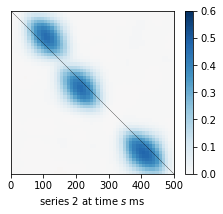

In [44]:
plt.figure(figsize=(4,3))
ldn.imshow(np.mean(Sigmas_true, 0)[:num_time,num_time:], time=[0,500], identity=True, vmax=0.6)
plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$ ms")
cbar = plt.colorbar()
cbar.ax.set_ylim(0,0.6)#; cbar.formatter.set_powerlimits((0, 0))
plt.yticks([],[])

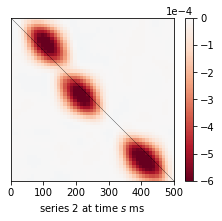

In [42]:
plt.figure(figsize=(4,3))
ldn.imshow(np.mean(Omegas_true, 0)[:num_time,num_time:], vmax=0.0006, time=[0,500], identity=True)
plt.xlabel(r"series 2 at time $s$ ms"); # plt.ylabel(r"series 1 at time $t$ ms")
plt.yticks([],[])
cbar = plt.colorbar()
cbar.ax.set_ylim(-6e-4,0); cbar.formatter.set_powerlimits((0, 0))

In [ ]:
# np.savez('%s/result_true_omega.npz'%save_dir,
#          Sigmas_true = Sigmas_true, Omegas_true = Omegas_true)